In [ ]:
path_project = './'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd
import os
import sys
import imageio
import torch

In [ ]:
device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

Using device: cuda:0


### Para segmentação de vídeo

In [ ]:
! pip install git+https://github.com/openai/whisper.git
! pip install pytube
! pip install moviepy
! pip install pydub

import warnings
import whisper
from pathlib import Path
import pytube
import subprocess
import shutil
from IPython.display import display, Markdown, YouTubeVideo
import cv2
from moviepy.editor import VideoFileClip
from pydub import AudioSegment

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-79d43res
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-79d43res
  Resolved https://github.com/openai/whisper.git to commit ba3f3cd54b0e5b8ce1ab3de13e32122d0d5f98ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.0 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20231117-py3-none-any.whl size=802825 sha256=81e77cfaec301aa2c9a1e832dec36cdb5525ae6d6641616fc066bcfabbfd1446
  Stored in directory: /tmp/pip-ephem-wheel-cache-eyhsqfg1/wheels/8b/6c/d0/622666868c179f156cf595c8b6f06f88bc5d80c4b31dccaa03
Successfully built openai-whisper
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dep

In [ ]:
# classe com funções para a segmentação de vídeos
class SegVideo():
    # inicializa o modelo
    def __init__(self, model_type='large'):
        self.whisper_model = whisper.load_model(model_type) # 'tiny.en', 'tiny', 'base.en', 'base', 'small.en', 'small', 'medium.en', 'medium', 'large'
        self.Model = model_type
        self.model_face = cv2.CascadeClassifier(path_project + 'haarcascade_frontalface_default.xml')

        if model_type not in whisper.available_models():
            raise(RuntimeError('Não foi possível carregar o modelo.'))

    # verifica a path do vídeo
    def get_video(self, path):
        if not os.path.exists(path):
            raise(RuntimeError(f'{str(path)} não existe.'))

        # trata arquivos .mp4 para .wav
        # if video_path.suffix == ".mp4":
        #     video_path = video_path.with_suffix(".wav")
        #     result = subprocess.run(["ffmpeg", "-i", str(video_path.with_suffix(".mp4")), "-vn", "-acodec", "pcm_s16le", "-ar", "16000", "-ac", "1", str(video_path)])

        return path

    # faz a trasncrição do vídeo dado os parâmetros do modelo
    def transcript(self, video_path, language='Auto detection', verbose='None', temperature=0.25, temperature_increment_on_fallback=1):
        output_type = '.vtt'
        verbose_lut = {
            'Live transcription': True,
            'Progress bar': False,
            'None': None
        }

        # parâmetros definidos do modelo
        args = dict(
            # parâmetros gerais
            language = (None if language == "Auto detection" else language),
            verbose = verbose_lut[verbose],
            task = 'transcribe',
            temperature = temperature,
            temperature_increment_on_fallback = temperature_increment_on_fallback,
            condition_on_previous_text = True,

            # parâmetros de treino
            best_of = 5,
            beam_size = 5,
            patience = 1.0,
            length_penalty = 0.05,
            suppress_tokens = "-1",
            initial_prompt = None,
            fp16 = True,

            # limitadores de compreensão do que foi dito
            compression_ratio_threshold = 2.4,
            logprob_threshold = -1.0,
            no_speech_threshold = 0.6
        )

        # trata os argumentos de temperatura
        temperature = args.pop("temperature")
        temperature_increment_on_fallback = args.pop("temperature_increment_on_fallback")
        if temperature_increment_on_fallback is not None:
            temperature = tuple(np.arange(temperature, 1.0 + 1e-6, temperature_increment_on_fallback))
        else:
            temperature = [temperature]

        # verifica o caso de modelos exclusivos para o inglês
        if self.Model.endswith(".en") and args["language"] not in {"en", "English"}:
            warnings.warn(f"{self.Model} is an English-only model but receipted '{args['language']}'; using English instead.")
            args["language"] = "en"

        # faz a trasncrição
        video_transcription = whisper.transcribe(
            self.whisper_model,
            str(video_path),
            temperature = temperature,
            **args,
        )
        return video_transcription

    # obtém o diretório do vídeo passado
    def _get_video_dir(self, video_path):
        video_dir = ''
        for subpath in str(video_path).split('/')[:-1]:
            video_dir += subpath + '/'

        return video_dir

    # extrai a parte de texto do vídeo transcrito
    def get_text_channel(self, video_transcription):
        texts_str = []
        for segment in video_transcription['segments']:
            texts_str.append(segment['text'])

        return texts_str

    # extrai a parte de áudio do vídeo transcrito
    def get_audio_channel(self, video_path, video_transcription):
        # carrega o arquivo de vídeo e extrai seu áudio
        video = VideoFileClip(str(video_path))
        audio = video.audio

        # salva o áudio em um arquivo separado
        audio_path = video_path.split('.')[0] + '.mp3'
        audio.write_audiofile(audio_path)

        video.close() # fecha o arquivo de vídeo

        # carrega o arquivo de áudio para o segmentador
        audio = AudioSegment.from_mp3(audio_path)

        # divide o áudio nos segmentos especificados
        video_dir = self._get_video_dir(video_path)
        count = 0
        audio_files = []
        for segment in video_transcription['segments']:
            segment_audio = audio[int(segment['start'] * 1000) : int(segment['end'] * 1000)]

            # salva o segmento do áudio em um arquivo
            audio_name = 'audio_' + str(count) + '.mp3'
            segment_audio.export(video_dir + audio_name, format='mp3')
            audio_files.append(video_dir + audio_name)
            count += 1

        return audio_files

    # extrai a parte de imagens do vídeo transcrito
    def get_face_channel(self, video_path, video_transcription, padding=1.2):
        # inicia o objeto de captura
        cap = cv2.VideoCapture(str(video_path))
        if not cap.isOpened():
            raise(RuntimeError('Erro ao abrir o arquivo de vídeo.'))


        # extrai a imagem de cada segmento do vídeo
        video_dir = self._get_video_dir(video_path)
        count = 0
        face_files = []
        for segment in video_transcription['segments']:
            # calcula o frame do meio do segmento para capturar
            fps_video = cap.get(cv2.CAP_PROP_FPS)
            start_frame = int(fps_video * segment['start'])
            end_frame = int(fps_video * segment['end'])
            mean_frame = int((start_frame + end_frame) / 2)

            cap.set(cv2.CAP_PROP_POS_FRAMES, mean_frame) # seta a leitura para o quadro

            # lê os frames até identificar alguma face válida nele
            ret = False; frame = None
            faces = []
            stop = False
            while not stop:
                ret, frame = cap.read()

                # converte o frame lido para escala de cinza e identifica as faces
                frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces = self.model_face.detectMultiScale(frame_gray, scaleFactor=1.1, minNeighbors=4, minSize=(5,5))

                # verifica se encontrou alguma face válida
                if ret and len(faces) != 0:
                    for face in faces:
                        if face[2] > 0 and face[3] > 0:
                            stop = True
                            break

                print(faces)

            print("ok")
            # armazena a imagem das faces no vetor
            faces_frame = []
            for x, y, w, h in faces:
                W = int(w * padding)
                H = int(h * padding)
                X = int(x - (W - w) / 2)
                Y = int(y - (H - h) / 2)

                faces_frame.append(np.array(frame[Y:Y+H, X:X+W, :]))

            # salva a imagem na pasta do vídeo
            img_name = 'face_' + str(count) + '.png'
            for face_frame in faces_frame:
                if np.array(face_frame.shape).min() != 0:
                    imageio.imwrite(video_dir + img_name, face_frame)
                    print(img_name)
                    break
            face_files.append(video_dir + img_name)
            count += 1

        cap.release() # encerra o objeto de captura do vídeo
        return face_files

### Para o modelo multimodal

In [ ]:
!pip install -U sentence-transformers
!pip install transformers
!git clone https://github.com/m3hrdadfi/soxan
!mv soxan/* .
!pip install deepface
!pip install torch_geometric

from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from transformers import AutoConfig, Wav2Vec2FeatureExtractor
from src.models import Wav2Vec2ForSpeechClassification, HubertForSpeechClassification
from deepface import DeepFace
from sklearn.metrics.pairwise import cosine_similarity
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=5a2e2787340a5c8463bce74c85176fca1e25826e8efc5cc8ee4ea8917ac41cc3
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
Cloning into 'soxan'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 194 (delta 23), reused 22 (delta 22), pack-reused 170
Receiving objects: 100% (194/194), 3.63 MiB | 14.58 MiB/s, done.
Resolving deltas: 100% (89/89), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 34.2 M

In [ ]:
# modelo GCN para o grafo
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x=x, edge_index=edge_index, edge_weight=edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x=x, edge_index=edge_index, edge_weight=edge_weight)
        return x

In [ ]:
# classe do modelo multimodal video emotion recognition (MVER)
class MVER():
    # carrega os modelos que o compõem
    def __init__(self):
        # modelo de texto
        MODEL_PATH = "bhadresh-savani/bert-base-go-emotion"
        self.emotion_text = pipeline('sentiment-analysis', model=MODEL_PATH, return_all_scores=True)
        self.encoder_text = SentenceTransformer(MODEL_PATH)

        # modelo de áudio
        model_path = "Rajaram1996/Hubert_emotion"
        self.config = AutoConfig.from_pretrained(model_path)
        self.feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_path)
        self.sampling_rate = self.feature_extractor.sampling_rate
        self.model = HubertForSpeechClassification.from_pretrained(model_path, output_hidden_states=True).to(device)

        # modelo de faces
        DeepFace.build_model("Emotion")

        # modelo circumplexo de emoções
        df_emotion_wheel = pd.read_csv(path_project + 'emotions_diagram.csv')
        self.emotion_wheel = {}
        for i in range(99):
            line = df_emotion_wheel.loc[i]
            self.emotion_wheel[line['Emotion']] = (line['X'], line['Y'])

        # dicionário de correspondências entre as emoções descritas pelos modelos e as da roda de emoções
        self.emotion_correspondence = {
            'admiration':'contemplative','amusement':'amused','anger':'angry','annoyance':'annoyed','approval':'convinced','caring':'attentive','confusion':'suspicious','curiosity':'pensive','desire':'lusting','disappointment':'disappointed','disapproval':'dissatisfied','disgust':'disgusted','embarrassment':'embarrassed','excitement':'excited','fear':'afraid','gratitude':'reverent','grief':'tense','joy':'joyous','love':'amorous','nervousness':'distressed','optimism':'hopeful','pride':'satisfied','realization':'pleased','relief':'peaceful','remorse':'feel guilt','sadness':'sad','surprise':'impressed'
        }

        # modelo gcn para o grafo das pseudolabels
        self.gcn = GCN(num_features=5632, hidden_channels=16).to(device)
        self.optimizer = torch.optim.Adam(self.gcn.parameters(), lr=0.01, weight_decay=5e-4)
        self.criterion = torch.nn.MSELoss()

    # ajusta o nome da emoção para corresponder ao modelo
    def _adjust_emotion_name(self, emotion):
        if emotion in list(self.emotion_correspondence.keys()):
            return self.emotion_correspondence[emotion]
        return emotion

    # retorna a respectiva coordenada da emoção passada
    def _get_emotion_coord(self, emotion):
        emotion_adj = self._adjust_emotion_name(emotion)
        return self.emotion_wheel[emotion_adj]

    # retorna a emoção de maior score prevista do modelo de texto
    def _get_best_emotion_text(self, emotions):
        best_emo = ''
        best_score = 0
        for d in emotions[0]:
            if d['score'] >= best_score:
                best_emo = d['label']
                best_score = d['score']

        return best_emo

    # retorna a emoção de maior score prevista do modelo de áudio
    def _get_best_emotion_audio(self, emotions):
        best_emo = ''
        best_score = 0
        for d in emotions:
            if d['Score'] >= best_score:
                best_emo = d['Emotion']
                best_score = d['Score']

        return best_emo

    # retorna a emoção de maior score prevista do modelo de imagem
    def _get_best_emotion_face(self, emotions):
        best_emo = ''
        best_score = 0
        for key in emotions.keys():
            if emotions[key] >= best_score:
                best_emo = key
                best_score = emotions[key]

        return best_emo

    # carrega o arquivo de áudio e o converte para numpy array
    def _speech_file_to_array_fn(self, speech_file_path, sampling_rate):
        speech_array, _sampling_rate = torchaudio.load(speech_file_path)
        resampler = torchaudio.transforms.Resample(_sampling_rate, sampling_rate)
        speech = resampler(speech_array).squeeze().numpy()
        return speech

    # faz a predição da emoção do arquivo de áudio usando o modelo
    def emotion_audio(self, speech_file_path, sampling_rate):
        # tratamento dos dados de entrada
        speech = self._speech_file_to_array_fn(speech_file_path, sampling_rate)
        inputs = self.feature_extractor(speech, sampling_rate=sampling_rate, return_tensors="pt", padding=True)
        inputs = {key: inputs[key].to(device) for key in inputs}

        # faz a predição do modelo
        with torch.no_grad():
            logits = self.model(**inputs).logits

        # calcula os scores das emoções dado a entrada
        scores = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
        outputs = [{"Emotion": self.config.id2label[i], "Score": round(score * 100, 3)} for i, score in enumerate(scores)]

        return np.array(outputs)

    # faz a predição das emoções desconsiderando o gênero
    def emotion_audio_without_gender(self, speech_file_path, sampling_rate):
        labels = self.emotion_audio(speech_file_path, sampling_rate)

        # soma os scores de emoções iguais para o novo dicionario
        new_labels = np.array([{'Emotion': '', 'Score': 0.0}, {'Emotion': '', 'Score': 0.0}, {'Emotion': '', 'Score': 0.0}, {'Emotion': '', 'Score': 0.0}, {'Emotion': '', 'Score': 0.0}, {'Emotion': '', 'Score': 0.0}, {'Emotion': '', 'Score': 0.0}])
        for i in range(7):
            new_labels[i]['Score'] = labels[i+7]['Score'] + labels[i]['Score']
            new_labels[i]['Emotion'] = labels[i]['Emotion'].split('_')[1]

        return new_labels

    # extrai os embeddings da predição feita
    def encoder_audio(self, path, sampling_rate, mean_pool=True):
        speech = self._speech_file_to_array_fn(path, sampling_rate)
        inputs = self.feature_extractor(speech, sampling_rate=sampling_rate, return_tensors="pt", padding=True)
        inputs = {key: inputs[key].to(device) for key in inputs}

        with torch.no_grad():
            out = self.model(**inputs).hidden_states[-1]
            if mean_pool:
                return np.array(torch.mean(out, dim=1).cpu())[0]
            else:
                return np.array(out.cpu())[0]

    # extrai os sentimentos da face utilizando o modelo
    def emotion_face(self, face_array):
        objs = DeepFace.analyze(img_path=face_array, actions=['emotion'], enforce_detection=False)
        return objs[0]['emotion']

    # extrai as features da face utilizando o modelo
    def encoder_face(self, face_array):
        features = DeepFace.represent(face_array, enforce_detection=False)
        return np.array(features[0]['embedding'])

    # processa uma cadeia de strings para extrair suas embeddings e coordenadas de sentimentos
    def process_text(self, texts_str):
        coords = []
        for sentence in texts_str:
            best = self._get_best_emotion_text( self.emotion_text([sentence]) )
            coords.append( self._get_emotion_coord(best) )

        return list(self.encoder_text.encode(texts_str)), coords

    # processa uma série de arquivos de audios para extrair suas embeddings e coordenadas de sentimentos
    def process_audio(self, audio_files):
        embeddings = []
        coords = []
        for file in audio_files:
            embeddings.append( self.encoder_audio(file, self.sampling_rate) )
            best = self._get_best_emotion_audio( self.emotion_audio_without_gender(file, self.sampling_rate) )
            coords.append( self._get_emotion_coord(best) )

        return embeddings, coords

    # processa uma série de arquivos de faces para extrair suas embeddings e coordenadas de sentimentos
    def process_face(self, img_files):
        embeddings = []
        coords = []
        for file in img_files:
            face = np.array(imageio.imread(file))
            embeddings.append( self.encoder_face(face) )
            best = self._get_best_emotion_face( self.emotion_face(face) )
            coords.append( self._get_emotion_coord(best) )

        return embeddings, coords

    # calcula a matriz de adjacências do grafo
    def _get_adj_matriz(self, embeddings, p, round):
        # calcula a matriz de similaridades das embeddings para a de adjacências do grafo
        similarities = np.array( cosine_similarity(embeddings) )
        adj_matrix = np.where(similarities >= p, similarities, 0) - np.identity(similarities.shape[0])
        return np.round(adj_matrix, round)

    # verifica se os arrays possuem mesmo tamanho
    def _verify_same_len(self, num, arrays):
        this_len = len(arrays[0])
        for i in range(1, num):
            if this_len != len(arrays[i]):
                return False

        return True

    # calcula a distância ponderanda entre 2 pontos
    def _distance_w(self, p1, p2, w1, w2):
        diff = w1 * np.array(p1) - w2 * np.array(p2)
        return np.sqrt((diff ** 2).sum())

    # calcula o SPL de um vértice
    def _SPL(self, coords, ws):
        D_fa = self._distance_w(coords[0], coords[1], ws[0], ws[1])
        D_ft = self._distance_w(coords[0], coords[2], ws[0], ws[2])
        D_at = self._distance_w(coords[1], coords[2], ws[1], ws[2])
        return 1 - (D_fa + D_ft + D_at) / (6 * np.sqrt(2))

    # define os nós utilizados para o treino do modelo (aqueles com maior concordância entre as previsões)
    def get_train_nodes(self, all_coordnates, ws, t):
        train_mask = np.zeros(len(all_coordnates[0]), dtype=bool)
        for i in range(len(all_coordnates[0])):
            if self._SPL(np.array(all_coordnates)[:, i], ws) >= t:
                train_mask[i] = True

        return torch.tensor(train_mask, dtype=bool)

    # obtém o grafo total dos canais de acordo com os dados de cada segmento
    def consensus_graph(self, num_channels, all_embeddings, all_emotion_coords, ws, p=0.8, t=0.2, round=6):
        # verifica se as importâncias das modalidades possuem valores válidos
        if np.round(np.sum(ws), round) != 1:
            print('Valores de importâncias W inválidos')
            return None

        # verifica o número de nós dos canais
        if not self._verify_same_len(num_channels, all_embeddings) or not self._verify_same_len(num_channels, all_emotion_coords):
            print('Grafos com números distintos de nós')
            return None

        # define as propriedades das arestas do grafo
        adj_matrix = np.sum([ws[i] * self._get_adj_matriz(embedding, p, round) for i, embedding in enumerate(all_embeddings)], axis=0)
        edge_index = torch.tensor(list(np.nonzero(adj_matrix)), dtype=torch.long)
        edge_weight = torch.tensor([adj_matrix[edge_index[0][i], edge_index[1][i]] for i in range(len(edge_index[0]))], dtype=torch.float)

        # de acordo com os valores dos nós, calcula suas propriedades e define os nós de treino
        all_coords_w = [ws[i] * np.array(coords_channel) for i, coords_channel in enumerate(all_emotion_coords)]
        mean_coords = np.mean(np.array(all_coords_w), axis=0)
        embeddings_concat = [np.concatenate(sublist, axis=None).tolist() for sublist in np.array(all_embeddings).T]

        x = torch.tensor(embeddings_concat, dtype=torch.float)
        y = torch.tensor(mean_coords.tolist(), dtype=torch.float)
        train_mask = self.get_train_nodes(all_emotion_coords, ws, t)

        # constrói o nó do vídeo e retorna os valores
        G = Data(x=x, y=y, edge_index=edge_index, edge_weight=edge_weight)
        return G.to(device), train_mask.to(device)

    # treina o modelo gcn para o grafo dos segmentos
    def train_gcn(self, graph, train_mask, num_epochs=200, verbose=False):
        for epoch in range(1, num_epochs+1):
            self.gcn.train()
            self.optimizer.zero_grad()
            out = self.gcn(graph.x, graph.edge_index, graph.edge_weight)
            loss = self.criterion(out[train_mask], graph.y[train_mask])
            loss.backward()
            self.optimizer.step()
            if verbose:
                print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

    # utiliza do gcn para predição das coordenadas dos nós desejados
    def gcn_adjust_coordnates(self, graph, nodes_mask):
        new_graph = graph.clone()
        pred = self.gcn(new_graph.x, new_graph.edge_index, new_graph.edge_weight)
        new_graph.y[nodes_mask] = pred[nodes_mask].detach()
        return new_graph

### Teste exemplo

In [ ]:
filename_video = 'midia/01-02.mp4'

# faz a segmentação do vídeo com o modelo
seg_model = SegVideo(model_type='tiny')
video_path = seg_model.get_video(path_project + filename_video)
video_transcription = seg_model.transcript(video_path, language='English', verbose='None', temperature=-0.1, temperature_increment_on_fallback=0.7)

100%|██████████████████████████████████████| 72.1M/72.1M [00:00<00:00, 104MiB/s]


In [ ]:
# separa a segmentação para cada canal
texts_str = seg_model.get_text_channel(video_transcription)
audio_files = seg_model.get_audio_channel(video_path, video_transcription)
face_files = seg_model.get_face_channel(video_path, video_transcription, padding=1.2)

MoviePy - Writing audio in /content/drive/MyDrive/Colab Notebooks/IC Multimodal/Projeto final/midia/01-02.mp3


MoviePy - Done.
[[422 142 406 406]]
ok
face_0.png
[[422 151 412 412]]
ok
face_1.png
[[422 133 411 411]]
ok
face_2.png
[[422 156 409 409]]
ok
face_3.png
[[422 198 403 403]]
ok
face_4.png
[[464 194 409 409]]
ok
face_5.png
[[478 181 406 406]]
ok
face_6.png
[[363 183 414 414]]
ok
face_7.png
[[428 191 430 430]]
ok
face_8.png
[[440 139 414 414]]
ok
face_9.png
[[422 142 433 433]]
ok
face_10.png
[[404 138 431 431]]
ok
face_11.png
[[499  69  55  55]
 [395 169 427 427]]
ok
face_12.png
[[520  65  56  56]
 [413 173 413 413]]
ok
face_13.png
[[356 169 432 432]
 [480  60  57  57]]
ok
face_14.png
[[448 132 400 400]]
ok
face_15.png
[[435 152 413 413]]
ok
face_16.png
[[425 157 408 408]]
ok
face_17.png
[[412 152 420 420]]
ok
face_18.png
[[415 142 416 416]]
ok
face_19.png
[[611 112  58  58]
 [437 264 378 378]]
ok
face_20.png
[[407 152 419 419]]
ok
face_21.png
[[419 200 396 396]]
ok
face_22.png
[[438 203 388 388]]
ok
face_23.png
[[429 145 399 399]]
ok
face_24.png
[[414 173 408 408]]
ok
face_25.png
[[427 15

In [ ]:
texts_str

[' Kids are talking by the door.',
 ' Kids are talking by the door.',
 ' Dogs are sitting by the door.',
 ' Dogs are sitting by the door.',
 ' Kids are talking by the door.',
 ' Kids are talking by the door.',
 ' Dogs are sitting by the door.',
 ' Dogs are sitting by the door.',
 ' Kids are talking by the door.',
 ' Kids are talking by the door.',
 ' Dogs are sitting by the door.',
 ' Dogs are sitting by the door.',
 ' Kids are talking by the door.',
 ' Kids are talking by the door.',
 ' Dogs are sitting by the door.',
 ' Dogs are sitting by the door.',
 ' Kids are talking by the door.',
 ' Kids are talking by the door.',
 ' Dogs are sitting by the door.',
 ' Dogs are sitting by the door.',
 ' Kids are talking by the door.',
 ' Kids are talking by the door!',
 ' Oh, dogs are sitting by the door!',
 ' Dogs are sitting by the door!',
 ' Kids are talking by the door!',
 ' Kids are talking by the door!',
 ' Dogs are sitting by the door!',
 ' Dogs are sitting by the door!',
 ' Kids are talk

In [ ]:
# utiliza do modelo multimodal para a construção do grafo
mver = MVER()

# cálculo das embeddings e coordenadas dos segmentos dos canais do vídeo
text_embeddings, text_coord = mver.process_text(texts_str)
audio_embeddings, audio_coord = mver.process_audio(audio_files)
face_embeddings, face_coord = mver.process_face(face_files)

config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/884 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

24-01-27 20:49:44 - facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 25.4MB/s]


24-01-27 20:49:52 - vgg_face_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5
To: /root/.deepface/weights/vgg_face_weights.h5
100%|██████████| 580M/580M [00:07<00:00, 82.7MB/s]


In [ ]:
# construção do grafo
embeddings = [text_embeddings, audio_embeddings, face_embeddings]
coordnates = [text_coord, audio_coord, face_coord]
graph_multimodal, train_mask = mver.consensus_graph(3, embeddings, coordnates, ws=[0, 0.6, 0.4], p=0.93, t=0.83)

Visualização do grafo construído

In [ ]:
import networkx as nx

def plot_graph(graph, right_nodes_mask):
    nx_graph = to_networkx(graph)
    pos = nx.spring_layout(nx_graph)
    colors = ['blue' if color else 'red' for color in list(right_nodes_mask)]
    nx.draw(nx_graph, pos, with_labels=True, font_weight='bold', node_size=300, node_color=colors, font_size=8, arrowsize=10)

    pos_labels = {k: (x, y + 0.05) for k, (x, y) in pos.items()}
    labels = {node: f'{np.round(graph.y[i].to("cpu").numpy(), 2)}' for i, node in enumerate(nx_graph.nodes)}
    nx.draw_networkx_labels(graph, pos_labels, labels=labels, font_size=8, font_color='black', font_family='sans-serif')

    plt.show()

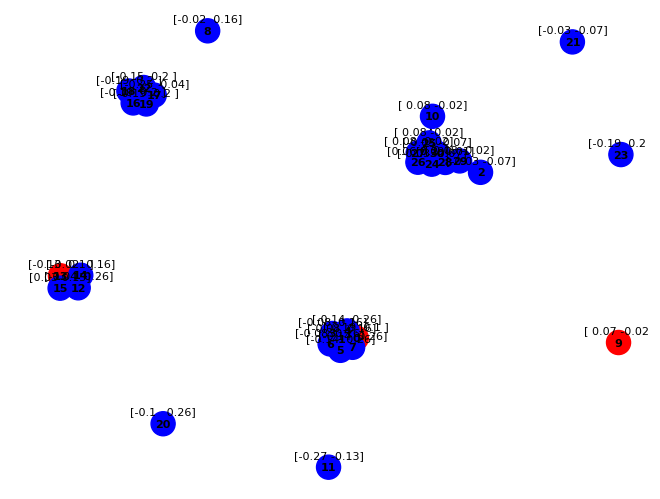

In [ ]:
plot_graph(graph_multimodal, train_mask)

In [ ]:
mver.train_gcn(graph_multimodal, train_mask, num_epochs=200, verbose=True)
final_graph = mver.gcn_adjust_coordnates(graph_multimodal, ~train_mask)

Epoch: 001, Loss: 0.2452
Epoch: 002, Loss: 65.8079
Epoch: 003, Loss: 14.7356
Epoch: 004, Loss: 12.4629
Epoch: 005, Loss: 4.1043
Epoch: 006, Loss: 1.5267
Epoch: 007, Loss: 1.6523
Epoch: 008, Loss: 3.2621
Epoch: 009, Loss: 0.7083
Epoch: 010, Loss: 1.0209
Epoch: 011, Loss: 0.2429
Epoch: 012, Loss: 0.1266
Epoch: 013, Loss: 0.0597
Epoch: 014, Loss: 0.0232
Epoch: 015, Loss: 0.0254
Epoch: 016, Loss: 0.0484
Epoch: 017, Loss: 0.0375
Epoch: 018, Loss: 0.0229
Epoch: 019, Loss: 0.0231
Epoch: 020, Loss: 0.0228
Epoch: 021, Loss: 0.0228
Epoch: 022, Loss: 0.0227
Epoch: 023, Loss: 0.0226
Epoch: 024, Loss: 0.0226
Epoch: 025, Loss: 0.0225
Epoch: 026, Loss: 0.0224
Epoch: 027, Loss: 0.0223
Epoch: 028, Loss: 0.0222
Epoch: 029, Loss: 0.0221
Epoch: 030, Loss: 0.0220
Epoch: 031, Loss: 0.0219
Epoch: 032, Loss: 0.0218
Epoch: 033, Loss: 0.0217
Epoch: 034, Loss: 0.0215
Epoch: 035, Loss: 0.0214
Epoch: 036, Loss: 0.0213
Epoch: 037, Loss: 0.0212
Epoch: 038, Loss: 0.0211
Epoch: 039, Loss: 0.0209
Epoch: 040, Loss: 0.02

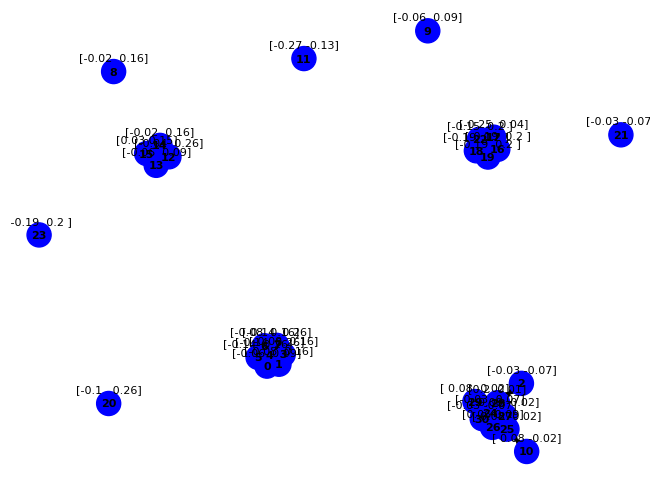

In [ ]:
plot_graph(final_graph, np.ones(len(train_mask), dtype=bool))

#### Plot das emoções identificadas

In [ ]:
df_emotion_coords = pd.read_excel(path_project + 'emotions_coord.xlsx')
df_emotion_coords

Emotion     X     Y
0       admiration  0.38 -0.08
1        amusement  0.56  0.19
2            anger -0.41  0.78
3        annoyance -0.45  0.66
4         approval  0.95 -0.17
5           caring  0.76 -0.60
6        confusion -0.57 -0.69
7        curiosity  0.65  0.10
8           desire  0.42  0.65
9   disappointment -0.80 -0.02
10     disapproval -0.68  0.32
11         disgust -0.68  0.49
12   embarrassment -0.32 -0.60
13      excitement  0.70  0.72
14            fear -0.11  0.78
15       gratitude  0.90 -0.30
16           grief -0.90 -0.30
17             joy  0.95  0.13
18            love  0.85 -0.14
19     nervousness -0.68 -0.17
20        optimism  0.32  0.06
21           pride  0.62  0.50
22     realization  0.88  0.36
23          relief  0.71 -0.67
24         remorse -0.41 -0.43
25         sadness -0.82 -0.40
26        surprise  0.42  0.88
27         neutral  0.00  0.00

In [ ]:
import math
from tqdm.notebook import tqdm

# calcula intensidade com Quartic Kernel
def kde_quartic(d, h):
    dn = d / h
    P = (15/16) * (1 - dn**2) ** 2
    return P

def plot_emotion_occurences(coordnates, df_emotions_reference, grid_size=0.02, h=0.5, title=None):
    # extrai os valores x e y de cada coordenada
    x = [coord[0] for coord in coordnates]
    y = [coord[1] for coord in coordnates]

    # valores mínimos e mínimos de X e Y.
    x_min = -1; x_max = 1
    y_min = -1; y_max = 1

    # construindo grid e seus pontos centrais
    x_grid = np.arange(x_min-h, x_max+h, grid_size)
    y_grid = np.arange(y_min-h, y_max+h, grid_size)
    x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

    xc = x_mesh + (grid_size / 2)
    yc = y_mesh + (grid_size / 2)

    # calcula as intensidades presentes no grid
    intensity_list = []
    for j in tqdm(range(len(xc))):
        intensity_row = []
        for k in range(len(xc[0])):
            kde_value_list = []
            for i in range(len(x)):
                # calcula distância
                d = math.sqrt((xc[j][k]-x[i])**2 + (yc[j][k]-y[i])**2)
                if d <= h:
                    p = kde_quartic(d, h)
                else:
                    p = 0
                kde_value_list.append(p)

            # soma os valores de intensidade
            p_total = sum(kde_value_list)
            intensity_row.append(p_total)

        intensity_list.append(intensity_row)
    intensity = np.array(intensity_list)

    # inicializa o plot das ocorrências pela intensidade
    plt.figure(figsize=(4,4))
    plt.pcolormesh(x_mesh, y_mesh, intensity, cmap='YlOrRd') #https://matplotlib.org/stable/tutorials/colors/colormaps.html

    # plot de emoções genéricas como referência
    x_emo = df_emotions_reference.X.to_list()
    y_emo = df_emotions_reference.Y.to_list()
    plt.scatter(x_emo, y_emo)

    for i, row in df_emotions_reference.iterrows():
        plt.annotate(row['Emotion'], (x_emo[i], y_emo[i]))

    # definição do círculo limitador
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xticks([-1,1,0])
    plt.yticks([-1,1,0])

    ax = plt.gca()
    ax.add_patch(plt.Circle((0, 0), 1, color='black', fill=False))
    plt.axvline(x = 0, color = 'black', label = 'Arousal')
    plt.axhline(y = 0, color = 'black', label = 'Valence')

    plt.xlabel('Arousal')
    plt.ylabel('Valence')
    if title != None:
        plt.title(title)

    plt.plot()

  0%|          | 0/150 [00:00<?, ?it/s]

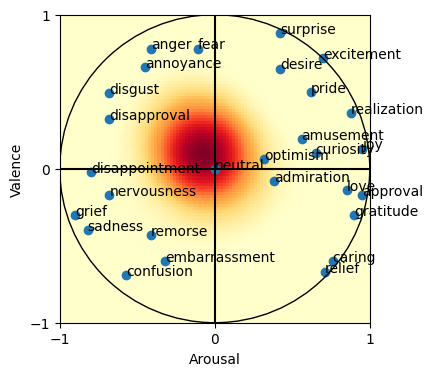

In [ ]:
plot_emotion_occurences(list(final_graph.y.to('cpu').numpy()), df_emotion_coords, grid_size=0.02, h=0.5)

Coordenadas calculadas pelo modelo:

In [ ]:
for coord in list(final_graph.y.to('cpu').numpy()):
    print(coord)

[-0.0612606   0.09462564]
[-0.082  0.156]
[-0.03333334 -0.06933333]
[-0.082  0.156]
[-0.13666667  0.26      ]
[-0.13666667  0.26      ]
[-0.082  0.156]
[-0.13666667  0.26      ]
[-0.022  0.156]
[-0.0612606   0.09462564]
[ 0.076 -0.016]
[-0.27333334 -0.13333334]
[-0.03666667  0.26      ]
[-0.0612606   0.09462564]
[-0.022  0.156]
[0.02866667 0.14533333]
[-0.19066666  0.202     ]
[-0.24533333  0.04466667]
[-0.19066666  0.202     ]
[-0.19066666  0.202     ]
[-0.09666666  0.26      ]
[-0.03333334 -0.06933333]
[-0.15066667  0.202     ]
[-0.19066666  0.202     ]
[-0.03333334 -0.06933333]
[ 0.076 -0.016]
[0.06133333 0.088     ]
[ 0.076 -0.016]
[0.196      0.00533333]
[ 0.076 -0.016]
[-0.03333334 -0.06933333]


[]

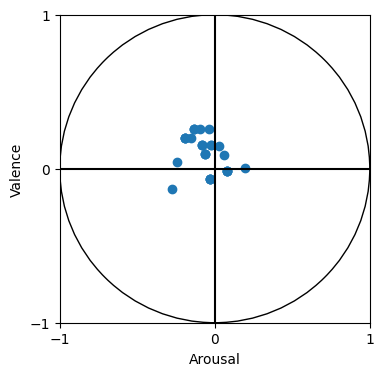

In [ ]:
plt.figure(figsize=(4,4))

# print dos sentimentos dos modelos
x = [coord[0] for coord in list(final_graph.y.to('cpu').numpy())]
y = [coord[1] for coord in list(final_graph.y.to('cpu').numpy())]
plt.scatter(x, y)

plt.xlim(-1, 1)
plt.ylim(-1,1)
plt.xticks([-1,1,0])
plt.yticks([-1,1,0])

ax = plt.gca()
ax.add_patch(plt.Circle((0, 0), 1, color='black', fill=False))
plt.axvline(x = 0, color = 'black', label = 'Arousal')
plt.axhline(y = 0, color = 'black', label = 'Valence')

#plt.colorbar()
plt.xlabel('Arousal')
plt.ylabel('Valence')

plt.plot()

### Testes com o dataset

#### Valores respostas do dataset

In [ ]:
emotions_dataset = ['neutral', 'calm', 'happy', 'sad', 'angry', 'afraid', 'disgusted', 'impressed']

df_c = pd.read_csv(path_project + 'emotions_diagram.csv')
emo_c = [[float(df_c.loc[df_c['Emotion'] == emotion].X), float(df_c.loc[df_c['Emotion'] == emotion].Y)] for emotion in emotions_dataset]
emo_c

[[0.0, 0.0],
 [0.71, -0.7],
 [0.9, 0.16],
 [-0.82, -0.4],
 [-0.41, 0.78],
 [-0.11, 0.78],
 [-0.68, 0.49],
 [0.38, -0.08]]

  0%|          | 0/150 [00:00<?, ?it/s]

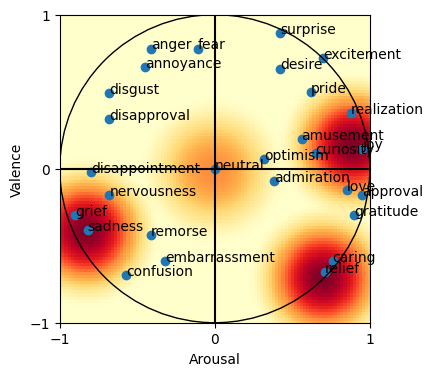

In [ ]:
# respostas dos vídeos xx-01.mp4
resp_p1 = [
    emo_c[0], emo_c[0], emo_c[0], emo_c[0],
    emo_c[1], emo_c[1], emo_c[1], emo_c[1], emo_c[1], emo_c[1], emo_c[1], emo_c[1],
    emo_c[2], emo_c[2], emo_c[2], emo_c[2], emo_c[2], emo_c[2], emo_c[2], emo_c[2],
    emo_c[3], emo_c[3], emo_c[3], emo_c[3], emo_c[3], emo_c[3], emo_c[3], emo_c[3],
]

plot_emotion_occurences(resp_p1, df_emotion_coords, grid_size=0.02, h=0.5)

  0%|          | 0/150 [00:00<?, ?it/s]

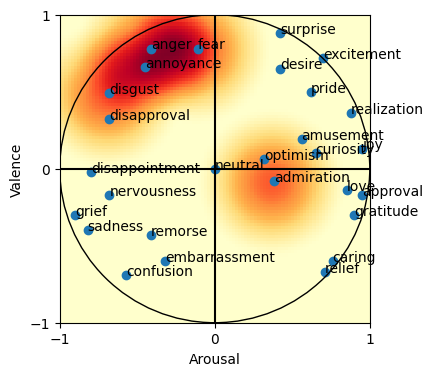

In [ ]:
# respostas dos vídeos xx-02.mp4
resp_p2 = [
    emo_c[4], emo_c[4], emo_c[4], emo_c[4], emo_c[4], emo_c[4], emo_c[4], emo_c[4],
    emo_c[5], emo_c[5], emo_c[5], emo_c[5], emo_c[5], emo_c[5], emo_c[5], emo_c[5],
    emo_c[6], emo_c[6], emo_c[6], emo_c[6], emo_c[6], emo_c[6], emo_c[6], emo_c[6],
    emo_c[7], emo_c[7], emo_c[7], emo_c[7], emo_c[7], emo_c[7], emo_c[7], emo_c[7]
]

plot_emotion_occurences(resp_p2, df_emotion_coords, grid_size=0.02, h=0.5)

#### Otimização de hiperparâmetros

##### Pesos w_f, w_a, w_t de cada modalidade

In [ ]:
# define o erro quadrático médio entre conjuntos de pontos
def mse(p1, p2):
    return np.mean((p1 - p2) ** 2)

In [ ]:
m_error = np.ones((11, 11))

# construção do grafo
for i, wt in enumerate(np.arange(0, 1.1, 0.1)):
    for j, wa in enumerate(np.arange(0, 1.1, 0.1)):
        if wt + wa > 1:
            continue
        wf = 1 - wt - wa

        mver = MVER()
        graph_multimodal, train_mask = mver.consensus_graph(3, embeddings, coordnates, ws=[wt, wa, wf], p=0.93, t=0.83)
        mver.train_gcn(graph_multimodal, train_mask, num_epochs=200, verbose=True)
        final_graph = mver.gcn_adjust_coordnates(graph_multimodal, ~train_mask)
        m_error[i, j] = mse(final_graph.y.to('cpu').numpy(), np.array(resp_p2))
        print(wt, wa, m_error[i, j])

m_error[m_error == 1] = None

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3159
Epoch: 002, Loss: 34.5500
Epoch: 003, Loss: 5.1410
Epoch: 004, Loss: 0.0007
Epoch: 005, Loss: 0.0008
Epoch: 006, Loss: 0.0010
Epoch: 007, Loss: 0.0012
Epoch: 008, Loss: 0.0014
Epoch: 009, Loss: 0.0015
Epoch: 010, Loss: 0.0017
Epoch: 011, Loss: 0.0019
Epoch: 012, Loss: 0.0020
Epoch: 013, Loss: 0.0022
Epoch: 014, Loss: 0.0023
Epoch: 015, Loss: 0.0024
Epoch: 016, Loss: 0.0025
Epoch: 017, Loss: 0.0026
Epoch: 018, Loss: 0.0027
Epoch: 019, Loss: 0.0027
Epoch: 020, Loss: 0.0028
Epoch: 021, Loss: 0.0028
Epoch: 022, Loss: 0.0029
Epoch: 023, Loss: 0.0029
Epoch: 024, Loss: 0.0029
Epoch: 025, Loss: 0.0029
Epoch: 026, Loss: 0.0029
Epoch: 027, Loss: 0.0029
Epoch: 028, Loss: 0.0029
Epoch: 029, Loss: 0.0029
Epoch: 030, Loss: 0.0029
Epoch: 031, Loss: 0.0029
Epoch: 032, Loss: 0.0028
Epoch: 033, Loss: 0.0028
Epoch: 034, Loss: 0.0028
Epoch: 035, Loss: 0.0027
Epoch: 036, Loss: 0.0027
Epoch: 037, Loss: 0.0026
Epoch: 038, Loss: 0.0026
Epoch: 039, Loss: 0.0025
Epoch: 040, Loss: 0.0025

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.6840
Epoch: 002, Loss: 25.9162
Epoch: 003, Loss: 7.1903
Epoch: 004, Loss: 1.6295
Epoch: 005, Loss: 0.7506
Epoch: 006, Loss: 0.4788
Epoch: 007, Loss: 0.1161
Epoch: 008, Loss: 0.0071
Epoch: 009, Loss: 0.0075
Epoch: 010, Loss: 0.0078
Epoch: 011, Loss: 0.0081
Epoch: 012, Loss: 0.0083
Epoch: 013, Loss: 0.0085
Epoch: 014, Loss: 0.0087
Epoch: 015, Loss: 0.0089
Epoch: 016, Loss: 0.0091
Epoch: 017, Loss: 0.0092
Epoch: 018, Loss: 0.0093
Epoch: 019, Loss: 0.0094
Epoch: 020, Loss: 0.0094
Epoch: 021, Loss: 0.0095
Epoch: 022, Loss: 0.0095
Epoch: 023, Loss: 0.0095
Epoch: 024, Loss: 0.0095
Epoch: 025, Loss: 0.0095
Epoch: 026, Loss: 0.0094
Epoch: 027, Loss: 0.0094
Epoch: 028, Loss: 0.0093
Epoch: 029, Loss: 0.0093
Epoch: 030, Loss: 0.0092
Epoch: 031, Loss: 0.0091
Epoch: 032, Loss: 0.0090
Epoch: 033, Loss: 0.0089
Epoch: 034, Loss: 0.0088
Epoch: 035, Loss: 0.0087
Epoch: 036, Loss: 0.0086
Epoch: 037, Loss: 0.0085
Epoch: 038, Loss: 0.0084
Epoch: 039, Loss: 0.0083
Epoch: 040, Loss: 0.0082

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.7589
Epoch: 002, Loss: 11.0374
Epoch: 003, Loss: 5.8090
Epoch: 004, Loss: 0.7075
Epoch: 005, Loss: 0.7698
Epoch: 006, Loss: 0.1286
Epoch: 007, Loss: 0.3569
Epoch: 008, Loss: 0.0999
Epoch: 009, Loss: 0.0635
Epoch: 010, Loss: 0.0138
Epoch: 011, Loss: 0.0139
Epoch: 012, Loss: 0.0139
Epoch: 013, Loss: 0.0139
Epoch: 014, Loss: 0.0139
Epoch: 015, Loss: 0.0138
Epoch: 016, Loss: 0.0138
Epoch: 017, Loss: 0.0138
Epoch: 018, Loss: 0.0137
Epoch: 019, Loss: 0.0137
Epoch: 020, Loss: 0.0136
Epoch: 021, Loss: 0.0135
Epoch: 022, Loss: 0.0135
Epoch: 023, Loss: 0.0134
Epoch: 024, Loss: 0.0133
Epoch: 025, Loss: 0.0132
Epoch: 026, Loss: 0.0131
Epoch: 027, Loss: 0.0130
Epoch: 028, Loss: 0.0129
Epoch: 029, Loss: 0.0128
Epoch: 030, Loss: 0.0127
Epoch: 031, Loss: 0.0125
Epoch: 032, Loss: 0.0124
Epoch: 033, Loss: 0.0123
Epoch: 034, Loss: 0.0122
Epoch: 035, Loss: 0.0121
Epoch: 036, Loss: 0.0120
Epoch: 037, Loss: 0.0118
Epoch: 038, Loss: 0.0117
Epoch: 039, Loss: 0.0116
Epoch: 040, Loss: 0.0115

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2034
Epoch: 002, Loss: 63.9286
Epoch: 003, Loss: 1.6929
Epoch: 004, Loss: 5.3935
Epoch: 005, Loss: 7.6528
Epoch: 006, Loss: 4.4899
Epoch: 007, Loss: 2.1191
Epoch: 008, Loss: 0.4550
Epoch: 009, Loss: 0.0190
Epoch: 010, Loss: 0.0194
Epoch: 011, Loss: 0.0192
Epoch: 012, Loss: 0.0193
Epoch: 013, Loss: 0.0194
Epoch: 014, Loss: 0.0194
Epoch: 015, Loss: 0.0195
Epoch: 016, Loss: 0.0195
Epoch: 017, Loss: 0.0195
Epoch: 018, Loss: 0.0195
Epoch: 019, Loss: 0.0195
Epoch: 020, Loss: 0.0195
Epoch: 021, Loss: 0.0195
Epoch: 022, Loss: 0.0195
Epoch: 023, Loss: 0.0195
Epoch: 024, Loss: 0.0194
Epoch: 025, Loss: 0.0194
Epoch: 026, Loss: 0.0193
Epoch: 027, Loss: 0.0192
Epoch: 028, Loss: 0.0192
Epoch: 029, Loss: 0.0191
Epoch: 030, Loss: 0.0190
Epoch: 031, Loss: 0.0189
Epoch: 032, Loss: 0.0188
Epoch: 033, Loss: 0.0188
Epoch: 034, Loss: 0.0187
Epoch: 035, Loss: 0.0186
Epoch: 036, Loss: 0.0185
Epoch: 037, Loss: 0.0184
Epoch: 038, Loss: 0.0183
Epoch: 039, Loss: 0.0181
Epoch: 040, Loss: 0.0180

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2397
Epoch: 002, Loss: 55.4526
Epoch: 003, Loss: 2.6514
Epoch: 004, Loss: 0.0355
Epoch: 005, Loss: 0.0191
Epoch: 006, Loss: 0.0161
Epoch: 007, Loss: 0.0156
Epoch: 008, Loss: 0.0153
Epoch: 009, Loss: 0.0150
Epoch: 010, Loss: 0.0147
Epoch: 011, Loss: 0.0145
Epoch: 012, Loss: 0.0143
Epoch: 013, Loss: 0.0142
Epoch: 014, Loss: 0.0140
Epoch: 015, Loss: 0.0139
Epoch: 016, Loss: 0.0138
Epoch: 017, Loss: 0.0137
Epoch: 018, Loss: 0.0136
Epoch: 019, Loss: 0.0136
Epoch: 020, Loss: 0.0135
Epoch: 021, Loss: 0.0135
Epoch: 022, Loss: 0.0134
Epoch: 023, Loss: 0.0134
Epoch: 024, Loss: 0.0133
Epoch: 025, Loss: 0.0133
Epoch: 026, Loss: 0.0133
Epoch: 027, Loss: 0.0132
Epoch: 028, Loss: 0.0132
Epoch: 029, Loss: 0.0132
Epoch: 030, Loss: 0.0132
Epoch: 031, Loss: 0.0131
Epoch: 032, Loss: 0.0131
Epoch: 033, Loss: 0.0131
Epoch: 034, Loss: 0.0131
Epoch: 035, Loss: 0.0131
Epoch: 036, Loss: 0.0131
Epoch: 037, Loss: 0.0130
Epoch: 038, Loss: 0.0130
Epoch: 039, Loss: 0.0130
Epoch: 040, Loss: 0.0130

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4265
Epoch: 002, Loss: 22.4811
Epoch: 003, Loss: 6.4393
Epoch: 004, Loss: 2.5039
Epoch: 005, Loss: 2.3164
Epoch: 006, Loss: 3.0702
Epoch: 007, Loss: 2.6777
Epoch: 008, Loss: 2.6383
Epoch: 009, Loss: 1.1843
Epoch: 010, Loss: 0.1562
Epoch: 011, Loss: 0.0761
Epoch: 012, Loss: 0.0326
Epoch: 013, Loss: 0.0207
Epoch: 014, Loss: 0.0207
Epoch: 015, Loss: 0.0207
Epoch: 016, Loss: 0.0207
Epoch: 017, Loss: 0.0207
Epoch: 018, Loss: 0.0206
Epoch: 019, Loss: 0.0206
Epoch: 020, Loss: 0.0206
Epoch: 021, Loss: 0.0205
Epoch: 022, Loss: 0.0204
Epoch: 023, Loss: 0.0204
Epoch: 024, Loss: 0.0203
Epoch: 025, Loss: 0.0202
Epoch: 026, Loss: 0.0201
Epoch: 027, Loss: 0.0200
Epoch: 028, Loss: 0.0198
Epoch: 029, Loss: 0.0197
Epoch: 030, Loss: 0.0196
Epoch: 031, Loss: 0.0195
Epoch: 032, Loss: 0.0194
Epoch: 033, Loss: 0.0192
Epoch: 034, Loss: 0.0191
Epoch: 035, Loss: 0.0189
Epoch: 036, Loss: 0.0188
Epoch: 037, Loss: 0.0187
Epoch: 038, Loss: 0.0185
Epoch: 039, Loss: 0.0184
Epoch: 040, Loss: 0.0183

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1211
Epoch: 002, Loss: 12.7744
Epoch: 003, Loss: 7.1137
Epoch: 004, Loss: 1.9906
Epoch: 005, Loss: 4.5573
Epoch: 006, Loss: 5.8347
Epoch: 007, Loss: 1.9090
Epoch: 008, Loss: 0.9805
Epoch: 009, Loss: 0.8825
Epoch: 010, Loss: 1.3217
Epoch: 011, Loss: 0.4857
Epoch: 012, Loss: 0.0673
Epoch: 013, Loss: 0.0179
Epoch: 014, Loss: 0.0165
Epoch: 015, Loss: 0.0172
Epoch: 016, Loss: 0.0147
Epoch: 017, Loss: 0.0155
Epoch: 018, Loss: 0.0159
Epoch: 019, Loss: 0.0152
Epoch: 020, Loss: 0.0155
Epoch: 021, Loss: 0.0142
Epoch: 022, Loss: 0.0175
Epoch: 023, Loss: 0.0147
Epoch: 024, Loss: 0.0260
Epoch: 025, Loss: 0.0241
Epoch: 026, Loss: 0.0159
Epoch: 027, Loss: 0.0155
Epoch: 028, Loss: 0.0150
Epoch: 029, Loss: 0.0156
Epoch: 030, Loss: 0.0159
Epoch: 031, Loss: 0.0168
Epoch: 032, Loss: 0.0162
Epoch: 033, Loss: 0.0164
Epoch: 034, Loss: 0.0176
Epoch: 035, Loss: 0.0168
Epoch: 036, Loss: 0.0161
Epoch: 037, Loss: 0.0173
Epoch: 038, Loss: 0.0165
Epoch: 039, Loss: 0.0156
Epoch: 040, Loss: 0.0170

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2043
Epoch: 002, Loss: 11.9454
Epoch: 003, Loss: 0.7108
Epoch: 004, Loss: 4.2336
Epoch: 005, Loss: 0.9384
Epoch: 006, Loss: 2.3123
Epoch: 007, Loss: 0.5451
Epoch: 008, Loss: 0.0109
Epoch: 009, Loss: 0.0231
Epoch: 010, Loss: 0.0236
Epoch: 011, Loss: 0.0241
Epoch: 012, Loss: 0.0244
Epoch: 013, Loss: 0.0248
Epoch: 014, Loss: 0.0250
Epoch: 015, Loss: 0.0252
Epoch: 016, Loss: 0.0254
Epoch: 017, Loss: 0.0255
Epoch: 018, Loss: 0.0256
Epoch: 019, Loss: 0.0256
Epoch: 020, Loss: 0.0256
Epoch: 021, Loss: 0.0256
Epoch: 022, Loss: 0.0255
Epoch: 023, Loss: 0.0254
Epoch: 024, Loss: 0.0253
Epoch: 025, Loss: 0.0251
Epoch: 026, Loss: 0.0249
Epoch: 027, Loss: 0.0248
Epoch: 028, Loss: 0.0245
Epoch: 029, Loss: 0.0243
Epoch: 030, Loss: 0.0241
Epoch: 031, Loss: 0.0239
Epoch: 032, Loss: 0.0236
Epoch: 033, Loss: 0.0234
Epoch: 034, Loss: 0.0231
Epoch: 035, Loss: 0.0228
Epoch: 036, Loss: 0.0226
Epoch: 037, Loss: 0.0223
Epoch: 038, Loss: 0.0220
Epoch: 039, Loss: 0.0217
Epoch: 040, Loss: 0.0215

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1808
Epoch: 002, Loss: 28.3914
Epoch: 003, Loss: 5.9950
Epoch: 004, Loss: 6.1287
Epoch: 005, Loss: 7.9688
Epoch: 006, Loss: 1.0647
Epoch: 007, Loss: 0.6676
Epoch: 008, Loss: 0.3992
Epoch: 009, Loss: 0.1089
Epoch: 010, Loss: 0.0227
Epoch: 011, Loss: 0.0227
Epoch: 012, Loss: 0.0226
Epoch: 013, Loss: 0.0225
Epoch: 014, Loss: 0.0224
Epoch: 015, Loss: 0.0223
Epoch: 016, Loss: 0.0222
Epoch: 017, Loss: 0.0220
Epoch: 018, Loss: 0.0219
Epoch: 019, Loss: 0.0217
Epoch: 020, Loss: 0.0215
Epoch: 021, Loss: 0.0213
Epoch: 022, Loss: 0.0211
Epoch: 023, Loss: 0.0209
Epoch: 024, Loss: 0.0207
Epoch: 025, Loss: 0.0205
Epoch: 026, Loss: 0.0203
Epoch: 027, Loss: 0.0201
Epoch: 028, Loss: 0.0199
Epoch: 029, Loss: 0.0197
Epoch: 030, Loss: 0.0194
Epoch: 031, Loss: 0.0192
Epoch: 032, Loss: 0.0190
Epoch: 033, Loss: 0.0188
Epoch: 034, Loss: 0.0186
Epoch: 035, Loss: 0.0184
Epoch: 036, Loss: 0.0182
Epoch: 037, Loss: 0.0180
Epoch: 038, Loss: 0.0178
Epoch: 039, Loss: 0.0176
Epoch: 040, Loss: 0.0174

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1934
Epoch: 002, Loss: 15.0696
Epoch: 003, Loss: 1.0517
Epoch: 004, Loss: 0.6290
Epoch: 005, Loss: 0.6789
Epoch: 006, Loss: 4.2983
Epoch: 007, Loss: 1.8828
Epoch: 008, Loss: 1.0877
Epoch: 009, Loss: 1.1463
Epoch: 010, Loss: 0.3209
Epoch: 011, Loss: 0.0129
Epoch: 012, Loss: 0.0128
Epoch: 013, Loss: 0.0129
Epoch: 014, Loss: 0.0131
Epoch: 015, Loss: 0.0132
Epoch: 016, Loss: 0.0133
Epoch: 017, Loss: 0.0134
Epoch: 018, Loss: 0.0135
Epoch: 019, Loss: 0.0136
Epoch: 020, Loss: 0.0136
Epoch: 021, Loss: 0.0136
Epoch: 022, Loss: 0.0137
Epoch: 023, Loss: 0.0137
Epoch: 024, Loss: 0.0136
Epoch: 025, Loss: 0.0136
Epoch: 026, Loss: 0.0136
Epoch: 027, Loss: 0.0136
Epoch: 028, Loss: 0.0135
Epoch: 029, Loss: 0.0134
Epoch: 030, Loss: 0.0134
Epoch: 031, Loss: 0.0133
Epoch: 032, Loss: 0.0132
Epoch: 033, Loss: 0.0131
Epoch: 034, Loss: 0.0130
Epoch: 035, Loss: 0.0130
Epoch: 036, Loss: 0.0129
Epoch: 037, Loss: 0.0128
Epoch: 038, Loss: 0.0126
Epoch: 039, Loss: 0.0125
Epoch: 040, Loss: 0.0124

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.6937
Epoch: 002, Loss: 10.0724
Epoch: 003, Loss: 1.9952
Epoch: 004, Loss: 0.8759
Epoch: 005, Loss: 2.9977
Epoch: 006, Loss: 1.7551
Epoch: 007, Loss: 0.1861
Epoch: 008, Loss: 0.0109
Epoch: 009, Loss: 0.0113
Epoch: 010, Loss: 0.0116
Epoch: 011, Loss: 0.0120
Epoch: 012, Loss: 0.0122
Epoch: 013, Loss: 0.0124
Epoch: 014, Loss: 0.0126
Epoch: 015, Loss: 0.0128
Epoch: 016, Loss: 0.0129
Epoch: 017, Loss: 0.0129
Epoch: 018, Loss: 0.0130
Epoch: 019, Loss: 0.0130
Epoch: 020, Loss: 0.0129
Epoch: 021, Loss: 0.0129
Epoch: 022, Loss: 0.0128
Epoch: 023, Loss: 0.0127
Epoch: 024, Loss: 0.0125
Epoch: 025, Loss: 0.0124
Epoch: 026, Loss: 0.0122
Epoch: 027, Loss: 0.0120
Epoch: 028, Loss: 0.0118
Epoch: 029, Loss: 0.0116
Epoch: 030, Loss: 0.0113
Epoch: 031, Loss: 0.0111
Epoch: 032, Loss: 0.0108
Epoch: 033, Loss: 0.0106
Epoch: 034, Loss: 0.0103
Epoch: 035, Loss: 0.0100
Epoch: 036, Loss: 0.0097
Epoch: 037, Loss: 0.0095
Epoch: 038, Loss: 0.0092
Epoch: 039, Loss: 0.0089
Epoch: 040, Loss: 0.0086

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3420
Epoch: 002, Loss: 11.2732
Epoch: 003, Loss: 2.9179
Epoch: 004, Loss: 7.8191
Epoch: 005, Loss: 5.2614
Epoch: 006, Loss: 2.1221
Epoch: 007, Loss: 5.7005
Epoch: 008, Loss: 3.0181
Epoch: 009, Loss: 0.8942
Epoch: 010, Loss: 0.0190
Epoch: 011, Loss: 0.0090
Epoch: 012, Loss: 0.0091
Epoch: 013, Loss: 0.0092
Epoch: 014, Loss: 0.0093
Epoch: 015, Loss: 0.0094
Epoch: 016, Loss: 0.0095
Epoch: 017, Loss: 0.0096
Epoch: 018, Loss: 0.0096
Epoch: 019, Loss: 0.0096
Epoch: 020, Loss: 0.0097
Epoch: 021, Loss: 0.0097
Epoch: 022, Loss: 0.0097
Epoch: 023, Loss: 0.0097
Epoch: 024, Loss: 0.0097
Epoch: 025, Loss: 0.0097
Epoch: 026, Loss: 0.0097
Epoch: 027, Loss: 0.0097
Epoch: 028, Loss: 0.0096
Epoch: 029, Loss: 0.0096
Epoch: 030, Loss: 0.0096
Epoch: 031, Loss: 0.0095
Epoch: 032, Loss: 0.0095
Epoch: 033, Loss: 0.0095
Epoch: 034, Loss: 0.0094
Epoch: 035, Loss: 0.0094
Epoch: 036, Loss: 0.0093
Epoch: 037, Loss: 0.0092
Epoch: 038, Loss: 0.0092
Epoch: 039, Loss: 0.0091
Epoch: 040, Loss: 0.0091

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0837
Epoch: 002, Loss: 61.9761
Epoch: 003, Loss: 6.9312
Epoch: 004, Loss: 0.2985
Epoch: 005, Loss: 0.0168
Epoch: 006, Loss: 0.0140
Epoch: 007, Loss: 0.0146
Epoch: 008, Loss: 0.0151
Epoch: 009, Loss: 0.0156
Epoch: 010, Loss: 0.0160
Epoch: 011, Loss: 0.0164
Epoch: 012, Loss: 0.0168
Epoch: 013, Loss: 0.0171
Epoch: 014, Loss: 0.0173
Epoch: 015, Loss: 0.0176
Epoch: 016, Loss: 0.0178
Epoch: 017, Loss: 0.0179
Epoch: 018, Loss: 0.0181
Epoch: 019, Loss: 0.0182
Epoch: 020, Loss: 0.0183
Epoch: 021, Loss: 0.0184
Epoch: 022, Loss: 0.0184
Epoch: 023, Loss: 0.0185
Epoch: 024, Loss: 0.0185
Epoch: 025, Loss: 0.0185
Epoch: 026, Loss: 0.0185
Epoch: 027, Loss: 0.0184
Epoch: 028, Loss: 0.0184
Epoch: 029, Loss: 0.0183
Epoch: 030, Loss: 0.0183
Epoch: 031, Loss: 0.0182
Epoch: 032, Loss: 0.0181
Epoch: 033, Loss: 0.0180
Epoch: 034, Loss: 0.0179
Epoch: 035, Loss: 0.0178
Epoch: 036, Loss: 0.0177
Epoch: 037, Loss: 0.0176
Epoch: 038, Loss: 0.0175
Epoch: 039, Loss: 0.0174
Epoch: 040, Loss: 0.0172

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1160
Epoch: 002, Loss: 69.0882
Epoch: 003, Loss: 9.4742
Epoch: 004, Loss: 0.7827
Epoch: 005, Loss: 2.1111
Epoch: 006, Loss: 3.1649
Epoch: 007, Loss: 1.5203
Epoch: 008, Loss: 0.5311
Epoch: 009, Loss: 0.5364
Epoch: 010, Loss: 0.9770
Epoch: 011, Loss: 0.8370
Epoch: 012, Loss: 0.2007
Epoch: 013, Loss: 0.0474
Epoch: 014, Loss: 0.0285
Epoch: 015, Loss: 0.0199
Epoch: 016, Loss: 0.0201
Epoch: 017, Loss: 0.0203
Epoch: 018, Loss: 0.0204
Epoch: 019, Loss: 0.0206
Epoch: 020, Loss: 0.0206
Epoch: 021, Loss: 0.0207
Epoch: 022, Loss: 0.0208
Epoch: 023, Loss: 0.0208
Epoch: 024, Loss: 0.0208
Epoch: 025, Loss: 0.0208
Epoch: 026, Loss: 0.0207
Epoch: 027, Loss: 0.0207
Epoch: 028, Loss: 0.0206
Epoch: 029, Loss: 0.0205
Epoch: 030, Loss: 0.0205
Epoch: 031, Loss: 0.0204
Epoch: 032, Loss: 0.0203
Epoch: 033, Loss: 0.0201
Epoch: 034, Loss: 0.0200
Epoch: 035, Loss: 0.0199
Epoch: 036, Loss: 0.0198
Epoch: 037, Loss: 0.0196
Epoch: 038, Loss: 0.0195
Epoch: 039, Loss: 0.0193
Epoch: 040, Loss: 0.0192

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.5814
Epoch: 002, Loss: 107.2556
Epoch: 003, Loss: 3.3383
Epoch: 004, Loss: 0.5978
Epoch: 005, Loss: 0.3835
Epoch: 006, Loss: 0.4860
Epoch: 007, Loss: 0.1895
Epoch: 008, Loss: 0.1010
Epoch: 009, Loss: 0.0436
Epoch: 010, Loss: 0.0208
Epoch: 011, Loss: 0.0186
Epoch: 012, Loss: 0.0166
Epoch: 013, Loss: 0.0161
Epoch: 014, Loss: 0.0159
Epoch: 015, Loss: 0.0159
Epoch: 016, Loss: 0.0159
Epoch: 017, Loss: 0.0160
Epoch: 018, Loss: 0.0160
Epoch: 019, Loss: 0.0160
Epoch: 020, Loss: 0.0160
Epoch: 021, Loss: 0.0160
Epoch: 022, Loss: 0.0159
Epoch: 023, Loss: 0.0159
Epoch: 024, Loss: 0.0159
Epoch: 025, Loss: 0.0159
Epoch: 026, Loss: 0.0158
Epoch: 027, Loss: 0.0158
Epoch: 028, Loss: 0.0158
Epoch: 029, Loss: 0.0157
Epoch: 030, Loss: 0.0157
Epoch: 031, Loss: 0.0156
Epoch: 032, Loss: 0.0156
Epoch: 033, Loss: 0.0155
Epoch: 034, Loss: 0.0155
Epoch: 035, Loss: 0.0154
Epoch: 036, Loss: 0.0154
Epoch: 037, Loss: 0.0153
Epoch: 038, Loss: 0.0153
Epoch: 039, Loss: 0.0152
Epoch: 040, Loss: 0.015

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1559
Epoch: 002, Loss: 52.9970
Epoch: 003, Loss: 2.8254
Epoch: 004, Loss: 0.0177
Epoch: 005, Loss: 0.0150
Epoch: 006, Loss: 0.0153
Epoch: 007, Loss: 0.0156
Epoch: 008, Loss: 0.0159
Epoch: 009, Loss: 0.0162
Epoch: 010, Loss: 0.0164
Epoch: 011, Loss: 0.0166
Epoch: 012, Loss: 0.0168
Epoch: 013, Loss: 0.0170
Epoch: 014, Loss: 0.0172
Epoch: 015, Loss: 0.0173
Epoch: 016, Loss: 0.0175
Epoch: 017, Loss: 0.0176
Epoch: 018, Loss: 0.0177
Epoch: 019, Loss: 0.0178
Epoch: 020, Loss: 0.0178
Epoch: 021, Loss: 0.0179
Epoch: 022, Loss: 0.0179
Epoch: 023, Loss: 0.0180
Epoch: 024, Loss: 0.0180
Epoch: 025, Loss: 0.0180
Epoch: 026, Loss: 0.0180
Epoch: 027, Loss: 0.0180
Epoch: 028, Loss: 0.0180
Epoch: 029, Loss: 0.0180
Epoch: 030, Loss: 0.0179
Epoch: 031, Loss: 0.0179
Epoch: 032, Loss: 0.0178
Epoch: 033, Loss: 0.0178
Epoch: 034, Loss: 0.0177
Epoch: 035, Loss: 0.0177
Epoch: 036, Loss: 0.0176
Epoch: 037, Loss: 0.0176
Epoch: 038, Loss: 0.0175
Epoch: 039, Loss: 0.0174
Epoch: 040, Loss: 0.0173

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0893
Epoch: 002, Loss: 88.3825
Epoch: 003, Loss: 4.2797
Epoch: 004, Loss: 1.7805
Epoch: 005, Loss: 0.5789
Epoch: 006, Loss: 0.0165
Epoch: 007, Loss: 0.0159
Epoch: 008, Loss: 0.0163
Epoch: 009, Loss: 0.0167
Epoch: 010, Loss: 0.0170
Epoch: 011, Loss: 0.0173
Epoch: 012, Loss: 0.0176
Epoch: 013, Loss: 0.0179
Epoch: 014, Loss: 0.0181
Epoch: 015, Loss: 0.0183
Epoch: 016, Loss: 0.0185
Epoch: 017, Loss: 0.0186
Epoch: 018, Loss: 0.0188
Epoch: 019, Loss: 0.0189
Epoch: 020, Loss: 0.0190
Epoch: 021, Loss: 0.0191
Epoch: 022, Loss: 0.0192
Epoch: 023, Loss: 0.0192
Epoch: 024, Loss: 0.0193
Epoch: 025, Loss: 0.0193
Epoch: 026, Loss: 0.0193
Epoch: 027, Loss: 0.0194
Epoch: 028, Loss: 0.0194
Epoch: 029, Loss: 0.0194
Epoch: 030, Loss: 0.0193
Epoch: 031, Loss: 0.0193
Epoch: 032, Loss: 0.0193
Epoch: 033, Loss: 0.0192
Epoch: 034, Loss: 0.0192
Epoch: 035, Loss: 0.0191
Epoch: 036, Loss: 0.0191
Epoch: 037, Loss: 0.0190
Epoch: 038, Loss: 0.0190
Epoch: 039, Loss: 0.0189
Epoch: 040, Loss: 0.0188

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3191
Epoch: 002, Loss: 1.3116
Epoch: 003, Loss: 0.8208
Epoch: 004, Loss: 10.2640
Epoch: 005, Loss: 0.1883
Epoch: 006, Loss: 4.6989
Epoch: 007, Loss: 1.2088
Epoch: 008, Loss: 0.4004
Epoch: 009, Loss: 0.0905
Epoch: 010, Loss: 0.0961
Epoch: 011, Loss: 0.1122
Epoch: 012, Loss: 0.0340
Epoch: 013, Loss: 0.0127
Epoch: 014, Loss: 0.0604
Epoch: 015, Loss: 0.0173
Epoch: 016, Loss: 0.0145
Epoch: 017, Loss: 0.0136
Epoch: 018, Loss: 0.0127
Epoch: 019, Loss: 0.0138
Epoch: 020, Loss: 0.0129
Epoch: 021, Loss: 0.0125
Epoch: 022, Loss: 0.0128
Epoch: 023, Loss: 0.0129
Epoch: 024, Loss: 0.0135
Epoch: 025, Loss: 0.0135
Epoch: 026, Loss: 0.0134
Epoch: 027, Loss: 0.0134
Epoch: 028, Loss: 0.0133
Epoch: 029, Loss: 0.0132
Epoch: 030, Loss: 0.0132
Epoch: 031, Loss: 0.0131
Epoch: 032, Loss: 0.0131
Epoch: 033, Loss: 0.0130
Epoch: 034, Loss: 0.0129
Epoch: 035, Loss: 0.0129
Epoch: 036, Loss: 0.0128
Epoch: 037, Loss: 0.0128
Epoch: 038, Loss: 0.0127
Epoch: 039, Loss: 0.0126
Epoch: 040, Loss: 0.0126

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1024
Epoch: 002, Loss: 16.7632
Epoch: 003, Loss: 1.0022
Epoch: 004, Loss: 6.7433
Epoch: 005, Loss: 2.5704
Epoch: 006, Loss: 1.9392
Epoch: 007, Loss: 1.5013
Epoch: 008, Loss: 0.1094
Epoch: 009, Loss: 0.0198
Epoch: 010, Loss: 0.0202
Epoch: 011, Loss: 0.0206
Epoch: 012, Loss: 0.0209
Epoch: 013, Loss: 0.0212
Epoch: 014, Loss: 0.0214
Epoch: 015, Loss: 0.0216
Epoch: 016, Loss: 0.0218
Epoch: 017, Loss: 0.0220
Epoch: 018, Loss: 0.0221
Epoch: 019, Loss: 0.0222
Epoch: 020, Loss: 0.0222
Epoch: 021, Loss: 0.0223
Epoch: 022, Loss: 0.0223
Epoch: 023, Loss: 0.0223
Epoch: 024, Loss: 0.0223
Epoch: 025, Loss: 0.0222
Epoch: 026, Loss: 0.0222
Epoch: 027, Loss: 0.0221
Epoch: 028, Loss: 0.0220
Epoch: 029, Loss: 0.0219
Epoch: 030, Loss: 0.0218
Epoch: 031, Loss: 0.0217
Epoch: 032, Loss: 0.0216
Epoch: 033, Loss: 0.0214
Epoch: 034, Loss: 0.0213
Epoch: 035, Loss: 0.0212
Epoch: 036, Loss: 0.0210
Epoch: 037, Loss: 0.0208
Epoch: 038, Loss: 0.0207
Epoch: 039, Loss: 0.0205
Epoch: 040, Loss: 0.0204

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1044
Epoch: 002, Loss: 3.7580
Epoch: 003, Loss: 14.5056
Epoch: 004, Loss: 2.0562
Epoch: 005, Loss: 22.1240
Epoch: 006, Loss: 3.3414
Epoch: 007, Loss: 0.8826
Epoch: 008, Loss: 0.2092
Epoch: 009, Loss: 1.0873
Epoch: 010, Loss: 1.5519
Epoch: 011, Loss: 0.8167
Epoch: 012, Loss: 0.6693
Epoch: 013, Loss: 0.3790
Epoch: 014, Loss: 0.0326
Epoch: 015, Loss: 0.0196
Epoch: 016, Loss: 0.0198
Epoch: 017, Loss: 0.0199
Epoch: 018, Loss: 0.0200
Epoch: 019, Loss: 0.0201
Epoch: 020, Loss: 0.0202
Epoch: 021, Loss: 0.0203
Epoch: 022, Loss: 0.0203
Epoch: 023, Loss: 0.0204
Epoch: 024, Loss: 0.0204
Epoch: 025, Loss: 0.0204
Epoch: 026, Loss: 0.0204
Epoch: 027, Loss: 0.0204
Epoch: 028, Loss: 0.0204
Epoch: 029, Loss: 0.0203
Epoch: 030, Loss: 0.0203
Epoch: 031, Loss: 0.0202
Epoch: 032, Loss: 0.0202
Epoch: 033, Loss: 0.0201
Epoch: 034, Loss: 0.0201
Epoch: 035, Loss: 0.0200
Epoch: 036, Loss: 0.0199
Epoch: 037, Loss: 0.0198
Epoch: 038, Loss: 0.0197
Epoch: 039, Loss: 0.0196
Epoch: 040, Loss: 0.019

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2647
Epoch: 002, Loss: 41.6098
Epoch: 003, Loss: 17.5870
Epoch: 004, Loss: 15.3191
Epoch: 005, Loss: 0.8679
Epoch: 006, Loss: 0.1044
Epoch: 007, Loss: 0.0133
Epoch: 008, Loss: 0.0143
Epoch: 009, Loss: 0.0146
Epoch: 010, Loss: 0.0140
Epoch: 011, Loss: 0.0142
Epoch: 012, Loss: 0.0158
Epoch: 013, Loss: 0.0143
Epoch: 014, Loss: 0.0165
Epoch: 015, Loss: 0.0173
Epoch: 016, Loss: 0.0175
Epoch: 017, Loss: 0.0169
Epoch: 018, Loss: 0.0175
Epoch: 019, Loss: 0.0171
Epoch: 020, Loss: 0.0158
Epoch: 021, Loss: 0.0172
Epoch: 022, Loss: 0.0171
Epoch: 023, Loss: 0.0171
Epoch: 024, Loss: 0.0174
Epoch: 025, Loss: 0.0156
Epoch: 026, Loss: 0.0172
Epoch: 027, Loss: 0.0156
Epoch: 028, Loss: 0.0166
Epoch: 029, Loss: 0.0156
Epoch: 030, Loss: 0.0155
Epoch: 031, Loss: 0.0155
Epoch: 032, Loss: 0.0164
Epoch: 033, Loss: 0.0156
Epoch: 034, Loss: 0.0159
Epoch: 035, Loss: 0.0158
Epoch: 036, Loss: 0.0153
Epoch: 037, Loss: 0.0155
Epoch: 038, Loss: 0.0153
Epoch: 039, Loss: 0.0152
Epoch: 040, Loss: 0.01

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1427
Epoch: 002, Loss: 16.4760
Epoch: 003, Loss: 0.8501
Epoch: 004, Loss: 0.4761
Epoch: 005, Loss: 3.7062
Epoch: 006, Loss: 0.1108
Epoch: 007, Loss: 0.0164
Epoch: 008, Loss: 0.0166
Epoch: 009, Loss: 0.0168
Epoch: 010, Loss: 0.0169
Epoch: 011, Loss: 0.0170
Epoch: 012, Loss: 0.0171
Epoch: 013, Loss: 0.0171
Epoch: 014, Loss: 0.0171
Epoch: 015, Loss: 0.0171
Epoch: 016, Loss: 0.0171
Epoch: 017, Loss: 0.0170
Epoch: 018, Loss: 0.0169
Epoch: 019, Loss: 0.0168
Epoch: 020, Loss: 0.0167
Epoch: 021, Loss: 0.0166
Epoch: 022, Loss: 0.0164
Epoch: 023, Loss: 0.0163
Epoch: 024, Loss: 0.0161
Epoch: 025, Loss: 0.0159
Epoch: 026, Loss: 0.0158
Epoch: 027, Loss: 0.0156
Epoch: 028, Loss: 0.0154
Epoch: 029, Loss: 0.0152
Epoch: 030, Loss: 0.0150
Epoch: 031, Loss: 0.0148
Epoch: 032, Loss: 0.0146
Epoch: 033, Loss: 0.0144
Epoch: 034, Loss: 0.0142
Epoch: 035, Loss: 0.0140
Epoch: 036, Loss: 0.0138
Epoch: 037, Loss: 0.0136
Epoch: 038, Loss: 0.0134
Epoch: 039, Loss: 0.0132
Epoch: 040, Loss: 0.0130

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0456
Epoch: 002, Loss: 14.2729
Epoch: 003, Loss: 46.9081
Epoch: 004, Loss: 13.1918
Epoch: 005, Loss: 14.5988
Epoch: 006, Loss: 11.3621
Epoch: 007, Loss: 4.0223
Epoch: 008, Loss: 6.0265
Epoch: 009, Loss: 1.5511
Epoch: 010, Loss: 1.4267
Epoch: 011, Loss: 1.9609
Epoch: 012, Loss: 1.2934
Epoch: 013, Loss: 7.3568
Epoch: 014, Loss: 2.4257
Epoch: 015, Loss: 2.1146
Epoch: 016, Loss: 0.9245
Epoch: 017, Loss: 1.2227
Epoch: 018, Loss: 0.3589
Epoch: 019, Loss: 2.9928
Epoch: 020, Loss: 2.3150
Epoch: 021, Loss: 0.9663
Epoch: 022, Loss: 0.6249
Epoch: 023, Loss: 0.4175
Epoch: 024, Loss: 0.4480
Epoch: 025, Loss: 0.8014
Epoch: 026, Loss: 0.1266
Epoch: 027, Loss: 0.7540
Epoch: 028, Loss: 0.2700
Epoch: 029, Loss: 0.1832
Epoch: 030, Loss: 0.1620
Epoch: 031, Loss: 0.0800
Epoch: 032, Loss: 0.0360
Epoch: 033, Loss: 0.1086
Epoch: 034, Loss: 0.1132
Epoch: 035, Loss: 0.1518
Epoch: 036, Loss: 0.0603
Epoch: 037, Loss: 0.0843
Epoch: 038, Loss: 0.0357
Epoch: 039, Loss: 0.0302
Epoch: 040, Loss: 0.

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0917
Epoch: 002, Loss: 6.9818
Epoch: 003, Loss: 0.8446
Epoch: 004, Loss: 0.5657
Epoch: 005, Loss: 2.9655
Epoch: 006, Loss: 0.5415
Epoch: 007, Loss: 0.0438
Epoch: 008, Loss: 0.0223
Epoch: 009, Loss: 0.0150
Epoch: 010, Loss: 0.0153
Epoch: 011, Loss: 0.0155
Epoch: 012, Loss: 0.0158
Epoch: 013, Loss: 0.0160
Epoch: 014, Loss: 0.0161
Epoch: 015, Loss: 0.0162
Epoch: 016, Loss: 0.0163
Epoch: 017, Loss: 0.0164
Epoch: 018, Loss: 0.0165
Epoch: 019, Loss: 0.0165
Epoch: 020, Loss: 0.0165
Epoch: 021, Loss: 0.0165
Epoch: 022, Loss: 0.0164
Epoch: 023, Loss: 0.0164
Epoch: 024, Loss: 0.0163
Epoch: 025, Loss: 0.0162
Epoch: 026, Loss: 0.0161
Epoch: 027, Loss: 0.0160
Epoch: 028, Loss: 0.0159
Epoch: 029, Loss: 0.0157
Epoch: 030, Loss: 0.0156
Epoch: 031, Loss: 0.0155
Epoch: 032, Loss: 0.0153
Epoch: 033, Loss: 0.0152
Epoch: 034, Loss: 0.0150
Epoch: 035, Loss: 0.0148
Epoch: 036, Loss: 0.0147
Epoch: 037, Loss: 0.0145
Epoch: 038, Loss: 0.0144
Epoch: 039, Loss: 0.0142
Epoch: 040, Loss: 0.0140


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2912
Epoch: 002, Loss: 28.9989
Epoch: 003, Loss: 1.6688
Epoch: 004, Loss: 3.0576
Epoch: 005, Loss: 0.1107
Epoch: 006, Loss: 0.2472
Epoch: 007, Loss: 0.4761
Epoch: 008, Loss: 0.0917
Epoch: 009, Loss: 0.0683
Epoch: 010, Loss: 0.0166
Epoch: 011, Loss: 0.0140
Epoch: 012, Loss: 0.0142
Epoch: 013, Loss: 0.0144
Epoch: 014, Loss: 0.0146
Epoch: 015, Loss: 0.0148
Epoch: 016, Loss: 0.0149
Epoch: 017, Loss: 0.0149
Epoch: 018, Loss: 0.0150
Epoch: 019, Loss: 0.0150
Epoch: 020, Loss: 0.0150
Epoch: 021, Loss: 0.0149
Epoch: 022, Loss: 0.0149
Epoch: 023, Loss: 0.0148
Epoch: 024, Loss: 0.0147
Epoch: 025, Loss: 0.0145
Epoch: 026, Loss: 0.0144
Epoch: 027, Loss: 0.0143
Epoch: 028, Loss: 0.0141
Epoch: 029, Loss: 0.0139
Epoch: 030, Loss: 0.0137
Epoch: 031, Loss: 0.0136
Epoch: 032, Loss: 0.0134
Epoch: 033, Loss: 0.0132
Epoch: 034, Loss: 0.0130
Epoch: 035, Loss: 0.0128
Epoch: 036, Loss: 0.0126
Epoch: 037, Loss: 0.0124
Epoch: 038, Loss: 0.0122
Epoch: 039, Loss: 0.0120
Epoch: 040, Loss: 0.0118

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0390
Epoch: 002, Loss: 3.2363
Epoch: 003, Loss: 0.1360
Epoch: 004, Loss: 0.0137
Epoch: 005, Loss: 0.6344
Epoch: 006, Loss: 0.0671
Epoch: 007, Loss: 0.0104
Epoch: 008, Loss: 0.0122
Epoch: 009, Loss: 0.0091
Epoch: 010, Loss: 0.0099
Epoch: 011, Loss: 0.0101
Epoch: 012, Loss: 0.0099
Epoch: 013, Loss: 0.0113
Epoch: 014, Loss: 0.0098
Epoch: 015, Loss: 0.0100
Epoch: 016, Loss: 0.0089
Epoch: 017, Loss: 0.0097
Epoch: 018, Loss: 0.0087
Epoch: 019, Loss: 0.0090
Epoch: 020, Loss: 0.0172
Epoch: 021, Loss: 0.0081
Epoch: 022, Loss: 0.0081
Epoch: 023, Loss: 0.0085
Epoch: 024, Loss: 0.0090
Epoch: 025, Loss: 0.0098
Epoch: 026, Loss: 0.0099
Epoch: 027, Loss: 0.0100
Epoch: 028, Loss: 0.0098
Epoch: 029, Loss: 0.0097
Epoch: 030, Loss: 0.0095
Epoch: 031, Loss: 0.0094
Epoch: 032, Loss: 0.0092
Epoch: 033, Loss: 0.0091
Epoch: 034, Loss: 0.0089
Epoch: 035, Loss: 0.0088
Epoch: 036, Loss: 0.0087
Epoch: 037, Loss: 0.0085
Epoch: 038, Loss: 0.0084
Epoch: 039, Loss: 0.0083
Epoch: 040, Loss: 0.0083


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4254
Epoch: 002, Loss: 75.1473
Epoch: 003, Loss: 4.6485
Epoch: 004, Loss: 0.0255
Epoch: 005, Loss: 0.0127
Epoch: 006, Loss: 0.0129
Epoch: 007, Loss: 0.0133
Epoch: 008, Loss: 0.0137
Epoch: 009, Loss: 0.0140
Epoch: 010, Loss: 0.0143
Epoch: 011, Loss: 0.0146
Epoch: 012, Loss: 0.0148
Epoch: 013, Loss: 0.0151
Epoch: 014, Loss: 0.0153
Epoch: 015, Loss: 0.0155
Epoch: 016, Loss: 0.0156
Epoch: 017, Loss: 0.0158
Epoch: 018, Loss: 0.0159
Epoch: 019, Loss: 0.0160
Epoch: 020, Loss: 0.0161
Epoch: 021, Loss: 0.0162
Epoch: 022, Loss: 0.0163
Epoch: 023, Loss: 0.0163
Epoch: 024, Loss: 0.0164
Epoch: 025, Loss: 0.0164
Epoch: 026, Loss: 0.0164
Epoch: 027, Loss: 0.0164
Epoch: 028, Loss: 0.0164
Epoch: 029, Loss: 0.0164
Epoch: 030, Loss: 0.0164
Epoch: 031, Loss: 0.0164
Epoch: 032, Loss: 0.0164
Epoch: 033, Loss: 0.0163
Epoch: 034, Loss: 0.0163
Epoch: 035, Loss: 0.0162
Epoch: 036, Loss: 0.0162
Epoch: 037, Loss: 0.0161
Epoch: 038, Loss: 0.0161
Epoch: 039, Loss: 0.0160
Epoch: 040, Loss: 0.0159

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0836
Epoch: 002, Loss: 37.8016
Epoch: 003, Loss: 4.1654
Epoch: 004, Loss: 0.0117
Epoch: 005, Loss: 1.5512
Epoch: 006, Loss: 0.0243
Epoch: 007, Loss: 0.0158
Epoch: 008, Loss: 0.0163
Epoch: 009, Loss: 0.0168
Epoch: 010, Loss: 0.0173
Epoch: 011, Loss: 0.0177
Epoch: 012, Loss: 0.0180
Epoch: 013, Loss: 0.0184
Epoch: 014, Loss: 0.0187
Epoch: 015, Loss: 0.0189
Epoch: 016, Loss: 0.0191
Epoch: 017, Loss: 0.0193
Epoch: 018, Loss: 0.0194
Epoch: 019, Loss: 0.0195
Epoch: 020, Loss: 0.0196
Epoch: 021, Loss: 0.0196
Epoch: 022, Loss: 0.0196
Epoch: 023, Loss: 0.0196
Epoch: 024, Loss: 0.0196
Epoch: 025, Loss: 0.0196
Epoch: 026, Loss: 0.0195
Epoch: 027, Loss: 0.0194
Epoch: 028, Loss: 0.0193
Epoch: 029, Loss: 0.0192
Epoch: 030, Loss: 0.0191
Epoch: 031, Loss: 0.0189
Epoch: 032, Loss: 0.0188
Epoch: 033, Loss: 0.0186
Epoch: 034, Loss: 0.0185
Epoch: 035, Loss: 0.0183
Epoch: 036, Loss: 0.0181
Epoch: 037, Loss: 0.0179
Epoch: 038, Loss: 0.0178
Epoch: 039, Loss: 0.0176
Epoch: 040, Loss: 0.0174

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0650
Epoch: 002, Loss: 38.5134
Epoch: 003, Loss: 3.5453
Epoch: 004, Loss: 2.7569
Epoch: 005, Loss: 1.6352
Epoch: 006, Loss: 0.4026
Epoch: 007, Loss: 0.1235
Epoch: 008, Loss: 0.0141
Epoch: 009, Loss: 0.0140
Epoch: 010, Loss: 0.0139
Epoch: 011, Loss: 0.0139
Epoch: 012, Loss: 0.0140
Epoch: 013, Loss: 0.0140
Epoch: 014, Loss: 0.0141
Epoch: 015, Loss: 0.0142
Epoch: 016, Loss: 0.0142
Epoch: 017, Loss: 0.0143
Epoch: 018, Loss: 0.0143
Epoch: 019, Loss: 0.0144
Epoch: 020, Loss: 0.0145
Epoch: 021, Loss: 0.0145
Epoch: 022, Loss: 0.0145
Epoch: 023, Loss: 0.0146
Epoch: 024, Loss: 0.0146
Epoch: 025, Loss: 0.0146
Epoch: 026, Loss: 0.0146
Epoch: 027, Loss: 0.0146
Epoch: 028, Loss: 0.0146
Epoch: 029, Loss: 0.0146
Epoch: 030, Loss: 0.0146
Epoch: 031, Loss: 0.0146
Epoch: 032, Loss: 0.0145
Epoch: 033, Loss: 0.0145
Epoch: 034, Loss: 0.0145
Epoch: 035, Loss: 0.0144
Epoch: 036, Loss: 0.0144
Epoch: 037, Loss: 0.0143
Epoch: 038, Loss: 0.0143
Epoch: 039, Loss: 0.0142
Epoch: 040, Loss: 0.0142

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2190
Epoch: 002, Loss: 27.4895
Epoch: 003, Loss: 5.5935
Epoch: 004, Loss: 1.5590
Epoch: 005, Loss: 5.3075
Epoch: 006, Loss: 2.5735
Epoch: 007, Loss: 2.2683
Epoch: 008, Loss: 2.5081
Epoch: 009, Loss: 5.8538
Epoch: 010, Loss: 1.1331
Epoch: 011, Loss: 0.9315
Epoch: 012, Loss: 2.0637
Epoch: 013, Loss: 3.1775
Epoch: 014, Loss: 0.3117
Epoch: 015, Loss: 0.7960
Epoch: 016, Loss: 1.9028
Epoch: 017, Loss: 3.4230
Epoch: 018, Loss: 0.8512
Epoch: 019, Loss: 0.2912
Epoch: 020, Loss: 0.2450
Epoch: 021, Loss: 0.1138
Epoch: 022, Loss: 0.0264
Epoch: 023, Loss: 0.0138
Epoch: 024, Loss: 0.0151
Epoch: 025, Loss: 0.0171
Epoch: 026, Loss: 0.0148
Epoch: 027, Loss: 0.0150
Epoch: 028, Loss: 0.0146
Epoch: 029, Loss: 0.0150
Epoch: 030, Loss: 0.0151
Epoch: 031, Loss: 0.0153
Epoch: 032, Loss: 0.0154
Epoch: 033, Loss: 0.0156
Epoch: 034, Loss: 0.0155
Epoch: 035, Loss: 0.0154
Epoch: 036, Loss: 0.0153
Epoch: 037, Loss: 0.0153
Epoch: 038, Loss: 0.0152
Epoch: 039, Loss: 0.0151
Epoch: 040, Loss: 0.0150

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 1.1031
Epoch: 002, Loss: 37.0197
Epoch: 003, Loss: 7.6687
Epoch: 004, Loss: 0.0168
Epoch: 005, Loss: 0.0111
Epoch: 006, Loss: 0.0108
Epoch: 007, Loss: 0.0105
Epoch: 008, Loss: 0.0103
Epoch: 009, Loss: 0.0102
Epoch: 010, Loss: 0.0101
Epoch: 011, Loss: 0.0100
Epoch: 012, Loss: 0.0099
Epoch: 013, Loss: 0.0099
Epoch: 014, Loss: 0.0098
Epoch: 015, Loss: 0.0098
Epoch: 016, Loss: 0.0098
Epoch: 017, Loss: 0.0098
Epoch: 018, Loss: 0.0098
Epoch: 019, Loss: 0.0098
Epoch: 020, Loss: 0.0098
Epoch: 021, Loss: 0.0098
Epoch: 022, Loss: 0.0098
Epoch: 023, Loss: 0.0098
Epoch: 024, Loss: 0.0098
Epoch: 025, Loss: 0.0098
Epoch: 026, Loss: 0.0098
Epoch: 027, Loss: 0.0098
Epoch: 028, Loss: 0.0098
Epoch: 029, Loss: 0.0098
Epoch: 030, Loss: 0.0098
Epoch: 031, Loss: 0.0098
Epoch: 032, Loss: 0.0098
Epoch: 033, Loss: 0.0098
Epoch: 034, Loss: 0.0098
Epoch: 035, Loss: 0.0098
Epoch: 036, Loss: 0.0098
Epoch: 037, Loss: 0.0098
Epoch: 038, Loss: 0.0098
Epoch: 039, Loss: 0.0098
Epoch: 040, Loss: 0.0098

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0832
Epoch: 002, Loss: 26.4501
Epoch: 003, Loss: 0.8829
Epoch: 004, Loss: 6.3807
Epoch: 005, Loss: 0.2482
Epoch: 006, Loss: 0.0102
Epoch: 007, Loss: 0.0103
Epoch: 008, Loss: 0.0104
Epoch: 009, Loss: 0.0105
Epoch: 010, Loss: 0.0106
Epoch: 011, Loss: 0.0107
Epoch: 012, Loss: 0.0107
Epoch: 013, Loss: 0.0108
Epoch: 014, Loss: 0.0108
Epoch: 015, Loss: 0.0108
Epoch: 016, Loss: 0.0109
Epoch: 017, Loss: 0.0109
Epoch: 018, Loss: 0.0109
Epoch: 019, Loss: 0.0109
Epoch: 020, Loss: 0.0108
Epoch: 021, Loss: 0.0108
Epoch: 022, Loss: 0.0108
Epoch: 023, Loss: 0.0108
Epoch: 024, Loss: 0.0107
Epoch: 025, Loss: 0.0107
Epoch: 026, Loss: 0.0107
Epoch: 027, Loss: 0.0106
Epoch: 028, Loss: 0.0106
Epoch: 029, Loss: 0.0105
Epoch: 030, Loss: 0.0105
Epoch: 031, Loss: 0.0105
Epoch: 032, Loss: 0.0104
Epoch: 033, Loss: 0.0104
Epoch: 034, Loss: 0.0103
Epoch: 035, Loss: 0.0103
Epoch: 036, Loss: 0.0102
Epoch: 037, Loss: 0.0102
Epoch: 038, Loss: 0.0102
Epoch: 039, Loss: 0.0101
Epoch: 040, Loss: 0.0101

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4055
Epoch: 002, Loss: 39.8147
Epoch: 003, Loss: 3.5879
Epoch: 004, Loss: 0.9966
Epoch: 005, Loss: 0.3834
Epoch: 006, Loss: 0.2915
Epoch: 007, Loss: 0.0243
Epoch: 008, Loss: 0.0101
Epoch: 009, Loss: 0.0104
Epoch: 010, Loss: 0.0106
Epoch: 011, Loss: 0.0108
Epoch: 012, Loss: 0.0110
Epoch: 013, Loss: 0.0111
Epoch: 014, Loss: 0.0112
Epoch: 015, Loss: 0.0113
Epoch: 016, Loss: 0.0113
Epoch: 017, Loss: 0.0114
Epoch: 018, Loss: 0.0114
Epoch: 019, Loss: 0.0114
Epoch: 020, Loss: 0.0114
Epoch: 021, Loss: 0.0114
Epoch: 022, Loss: 0.0114
Epoch: 023, Loss: 0.0114
Epoch: 024, Loss: 0.0113
Epoch: 025, Loss: 0.0113
Epoch: 026, Loss: 0.0112
Epoch: 027, Loss: 0.0111
Epoch: 028, Loss: 0.0111
Epoch: 029, Loss: 0.0110
Epoch: 030, Loss: 0.0109
Epoch: 031, Loss: 0.0108
Epoch: 032, Loss: 0.0107
Epoch: 033, Loss: 0.0106
Epoch: 034, Loss: 0.0105
Epoch: 035, Loss: 0.0104
Epoch: 036, Loss: 0.0103
Epoch: 037, Loss: 0.0102
Epoch: 038, Loss: 0.0102
Epoch: 039, Loss: 0.0101
Epoch: 040, Loss: 0.0100

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1191
Epoch: 002, Loss: 75.7137
Epoch: 003, Loss: 1.6562
Epoch: 004, Loss: 3.7356
Epoch: 005, Loss: 0.9299
Epoch: 006, Loss: 1.4952
Epoch: 007, Loss: 0.3354
Epoch: 008, Loss: 0.0089
Epoch: 009, Loss: 0.0099
Epoch: 010, Loss: 0.0101
Epoch: 011, Loss: 0.0103
Epoch: 012, Loss: 0.0104
Epoch: 013, Loss: 0.0106
Epoch: 014, Loss: 0.0107
Epoch: 015, Loss: 0.0108
Epoch: 016, Loss: 0.0109
Epoch: 017, Loss: 0.0110
Epoch: 018, Loss: 0.0111
Epoch: 019, Loss: 0.0112
Epoch: 020, Loss: 0.0112
Epoch: 021, Loss: 0.0112
Epoch: 022, Loss: 0.0113
Epoch: 023, Loss: 0.0113
Epoch: 024, Loss: 0.0113
Epoch: 025, Loss: 0.0113
Epoch: 026, Loss: 0.0113
Epoch: 027, Loss: 0.0113
Epoch: 028, Loss: 0.0113
Epoch: 029, Loss: 0.0113
Epoch: 030, Loss: 0.0112
Epoch: 031, Loss: 0.0112
Epoch: 032, Loss: 0.0112
Epoch: 033, Loss: 0.0111
Epoch: 034, Loss: 0.0111
Epoch: 035, Loss: 0.0110
Epoch: 036, Loss: 0.0110
Epoch: 037, Loss: 0.0109
Epoch: 038, Loss: 0.0109
Epoch: 039, Loss: 0.0108
Epoch: 040, Loss: 0.0108

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0704
Epoch: 002, Loss: 90.6694
Epoch: 003, Loss: 5.3929
Epoch: 004, Loss: 1.2181
Epoch: 005, Loss: 6.4839
Epoch: 006, Loss: 0.8422
Epoch: 007, Loss: 0.0725
Epoch: 008, Loss: 0.0083
Epoch: 009, Loss: 0.0083
Epoch: 010, Loss: 0.0083
Epoch: 011, Loss: 0.0083
Epoch: 012, Loss: 0.0083
Epoch: 013, Loss: 0.0083
Epoch: 014, Loss: 0.0084
Epoch: 015, Loss: 0.0084
Epoch: 016, Loss: 0.0085
Epoch: 017, Loss: 0.0085
Epoch: 018, Loss: 0.0086
Epoch: 019, Loss: 0.0087
Epoch: 020, Loss: 0.0087
Epoch: 021, Loss: 0.0087
Epoch: 022, Loss: 0.0088
Epoch: 023, Loss: 0.0088
Epoch: 024, Loss: 0.0089
Epoch: 025, Loss: 0.0089
Epoch: 026, Loss: 0.0089
Epoch: 027, Loss: 0.0089
Epoch: 028, Loss: 0.0090
Epoch: 029, Loss: 0.0090
Epoch: 030, Loss: 0.0090
Epoch: 031, Loss: 0.0090
Epoch: 032, Loss: 0.0090
Epoch: 033, Loss: 0.0090
Epoch: 034, Loss: 0.0090
Epoch: 035, Loss: 0.0090
Epoch: 036, Loss: 0.0090
Epoch: 037, Loss: 0.0090
Epoch: 038, Loss: 0.0090
Epoch: 039, Loss: 0.0090
Epoch: 040, Loss: 0.0089

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0957
Epoch: 002, Loss: 11.8693
Epoch: 003, Loss: 11.7924
Epoch: 004, Loss: 5.5759
Epoch: 005, Loss: 2.1465
Epoch: 006, Loss: 1.3140
Epoch: 007, Loss: 0.0218
Epoch: 008, Loss: 0.0088
Epoch: 009, Loss: 0.0086
Epoch: 010, Loss: 0.0084
Epoch: 011, Loss: 0.0083
Epoch: 012, Loss: 0.0082
Epoch: 013, Loss: 0.0081
Epoch: 014, Loss: 0.0080
Epoch: 015, Loss: 0.0079
Epoch: 016, Loss: 0.0078
Epoch: 017, Loss: 0.0078
Epoch: 018, Loss: 0.0077
Epoch: 019, Loss: 0.0077
Epoch: 020, Loss: 0.0076
Epoch: 021, Loss: 0.0076
Epoch: 022, Loss: 0.0076
Epoch: 023, Loss: 0.0075
Epoch: 024, Loss: 0.0075
Epoch: 025, Loss: 0.0075
Epoch: 026, Loss: 0.0075
Epoch: 027, Loss: 0.0075
Epoch: 028, Loss: 0.0074
Epoch: 029, Loss: 0.0074
Epoch: 030, Loss: 0.0074
Epoch: 031, Loss: 0.0074
Epoch: 032, Loss: 0.0074
Epoch: 033, Loss: 0.0074
Epoch: 034, Loss: 0.0074
Epoch: 035, Loss: 0.0073
Epoch: 036, Loss: 0.0073
Epoch: 037, Loss: 0.0073
Epoch: 038, Loss: 0.0073
Epoch: 039, Loss: 0.0073
Epoch: 040, Loss: 0.007

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1744
Epoch: 002, Loss: 8.9614
Epoch: 003, Loss: 0.5351
Epoch: 004, Loss: 1.4024
Epoch: 005, Loss: 2.1223
Epoch: 006, Loss: 0.0981
Epoch: 007, Loss: 0.1966
Epoch: 008, Loss: 0.2133
Epoch: 009, Loss: 0.0531
Epoch: 010, Loss: 0.0476
Epoch: 011, Loss: 0.0137
Epoch: 012, Loss: 0.0162
Epoch: 013, Loss: 0.0131
Epoch: 014, Loss: 0.0132
Epoch: 015, Loss: 0.0133
Epoch: 016, Loss: 0.0133
Epoch: 017, Loss: 0.0133
Epoch: 018, Loss: 0.0142
Epoch: 019, Loss: 0.0130
Epoch: 020, Loss: 0.0136
Epoch: 021, Loss: 0.0134
Epoch: 022, Loss: 0.0131
Epoch: 023, Loss: 0.0131
Epoch: 024, Loss: 0.0129
Epoch: 025, Loss: 0.0133
Epoch: 026, Loss: 0.0130
Epoch: 027, Loss: 0.0128
Epoch: 028, Loss: 0.0125
Epoch: 029, Loss: 0.0126
Epoch: 030, Loss: 0.0125
Epoch: 031, Loss: 0.0123
Epoch: 032, Loss: 0.0121
Epoch: 033, Loss: 0.0122
Epoch: 034, Loss: 0.0121
Epoch: 035, Loss: 0.0122
Epoch: 036, Loss: 0.0116
Epoch: 037, Loss: 0.0115
Epoch: 038, Loss: 0.0119
Epoch: 039, Loss: 0.0113
Epoch: 040, Loss: 0.0111


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3337
Epoch: 002, Loss: 69.3267
Epoch: 003, Loss: 2.3863
Epoch: 004, Loss: 0.0145
Epoch: 005, Loss: 0.0153
Epoch: 006, Loss: 0.0159
Epoch: 007, Loss: 0.0164
Epoch: 008, Loss: 0.0168
Epoch: 009, Loss: 0.0172
Epoch: 010, Loss: 0.0176
Epoch: 011, Loss: 0.0179
Epoch: 012, Loss: 0.0182
Epoch: 013, Loss: 0.0185
Epoch: 014, Loss: 0.0187
Epoch: 015, Loss: 0.0189
Epoch: 016, Loss: 0.0191
Epoch: 017, Loss: 0.0192
Epoch: 018, Loss: 0.0194
Epoch: 019, Loss: 0.0195
Epoch: 020, Loss: 0.0195
Epoch: 021, Loss: 0.0196
Epoch: 022, Loss: 0.0196
Epoch: 023, Loss: 0.0197
Epoch: 024, Loss: 0.0197
Epoch: 025, Loss: 0.0197
Epoch: 026, Loss: 0.0197
Epoch: 027, Loss: 0.0197
Epoch: 028, Loss: 0.0196
Epoch: 029, Loss: 0.0196
Epoch: 030, Loss: 0.0195
Epoch: 031, Loss: 0.0195
Epoch: 032, Loss: 0.0194
Epoch: 033, Loss: 0.0193
Epoch: 034, Loss: 0.0192
Epoch: 035, Loss: 0.0192
Epoch: 036, Loss: 0.0191
Epoch: 037, Loss: 0.0190
Epoch: 038, Loss: 0.0189
Epoch: 039, Loss: 0.0188
Epoch: 040, Loss: 0.0187

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1169
Epoch: 002, Loss: 25.8641
Epoch: 003, Loss: 6.2096
Epoch: 004, Loss: 3.5424
Epoch: 005, Loss: 19.5831
Epoch: 006, Loss: 7.7606
Epoch: 007, Loss: 1.5809
Epoch: 008, Loss: 1.4949
Epoch: 009, Loss: 1.3539
Epoch: 010, Loss: 4.4742
Epoch: 011, Loss: 6.5278
Epoch: 012, Loss: 4.4534
Epoch: 013, Loss: 1.4394
Epoch: 014, Loss: 1.3707
Epoch: 015, Loss: 0.4811
Epoch: 016, Loss: 0.4552
Epoch: 017, Loss: 0.5086
Epoch: 018, Loss: 0.8228
Epoch: 019, Loss: 0.0789
Epoch: 020, Loss: 0.2901
Epoch: 021, Loss: 0.0188
Epoch: 022, Loss: 0.0084
Epoch: 023, Loss: 0.0085
Epoch: 024, Loss: 0.0089
Epoch: 025, Loss: 0.0093
Epoch: 026, Loss: 0.0093
Epoch: 027, Loss: 0.0098
Epoch: 028, Loss: 0.0092
Epoch: 029, Loss: 0.0098
Epoch: 030, Loss: 0.0107
Epoch: 031, Loss: 0.0110
Epoch: 032, Loss: 0.0099
Epoch: 033, Loss: 0.0097
Epoch: 034, Loss: 0.0093
Epoch: 035, Loss: 0.0093
Epoch: 036, Loss: 0.0093
Epoch: 037, Loss: 0.0093
Epoch: 038, Loss: 0.0093
Epoch: 039, Loss: 0.0093
Epoch: 040, Loss: 0.009

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0946
Epoch: 002, Loss: 34.9724
Epoch: 003, Loss: 14.7300
Epoch: 004, Loss: 8.8746
Epoch: 005, Loss: 3.0255
Epoch: 006, Loss: 0.2170
Epoch: 007, Loss: 0.0086
Epoch: 008, Loss: 0.0087
Epoch: 009, Loss: 0.0088
Epoch: 010, Loss: 0.0088
Epoch: 011, Loss: 0.0089
Epoch: 012, Loss: 0.0090
Epoch: 013, Loss: 0.0091
Epoch: 014, Loss: 0.0092
Epoch: 015, Loss: 0.0093
Epoch: 016, Loss: 0.0093
Epoch: 017, Loss: 0.0094
Epoch: 018, Loss: 0.0094
Epoch: 019, Loss: 0.0095
Epoch: 020, Loss: 0.0095
Epoch: 021, Loss: 0.0096
Epoch: 022, Loss: 0.0096
Epoch: 023, Loss: 0.0096
Epoch: 024, Loss: 0.0096
Epoch: 025, Loss: 0.0096
Epoch: 026, Loss: 0.0096
Epoch: 027, Loss: 0.0096
Epoch: 028, Loss: 0.0096
Epoch: 029, Loss: 0.0096
Epoch: 030, Loss: 0.0096
Epoch: 031, Loss: 0.0096
Epoch: 032, Loss: 0.0095
Epoch: 033, Loss: 0.0095
Epoch: 034, Loss: 0.0095
Epoch: 035, Loss: 0.0094
Epoch: 036, Loss: 0.0094
Epoch: 037, Loss: 0.0094
Epoch: 038, Loss: 0.0093
Epoch: 039, Loss: 0.0093
Epoch: 040, Loss: 0.009

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2157
Epoch: 002, Loss: 8.8178
Epoch: 003, Loss: 4.5789
Epoch: 004, Loss: 2.7154
Epoch: 005, Loss: 9.2242
Epoch: 006, Loss: 2.4791
Epoch: 007, Loss: 0.3494
Epoch: 008, Loss: 1.1119
Epoch: 009, Loss: 1.3784
Epoch: 010, Loss: 1.1062
Epoch: 011, Loss: 2.2986
Epoch: 012, Loss: 1.2602
Epoch: 013, Loss: 0.7820
Epoch: 014, Loss: 0.3154
Epoch: 015, Loss: 0.0438
Epoch: 016, Loss: 0.2563
Epoch: 017, Loss: 0.3167
Epoch: 018, Loss: 1.0192
Epoch: 019, Loss: 0.1125
Epoch: 020, Loss: 0.0115
Epoch: 021, Loss: 0.0060
Epoch: 022, Loss: 0.0058
Epoch: 023, Loss: 0.0056
Epoch: 024, Loss: 0.0056
Epoch: 025, Loss: 0.0055
Epoch: 026, Loss: 0.0054
Epoch: 027, Loss: 0.0054
Epoch: 028, Loss: 0.0053
Epoch: 029, Loss: 0.0053
Epoch: 030, Loss: 0.0053
Epoch: 031, Loss: 0.0052
Epoch: 032, Loss: 0.0052
Epoch: 033, Loss: 0.0052
Epoch: 034, Loss: 0.0052
Epoch: 035, Loss: 0.0051
Epoch: 036, Loss: 0.0051
Epoch: 037, Loss: 0.0051
Epoch: 038, Loss: 0.0051
Epoch: 039, Loss: 0.0050
Epoch: 040, Loss: 0.0050


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0380
Epoch: 002, Loss: 16.8058
Epoch: 003, Loss: 0.8513
Epoch: 004, Loss: 2.3390
Epoch: 005, Loss: 2.3528
Epoch: 006, Loss: 2.7393
Epoch: 007, Loss: 0.4645
Epoch: 008, Loss: 3.1182
Epoch: 009, Loss: 1.6656
Epoch: 010, Loss: 0.5912
Epoch: 011, Loss: 0.9686
Epoch: 012, Loss: 1.1432
Epoch: 013, Loss: 0.5037
Epoch: 014, Loss: 1.6272
Epoch: 015, Loss: 0.2020
Epoch: 016, Loss: 0.0282
Epoch: 017, Loss: 1.1763
Epoch: 018, Loss: 0.2672
Epoch: 019, Loss: 0.0413
Epoch: 020, Loss: 0.0083
Epoch: 021, Loss: 0.0083
Epoch: 022, Loss: 0.0083
Epoch: 023, Loss: 0.0083
Epoch: 024, Loss: 0.0083
Epoch: 025, Loss: 0.0082
Epoch: 026, Loss: 0.0082
Epoch: 027, Loss: 0.0082
Epoch: 028, Loss: 0.0081
Epoch: 029, Loss: 0.0081
Epoch: 030, Loss: 0.0080
Epoch: 031, Loss: 0.0080
Epoch: 032, Loss: 0.0079
Epoch: 033, Loss: 0.0078
Epoch: 034, Loss: 0.0078
Epoch: 035, Loss: 0.0077
Epoch: 036, Loss: 0.0077
Epoch: 037, Loss: 0.0076
Epoch: 038, Loss: 0.0075
Epoch: 039, Loss: 0.0075
Epoch: 040, Loss: 0.0074

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0500
Epoch: 002, Loss: 110.9152
Epoch: 003, Loss: 3.7354
Epoch: 004, Loss: 1.3708
Epoch: 005, Loss: 0.1309
Epoch: 006, Loss: 0.0081
Epoch: 007, Loss: 0.0084
Epoch: 008, Loss: 0.0088
Epoch: 009, Loss: 0.0091
Epoch: 010, Loss: 0.0094
Epoch: 011, Loss: 0.0097
Epoch: 012, Loss: 0.0099
Epoch: 013, Loss: 0.0101
Epoch: 014, Loss: 0.0103
Epoch: 015, Loss: 0.0105
Epoch: 016, Loss: 0.0107
Epoch: 017, Loss: 0.0108
Epoch: 018, Loss: 0.0109
Epoch: 019, Loss: 0.0110
Epoch: 020, Loss: 0.0111
Epoch: 021, Loss: 0.0111
Epoch: 022, Loss: 0.0112
Epoch: 023, Loss: 0.0112
Epoch: 024, Loss: 0.0112
Epoch: 025, Loss: 0.0112
Epoch: 026, Loss: 0.0112
Epoch: 027, Loss: 0.0112
Epoch: 028, Loss: 0.0112
Epoch: 029, Loss: 0.0111
Epoch: 030, Loss: 0.0111
Epoch: 031, Loss: 0.0110
Epoch: 032, Loss: 0.0110
Epoch: 033, Loss: 0.0109
Epoch: 034, Loss: 0.0109
Epoch: 035, Loss: 0.0108
Epoch: 036, Loss: 0.0107
Epoch: 037, Loss: 0.0106
Epoch: 038, Loss: 0.0105
Epoch: 039, Loss: 0.0104
Epoch: 040, Loss: 0.010

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2053
Epoch: 002, Loss: 11.4234
Epoch: 003, Loss: 0.5510
Epoch: 004, Loss: 2.4668
Epoch: 005, Loss: 1.2255
Epoch: 006, Loss: 0.0236
Epoch: 007, Loss: 0.0083
Epoch: 008, Loss: 0.0083
Epoch: 009, Loss: 0.0082
Epoch: 010, Loss: 0.0082
Epoch: 011, Loss: 0.0082
Epoch: 012, Loss: 0.0081
Epoch: 013, Loss: 0.0081
Epoch: 014, Loss: 0.0080
Epoch: 015, Loss: 0.0080
Epoch: 016, Loss: 0.0079
Epoch: 017, Loss: 0.0079
Epoch: 018, Loss: 0.0079
Epoch: 019, Loss: 0.0078
Epoch: 020, Loss: 0.0078
Epoch: 021, Loss: 0.0077
Epoch: 022, Loss: 0.0077
Epoch: 023, Loss: 0.0077
Epoch: 024, Loss: 0.0076
Epoch: 025, Loss: 0.0076
Epoch: 026, Loss: 0.0075
Epoch: 027, Loss: 0.0075
Epoch: 028, Loss: 0.0075
Epoch: 029, Loss: 0.0074
Epoch: 030, Loss: 0.0074
Epoch: 031, Loss: 0.0073
Epoch: 032, Loss: 0.0073
Epoch: 033, Loss: 0.0073
Epoch: 034, Loss: 0.0072
Epoch: 035, Loss: 0.0072
Epoch: 036, Loss: 0.0072
Epoch: 037, Loss: 0.0071
Epoch: 038, Loss: 0.0071
Epoch: 039, Loss: 0.0071
Epoch: 040, Loss: 0.0070

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1457
Epoch: 002, Loss: 26.3050
Epoch: 003, Loss: 2.9819
Epoch: 004, Loss: 2.3631
Epoch: 005, Loss: 2.4122
Epoch: 006, Loss: 0.2342
Epoch: 007, Loss: 0.2733
Epoch: 008, Loss: 0.0142
Epoch: 009, Loss: 0.0120
Epoch: 010, Loss: 0.0121
Epoch: 011, Loss: 0.0122
Epoch: 012, Loss: 0.0123
Epoch: 013, Loss: 0.0124
Epoch: 014, Loss: 0.0125
Epoch: 015, Loss: 0.0125
Epoch: 016, Loss: 0.0125
Epoch: 017, Loss: 0.0126
Epoch: 018, Loss: 0.0126
Epoch: 019, Loss: 0.0126
Epoch: 020, Loss: 0.0126
Epoch: 021, Loss: 0.0126
Epoch: 022, Loss: 0.0126
Epoch: 023, Loss: 0.0125
Epoch: 024, Loss: 0.0125
Epoch: 025, Loss: 0.0125
Epoch: 026, Loss: 0.0124
Epoch: 027, Loss: 0.0124
Epoch: 028, Loss: 0.0123
Epoch: 029, Loss: 0.0123
Epoch: 030, Loss: 0.0122
Epoch: 031, Loss: 0.0122
Epoch: 032, Loss: 0.0121
Epoch: 033, Loss: 0.0121
Epoch: 034, Loss: 0.0120
Epoch: 035, Loss: 0.0119
Epoch: 036, Loss: 0.0119
Epoch: 037, Loss: 0.0118
Epoch: 038, Loss: 0.0117
Epoch: 039, Loss: 0.0117
Epoch: 040, Loss: 0.0116

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1220
Epoch: 002, Loss: 14.2341
Epoch: 003, Loss: 1.5116
Epoch: 004, Loss: 2.6323
Epoch: 005, Loss: 4.7356
Epoch: 006, Loss: 0.2029
Epoch: 007, Loss: 0.0089
Epoch: 008, Loss: 0.0058
Epoch: 009, Loss: 0.0056
Epoch: 010, Loss: 0.0055
Epoch: 011, Loss: 0.0055
Epoch: 012, Loss: 0.0054
Epoch: 013, Loss: 0.0053
Epoch: 014, Loss: 0.0053
Epoch: 015, Loss: 0.0052
Epoch: 016, Loss: 0.0052
Epoch: 017, Loss: 0.0052
Epoch: 018, Loss: 0.0052
Epoch: 019, Loss: 0.0051
Epoch: 020, Loss: 0.0051
Epoch: 021, Loss: 0.0051
Epoch: 022, Loss: 0.0051
Epoch: 023, Loss: 0.0051
Epoch: 024, Loss: 0.0051
Epoch: 025, Loss: 0.0051
Epoch: 026, Loss: 0.0051
Epoch: 027, Loss: 0.0051
Epoch: 028, Loss: 0.0051
Epoch: 029, Loss: 0.0050
Epoch: 030, Loss: 0.0050
Epoch: 031, Loss: 0.0050
Epoch: 032, Loss: 0.0050
Epoch: 033, Loss: 0.0050
Epoch: 034, Loss: 0.0050
Epoch: 035, Loss: 0.0050
Epoch: 036, Loss: 0.0050
Epoch: 037, Loss: 0.0050
Epoch: 038, Loss: 0.0050
Epoch: 039, Loss: 0.0050
Epoch: 040, Loss: 0.0050

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1899
Epoch: 002, Loss: 17.1651
Epoch: 003, Loss: 1.2955
Epoch: 004, Loss: 0.4038
Epoch: 005, Loss: 0.2659
Epoch: 006, Loss: 0.0894
Epoch: 007, Loss: 0.0775
Epoch: 008, Loss: 0.0388
Epoch: 009, Loss: 0.0253
Epoch: 010, Loss: 0.0133
Epoch: 011, Loss: 0.0118
Epoch: 012, Loss: 0.0067
Epoch: 013, Loss: 0.0053
Epoch: 014, Loss: 0.0049
Epoch: 015, Loss: 0.0045
Epoch: 016, Loss: 0.0048
Epoch: 017, Loss: 0.0056
Epoch: 018, Loss: 0.0061
Epoch: 019, Loss: 0.0066
Epoch: 020, Loss: 0.0066
Epoch: 021, Loss: 0.0068
Epoch: 022, Loss: 0.0069
Epoch: 023, Loss: 0.0069
Epoch: 024, Loss: 0.0068
Epoch: 025, Loss: 0.0066
Epoch: 026, Loss: 0.0060
Epoch: 027, Loss: 0.0059
Epoch: 028, Loss: 0.0057
Epoch: 029, Loss: 0.0059
Epoch: 030, Loss: 0.0057
Epoch: 031, Loss: 0.0063
Epoch: 032, Loss: 0.0058
Epoch: 033, Loss: 0.0059
Epoch: 034, Loss: 0.0059
Epoch: 035, Loss: 0.0061
Epoch: 036, Loss: 0.0059
Epoch: 037, Loss: 0.0059
Epoch: 038, Loss: 0.0060
Epoch: 039, Loss: 0.0057
Epoch: 040, Loss: 0.0056

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1080
Epoch: 002, Loss: 7.6663
Epoch: 003, Loss: 0.4425
Epoch: 004, Loss: 1.8692
Epoch: 005, Loss: 0.0680
Epoch: 006, Loss: 0.0611
Epoch: 007, Loss: 0.0234
Epoch: 008, Loss: 0.0120
Epoch: 009, Loss: 0.0056
Epoch: 010, Loss: 0.0066
Epoch: 011, Loss: 0.0068
Epoch: 012, Loss: 0.0071
Epoch: 013, Loss: 0.0072
Epoch: 014, Loss: 0.0076
Epoch: 015, Loss: 0.0077
Epoch: 016, Loss: 0.0081
Epoch: 017, Loss: 0.0081
Epoch: 018, Loss: 0.0081
Epoch: 019, Loss: 0.0081
Epoch: 020, Loss: 0.0080
Epoch: 021, Loss: 0.0079
Epoch: 022, Loss: 0.0079
Epoch: 023, Loss: 0.0077
Epoch: 024, Loss: 0.0076
Epoch: 025, Loss: 0.0075
Epoch: 026, Loss: 0.0074
Epoch: 027, Loss: 0.0072
Epoch: 028, Loss: 0.0071
Epoch: 029, Loss: 0.0069
Epoch: 030, Loss: 0.0068
Epoch: 031, Loss: 0.0066
Epoch: 032, Loss: 0.0064
Epoch: 033, Loss: 0.0063
Epoch: 034, Loss: 0.0061
Epoch: 035, Loss: 0.0060
Epoch: 036, Loss: 0.0058
Epoch: 037, Loss: 0.0057
Epoch: 038, Loss: 0.0055
Epoch: 039, Loss: 0.0054
Epoch: 040, Loss: 0.0052


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1667
Epoch: 002, Loss: 8.7583
Epoch: 003, Loss: 0.9210
Epoch: 004, Loss: 0.0059
Epoch: 005, Loss: 1.8293
Epoch: 006, Loss: 0.0135
Epoch: 007, Loss: 0.0040
Epoch: 008, Loss: 0.0039
Epoch: 009, Loss: 0.0038
Epoch: 010, Loss: 0.0038
Epoch: 011, Loss: 0.0038
Epoch: 012, Loss: 0.0038
Epoch: 013, Loss: 0.0040
Epoch: 014, Loss: 0.0038
Epoch: 015, Loss: 0.0039
Epoch: 016, Loss: 0.0039
Epoch: 017, Loss: 0.0039
Epoch: 018, Loss: 0.0039
Epoch: 019, Loss: 0.0039
Epoch: 020, Loss: 0.0040
Epoch: 021, Loss: 0.0040
Epoch: 022, Loss: 0.0040
Epoch: 023, Loss: 0.0039
Epoch: 024, Loss: 0.0039
Epoch: 025, Loss: 0.0039
Epoch: 026, Loss: 0.0039
Epoch: 027, Loss: 0.0039
Epoch: 028, Loss: 0.0038
Epoch: 029, Loss: 0.0038
Epoch: 030, Loss: 0.0038
Epoch: 031, Loss: 0.0037
Epoch: 032, Loss: 0.0037
Epoch: 033, Loss: 0.0037
Epoch: 034, Loss: 0.0036
Epoch: 035, Loss: 0.0036
Epoch: 036, Loss: 0.0036
Epoch: 037, Loss: 0.0035
Epoch: 038, Loss: 0.0035
Epoch: 039, Loss: 0.0035
Epoch: 040, Loss: 0.0035


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0921
Epoch: 002, Loss: 18.4389
Epoch: 003, Loss: 1.9552
Epoch: 004, Loss: 0.0063
Epoch: 005, Loss: 0.0091
Epoch: 006, Loss: 0.0056
Epoch: 007, Loss: 0.0056
Epoch: 008, Loss: 0.0056
Epoch: 009, Loss: 0.0056
Epoch: 010, Loss: 0.0057
Epoch: 011, Loss: 0.0057
Epoch: 012, Loss: 0.0058
Epoch: 013, Loss: 0.0058
Epoch: 014, Loss: 0.0059
Epoch: 015, Loss: 0.0059
Epoch: 016, Loss: 0.0060
Epoch: 017, Loss: 0.0060
Epoch: 018, Loss: 0.0061
Epoch: 019, Loss: 0.0061
Epoch: 020, Loss: 0.0062
Epoch: 021, Loss: 0.0062
Epoch: 022, Loss: 0.0062
Epoch: 023, Loss: 0.0062
Epoch: 024, Loss: 0.0063
Epoch: 025, Loss: 0.0063
Epoch: 026, Loss: 0.0063
Epoch: 027, Loss: 0.0063
Epoch: 028, Loss: 0.0063
Epoch: 029, Loss: 0.0063
Epoch: 030, Loss: 0.0063
Epoch: 031, Loss: 0.0063
Epoch: 032, Loss: 0.0063
Epoch: 033, Loss: 0.0063
Epoch: 034, Loss: 0.0062
Epoch: 035, Loss: 0.0062
Epoch: 036, Loss: 0.0062
Epoch: 037, Loss: 0.0062
Epoch: 038, Loss: 0.0061
Epoch: 039, Loss: 0.0061
Epoch: 040, Loss: 0.0061

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1428
Epoch: 002, Loss: 27.8393
Epoch: 003, Loss: 9.8472
Epoch: 004, Loss: 6.0333
Epoch: 005, Loss: 2.5742
Epoch: 006, Loss: 6.5025
Epoch: 007, Loss: 2.1523
Epoch: 008, Loss: 0.7714
Epoch: 009, Loss: 1.9328
Epoch: 010, Loss: 0.9516
Epoch: 011, Loss: 1.2342
Epoch: 012, Loss: 1.1811
Epoch: 013, Loss: 0.2416
Epoch: 014, Loss: 2.0723
Epoch: 015, Loss: 2.8467
Epoch: 016, Loss: 1.0619
Epoch: 017, Loss: 0.6307
Epoch: 018, Loss: 0.5959
Epoch: 019, Loss: 1.3593
Epoch: 020, Loss: 0.9932
Epoch: 021, Loss: 0.2372
Epoch: 022, Loss: 0.2442
Epoch: 023, Loss: 0.7133
Epoch: 024, Loss: 0.4962
Epoch: 025, Loss: 0.8500
Epoch: 026, Loss: 0.4524
Epoch: 027, Loss: 0.2010
Epoch: 028, Loss: 0.1944
Epoch: 029, Loss: 0.4704
Epoch: 030, Loss: 0.5681
Epoch: 031, Loss: 0.1272
Epoch: 032, Loss: 0.1526
Epoch: 033, Loss: 0.0849
Epoch: 034, Loss: 0.0222
Epoch: 035, Loss: 0.0494
Epoch: 036, Loss: 0.0554
Epoch: 037, Loss: 0.0312
Epoch: 038, Loss: 0.0615
Epoch: 039, Loss: 0.0386
Epoch: 040, Loss: 0.0112

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.8684
Epoch: 002, Loss: 43.2497
Epoch: 003, Loss: 5.8857
Epoch: 004, Loss: 0.2007
Epoch: 005, Loss: 3.7054
Epoch: 006, Loss: 0.1888
Epoch: 007, Loss: 0.0046
Epoch: 008, Loss: 0.0047
Epoch: 009, Loss: 0.0049
Epoch: 010, Loss: 0.0050
Epoch: 011, Loss: 0.0052
Epoch: 012, Loss: 0.0053
Epoch: 013, Loss: 0.0054
Epoch: 014, Loss: 0.0056
Epoch: 015, Loss: 0.0057
Epoch: 016, Loss: 0.0058
Epoch: 017, Loss: 0.0059
Epoch: 018, Loss: 0.0059
Epoch: 019, Loss: 0.0060
Epoch: 020, Loss: 0.0061
Epoch: 021, Loss: 0.0061
Epoch: 022, Loss: 0.0062
Epoch: 023, Loss: 0.0062
Epoch: 024, Loss: 0.0062
Epoch: 025, Loss: 0.0063
Epoch: 026, Loss: 0.0063
Epoch: 027, Loss: 0.0063
Epoch: 028, Loss: 0.0063
Epoch: 029, Loss: 0.0063
Epoch: 030, Loss: 0.0063
Epoch: 031, Loss: 0.0063
Epoch: 032, Loss: 0.0063
Epoch: 033, Loss: 0.0063
Epoch: 034, Loss: 0.0063
Epoch: 035, Loss: 0.0063
Epoch: 036, Loss: 0.0062
Epoch: 037, Loss: 0.0062
Epoch: 038, Loss: 0.0062
Epoch: 039, Loss: 0.0062
Epoch: 040, Loss: 0.0061

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0575
Epoch: 002, Loss: 28.2042
Epoch: 003, Loss: 3.1368
Epoch: 004, Loss: 1.7334
Epoch: 005, Loss: 1.5994
Epoch: 006, Loss: 0.5808
Epoch: 007, Loss: 0.4597
Epoch: 008, Loss: 0.1868
Epoch: 009, Loss: 0.0356
Epoch: 010, Loss: 0.0142
Epoch: 011, Loss: 0.0023
Epoch: 012, Loss: 0.0023
Epoch: 013, Loss: 0.0023
Epoch: 014, Loss: 0.0023
Epoch: 015, Loss: 0.0022
Epoch: 016, Loss: 0.0022
Epoch: 017, Loss: 0.0022
Epoch: 018, Loss: 0.0022
Epoch: 019, Loss: 0.0022
Epoch: 020, Loss: 0.0022
Epoch: 021, Loss: 0.0022
Epoch: 022, Loss: 0.0022
Epoch: 023, Loss: 0.0022
Epoch: 024, Loss: 0.0022
Epoch: 025, Loss: 0.0022
Epoch: 026, Loss: 0.0022
Epoch: 027, Loss: 0.0022
Epoch: 028, Loss: 0.0022
Epoch: 029, Loss: 0.0022
Epoch: 030, Loss: 0.0022
Epoch: 031, Loss: 0.0022
Epoch: 032, Loss: 0.0022
Epoch: 033, Loss: 0.0022
Epoch: 034, Loss: 0.0022
Epoch: 035, Loss: 0.0022
Epoch: 036, Loss: 0.0022
Epoch: 037, Loss: 0.0022
Epoch: 038, Loss: 0.0022
Epoch: 039, Loss: 0.0022
Epoch: 040, Loss: 0.0022

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3902
Epoch: 002, Loss: 77.5087
Epoch: 003, Loss: 6.2169
Epoch: 004, Loss: 0.0042
Epoch: 005, Loss: 0.0035
Epoch: 006, Loss: 1.3337
Epoch: 007, Loss: 0.0043
Epoch: 008, Loss: 0.0046
Epoch: 009, Loss: 0.0050
Epoch: 010, Loss: 0.0053
Epoch: 011, Loss: 0.0055
Epoch: 012, Loss: 0.0058
Epoch: 013, Loss: 0.0060
Epoch: 014, Loss: 0.0062
Epoch: 015, Loss: 0.0064
Epoch: 016, Loss: 0.0066
Epoch: 017, Loss: 0.0068
Epoch: 018, Loss: 0.0069
Epoch: 019, Loss: 0.0070
Epoch: 020, Loss: 0.0071
Epoch: 021, Loss: 0.0072
Epoch: 022, Loss: 0.0073
Epoch: 023, Loss: 0.0073
Epoch: 024, Loss: 0.0074
Epoch: 025, Loss: 0.0074
Epoch: 026, Loss: 0.0075
Epoch: 027, Loss: 0.0075
Epoch: 028, Loss: 0.0075
Epoch: 029, Loss: 0.0075
Epoch: 030, Loss: 0.0075
Epoch: 031, Loss: 0.0075
Epoch: 032, Loss: 0.0075
Epoch: 033, Loss: 0.0074
Epoch: 034, Loss: 0.0074
Epoch: 035, Loss: 0.0074
Epoch: 036, Loss: 0.0073
Epoch: 037, Loss: 0.0073
Epoch: 038, Loss: 0.0073
Epoch: 039, Loss: 0.0072
Epoch: 040, Loss: 0.0072

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 1.4863
Epoch: 002, Loss: 5.1643
Epoch: 003, Loss: 1.5515
Epoch: 004, Loss: 0.5849
Epoch: 005, Loss: 0.0364
Epoch: 006, Loss: 0.0062
Epoch: 007, Loss: 0.0042
Epoch: 008, Loss: 0.0041
Epoch: 009, Loss: 0.0041
Epoch: 010, Loss: 0.0041
Epoch: 011, Loss: 0.0041
Epoch: 012, Loss: 0.0040
Epoch: 013, Loss: 0.0040
Epoch: 014, Loss: 0.0040
Epoch: 015, Loss: 0.0040
Epoch: 016, Loss: 0.0040
Epoch: 017, Loss: 0.0040
Epoch: 018, Loss: 0.0039
Epoch: 019, Loss: 0.0039
Epoch: 020, Loss: 0.0039
Epoch: 021, Loss: 0.0039
Epoch: 022, Loss: 0.0039
Epoch: 023, Loss: 0.0038
Epoch: 024, Loss: 0.0038
Epoch: 025, Loss: 0.0038
Epoch: 026, Loss: 0.0038
Epoch: 027, Loss: 0.0037
Epoch: 028, Loss: 0.0037
Epoch: 029, Loss: 0.0037
Epoch: 030, Loss: 0.0036
Epoch: 031, Loss: 0.0036
Epoch: 032, Loss: 0.0036
Epoch: 033, Loss: 0.0035
Epoch: 034, Loss: 0.0035
Epoch: 035, Loss: 0.0035
Epoch: 036, Loss: 0.0035
Epoch: 037, Loss: 0.0034
Epoch: 038, Loss: 0.0034
Epoch: 039, Loss: 0.0034
Epoch: 040, Loss: 0.0033


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 1.0146
Epoch: 002, Loss: 6.8331
Epoch: 003, Loss: 8.2808
Epoch: 004, Loss: 1.2369
Epoch: 005, Loss: 1.4167
Epoch: 006, Loss: 3.8487
Epoch: 007, Loss: 1.4150
Epoch: 008, Loss: 0.6684
Epoch: 009, Loss: 0.7309
Epoch: 010, Loss: 0.2790
Epoch: 011, Loss: 0.3337
Epoch: 012, Loss: 0.2711
Epoch: 013, Loss: 0.1074
Epoch: 014, Loss: 0.0512
Epoch: 015, Loss: 0.0071
Epoch: 016, Loss: 0.0055
Epoch: 017, Loss: 0.0058
Epoch: 018, Loss: 0.0058
Epoch: 019, Loss: 0.0059
Epoch: 020, Loss: 0.0059
Epoch: 021, Loss: 0.0059
Epoch: 022, Loss: 0.0059
Epoch: 023, Loss: 0.0059
Epoch: 024, Loss: 0.0059
Epoch: 025, Loss: 0.0059
Epoch: 026, Loss: 0.0059
Epoch: 027, Loss: 0.0059
Epoch: 028, Loss: 0.0059
Epoch: 029, Loss: 0.0059
Epoch: 030, Loss: 0.0058
Epoch: 031, Loss: 0.0058
Epoch: 032, Loss: 0.0058
Epoch: 033, Loss: 0.0058
Epoch: 034, Loss: 0.0057
Epoch: 035, Loss: 0.0057
Epoch: 036, Loss: 0.0056
Epoch: 037, Loss: 0.0056
Epoch: 038, Loss: 0.0056
Epoch: 039, Loss: 0.0055
Epoch: 040, Loss: 0.0055


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0561
Epoch: 002, Loss: 93.2006
Epoch: 003, Loss: 6.1136
Epoch: 004, Loss: 0.6795
Epoch: 005, Loss: 0.1966
Epoch: 006, Loss: 0.4476
Epoch: 007, Loss: 0.6687
Epoch: 008, Loss: 0.1758
Epoch: 009, Loss: 0.2593
Epoch: 010, Loss: 0.5503
Epoch: 011, Loss: 1.1987
Epoch: 012, Loss: 0.3397
Epoch: 013, Loss: 0.6122
Epoch: 014, Loss: 0.0769
Epoch: 015, Loss: 0.3117
Epoch: 016, Loss: 1.0558
Epoch: 017, Loss: 0.1519
Epoch: 018, Loss: 0.3480
Epoch: 019, Loss: 0.2760
Epoch: 020, Loss: 0.1074
Epoch: 021, Loss: 0.0367
Epoch: 022, Loss: 0.2623
Epoch: 023, Loss: 0.0482
Epoch: 024, Loss: 0.0038
Epoch: 025, Loss: 0.0032
Epoch: 026, Loss: 0.0413
Epoch: 027, Loss: 0.0338
Epoch: 028, Loss: 0.0368
Epoch: 029, Loss: 0.0369
Epoch: 030, Loss: 0.0085
Epoch: 031, Loss: 0.0031
Epoch: 032, Loss: 0.0035
Epoch: 033, Loss: 0.0031
Epoch: 034, Loss: 0.0031
Epoch: 035, Loss: 0.0031
Epoch: 036, Loss: 0.0031
Epoch: 037, Loss: 0.0032
Epoch: 038, Loss: 0.0034
Epoch: 039, Loss: 0.0030
Epoch: 040, Loss: 0.0030

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0485
Epoch: 002, Loss: 10.6890
Epoch: 003, Loss: 14.3506
Epoch: 004, Loss: 7.9111
Epoch: 005, Loss: 0.9273
Epoch: 006, Loss: 2.3107
Epoch: 007, Loss: 2.5115
Epoch: 008, Loss: 1.5433
Epoch: 009, Loss: 1.2925
Epoch: 010, Loss: 0.5067
Epoch: 011, Loss: 2.4975
Epoch: 012, Loss: 0.8577
Epoch: 013, Loss: 1.4091
Epoch: 014, Loss: 0.3041
Epoch: 015, Loss: 0.5673
Epoch: 016, Loss: 0.3798
Epoch: 017, Loss: 0.0274
Epoch: 018, Loss: 0.3576
Epoch: 019, Loss: 0.1423
Epoch: 020, Loss: 0.8136
Epoch: 021, Loss: 0.3239
Epoch: 022, Loss: 0.1986
Epoch: 023, Loss: 0.1793
Epoch: 024, Loss: 0.0510
Epoch: 025, Loss: 0.1519
Epoch: 026, Loss: 0.0812
Epoch: 027, Loss: 0.1805
Epoch: 028, Loss: 0.1132
Epoch: 029, Loss: 0.1512
Epoch: 030, Loss: 0.0536
Epoch: 031, Loss: 0.0360
Epoch: 032, Loss: 0.2313
Epoch: 033, Loss: 0.0990
Epoch: 034, Loss: 0.0294
Epoch: 035, Loss: 0.1170
Epoch: 036, Loss: 0.0524
Epoch: 037, Loss: 0.0236
Epoch: 038, Loss: 0.0116
Epoch: 039, Loss: 0.0182
Epoch: 040, Loss: 0.030

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0445
Epoch: 002, Loss: 8.4002
Epoch: 003, Loss: 17.2419
Epoch: 004, Loss: 3.1155
Epoch: 005, Loss: 6.5444
Epoch: 006, Loss: 8.0500
Epoch: 007, Loss: 0.8000
Epoch: 008, Loss: 0.9772
Epoch: 009, Loss: 1.3245
Epoch: 010, Loss: 0.9105
Epoch: 011, Loss: 0.3830
Epoch: 012, Loss: 0.2885
Epoch: 013, Loss: 0.1097
Epoch: 014, Loss: 0.0223
Epoch: 015, Loss: 0.0070
Epoch: 016, Loss: 0.0066
Epoch: 017, Loss: 0.0068
Epoch: 018, Loss: 0.0070
Epoch: 019, Loss: 0.0071
Epoch: 020, Loss: 0.0073
Epoch: 021, Loss: 0.0074
Epoch: 022, Loss: 0.0075
Epoch: 023, Loss: 0.0075
Epoch: 024, Loss: 0.0076
Epoch: 025, Loss: 0.0076
Epoch: 026, Loss: 0.0076
Epoch: 027, Loss: 0.0076
Epoch: 028, Loss: 0.0076
Epoch: 029, Loss: 0.0075
Epoch: 030, Loss: 0.0075
Epoch: 031, Loss: 0.0074
Epoch: 032, Loss: 0.0074
Epoch: 033, Loss: 0.0073
Epoch: 034, Loss: 0.0072
Epoch: 035, Loss: 0.0071
Epoch: 036, Loss: 0.0070
Epoch: 037, Loss: 0.0069
Epoch: 038, Loss: 0.0067
Epoch: 039, Loss: 0.0066
Epoch: 040, Loss: 0.0065

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1174
Epoch: 002, Loss: 46.1484
Epoch: 003, Loss: 3.1223
Epoch: 004, Loss: 9.9510
Epoch: 005, Loss: 13.0122
Epoch: 006, Loss: 3.0928
Epoch: 007, Loss: 7.5492
Epoch: 008, Loss: 2.9850
Epoch: 009, Loss: 1.9852
Epoch: 010, Loss: 1.6833
Epoch: 011, Loss: 1.1951
Epoch: 012, Loss: 1.0368
Epoch: 013, Loss: 1.0141
Epoch: 014, Loss: 0.6294
Epoch: 015, Loss: 1.5262
Epoch: 016, Loss: 0.3100
Epoch: 017, Loss: 0.3856
Epoch: 018, Loss: 0.4702
Epoch: 019, Loss: 0.4021
Epoch: 020, Loss: 0.1068
Epoch: 021, Loss: 0.1209
Epoch: 022, Loss: 0.0600
Epoch: 023, Loss: 0.1192
Epoch: 024, Loss: 0.5686
Epoch: 025, Loss: 0.1925
Epoch: 026, Loss: 0.2312
Epoch: 027, Loss: 0.1590
Epoch: 028, Loss: 0.1070
Epoch: 029, Loss: 0.1458
Epoch: 030, Loss: 0.0103
Epoch: 031, Loss: 0.0040
Epoch: 032, Loss: 0.0047
Epoch: 033, Loss: 0.0033
Epoch: 034, Loss: 0.0035
Epoch: 035, Loss: 0.0035
Epoch: 036, Loss: 0.0036
Epoch: 037, Loss: 0.0031
Epoch: 038, Loss: 0.0039
Epoch: 039, Loss: 0.0032
Epoch: 040, Loss: 0.003

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2562
Epoch: 002, Loss: 23.0750
Epoch: 003, Loss: 2.0663
Epoch: 004, Loss: 1.2122
Epoch: 005, Loss: 0.9758
Epoch: 006, Loss: 0.5490
Epoch: 007, Loss: 0.3362
Epoch: 008, Loss: 0.0656
Epoch: 009, Loss: 0.0019
Epoch: 010, Loss: 0.0018
Epoch: 011, Loss: 0.0018
Epoch: 012, Loss: 0.0018
Epoch: 013, Loss: 0.0018
Epoch: 014, Loss: 0.0018
Epoch: 015, Loss: 0.0018
Epoch: 016, Loss: 0.0018
Epoch: 017, Loss: 0.0018
Epoch: 018, Loss: 0.0017
Epoch: 019, Loss: 0.0017
Epoch: 020, Loss: 0.0017
Epoch: 021, Loss: 0.0017
Epoch: 022, Loss: 0.0016
Epoch: 023, Loss: 0.0016
Epoch: 024, Loss: 0.0016
Epoch: 025, Loss: 0.0015
Epoch: 026, Loss: 0.0015
Epoch: 027, Loss: 0.0015
Epoch: 028, Loss: 0.0014
Epoch: 029, Loss: 0.0014
Epoch: 030, Loss: 0.0014
Epoch: 031, Loss: 0.0014
Epoch: 032, Loss: 0.0013
Epoch: 033, Loss: 0.0013
Epoch: 034, Loss: 0.0013
Epoch: 035, Loss: 0.0012
Epoch: 036, Loss: 0.0012
Epoch: 037, Loss: 0.0012
Epoch: 038, Loss: 0.0012
Epoch: 039, Loss: 0.0011
Epoch: 040, Loss: 0.0011

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1577
Epoch: 002, Loss: 41.2394
Epoch: 003, Loss: 0.9574
Epoch: 004, Loss: 2.8741
Epoch: 005, Loss: 1.6207
Epoch: 006, Loss: 2.6354
Epoch: 007, Loss: 0.9547
Epoch: 008, Loss: 3.6015
Epoch: 009, Loss: 0.5171
Epoch: 010, Loss: 0.9577
Epoch: 011, Loss: 0.4180
Epoch: 012, Loss: 0.4609
Epoch: 013, Loss: 0.1862
Epoch: 014, Loss: 0.1105
Epoch: 015, Loss: 0.1028
Epoch: 016, Loss: 0.0445
Epoch: 017, Loss: 0.0554
Epoch: 018, Loss: 0.0135
Epoch: 019, Loss: 0.0051
Epoch: 020, Loss: 0.0014
Epoch: 021, Loss: 0.0010
Epoch: 022, Loss: 0.0017
Epoch: 023, Loss: 0.0019
Epoch: 024, Loss: 0.0020
Epoch: 025, Loss: 0.0021
Epoch: 026, Loss: 0.0022
Epoch: 027, Loss: 0.0023
Epoch: 028, Loss: 0.0023
Epoch: 029, Loss: 0.0024
Epoch: 030, Loss: 0.0024
Epoch: 031, Loss: 0.0025
Epoch: 032, Loss: 0.0025
Epoch: 033, Loss: 0.0025
Epoch: 034, Loss: 0.0025
Epoch: 035, Loss: 0.0026
Epoch: 036, Loss: 0.0026
Epoch: 037, Loss: 0.0026
Epoch: 038, Loss: 0.0026
Epoch: 039, Loss: 0.0026
Epoch: 040, Loss: 0.0026

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1087
Epoch: 002, Loss: 12.8705
Epoch: 003, Loss: 9.9661
Epoch: 004, Loss: 5.9150
Epoch: 005, Loss: 6.1235
Epoch: 006, Loss: 0.4230
Epoch: 007, Loss: 2.7063
Epoch: 008, Loss: 2.3679
Epoch: 009, Loss: 2.0976
Epoch: 010, Loss: 0.3840
Epoch: 011, Loss: 0.0777
Epoch: 012, Loss: 0.0424
Epoch: 013, Loss: 0.0101
Epoch: 014, Loss: 0.0139
Epoch: 015, Loss: 0.0117
Epoch: 016, Loss: 0.0081
Epoch: 017, Loss: 0.0052
Epoch: 018, Loss: 0.0028
Epoch: 019, Loss: 0.0021
Epoch: 020, Loss: 0.0013
Epoch: 021, Loss: 0.0011
Epoch: 022, Loss: 0.0012
Epoch: 023, Loss: 0.0012
Epoch: 024, Loss: 0.0012
Epoch: 025, Loss: 0.0012
Epoch: 026, Loss: 0.0013
Epoch: 027, Loss: 0.0013
Epoch: 028, Loss: 0.0013
Epoch: 029, Loss: 0.0013
Epoch: 030, Loss: 0.0013
Epoch: 031, Loss: 0.0013
Epoch: 032, Loss: 0.0013
Epoch: 033, Loss: 0.0013
Epoch: 034, Loss: 0.0013
Epoch: 035, Loss: 0.0013
Epoch: 036, Loss: 0.0013
Epoch: 037, Loss: 0.0013
Epoch: 038, Loss: 0.0013
Epoch: 039, Loss: 0.0013
Epoch: 040, Loss: 0.0013

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3632
Epoch: 002, Loss: 16.0206
Epoch: 003, Loss: 0.9929
Epoch: 004, Loss: 0.1936
Epoch: 005, Loss: 3.1089
Epoch: 006, Loss: 0.4995
Epoch: 007, Loss: 0.2153
Epoch: 008, Loss: 0.1751
Epoch: 009, Loss: 0.0416
Epoch: 010, Loss: 0.0004
Epoch: 011, Loss: 0.0004
Epoch: 012, Loss: 0.0005
Epoch: 013, Loss: 0.0006
Epoch: 014, Loss: 0.0006
Epoch: 015, Loss: 0.0007
Epoch: 016, Loss: 0.0008
Epoch: 017, Loss: 0.0008
Epoch: 018, Loss: 0.0009
Epoch: 019, Loss: 0.0009
Epoch: 020, Loss: 0.0010
Epoch: 021, Loss: 0.0010
Epoch: 022, Loss: 0.0010
Epoch: 023, Loss: 0.0011
Epoch: 024, Loss: 0.0011
Epoch: 025, Loss: 0.0011
Epoch: 026, Loss: 0.0011
Epoch: 027, Loss: 0.0011
Epoch: 028, Loss: 0.0011
Epoch: 029, Loss: 0.0011
Epoch: 030, Loss: 0.0011
Epoch: 031, Loss: 0.0011
Epoch: 032, Loss: 0.0011
Epoch: 033, Loss: 0.0011
Epoch: 034, Loss: 0.0011
Epoch: 035, Loss: 0.0011
Epoch: 036, Loss: 0.0011
Epoch: 037, Loss: 0.0011
Epoch: 038, Loss: 0.0010
Epoch: 039, Loss: 0.0010
Epoch: 040, Loss: 0.0010

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0923
Epoch: 002, Loss: 60.3658
Epoch: 003, Loss: 2.2528
Epoch: 004, Loss: 7.1671
Epoch: 005, Loss: 3.9053
Epoch: 006, Loss: 3.2640
Epoch: 007, Loss: 0.4005
Epoch: 008, Loss: 1.2577
Epoch: 009, Loss: 0.1368
Epoch: 010, Loss: 0.0035
Epoch: 011, Loss: 0.0006
Epoch: 012, Loss: 0.0006
Epoch: 013, Loss: 0.0007
Epoch: 014, Loss: 0.0007
Epoch: 015, Loss: 0.0007
Epoch: 016, Loss: 0.0007
Epoch: 017, Loss: 0.0008
Epoch: 018, Loss: 0.0008
Epoch: 019, Loss: 0.0008
Epoch: 020, Loss: 0.0008
Epoch: 021, Loss: 0.0008
Epoch: 022, Loss: 0.0009
Epoch: 023, Loss: 0.0009
Epoch: 024, Loss: 0.0009
Epoch: 025, Loss: 0.0009
Epoch: 026, Loss: 0.0009
Epoch: 027, Loss: 0.0009
Epoch: 028, Loss: 0.0009
Epoch: 029, Loss: 0.0009
Epoch: 030, Loss: 0.0009
Epoch: 031, Loss: 0.0009
Epoch: 032, Loss: 0.0009
Epoch: 033, Loss: 0.0009
Epoch: 034, Loss: 0.0009
Epoch: 035, Loss: 0.0009
Epoch: 036, Loss: 0.0009
Epoch: 037, Loss: 0.0009
Epoch: 038, Loss: 0.0009
Epoch: 039, Loss: 0.0009
Epoch: 040, Loss: 0.0009

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0854
Epoch: 002, Loss: 38.5903
Epoch: 003, Loss: 3.4671
Epoch: 004, Loss: 6.5816
Epoch: 005, Loss: 3.1142
Epoch: 006, Loss: 3.4819
Epoch: 007, Loss: 4.2160
Epoch: 008, Loss: 0.6754
Epoch: 009, Loss: 5.4985
Epoch: 010, Loss: 1.4107
Epoch: 011, Loss: 2.2593
Epoch: 012, Loss: 1.1086
Epoch: 013, Loss: 1.0904
Epoch: 014, Loss: 3.4557
Epoch: 015, Loss: 3.5461
Epoch: 016, Loss: 0.3617
Epoch: 017, Loss: 0.6644
Epoch: 018, Loss: 1.2879
Epoch: 019, Loss: 0.5698
Epoch: 020, Loss: 0.1359
Epoch: 021, Loss: 0.1966
Epoch: 022, Loss: 0.2190
Epoch: 023, Loss: 1.0671
Epoch: 024, Loss: 0.4966
Epoch: 025, Loss: 0.0280
Epoch: 026, Loss: 0.1016
Epoch: 027, Loss: 0.0051
Epoch: 028, Loss: 0.1113
Epoch: 029, Loss: 0.1020
Epoch: 030, Loss: 0.1138
Epoch: 031, Loss: 0.0958
Epoch: 032, Loss: 0.0731
Epoch: 033, Loss: 0.0214
Epoch: 034, Loss: 0.0032
Epoch: 035, Loss: 0.0006
Epoch: 036, Loss: 0.0006
Epoch: 037, Loss: 0.0006
Epoch: 038, Loss: 0.0006
Epoch: 039, Loss: 0.0006
Epoch: 040, Loss: 0.0006

In [ ]:
# np.save(path_project + 'matrizes/ws.npy', m_error) # salva a matriz em um arquivo binário
m_error = np.load(path_project + 'matrizes/ws.npy') # carrega a matriz do arquivo salvo

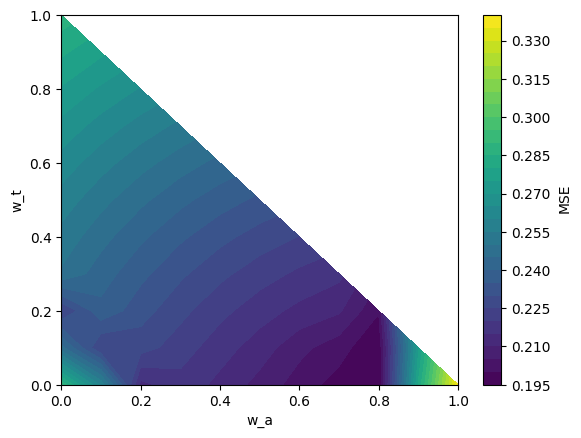

In [ ]:
plt.contourf(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), m_error, cmap='viridis', levels=30)
plt.colorbar()
plt.xlabel('w_a')
plt.ylabel('w_t')
plt.text(0.9, 0.5, 'MSE', rotation=90, va='center', ha='left', fontsize=10, transform=plt.gcf().transFigure)
plt.show()

##### p (para definir arestas) e t (para definir vértices de treino)

In [ ]:
# encontrar os melhores valores para ws
m_error = np.nan_to_num(m_error, nan=np.nan)
i_min, j_min = np.unravel_index(np.nanargmin(m_error), m_error.shape)
wa_min = np.arange(0, 1.1, 0.1)[j_min]
wt_min = np.arange(0, 1.1, 0.1)[i_min]
wf_min = 1 - wa_min - wt_min

In [ ]:
error_pt = np.ones((20, 19))

# construção do grafo
for i, p in enumerate(np.arange(0, 1, 0.05)):
    for j, t in enumerate(np.arange(0, 0.95, 0.05)):
        mver = MVER()
        graph_multimodal, train_mask = mver.consensus_graph(3, embeddings, coordnates, ws=[wt_min, wa_min, wf_min], p=p, t=t)
        mver.train_gcn(graph_multimodal, train_mask, num_epochs=200, verbose=True)
        final_graph = mver.gcn_adjust_coordnates(graph_multimodal, ~train_mask)
        error_pt[i, j] = mse(final_graph.y.to('cpu').numpy(), np.array(resp_p2))
        print(p, t, error_pt[i, j])

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0855
Epoch: 002, Loss: 18.9875
Epoch: 003, Loss: 0.9533
Epoch: 004, Loss: 6.6405
Epoch: 005, Loss: 2.2309
Epoch: 006, Loss: 2.7448
Epoch: 007, Loss: 2.2850
Epoch: 008, Loss: 0.2566
Epoch: 009, Loss: 0.4339
Epoch: 010, Loss: 2.6532
Epoch: 011, Loss: 0.3478
Epoch: 012, Loss: 0.3332
Epoch: 013, Loss: 0.4815
Epoch: 014, Loss: 0.4088
Epoch: 015, Loss: 0.1987
Epoch: 016, Loss: 0.1189
Epoch: 017, Loss: 0.1493
Epoch: 018, Loss: 0.0379
Epoch: 019, Loss: 0.0373
Epoch: 020, Loss: 0.0301
Epoch: 021, Loss: 0.0638
Epoch: 022, Loss: 0.0300
Epoch: 023, Loss: 0.0386
Epoch: 024, Loss: 0.0448
Epoch: 025, Loss: 0.0630
Epoch: 026, Loss: 0.0395
Epoch: 027, Loss: 0.0364
Epoch: 028, Loss: 0.0300
Epoch: 029, Loss: 0.0323
Epoch: 030, Loss: 0.0298
Epoch: 031, Loss: 0.0297
Epoch: 032, Loss: 0.0296
Epoch: 033, Loss: 0.0294
Epoch: 034, Loss: 0.0293
Epoch: 035, Loss: 0.0291
Epoch: 036, Loss: 0.0289
Epoch: 037, Loss: 0.0288
Epoch: 038, Loss: 0.0286
Epoch: 039, Loss: 0.0284
Epoch: 040, Loss: 0.0282

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1414
Epoch: 002, Loss: 16.6534
Epoch: 003, Loss: 2.5882
Epoch: 004, Loss: 0.0294
Epoch: 005, Loss: 0.4632
Epoch: 006, Loss: 0.5256
Epoch: 007, Loss: 0.4769
Epoch: 008, Loss: 0.1343
Epoch: 009, Loss: 0.0182
Epoch: 010, Loss: 0.0180
Epoch: 011, Loss: 0.0179
Epoch: 012, Loss: 0.0178
Epoch: 013, Loss: 0.0177
Epoch: 014, Loss: 0.0176
Epoch: 015, Loss: 0.0175
Epoch: 016, Loss: 0.0174
Epoch: 017, Loss: 0.0174
Epoch: 018, Loss: 0.0173
Epoch: 019, Loss: 0.0173
Epoch: 020, Loss: 0.0172
Epoch: 021, Loss: 0.0172
Epoch: 022, Loss: 0.0172
Epoch: 023, Loss: 0.0171
Epoch: 024, Loss: 0.0171
Epoch: 025, Loss: 0.0171
Epoch: 026, Loss: 0.0170
Epoch: 027, Loss: 0.0170
Epoch: 028, Loss: 0.0170
Epoch: 029, Loss: 0.0170
Epoch: 030, Loss: 0.0170
Epoch: 031, Loss: 0.0169
Epoch: 032, Loss: 0.0169
Epoch: 033, Loss: 0.0169
Epoch: 034, Loss: 0.0169
Epoch: 035, Loss: 0.0169
Epoch: 036, Loss: 0.0169
Epoch: 037, Loss: 0.0168
Epoch: 038, Loss: 0.0168
Epoch: 039, Loss: 0.0168
Epoch: 040, Loss: 0.0165

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4203
Epoch: 002, Loss: 32.6501
Epoch: 003, Loss: 4.8735
Epoch: 004, Loss: 3.1551
Epoch: 005, Loss: 1.6980
Epoch: 006, Loss: 2.6452
Epoch: 007, Loss: 1.4988
Epoch: 008, Loss: 0.0287
Epoch: 009, Loss: 0.0243
Epoch: 010, Loss: 0.0266
Epoch: 011, Loss: 0.0212
Epoch: 012, Loss: 0.0199
Epoch: 013, Loss: 0.0198
Epoch: 014, Loss: 0.0197
Epoch: 015, Loss: 0.0197
Epoch: 016, Loss: 0.0197
Epoch: 017, Loss: 0.0197
Epoch: 018, Loss: 0.0197
Epoch: 019, Loss: 0.0196
Epoch: 020, Loss: 0.0196
Epoch: 021, Loss: 0.0196
Epoch: 022, Loss: 0.0196
Epoch: 023, Loss: 0.0196
Epoch: 024, Loss: 0.0196
Epoch: 025, Loss: 0.0196
Epoch: 026, Loss: 0.0196
Epoch: 027, Loss: 0.0195
Epoch: 028, Loss: 0.0195
Epoch: 029, Loss: 0.0195
Epoch: 030, Loss: 0.0195
Epoch: 031, Loss: 0.0194
Epoch: 032, Loss: 0.0194
Epoch: 033, Loss: 0.0194
Epoch: 034, Loss: 0.0193
Epoch: 035, Loss: 0.0193
Epoch: 036, Loss: 0.0193
Epoch: 037, Loss: 0.0192
Epoch: 038, Loss: 0.0192
Epoch: 039, Loss: 0.0192
Epoch: 040, Loss: 0.0191

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0303
Epoch: 002, Loss: 49.3990
Epoch: 003, Loss: 0.7344
Epoch: 004, Loss: 4.8776
Epoch: 005, Loss: 2.2376
Epoch: 006, Loss: 0.1646
Epoch: 007, Loss: 0.0240
Epoch: 008, Loss: 0.0209
Epoch: 009, Loss: 0.0206
Epoch: 010, Loss: 0.0204
Epoch: 011, Loss: 0.0202
Epoch: 012, Loss: 0.0200
Epoch: 013, Loss: 0.0198
Epoch: 014, Loss: 0.0196
Epoch: 015, Loss: 0.0195
Epoch: 016, Loss: 0.0194
Epoch: 017, Loss: 0.0193
Epoch: 018, Loss: 0.0192
Epoch: 019, Loss: 0.0191
Epoch: 020, Loss: 0.0190
Epoch: 021, Loss: 0.0189
Epoch: 022, Loss: 0.0188
Epoch: 023, Loss: 0.0187
Epoch: 024, Loss: 0.0187
Epoch: 025, Loss: 0.0186
Epoch: 026, Loss: 0.0185
Epoch: 027, Loss: 0.0185
Epoch: 028, Loss: 0.0184
Epoch: 029, Loss: 0.0184
Epoch: 030, Loss: 0.0183
Epoch: 031, Loss: 0.0183
Epoch: 032, Loss: 0.0182
Epoch: 033, Loss: 0.0182
Epoch: 034, Loss: 0.0181
Epoch: 035, Loss: 0.0181
Epoch: 036, Loss: 0.0181
Epoch: 037, Loss: 0.0180
Epoch: 038, Loss: 0.0180
Epoch: 039, Loss: 0.0179
Epoch: 040, Loss: 0.0179

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0518
Epoch: 002, Loss: 49.5182
Epoch: 003, Loss: 8.4599
Epoch: 004, Loss: 6.8227
Epoch: 005, Loss: 4.5020
Epoch: 006, Loss: 0.2065
Epoch: 007, Loss: 0.0223
Epoch: 008, Loss: 0.0218
Epoch: 009, Loss: 0.0215
Epoch: 010, Loss: 0.0211
Epoch: 011, Loss: 0.0208
Epoch: 012, Loss: 0.0206
Epoch: 013, Loss: 0.0204
Epoch: 014, Loss: 0.0202
Epoch: 015, Loss: 0.0200
Epoch: 016, Loss: 0.0199
Epoch: 017, Loss: 0.0197
Epoch: 018, Loss: 0.0196
Epoch: 019, Loss: 0.0195
Epoch: 020, Loss: 0.0194
Epoch: 021, Loss: 0.0193
Epoch: 022, Loss: 0.0192
Epoch: 023, Loss: 0.0191
Epoch: 024, Loss: 0.0190
Epoch: 025, Loss: 0.0190
Epoch: 026, Loss: 0.0189
Epoch: 027, Loss: 0.0188
Epoch: 028, Loss: 0.0188
Epoch: 029, Loss: 0.0187
Epoch: 030, Loss: 0.0186
Epoch: 031, Loss: 0.0186
Epoch: 032, Loss: 0.0185
Epoch: 033, Loss: 0.0185
Epoch: 034, Loss: 0.0184
Epoch: 035, Loss: 0.0184
Epoch: 036, Loss: 0.0183
Epoch: 037, Loss: 0.0183
Epoch: 038, Loss: 0.0182
Epoch: 039, Loss: 0.0182
Epoch: 040, Loss: 0.0181

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0303
Epoch: 002, Loss: 15.6014
Epoch: 003, Loss: 8.5167
Epoch: 004, Loss: 2.5309
Epoch: 005, Loss: 3.3791
Epoch: 006, Loss: 1.0141
Epoch: 007, Loss: 0.5481
Epoch: 008, Loss: 0.5661
Epoch: 009, Loss: 0.0599
Epoch: 010, Loss: 0.0230
Epoch: 011, Loss: 0.0238
Epoch: 012, Loss: 0.0234
Epoch: 013, Loss: 0.0235
Epoch: 014, Loss: 0.0234
Epoch: 015, Loss: 0.0233
Epoch: 016, Loss: 0.0232
Epoch: 017, Loss: 0.0230
Epoch: 018, Loss: 0.0229
Epoch: 019, Loss: 0.0228
Epoch: 020, Loss: 0.0227
Epoch: 021, Loss: 0.0225
Epoch: 022, Loss: 0.0224
Epoch: 023, Loss: 0.0223
Epoch: 024, Loss: 0.0221
Epoch: 025, Loss: 0.0220
Epoch: 026, Loss: 0.0219
Epoch: 027, Loss: 0.0218
Epoch: 028, Loss: 0.0216
Epoch: 029, Loss: 0.0215
Epoch: 030, Loss: 0.0214
Epoch: 031, Loss: 0.0212
Epoch: 032, Loss: 0.0211
Epoch: 033, Loss: 0.0210
Epoch: 034, Loss: 0.0209
Epoch: 035, Loss: 0.0207
Epoch: 036, Loss: 0.0206
Epoch: 037, Loss: 0.0205
Epoch: 038, Loss: 0.0204
Epoch: 039, Loss: 0.0203
Epoch: 040, Loss: 0.0202

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.8518
Epoch: 002, Loss: 13.1863
Epoch: 003, Loss: 2.4478
Epoch: 004, Loss: 18.5441
Epoch: 005, Loss: 3.4598
Epoch: 006, Loss: 4.0156
Epoch: 007, Loss: 3.6276
Epoch: 008, Loss: 6.2134
Epoch: 009, Loss: 0.4393
Epoch: 010, Loss: 0.8513
Epoch: 011, Loss: 4.5495
Epoch: 012, Loss: 10.2924
Epoch: 013, Loss: 1.3444
Epoch: 014, Loss: 0.1741
Epoch: 015, Loss: 0.1045
Epoch: 016, Loss: 1.5268
Epoch: 017, Loss: 3.9900
Epoch: 018, Loss: 4.8779
Epoch: 019, Loss: 2.3246
Epoch: 020, Loss: 2.0070
Epoch: 021, Loss: 0.1728
Epoch: 022, Loss: 0.1243
Epoch: 023, Loss: 0.7063
Epoch: 024, Loss: 1.2013
Epoch: 025, Loss: 1.5071
Epoch: 026, Loss: 1.3866
Epoch: 027, Loss: 0.7957
Epoch: 028, Loss: 0.3964
Epoch: 029, Loss: 0.3455
Epoch: 030, Loss: 0.0606
Epoch: 031, Loss: 0.0217
Epoch: 032, Loss: 0.0205
Epoch: 033, Loss: 0.0204
Epoch: 034, Loss: 0.0203
Epoch: 035, Loss: 0.0202
Epoch: 036, Loss: 0.0201
Epoch: 037, Loss: 0.0200
Epoch: 038, Loss: 0.0199
Epoch: 039, Loss: 0.0198
Epoch: 040, Loss: 0.01

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3297
Epoch: 002, Loss: 96.9183
Epoch: 003, Loss: 4.2683
Epoch: 004, Loss: 0.0218
Epoch: 005, Loss: 1.6440
Epoch: 006, Loss: 2.2487
Epoch: 007, Loss: 1.0594
Epoch: 008, Loss: 0.7298
Epoch: 009, Loss: 0.3921
Epoch: 010, Loss: 0.0263
Epoch: 011, Loss: 0.0251
Epoch: 012, Loss: 0.0254
Epoch: 013, Loss: 0.0256
Epoch: 014, Loss: 0.0257
Epoch: 015, Loss: 0.0259
Epoch: 016, Loss: 0.0260
Epoch: 017, Loss: 0.0262
Epoch: 018, Loss: 0.0263
Epoch: 019, Loss: 0.0264
Epoch: 020, Loss: 0.0264
Epoch: 021, Loss: 0.0265
Epoch: 022, Loss: 0.0265
Epoch: 023, Loss: 0.0266
Epoch: 024, Loss: 0.0266
Epoch: 025, Loss: 0.0266
Epoch: 026, Loss: 0.0266
Epoch: 027, Loss: 0.0266
Epoch: 028, Loss: 0.0266
Epoch: 029, Loss: 0.0265
Epoch: 030, Loss: 0.0265
Epoch: 031, Loss: 0.0265
Epoch: 032, Loss: 0.0264
Epoch: 033, Loss: 0.0264
Epoch: 034, Loss: 0.0263
Epoch: 035, Loss: 0.0262
Epoch: 036, Loss: 0.0262
Epoch: 037, Loss: 0.0261
Epoch: 038, Loss: 0.0260
Epoch: 039, Loss: 0.0260
Epoch: 040, Loss: 0.0259

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2030
Epoch: 002, Loss: 18.2398
Epoch: 003, Loss: 0.1758
Epoch: 004, Loss: 0.2829
Epoch: 005, Loss: 0.9554
Epoch: 006, Loss: 1.9705
Epoch: 007, Loss: 5.5805
Epoch: 008, Loss: 5.2188
Epoch: 009, Loss: 1.1830
Epoch: 010, Loss: 4.0931
Epoch: 011, Loss: 7.1502
Epoch: 012, Loss: 1.1639
Epoch: 013, Loss: 0.2132
Epoch: 014, Loss: 2.9848
Epoch: 015, Loss: 2.7849
Epoch: 016, Loss: 2.9923
Epoch: 017, Loss: 0.4766
Epoch: 018, Loss: 1.2246
Epoch: 019, Loss: 2.3603
Epoch: 020, Loss: 0.1178
Epoch: 021, Loss: 1.0194
Epoch: 022, Loss: 0.3284
Epoch: 023, Loss: 1.3836
Epoch: 024, Loss: 0.0749
Epoch: 025, Loss: 0.4701
Epoch: 026, Loss: 2.3958
Epoch: 027, Loss: 0.1157
Epoch: 028, Loss: 0.6565
Epoch: 029, Loss: 1.2441
Epoch: 030, Loss: 1.0439
Epoch: 031, Loss: 0.1985
Epoch: 032, Loss: 0.0988
Epoch: 033, Loss: 0.0245
Epoch: 034, Loss: 0.0250
Epoch: 035, Loss: 0.0293
Epoch: 036, Loss: 0.0319
Epoch: 037, Loss: 0.0301
Epoch: 038, Loss: 0.0281
Epoch: 039, Loss: 0.0276
Epoch: 040, Loss: 0.0274

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0593
Epoch: 002, Loss: 36.3030
Epoch: 003, Loss: 4.8757
Epoch: 004, Loss: 0.1775
Epoch: 005, Loss: 3.5226
Epoch: 006, Loss: 0.0200
Epoch: 007, Loss: 0.0220
Epoch: 008, Loss: 0.0217
Epoch: 009, Loss: 0.0215
Epoch: 010, Loss: 0.0213
Epoch: 011, Loss: 0.0211
Epoch: 012, Loss: 0.0209
Epoch: 013, Loss: 0.0208
Epoch: 014, Loss: 0.0206
Epoch: 015, Loss: 0.0205
Epoch: 016, Loss: 0.0203
Epoch: 017, Loss: 0.0202
Epoch: 018, Loss: 0.0201
Epoch: 019, Loss: 0.0200
Epoch: 020, Loss: 0.0198
Epoch: 021, Loss: 0.0197
Epoch: 022, Loss: 0.0196
Epoch: 023, Loss: 0.0195
Epoch: 024, Loss: 0.0194
Epoch: 025, Loss: 0.0193
Epoch: 026, Loss: 0.0192
Epoch: 027, Loss: 0.0192
Epoch: 028, Loss: 0.0191
Epoch: 029, Loss: 0.0190
Epoch: 030, Loss: 0.0189
Epoch: 031, Loss: 0.0188
Epoch: 032, Loss: 0.0188
Epoch: 033, Loss: 0.0187
Epoch: 034, Loss: 0.0186
Epoch: 035, Loss: 0.0185
Epoch: 036, Loss: 0.0185
Epoch: 037, Loss: 0.0184
Epoch: 038, Loss: 0.0184
Epoch: 039, Loss: 0.0183
Epoch: 040, Loss: 0.0182

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0519
Epoch: 002, Loss: 77.4525
Epoch: 003, Loss: 4.9045
Epoch: 004, Loss: 6.8313
Epoch: 005, Loss: 4.0935
Epoch: 006, Loss: 2.8832
Epoch: 007, Loss: 1.4179
Epoch: 008, Loss: 0.6186
Epoch: 009, Loss: 0.0425
Epoch: 010, Loss: 0.0267
Epoch: 011, Loss: 0.0274
Epoch: 012, Loss: 0.0280
Epoch: 013, Loss: 0.0285
Epoch: 014, Loss: 0.0290
Epoch: 015, Loss: 0.0295
Epoch: 016, Loss: 0.0299
Epoch: 017, Loss: 0.0302
Epoch: 018, Loss: 0.0305
Epoch: 019, Loss: 0.0308
Epoch: 020, Loss: 0.0310
Epoch: 021, Loss: 0.0311
Epoch: 022, Loss: 0.0312
Epoch: 023, Loss: 0.0313
Epoch: 024, Loss: 0.0313
Epoch: 025, Loss: 0.0314
Epoch: 026, Loss: 0.0313
Epoch: 027, Loss: 0.0313
Epoch: 028, Loss: 0.0312
Epoch: 029, Loss: 0.0311
Epoch: 030, Loss: 0.0310
Epoch: 031, Loss: 0.0309
Epoch: 032, Loss: 0.0307
Epoch: 033, Loss: 0.0305
Epoch: 034, Loss: 0.0304
Epoch: 035, Loss: 0.0302
Epoch: 036, Loss: 0.0300
Epoch: 037, Loss: 0.0298
Epoch: 038, Loss: 0.0295
Epoch: 039, Loss: 0.0293
Epoch: 040, Loss: 0.0291

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1828
Epoch: 002, Loss: 18.7357
Epoch: 003, Loss: 10.1692
Epoch: 004, Loss: 16.4214
Epoch: 005, Loss: 5.4209
Epoch: 006, Loss: 9.9114
Epoch: 007, Loss: 5.0113
Epoch: 008, Loss: 1.7471
Epoch: 009, Loss: 7.1567
Epoch: 010, Loss: 1.8474
Epoch: 011, Loss: 0.6482
Epoch: 012, Loss: 1.8962
Epoch: 013, Loss: 7.6989
Epoch: 014, Loss: 1.4308
Epoch: 015, Loss: 5.2729
Epoch: 016, Loss: 0.4960
Epoch: 017, Loss: 0.1371
Epoch: 018, Loss: 1.2703
Epoch: 019, Loss: 0.2480
Epoch: 020, Loss: 0.5238
Epoch: 021, Loss: 0.5160
Epoch: 022, Loss: 0.0785
Epoch: 023, Loss: 0.0849
Epoch: 024, Loss: 0.0163
Epoch: 025, Loss: 0.0261
Epoch: 026, Loss: 0.0768
Epoch: 027, Loss: 0.0531
Epoch: 028, Loss: 0.0207
Epoch: 029, Loss: 0.0159
Epoch: 030, Loss: 0.0352
Epoch: 031, Loss: 0.0156
Epoch: 032, Loss: 0.0165
Epoch: 033, Loss: 0.0167
Epoch: 034, Loss: 0.0168
Epoch: 035, Loss: 0.0175
Epoch: 036, Loss: 0.0178
Epoch: 037, Loss: 0.0198
Epoch: 038, Loss: 0.0204
Epoch: 039, Loss: 0.0206
Epoch: 040, Loss: 0.02

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0527
Epoch: 002, Loss: 68.4102
Epoch: 003, Loss: 5.8839
Epoch: 004, Loss: 15.1452
Epoch: 005, Loss: 8.5538
Epoch: 006, Loss: 3.5834
Epoch: 007, Loss: 0.8330
Epoch: 008, Loss: 0.2704
Epoch: 009, Loss: 0.6021
Epoch: 010, Loss: 0.6358
Epoch: 011, Loss: 1.0270
Epoch: 012, Loss: 0.2841
Epoch: 013, Loss: 0.1645
Epoch: 014, Loss: 0.0360
Epoch: 015, Loss: 0.0248
Epoch: 016, Loss: 0.0232
Epoch: 017, Loss: 0.0240
Epoch: 018, Loss: 0.0240
Epoch: 019, Loss: 0.0240
Epoch: 020, Loss: 0.0240
Epoch: 021, Loss: 0.0240
Epoch: 022, Loss: 0.0240
Epoch: 023, Loss: 0.0240
Epoch: 024, Loss: 0.0240
Epoch: 025, Loss: 0.0239
Epoch: 026, Loss: 0.0239
Epoch: 027, Loss: 0.0239
Epoch: 028, Loss: 0.0238
Epoch: 029, Loss: 0.0238
Epoch: 030, Loss: 0.0238
Epoch: 031, Loss: 0.0237
Epoch: 032, Loss: 0.0237
Epoch: 033, Loss: 0.0236
Epoch: 034, Loss: 0.0236
Epoch: 035, Loss: 0.0235
Epoch: 036, Loss: 0.0234
Epoch: 037, Loss: 0.0234
Epoch: 038, Loss: 0.0233
Epoch: 039, Loss: 0.0233
Epoch: 040, Loss: 0.023

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0790
Epoch: 002, Loss: 17.2858
Epoch: 003, Loss: 2.1395
Epoch: 004, Loss: 10.6418
Epoch: 005, Loss: 0.8895
Epoch: 006, Loss: 1.9444
Epoch: 007, Loss: 0.0477
Epoch: 008, Loss: 0.0227
Epoch: 009, Loss: 0.0226
Epoch: 010, Loss: 0.0225
Epoch: 011, Loss: 0.0224
Epoch: 012, Loss: 0.0223
Epoch: 013, Loss: 0.0222
Epoch: 014, Loss: 0.0221
Epoch: 015, Loss: 0.0220
Epoch: 016, Loss: 0.0219
Epoch: 017, Loss: 0.0218
Epoch: 018, Loss: 0.0217
Epoch: 019, Loss: 0.0216
Epoch: 020, Loss: 0.0215
Epoch: 021, Loss: 0.0214
Epoch: 022, Loss: 0.0213
Epoch: 023, Loss: 0.0212
Epoch: 024, Loss: 0.0211
Epoch: 025, Loss: 0.0210
Epoch: 026, Loss: 0.0209
Epoch: 027, Loss: 0.0208
Epoch: 028, Loss: 0.0207
Epoch: 029, Loss: 0.0206
Epoch: 030, Loss: 0.0205
Epoch: 031, Loss: 0.0204
Epoch: 032, Loss: 0.0204
Epoch: 033, Loss: 0.0203
Epoch: 034, Loss: 0.0202
Epoch: 035, Loss: 0.0201
Epoch: 036, Loss: 0.0200
Epoch: 037, Loss: 0.0199
Epoch: 038, Loss: 0.0198
Epoch: 039, Loss: 0.0197
Epoch: 040, Loss: 0.019

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2990
Epoch: 002, Loss: 70.3445
Epoch: 003, Loss: 6.4104
Epoch: 004, Loss: 3.5028
Epoch: 005, Loss: 0.1830
Epoch: 006, Loss: 0.7229
Epoch: 007, Loss: 0.1444
Epoch: 008, Loss: 0.0981
Epoch: 009, Loss: 0.1589
Epoch: 010, Loss: 0.7585
Epoch: 011, Loss: 0.3573
Epoch: 012, Loss: 0.1687
Epoch: 013, Loss: 0.0868
Epoch: 014, Loss: 0.1135
Epoch: 015, Loss: 0.2617
Epoch: 016, Loss: 0.0441
Epoch: 017, Loss: 0.0571
Epoch: 018, Loss: 0.0503
Epoch: 019, Loss: 0.0557
Epoch: 020, Loss: 0.0380
Epoch: 021, Loss: 0.0319
Epoch: 022, Loss: 0.0313
Epoch: 023, Loss: 0.0308
Epoch: 024, Loss: 0.0307
Epoch: 025, Loss: 0.0307
Epoch: 026, Loss: 0.0307
Epoch: 027, Loss: 0.0307
Epoch: 028, Loss: 0.0307
Epoch: 029, Loss: 0.0306
Epoch: 030, Loss: 0.0305
Epoch: 031, Loss: 0.0305
Epoch: 032, Loss: 0.0304
Epoch: 033, Loss: 0.0303
Epoch: 034, Loss: 0.0302
Epoch: 035, Loss: 0.0300
Epoch: 036, Loss: 0.0299
Epoch: 037, Loss: 0.0298
Epoch: 038, Loss: 0.0297
Epoch: 039, Loss: 0.0295
Epoch: 040, Loss: 0.0294

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3396
Epoch: 002, Loss: 4.3210
Epoch: 003, Loss: 2.7879
Epoch: 004, Loss: 0.7727
Epoch: 005, Loss: 8.8188
Epoch: 006, Loss: 0.5349
Epoch: 007, Loss: 0.0701
Epoch: 008, Loss: 0.0776
Epoch: 009, Loss: 0.0701
Epoch: 010, Loss: 0.0881
Epoch: 011, Loss: 0.0347
Epoch: 012, Loss: 0.0474
Epoch: 013, Loss: 0.0332
Epoch: 014, Loss: 0.0304
Epoch: 015, Loss: 0.0274
Epoch: 016, Loss: 0.0271
Epoch: 017, Loss: 0.0272
Epoch: 018, Loss: 0.0273
Epoch: 019, Loss: 0.0273
Epoch: 020, Loss: 0.0273
Epoch: 021, Loss: 0.0273
Epoch: 022, Loss: 0.0272
Epoch: 023, Loss: 0.0271
Epoch: 024, Loss: 0.0270
Epoch: 025, Loss: 0.0269
Epoch: 026, Loss: 0.0268
Epoch: 027, Loss: 0.0267
Epoch: 028, Loss: 0.0265
Epoch: 029, Loss: 0.0263
Epoch: 030, Loss: 0.0262
Epoch: 031, Loss: 0.0260
Epoch: 032, Loss: 0.0258
Epoch: 033, Loss: 0.0256
Epoch: 034, Loss: 0.0254
Epoch: 035, Loss: 0.0252
Epoch: 036, Loss: 0.0249
Epoch: 037, Loss: 0.0247
Epoch: 038, Loss: 0.0245
Epoch: 039, Loss: 0.0243
Epoch: 040, Loss: 0.0241


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1951
Epoch: 002, Loss: 51.2109
Epoch: 003, Loss: 2.3787
Epoch: 004, Loss: 1.9225
Epoch: 005, Loss: 1.3046
Epoch: 006, Loss: 1.1406
Epoch: 007, Loss: 0.1100
Epoch: 008, Loss: 0.0213
Epoch: 009, Loss: 0.0212
Epoch: 010, Loss: 0.0210
Epoch: 011, Loss: 0.0209
Epoch: 012, Loss: 0.0207
Epoch: 013, Loss: 0.0206
Epoch: 014, Loss: 0.0205
Epoch: 015, Loss: 0.0204
Epoch: 016, Loss: 0.0203
Epoch: 017, Loss: 0.0202
Epoch: 018, Loss: 0.0201
Epoch: 019, Loss: 0.0200
Epoch: 020, Loss: 0.0199
Epoch: 021, Loss: 0.0199
Epoch: 022, Loss: 0.0198
Epoch: 023, Loss: 0.0197
Epoch: 024, Loss: 0.0196
Epoch: 025, Loss: 0.0196
Epoch: 026, Loss: 0.0195
Epoch: 027, Loss: 0.0195
Epoch: 028, Loss: 0.0194
Epoch: 029, Loss: 0.0193
Epoch: 030, Loss: 0.0193
Epoch: 031, Loss: 0.0192
Epoch: 032, Loss: 0.0192
Epoch: 033, Loss: 0.0191
Epoch: 034, Loss: 0.0191
Epoch: 035, Loss: 0.0190
Epoch: 036, Loss: 0.0190
Epoch: 037, Loss: 0.0189
Epoch: 038, Loss: 0.0189
Epoch: 039, Loss: 0.0188
Epoch: 040, Loss: 0.0188

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.5980
Epoch: 002, Loss: 21.2601
Epoch: 003, Loss: 0.9636
Epoch: 004, Loss: 0.0078
Epoch: 005, Loss: 0.0083
Epoch: 006, Loss: 0.2689
Epoch: 007, Loss: 0.0078
Epoch: 008, Loss: 0.0095
Epoch: 009, Loss: 0.0099
Epoch: 010, Loss: 0.0102
Epoch: 011, Loss: 0.0105
Epoch: 012, Loss: 0.0107
Epoch: 013, Loss: 0.0109
Epoch: 014, Loss: 0.0111
Epoch: 015, Loss: 0.0113
Epoch: 016, Loss: 0.0114
Epoch: 017, Loss: 0.0115
Epoch: 018, Loss: 0.0116
Epoch: 019, Loss: 0.0116
Epoch: 020, Loss: 0.0117
Epoch: 021, Loss: 0.0117
Epoch: 022, Loss: 0.0117
Epoch: 023, Loss: 0.0117
Epoch: 024, Loss: 0.0116
Epoch: 025, Loss: 0.0116
Epoch: 026, Loss: 0.0116
Epoch: 027, Loss: 0.0115
Epoch: 028, Loss: 0.0114
Epoch: 029, Loss: 0.0114
Epoch: 030, Loss: 0.0113
Epoch: 031, Loss: 0.0112
Epoch: 032, Loss: 0.0111
Epoch: 033, Loss: 0.0110
Epoch: 034, Loss: 0.0108
Epoch: 035, Loss: 0.0107
Epoch: 036, Loss: 0.0106
Epoch: 037, Loss: 0.0105
Epoch: 038, Loss: 0.0104
Epoch: 039, Loss: 0.0102
Epoch: 040, Loss: 0.0101

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.5952
Epoch: 002, Loss: 5.4076
Epoch: 003, Loss: 3.1189
Epoch: 004, Loss: 0.2890
Epoch: 005, Loss: 8.4565
Epoch: 006, Loss: 1.3098
Epoch: 007, Loss: 2.1498
Epoch: 008, Loss: 2.6519
Epoch: 009, Loss: 0.5034
Epoch: 010, Loss: 0.0053
Epoch: 011, Loss: 0.0055
Epoch: 012, Loss: 0.0056
Epoch: 013, Loss: 0.0058
Epoch: 014, Loss: 0.0058
Epoch: 015, Loss: 0.0059
Epoch: 016, Loss: 0.0060
Epoch: 017, Loss: 0.0060
Epoch: 018, Loss: 0.0060
Epoch: 019, Loss: 0.0060
Epoch: 020, Loss: 0.0060
Epoch: 021, Loss: 0.0060
Epoch: 022, Loss: 0.0060
Epoch: 023, Loss: 0.0059
Epoch: 024, Loss: 0.0059
Epoch: 025, Loss: 0.0058
Epoch: 026, Loss: 0.0057
Epoch: 027, Loss: 0.0056
Epoch: 028, Loss: 0.0056
Epoch: 029, Loss: 0.0055
Epoch: 030, Loss: 0.0054
Epoch: 031, Loss: 0.0053
Epoch: 032, Loss: 0.0051
Epoch: 033, Loss: 0.0050
Epoch: 034, Loss: 0.0049
Epoch: 035, Loss: 0.0048
Epoch: 036, Loss: 0.0047
Epoch: 037, Loss: 0.0046
Epoch: 038, Loss: 0.0045
Epoch: 039, Loss: 0.0043
Epoch: 040, Loss: 0.0042


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0194
Epoch: 002, Loss: 15.1118
Epoch: 003, Loss: 1.0697
Epoch: 004, Loss: 0.0238
Epoch: 005, Loss: 0.0274
Epoch: 006, Loss: 0.0230
Epoch: 007, Loss: 0.0226
Epoch: 008, Loss: 0.0222
Epoch: 009, Loss: 0.0218
Epoch: 010, Loss: 0.0214
Epoch: 011, Loss: 0.0210
Epoch: 012, Loss: 0.0206
Epoch: 013, Loss: 0.0202
Epoch: 014, Loss: 0.0198
Epoch: 015, Loss: 0.0195
Epoch: 016, Loss: 0.0192
Epoch: 017, Loss: 0.0189
Epoch: 018, Loss: 0.0186
Epoch: 019, Loss: 0.0184
Epoch: 020, Loss: 0.0182
Epoch: 021, Loss: 0.0180
Epoch: 022, Loss: 0.0178
Epoch: 023, Loss: 0.0177
Epoch: 024, Loss: 0.0176
Epoch: 025, Loss: 0.0175
Epoch: 026, Loss: 0.0174
Epoch: 027, Loss: 0.0174
Epoch: 028, Loss: 0.0173
Epoch: 029, Loss: 0.0173
Epoch: 030, Loss: 0.0173
Epoch: 031, Loss: 0.0172
Epoch: 032, Loss: 0.0172
Epoch: 033, Loss: 0.0172
Epoch: 034, Loss: 0.0172
Epoch: 035, Loss: 0.0172
Epoch: 036, Loss: 0.0171
Epoch: 037, Loss: 0.0171
Epoch: 038, Loss: 0.0171
Epoch: 039, Loss: 0.0171
Epoch: 040, Loss: 0.0171

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0510
Epoch: 002, Loss: 16.4869
Epoch: 003, Loss: 8.0366
Epoch: 004, Loss: 6.7247
Epoch: 005, Loss: 0.3449
Epoch: 006, Loss: 1.9275
Epoch: 007, Loss: 1.8191
Epoch: 008, Loss: 0.1890
Epoch: 009, Loss: 0.1546
Epoch: 010, Loss: 0.4705
Epoch: 011, Loss: 0.4380
Epoch: 012, Loss: 1.1860
Epoch: 013, Loss: 0.4943
Epoch: 014, Loss: 0.2331
Epoch: 015, Loss: 0.1807
Epoch: 016, Loss: 0.0770
Epoch: 017, Loss: 0.0606
Epoch: 018, Loss: 0.2001
Epoch: 019, Loss: 0.0872
Epoch: 020, Loss: 0.0186
Epoch: 021, Loss: 0.0185
Epoch: 022, Loss: 0.0144
Epoch: 023, Loss: 0.0148
Epoch: 024, Loss: 0.0179
Epoch: 025, Loss: 0.0224
Epoch: 026, Loss: 0.0224
Epoch: 027, Loss: 0.0224
Epoch: 028, Loss: 0.0223
Epoch: 029, Loss: 0.0223
Epoch: 030, Loss: 0.0222
Epoch: 031, Loss: 0.0221
Epoch: 032, Loss: 0.0221
Epoch: 033, Loss: 0.0220
Epoch: 034, Loss: 0.0219
Epoch: 035, Loss: 0.0218
Epoch: 036, Loss: 0.0217
Epoch: 037, Loss: 0.0216
Epoch: 038, Loss: 0.0215
Epoch: 039, Loss: 0.0214
Epoch: 040, Loss: 0.0213

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1129
Epoch: 002, Loss: 9.2699
Epoch: 003, Loss: 1.5678
Epoch: 004, Loss: 0.0373
Epoch: 005, Loss: 1.6375
Epoch: 006, Loss: 0.1239
Epoch: 007, Loss: 0.2592
Epoch: 008, Loss: 0.1831
Epoch: 009, Loss: 0.0856
Epoch: 010, Loss: 0.0561
Epoch: 011, Loss: 0.0264
Epoch: 012, Loss: 0.0194
Epoch: 013, Loss: 0.0191
Epoch: 014, Loss: 0.0189
Epoch: 015, Loss: 0.0188
Epoch: 016, Loss: 0.0186
Epoch: 017, Loss: 0.0185
Epoch: 018, Loss: 0.0183
Epoch: 019, Loss: 0.0182
Epoch: 020, Loss: 0.0181
Epoch: 021, Loss: 0.0180
Epoch: 022, Loss: 0.0179
Epoch: 023, Loss: 0.0178
Epoch: 024, Loss: 0.0178
Epoch: 025, Loss: 0.0177
Epoch: 026, Loss: 0.0176
Epoch: 027, Loss: 0.0176
Epoch: 028, Loss: 0.0175
Epoch: 029, Loss: 0.0175
Epoch: 030, Loss: 0.0174
Epoch: 031, Loss: 0.0174
Epoch: 032, Loss: 0.0173
Epoch: 033, Loss: 0.0173
Epoch: 034, Loss: 0.0173
Epoch: 035, Loss: 0.0172
Epoch: 036, Loss: 0.0172
Epoch: 037, Loss: 0.0172
Epoch: 038, Loss: 0.0171
Epoch: 039, Loss: 0.0171
Epoch: 040, Loss: 0.0171


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0764
Epoch: 002, Loss: 126.2505
Epoch: 003, Loss: 10.5627
Epoch: 004, Loss: 0.0221
Epoch: 005, Loss: 0.0214
Epoch: 006, Loss: 0.0208
Epoch: 007, Loss: 0.0203
Epoch: 008, Loss: 0.0199
Epoch: 009, Loss: 0.0196
Epoch: 010, Loss: 0.0193
Epoch: 011, Loss: 0.0191
Epoch: 012, Loss: 0.0189
Epoch: 013, Loss: 0.0187
Epoch: 014, Loss: 0.0185
Epoch: 015, Loss: 0.0184
Epoch: 016, Loss: 0.0183
Epoch: 017, Loss: 0.0182
Epoch: 018, Loss: 0.0181
Epoch: 019, Loss: 0.0180
Epoch: 020, Loss: 0.0179
Epoch: 021, Loss: 0.0179
Epoch: 022, Loss: 0.0178
Epoch: 023, Loss: 0.0178
Epoch: 024, Loss: 0.0177
Epoch: 025, Loss: 0.0177
Epoch: 026, Loss: 0.0176
Epoch: 027, Loss: 0.0176
Epoch: 028, Loss: 0.0175
Epoch: 029, Loss: 0.0175
Epoch: 030, Loss: 0.0175
Epoch: 031, Loss: 0.0174
Epoch: 032, Loss: 0.0174
Epoch: 033, Loss: 0.0174
Epoch: 034, Loss: 0.0174
Epoch: 035, Loss: 0.0173
Epoch: 036, Loss: 0.0173
Epoch: 037, Loss: 0.0173
Epoch: 038, Loss: 0.0173
Epoch: 039, Loss: 0.0172
Epoch: 040, Loss: 0.01

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1634
Epoch: 002, Loss: 99.6182
Epoch: 003, Loss: 4.9592
Epoch: 004, Loss: 3.6324
Epoch: 005, Loss: 2.2540
Epoch: 006, Loss: 0.8606
Epoch: 007, Loss: 0.5802
Epoch: 008, Loss: 0.6311
Epoch: 009, Loss: 0.8474
Epoch: 010, Loss: 0.4365
Epoch: 011, Loss: 0.4022
Epoch: 012, Loss: 0.3187
Epoch: 013, Loss: 0.1904
Epoch: 014, Loss: 0.0991
Epoch: 015, Loss: 0.1097
Epoch: 016, Loss: 0.0279
Epoch: 017, Loss: 0.0297
Epoch: 018, Loss: 0.0309
Epoch: 019, Loss: 0.0312
Epoch: 020, Loss: 0.0314
Epoch: 021, Loss: 0.0316
Epoch: 022, Loss: 0.0317
Epoch: 023, Loss: 0.0319
Epoch: 024, Loss: 0.0320
Epoch: 025, Loss: 0.0321
Epoch: 026, Loss: 0.0321
Epoch: 027, Loss: 0.0322
Epoch: 028, Loss: 0.0322
Epoch: 029, Loss: 0.0322
Epoch: 030, Loss: 0.0321
Epoch: 031, Loss: 0.0321
Epoch: 032, Loss: 0.0321
Epoch: 033, Loss: 0.0320
Epoch: 034, Loss: 0.0319
Epoch: 035, Loss: 0.0318
Epoch: 036, Loss: 0.0317
Epoch: 037, Loss: 0.0316
Epoch: 038, Loss: 0.0315
Epoch: 039, Loss: 0.0314
Epoch: 040, Loss: 0.0312

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.6351
Epoch: 002, Loss: 47.6031
Epoch: 003, Loss: 5.4006
Epoch: 004, Loss: 2.0832
Epoch: 005, Loss: 0.7630
Epoch: 006, Loss: 1.5150
Epoch: 007, Loss: 0.7040
Epoch: 008, Loss: 0.0387
Epoch: 009, Loss: 0.0249
Epoch: 010, Loss: 0.0256
Epoch: 011, Loss: 0.0262
Epoch: 012, Loss: 0.0268
Epoch: 013, Loss: 0.0273
Epoch: 014, Loss: 0.0278
Epoch: 015, Loss: 0.0282
Epoch: 016, Loss: 0.0286
Epoch: 017, Loss: 0.0289
Epoch: 018, Loss: 0.0292
Epoch: 019, Loss: 0.0295
Epoch: 020, Loss: 0.0297
Epoch: 021, Loss: 0.0298
Epoch: 022, Loss: 0.0300
Epoch: 023, Loss: 0.0301
Epoch: 024, Loss: 0.0301
Epoch: 025, Loss: 0.0302
Epoch: 026, Loss: 0.0302
Epoch: 027, Loss: 0.0302
Epoch: 028, Loss: 0.0301
Epoch: 029, Loss: 0.0300
Epoch: 030, Loss: 0.0300
Epoch: 031, Loss: 0.0298
Epoch: 032, Loss: 0.0297
Epoch: 033, Loss: 0.0296
Epoch: 034, Loss: 0.0294
Epoch: 035, Loss: 0.0293
Epoch: 036, Loss: 0.0291
Epoch: 037, Loss: 0.0289
Epoch: 038, Loss: 0.0287
Epoch: 039, Loss: 0.0285
Epoch: 040, Loss: 0.0283

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0512
Epoch: 002, Loss: 15.5537
Epoch: 003, Loss: 0.9552
Epoch: 004, Loss: 0.0257
Epoch: 005, Loss: 1.2622
Epoch: 006, Loss: 0.0177
Epoch: 007, Loss: 1.6132
Epoch: 008, Loss: 0.0289
Epoch: 009, Loss: 0.0235
Epoch: 010, Loss: 0.0239
Epoch: 011, Loss: 0.0242
Epoch: 012, Loss: 0.0244
Epoch: 013, Loss: 0.0245
Epoch: 014, Loss: 0.0246
Epoch: 015, Loss: 0.0247
Epoch: 016, Loss: 0.0247
Epoch: 017, Loss: 0.0247
Epoch: 018, Loss: 0.0246
Epoch: 019, Loss: 0.0245
Epoch: 020, Loss: 0.0244
Epoch: 021, Loss: 0.0242
Epoch: 022, Loss: 0.0240
Epoch: 023, Loss: 0.0238
Epoch: 024, Loss: 0.0236
Epoch: 025, Loss: 0.0234
Epoch: 026, Loss: 0.0232
Epoch: 027, Loss: 0.0230
Epoch: 028, Loss: 0.0227
Epoch: 029, Loss: 0.0225
Epoch: 030, Loss: 0.0223
Epoch: 031, Loss: 0.0220
Epoch: 032, Loss: 0.0218
Epoch: 033, Loss: 0.0216
Epoch: 034, Loss: 0.0214
Epoch: 035, Loss: 0.0212
Epoch: 036, Loss: 0.0209
Epoch: 037, Loss: 0.0208
Epoch: 038, Loss: 0.0206
Epoch: 039, Loss: 0.0204
Epoch: 040, Loss: 0.0202

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3771
Epoch: 002, Loss: 2.7527
Epoch: 003, Loss: 1.8254
Epoch: 004, Loss: 3.1562
Epoch: 005, Loss: 0.6811
Epoch: 006, Loss: 0.0605
Epoch: 007, Loss: 0.0214
Epoch: 008, Loss: 0.0215
Epoch: 009, Loss: 0.0215
Epoch: 010, Loss: 0.0216
Epoch: 011, Loss: 0.0216
Epoch: 012, Loss: 0.0215
Epoch: 013, Loss: 0.0215
Epoch: 014, Loss: 0.0215
Epoch: 015, Loss: 0.0214
Epoch: 016, Loss: 0.0213
Epoch: 017, Loss: 0.0212
Epoch: 018, Loss: 0.0211
Epoch: 019, Loss: 0.0210
Epoch: 020, Loss: 0.0209
Epoch: 021, Loss: 0.0208
Epoch: 022, Loss: 0.0207
Epoch: 023, Loss: 0.0206
Epoch: 024, Loss: 0.0204
Epoch: 025, Loss: 0.0203
Epoch: 026, Loss: 0.0202
Epoch: 027, Loss: 0.0200
Epoch: 028, Loss: 0.0199
Epoch: 029, Loss: 0.0198
Epoch: 030, Loss: 0.0196
Epoch: 031, Loss: 0.0195
Epoch: 032, Loss: 0.0194
Epoch: 033, Loss: 0.0192
Epoch: 034, Loss: 0.0191
Epoch: 035, Loss: 0.0190
Epoch: 036, Loss: 0.0188
Epoch: 037, Loss: 0.0187
Epoch: 038, Loss: 0.0186
Epoch: 039, Loss: 0.0185
Epoch: 040, Loss: 0.0184


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2127
Epoch: 002, Loss: 0.1425
Epoch: 003, Loss: 1.3371
Epoch: 004, Loss: 0.1631
Epoch: 005, Loss: 0.2062
Epoch: 006, Loss: 0.0638
Epoch: 007, Loss: 0.1644
Epoch: 008, Loss: 0.0602
Epoch: 009, Loss: 0.0264
Epoch: 010, Loss: 0.0743
Epoch: 011, Loss: 0.0646
Epoch: 012, Loss: 0.0367
Epoch: 013, Loss: 0.0361
Epoch: 014, Loss: 0.0225
Epoch: 015, Loss: 0.0420
Epoch: 016, Loss: 0.0369
Epoch: 017, Loss: 0.0314
Epoch: 018, Loss: 0.0251
Epoch: 019, Loss: 0.0598
Epoch: 020, Loss: 0.0594
Epoch: 021, Loss: 0.0161
Epoch: 022, Loss: 0.0401
Epoch: 023, Loss: 0.0245
Epoch: 024, Loss: 0.0220
Epoch: 025, Loss: 0.0220
Epoch: 026, Loss: 0.0164
Epoch: 027, Loss: 0.0272
Epoch: 028, Loss: 0.0264
Epoch: 029, Loss: 0.0229
Epoch: 030, Loss: 0.0188
Epoch: 031, Loss: 0.0183
Epoch: 032, Loss: 0.0176
Epoch: 033, Loss: 0.0176
Epoch: 034, Loss: 0.0141
Epoch: 035, Loss: 0.0141
Epoch: 036, Loss: 0.0141
Epoch: 037, Loss: 0.0137
Epoch: 038, Loss: 0.0142
Epoch: 039, Loss: 0.0133
Epoch: 040, Loss: 0.0132


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1973
Epoch: 002, Loss: 62.6370
Epoch: 003, Loss: 3.3852
Epoch: 004, Loss: 2.2023
Epoch: 005, Loss: 1.7093
Epoch: 006, Loss: 0.9637
Epoch: 007, Loss: 0.3138
Epoch: 008, Loss: 0.0370
Epoch: 009, Loss: 0.0276
Epoch: 010, Loss: 0.0284
Epoch: 011, Loss: 0.0292
Epoch: 012, Loss: 0.0298
Epoch: 013, Loss: 0.0304
Epoch: 014, Loss: 0.0309
Epoch: 015, Loss: 0.0314
Epoch: 016, Loss: 0.0318
Epoch: 017, Loss: 0.0322
Epoch: 018, Loss: 0.0325
Epoch: 019, Loss: 0.0327
Epoch: 020, Loss: 0.0329
Epoch: 021, Loss: 0.0330
Epoch: 022, Loss: 0.0331
Epoch: 023, Loss: 0.0332
Epoch: 024, Loss: 0.0332
Epoch: 025, Loss: 0.0332
Epoch: 026, Loss: 0.0331
Epoch: 027, Loss: 0.0330
Epoch: 028, Loss: 0.0329
Epoch: 029, Loss: 0.0328
Epoch: 030, Loss: 0.0327
Epoch: 031, Loss: 0.0325
Epoch: 032, Loss: 0.0323
Epoch: 033, Loss: 0.0321
Epoch: 034, Loss: 0.0319
Epoch: 035, Loss: 0.0317
Epoch: 036, Loss: 0.0314
Epoch: 037, Loss: 0.0312
Epoch: 038, Loss: 0.0309
Epoch: 039, Loss: 0.0306
Epoch: 040, Loss: 0.0304

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0404
Epoch: 002, Loss: 20.3085
Epoch: 003, Loss: 0.9615
Epoch: 004, Loss: 1.2610
Epoch: 005, Loss: 0.9486
Epoch: 006, Loss: 0.1590
Epoch: 007, Loss: 0.1143
Epoch: 008, Loss: 0.0180
Epoch: 009, Loss: 0.0229
Epoch: 010, Loss: 0.0244
Epoch: 011, Loss: 0.0246
Epoch: 012, Loss: 0.0247
Epoch: 013, Loss: 0.0248
Epoch: 014, Loss: 0.0248
Epoch: 015, Loss: 0.0249
Epoch: 016, Loss: 0.0249
Epoch: 017, Loss: 0.0249
Epoch: 018, Loss: 0.0249
Epoch: 019, Loss: 0.0248
Epoch: 020, Loss: 0.0248
Epoch: 021, Loss: 0.0247
Epoch: 022, Loss: 0.0246
Epoch: 023, Loss: 0.0245
Epoch: 024, Loss: 0.0244
Epoch: 025, Loss: 0.0243
Epoch: 026, Loss: 0.0241
Epoch: 027, Loss: 0.0240
Epoch: 028, Loss: 0.0239
Epoch: 029, Loss: 0.0237
Epoch: 030, Loss: 0.0236
Epoch: 031, Loss: 0.0234
Epoch: 032, Loss: 0.0232
Epoch: 033, Loss: 0.0231
Epoch: 034, Loss: 0.0229
Epoch: 035, Loss: 0.0227
Epoch: 036, Loss: 0.0226
Epoch: 037, Loss: 0.0224
Epoch: 038, Loss: 0.0222
Epoch: 039, Loss: 0.0221
Epoch: 040, Loss: 0.0219

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0900
Epoch: 002, Loss: 55.7964
Epoch: 003, Loss: 6.4452
Epoch: 004, Loss: 0.0286
Epoch: 005, Loss: 0.0256
Epoch: 006, Loss: 0.0239
Epoch: 007, Loss: 0.0243
Epoch: 008, Loss: 0.0247
Epoch: 009, Loss: 0.0250
Epoch: 010, Loss: 0.0253
Epoch: 011, Loss: 0.0256
Epoch: 012, Loss: 0.0259
Epoch: 013, Loss: 0.0261
Epoch: 014, Loss: 0.0263
Epoch: 015, Loss: 0.0265
Epoch: 016, Loss: 0.0266
Epoch: 017, Loss: 0.0268
Epoch: 018, Loss: 0.0269
Epoch: 019, Loss: 0.0270
Epoch: 020, Loss: 0.0270
Epoch: 021, Loss: 0.0271
Epoch: 022, Loss: 0.0271
Epoch: 023, Loss: 0.0272
Epoch: 024, Loss: 0.0272
Epoch: 025, Loss: 0.0272
Epoch: 026, Loss: 0.0272
Epoch: 027, Loss: 0.0271
Epoch: 028, Loss: 0.0271
Epoch: 029, Loss: 0.0271
Epoch: 030, Loss: 0.0270
Epoch: 031, Loss: 0.0269
Epoch: 032, Loss: 0.0269
Epoch: 033, Loss: 0.0268
Epoch: 034, Loss: 0.0267
Epoch: 035, Loss: 0.0266
Epoch: 036, Loss: 0.0265
Epoch: 037, Loss: 0.0264
Epoch: 038, Loss: 0.0263
Epoch: 039, Loss: 0.0262
Epoch: 040, Loss: 0.0261

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2611
Epoch: 002, Loss: 6.6846
Epoch: 003, Loss: 1.9866
Epoch: 004, Loss: 6.4120
Epoch: 005, Loss: 1.4472
Epoch: 006, Loss: 1.4206
Epoch: 007, Loss: 0.0615
Epoch: 008, Loss: 0.0219
Epoch: 009, Loss: 0.0214
Epoch: 010, Loss: 0.0212
Epoch: 011, Loss: 0.0210
Epoch: 012, Loss: 0.0209
Epoch: 013, Loss: 0.0207
Epoch: 014, Loss: 0.0206
Epoch: 015, Loss: 0.0204
Epoch: 016, Loss: 0.0203
Epoch: 017, Loss: 0.0202
Epoch: 018, Loss: 0.0200
Epoch: 019, Loss: 0.0199
Epoch: 020, Loss: 0.0198
Epoch: 021, Loss: 0.0197
Epoch: 022, Loss: 0.0196
Epoch: 023, Loss: 0.0195
Epoch: 024, Loss: 0.0194
Epoch: 025, Loss: 0.0193
Epoch: 026, Loss: 0.0192
Epoch: 027, Loss: 0.0191
Epoch: 028, Loss: 0.0190
Epoch: 029, Loss: 0.0189
Epoch: 030, Loss: 0.0189
Epoch: 031, Loss: 0.0188
Epoch: 032, Loss: 0.0187
Epoch: 033, Loss: 0.0186
Epoch: 034, Loss: 0.0185
Epoch: 035, Loss: 0.0185
Epoch: 036, Loss: 0.0184
Epoch: 037, Loss: 0.0183
Epoch: 038, Loss: 0.0183
Epoch: 039, Loss: 0.0182
Epoch: 040, Loss: 0.0181


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0898
Epoch: 002, Loss: 30.5244
Epoch: 003, Loss: 0.4048
Epoch: 004, Loss: 2.9522
Epoch: 005, Loss: 1.9613
Epoch: 006, Loss: 10.5373
Epoch: 007, Loss: 1.8067
Epoch: 008, Loss: 3.2835
Epoch: 009, Loss: 3.6721
Epoch: 010, Loss: 0.7741
Epoch: 011, Loss: 0.1905
Epoch: 012, Loss: 0.6097
Epoch: 013, Loss: 0.2659
Epoch: 014, Loss: 0.0261
Epoch: 015, Loss: 0.0224
Epoch: 016, Loss: 0.0224
Epoch: 017, Loss: 0.0223
Epoch: 018, Loss: 0.0223
Epoch: 019, Loss: 0.0222
Epoch: 020, Loss: 0.0222
Epoch: 021, Loss: 0.0221
Epoch: 022, Loss: 0.0221
Epoch: 023, Loss: 0.0220
Epoch: 024, Loss: 0.0220
Epoch: 025, Loss: 0.0219
Epoch: 026, Loss: 0.0219
Epoch: 027, Loss: 0.0218
Epoch: 028, Loss: 0.0218
Epoch: 029, Loss: 0.0217
Epoch: 030, Loss: 0.0216
Epoch: 031, Loss: 0.0216
Epoch: 032, Loss: 0.0215
Epoch: 033, Loss: 0.0214
Epoch: 034, Loss: 0.0214
Epoch: 035, Loss: 0.0213
Epoch: 036, Loss: 0.0212
Epoch: 037, Loss: 0.0212
Epoch: 038, Loss: 0.0211
Epoch: 039, Loss: 0.0210
Epoch: 040, Loss: 0.020

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.5726
Epoch: 002, Loss: 27.0849
Epoch: 003, Loss: 1.0813
Epoch: 004, Loss: 21.8882
Epoch: 005, Loss: 3.1015
Epoch: 006, Loss: 1.3099
Epoch: 007, Loss: 1.4552
Epoch: 008, Loss: 0.4740
Epoch: 009, Loss: 0.3809
Epoch: 010, Loss: 0.0416
Epoch: 011, Loss: 0.0235
Epoch: 012, Loss: 0.0297
Epoch: 013, Loss: 0.0305
Epoch: 014, Loss: 0.0311
Epoch: 015, Loss: 0.0317
Epoch: 016, Loss: 0.0322
Epoch: 017, Loss: 0.0326
Epoch: 018, Loss: 0.0330
Epoch: 019, Loss: 0.0333
Epoch: 020, Loss: 0.0335
Epoch: 021, Loss: 0.0337
Epoch: 022, Loss: 0.0338
Epoch: 023, Loss: 0.0339
Epoch: 024, Loss: 0.0339
Epoch: 025, Loss: 0.0339
Epoch: 026, Loss: 0.0339
Epoch: 027, Loss: 0.0338
Epoch: 028, Loss: 0.0337
Epoch: 029, Loss: 0.0335
Epoch: 030, Loss: 0.0334
Epoch: 031, Loss: 0.0332
Epoch: 032, Loss: 0.0330
Epoch: 033, Loss: 0.0327
Epoch: 034, Loss: 0.0325
Epoch: 035, Loss: 0.0322
Epoch: 036, Loss: 0.0319
Epoch: 037, Loss: 0.0317
Epoch: 038, Loss: 0.0314
Epoch: 039, Loss: 0.0310
Epoch: 040, Loss: 0.030

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1561
Epoch: 002, Loss: 34.3483
Epoch: 003, Loss: 1.9155
Epoch: 004, Loss: 1.4161
Epoch: 005, Loss: 2.1169
Epoch: 006, Loss: 1.3536
Epoch: 007, Loss: 1.8678
Epoch: 008, Loss: 1.4613
Epoch: 009, Loss: 1.7987
Epoch: 010, Loss: 0.7014
Epoch: 011, Loss: 0.2602
Epoch: 012, Loss: 0.1943
Epoch: 013, Loss: 0.0524
Epoch: 014, Loss: 0.0144
Epoch: 015, Loss: 0.0153
Epoch: 016, Loss: 0.0237
Epoch: 017, Loss: 0.0255
Epoch: 018, Loss: 0.0259
Epoch: 019, Loss: 0.0260
Epoch: 020, Loss: 0.0262
Epoch: 021, Loss: 0.0263
Epoch: 022, Loss: 0.0263
Epoch: 023, Loss: 0.0263
Epoch: 024, Loss: 0.0263
Epoch: 025, Loss: 0.0263
Epoch: 026, Loss: 0.0263
Epoch: 027, Loss: 0.0262
Epoch: 028, Loss: 0.0261
Epoch: 029, Loss: 0.0260
Epoch: 030, Loss: 0.0258
Epoch: 031, Loss: 0.0257
Epoch: 032, Loss: 0.0255
Epoch: 033, Loss: 0.0254
Epoch: 034, Loss: 0.0252
Epoch: 035, Loss: 0.0250
Epoch: 036, Loss: 0.0248
Epoch: 037, Loss: 0.0246
Epoch: 038, Loss: 0.0244
Epoch: 039, Loss: 0.0242
Epoch: 040, Loss: 0.0239

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1120
Epoch: 002, Loss: 38.2011
Epoch: 003, Loss: 1.1484
Epoch: 004, Loss: 28.6730
Epoch: 005, Loss: 6.6955
Epoch: 006, Loss: 11.7186
Epoch: 007, Loss: 13.2221
Epoch: 008, Loss: 8.5572
Epoch: 009, Loss: 2.1041
Epoch: 010, Loss: 0.3476
Epoch: 011, Loss: 0.0207
Epoch: 012, Loss: 0.0205
Epoch: 013, Loss: 0.0204
Epoch: 014, Loss: 0.0202
Epoch: 015, Loss: 0.0201
Epoch: 016, Loss: 0.0200
Epoch: 017, Loss: 0.0199
Epoch: 018, Loss: 0.0198
Epoch: 019, Loss: 0.0197
Epoch: 020, Loss: 0.0197
Epoch: 021, Loss: 0.0196
Epoch: 022, Loss: 0.0195
Epoch: 023, Loss: 0.0195
Epoch: 024, Loss: 0.0194
Epoch: 025, Loss: 0.0194
Epoch: 026, Loss: 0.0193
Epoch: 027, Loss: 0.0193
Epoch: 028, Loss: 0.0193
Epoch: 029, Loss: 0.0192
Epoch: 030, Loss: 0.0192
Epoch: 031, Loss: 0.0191
Epoch: 032, Loss: 0.0191
Epoch: 033, Loss: 0.0191
Epoch: 034, Loss: 0.0190
Epoch: 035, Loss: 0.0190
Epoch: 036, Loss: 0.0189
Epoch: 037, Loss: 0.0189
Epoch: 038, Loss: 0.0189
Epoch: 039, Loss: 0.0188
Epoch: 040, Loss: 0.0

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0380
Epoch: 002, Loss: 31.2271
Epoch: 003, Loss: 1.6793
Epoch: 004, Loss: 0.7195
Epoch: 005, Loss: 0.1430
Epoch: 006, Loss: 2.1433
Epoch: 007, Loss: 0.0443
Epoch: 008, Loss: 1.2177
Epoch: 009, Loss: 1.9167
Epoch: 010, Loss: 0.2749
Epoch: 011, Loss: 0.7383
Epoch: 012, Loss: 1.1493
Epoch: 013, Loss: 0.4968
Epoch: 014, Loss: 0.1953
Epoch: 015, Loss: 0.0289
Epoch: 016, Loss: 0.1724
Epoch: 017, Loss: 0.1148
Epoch: 018, Loss: 0.1320
Epoch: 019, Loss: 0.0518
Epoch: 020, Loss: 0.0175
Epoch: 021, Loss: 0.0075
Epoch: 022, Loss: 0.0052
Epoch: 023, Loss: 0.0059
Epoch: 024, Loss: 0.0062
Epoch: 025, Loss: 0.0062
Epoch: 026, Loss: 0.0062
Epoch: 027, Loss: 0.0062
Epoch: 028, Loss: 0.0061
Epoch: 029, Loss: 0.0061
Epoch: 030, Loss: 0.0061
Epoch: 031, Loss: 0.0061
Epoch: 032, Loss: 0.0060
Epoch: 033, Loss: 0.0060
Epoch: 034, Loss: 0.0060
Epoch: 035, Loss: 0.0059
Epoch: 036, Loss: 0.0059
Epoch: 037, Loss: 0.0059
Epoch: 038, Loss: 0.0058
Epoch: 039, Loss: 0.0058
Epoch: 040, Loss: 0.0058

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1717
Epoch: 002, Loss: 5.6430
Epoch: 003, Loss: 0.7242
Epoch: 004, Loss: 1.8848
Epoch: 005, Loss: 0.1261
Epoch: 006, Loss: 4.1712
Epoch: 007, Loss: 0.8244
Epoch: 008, Loss: 1.2486
Epoch: 009, Loss: 3.3657
Epoch: 010, Loss: 0.2055
Epoch: 011, Loss: 0.4319
Epoch: 012, Loss: 0.0848
Epoch: 013, Loss: 4.9610
Epoch: 014, Loss: 1.9457
Epoch: 015, Loss: 0.3273
Epoch: 016, Loss: 0.2407
Epoch: 017, Loss: 0.0017
Epoch: 018, Loss: 0.5581
Epoch: 019, Loss: 0.6186
Epoch: 020, Loss: 0.8792
Epoch: 021, Loss: 0.5102
Epoch: 022, Loss: 0.3190
Epoch: 023, Loss: 0.0106
Epoch: 024, Loss: 0.0087
Epoch: 025, Loss: 0.2030
Epoch: 026, Loss: 0.6876
Epoch: 027, Loss: 0.0766
Epoch: 028, Loss: 0.4785
Epoch: 029, Loss: 0.0992
Epoch: 030, Loss: 0.0794
Epoch: 031, Loss: 0.0083
Epoch: 032, Loss: 0.0006
Epoch: 033, Loss: 0.4619
Epoch: 034, Loss: 0.0728
Epoch: 035, Loss: 0.1396
Epoch: 036, Loss: 0.0579
Epoch: 037, Loss: 0.1651
Epoch: 038, Loss: 0.0238
Epoch: 039, Loss: 0.0110
Epoch: 040, Loss: 0.0020


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3085
Epoch: 002, Loss: 0.1353
Epoch: 003, Loss: 2.7494
Epoch: 004, Loss: 0.1685
Epoch: 005, Loss: 0.8733
Epoch: 006, Loss: 0.2321
Epoch: 007, Loss: 0.3981
Epoch: 008, Loss: 0.8065
Epoch: 009, Loss: 0.2860
Epoch: 010, Loss: 0.2071
Epoch: 011, Loss: 0.1316
Epoch: 012, Loss: 0.0791
Epoch: 013, Loss: 0.0408
Epoch: 014, Loss: 0.0325
Epoch: 015, Loss: 0.0254
Epoch: 016, Loss: 0.0235
Epoch: 017, Loss: 0.0230
Epoch: 018, Loss: 0.0226
Epoch: 019, Loss: 0.0222
Epoch: 020, Loss: 0.0218
Epoch: 021, Loss: 0.0215
Epoch: 022, Loss: 0.0212
Epoch: 023, Loss: 0.0209
Epoch: 024, Loss: 0.0206
Epoch: 025, Loss: 0.0203
Epoch: 026, Loss: 0.0201
Epoch: 027, Loss: 0.0198
Epoch: 028, Loss: 0.0196
Epoch: 029, Loss: 0.0194
Epoch: 030, Loss: 0.0192
Epoch: 031, Loss: 0.0190
Epoch: 032, Loss: 0.0189
Epoch: 033, Loss: 0.0187
Epoch: 034, Loss: 0.0185
Epoch: 035, Loss: 0.0184
Epoch: 036, Loss: 0.0183
Epoch: 037, Loss: 0.0181
Epoch: 038, Loss: 0.0180
Epoch: 039, Loss: 0.0179
Epoch: 040, Loss: 0.0178


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0668
Epoch: 002, Loss: 21.8284
Epoch: 003, Loss: 1.9835
Epoch: 004, Loss: 8.9038
Epoch: 005, Loss: 0.3029
Epoch: 006, Loss: 0.0268
Epoch: 007, Loss: 0.0276
Epoch: 008, Loss: 0.0282
Epoch: 009, Loss: 0.0288
Epoch: 010, Loss: 0.0293
Epoch: 011, Loss: 0.0297
Epoch: 012, Loss: 0.0300
Epoch: 013, Loss: 0.0303
Epoch: 014, Loss: 0.0305
Epoch: 015, Loss: 0.0306
Epoch: 016, Loss: 0.0307
Epoch: 017, Loss: 0.0308
Epoch: 018, Loss: 0.0308
Epoch: 019, Loss: 0.0308
Epoch: 020, Loss: 0.0308
Epoch: 021, Loss: 0.0307
Epoch: 022, Loss: 0.0306
Epoch: 023, Loss: 0.0304
Epoch: 024, Loss: 0.0303
Epoch: 025, Loss: 0.0301
Epoch: 026, Loss: 0.0299
Epoch: 027, Loss: 0.0297
Epoch: 028, Loss: 0.0295
Epoch: 029, Loss: 0.0292
Epoch: 030, Loss: 0.0290
Epoch: 031, Loss: 0.0287
Epoch: 032, Loss: 0.0284
Epoch: 033, Loss: 0.0281
Epoch: 034, Loss: 0.0279
Epoch: 035, Loss: 0.0276
Epoch: 036, Loss: 0.0273
Epoch: 037, Loss: 0.0270
Epoch: 038, Loss: 0.0267
Epoch: 039, Loss: 0.0264
Epoch: 040, Loss: 0.0261

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0624
Epoch: 002, Loss: 44.0766
Epoch: 003, Loss: 3.5919
Epoch: 004, Loss: 4.1285
Epoch: 005, Loss: 7.3670
Epoch: 006, Loss: 5.0967
Epoch: 007, Loss: 0.9372
Epoch: 008, Loss: 0.3854
Epoch: 009, Loss: 0.3886
Epoch: 010, Loss: 0.2411
Epoch: 011, Loss: 0.1091
Epoch: 012, Loss: 0.0213
Epoch: 013, Loss: 0.0218
Epoch: 014, Loss: 0.0217
Epoch: 015, Loss: 0.0216
Epoch: 016, Loss: 0.0216
Epoch: 017, Loss: 0.0215
Epoch: 018, Loss: 0.0215
Epoch: 019, Loss: 0.0214
Epoch: 020, Loss: 0.0214
Epoch: 021, Loss: 0.0213
Epoch: 022, Loss: 0.0213
Epoch: 023, Loss: 0.0212
Epoch: 024, Loss: 0.0212
Epoch: 025, Loss: 0.0211
Epoch: 026, Loss: 0.0211
Epoch: 027, Loss: 0.0210
Epoch: 028, Loss: 0.0210
Epoch: 029, Loss: 0.0209
Epoch: 030, Loss: 0.0208
Epoch: 031, Loss: 0.0208
Epoch: 032, Loss: 0.0207
Epoch: 033, Loss: 0.0207
Epoch: 034, Loss: 0.0206
Epoch: 035, Loss: 0.0206
Epoch: 036, Loss: 0.0205
Epoch: 037, Loss: 0.0205
Epoch: 038, Loss: 0.0204
Epoch: 039, Loss: 0.0204
Epoch: 040, Loss: 0.0203

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2015
Epoch: 002, Loss: 9.5784
Epoch: 003, Loss: 1.1359
Epoch: 004, Loss: 0.0304
Epoch: 005, Loss: 2.1921
Epoch: 006, Loss: 2.8450
Epoch: 007, Loss: 0.3407
Epoch: 008, Loss: 0.0256
Epoch: 009, Loss: 0.0254
Epoch: 010, Loss: 0.0251
Epoch: 011, Loss: 0.0249
Epoch: 012, Loss: 0.0247
Epoch: 013, Loss: 0.0245
Epoch: 014, Loss: 0.0243
Epoch: 015, Loss: 0.0240
Epoch: 016, Loss: 0.0238
Epoch: 017, Loss: 0.0236
Epoch: 018, Loss: 0.0234
Epoch: 019, Loss: 0.0232
Epoch: 020, Loss: 0.0230
Epoch: 021, Loss: 0.0228
Epoch: 022, Loss: 0.0226
Epoch: 023, Loss: 0.0225
Epoch: 024, Loss: 0.0223
Epoch: 025, Loss: 0.0221
Epoch: 026, Loss: 0.0219
Epoch: 027, Loss: 0.0217
Epoch: 028, Loss: 0.0215
Epoch: 029, Loss: 0.0214
Epoch: 030, Loss: 0.0212
Epoch: 031, Loss: 0.0210
Epoch: 032, Loss: 0.0209
Epoch: 033, Loss: 0.0207
Epoch: 034, Loss: 0.0205
Epoch: 035, Loss: 0.0204
Epoch: 036, Loss: 0.0202
Epoch: 037, Loss: 0.0201
Epoch: 038, Loss: 0.0199
Epoch: 039, Loss: 0.0198
Epoch: 040, Loss: 0.0197


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 1.1015
Epoch: 002, Loss: 22.5135
Epoch: 003, Loss: 3.3984
Epoch: 004, Loss: 7.4293
Epoch: 005, Loss: 3.2197
Epoch: 006, Loss: 0.6535
Epoch: 007, Loss: 0.0249
Epoch: 008, Loss: 0.0227
Epoch: 009, Loss: 0.0251
Epoch: 010, Loss: 0.0327
Epoch: 011, Loss: 0.0266
Epoch: 012, Loss: 0.0264
Epoch: 013, Loss: 0.0263
Epoch: 014, Loss: 0.0291
Epoch: 015, Loss: 0.0284
Epoch: 016, Loss: 0.0247
Epoch: 017, Loss: 0.0229
Epoch: 018, Loss: 0.0238
Epoch: 019, Loss: 0.0234
Epoch: 020, Loss: 0.0232
Epoch: 021, Loss: 0.0221
Epoch: 022, Loss: 0.0219
Epoch: 023, Loss: 0.0224
Epoch: 024, Loss: 0.0230
Epoch: 025, Loss: 0.0215
Epoch: 026, Loss: 0.0218
Epoch: 027, Loss: 0.0212
Epoch: 028, Loss: 0.0211
Epoch: 029, Loss: 0.0210
Epoch: 030, Loss: 0.0209
Epoch: 031, Loss: 0.0209
Epoch: 032, Loss: 0.0207
Epoch: 033, Loss: 0.0206
Epoch: 034, Loss: 0.0205
Epoch: 035, Loss: 0.0204
Epoch: 036, Loss: 0.0203
Epoch: 037, Loss: 0.0203
Epoch: 038, Loss: 0.0202
Epoch: 039, Loss: 0.0201
Epoch: 040, Loss: 0.0200

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0980
Epoch: 002, Loss: 26.8309
Epoch: 003, Loss: 2.1658
Epoch: 004, Loss: 0.0257
Epoch: 005, Loss: 0.3840
Epoch: 006, Loss: 0.3785
Epoch: 007, Loss: 0.6012
Epoch: 008, Loss: 0.0721
Epoch: 009, Loss: 0.1740
Epoch: 010, Loss: 0.0539
Epoch: 011, Loss: 0.0228
Epoch: 012, Loss: 0.0212
Epoch: 013, Loss: 0.0224
Epoch: 014, Loss: 0.0225
Epoch: 015, Loss: 0.0226
Epoch: 016, Loss: 0.0227
Epoch: 017, Loss: 0.0227
Epoch: 018, Loss: 0.0227
Epoch: 019, Loss: 0.0228
Epoch: 020, Loss: 0.0228
Epoch: 021, Loss: 0.0227
Epoch: 022, Loss: 0.0227
Epoch: 023, Loss: 0.0227
Epoch: 024, Loss: 0.0226
Epoch: 025, Loss: 0.0226
Epoch: 026, Loss: 0.0225
Epoch: 027, Loss: 0.0224
Epoch: 028, Loss: 0.0223
Epoch: 029, Loss: 0.0222
Epoch: 030, Loss: 0.0221
Epoch: 031, Loss: 0.0220
Epoch: 032, Loss: 0.0219
Epoch: 033, Loss: 0.0218
Epoch: 034, Loss: 0.0217
Epoch: 035, Loss: 0.0216
Epoch: 036, Loss: 0.0214
Epoch: 037, Loss: 0.0213
Epoch: 038, Loss: 0.0212
Epoch: 039, Loss: 0.0210
Epoch: 040, Loss: 0.0209

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.6664
Epoch: 002, Loss: 53.2928
Epoch: 003, Loss: 0.6938
Epoch: 004, Loss: 12.2762
Epoch: 005, Loss: 1.6529
Epoch: 006, Loss: 2.4125
Epoch: 007, Loss: 1.9672
Epoch: 008, Loss: 1.1190
Epoch: 009, Loss: 0.4466
Epoch: 010, Loss: 0.6308
Epoch: 011, Loss: 0.2831
Epoch: 012, Loss: 0.1145
Epoch: 013, Loss: 0.0761
Epoch: 014, Loss: 0.1126
Epoch: 015, Loss: 0.0178
Epoch: 016, Loss: 0.0200
Epoch: 017, Loss: 0.0221
Epoch: 018, Loss: 0.0220
Epoch: 019, Loss: 0.0219
Epoch: 020, Loss: 0.0219
Epoch: 021, Loss: 0.0218
Epoch: 022, Loss: 0.0217
Epoch: 023, Loss: 0.0216
Epoch: 024, Loss: 0.0216
Epoch: 025, Loss: 0.0215
Epoch: 026, Loss: 0.0214
Epoch: 027, Loss: 0.0214
Epoch: 028, Loss: 0.0213
Epoch: 029, Loss: 0.0212
Epoch: 030, Loss: 0.0212
Epoch: 031, Loss: 0.0211
Epoch: 032, Loss: 0.0210
Epoch: 033, Loss: 0.0210
Epoch: 034, Loss: 0.0209
Epoch: 035, Loss: 0.0208
Epoch: 036, Loss: 0.0208
Epoch: 037, Loss: 0.0207
Epoch: 038, Loss: 0.0207
Epoch: 039, Loss: 0.0206
Epoch: 040, Loss: 0.020

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0904
Epoch: 002, Loss: 86.4449
Epoch: 003, Loss: 4.7247
Epoch: 004, Loss: 0.0259
Epoch: 005, Loss: 0.2728
Epoch: 006, Loss: 0.0234
Epoch: 007, Loss: 0.0269
Epoch: 008, Loss: 0.0273
Epoch: 009, Loss: 0.0276
Epoch: 010, Loss: 0.0278
Epoch: 011, Loss: 0.0280
Epoch: 012, Loss: 0.0281
Epoch: 013, Loss: 0.0282
Epoch: 014, Loss: 0.0282
Epoch: 015, Loss: 0.0282
Epoch: 016, Loss: 0.0282
Epoch: 017, Loss: 0.0281
Epoch: 018, Loss: 0.0279
Epoch: 019, Loss: 0.0277
Epoch: 020, Loss: 0.0275
Epoch: 021, Loss: 0.0273
Epoch: 022, Loss: 0.0271
Epoch: 023, Loss: 0.0268
Epoch: 024, Loss: 0.0265
Epoch: 025, Loss: 0.0262
Epoch: 026, Loss: 0.0259
Epoch: 027, Loss: 0.0256
Epoch: 028, Loss: 0.0253
Epoch: 029, Loss: 0.0249
Epoch: 030, Loss: 0.0246
Epoch: 031, Loss: 0.0243
Epoch: 032, Loss: 0.0240
Epoch: 033, Loss: 0.0236
Epoch: 034, Loss: 0.0233
Epoch: 035, Loss: 0.0230
Epoch: 036, Loss: 0.0227
Epoch: 037, Loss: 0.0223
Epoch: 038, Loss: 0.0220
Epoch: 039, Loss: 0.0217
Epoch: 040, Loss: 0.0214

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 1.1665
Epoch: 002, Loss: 2.0478
Epoch: 003, Loss: 1.2453
Epoch: 004, Loss: 10.7091
Epoch: 005, Loss: 0.1799
Epoch: 006, Loss: 0.3288
Epoch: 007, Loss: 0.5493
Epoch: 008, Loss: 0.3366
Epoch: 009, Loss: 0.1572
Epoch: 010, Loss: 0.0299
Epoch: 011, Loss: 0.0214
Epoch: 012, Loss: 0.0212
Epoch: 013, Loss: 0.0212
Epoch: 014, Loss: 0.0211
Epoch: 015, Loss: 0.0211
Epoch: 016, Loss: 0.0210
Epoch: 017, Loss: 0.0209
Epoch: 018, Loss: 0.0208
Epoch: 019, Loss: 0.0207
Epoch: 020, Loss: 0.0206
Epoch: 021, Loss: 0.0205
Epoch: 022, Loss: 0.0204
Epoch: 023, Loss: 0.0203
Epoch: 024, Loss: 0.0201
Epoch: 025, Loss: 0.0200
Epoch: 026, Loss: 0.0199
Epoch: 027, Loss: 0.0198
Epoch: 028, Loss: 0.0196
Epoch: 029, Loss: 0.0195
Epoch: 030, Loss: 0.0194
Epoch: 031, Loss: 0.0193
Epoch: 032, Loss: 0.0191
Epoch: 033, Loss: 0.0190
Epoch: 034, Loss: 0.0189
Epoch: 035, Loss: 0.0188
Epoch: 036, Loss: 0.0187
Epoch: 037, Loss: 0.0185
Epoch: 038, Loss: 0.0184
Epoch: 039, Loss: 0.0183
Epoch: 040, Loss: 0.0182

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1125
Epoch: 002, Loss: 54.9485
Epoch: 003, Loss: 2.5023
Epoch: 004, Loss: 1.9344
Epoch: 005, Loss: 0.5495
Epoch: 006, Loss: 0.1466
Epoch: 007, Loss: 0.3691
Epoch: 008, Loss: 0.2831
Epoch: 009, Loss: 0.8843
Epoch: 010, Loss: 0.4172
Epoch: 011, Loss: 0.2615
Epoch: 012, Loss: 0.0852
Epoch: 013, Loss: 1.2344
Epoch: 014, Loss: 0.7662
Epoch: 015, Loss: 0.0579
Epoch: 016, Loss: 0.2876
Epoch: 017, Loss: 0.2477
Epoch: 018, Loss: 0.1178
Epoch: 019, Loss: 0.2839
Epoch: 020, Loss: 0.2267
Epoch: 021, Loss: 0.0395
Epoch: 022, Loss: 0.0472
Epoch: 023, Loss: 0.2532
Epoch: 024, Loss: 0.0939
Epoch: 025, Loss: 0.0395
Epoch: 026, Loss: 0.0264
Epoch: 027, Loss: 0.0238
Epoch: 028, Loss: 0.0229
Epoch: 029, Loss: 0.0216
Epoch: 030, Loss: 0.0217
Epoch: 031, Loss: 0.0215
Epoch: 032, Loss: 0.0214
Epoch: 033, Loss: 0.0213
Epoch: 034, Loss: 0.0212
Epoch: 035, Loss: 0.0212
Epoch: 036, Loss: 0.0211
Epoch: 037, Loss: 0.0210
Epoch: 038, Loss: 0.0209
Epoch: 039, Loss: 0.0209
Epoch: 040, Loss: 0.0208

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0190
Epoch: 002, Loss: 24.2448
Epoch: 003, Loss: 0.2195
Epoch: 004, Loss: 2.4930
Epoch: 005, Loss: 1.6047
Epoch: 006, Loss: 0.3791
Epoch: 007, Loss: 0.2165
Epoch: 008, Loss: 0.4843
Epoch: 009, Loss: 0.2824
Epoch: 010, Loss: 0.3853
Epoch: 011, Loss: 0.3875
Epoch: 012, Loss: 0.3259
Epoch: 013, Loss: 0.1000
Epoch: 014, Loss: 0.0849
Epoch: 015, Loss: 0.1127
Epoch: 016, Loss: 0.0253
Epoch: 017, Loss: 0.0337
Epoch: 018, Loss: 0.0307
Epoch: 019, Loss: 0.0270
Epoch: 020, Loss: 0.0266
Epoch: 021, Loss: 0.0263
Epoch: 022, Loss: 0.0262
Epoch: 023, Loss: 0.0263
Epoch: 024, Loss: 0.0263
Epoch: 025, Loss: 0.0264
Epoch: 026, Loss: 0.0264
Epoch: 027, Loss: 0.0264
Epoch: 028, Loss: 0.0263
Epoch: 029, Loss: 0.0263
Epoch: 030, Loss: 0.0262
Epoch: 031, Loss: 0.0262
Epoch: 032, Loss: 0.0261
Epoch: 033, Loss: 0.0260
Epoch: 034, Loss: 0.0259
Epoch: 035, Loss: 0.0258
Epoch: 036, Loss: 0.0257
Epoch: 037, Loss: 0.0256
Epoch: 038, Loss: 0.0255
Epoch: 039, Loss: 0.0254
Epoch: 040, Loss: 0.0252

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0156
Epoch: 002, Loss: 14.3034
Epoch: 003, Loss: 1.2902
Epoch: 004, Loss: 5.2905
Epoch: 005, Loss: 6.6442
Epoch: 006, Loss: 0.4210
Epoch: 007, Loss: 0.5249
Epoch: 008, Loss: 0.7925
Epoch: 009, Loss: 0.5290
Epoch: 010, Loss: 0.3090
Epoch: 011, Loss: 0.0232
Epoch: 012, Loss: 0.0190
Epoch: 013, Loss: 0.0190
Epoch: 014, Loss: 0.0183
Epoch: 015, Loss: 0.0190
Epoch: 016, Loss: 0.0184
Epoch: 017, Loss: 0.0186
Epoch: 018, Loss: 0.0192
Epoch: 019, Loss: 0.0182
Epoch: 020, Loss: 0.0182
Epoch: 021, Loss: 0.0188
Epoch: 022, Loss: 0.0181
Epoch: 023, Loss: 0.0180
Epoch: 024, Loss: 0.0186
Epoch: 025, Loss: 0.0180
Epoch: 026, Loss: 0.0179
Epoch: 027, Loss: 0.0178
Epoch: 028, Loss: 0.0179
Epoch: 029, Loss: 0.0178
Epoch: 030, Loss: 0.0178
Epoch: 031, Loss: 0.0178
Epoch: 032, Loss: 0.0180
Epoch: 033, Loss: 0.0176
Epoch: 034, Loss: 0.0180
Epoch: 035, Loss: 0.0175
Epoch: 036, Loss: 0.0176
Epoch: 037, Loss: 0.0175
Epoch: 038, Loss: 0.0175
Epoch: 039, Loss: 0.0176
Epoch: 040, Loss: 0.0174

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0365
Epoch: 002, Loss: 17.7518
Epoch: 003, Loss: 1.3828
Epoch: 004, Loss: 9.4617
Epoch: 005, Loss: 0.7577
Epoch: 006, Loss: 0.5115
Epoch: 007, Loss: 0.0279
Epoch: 008, Loss: 0.0742
Epoch: 009, Loss: 0.0716
Epoch: 010, Loss: 0.0985
Epoch: 011, Loss: 0.0795
Epoch: 012, Loss: 0.0202
Epoch: 013, Loss: 0.0203
Epoch: 014, Loss: 0.0358
Epoch: 015, Loss: 0.0401
Epoch: 016, Loss: 0.0174
Epoch: 017, Loss: 0.0221
Epoch: 018, Loss: 0.0359
Epoch: 019, Loss: 0.0279
Epoch: 020, Loss: 0.0224
Epoch: 021, Loss: 0.0239
Epoch: 022, Loss: 0.0198
Epoch: 023, Loss: 0.0166
Epoch: 024, Loss: 0.0247
Epoch: 025, Loss: 0.0207
Epoch: 026, Loss: 0.0232
Epoch: 027, Loss: 0.0213
Epoch: 028, Loss: 0.0221
Epoch: 029, Loss: 0.0198
Epoch: 030, Loss: 0.0224
Epoch: 031, Loss: 0.0247
Epoch: 032, Loss: 0.0222
Epoch: 033, Loss: 0.0229
Epoch: 034, Loss: 0.0190
Epoch: 035, Loss: 0.0177
Epoch: 036, Loss: 0.0184
Epoch: 037, Loss: 0.0167
Epoch: 038, Loss: 0.0212
Epoch: 039, Loss: 0.0128
Epoch: 040, Loss: 0.0190

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.5745
Epoch: 002, Loss: 6.3353
Epoch: 003, Loss: 6.2884
Epoch: 004, Loss: 0.1648
Epoch: 005, Loss: 0.6493
Epoch: 006, Loss: 0.5701
Epoch: 007, Loss: 0.5913
Epoch: 008, Loss: 0.1375
Epoch: 009, Loss: 0.0190
Epoch: 010, Loss: 0.0160
Epoch: 011, Loss: 0.0155
Epoch: 012, Loss: 0.0166
Epoch: 013, Loss: 0.0201
Epoch: 014, Loss: 0.0198
Epoch: 015, Loss: 0.0210
Epoch: 016, Loss: 0.0194
Epoch: 017, Loss: 0.0216
Epoch: 018, Loss: 0.0213
Epoch: 019, Loss: 0.0213
Epoch: 020, Loss: 0.0202
Epoch: 021, Loss: 0.0201
Epoch: 022, Loss: 0.0212
Epoch: 023, Loss: 0.0211
Epoch: 024, Loss: 0.0203
Epoch: 025, Loss: 0.0201
Epoch: 026, Loss: 0.0208
Epoch: 027, Loss: 0.0187
Epoch: 028, Loss: 0.0207
Epoch: 029, Loss: 0.0206
Epoch: 030, Loss: 0.0167
Epoch: 031, Loss: 0.0162
Epoch: 032, Loss: 0.0146
Epoch: 033, Loss: 0.0154
Epoch: 034, Loss: 0.0167
Epoch: 035, Loss: 0.0140
Epoch: 036, Loss: 0.0150
Epoch: 037, Loss: 0.0137
Epoch: 038, Loss: 0.0154
Epoch: 039, Loss: 0.0143
Epoch: 040, Loss: 0.0140


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2272
Epoch: 002, Loss: 3.3309
Epoch: 003, Loss: 1.2121
Epoch: 004, Loss: 1.6044
Epoch: 005, Loss: 0.2970
Epoch: 006, Loss: 0.0249
Epoch: 007, Loss: 0.0230
Epoch: 008, Loss: 0.0230
Epoch: 009, Loss: 0.0230
Epoch: 010, Loss: 0.0229
Epoch: 011, Loss: 0.0229
Epoch: 012, Loss: 0.0228
Epoch: 013, Loss: 0.0228
Epoch: 014, Loss: 0.0227
Epoch: 015, Loss: 0.0226
Epoch: 016, Loss: 0.0225
Epoch: 017, Loss: 0.0224
Epoch: 018, Loss: 0.0223
Epoch: 019, Loss: 0.0222
Epoch: 020, Loss: 0.0221
Epoch: 021, Loss: 0.0220
Epoch: 022, Loss: 0.0219
Epoch: 023, Loss: 0.0217
Epoch: 024, Loss: 0.0216
Epoch: 025, Loss: 0.0215
Epoch: 026, Loss: 0.0213
Epoch: 027, Loss: 0.0212
Epoch: 028, Loss: 0.0210
Epoch: 029, Loss: 0.0209
Epoch: 030, Loss: 0.0207
Epoch: 031, Loss: 0.0206
Epoch: 032, Loss: 0.0204
Epoch: 033, Loss: 0.0203
Epoch: 034, Loss: 0.0202
Epoch: 035, Loss: 0.0200
Epoch: 036, Loss: 0.0199
Epoch: 037, Loss: 0.0197
Epoch: 038, Loss: 0.0196
Epoch: 039, Loss: 0.0195
Epoch: 040, Loss: 0.0193


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.5651
Epoch: 002, Loss: 91.5714
Epoch: 003, Loss: 4.2859
Epoch: 004, Loss: 1.3174
Epoch: 005, Loss: 0.7456
Epoch: 006, Loss: 0.2253
Epoch: 007, Loss: 0.5140
Epoch: 008, Loss: 0.2591
Epoch: 009, Loss: 0.0456
Epoch: 010, Loss: 0.0345
Epoch: 011, Loss: 0.0331
Epoch: 012, Loss: 0.0308
Epoch: 013, Loss: 0.0267
Epoch: 014, Loss: 0.0265
Epoch: 015, Loss: 0.0267
Epoch: 016, Loss: 0.0268
Epoch: 017, Loss: 0.0270
Epoch: 018, Loss: 0.0271
Epoch: 019, Loss: 0.0272
Epoch: 020, Loss: 0.0273
Epoch: 021, Loss: 0.0274
Epoch: 022, Loss: 0.0274
Epoch: 023, Loss: 0.0274
Epoch: 024, Loss: 0.0274
Epoch: 025, Loss: 0.0275
Epoch: 026, Loss: 0.0274
Epoch: 027, Loss: 0.0274
Epoch: 028, Loss: 0.0274
Epoch: 029, Loss: 0.0273
Epoch: 030, Loss: 0.0273
Epoch: 031, Loss: 0.0272
Epoch: 032, Loss: 0.0272
Epoch: 033, Loss: 0.0271
Epoch: 034, Loss: 0.0270
Epoch: 035, Loss: 0.0269
Epoch: 036, Loss: 0.0268
Epoch: 037, Loss: 0.0267
Epoch: 038, Loss: 0.0266
Epoch: 039, Loss: 0.0265
Epoch: 040, Loss: 0.0264

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0658
Epoch: 002, Loss: 39.7136
Epoch: 003, Loss: 3.4482
Epoch: 004, Loss: 0.0204
Epoch: 005, Loss: 5.0486
Epoch: 006, Loss: 0.8294
Epoch: 007, Loss: 1.6049
Epoch: 008, Loss: 1.5035
Epoch: 009, Loss: 0.1644
Epoch: 010, Loss: 0.0218
Epoch: 011, Loss: 0.0217
Epoch: 012, Loss: 0.0216
Epoch: 013, Loss: 0.0215
Epoch: 014, Loss: 0.0214
Epoch: 015, Loss: 0.0214
Epoch: 016, Loss: 0.0213
Epoch: 017, Loss: 0.0213
Epoch: 018, Loss: 0.0212
Epoch: 019, Loss: 0.0212
Epoch: 020, Loss: 0.0211
Epoch: 021, Loss: 0.0211
Epoch: 022, Loss: 0.0210
Epoch: 023, Loss: 0.0210
Epoch: 024, Loss: 0.0210
Epoch: 025, Loss: 0.0209
Epoch: 026, Loss: 0.0209
Epoch: 027, Loss: 0.0208
Epoch: 028, Loss: 0.0208
Epoch: 029, Loss: 0.0207
Epoch: 030, Loss: 0.0207
Epoch: 031, Loss: 0.0206
Epoch: 032, Loss: 0.0206
Epoch: 033, Loss: 0.0205
Epoch: 034, Loss: 0.0205
Epoch: 035, Loss: 0.0204
Epoch: 036, Loss: 0.0204
Epoch: 037, Loss: 0.0203
Epoch: 038, Loss: 0.0203
Epoch: 039, Loss: 0.0202
Epoch: 040, Loss: 0.0201

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0996
Epoch: 002, Loss: 57.9054
Epoch: 003, Loss: 0.9709
Epoch: 004, Loss: 21.8929
Epoch: 005, Loss: 0.4434
Epoch: 006, Loss: 37.6900
Epoch: 007, Loss: 4.2682
Epoch: 008, Loss: 12.2000
Epoch: 009, Loss: 2.2492
Epoch: 010, Loss: 6.0883
Epoch: 011, Loss: 4.8975
Epoch: 012, Loss: 1.3037
Epoch: 013, Loss: 6.0430
Epoch: 014, Loss: 2.7679
Epoch: 015, Loss: 7.7643
Epoch: 016, Loss: 1.4148
Epoch: 017, Loss: 2.6386
Epoch: 018, Loss: 6.5597
Epoch: 019, Loss: 4.8428
Epoch: 020, Loss: 6.4161
Epoch: 021, Loss: 1.6321
Epoch: 022, Loss: 0.4403
Epoch: 023, Loss: 1.2682
Epoch: 024, Loss: 1.8561
Epoch: 025, Loss: 2.6096
Epoch: 026, Loss: 2.3562
Epoch: 027, Loss: 0.9359
Epoch: 028, Loss: 4.2903
Epoch: 029, Loss: 1.7148
Epoch: 030, Loss: 1.3951
Epoch: 031, Loss: 0.6646
Epoch: 032, Loss: 0.1432
Epoch: 033, Loss: 0.0557
Epoch: 034, Loss: 0.0466
Epoch: 035, Loss: 0.0255
Epoch: 036, Loss: 0.0077
Epoch: 037, Loss: 0.0053
Epoch: 038, Loss: 0.0055
Epoch: 039, Loss: 0.0052
Epoch: 040, Loss: 0.0

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0792
Epoch: 002, Loss: 57.7794
Epoch: 003, Loss: 10.6731
Epoch: 004, Loss: 21.1650
Epoch: 005, Loss: 1.1867
Epoch: 006, Loss: 32.7251
Epoch: 007, Loss: 2.8382
Epoch: 008, Loss: 8.0795
Epoch: 009, Loss: 5.5493
Epoch: 010, Loss: 5.5902
Epoch: 011, Loss: 1.9031
Epoch: 012, Loss: 3.9835
Epoch: 013, Loss: 3.6980
Epoch: 014, Loss: 2.8331
Epoch: 015, Loss: 0.1932
Epoch: 016, Loss: 11.4591
Epoch: 017, Loss: 1.5483
Epoch: 018, Loss: 1.7833
Epoch: 019, Loss: 0.2255
Epoch: 020, Loss: 0.3466
Epoch: 021, Loss: 1.5432
Epoch: 022, Loss: 1.2434
Epoch: 023, Loss: 3.4117
Epoch: 024, Loss: 1.5810
Epoch: 025, Loss: 5.3675
Epoch: 026, Loss: 0.2941
Epoch: 027, Loss: 1.6921
Epoch: 028, Loss: 3.7152
Epoch: 029, Loss: 2.8362
Epoch: 030, Loss: 1.0834
Epoch: 031, Loss: 4.6188
Epoch: 032, Loss: 0.9489
Epoch: 033, Loss: 0.7698
Epoch: 034, Loss: 0.9738
Epoch: 035, Loss: 1.0497
Epoch: 036, Loss: 1.1804
Epoch: 037, Loss: 0.2251
Epoch: 038, Loss: 0.0162
Epoch: 039, Loss: 0.0055
Epoch: 040, Loss: 0.

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2275
Epoch: 002, Loss: 0.3888
Epoch: 003, Loss: 0.0745
Epoch: 004, Loss: 1.2008
Epoch: 005, Loss: 1.4772
Epoch: 006, Loss: 1.0314
Epoch: 007, Loss: 0.0813
Epoch: 008, Loss: 0.0199
Epoch: 009, Loss: 0.0196
Epoch: 010, Loss: 0.0193
Epoch: 011, Loss: 0.0191
Epoch: 012, Loss: 0.0189
Epoch: 013, Loss: 0.0187
Epoch: 014, Loss: 0.0185
Epoch: 015, Loss: 0.0184
Epoch: 016, Loss: 0.0182
Epoch: 017, Loss: 0.0181
Epoch: 018, Loss: 0.0180
Epoch: 019, Loss: 0.0179
Epoch: 020, Loss: 0.0178
Epoch: 021, Loss: 0.0177
Epoch: 022, Loss: 0.0176
Epoch: 023, Loss: 0.0176
Epoch: 024, Loss: 0.0175
Epoch: 025, Loss: 0.0174
Epoch: 026, Loss: 0.0174
Epoch: 027, Loss: 0.0173
Epoch: 028, Loss: 0.0172
Epoch: 029, Loss: 0.0172
Epoch: 030, Loss: 0.0171
Epoch: 031, Loss: 0.0171
Epoch: 032, Loss: 0.0170
Epoch: 033, Loss: 0.0170
Epoch: 034, Loss: 0.0169
Epoch: 035, Loss: 0.0169
Epoch: 036, Loss: 0.0169
Epoch: 037, Loss: 0.0168
Epoch: 038, Loss: 0.0168
Epoch: 039, Loss: 0.0167
Epoch: 040, Loss: 0.0167


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0987
Epoch: 002, Loss: 33.3906
Epoch: 003, Loss: 2.8031
Epoch: 004, Loss: 0.0231
Epoch: 005, Loss: 0.0232
Epoch: 006, Loss: 0.0234
Epoch: 007, Loss: 0.0235
Epoch: 008, Loss: 0.0235
Epoch: 009, Loss: 0.0235
Epoch: 010, Loss: 0.0234
Epoch: 011, Loss: 0.0233
Epoch: 012, Loss: 0.0231
Epoch: 013, Loss: 0.0228
Epoch: 014, Loss: 0.0226
Epoch: 015, Loss: 0.0223
Epoch: 016, Loss: 0.0220
Epoch: 017, Loss: 0.0216
Epoch: 018, Loss: 0.0213
Epoch: 019, Loss: 0.0210
Epoch: 020, Loss: 0.0206
Epoch: 021, Loss: 0.0203
Epoch: 022, Loss: 0.0199
Epoch: 023, Loss: 0.0196
Epoch: 024, Loss: 0.0193
Epoch: 025, Loss: 0.0190
Epoch: 026, Loss: 0.0187
Epoch: 027, Loss: 0.0185
Epoch: 028, Loss: 0.0182
Epoch: 029, Loss: 0.0180
Epoch: 030, Loss: 0.0178
Epoch: 031, Loss: 0.0176
Epoch: 032, Loss: 0.0174
Epoch: 033, Loss: 0.0173
Epoch: 034, Loss: 0.0171
Epoch: 035, Loss: 0.0170
Epoch: 036, Loss: 0.0169
Epoch: 037, Loss: 0.0168
Epoch: 038, Loss: 0.0167
Epoch: 039, Loss: 0.0167
Epoch: 040, Loss: 0.0166

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0743
Epoch: 002, Loss: 59.5187
Epoch: 003, Loss: 6.5043
Epoch: 004, Loss: 5.9798
Epoch: 005, Loss: 6.7915
Epoch: 006, Loss: 1.4628
Epoch: 007, Loss: 0.4816
Epoch: 008, Loss: 2.8736
Epoch: 009, Loss: 4.4592
Epoch: 010, Loss: 3.2325
Epoch: 011, Loss: 1.4690
Epoch: 012, Loss: 0.1392
Epoch: 013, Loss: 0.0779
Epoch: 014, Loss: 0.0419
Epoch: 015, Loss: 0.0488
Epoch: 016, Loss: 0.0243
Epoch: 017, Loss: 0.1951
Epoch: 018, Loss: 0.1164
Epoch: 019, Loss: 0.1649
Epoch: 020, Loss: 0.0540
Epoch: 021, Loss: 0.0606
Epoch: 022, Loss: 0.0321
Epoch: 023, Loss: 0.0427
Epoch: 024, Loss: 0.0191
Epoch: 025, Loss: 0.0237
Epoch: 026, Loss: 0.0167
Epoch: 027, Loss: 0.0210
Epoch: 028, Loss: 0.0219
Epoch: 029, Loss: 0.0183
Epoch: 030, Loss: 0.0191
Epoch: 031, Loss: 0.0194
Epoch: 032, Loss: 0.0229
Epoch: 033, Loss: 0.0204
Epoch: 034, Loss: 0.0222
Epoch: 035, Loss: 0.0203
Epoch: 036, Loss: 0.0214
Epoch: 037, Loss: 0.0207
Epoch: 038, Loss: 0.0241
Epoch: 039, Loss: 0.0228
Epoch: 040, Loss: 0.0248

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2845
Epoch: 002, Loss: 64.4441
Epoch: 003, Loss: 4.9215
Epoch: 004, Loss: 2.1492
Epoch: 005, Loss: 2.2741
Epoch: 006, Loss: 0.0270
Epoch: 007, Loss: 0.0246
Epoch: 008, Loss: 0.0249
Epoch: 009, Loss: 0.0252
Epoch: 010, Loss: 0.0254
Epoch: 011, Loss: 0.0255
Epoch: 012, Loss: 0.0257
Epoch: 013, Loss: 0.0258
Epoch: 014, Loss: 0.0259
Epoch: 015, Loss: 0.0260
Epoch: 016, Loss: 0.0261
Epoch: 017, Loss: 0.0261
Epoch: 018, Loss: 0.0262
Epoch: 019, Loss: 0.0262
Epoch: 020, Loss: 0.0262
Epoch: 021, Loss: 0.0262
Epoch: 022, Loss: 0.0262
Epoch: 023, Loss: 0.0262
Epoch: 024, Loss: 0.0262
Epoch: 025, Loss: 0.0262
Epoch: 026, Loss: 0.0261
Epoch: 027, Loss: 0.0261
Epoch: 028, Loss: 0.0260
Epoch: 029, Loss: 0.0260
Epoch: 030, Loss: 0.0259
Epoch: 031, Loss: 0.0259
Epoch: 032, Loss: 0.0258
Epoch: 033, Loss: 0.0257
Epoch: 034, Loss: 0.0256
Epoch: 035, Loss: 0.0256
Epoch: 036, Loss: 0.0255
Epoch: 037, Loss: 0.0254
Epoch: 038, Loss: 0.0253
Epoch: 039, Loss: 0.0252
Epoch: 040, Loss: 0.0251

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0442
Epoch: 002, Loss: 27.6504
Epoch: 003, Loss: 2.9668
Epoch: 004, Loss: 3.5640
Epoch: 005, Loss: 3.6850
Epoch: 006, Loss: 3.5094
Epoch: 007, Loss: 5.9247
Epoch: 008, Loss: 4.7045
Epoch: 009, Loss: 7.7577
Epoch: 010, Loss: 2.3885
Epoch: 011, Loss: 1.2820
Epoch: 012, Loss: 1.2135
Epoch: 013, Loss: 0.9973
Epoch: 014, Loss: 0.9303
Epoch: 015, Loss: 1.4830
Epoch: 016, Loss: 3.6795
Epoch: 017, Loss: 0.3227
Epoch: 018, Loss: 0.7851
Epoch: 019, Loss: 1.1273
Epoch: 020, Loss: 2.0309
Epoch: 021, Loss: 3.7853
Epoch: 022, Loss: 1.7146
Epoch: 023, Loss: 0.3831
Epoch: 024, Loss: 2.1517
Epoch: 025, Loss: 0.5425
Epoch: 026, Loss: 2.1112
Epoch: 027, Loss: 0.8123
Epoch: 028, Loss: 0.0776
Epoch: 029, Loss: 0.1018
Epoch: 030, Loss: 0.1231
Epoch: 031, Loss: 0.2211
Epoch: 032, Loss: 0.0739
Epoch: 033, Loss: 0.1099
Epoch: 034, Loss: 0.0752
Epoch: 035, Loss: 0.0681
Epoch: 036, Loss: 0.0299
Epoch: 037, Loss: 0.0271
Epoch: 038, Loss: 0.0230
Epoch: 039, Loss: 0.0224
Epoch: 040, Loss: 0.0226

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0952
Epoch: 002, Loss: 19.0290
Epoch: 003, Loss: 0.5591
Epoch: 004, Loss: 0.9934
Epoch: 005, Loss: 4.3444
Epoch: 006, Loss: 0.8568
Epoch: 007, Loss: 1.7692
Epoch: 008, Loss: 0.8926
Epoch: 009, Loss: 2.1566
Epoch: 010, Loss: 0.4764
Epoch: 011, Loss: 0.6078
Epoch: 012, Loss: 1.2087
Epoch: 013, Loss: 0.7688
Epoch: 014, Loss: 0.2287
Epoch: 015, Loss: 0.1347
Epoch: 016, Loss: 0.0332
Epoch: 017, Loss: 0.0205
Epoch: 018, Loss: 0.0220
Epoch: 019, Loss: 0.0225
Epoch: 020, Loss: 0.0228
Epoch: 021, Loss: 0.0234
Epoch: 022, Loss: 0.0237
Epoch: 023, Loss: 0.0238
Epoch: 024, Loss: 0.0238
Epoch: 025, Loss: 0.0238
Epoch: 026, Loss: 0.0238
Epoch: 027, Loss: 0.0238
Epoch: 028, Loss: 0.0238
Epoch: 029, Loss: 0.0237
Epoch: 030, Loss: 0.0237
Epoch: 031, Loss: 0.0236
Epoch: 032, Loss: 0.0235
Epoch: 033, Loss: 0.0234
Epoch: 034, Loss: 0.0234
Epoch: 035, Loss: 0.0233
Epoch: 036, Loss: 0.0232
Epoch: 037, Loss: 0.0231
Epoch: 038, Loss: 0.0230
Epoch: 039, Loss: 0.0228
Epoch: 040, Loss: 0.0227

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1350
Epoch: 002, Loss: 0.0213
Epoch: 003, Loss: 0.8495
Epoch: 004, Loss: 8.4630
Epoch: 005, Loss: 1.0377
Epoch: 006, Loss: 0.9846
Epoch: 007, Loss: 0.4029
Epoch: 008, Loss: 0.8616
Epoch: 009, Loss: 0.7834
Epoch: 010, Loss: 0.8639
Epoch: 011, Loss: 0.1700
Epoch: 012, Loss: 0.1537
Epoch: 013, Loss: 0.2603
Epoch: 014, Loss: 0.5502
Epoch: 015, Loss: 0.2494
Epoch: 016, Loss: 0.0779
Epoch: 017, Loss: 0.0284
Epoch: 018, Loss: 0.0184
Epoch: 019, Loss: 0.0185
Epoch: 020, Loss: 0.0185
Epoch: 021, Loss: 0.0185
Epoch: 022, Loss: 0.0185
Epoch: 023, Loss: 0.0185
Epoch: 024, Loss: 0.0185
Epoch: 025, Loss: 0.0185
Epoch: 026, Loss: 0.0185
Epoch: 027, Loss: 0.0185
Epoch: 028, Loss: 0.0184
Epoch: 029, Loss: 0.0184
Epoch: 030, Loss: 0.0184
Epoch: 031, Loss: 0.0183
Epoch: 032, Loss: 0.0391
Epoch: 033, Loss: 0.0162
Epoch: 034, Loss: 0.0183
Epoch: 035, Loss: 0.0183
Epoch: 036, Loss: 0.0182
Epoch: 037, Loss: 0.0182
Epoch: 038, Loss: 0.0182
Epoch: 039, Loss: 0.0181
Epoch: 040, Loss: 0.0181


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1050
Epoch: 002, Loss: 91.3100
Epoch: 003, Loss: 8.3459
Epoch: 004, Loss: 3.4125
Epoch: 005, Loss: 5.9146
Epoch: 006, Loss: 6.8485
Epoch: 007, Loss: 8.2168
Epoch: 008, Loss: 5.3400
Epoch: 009, Loss: 5.0676
Epoch: 010, Loss: 3.7253
Epoch: 011, Loss: 2.1170
Epoch: 012, Loss: 0.8789
Epoch: 013, Loss: 0.9741
Epoch: 014, Loss: 1.1901
Epoch: 015, Loss: 0.5724
Epoch: 016, Loss: 0.3026
Epoch: 017, Loss: 0.2791
Epoch: 018, Loss: 0.0718
Epoch: 019, Loss: 0.0219
Epoch: 020, Loss: 0.0218
Epoch: 021, Loss: 0.0217
Epoch: 022, Loss: 0.0216
Epoch: 023, Loss: 0.0215
Epoch: 024, Loss: 0.0215
Epoch: 025, Loss: 0.0214
Epoch: 026, Loss: 0.0213
Epoch: 027, Loss: 0.0213
Epoch: 028, Loss: 0.0212
Epoch: 029, Loss: 0.0212
Epoch: 030, Loss: 0.0211
Epoch: 031, Loss: 0.0210
Epoch: 032, Loss: 0.0210
Epoch: 033, Loss: 0.0209
Epoch: 034, Loss: 0.0209
Epoch: 035, Loss: 0.0208
Epoch: 036, Loss: 0.0208
Epoch: 037, Loss: 0.0207
Epoch: 038, Loss: 0.0207
Epoch: 039, Loss: 0.0206
Epoch: 040, Loss: 0.0206

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2961
Epoch: 002, Loss: 61.3211
Epoch: 003, Loss: 4.3648
Epoch: 004, Loss: 0.8208
Epoch: 005, Loss: 0.4498
Epoch: 006, Loss: 0.4556
Epoch: 007, Loss: 1.8027
Epoch: 008, Loss: 0.8329
Epoch: 009, Loss: 1.5476
Epoch: 010, Loss: 0.7464
Epoch: 011, Loss: 2.0646
Epoch: 012, Loss: 0.1903
Epoch: 013, Loss: 0.1679
Epoch: 014, Loss: 0.1515
Epoch: 015, Loss: 0.0213
Epoch: 016, Loss: 0.0260
Epoch: 017, Loss: 0.0260
Epoch: 018, Loss: 0.0261
Epoch: 019, Loss: 0.0261
Epoch: 020, Loss: 0.0261
Epoch: 021, Loss: 0.0261
Epoch: 022, Loss: 0.0261
Epoch: 023, Loss: 0.0261
Epoch: 024, Loss: 0.0261
Epoch: 025, Loss: 0.0261
Epoch: 026, Loss: 0.0260
Epoch: 027, Loss: 0.0259
Epoch: 028, Loss: 0.0259
Epoch: 029, Loss: 0.0258
Epoch: 030, Loss: 0.0257
Epoch: 031, Loss: 0.0256
Epoch: 032, Loss: 0.0255
Epoch: 033, Loss: 0.0254
Epoch: 034, Loss: 0.0253
Epoch: 035, Loss: 0.0252
Epoch: 036, Loss: 0.0251
Epoch: 037, Loss: 0.0250
Epoch: 038, Loss: 0.0249
Epoch: 039, Loss: 0.0248
Epoch: 040, Loss: 0.0246

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3345
Epoch: 002, Loss: 3.4754
Epoch: 003, Loss: 0.2555
Epoch: 004, Loss: 6.2342
Epoch: 005, Loss: 9.6069
Epoch: 006, Loss: 0.2334
Epoch: 007, Loss: 1.2741
Epoch: 008, Loss: 2.1424
Epoch: 009, Loss: 0.2894
Epoch: 010, Loss: 0.0618
Epoch: 011, Loss: 0.0236
Epoch: 012, Loss: 0.0249
Epoch: 013, Loss: 0.0252
Epoch: 014, Loss: 0.0252
Epoch: 015, Loss: 0.0237
Epoch: 016, Loss: 0.0237
Epoch: 017, Loss: 0.0236
Epoch: 018, Loss: 0.0238
Epoch: 019, Loss: 0.0236
Epoch: 020, Loss: 0.0236
Epoch: 021, Loss: 0.0236
Epoch: 022, Loss: 0.0235
Epoch: 023, Loss: 0.0235
Epoch: 024, Loss: 0.0234
Epoch: 025, Loss: 0.0233
Epoch: 026, Loss: 0.0232
Epoch: 027, Loss: 0.0231
Epoch: 028, Loss: 0.0230
Epoch: 029, Loss: 0.0229
Epoch: 030, Loss: 0.0228
Epoch: 031, Loss: 0.0227
Epoch: 032, Loss: 0.0226
Epoch: 033, Loss: 0.0225
Epoch: 034, Loss: 0.0223
Epoch: 035, Loss: 0.0222
Epoch: 036, Loss: 0.0221
Epoch: 037, Loss: 0.0220
Epoch: 038, Loss: 0.0218
Epoch: 039, Loss: 0.0217
Epoch: 040, Loss: 0.0216


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1016
Epoch: 002, Loss: 30.9020
Epoch: 003, Loss: 18.7747
Epoch: 004, Loss: 2.5443
Epoch: 005, Loss: 2.2389
Epoch: 006, Loss: 0.3178
Epoch: 007, Loss: 0.4356
Epoch: 008, Loss: 0.1700
Epoch: 009, Loss: 0.1335
Epoch: 010, Loss: 0.1139
Epoch: 011, Loss: 0.0492
Epoch: 012, Loss: 0.0428
Epoch: 013, Loss: 0.0325
Epoch: 014, Loss: 0.0270
Epoch: 015, Loss: 0.0261
Epoch: 016, Loss: 0.0274
Epoch: 017, Loss: 0.0269
Epoch: 018, Loss: 0.0275
Epoch: 019, Loss: 0.0276
Epoch: 020, Loss: 0.0279
Epoch: 021, Loss: 0.0284
Epoch: 022, Loss: 0.0283
Epoch: 023, Loss: 0.0284
Epoch: 024, Loss: 0.0285
Epoch: 025, Loss: 0.0287
Epoch: 026, Loss: 0.0285
Epoch: 027, Loss: 0.0285
Epoch: 028, Loss: 0.0284
Epoch: 029, Loss: 0.0279
Epoch: 030, Loss: 0.0280
Epoch: 031, Loss: 0.0278
Epoch: 032, Loss: 0.0277
Epoch: 033, Loss: 0.0274
Epoch: 034, Loss: 0.0285
Epoch: 035, Loss: 0.0273
Epoch: 036, Loss: 0.0274
Epoch: 037, Loss: 0.0274
Epoch: 038, Loss: 0.0273
Epoch: 039, Loss: 0.0269
Epoch: 040, Loss: 0.027

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1627
Epoch: 002, Loss: 29.2604
Epoch: 003, Loss: 4.7532
Epoch: 004, Loss: 5.8100
Epoch: 005, Loss: 4.2621
Epoch: 006, Loss: 2.1670
Epoch: 007, Loss: 0.5175
Epoch: 008, Loss: 1.9807
Epoch: 009, Loss: 0.4395
Epoch: 010, Loss: 1.6946
Epoch: 011, Loss: 0.3380
Epoch: 012, Loss: 0.9046
Epoch: 013, Loss: 0.7835
Epoch: 014, Loss: 0.1855
Epoch: 015, Loss: 0.5586
Epoch: 016, Loss: 0.2865
Epoch: 017, Loss: 2.7696
Epoch: 018, Loss: 3.0226
Epoch: 019, Loss: 1.4467
Epoch: 020, Loss: 0.8793
Epoch: 021, Loss: 2.4888
Epoch: 022, Loss: 1.1359
Epoch: 023, Loss: 1.9735
Epoch: 024, Loss: 1.6929
Epoch: 025, Loss: 2.0013
Epoch: 026, Loss: 0.1998
Epoch: 027, Loss: 0.4436
Epoch: 028, Loss: 0.2875
Epoch: 029, Loss: 0.3271
Epoch: 030, Loss: 0.2859
Epoch: 031, Loss: 0.8662
Epoch: 032, Loss: 1.4536
Epoch: 033, Loss: 0.3285
Epoch: 034, Loss: 0.4170
Epoch: 035, Loss: 0.0838
Epoch: 036, Loss: 0.0792
Epoch: 037, Loss: 0.1243
Epoch: 038, Loss: 0.1053
Epoch: 039, Loss: 0.0966
Epoch: 040, Loss: 0.0891

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2465
Epoch: 002, Loss: 25.6715
Epoch: 003, Loss: 7.2394
Epoch: 004, Loss: 0.0701
Epoch: 005, Loss: 0.9904
Epoch: 006, Loss: 1.0887
Epoch: 007, Loss: 0.0697
Epoch: 008, Loss: 0.0185
Epoch: 009, Loss: 0.0188
Epoch: 010, Loss: 0.0483
Epoch: 011, Loss: 0.0679
Epoch: 012, Loss: 0.0221
Epoch: 013, Loss: 0.0172
Epoch: 014, Loss: 0.0239
Epoch: 015, Loss: 0.0240
Epoch: 016, Loss: 0.0241
Epoch: 017, Loss: 0.0241
Epoch: 018, Loss: 0.0241
Epoch: 019, Loss: 0.0242
Epoch: 020, Loss: 0.0242
Epoch: 021, Loss: 0.0242
Epoch: 022, Loss: 0.0241
Epoch: 023, Loss: 0.0241
Epoch: 024, Loss: 0.0240
Epoch: 025, Loss: 0.0240
Epoch: 026, Loss: 0.0239
Epoch: 027, Loss: 0.0238
Epoch: 028, Loss: 0.0237
Epoch: 029, Loss: 0.0236
Epoch: 030, Loss: 0.0235
Epoch: 031, Loss: 0.0234
Epoch: 032, Loss: 0.0233
Epoch: 033, Loss: 0.0232
Epoch: 034, Loss: 0.0230
Epoch: 035, Loss: 0.0229
Epoch: 036, Loss: 0.0228
Epoch: 037, Loss: 0.0226
Epoch: 038, Loss: 0.0225
Epoch: 039, Loss: 0.0224
Epoch: 040, Loss: 0.0222

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0300
Epoch: 002, Loss: 35.4411
Epoch: 003, Loss: 0.7264
Epoch: 004, Loss: 5.0668
Epoch: 005, Loss: 2.2702
Epoch: 006, Loss: 3.2573
Epoch: 007, Loss: 0.4726
Epoch: 008, Loss: 0.6274
Epoch: 009, Loss: 0.5892
Epoch: 010, Loss: 0.3067
Epoch: 011, Loss: 0.0300
Epoch: 012, Loss: 0.0400
Epoch: 013, Loss: 0.0265
Epoch: 014, Loss: 0.0219
Epoch: 015, Loss: 0.0251
Epoch: 016, Loss: 0.0217
Epoch: 017, Loss: 0.0239
Epoch: 018, Loss: 0.0258
Epoch: 019, Loss: 0.0261
Epoch: 020, Loss: 0.0242
Epoch: 021, Loss: 0.0257
Epoch: 022, Loss: 0.0226
Epoch: 023, Loss: 0.0265
Epoch: 024, Loss: 0.0209
Epoch: 025, Loss: 0.0214
Epoch: 026, Loss: 0.0245
Epoch: 027, Loss: 0.0207
Epoch: 028, Loss: 0.0222
Epoch: 029, Loss: 0.0261
Epoch: 030, Loss: 0.0231
Epoch: 031, Loss: 0.0175
Epoch: 032, Loss: 0.0176
Epoch: 033, Loss: 0.0175
Epoch: 034, Loss: 0.0172
Epoch: 035, Loss: 0.0152
Epoch: 036, Loss: 0.0147
Epoch: 037, Loss: 0.0159
Epoch: 038, Loss: 0.0165
Epoch: 039, Loss: 0.0142
Epoch: 040, Loss: 0.0174

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1268
Epoch: 002, Loss: 28.1511
Epoch: 003, Loss: 0.7052
Epoch: 004, Loss: 3.8277
Epoch: 005, Loss: 2.2820
Epoch: 006, Loss: 1.7369
Epoch: 007, Loss: 0.4737
Epoch: 008, Loss: 0.6422
Epoch: 009, Loss: 0.5771
Epoch: 010, Loss: 0.4571
Epoch: 011, Loss: 1.0973
Epoch: 012, Loss: 0.4283
Epoch: 013, Loss: 0.6395
Epoch: 014, Loss: 0.1724
Epoch: 015, Loss: 0.1738
Epoch: 016, Loss: 0.1383
Epoch: 017, Loss: 0.1120
Epoch: 018, Loss: 0.0961
Epoch: 019, Loss: 0.0960
Epoch: 020, Loss: 0.0471
Epoch: 021, Loss: 0.0316
Epoch: 022, Loss: 0.0145
Epoch: 023, Loss: 0.0168
Epoch: 024, Loss: 0.0184
Epoch: 025, Loss: 0.0182
Epoch: 026, Loss: 0.0180
Epoch: 027, Loss: 0.0178
Epoch: 028, Loss: 0.0177
Epoch: 029, Loss: 0.0175
Epoch: 030, Loss: 0.0174
Epoch: 031, Loss: 0.0173
Epoch: 032, Loss: 0.0172
Epoch: 033, Loss: 0.0171
Epoch: 034, Loss: 0.0171
Epoch: 035, Loss: 0.0170
Epoch: 036, Loss: 0.0169
Epoch: 037, Loss: 0.0169
Epoch: 038, Loss: 0.0168
Epoch: 039, Loss: 0.0168
Epoch: 040, Loss: 0.0167

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1161
Epoch: 002, Loss: 48.6807
Epoch: 003, Loss: 2.9816
Epoch: 004, Loss: 5.9974
Epoch: 005, Loss: 3.5077
Epoch: 006, Loss: 2.4322
Epoch: 007, Loss: 0.5133
Epoch: 008, Loss: 0.2648
Epoch: 009, Loss: 0.3910
Epoch: 010, Loss: 0.9718
Epoch: 011, Loss: 0.1583
Epoch: 012, Loss: 0.0198
Epoch: 013, Loss: 0.1071
Epoch: 014, Loss: 0.0596
Epoch: 015, Loss: 0.0529
Epoch: 016, Loss: 0.0366
Epoch: 017, Loss: 0.0297
Epoch: 018, Loss: 0.0231
Epoch: 019, Loss: 0.0229
Epoch: 020, Loss: 0.0228
Epoch: 021, Loss: 0.0227
Epoch: 022, Loss: 0.0225
Epoch: 023, Loss: 0.0224
Epoch: 024, Loss: 0.0222
Epoch: 025, Loss: 0.0221
Epoch: 026, Loss: 0.0220
Epoch: 027, Loss: 0.0218
Epoch: 028, Loss: 0.0217
Epoch: 029, Loss: 0.0215
Epoch: 030, Loss: 0.0214
Epoch: 031, Loss: 0.0213
Epoch: 032, Loss: 0.0211
Epoch: 033, Loss: 0.0210
Epoch: 034, Loss: 0.0208
Epoch: 035, Loss: 0.0207
Epoch: 036, Loss: 0.0206
Epoch: 037, Loss: 0.0204
Epoch: 038, Loss: 0.0203
Epoch: 039, Loss: 0.0202
Epoch: 040, Loss: 0.0201

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1926
Epoch: 002, Loss: 38.5436
Epoch: 003, Loss: 3.5808
Epoch: 004, Loss: 1.0146
Epoch: 005, Loss: 1.5963
Epoch: 006, Loss: 0.0889
Epoch: 007, Loss: 0.0820
Epoch: 008, Loss: 0.0178
Epoch: 009, Loss: 0.0244
Epoch: 010, Loss: 0.0248
Epoch: 011, Loss: 0.0250
Epoch: 012, Loss: 0.0252
Epoch: 013, Loss: 0.0254
Epoch: 014, Loss: 0.0256
Epoch: 015, Loss: 0.0258
Epoch: 016, Loss: 0.0259
Epoch: 017, Loss: 0.0260
Epoch: 018, Loss: 0.0261
Epoch: 019, Loss: 0.0261
Epoch: 020, Loss: 0.0262
Epoch: 021, Loss: 0.0262
Epoch: 022, Loss: 0.0262
Epoch: 023, Loss: 0.0262
Epoch: 024, Loss: 0.0262
Epoch: 025, Loss: 0.0262
Epoch: 026, Loss: 0.0262
Epoch: 027, Loss: 0.0261
Epoch: 028, Loss: 0.0261
Epoch: 029, Loss: 0.0260
Epoch: 030, Loss: 0.0260
Epoch: 031, Loss: 0.0259
Epoch: 032, Loss: 0.0258
Epoch: 033, Loss: 0.0257
Epoch: 034, Loss: 0.0256
Epoch: 035, Loss: 0.0255
Epoch: 036, Loss: 0.0254
Epoch: 037, Loss: 0.0253
Epoch: 038, Loss: 0.0252
Epoch: 039, Loss: 0.0251
Epoch: 040, Loss: 0.0250

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1169
Epoch: 002, Loss: 18.2481
Epoch: 003, Loss: 0.5705
Epoch: 004, Loss: 0.9042
Epoch: 005, Loss: 2.0151
Epoch: 006, Loss: 1.9305
Epoch: 007, Loss: 1.6151
Epoch: 008, Loss: 1.0722
Epoch: 009, Loss: 0.0840
Epoch: 010, Loss: 0.0114
Epoch: 011, Loss: 0.0118
Epoch: 012, Loss: 0.0123
Epoch: 013, Loss: 0.0126
Epoch: 014, Loss: 0.0130
Epoch: 015, Loss: 0.0133
Epoch: 016, Loss: 0.0135
Epoch: 017, Loss: 0.0137
Epoch: 018, Loss: 0.0138
Epoch: 019, Loss: 0.0140
Epoch: 020, Loss: 0.0141
Epoch: 021, Loss: 0.0141
Epoch: 022, Loss: 0.0141
Epoch: 023, Loss: 0.0141
Epoch: 024, Loss: 0.0141
Epoch: 025, Loss: 0.0141
Epoch: 026, Loss: 0.0140
Epoch: 027, Loss: 0.0139
Epoch: 028, Loss: 0.0138
Epoch: 029, Loss: 0.0137
Epoch: 030, Loss: 0.0136
Epoch: 031, Loss: 0.0134
Epoch: 032, Loss: 0.0133
Epoch: 033, Loss: 0.0131
Epoch: 034, Loss: 0.0130
Epoch: 035, Loss: 0.0128
Epoch: 036, Loss: 0.0126
Epoch: 037, Loss: 0.0124
Epoch: 038, Loss: 0.0122
Epoch: 039, Loss: 0.0120
Epoch: 040, Loss: 0.0118

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0267
Epoch: 002, Loss: 51.8996
Epoch: 003, Loss: 15.9275
Epoch: 004, Loss: 10.5007
Epoch: 005, Loss: 2.0041
Epoch: 006, Loss: 8.7870
Epoch: 007, Loss: 5.7614
Epoch: 008, Loss: 0.2855
Epoch: 009, Loss: 0.2673
Epoch: 010, Loss: 0.0086
Epoch: 011, Loss: 0.0085
Epoch: 012, Loss: 0.0085
Epoch: 013, Loss: 0.0085
Epoch: 014, Loss: 0.0084
Epoch: 015, Loss: 0.0084
Epoch: 016, Loss: 0.0084
Epoch: 017, Loss: 0.0083
Epoch: 018, Loss: 0.0083
Epoch: 019, Loss: 0.0082
Epoch: 020, Loss: 0.0082
Epoch: 021, Loss: 0.0081
Epoch: 022, Loss: 0.0080
Epoch: 023, Loss: 0.0080
Epoch: 024, Loss: 0.0079
Epoch: 025, Loss: 0.0078
Epoch: 026, Loss: 0.0078
Epoch: 027, Loss: 0.0077
Epoch: 028, Loss: 0.0076
Epoch: 029, Loss: 0.0076
Epoch: 030, Loss: 0.0075
Epoch: 031, Loss: 0.0074
Epoch: 032, Loss: 0.0073
Epoch: 033, Loss: 0.0073
Epoch: 034, Loss: 0.0072
Epoch: 035, Loss: 0.0071
Epoch: 036, Loss: 0.0070
Epoch: 037, Loss: 0.0069
Epoch: 038, Loss: 0.0069
Epoch: 039, Loss: 0.0069
Epoch: 040, Loss: 0.00

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1055
Epoch: 002, Loss: 59.4363
Epoch: 003, Loss: 5.1077
Epoch: 004, Loss: 10.8849
Epoch: 005, Loss: 2.5416
Epoch: 006, Loss: 1.0920
Epoch: 007, Loss: 7.1850
Epoch: 008, Loss: 2.8683
Epoch: 009, Loss: 1.4760
Epoch: 010, Loss: 0.7732
Epoch: 011, Loss: 2.5092
Epoch: 012, Loss: 2.6856
Epoch: 013, Loss: 1.8538
Epoch: 014, Loss: 0.2154
Epoch: 015, Loss: 0.3540
Epoch: 016, Loss: 0.4072
Epoch: 017, Loss: 0.2740
Epoch: 018, Loss: 0.2529
Epoch: 019, Loss: 0.0781
Epoch: 020, Loss: 0.0369
Epoch: 021, Loss: 0.0230
Epoch: 022, Loss: 0.0207
Epoch: 023, Loss: 0.0207
Epoch: 024, Loss: 0.0207
Epoch: 025, Loss: 0.0207
Epoch: 026, Loss: 0.0206
Epoch: 027, Loss: 0.0206
Epoch: 028, Loss: 0.0206
Epoch: 029, Loss: 0.0205
Epoch: 030, Loss: 0.0205
Epoch: 031, Loss: 0.0205
Epoch: 032, Loss: 0.0204
Epoch: 033, Loss: 0.0204
Epoch: 034, Loss: 0.0203
Epoch: 035, Loss: 0.0203
Epoch: 036, Loss: 0.0203
Epoch: 037, Loss: 0.0202
Epoch: 038, Loss: 0.0202
Epoch: 039, Loss: 0.0201
Epoch: 040, Loss: 0.020

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.6028
Epoch: 002, Loss: 30.5003
Epoch: 003, Loss: 5.4121
Epoch: 004, Loss: 2.4950
Epoch: 005, Loss: 0.5414
Epoch: 006, Loss: 1.2649
Epoch: 007, Loss: 0.6885
Epoch: 008, Loss: 0.1613
Epoch: 009, Loss: 1.0522
Epoch: 010, Loss: 0.1674
Epoch: 011, Loss: 0.0347
Epoch: 012, Loss: 0.3068
Epoch: 013, Loss: 0.0681
Epoch: 014, Loss: 0.0169
Epoch: 015, Loss: 0.0236
Epoch: 016, Loss: 0.0256
Epoch: 017, Loss: 0.0246
Epoch: 018, Loss: 0.0247
Epoch: 019, Loss: 0.0248
Epoch: 020, Loss: 0.0248
Epoch: 021, Loss: 0.0249
Epoch: 022, Loss: 0.0249
Epoch: 023, Loss: 0.0249
Epoch: 024, Loss: 0.0249
Epoch: 025, Loss: 0.0249
Epoch: 026, Loss: 0.0249
Epoch: 027, Loss: 0.0249
Epoch: 028, Loss: 0.0249
Epoch: 029, Loss: 0.0248
Epoch: 030, Loss: 0.0248
Epoch: 031, Loss: 0.0247
Epoch: 032, Loss: 0.0247
Epoch: 033, Loss: 0.0246
Epoch: 034, Loss: 0.0245
Epoch: 035, Loss: 0.0244
Epoch: 036, Loss: 0.0243
Epoch: 037, Loss: 0.0242
Epoch: 038, Loss: 0.0241
Epoch: 039, Loss: 0.0240
Epoch: 040, Loss: 0.0239

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1607
Epoch: 002, Loss: 86.5843
Epoch: 003, Loss: 22.8689
Epoch: 004, Loss: 7.3553
Epoch: 005, Loss: 7.1431
Epoch: 006, Loss: 0.3938
Epoch: 007, Loss: 0.0253
Epoch: 008, Loss: 0.0277
Epoch: 009, Loss: 0.0282
Epoch: 010, Loss: 0.0287
Epoch: 011, Loss: 0.0292
Epoch: 012, Loss: 0.0296
Epoch: 013, Loss: 0.0299
Epoch: 014, Loss: 0.0302
Epoch: 015, Loss: 0.0305
Epoch: 016, Loss: 0.0307
Epoch: 017, Loss: 0.0309
Epoch: 018, Loss: 0.0311
Epoch: 019, Loss: 0.0313
Epoch: 020, Loss: 0.0314
Epoch: 021, Loss: 0.0315
Epoch: 022, Loss: 0.0315
Epoch: 023, Loss: 0.0316
Epoch: 024, Loss: 0.0316
Epoch: 025, Loss: 0.0316
Epoch: 026, Loss: 0.0316
Epoch: 027, Loss: 0.0316
Epoch: 028, Loss: 0.0316
Epoch: 029, Loss: 0.0315
Epoch: 030, Loss: 0.0315
Epoch: 031, Loss: 0.0314
Epoch: 032, Loss: 0.0313
Epoch: 033, Loss: 0.0312
Epoch: 034, Loss: 0.0311
Epoch: 035, Loss: 0.0310
Epoch: 036, Loss: 0.0309
Epoch: 037, Loss: 0.0308
Epoch: 038, Loss: 0.0307
Epoch: 039, Loss: 0.0305
Epoch: 040, Loss: 0.030

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0867
Epoch: 002, Loss: 29.9201
Epoch: 003, Loss: 14.4435
Epoch: 004, Loss: 4.1449
Epoch: 005, Loss: 21.0785
Epoch: 006, Loss: 4.8881
Epoch: 007, Loss: 2.0587
Epoch: 008, Loss: 12.2506
Epoch: 009, Loss: 4.3319
Epoch: 010, Loss: 0.7642
Epoch: 011, Loss: 0.5046
Epoch: 012, Loss: 2.2102
Epoch: 013, Loss: 1.0583
Epoch: 014, Loss: 1.1471
Epoch: 015, Loss: 0.7584
Epoch: 016, Loss: 0.3259
Epoch: 017, Loss: 1.0915
Epoch: 018, Loss: 0.8180
Epoch: 019, Loss: 0.4126
Epoch: 020, Loss: 0.0828
Epoch: 021, Loss: 0.0826
Epoch: 022, Loss: 0.0228
Epoch: 023, Loss: 0.0170
Epoch: 024, Loss: 0.0214
Epoch: 025, Loss: 0.0180
Epoch: 026, Loss: 0.0168
Epoch: 027, Loss: 0.0222
Epoch: 028, Loss: 0.0174
Epoch: 029, Loss: 0.0209
Epoch: 030, Loss: 0.0176
Epoch: 031, Loss: 0.0196
Epoch: 032, Loss: 0.0218
Epoch: 033, Loss: 0.0240
Epoch: 034, Loss: 0.0222
Epoch: 035, Loss: 0.0211
Epoch: 036, Loss: 0.0224
Epoch: 037, Loss: 0.0226
Epoch: 038, Loss: 0.0236
Epoch: 039, Loss: 0.0236
Epoch: 040, Loss: 0.0

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1743
Epoch: 002, Loss: 41.4777
Epoch: 003, Loss: 4.6945
Epoch: 004, Loss: 0.0250
Epoch: 005, Loss: 0.0221
Epoch: 006, Loss: 0.0219
Epoch: 007, Loss: 0.0218
Epoch: 008, Loss: 0.0216
Epoch: 009, Loss: 0.0216
Epoch: 010, Loss: 0.0215
Epoch: 011, Loss: 0.0214
Epoch: 012, Loss: 0.0214
Epoch: 013, Loss: 0.0214
Epoch: 014, Loss: 0.0213
Epoch: 015, Loss: 0.0213
Epoch: 016, Loss: 0.0213
Epoch: 017, Loss: 0.0212
Epoch: 018, Loss: 0.0212
Epoch: 019, Loss: 0.0212
Epoch: 020, Loss: 0.0211
Epoch: 021, Loss: 0.0211
Epoch: 022, Loss: 0.0211
Epoch: 023, Loss: 0.0210
Epoch: 024, Loss: 0.0210
Epoch: 025, Loss: 0.0209
Epoch: 026, Loss: 0.0209
Epoch: 027, Loss: 0.0208
Epoch: 028, Loss: 0.0208
Epoch: 029, Loss: 0.0207
Epoch: 030, Loss: 0.0207
Epoch: 031, Loss: 0.0206
Epoch: 032, Loss: 0.0205
Epoch: 033, Loss: 0.0205
Epoch: 034, Loss: 0.0204
Epoch: 035, Loss: 0.0203
Epoch: 036, Loss: 0.0203
Epoch: 037, Loss: 0.0202
Epoch: 038, Loss: 0.0201
Epoch: 039, Loss: 0.0200
Epoch: 040, Loss: 0.0200

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1258
Epoch: 002, Loss: 4.8758
Epoch: 003, Loss: 9.2746
Epoch: 004, Loss: 10.9653
Epoch: 005, Loss: 5.7651
Epoch: 006, Loss: 2.7706
Epoch: 007, Loss: 2.1616
Epoch: 008, Loss: 1.3510
Epoch: 009, Loss: 1.6222
Epoch: 010, Loss: 1.4306
Epoch: 011, Loss: 0.4858
Epoch: 012, Loss: 0.5978
Epoch: 013, Loss: 0.3722
Epoch: 014, Loss: 2.4064
Epoch: 015, Loss: 1.1354
Epoch: 016, Loss: 0.7083
Epoch: 017, Loss: 0.8674
Epoch: 018, Loss: 0.5432
Epoch: 019, Loss: 2.8615
Epoch: 020, Loss: 0.2631
Epoch: 021, Loss: 0.2924
Epoch: 022, Loss: 0.0940
Epoch: 023, Loss: 0.2413
Epoch: 024, Loss: 0.5412
Epoch: 025, Loss: 0.3052
Epoch: 026, Loss: 0.3592
Epoch: 027, Loss: 0.1191
Epoch: 028, Loss: 0.1128
Epoch: 029, Loss: 0.1816
Epoch: 030, Loss: 0.0409
Epoch: 031, Loss: 0.2051
Epoch: 032, Loss: 0.1079
Epoch: 033, Loss: 0.0294
Epoch: 034, Loss: 0.0211
Epoch: 035, Loss: 0.0178
Epoch: 036, Loss: 0.0192
Epoch: 037, Loss: 0.0191
Epoch: 038, Loss: 0.0190
Epoch: 039, Loss: 0.0190
Epoch: 040, Loss: 0.0189

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1310
Epoch: 002, Loss: 3.5693
Epoch: 003, Loss: 1.2570
Epoch: 004, Loss: 2.4972
Epoch: 005, Loss: 2.9503
Epoch: 006, Loss: 0.6845
Epoch: 007, Loss: 1.3808
Epoch: 008, Loss: 0.8904
Epoch: 009, Loss: 0.3299
Epoch: 010, Loss: 0.2070
Epoch: 011, Loss: 0.3234
Epoch: 012, Loss: 0.3053
Epoch: 013, Loss: 0.0885
Epoch: 014, Loss: 0.0975
Epoch: 015, Loss: 0.0734
Epoch: 016, Loss: 0.0450
Epoch: 017, Loss: 0.0465
Epoch: 018, Loss: 0.0638
Epoch: 019, Loss: 0.0433
Epoch: 020, Loss: 0.0439
Epoch: 021, Loss: 0.0161
Epoch: 022, Loss: 0.0234
Epoch: 023, Loss: 0.0201
Epoch: 024, Loss: 0.0153
Epoch: 025, Loss: 0.0167
Epoch: 026, Loss: 0.0170
Epoch: 027, Loss: 0.0165
Epoch: 028, Loss: 0.0206
Epoch: 029, Loss: 0.0130
Epoch: 030, Loss: 0.0149
Epoch: 031, Loss: 0.0205
Epoch: 032, Loss: 0.0146
Epoch: 033, Loss: 0.0123
Epoch: 034, Loss: 0.0143
Epoch: 035, Loss: 0.0138
Epoch: 036, Loss: 0.0133
Epoch: 037, Loss: 0.0132
Epoch: 038, Loss: 0.0139
Epoch: 039, Loss: 0.0173
Epoch: 040, Loss: 0.0140


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3475
Epoch: 002, Loss: 9.5984
Epoch: 003, Loss: 1.8960
Epoch: 004, Loss: 15.3275
Epoch: 005, Loss: 11.7024
Epoch: 006, Loss: 15.1672
Epoch: 007, Loss: 7.3587
Epoch: 008, Loss: 5.6519
Epoch: 009, Loss: 0.6974
Epoch: 010, Loss: 1.4303
Epoch: 011, Loss: 0.6698
Epoch: 012, Loss: 0.3092
Epoch: 013, Loss: 0.0876
Epoch: 014, Loss: 0.0180
Epoch: 015, Loss: 0.0191
Epoch: 016, Loss: 0.0192
Epoch: 017, Loss: 0.0191
Epoch: 018, Loss: 0.0191
Epoch: 019, Loss: 0.0191
Epoch: 020, Loss: 0.0191
Epoch: 021, Loss: 0.0191
Epoch: 022, Loss: 0.0191
Epoch: 023, Loss: 0.0191
Epoch: 024, Loss: 0.0191
Epoch: 025, Loss: 0.0191
Epoch: 026, Loss: 0.0191
Epoch: 027, Loss: 0.0191
Epoch: 028, Loss: 0.0191
Epoch: 029, Loss: 0.0191
Epoch: 030, Loss: 0.0191
Epoch: 031, Loss: 0.0191
Epoch: 032, Loss: 0.0191
Epoch: 033, Loss: 0.0191
Epoch: 034, Loss: 0.0191
Epoch: 035, Loss: 0.0190
Epoch: 036, Loss: 0.0190
Epoch: 037, Loss: 0.0190
Epoch: 038, Loss: 0.0190
Epoch: 039, Loss: 0.0190
Epoch: 040, Loss: 0.01

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1005
Epoch: 002, Loss: 65.1273
Epoch: 003, Loss: 16.7388
Epoch: 004, Loss: 6.5134
Epoch: 005, Loss: 9.9878
Epoch: 006, Loss: 3.1896
Epoch: 007, Loss: 0.7323
Epoch: 008, Loss: 0.2141
Epoch: 009, Loss: 0.0644
Epoch: 010, Loss: 0.1585
Epoch: 011, Loss: 0.0439
Epoch: 012, Loss: 0.0548
Epoch: 013, Loss: 0.0827
Epoch: 014, Loss: 0.0531
Epoch: 015, Loss: 0.0326
Epoch: 016, Loss: 0.0312
Epoch: 017, Loss: 0.0254
Epoch: 018, Loss: 0.0254
Epoch: 019, Loss: 0.0255
Epoch: 020, Loss: 0.0256
Epoch: 021, Loss: 0.0256
Epoch: 022, Loss: 0.0256
Epoch: 023, Loss: 0.0256
Epoch: 024, Loss: 0.0257
Epoch: 025, Loss: 0.0256
Epoch: 026, Loss: 0.0256
Epoch: 027, Loss: 0.0256
Epoch: 028, Loss: 0.0256
Epoch: 029, Loss: 0.0255
Epoch: 030, Loss: 0.0255
Epoch: 031, Loss: 0.0254
Epoch: 032, Loss: 0.0254
Epoch: 033, Loss: 0.0253
Epoch: 034, Loss: 0.0253
Epoch: 035, Loss: 0.0252
Epoch: 036, Loss: 0.0251
Epoch: 037, Loss: 0.0250
Epoch: 038, Loss: 0.0249
Epoch: 039, Loss: 0.0249
Epoch: 040, Loss: 0.024

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2996
Epoch: 002, Loss: 1.1177
Epoch: 003, Loss: 7.4305
Epoch: 004, Loss: 7.8553
Epoch: 005, Loss: 0.7465
Epoch: 006, Loss: 1.2377
Epoch: 007, Loss: 2.7928
Epoch: 008, Loss: 0.5308
Epoch: 009, Loss: 0.7739
Epoch: 010, Loss: 0.9228
Epoch: 011, Loss: 1.6378
Epoch: 012, Loss: 0.3549
Epoch: 013, Loss: 0.1725
Epoch: 014, Loss: 0.1319
Epoch: 015, Loss: 0.2720
Epoch: 016, Loss: 0.2183
Epoch: 017, Loss: 0.2061
Epoch: 018, Loss: 0.1493
Epoch: 019, Loss: 0.1008
Epoch: 020, Loss: 0.0265
Epoch: 021, Loss: 0.0313
Epoch: 022, Loss: 0.0492
Epoch: 023, Loss: 0.0414
Epoch: 024, Loss: 0.0396
Epoch: 025, Loss: 0.0377
Epoch: 026, Loss: 0.0371
Epoch: 027, Loss: 0.0308
Epoch: 028, Loss: 0.0302
Epoch: 029, Loss: 0.0298
Epoch: 030, Loss: 0.0298
Epoch: 031, Loss: 0.0297
Epoch: 032, Loss: 0.0296
Epoch: 033, Loss: 0.0295
Epoch: 034, Loss: 0.0293
Epoch: 035, Loss: 0.0291
Epoch: 036, Loss: 0.0289
Epoch: 037, Loss: 0.0287
Epoch: 038, Loss: 0.0285
Epoch: 039, Loss: 0.0283
Epoch: 040, Loss: 0.0280


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0931
Epoch: 002, Loss: 8.7190
Epoch: 003, Loss: 0.7560
Epoch: 004, Loss: 6.5580
Epoch: 005, Loss: 0.4812
Epoch: 006, Loss: 0.1301
Epoch: 007, Loss: 0.0933
Epoch: 008, Loss: 0.1645
Epoch: 009, Loss: 0.2479
Epoch: 010, Loss: 0.0900
Epoch: 011, Loss: 0.0469
Epoch: 012, Loss: 0.0308
Epoch: 013, Loss: 0.0363
Epoch: 014, Loss: 0.0390
Epoch: 015, Loss: 0.0559
Epoch: 016, Loss: 0.0367
Epoch: 017, Loss: 0.0407
Epoch: 018, Loss: 0.0518
Epoch: 019, Loss: 0.0530
Epoch: 020, Loss: 0.0457
Epoch: 021, Loss: 0.0498
Epoch: 022, Loss: 0.0436
Epoch: 023, Loss: 0.0393
Epoch: 024, Loss: 0.0359
Epoch: 025, Loss: 0.0320
Epoch: 026, Loss: 0.0290
Epoch: 027, Loss: 0.0279
Epoch: 028, Loss: 0.0268
Epoch: 029, Loss: 0.0256
Epoch: 030, Loss: 0.0246
Epoch: 031, Loss: 0.0236
Epoch: 032, Loss: 0.0241
Epoch: 033, Loss: 0.0225
Epoch: 034, Loss: 0.0218
Epoch: 035, Loss: 0.0224
Epoch: 036, Loss: 0.0212
Epoch: 037, Loss: 0.0198
Epoch: 038, Loss: 0.0196
Epoch: 039, Loss: 0.0198
Epoch: 040, Loss: 0.0196


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0918
Epoch: 002, Loss: 18.1904
Epoch: 003, Loss: 18.1076
Epoch: 004, Loss: 3.7137
Epoch: 005, Loss: 0.6649
Epoch: 006, Loss: 1.4446
Epoch: 007, Loss: 3.1001
Epoch: 008, Loss: 7.6236
Epoch: 009, Loss: 1.2906
Epoch: 010, Loss: 1.9875
Epoch: 011, Loss: 3.5719
Epoch: 012, Loss: 2.0457
Epoch: 013, Loss: 0.6882
Epoch: 014, Loss: 1.5997
Epoch: 015, Loss: 0.2117
Epoch: 016, Loss: 0.3262
Epoch: 017, Loss: 0.6254
Epoch: 018, Loss: 0.2111
Epoch: 019, Loss: 0.3861
Epoch: 020, Loss: 0.3088
Epoch: 021, Loss: 0.1905
Epoch: 022, Loss: 0.2390
Epoch: 023, Loss: 0.0979
Epoch: 024, Loss: 0.0528
Epoch: 025, Loss: 0.0232
Epoch: 026, Loss: 0.0420
Epoch: 027, Loss: 0.0180
Epoch: 028, Loss: 0.0178
Epoch: 029, Loss: 0.0185
Epoch: 030, Loss: 0.0177
Epoch: 031, Loss: 0.0184
Epoch: 032, Loss: 0.0194
Epoch: 033, Loss: 0.0218
Epoch: 034, Loss: 0.0217
Epoch: 035, Loss: 0.0228
Epoch: 036, Loss: 0.0227
Epoch: 037, Loss: 0.0228
Epoch: 038, Loss: 0.0228
Epoch: 039, Loss: 0.0227
Epoch: 040, Loss: 0.022

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1229
Epoch: 002, Loss: 40.1292
Epoch: 003, Loss: 10.4903
Epoch: 004, Loss: 9.2414
Epoch: 005, Loss: 10.1458
Epoch: 006, Loss: 1.8968
Epoch: 007, Loss: 0.6345
Epoch: 008, Loss: 0.0206
Epoch: 009, Loss: 0.0200
Epoch: 010, Loss: 0.0195
Epoch: 011, Loss: 0.0192
Epoch: 012, Loss: 0.0189
Epoch: 013, Loss: 0.0186
Epoch: 014, Loss: 0.0184
Epoch: 015, Loss: 0.0182
Epoch: 016, Loss: 0.0181
Epoch: 017, Loss: 0.0179
Epoch: 018, Loss: 0.0178
Epoch: 019, Loss: 0.0178
Epoch: 020, Loss: 0.0177
Epoch: 021, Loss: 0.0176
Epoch: 022, Loss: 0.0176
Epoch: 023, Loss: 0.0175
Epoch: 024, Loss: 0.0175
Epoch: 025, Loss: 0.0174
Epoch: 026, Loss: 0.0174
Epoch: 027, Loss: 0.0174
Epoch: 028, Loss: 0.0174
Epoch: 029, Loss: 0.0173
Epoch: 030, Loss: 0.0173
Epoch: 031, Loss: 0.0173
Epoch: 032, Loss: 0.0173
Epoch: 033, Loss: 0.0173
Epoch: 034, Loss: 0.0172
Epoch: 035, Loss: 0.0172
Epoch: 036, Loss: 0.0172
Epoch: 037, Loss: 0.0172
Epoch: 038, Loss: 0.0172
Epoch: 039, Loss: 0.0172
Epoch: 040, Loss: 0.01

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3746
Epoch: 002, Loss: 15.8956
Epoch: 003, Loss: 3.1765
Epoch: 004, Loss: 2.5808
Epoch: 005, Loss: 1.0549
Epoch: 006, Loss: 2.8768
Epoch: 007, Loss: 4.6965
Epoch: 008, Loss: 1.4260
Epoch: 009, Loss: 2.7573
Epoch: 010, Loss: 0.8566
Epoch: 011, Loss: 0.8878
Epoch: 012, Loss: 0.5236
Epoch: 013, Loss: 0.2495
Epoch: 014, Loss: 0.2060
Epoch: 015, Loss: 0.2964
Epoch: 016, Loss: 0.0335
Epoch: 017, Loss: 0.0173
Epoch: 018, Loss: 0.0172
Epoch: 019, Loss: 0.0170
Epoch: 020, Loss: 0.0169
Epoch: 021, Loss: 0.0168
Epoch: 022, Loss: 0.0167
Epoch: 023, Loss: 0.0167
Epoch: 024, Loss: 0.0166
Epoch: 025, Loss: 0.0166
Epoch: 026, Loss: 0.0165
Epoch: 027, Loss: 0.0165
Epoch: 028, Loss: 0.0165
Epoch: 029, Loss: 0.0165
Epoch: 030, Loss: 0.0165
Epoch: 031, Loss: 0.0164
Epoch: 032, Loss: 0.0164
Epoch: 033, Loss: 0.0164
Epoch: 034, Loss: 0.0164
Epoch: 035, Loss: 0.0164
Epoch: 036, Loss: 0.0164
Epoch: 037, Loss: 0.0164
Epoch: 038, Loss: 0.0164
Epoch: 039, Loss: 0.0164
Epoch: 040, Loss: 0.0164

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1295
Epoch: 002, Loss: 5.1629
Epoch: 003, Loss: 1.5191
Epoch: 004, Loss: 1.1645
Epoch: 005, Loss: 6.7286
Epoch: 006, Loss: 1.8060
Epoch: 007, Loss: 1.5852
Epoch: 008, Loss: 2.2305
Epoch: 009, Loss: 2.3544
Epoch: 010, Loss: 0.8521
Epoch: 011, Loss: 5.9387
Epoch: 012, Loss: 4.2083
Epoch: 013, Loss: 0.6669
Epoch: 014, Loss: 0.1526
Epoch: 015, Loss: 0.6146
Epoch: 016, Loss: 0.3819
Epoch: 017, Loss: 0.3449
Epoch: 018, Loss: 0.0488
Epoch: 019, Loss: 0.0244
Epoch: 020, Loss: 0.0251
Epoch: 021, Loss: 0.0252
Epoch: 022, Loss: 0.0253
Epoch: 023, Loss: 0.0254
Epoch: 024, Loss: 0.0255
Epoch: 025, Loss: 0.0255
Epoch: 026, Loss: 0.0255
Epoch: 027, Loss: 0.0255
Epoch: 028, Loss: 0.0254
Epoch: 029, Loss: 0.0254
Epoch: 030, Loss: 0.0253
Epoch: 031, Loss: 0.0252
Epoch: 032, Loss: 0.0251
Epoch: 033, Loss: 0.0250
Epoch: 034, Loss: 0.0249
Epoch: 035, Loss: 0.0247
Epoch: 036, Loss: 0.0246
Epoch: 037, Loss: 0.0244
Epoch: 038, Loss: 0.0243
Epoch: 039, Loss: 0.0241
Epoch: 040, Loss: 0.0239


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 1.9373
Epoch: 002, Loss: 72.3895
Epoch: 003, Loss: 6.1143
Epoch: 004, Loss: 3.4476
Epoch: 005, Loss: 1.1268
Epoch: 006, Loss: 0.7047
Epoch: 007, Loss: 1.4644
Epoch: 008, Loss: 0.1890
Epoch: 009, Loss: 0.4368
Epoch: 010, Loss: 0.1369
Epoch: 011, Loss: 0.0602
Epoch: 012, Loss: 0.0305
Epoch: 013, Loss: 0.0295
Epoch: 014, Loss: 0.0294
Epoch: 015, Loss: 0.0293
Epoch: 016, Loss: 0.0292
Epoch: 017, Loss: 0.0290
Epoch: 018, Loss: 0.0288
Epoch: 019, Loss: 0.0286
Epoch: 020, Loss: 0.0284
Epoch: 021, Loss: 0.0282
Epoch: 022, Loss: 0.0280
Epoch: 023, Loss: 0.0278
Epoch: 024, Loss: 0.0275
Epoch: 025, Loss: 0.0273
Epoch: 026, Loss: 0.0270
Epoch: 027, Loss: 0.0268
Epoch: 028, Loss: 0.0265
Epoch: 029, Loss: 0.0263
Epoch: 030, Loss: 0.0260
Epoch: 031, Loss: 0.0258
Epoch: 032, Loss: 0.0255
Epoch: 033, Loss: 0.0252
Epoch: 034, Loss: 0.0250
Epoch: 035, Loss: 0.0247
Epoch: 036, Loss: 0.0245
Epoch: 037, Loss: 0.0242
Epoch: 038, Loss: 0.0240
Epoch: 039, Loss: 0.0238
Epoch: 040, Loss: 0.0235

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0954
Epoch: 002, Loss: 22.1957
Epoch: 003, Loss: 5.2619
Epoch: 004, Loss: 1.2301
Epoch: 005, Loss: 0.7314
Epoch: 006, Loss: 1.3875
Epoch: 007, Loss: 0.3656
Epoch: 008, Loss: 0.1772
Epoch: 009, Loss: 0.0892
Epoch: 010, Loss: 0.0216
Epoch: 011, Loss: 0.0188
Epoch: 012, Loss: 0.0185
Epoch: 013, Loss: 0.0183
Epoch: 014, Loss: 0.0181
Epoch: 015, Loss: 0.0179
Epoch: 016, Loss: 0.0178
Epoch: 017, Loss: 0.0176
Epoch: 018, Loss: 0.0175
Epoch: 019, Loss: 0.0174
Epoch: 020, Loss: 0.0173
Epoch: 021, Loss: 0.0172
Epoch: 022, Loss: 0.0172
Epoch: 023, Loss: 0.0171
Epoch: 024, Loss: 0.0170
Epoch: 025, Loss: 0.0170
Epoch: 026, Loss: 0.0169
Epoch: 027, Loss: 0.0169
Epoch: 028, Loss: 0.0169
Epoch: 029, Loss: 0.0168
Epoch: 030, Loss: 0.0168
Epoch: 031, Loss: 0.0168
Epoch: 032, Loss: 0.0167
Epoch: 033, Loss: 0.0167
Epoch: 034, Loss: 0.0167
Epoch: 035, Loss: 0.0167
Epoch: 036, Loss: 0.0167
Epoch: 037, Loss: 0.0166
Epoch: 038, Loss: 0.0166
Epoch: 039, Loss: 0.0166
Epoch: 040, Loss: 0.0166

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0991
Epoch: 002, Loss: 36.5933
Epoch: 003, Loss: 18.6496
Epoch: 004, Loss: 11.5720
Epoch: 005, Loss: 1.1541
Epoch: 006, Loss: 9.9845
Epoch: 007, Loss: 6.8645
Epoch: 008, Loss: 5.6687
Epoch: 009, Loss: 2.1625
Epoch: 010, Loss: 0.3993
Epoch: 011, Loss: 0.0075
Epoch: 012, Loss: 0.0074
Epoch: 013, Loss: 0.0073
Epoch: 014, Loss: 0.0072
Epoch: 015, Loss: 0.0072
Epoch: 016, Loss: 0.0071
Epoch: 017, Loss: 0.0071
Epoch: 018, Loss: 0.0070
Epoch: 019, Loss: 0.0070
Epoch: 020, Loss: 0.0069
Epoch: 021, Loss: 0.0069
Epoch: 022, Loss: 0.0069
Epoch: 023, Loss: 0.0068
Epoch: 024, Loss: 0.0068
Epoch: 025, Loss: 0.0068
Epoch: 026, Loss: 0.0068
Epoch: 027, Loss: 0.0067
Epoch: 028, Loss: 0.0067
Epoch: 029, Loss: 0.0067
Epoch: 030, Loss: 0.0066
Epoch: 031, Loss: 0.0066
Epoch: 032, Loss: 0.0066
Epoch: 033, Loss: 0.0066
Epoch: 034, Loss: 0.0065
Epoch: 035, Loss: 0.0065
Epoch: 036, Loss: 0.0065
Epoch: 037, Loss: 0.0065
Epoch: 038, Loss: 0.0064
Epoch: 039, Loss: 0.0064
Epoch: 040, Loss: 0.00

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2396
Epoch: 002, Loss: 14.0298
Epoch: 003, Loss: 6.6591
Epoch: 004, Loss: 0.5470
Epoch: 005, Loss: 4.8157
Epoch: 006, Loss: 0.6550
Epoch: 007, Loss: 4.7133
Epoch: 008, Loss: 3.1417
Epoch: 009, Loss: 4.1253
Epoch: 010, Loss: 0.4680
Epoch: 011, Loss: 0.1901
Epoch: 012, Loss: 0.1991
Epoch: 013, Loss: 0.0777
Epoch: 014, Loss: 0.0213
Epoch: 015, Loss: 0.0061
Epoch: 016, Loss: 0.0061
Epoch: 017, Loss: 0.0061
Epoch: 018, Loss: 0.0060
Epoch: 019, Loss: 0.0061
Epoch: 020, Loss: 0.0061
Epoch: 021, Loss: 0.0062
Epoch: 022, Loss: 0.0061
Epoch: 023, Loss: 0.0060
Epoch: 024, Loss: 0.0061
Epoch: 025, Loss: 0.0061
Epoch: 026, Loss: 0.0060
Epoch: 027, Loss: 0.0061
Epoch: 028, Loss: 0.0060
Epoch: 029, Loss: 0.0060
Epoch: 030, Loss: 0.0059
Epoch: 031, Loss: 0.0059
Epoch: 032, Loss: 0.0058
Epoch: 033, Loss: 0.0057
Epoch: 034, Loss: 0.0057
Epoch: 035, Loss: 0.0056
Epoch: 036, Loss: 0.0056
Epoch: 037, Loss: 0.0055
Epoch: 038, Loss: 0.0054
Epoch: 039, Loss: 0.0053
Epoch: 040, Loss: 0.0053

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2228
Epoch: 002, Loss: 15.0151
Epoch: 003, Loss: 1.9638
Epoch: 004, Loss: 0.0230
Epoch: 005, Loss: 0.7534
Epoch: 006, Loss: 0.0211
Epoch: 007, Loss: 0.0222
Epoch: 008, Loss: 0.0222
Epoch: 009, Loss: 0.0223
Epoch: 010, Loss: 0.0223
Epoch: 011, Loss: 0.0223
Epoch: 012, Loss: 0.0223
Epoch: 013, Loss: 0.0223
Epoch: 014, Loss: 0.0223
Epoch: 015, Loss: 0.0223
Epoch: 016, Loss: 0.0223
Epoch: 017, Loss: 0.0223
Epoch: 018, Loss: 0.0222
Epoch: 019, Loss: 0.0222
Epoch: 020, Loss: 0.0221
Epoch: 021, Loss: 0.0221
Epoch: 022, Loss: 0.0220
Epoch: 023, Loss: 0.0219
Epoch: 024, Loss: 0.0218
Epoch: 025, Loss: 0.0218
Epoch: 026, Loss: 0.0217
Epoch: 027, Loss: 0.0216
Epoch: 028, Loss: 0.0215
Epoch: 029, Loss: 0.0214
Epoch: 030, Loss: 0.0213
Epoch: 031, Loss: 0.0212
Epoch: 032, Loss: 0.0210
Epoch: 033, Loss: 0.0209
Epoch: 034, Loss: 0.0208
Epoch: 035, Loss: 0.0207
Epoch: 036, Loss: 0.0206
Epoch: 037, Loss: 0.0205
Epoch: 038, Loss: 0.0204
Epoch: 039, Loss: 0.0203
Epoch: 040, Loss: 0.0201

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.6711
Epoch: 002, Loss: 46.8380
Epoch: 003, Loss: 4.4951
Epoch: 004, Loss: 0.0229
Epoch: 005, Loss: 0.0234
Epoch: 006, Loss: 0.0235
Epoch: 007, Loss: 0.0237
Epoch: 008, Loss: 0.0240
Epoch: 009, Loss: 0.0242
Epoch: 010, Loss: 0.0244
Epoch: 011, Loss: 0.0245
Epoch: 012, Loss: 0.0246
Epoch: 013, Loss: 0.0247
Epoch: 014, Loss: 0.0248
Epoch: 015, Loss: 0.0248
Epoch: 016, Loss: 0.0248
Epoch: 017, Loss: 0.0248
Epoch: 018, Loss: 0.0248
Epoch: 019, Loss: 0.0247
Epoch: 020, Loss: 0.0247
Epoch: 021, Loss: 0.0246
Epoch: 022, Loss: 0.0245
Epoch: 023, Loss: 0.0244
Epoch: 024, Loss: 0.0242
Epoch: 025, Loss: 0.0241
Epoch: 026, Loss: 0.0239
Epoch: 027, Loss: 0.0238
Epoch: 028, Loss: 0.0236
Epoch: 029, Loss: 0.0235
Epoch: 030, Loss: 0.0233
Epoch: 031, Loss: 0.0231
Epoch: 032, Loss: 0.0229
Epoch: 033, Loss: 0.0227
Epoch: 034, Loss: 0.0225
Epoch: 035, Loss: 0.0224
Epoch: 036, Loss: 0.0222
Epoch: 037, Loss: 0.0220
Epoch: 038, Loss: 0.0218
Epoch: 039, Loss: 0.0216
Epoch: 040, Loss: 0.0214

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2223
Epoch: 002, Loss: 61.1251
Epoch: 003, Loss: 3.2304
Epoch: 004, Loss: 1.8375
Epoch: 005, Loss: 0.4047
Epoch: 006, Loss: 5.3765
Epoch: 007, Loss: 1.5755
Epoch: 008, Loss: 0.6834
Epoch: 009, Loss: 4.4580
Epoch: 010, Loss: 1.5249
Epoch: 011, Loss: 0.1600
Epoch: 012, Loss: 0.0569
Epoch: 013, Loss: 0.0639
Epoch: 014, Loss: 0.1164
Epoch: 015, Loss: 0.0917
Epoch: 016, Loss: 0.0427
Epoch: 017, Loss: 0.0639
Epoch: 018, Loss: 0.0565
Epoch: 019, Loss: 0.0479
Epoch: 020, Loss: 0.0260
Epoch: 021, Loss: 0.0261
Epoch: 022, Loss: 0.0268
Epoch: 023, Loss: 0.0268
Epoch: 024, Loss: 0.0268
Epoch: 025, Loss: 0.0267
Epoch: 026, Loss: 0.0267
Epoch: 027, Loss: 0.0266
Epoch: 028, Loss: 0.0265
Epoch: 029, Loss: 0.0265
Epoch: 030, Loss: 0.0264
Epoch: 031, Loss: 0.0263
Epoch: 032, Loss: 0.0262
Epoch: 033, Loss: 0.0261
Epoch: 034, Loss: 0.0260
Epoch: 035, Loss: 0.0259
Epoch: 036, Loss: 0.0258
Epoch: 037, Loss: 0.0257
Epoch: 038, Loss: 0.0256
Epoch: 039, Loss: 0.0255
Epoch: 040, Loss: 0.0253

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1257
Epoch: 002, Loss: 61.2087
Epoch: 003, Loss: 1.9927
Epoch: 004, Loss: 20.9095
Epoch: 005, Loss: 3.8593
Epoch: 006, Loss: 3.9482
Epoch: 007, Loss: 6.0815
Epoch: 008, Loss: 6.7785
Epoch: 009, Loss: 9.0712
Epoch: 010, Loss: 5.7176
Epoch: 011, Loss: 1.4409
Epoch: 012, Loss: 1.3580
Epoch: 013, Loss: 2.1574
Epoch: 014, Loss: 1.0581
Epoch: 015, Loss: 0.9577
Epoch: 016, Loss: 1.1220
Epoch: 017, Loss: 0.5748
Epoch: 018, Loss: 0.3270
Epoch: 019, Loss: 0.0565
Epoch: 020, Loss: 0.0314
Epoch: 021, Loss: 0.0299
Epoch: 022, Loss: 0.0344
Epoch: 023, Loss: 0.0310
Epoch: 024, Loss: 0.0323
Epoch: 025, Loss: 0.0319
Epoch: 026, Loss: 0.0330
Epoch: 027, Loss: 0.0326
Epoch: 028, Loss: 0.0329
Epoch: 029, Loss: 0.0331
Epoch: 030, Loss: 0.0333
Epoch: 031, Loss: 0.0335
Epoch: 032, Loss: 0.0336
Epoch: 033, Loss: 0.0337
Epoch: 034, Loss: 0.0338
Epoch: 035, Loss: 0.0338
Epoch: 036, Loss: 0.0338
Epoch: 037, Loss: 0.0338
Epoch: 038, Loss: 0.0337
Epoch: 039, Loss: 0.0336
Epoch: 040, Loss: 0.033

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0835
Epoch: 002, Loss: 96.9153
Epoch: 003, Loss: 4.0843
Epoch: 004, Loss: 4.3165
Epoch: 005, Loss: 0.3629
Epoch: 006, Loss: 7.6037
Epoch: 007, Loss: 0.2132
Epoch: 008, Loss: 2.2072
Epoch: 009, Loss: 1.1792
Epoch: 010, Loss: 1.5858
Epoch: 011, Loss: 0.8212
Epoch: 012, Loss: 0.5307
Epoch: 013, Loss: 0.7573
Epoch: 014, Loss: 0.7121
Epoch: 015, Loss: 0.4005
Epoch: 016, Loss: 0.6258
Epoch: 017, Loss: 0.3778
Epoch: 018, Loss: 0.3985
Epoch: 019, Loss: 1.6850
Epoch: 020, Loss: 0.8788
Epoch: 021, Loss: 0.1840
Epoch: 022, Loss: 0.2193
Epoch: 023, Loss: 0.4732
Epoch: 024, Loss: 0.2442
Epoch: 025, Loss: 0.8640
Epoch: 026, Loss: 0.1481
Epoch: 027, Loss: 0.1133
Epoch: 028, Loss: 0.0495
Epoch: 029, Loss: 0.3433
Epoch: 030, Loss: 0.2485
Epoch: 031, Loss: 0.2888
Epoch: 032, Loss: 0.1518
Epoch: 033, Loss: 0.2411
Epoch: 034, Loss: 0.2482
Epoch: 035, Loss: 0.0814
Epoch: 036, Loss: 0.0984
Epoch: 037, Loss: 0.2413
Epoch: 038, Loss: 0.1823
Epoch: 039, Loss: 0.3425
Epoch: 040, Loss: 0.3794

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2528
Epoch: 002, Loss: 18.4097
Epoch: 003, Loss: 0.9451
Epoch: 004, Loss: 2.6318
Epoch: 005, Loss: 3.6128
Epoch: 006, Loss: 0.6399
Epoch: 007, Loss: 0.3376
Epoch: 008, Loss: 0.0271
Epoch: 009, Loss: 0.0240
Epoch: 010, Loss: 0.0241
Epoch: 011, Loss: 0.0242
Epoch: 012, Loss: 0.0242
Epoch: 013, Loss: 0.0242
Epoch: 014, Loss: 0.0242
Epoch: 015, Loss: 0.0242
Epoch: 016, Loss: 0.0241
Epoch: 017, Loss: 0.0241
Epoch: 018, Loss: 0.0241
Epoch: 019, Loss: 0.0240
Epoch: 020, Loss: 0.0239
Epoch: 021, Loss: 0.0239
Epoch: 022, Loss: 0.0238
Epoch: 023, Loss: 0.0237
Epoch: 024, Loss: 0.0236
Epoch: 025, Loss: 0.0235
Epoch: 026, Loss: 0.0234
Epoch: 027, Loss: 0.0233
Epoch: 028, Loss: 0.0232
Epoch: 029, Loss: 0.0231
Epoch: 030, Loss: 0.0230
Epoch: 031, Loss: 0.0228
Epoch: 032, Loss: 0.0227
Epoch: 033, Loss: 0.0226
Epoch: 034, Loss: 0.0225
Epoch: 035, Loss: 0.0224
Epoch: 036, Loss: 0.0222
Epoch: 037, Loss: 0.0221
Epoch: 038, Loss: 0.0220
Epoch: 039, Loss: 0.0219
Epoch: 040, Loss: 0.0217

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0356
Epoch: 002, Loss: 60.9107
Epoch: 003, Loss: 5.2994
Epoch: 004, Loss: 0.0203
Epoch: 005, Loss: 2.4365
Epoch: 006, Loss: 0.0190
Epoch: 007, Loss: 0.0206
Epoch: 008, Loss: 0.0203
Epoch: 009, Loss: 0.0201
Epoch: 010, Loss: 0.0199
Epoch: 011, Loss: 0.0198
Epoch: 012, Loss: 0.0196
Epoch: 013, Loss: 0.0195
Epoch: 014, Loss: 0.0194
Epoch: 015, Loss: 0.0193
Epoch: 016, Loss: 0.0192
Epoch: 017, Loss: 0.0191
Epoch: 018, Loss: 0.0191
Epoch: 019, Loss: 0.0190
Epoch: 020, Loss: 0.0189
Epoch: 021, Loss: 0.0189
Epoch: 022, Loss: 0.0188
Epoch: 023, Loss: 0.0187
Epoch: 024, Loss: 0.0187
Epoch: 025, Loss: 0.0186
Epoch: 026, Loss: 0.0186
Epoch: 027, Loss: 0.0185
Epoch: 028, Loss: 0.0185
Epoch: 029, Loss: 0.0184
Epoch: 030, Loss: 0.0184
Epoch: 031, Loss: 0.0183
Epoch: 032, Loss: 0.0183
Epoch: 033, Loss: 0.0182
Epoch: 034, Loss: 0.0182
Epoch: 035, Loss: 0.0181
Epoch: 036, Loss: 0.0181
Epoch: 037, Loss: 0.0180
Epoch: 038, Loss: 0.0180
Epoch: 039, Loss: 0.0179
Epoch: 040, Loss: 0.0179

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1437
Epoch: 002, Loss: 0.0215
Epoch: 003, Loss: 0.0210
Epoch: 004, Loss: 1.1162
Epoch: 005, Loss: 4.4579
Epoch: 006, Loss: 1.4023
Epoch: 007, Loss: 1.0788
Epoch: 008, Loss: 0.2386
Epoch: 009, Loss: 0.4263
Epoch: 010, Loss: 0.1508
Epoch: 011, Loss: 0.1685
Epoch: 012, Loss: 0.3189
Epoch: 013, Loss: 0.1167
Epoch: 014, Loss: 0.0388
Epoch: 015, Loss: 0.0228
Epoch: 016, Loss: 0.0184
Epoch: 017, Loss: 0.0188
Epoch: 018, Loss: 0.0188
Epoch: 019, Loss: 0.0188
Epoch: 020, Loss: 0.0187
Epoch: 021, Loss: 0.0187
Epoch: 022, Loss: 0.0187
Epoch: 023, Loss: 0.0186
Epoch: 024, Loss: 0.0186
Epoch: 025, Loss: 0.0185
Epoch: 026, Loss: 0.0185
Epoch: 027, Loss: 0.0184
Epoch: 028, Loss: 0.0184
Epoch: 029, Loss: 0.0183
Epoch: 030, Loss: 0.0182
Epoch: 031, Loss: 0.0182
Epoch: 032, Loss: 0.0181
Epoch: 033, Loss: 0.0181
Epoch: 034, Loss: 0.0180
Epoch: 035, Loss: 0.0179
Epoch: 036, Loss: 0.0179
Epoch: 037, Loss: 0.0178
Epoch: 038, Loss: 0.0178
Epoch: 039, Loss: 0.0177
Epoch: 040, Loss: 0.0176


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0596
Epoch: 002, Loss: 48.0384
Epoch: 003, Loss: 0.2727
Epoch: 004, Loss: 20.5490
Epoch: 005, Loss: 3.8630
Epoch: 006, Loss: 1.1136
Epoch: 007, Loss: 2.8229
Epoch: 008, Loss: 6.1737
Epoch: 009, Loss: 0.8915
Epoch: 010, Loss: 3.4272
Epoch: 011, Loss: 6.3402
Epoch: 012, Loss: 1.0589
Epoch: 013, Loss: 0.2783
Epoch: 014, Loss: 0.4123
Epoch: 015, Loss: 0.9042
Epoch: 016, Loss: 1.9386
Epoch: 017, Loss: 2.0285
Epoch: 018, Loss: 0.5986
Epoch: 019, Loss: 0.0461
Epoch: 020, Loss: 0.0270
Epoch: 021, Loss: 0.0236
Epoch: 022, Loss: 0.0241
Epoch: 023, Loss: 0.0233
Epoch: 024, Loss: 0.0231
Epoch: 025, Loss: 0.0229
Epoch: 026, Loss: 0.0227
Epoch: 027, Loss: 0.0226
Epoch: 028, Loss: 0.0224
Epoch: 029, Loss: 0.0223
Epoch: 030, Loss: 0.0222
Epoch: 031, Loss: 0.0221
Epoch: 032, Loss: 0.0219
Epoch: 033, Loss: 0.0218
Epoch: 034, Loss: 0.0217
Epoch: 035, Loss: 0.0216
Epoch: 036, Loss: 0.0215
Epoch: 037, Loss: 0.0214
Epoch: 038, Loss: 0.0213
Epoch: 039, Loss: 0.0212
Epoch: 040, Loss: 0.021

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4472
Epoch: 002, Loss: 80.5977
Epoch: 003, Loss: 3.0302
Epoch: 004, Loss: 0.3132
Epoch: 005, Loss: 0.0846
Epoch: 006, Loss: 3.8165
Epoch: 007, Loss: 0.0182
Epoch: 008, Loss: 0.0277
Epoch: 009, Loss: 0.0285
Epoch: 010, Loss: 0.0292
Epoch: 011, Loss: 0.0298
Epoch: 012, Loss: 0.0303
Epoch: 013, Loss: 0.0307
Epoch: 014, Loss: 0.0311
Epoch: 015, Loss: 0.0314
Epoch: 016, Loss: 0.0316
Epoch: 017, Loss: 0.0318
Epoch: 018, Loss: 0.0320
Epoch: 019, Loss: 0.0321
Epoch: 020, Loss: 0.0321
Epoch: 021, Loss: 0.0322
Epoch: 022, Loss: 0.0322
Epoch: 023, Loss: 0.0321
Epoch: 024, Loss: 0.0320
Epoch: 025, Loss: 0.0319
Epoch: 026, Loss: 0.0318
Epoch: 027, Loss: 0.0317
Epoch: 028, Loss: 0.0315
Epoch: 029, Loss: 0.0313
Epoch: 030, Loss: 0.0311
Epoch: 031, Loss: 0.0309
Epoch: 032, Loss: 0.0307
Epoch: 033, Loss: 0.0305
Epoch: 034, Loss: 0.0303
Epoch: 035, Loss: 0.0301
Epoch: 036, Loss: 0.0299
Epoch: 037, Loss: 0.0296
Epoch: 038, Loss: 0.0294
Epoch: 039, Loss: 0.0292
Epoch: 040, Loss: 0.0289

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1811
Epoch: 002, Loss: 67.7293
Epoch: 003, Loss: 6.0358
Epoch: 004, Loss: 0.7867
Epoch: 005, Loss: 0.7103
Epoch: 006, Loss: 0.0889
Epoch: 007, Loss: 0.0202
Epoch: 008, Loss: 0.0198
Epoch: 009, Loss: 0.0194
Epoch: 010, Loss: 0.0192
Epoch: 011, Loss: 0.0189
Epoch: 012, Loss: 0.0187
Epoch: 013, Loss: 0.0186
Epoch: 014, Loss: 0.0184
Epoch: 015, Loss: 0.0183
Epoch: 016, Loss: 0.0182
Epoch: 017, Loss: 0.0181
Epoch: 018, Loss: 0.0181
Epoch: 019, Loss: 0.0180
Epoch: 020, Loss: 0.0180
Epoch: 021, Loss: 0.0179
Epoch: 022, Loss: 0.0179
Epoch: 023, Loss: 0.0178
Epoch: 024, Loss: 0.0178
Epoch: 025, Loss: 0.0178
Epoch: 026, Loss: 0.0177
Epoch: 027, Loss: 0.0177
Epoch: 028, Loss: 0.0177
Epoch: 029, Loss: 0.0176
Epoch: 030, Loss: 0.0176
Epoch: 031, Loss: 0.0176
Epoch: 032, Loss: 0.0176
Epoch: 033, Loss: 0.0176
Epoch: 034, Loss: 0.0175
Epoch: 035, Loss: 0.0175
Epoch: 036, Loss: 0.0175
Epoch: 037, Loss: 0.0175
Epoch: 038, Loss: 0.0175
Epoch: 039, Loss: 0.0174
Epoch: 040, Loss: 0.0174

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4960
Epoch: 002, Loss: 38.3574
Epoch: 003, Loss: 3.6762
Epoch: 004, Loss: 0.0188
Epoch: 005, Loss: 6.0258
Epoch: 006, Loss: 0.0260
Epoch: 007, Loss: 0.0206
Epoch: 008, Loss: 0.0208
Epoch: 009, Loss: 0.0210
Epoch: 010, Loss: 0.0212
Epoch: 011, Loss: 0.0213
Epoch: 012, Loss: 0.0214
Epoch: 013, Loss: 0.0215
Epoch: 014, Loss: 0.0216
Epoch: 015, Loss: 0.0217
Epoch: 016, Loss: 0.0217
Epoch: 017, Loss: 0.0217
Epoch: 018, Loss: 0.0217
Epoch: 019, Loss: 0.0217
Epoch: 020, Loss: 0.0217
Epoch: 021, Loss: 0.0216
Epoch: 022, Loss: 0.0216
Epoch: 023, Loss: 0.0215
Epoch: 024, Loss: 0.0215
Epoch: 025, Loss: 0.0214
Epoch: 026, Loss: 0.0213
Epoch: 027, Loss: 0.0212
Epoch: 028, Loss: 0.0211
Epoch: 029, Loss: 0.0210
Epoch: 030, Loss: 0.0209
Epoch: 031, Loss: 0.0208
Epoch: 032, Loss: 0.0206
Epoch: 033, Loss: 0.0205
Epoch: 034, Loss: 0.0204
Epoch: 035, Loss: 0.0203
Epoch: 036, Loss: 0.0201
Epoch: 037, Loss: 0.0200
Epoch: 038, Loss: 0.0199
Epoch: 039, Loss: 0.0198
Epoch: 040, Loss: 0.0196

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0845
Epoch: 002, Loss: 110.8023
Epoch: 003, Loss: 3.1752
Epoch: 004, Loss: 6.6388
Epoch: 005, Loss: 4.3983
Epoch: 006, Loss: 0.4972
Epoch: 007, Loss: 0.4473
Epoch: 008, Loss: 0.0923
Epoch: 009, Loss: 0.0166
Epoch: 010, Loss: 0.0212
Epoch: 011, Loss: 0.0201
Epoch: 012, Loss: 0.0214
Epoch: 013, Loss: 0.0213
Epoch: 014, Loss: 0.0213
Epoch: 015, Loss: 0.0212
Epoch: 016, Loss: 0.0212
Epoch: 017, Loss: 0.0211
Epoch: 018, Loss: 0.0211
Epoch: 019, Loss: 0.0210
Epoch: 020, Loss: 0.0210
Epoch: 021, Loss: 0.0209
Epoch: 022, Loss: 0.0209
Epoch: 023, Loss: 0.0208
Epoch: 024, Loss: 0.0208
Epoch: 025, Loss: 0.0207
Epoch: 026, Loss: 0.0207
Epoch: 027, Loss: 0.0206
Epoch: 028, Loss: 0.0206
Epoch: 029, Loss: 0.0206
Epoch: 030, Loss: 0.0205
Epoch: 031, Loss: 0.0205
Epoch: 032, Loss: 0.0204
Epoch: 033, Loss: 0.0204
Epoch: 034, Loss: 0.0203
Epoch: 035, Loss: 0.0203
Epoch: 036, Loss: 0.0202
Epoch: 037, Loss: 0.0202
Epoch: 038, Loss: 0.0201
Epoch: 039, Loss: 0.0201
Epoch: 040, Loss: 0.020

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2321
Epoch: 002, Loss: 46.9491
Epoch: 003, Loss: 6.3414
Epoch: 004, Loss: 15.8704
Epoch: 005, Loss: 7.4236
Epoch: 006, Loss: 7.5564
Epoch: 007, Loss: 6.5009
Epoch: 008, Loss: 3.2011
Epoch: 009, Loss: 3.3534
Epoch: 010, Loss: 1.0137
Epoch: 011, Loss: 1.4437
Epoch: 012, Loss: 1.1317
Epoch: 013, Loss: 1.4069
Epoch: 014, Loss: 1.6246
Epoch: 015, Loss: 0.7412
Epoch: 016, Loss: 1.7040
Epoch: 017, Loss: 0.8840
Epoch: 018, Loss: 1.2332
Epoch: 019, Loss: 0.3376
Epoch: 020, Loss: 0.2134
Epoch: 021, Loss: 0.0383
Epoch: 022, Loss: 0.0237
Epoch: 023, Loss: 0.0197
Epoch: 024, Loss: 0.0224
Epoch: 025, Loss: 0.0228
Epoch: 026, Loss: 0.0228
Epoch: 027, Loss: 0.0227
Epoch: 028, Loss: 0.0226
Epoch: 029, Loss: 0.0225
Epoch: 030, Loss: 0.0225
Epoch: 031, Loss: 0.0224
Epoch: 032, Loss: 0.0223
Epoch: 033, Loss: 0.0222
Epoch: 034, Loss: 0.0221
Epoch: 035, Loss: 0.0221
Epoch: 036, Loss: 0.0220
Epoch: 037, Loss: 0.0219
Epoch: 038, Loss: 0.0218
Epoch: 039, Loss: 0.0217
Epoch: 040, Loss: 0.021

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4722
Epoch: 002, Loss: 7.8082
Epoch: 003, Loss: 1.3121
Epoch: 004, Loss: 0.0232
Epoch: 005, Loss: 0.0224
Epoch: 006, Loss: 0.0222
Epoch: 007, Loss: 0.0221
Epoch: 008, Loss: 0.0219
Epoch: 009, Loss: 0.0218
Epoch: 010, Loss: 0.0217
Epoch: 011, Loss: 0.0216
Epoch: 012, Loss: 0.0215
Epoch: 013, Loss: 0.0214
Epoch: 014, Loss: 0.0213
Epoch: 015, Loss: 0.0212
Epoch: 016, Loss: 0.0211
Epoch: 017, Loss: 0.0210
Epoch: 018, Loss: 0.0209
Epoch: 019, Loss: 0.0208
Epoch: 020, Loss: 0.0207
Epoch: 021, Loss: 0.0206
Epoch: 022, Loss: 0.0204
Epoch: 023, Loss: 0.0203
Epoch: 024, Loss: 0.0202
Epoch: 025, Loss: 0.0201
Epoch: 026, Loss: 0.0200
Epoch: 027, Loss: 0.0199
Epoch: 028, Loss: 0.0198
Epoch: 029, Loss: 0.0197
Epoch: 030, Loss: 0.0196
Epoch: 031, Loss: 0.0195
Epoch: 032, Loss: 0.0194
Epoch: 033, Loss: 0.0192
Epoch: 034, Loss: 0.0191
Epoch: 035, Loss: 0.0190
Epoch: 036, Loss: 0.0189
Epoch: 037, Loss: 0.0188
Epoch: 038, Loss: 0.0187
Epoch: 039, Loss: 0.0186
Epoch: 040, Loss: 0.0185


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1741
Epoch: 002, Loss: 50.9092
Epoch: 003, Loss: 2.9241
Epoch: 004, Loss: 0.0386
Epoch: 005, Loss: 0.0245
Epoch: 006, Loss: 0.0248
Epoch: 007, Loss: 0.0252
Epoch: 008, Loss: 0.0255
Epoch: 009, Loss: 0.0257
Epoch: 010, Loss: 0.0259
Epoch: 011, Loss: 0.0261
Epoch: 012, Loss: 0.0262
Epoch: 013, Loss: 0.0263
Epoch: 014, Loss: 0.0264
Epoch: 015, Loss: 0.0265
Epoch: 016, Loss: 0.0266
Epoch: 017, Loss: 0.0266
Epoch: 018, Loss: 0.0267
Epoch: 019, Loss: 0.0267
Epoch: 020, Loss: 0.0267
Epoch: 021, Loss: 0.0267
Epoch: 022, Loss: 0.0268
Epoch: 023, Loss: 0.0268
Epoch: 024, Loss: 0.0267
Epoch: 025, Loss: 0.0267
Epoch: 026, Loss: 0.0267
Epoch: 027, Loss: 0.0267
Epoch: 028, Loss: 0.0266
Epoch: 029, Loss: 0.0266
Epoch: 030, Loss: 0.0266
Epoch: 031, Loss: 0.0265
Epoch: 032, Loss: 0.0264
Epoch: 033, Loss: 0.0264
Epoch: 034, Loss: 0.0263
Epoch: 035, Loss: 0.0262
Epoch: 036, Loss: 0.0262
Epoch: 037, Loss: 0.0261
Epoch: 038, Loss: 0.0260
Epoch: 039, Loss: 0.0259
Epoch: 040, Loss: 0.0258

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0201
Epoch: 002, Loss: 48.8684
Epoch: 003, Loss: 22.3037
Epoch: 004, Loss: 8.5325
Epoch: 005, Loss: 5.0050
Epoch: 006, Loss: 28.0635
Epoch: 007, Loss: 6.5340
Epoch: 008, Loss: 4.5490
Epoch: 009, Loss: 6.3515
Epoch: 010, Loss: 14.7993
Epoch: 011, Loss: 5.1410
Epoch: 012, Loss: 10.3863
Epoch: 013, Loss: 13.9273
Epoch: 014, Loss: 4.0020
Epoch: 015, Loss: 13.9077
Epoch: 016, Loss: 2.1130
Epoch: 017, Loss: 2.6879
Epoch: 018, Loss: 1.0074
Epoch: 019, Loss: 3.9089
Epoch: 020, Loss: 0.5651
Epoch: 021, Loss: 2.1560
Epoch: 022, Loss: 1.2358
Epoch: 023, Loss: 1.3549
Epoch: 024, Loss: 0.5241
Epoch: 025, Loss: 0.1858
Epoch: 026, Loss: 0.6081
Epoch: 027, Loss: 0.4702
Epoch: 028, Loss: 0.2440
Epoch: 029, Loss: 0.1336
Epoch: 030, Loss: 0.2426
Epoch: 031, Loss: 0.0519
Epoch: 032, Loss: 0.0298
Epoch: 033, Loss: 0.0243
Epoch: 034, Loss: 0.0211
Epoch: 035, Loss: 0.0161
Epoch: 036, Loss: 0.0225
Epoch: 037, Loss: 0.0145
Epoch: 038, Loss: 0.0208
Epoch: 039, Loss: 0.0179
Epoch: 040, Loss: 

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4639
Epoch: 002, Loss: 36.4355
Epoch: 003, Loss: 0.0755
Epoch: 004, Loss: 10.7543
Epoch: 005, Loss: 0.3117
Epoch: 006, Loss: 0.4083
Epoch: 007, Loss: 0.2249
Epoch: 008, Loss: 0.0142
Epoch: 009, Loss: 0.0104
Epoch: 010, Loss: 0.0084
Epoch: 011, Loss: 0.0083
Epoch: 012, Loss: 0.0083
Epoch: 013, Loss: 0.0084
Epoch: 014, Loss: 0.0084
Epoch: 015, Loss: 0.0084
Epoch: 016, Loss: 0.0084
Epoch: 017, Loss: 0.0085
Epoch: 018, Loss: 0.0085
Epoch: 019, Loss: 0.0085
Epoch: 020, Loss: 0.0085
Epoch: 021, Loss: 0.0085
Epoch: 022, Loss: 0.0085
Epoch: 023, Loss: 0.0085
Epoch: 024, Loss: 0.0084
Epoch: 025, Loss: 0.0084
Epoch: 026, Loss: 0.0084
Epoch: 027, Loss: 0.0084
Epoch: 028, Loss: 0.0083
Epoch: 029, Loss: 0.0083
Epoch: 030, Loss: 0.0083
Epoch: 031, Loss: 0.0083
Epoch: 032, Loss: 0.0082
Epoch: 033, Loss: 0.0082
Epoch: 034, Loss: 0.0081
Epoch: 035, Loss: 0.0081
Epoch: 036, Loss: 0.0081
Epoch: 037, Loss: 0.0080
Epoch: 038, Loss: 0.0080
Epoch: 039, Loss: 0.0079
Epoch: 040, Loss: 0.007

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.7494
Epoch: 002, Loss: 11.3087
Epoch: 003, Loss: 8.7690
Epoch: 004, Loss: 5.8792
Epoch: 005, Loss: 0.9733
Epoch: 006, Loss: 29.9835
Epoch: 007, Loss: 4.2132
Epoch: 008, Loss: 0.7194
Epoch: 009, Loss: 0.8622
Epoch: 010, Loss: 7.4609
Epoch: 011, Loss: 2.8885
Epoch: 012, Loss: 2.6906
Epoch: 013, Loss: 1.0268
Epoch: 014, Loss: 1.1388
Epoch: 015, Loss: 0.6475
Epoch: 016, Loss: 5.0074
Epoch: 017, Loss: 0.8250
Epoch: 018, Loss: 1.2916
Epoch: 019, Loss: 3.5667
Epoch: 020, Loss: 0.4228
Epoch: 021, Loss: 0.0941
Epoch: 022, Loss: 0.5711
Epoch: 023, Loss: 0.8447
Epoch: 024, Loss: 0.5836
Epoch: 025, Loss: 0.2706
Epoch: 026, Loss: 0.8837
Epoch: 027, Loss: 0.0150
Epoch: 028, Loss: 0.1896
Epoch: 029, Loss: 0.2377
Epoch: 030, Loss: 0.0038
Epoch: 031, Loss: 0.0468
Epoch: 032, Loss: 0.0469
Epoch: 033, Loss: 0.0844
Epoch: 034, Loss: 0.0707
Epoch: 035, Loss: 0.0603
Epoch: 036, Loss: 0.0307
Epoch: 037, Loss: 0.0319
Epoch: 038, Loss: 0.0216
Epoch: 039, Loss: 0.0124
Epoch: 040, Loss: 0.014

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0669
Epoch: 002, Loss: 39.7940
Epoch: 003, Loss: 0.3654
Epoch: 004, Loss: 2.7369
Epoch: 005, Loss: 3.1654
Epoch: 006, Loss: 0.5934
Epoch: 007, Loss: 3.5994
Epoch: 008, Loss: 0.6589
Epoch: 009, Loss: 0.8259
Epoch: 010, Loss: 1.5781
Epoch: 011, Loss: 0.6541
Epoch: 012, Loss: 0.2409
Epoch: 013, Loss: 0.1550
Epoch: 014, Loss: 0.1929
Epoch: 015, Loss: 0.4763
Epoch: 016, Loss: 0.4992
Epoch: 017, Loss: 0.3520
Epoch: 018, Loss: 0.1013
Epoch: 019, Loss: 0.0214
Epoch: 020, Loss: 0.0262
Epoch: 021, Loss: 0.0458
Epoch: 022, Loss: 0.1031
Epoch: 023, Loss: 0.0421
Epoch: 024, Loss: 0.0372
Epoch: 025, Loss: 0.0376
Epoch: 026, Loss: 0.0339
Epoch: 027, Loss: 0.0320
Epoch: 028, Loss: 0.0309
Epoch: 029, Loss: 0.0305
Epoch: 030, Loss: 0.0302
Epoch: 031, Loss: 0.0299
Epoch: 032, Loss: 0.0295
Epoch: 033, Loss: 0.0291
Epoch: 034, Loss: 0.0288
Epoch: 035, Loss: 0.0283
Epoch: 036, Loss: 0.0279
Epoch: 037, Loss: 0.0275
Epoch: 038, Loss: 0.0271
Epoch: 039, Loss: 0.0267
Epoch: 040, Loss: 0.0262

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1684
Epoch: 002, Loss: 8.7352
Epoch: 003, Loss: 5.2971
Epoch: 004, Loss: 0.1282
Epoch: 005, Loss: 2.2263
Epoch: 006, Loss: 0.3443
Epoch: 007, Loss: 0.4204
Epoch: 008, Loss: 0.4608
Epoch: 009, Loss: 0.1409
Epoch: 010, Loss: 0.0818
Epoch: 011, Loss: 0.1006
Epoch: 012, Loss: 0.0609
Epoch: 013, Loss: 0.0169
Epoch: 014, Loss: 0.0181
Epoch: 015, Loss: 0.0188
Epoch: 016, Loss: 0.0188
Epoch: 017, Loss: 0.0187
Epoch: 018, Loss: 0.0187
Epoch: 019, Loss: 0.0186
Epoch: 020, Loss: 0.0186
Epoch: 021, Loss: 0.0185
Epoch: 022, Loss: 0.0185
Epoch: 023, Loss: 0.0184
Epoch: 024, Loss: 0.0184
Epoch: 025, Loss: 0.0183
Epoch: 026, Loss: 0.0183
Epoch: 027, Loss: 0.0183
Epoch: 028, Loss: 0.0182
Epoch: 029, Loss: 0.0182
Epoch: 030, Loss: 0.0181
Epoch: 031, Loss: 0.0181
Epoch: 032, Loss: 0.0180
Epoch: 033, Loss: 0.0180
Epoch: 034, Loss: 0.0179
Epoch: 035, Loss: 0.0179
Epoch: 036, Loss: 0.0178
Epoch: 037, Loss: 0.0178
Epoch: 038, Loss: 0.0178
Epoch: 039, Loss: 0.0177
Epoch: 040, Loss: 0.0177


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1664
Epoch: 002, Loss: 0.4323
Epoch: 003, Loss: 2.5048
Epoch: 004, Loss: 0.9701
Epoch: 005, Loss: 3.5176
Epoch: 006, Loss: 2.3074
Epoch: 007, Loss: 0.8710
Epoch: 008, Loss: 0.2928
Epoch: 009, Loss: 0.3346
Epoch: 010, Loss: 0.2055
Epoch: 011, Loss: 0.2183
Epoch: 012, Loss: 0.1179
Epoch: 013, Loss: 0.0812
Epoch: 014, Loss: 0.0268
Epoch: 015, Loss: 0.0230
Epoch: 016, Loss: 0.0259
Epoch: 017, Loss: 0.0232
Epoch: 018, Loss: 0.0204
Epoch: 019, Loss: 0.0206
Epoch: 020, Loss: 0.0203
Epoch: 021, Loss: 0.0203
Epoch: 022, Loss: 0.0206
Epoch: 023, Loss: 0.0208
Epoch: 024, Loss: 0.0205
Epoch: 025, Loss: 0.0205
Epoch: 026, Loss: 0.0205
Epoch: 027, Loss: 0.0205
Epoch: 028, Loss: 0.0205
Epoch: 029, Loss: 0.0205
Epoch: 030, Loss: 0.0206
Epoch: 031, Loss: 0.0204
Epoch: 032, Loss: 0.0205
Epoch: 033, Loss: 0.0202
Epoch: 034, Loss: 0.0203
Epoch: 035, Loss: 0.0201
Epoch: 036, Loss: 0.0201
Epoch: 037, Loss: 0.0199
Epoch: 038, Loss: 0.0198
Epoch: 039, Loss: 0.0197
Epoch: 040, Loss: 0.0196


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0574
Epoch: 002, Loss: 7.9841
Epoch: 003, Loss: 2.3896
Epoch: 004, Loss: 4.0216
Epoch: 005, Loss: 1.4023
Epoch: 006, Loss: 0.4147
Epoch: 007, Loss: 0.1175
Epoch: 008, Loss: 0.3437
Epoch: 009, Loss: 0.3877
Epoch: 010, Loss: 0.2947
Epoch: 011, Loss: 0.1055
Epoch: 012, Loss: 0.1112
Epoch: 013, Loss: 0.1921
Epoch: 014, Loss: 0.1316
Epoch: 015, Loss: 0.0736
Epoch: 016, Loss: 0.4972
Epoch: 017, Loss: 0.0658
Epoch: 018, Loss: 0.2860
Epoch: 019, Loss: 0.4335
Epoch: 020, Loss: 0.1747
Epoch: 021, Loss: 0.6067
Epoch: 022, Loss: 0.3492
Epoch: 023, Loss: 0.0426
Epoch: 024, Loss: 0.0796
Epoch: 025, Loss: 0.0605
Epoch: 026, Loss: 0.1374
Epoch: 027, Loss: 0.1539
Epoch: 028, Loss: 0.2542
Epoch: 029, Loss: 0.0704
Epoch: 030, Loss: 0.0257
Epoch: 031, Loss: 0.0255
Epoch: 032, Loss: 0.2483
Epoch: 033, Loss: 0.1101
Epoch: 034, Loss: 0.0489
Epoch: 035, Loss: 0.0314
Epoch: 036, Loss: 0.0232
Epoch: 037, Loss: 0.0164
Epoch: 038, Loss: 0.0173
Epoch: 039, Loss: 0.0168
Epoch: 040, Loss: 0.0166


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1107
Epoch: 002, Loss: 25.6762
Epoch: 003, Loss: 2.3616
Epoch: 004, Loss: 0.0184
Epoch: 005, Loss: 0.2394
Epoch: 006, Loss: 0.0267
Epoch: 007, Loss: 0.0289
Epoch: 008, Loss: 0.0297
Epoch: 009, Loss: 0.0304
Epoch: 010, Loss: 0.0310
Epoch: 011, Loss: 0.0316
Epoch: 012, Loss: 0.0320
Epoch: 013, Loss: 0.0324
Epoch: 014, Loss: 0.0327
Epoch: 015, Loss: 0.0329
Epoch: 016, Loss: 0.0331
Epoch: 017, Loss: 0.0332
Epoch: 018, Loss: 0.0332
Epoch: 019, Loss: 0.0332
Epoch: 020, Loss: 0.0332
Epoch: 021, Loss: 0.0332
Epoch: 022, Loss: 0.0330
Epoch: 023, Loss: 0.0329
Epoch: 024, Loss: 0.0328
Epoch: 025, Loss: 0.0326
Epoch: 026, Loss: 0.0323
Epoch: 027, Loss: 0.0321
Epoch: 028, Loss: 0.0319
Epoch: 029, Loss: 0.0316
Epoch: 030, Loss: 0.0313
Epoch: 031, Loss: 0.0310
Epoch: 032, Loss: 0.0307
Epoch: 033, Loss: 0.0304
Epoch: 034, Loss: 0.0300
Epoch: 035, Loss: 0.0297
Epoch: 036, Loss: 0.0294
Epoch: 037, Loss: 0.0290
Epoch: 038, Loss: 0.0287
Epoch: 039, Loss: 0.0284
Epoch: 040, Loss: 0.0280

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0539
Epoch: 002, Loss: 6.8270
Epoch: 003, Loss: 0.3563
Epoch: 004, Loss: 5.5972
Epoch: 005, Loss: 0.2287
Epoch: 006, Loss: 0.2076
Epoch: 007, Loss: 1.2166
Epoch: 008, Loss: 1.0038
Epoch: 009, Loss: 4.6615
Epoch: 010, Loss: 3.3288
Epoch: 011, Loss: 0.2505
Epoch: 012, Loss: 1.9237
Epoch: 013, Loss: 5.3190
Epoch: 014, Loss: 1.7061
Epoch: 015, Loss: 0.4280
Epoch: 016, Loss: 0.5387
Epoch: 017, Loss: 0.8285
Epoch: 018, Loss: 1.1916
Epoch: 019, Loss: 1.5844
Epoch: 020, Loss: 0.9412
Epoch: 021, Loss: 0.7897
Epoch: 022, Loss: 0.7262
Epoch: 023, Loss: 0.0681
Epoch: 024, Loss: 1.0494
Epoch: 025, Loss: 1.6431
Epoch: 026, Loss: 1.1031
Epoch: 027, Loss: 0.6315
Epoch: 028, Loss: 0.0725
Epoch: 029, Loss: 0.4880
Epoch: 030, Loss: 0.2064
Epoch: 031, Loss: 0.2321
Epoch: 032, Loss: 0.1326
Epoch: 033, Loss: 0.1137
Epoch: 034, Loss: 0.0512
Epoch: 035, Loss: 0.0343
Epoch: 036, Loss: 0.0321
Epoch: 037, Loss: 0.0271
Epoch: 038, Loss: 0.0269
Epoch: 039, Loss: 0.0267
Epoch: 040, Loss: 0.0266


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2481
Epoch: 002, Loss: 24.1849
Epoch: 003, Loss: 2.1749
Epoch: 004, Loss: 0.0146
Epoch: 005, Loss: 0.0777
Epoch: 006, Loss: 0.0239
Epoch: 007, Loss: 0.0258
Epoch: 008, Loss: 0.0264
Epoch: 009, Loss: 0.0270
Epoch: 010, Loss: 0.0275
Epoch: 011, Loss: 0.0279
Epoch: 012, Loss: 0.0283
Epoch: 013, Loss: 0.0287
Epoch: 014, Loss: 0.0290
Epoch: 015, Loss: 0.0292
Epoch: 016, Loss: 0.0294
Epoch: 017, Loss: 0.0295
Epoch: 018, Loss: 0.0296
Epoch: 019, Loss: 0.0297
Epoch: 020, Loss: 0.0298
Epoch: 021, Loss: 0.0298
Epoch: 022, Loss: 0.0298
Epoch: 023, Loss: 0.0297
Epoch: 024, Loss: 0.0297
Epoch: 025, Loss: 0.0296
Epoch: 026, Loss: 0.0295
Epoch: 027, Loss: 0.0294
Epoch: 028, Loss: 0.0292
Epoch: 029, Loss: 0.0291
Epoch: 030, Loss: 0.0289
Epoch: 031, Loss: 0.0287
Epoch: 032, Loss: 0.0286
Epoch: 033, Loss: 0.0284
Epoch: 034, Loss: 0.0282
Epoch: 035, Loss: 0.0279
Epoch: 036, Loss: 0.0277
Epoch: 037, Loss: 0.0275
Epoch: 038, Loss: 0.0273
Epoch: 039, Loss: 0.0261
Epoch: 040, Loss: 0.0508

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2375
Epoch: 002, Loss: 21.8265
Epoch: 003, Loss: 7.6872
Epoch: 004, Loss: 1.0090
Epoch: 005, Loss: 0.6897
Epoch: 006, Loss: 3.0134
Epoch: 007, Loss: 1.0504
Epoch: 008, Loss: 1.3300
Epoch: 009, Loss: 0.3494
Epoch: 010, Loss: 0.0901
Epoch: 011, Loss: 0.4074
Epoch: 012, Loss: 0.2180
Epoch: 013, Loss: 0.0982
Epoch: 014, Loss: 0.0365
Epoch: 015, Loss: 0.0219
Epoch: 016, Loss: 0.0265
Epoch: 017, Loss: 0.0266
Epoch: 018, Loss: 0.0266
Epoch: 019, Loss: 0.0267
Epoch: 020, Loss: 0.0267
Epoch: 021, Loss: 0.0266
Epoch: 022, Loss: 0.0266
Epoch: 023, Loss: 0.0265
Epoch: 024, Loss: 0.0264
Epoch: 025, Loss: 0.0264
Epoch: 026, Loss: 0.0263
Epoch: 027, Loss: 0.0261
Epoch: 028, Loss: 0.0260
Epoch: 029, Loss: 0.0259
Epoch: 030, Loss: 0.0257
Epoch: 031, Loss: 0.0256
Epoch: 032, Loss: 0.0254
Epoch: 033, Loss: 0.0253
Epoch: 034, Loss: 0.0251
Epoch: 035, Loss: 0.0250
Epoch: 036, Loss: 0.0248
Epoch: 037, Loss: 0.0246
Epoch: 038, Loss: 0.0244
Epoch: 039, Loss: 0.0242
Epoch: 040, Loss: 0.0241

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1129
Epoch: 002, Loss: 1.7642
Epoch: 003, Loss: 24.0514
Epoch: 004, Loss: 1.9085
Epoch: 005, Loss: 6.0486
Epoch: 006, Loss: 3.3972
Epoch: 007, Loss: 17.1810
Epoch: 008, Loss: 3.7181
Epoch: 009, Loss: 5.3846
Epoch: 010, Loss: 9.0638
Epoch: 011, Loss: 3.8639
Epoch: 012, Loss: 1.4072
Epoch: 013, Loss: 1.5217
Epoch: 014, Loss: 3.2025
Epoch: 015, Loss: 1.2387
Epoch: 016, Loss: 0.6394
Epoch: 017, Loss: 1.1039
Epoch: 018, Loss: 0.4292
Epoch: 019, Loss: 0.2881
Epoch: 020, Loss: 0.3405
Epoch: 021, Loss: 0.6500
Epoch: 022, Loss: 0.7398
Epoch: 023, Loss: 0.2945
Epoch: 024, Loss: 0.3167
Epoch: 025, Loss: 0.0825
Epoch: 026, Loss: 0.0261
Epoch: 027, Loss: 0.1226
Epoch: 028, Loss: 0.1468
Epoch: 029, Loss: 0.3338
Epoch: 030, Loss: 0.0846
Epoch: 031, Loss: 0.0450
Epoch: 032, Loss: 0.0159
Epoch: 033, Loss: 0.0158
Epoch: 034, Loss: 0.0165
Epoch: 035, Loss: 0.0145
Epoch: 036, Loss: 0.0178
Epoch: 037, Loss: 0.0190
Epoch: 038, Loss: 0.0189
Epoch: 039, Loss: 0.0189
Epoch: 040, Loss: 0.018

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 1.2014
Epoch: 002, Loss: 1.9739
Epoch: 003, Loss: 8.0179
Epoch: 004, Loss: 1.2449
Epoch: 005, Loss: 22.2550
Epoch: 006, Loss: 2.2934
Epoch: 007, Loss: 3.9103
Epoch: 008, Loss: 1.8237
Epoch: 009, Loss: 0.4333
Epoch: 010, Loss: 0.3415
Epoch: 011, Loss: 1.1529
Epoch: 012, Loss: 0.3805
Epoch: 013, Loss: 0.4068
Epoch: 014, Loss: 0.5115
Epoch: 015, Loss: 0.2708
Epoch: 016, Loss: 0.0669
Epoch: 017, Loss: 0.0343
Epoch: 018, Loss: 0.0355
Epoch: 019, Loss: 0.0579
Epoch: 020, Loss: 0.0552
Epoch: 021, Loss: 0.0391
Epoch: 022, Loss: 0.0393
Epoch: 023, Loss: 0.0493
Epoch: 024, Loss: 0.0798
Epoch: 025, Loss: 0.0259
Epoch: 026, Loss: 0.0346
Epoch: 027, Loss: 0.0260
Epoch: 028, Loss: 0.0319
Epoch: 029, Loss: 0.0227
Epoch: 030, Loss: 0.0231
Epoch: 031, Loss: 0.0224
Epoch: 032, Loss: 0.0229
Epoch: 033, Loss: 0.0222
Epoch: 034, Loss: 0.0219
Epoch: 035, Loss: 0.0217
Epoch: 036, Loss: 0.0216
Epoch: 037, Loss: 0.0214
Epoch: 038, Loss: 0.0212
Epoch: 039, Loss: 0.0211
Epoch: 040, Loss: 0.0209

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0611
Epoch: 002, Loss: 5.6786
Epoch: 003, Loss: 0.1523
Epoch: 004, Loss: 6.6092
Epoch: 005, Loss: 0.1016
Epoch: 006, Loss: 1.7993
Epoch: 007, Loss: 0.0760
Epoch: 008, Loss: 0.0245
Epoch: 009, Loss: 0.0247
Epoch: 010, Loss: 0.0248
Epoch: 011, Loss: 0.0248
Epoch: 012, Loss: 0.0248
Epoch: 013, Loss: 0.0248
Epoch: 014, Loss: 0.0247
Epoch: 015, Loss: 0.0245
Epoch: 016, Loss: 0.0244
Epoch: 017, Loss: 0.0241
Epoch: 018, Loss: 0.0239
Epoch: 019, Loss: 0.0237
Epoch: 020, Loss: 0.0234
Epoch: 021, Loss: 0.0231
Epoch: 022, Loss: 0.0228
Epoch: 023, Loss: 0.0225
Epoch: 024, Loss: 0.0222
Epoch: 025, Loss: 0.0219
Epoch: 026, Loss: 0.0215
Epoch: 027, Loss: 0.0212
Epoch: 028, Loss: 0.0209
Epoch: 029, Loss: 0.0206
Epoch: 030, Loss: 0.0203
Epoch: 031, Loss: 0.0200
Epoch: 032, Loss: 0.0198
Epoch: 033, Loss: 0.0195
Epoch: 034, Loss: 0.0193
Epoch: 035, Loss: 0.0190
Epoch: 036, Loss: 0.0188
Epoch: 037, Loss: 0.0186
Epoch: 038, Loss: 0.0184
Epoch: 039, Loss: 0.0182
Epoch: 040, Loss: 0.0180


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2050
Epoch: 002, Loss: 46.6514
Epoch: 003, Loss: 4.0351
Epoch: 004, Loss: 0.0250
Epoch: 005, Loss: 0.0243
Epoch: 006, Loss: 0.0251
Epoch: 007, Loss: 0.0258
Epoch: 008, Loss: 0.0265
Epoch: 009, Loss: 0.0270
Epoch: 010, Loss: 0.0275
Epoch: 011, Loss: 0.0280
Epoch: 012, Loss: 0.0284
Epoch: 013, Loss: 0.0287
Epoch: 014, Loss: 0.0290
Epoch: 015, Loss: 0.0293
Epoch: 016, Loss: 0.0295
Epoch: 017, Loss: 0.0297
Epoch: 018, Loss: 0.0299
Epoch: 019, Loss: 0.0300
Epoch: 020, Loss: 0.0301
Epoch: 021, Loss: 0.0301
Epoch: 022, Loss: 0.0302
Epoch: 023, Loss: 0.0302
Epoch: 024, Loss: 0.0302
Epoch: 025, Loss: 0.0302
Epoch: 026, Loss: 0.0301
Epoch: 027, Loss: 0.0301
Epoch: 028, Loss: 0.0300
Epoch: 029, Loss: 0.0299
Epoch: 030, Loss: 0.0298
Epoch: 031, Loss: 0.0297
Epoch: 032, Loss: 0.0296
Epoch: 033, Loss: 0.0294
Epoch: 034, Loss: 0.0293
Epoch: 035, Loss: 0.0291
Epoch: 036, Loss: 0.0290
Epoch: 037, Loss: 0.0288
Epoch: 038, Loss: 0.0287
Epoch: 039, Loss: 0.0285
Epoch: 040, Loss: 0.0283

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0163
Epoch: 002, Loss: 81.3356
Epoch: 003, Loss: 3.0551
Epoch: 004, Loss: 0.0207
Epoch: 005, Loss: 0.7767
Epoch: 006, Loss: 0.0362
Epoch: 007, Loss: 0.0202
Epoch: 008, Loss: 0.0207
Epoch: 009, Loss: 0.0195
Epoch: 010, Loss: 0.0194
Epoch: 011, Loss: 0.0193
Epoch: 012, Loss: 0.0202
Epoch: 013, Loss: 0.0240
Epoch: 014, Loss: 0.0188
Epoch: 015, Loss: 0.0188
Epoch: 016, Loss: 0.0196
Epoch: 017, Loss: 0.0202
Epoch: 018, Loss: 0.0180
Epoch: 019, Loss: 0.0161
Epoch: 020, Loss: 0.0150
Epoch: 021, Loss: 0.0212
Epoch: 022, Loss: 0.0172
Epoch: 023, Loss: 0.0158
Epoch: 024, Loss: 0.0184
Epoch: 025, Loss: 0.0164
Epoch: 026, Loss: 0.0157
Epoch: 027, Loss: 0.0132
Epoch: 028, Loss: 0.0109
Epoch: 029, Loss: 0.0226
Epoch: 030, Loss: 0.0113
Epoch: 031, Loss: 0.0109
Epoch: 032, Loss: 0.0118
Epoch: 033, Loss: 0.0147
Epoch: 034, Loss: 0.0139
Epoch: 035, Loss: 0.0127
Epoch: 036, Loss: 0.0103
Epoch: 037, Loss: 0.0118
Epoch: 038, Loss: 0.0111
Epoch: 039, Loss: 0.0114
Epoch: 040, Loss: 0.0120

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0615
Epoch: 002, Loss: 48.0750
Epoch: 003, Loss: 7.5405
Epoch: 004, Loss: 4.7639
Epoch: 005, Loss: 2.2702
Epoch: 006, Loss: 1.0409
Epoch: 007, Loss: 0.2258
Epoch: 008, Loss: 0.0251
Epoch: 009, Loss: 0.0255
Epoch: 010, Loss: 0.0258
Epoch: 011, Loss: 0.0262
Epoch: 012, Loss: 0.0264
Epoch: 013, Loss: 0.0267
Epoch: 014, Loss: 0.0269
Epoch: 015, Loss: 0.0271
Epoch: 016, Loss: 0.0272
Epoch: 017, Loss: 0.0274
Epoch: 018, Loss: 0.0275
Epoch: 019, Loss: 0.0276
Epoch: 020, Loss: 0.0276
Epoch: 021, Loss: 0.0277
Epoch: 022, Loss: 0.0277
Epoch: 023, Loss: 0.0277
Epoch: 024, Loss: 0.0277
Epoch: 025, Loss: 0.0277
Epoch: 026, Loss: 0.0277
Epoch: 027, Loss: 0.0276
Epoch: 028, Loss: 0.0276
Epoch: 029, Loss: 0.0275
Epoch: 030, Loss: 0.0274
Epoch: 031, Loss: 0.0274
Epoch: 032, Loss: 0.0273
Epoch: 033, Loss: 0.0272
Epoch: 034, Loss: 0.0271
Epoch: 035, Loss: 0.0270
Epoch: 036, Loss: 0.0269
Epoch: 037, Loss: 0.0267
Epoch: 038, Loss: 0.0266
Epoch: 039, Loss: 0.0265
Epoch: 040, Loss: 0.0264

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0655
Epoch: 002, Loss: 6.0635
Epoch: 003, Loss: 0.3086
Epoch: 004, Loss: 7.0622
Epoch: 005, Loss: 9.1468
Epoch: 006, Loss: 0.6208
Epoch: 007, Loss: 1.6775
Epoch: 008, Loss: 0.7542
Epoch: 009, Loss: 0.6362
Epoch: 010, Loss: 0.6828
Epoch: 011, Loss: 1.9374
Epoch: 012, Loss: 0.5273
Epoch: 013, Loss: 1.1510
Epoch: 014, Loss: 0.3968
Epoch: 015, Loss: 0.1817
Epoch: 016, Loss: 0.0786
Epoch: 017, Loss: 0.0276
Epoch: 018, Loss: 0.0188
Epoch: 019, Loss: 0.0206
Epoch: 020, Loss: 0.0219
Epoch: 021, Loss: 0.0229
Epoch: 022, Loss: 0.0231
Epoch: 023, Loss: 0.0232
Epoch: 024, Loss: 0.0233
Epoch: 025, Loss: 0.0234
Epoch: 026, Loss: 0.0235
Epoch: 027, Loss: 0.0236
Epoch: 028, Loss: 0.0237
Epoch: 029, Loss: 0.0237
Epoch: 030, Loss: 0.0237
Epoch: 031, Loss: 0.0237
Epoch: 032, Loss: 0.0237
Epoch: 033, Loss: 0.0237
Epoch: 034, Loss: 0.0237
Epoch: 035, Loss: 0.0236
Epoch: 036, Loss: 0.0236
Epoch: 037, Loss: 0.0235
Epoch: 038, Loss: 0.0235
Epoch: 039, Loss: 0.0234
Epoch: 040, Loss: 0.0233


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3489
Epoch: 002, Loss: 53.7710
Epoch: 003, Loss: 4.9952
Epoch: 004, Loss: 0.9017
Epoch: 005, Loss: 0.4368
Epoch: 006, Loss: 0.0356
Epoch: 007, Loss: 0.0295
Epoch: 008, Loss: 0.0240
Epoch: 009, Loss: 0.0249
Epoch: 010, Loss: 0.0253
Epoch: 011, Loss: 0.0256
Epoch: 012, Loss: 0.0259
Epoch: 013, Loss: 0.0262
Epoch: 014, Loss: 0.0264
Epoch: 015, Loss: 0.0266
Epoch: 016, Loss: 0.0268
Epoch: 017, Loss: 0.0270
Epoch: 018, Loss: 0.0271
Epoch: 019, Loss: 0.0272
Epoch: 020, Loss: 0.0273
Epoch: 021, Loss: 0.0273
Epoch: 022, Loss: 0.0274
Epoch: 023, Loss: 0.0274
Epoch: 024, Loss: 0.0274
Epoch: 025, Loss: 0.0274
Epoch: 026, Loss: 0.0274
Epoch: 027, Loss: 0.0274
Epoch: 028, Loss: 0.0274
Epoch: 029, Loss: 0.0274
Epoch: 030, Loss: 0.0273
Epoch: 031, Loss: 0.0272
Epoch: 032, Loss: 0.0272
Epoch: 033, Loss: 0.0271
Epoch: 034, Loss: 0.0270
Epoch: 035, Loss: 0.0270
Epoch: 036, Loss: 0.0269
Epoch: 037, Loss: 0.0268
Epoch: 038, Loss: 0.0267
Epoch: 039, Loss: 0.0266
Epoch: 040, Loss: 0.0265

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.6931
Epoch: 002, Loss: 134.4469
Epoch: 003, Loss: 18.8515
Epoch: 004, Loss: 0.0233
Epoch: 005, Loss: 0.0242
Epoch: 006, Loss: 0.0250
Epoch: 007, Loss: 0.0258
Epoch: 008, Loss: 0.0264
Epoch: 009, Loss: 0.0270
Epoch: 010, Loss: 0.0275
Epoch: 011, Loss: 0.0280
Epoch: 012, Loss: 0.0284
Epoch: 013, Loss: 0.0288
Epoch: 014, Loss: 0.0291
Epoch: 015, Loss: 0.0294
Epoch: 016, Loss: 0.0296
Epoch: 017, Loss: 0.0298
Epoch: 018, Loss: 0.0300
Epoch: 019, Loss: 0.0301
Epoch: 020, Loss: 0.0302
Epoch: 021, Loss: 0.0303
Epoch: 022, Loss: 0.0303
Epoch: 023, Loss: 0.0304
Epoch: 024, Loss: 0.0304
Epoch: 025, Loss: 0.0304
Epoch: 026, Loss: 0.0303
Epoch: 027, Loss: 0.0303
Epoch: 028, Loss: 0.0302
Epoch: 029, Loss: 0.0302
Epoch: 030, Loss: 0.0301
Epoch: 031, Loss: 0.0300
Epoch: 032, Loss: 0.0299
Epoch: 033, Loss: 0.0298
Epoch: 034, Loss: 0.0296
Epoch: 035, Loss: 0.0295
Epoch: 036, Loss: 0.0294
Epoch: 037, Loss: 0.0292
Epoch: 038, Loss: 0.0291
Epoch: 039, Loss: 0.0289
Epoch: 040, Loss: 0.02

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0238
Epoch: 002, Loss: 47.9649
Epoch: 003, Loss: 18.8076
Epoch: 004, Loss: 0.7636
Epoch: 005, Loss: 1.4904
Epoch: 006, Loss: 0.0531
Epoch: 007, Loss: 2.2393
Epoch: 008, Loss: 3.4282
Epoch: 009, Loss: 0.1246
Epoch: 010, Loss: 0.5009
Epoch: 011, Loss: 1.1930
Epoch: 012, Loss: 5.3172
Epoch: 013, Loss: 0.9357
Epoch: 014, Loss: 0.0348
Epoch: 015, Loss: 0.3182
Epoch: 016, Loss: 0.7914
Epoch: 017, Loss: 0.9976
Epoch: 018, Loss: 3.1518
Epoch: 019, Loss: 1.2301
Epoch: 020, Loss: 0.0847
Epoch: 021, Loss: 0.0943
Epoch: 022, Loss: 0.0868
Epoch: 023, Loss: 0.6033
Epoch: 024, Loss: 0.7510
Epoch: 025, Loss: 0.9886
Epoch: 026, Loss: 1.2649
Epoch: 027, Loss: 0.3542
Epoch: 028, Loss: 0.0264
Epoch: 029, Loss: 0.0203
Epoch: 030, Loss: 0.0133
Epoch: 031, Loss: 0.0134
Epoch: 032, Loss: 0.0134
Epoch: 033, Loss: 0.0133
Epoch: 034, Loss: 0.0133
Epoch: 035, Loss: 0.0133
Epoch: 036, Loss: 0.0132
Epoch: 037, Loss: 0.0131
Epoch: 038, Loss: 0.0131
Epoch: 039, Loss: 0.0130
Epoch: 040, Loss: 0.013

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0155
Epoch: 002, Loss: 46.4708
Epoch: 003, Loss: 3.8867
Epoch: 004, Loss: 10.4816
Epoch: 005, Loss: 8.0162
Epoch: 006, Loss: 0.5504
Epoch: 007, Loss: 0.8475
Epoch: 008, Loss: 2.5870
Epoch: 009, Loss: 0.2395
Epoch: 010, Loss: 0.3556
Epoch: 011, Loss: 0.0001
Epoch: 012, Loss: 0.0118
Epoch: 013, Loss: 0.0124
Epoch: 014, Loss: 0.0130
Epoch: 015, Loss: 0.0135
Epoch: 016, Loss: 0.0139
Epoch: 017, Loss: 0.0143
Epoch: 018, Loss: 0.0147
Epoch: 019, Loss: 0.0150
Epoch: 020, Loss: 0.0152
Epoch: 021, Loss: 0.0155
Epoch: 022, Loss: 0.0157
Epoch: 023, Loss: 0.0158
Epoch: 024, Loss: 0.0160
Epoch: 025, Loss: 0.0161
Epoch: 026, Loss: 0.0161
Epoch: 027, Loss: 0.0162
Epoch: 028, Loss: 0.0162
Epoch: 029, Loss: 0.0162
Epoch: 030, Loss: 0.0161
Epoch: 031, Loss: 0.0161
Epoch: 032, Loss: 0.0160
Epoch: 033, Loss: 0.0160
Epoch: 034, Loss: 0.0159
Epoch: 035, Loss: 0.0158
Epoch: 036, Loss: 0.0156
Epoch: 037, Loss: 0.0155
Epoch: 038, Loss: 0.0154
Epoch: 039, Loss: 0.0152
Epoch: 040, Loss: 0.015

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1617
Epoch: 002, Loss: 0.0217
Epoch: 003, Loss: 0.0189
Epoch: 004, Loss: 1.3061
Epoch: 005, Loss: 2.0976
Epoch: 006, Loss: 3.0727
Epoch: 007, Loss: 2.1202
Epoch: 008, Loss: 1.2252
Epoch: 009, Loss: 0.0188
Epoch: 010, Loss: 0.0184
Epoch: 011, Loss: 0.0182
Epoch: 012, Loss: 0.0180
Epoch: 013, Loss: 0.0178
Epoch: 014, Loss: 0.0177
Epoch: 015, Loss: 0.0176
Epoch: 016, Loss: 0.0175
Epoch: 017, Loss: 0.0175
Epoch: 018, Loss: 0.0174
Epoch: 019, Loss: 0.0174
Epoch: 020, Loss: 0.0174
Epoch: 021, Loss: 0.0173
Epoch: 022, Loss: 0.0173
Epoch: 023, Loss: 0.0173
Epoch: 024, Loss: 0.0173
Epoch: 025, Loss: 0.0173
Epoch: 026, Loss: 0.0173
Epoch: 027, Loss: 0.0172
Epoch: 028, Loss: 0.0172
Epoch: 029, Loss: 0.0172
Epoch: 030, Loss: 0.0307
Epoch: 031, Loss: 0.0147
Epoch: 032, Loss: 0.0172
Epoch: 033, Loss: 0.0172
Epoch: 034, Loss: 0.0172
Epoch: 035, Loss: 0.0172
Epoch: 036, Loss: 0.0172
Epoch: 037, Loss: 0.0171
Epoch: 038, Loss: 0.0171
Epoch: 039, Loss: 0.0171
Epoch: 040, Loss: 0.0171


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1994
Epoch: 002, Loss: 1.3235
Epoch: 003, Loss: 16.3490
Epoch: 004, Loss: 1.1900
Epoch: 005, Loss: 2.1412
Epoch: 006, Loss: 0.7938
Epoch: 007, Loss: 0.6600
Epoch: 008, Loss: 0.6695
Epoch: 009, Loss: 2.0043
Epoch: 010, Loss: 1.0980
Epoch: 011, Loss: 0.2283
Epoch: 012, Loss: 1.1380
Epoch: 013, Loss: 0.6690
Epoch: 014, Loss: 1.3591
Epoch: 015, Loss: 0.1146
Epoch: 016, Loss: 0.1213
Epoch: 017, Loss: 0.4021
Epoch: 018, Loss: 0.3880
Epoch: 019, Loss: 0.6421
Epoch: 020, Loss: 0.7152
Epoch: 021, Loss: 0.2165
Epoch: 022, Loss: 0.1814
Epoch: 023, Loss: 0.0586
Epoch: 024, Loss: 0.2232
Epoch: 025, Loss: 0.2241
Epoch: 026, Loss: 0.2763
Epoch: 027, Loss: 0.2003
Epoch: 028, Loss: 0.1342
Epoch: 029, Loss: 0.0558
Epoch: 030, Loss: 0.0299
Epoch: 031, Loss: 0.0233
Epoch: 032, Loss: 0.0217
Epoch: 033, Loss: 0.0215
Epoch: 034, Loss: 0.0214
Epoch: 035, Loss: 0.0213
Epoch: 036, Loss: 0.0211
Epoch: 037, Loss: 0.0210
Epoch: 038, Loss: 0.0209
Epoch: 039, Loss: 0.0207
Epoch: 040, Loss: 0.0206

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0510
Epoch: 002, Loss: 76.2377
Epoch: 003, Loss: 6.8651
Epoch: 004, Loss: 0.0241
Epoch: 005, Loss: 0.0235
Epoch: 006, Loss: 0.1895
Epoch: 007, Loss: 0.0205
Epoch: 008, Loss: 0.0248
Epoch: 009, Loss: 0.0252
Epoch: 010, Loss: 0.0255
Epoch: 011, Loss: 0.0259
Epoch: 012, Loss: 0.0262
Epoch: 013, Loss: 0.0264
Epoch: 014, Loss: 0.0267
Epoch: 015, Loss: 0.0269
Epoch: 016, Loss: 0.0271
Epoch: 017, Loss: 0.0273
Epoch: 018, Loss: 0.0275
Epoch: 019, Loss: 0.0276
Epoch: 020, Loss: 0.0277
Epoch: 021, Loss: 0.0279
Epoch: 022, Loss: 0.0279
Epoch: 023, Loss: 0.0280
Epoch: 024, Loss: 0.0281
Epoch: 025, Loss: 0.0281
Epoch: 026, Loss: 0.0281
Epoch: 027, Loss: 0.0281
Epoch: 028, Loss: 0.0281
Epoch: 029, Loss: 0.0281
Epoch: 030, Loss: 0.0281
Epoch: 031, Loss: 0.0281
Epoch: 032, Loss: 0.0280
Epoch: 033, Loss: 0.0280
Epoch: 034, Loss: 0.0279
Epoch: 035, Loss: 0.0278
Epoch: 036, Loss: 0.0278
Epoch: 037, Loss: 0.0277
Epoch: 038, Loss: 0.0276
Epoch: 039, Loss: 0.0275
Epoch: 040, Loss: 0.0274

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.7775
Epoch: 002, Loss: 11.3822
Epoch: 003, Loss: 1.8432
Epoch: 004, Loss: 0.9863
Epoch: 005, Loss: 0.0790
Epoch: 006, Loss: 0.0415
Epoch: 007, Loss: 0.0215
Epoch: 008, Loss: 0.0234
Epoch: 009, Loss: 0.0234
Epoch: 010, Loss: 0.0235
Epoch: 011, Loss: 0.0235
Epoch: 012, Loss: 0.0235
Epoch: 013, Loss: 0.0235
Epoch: 014, Loss: 0.0234
Epoch: 015, Loss: 0.0234
Epoch: 016, Loss: 0.0233
Epoch: 017, Loss: 0.0233
Epoch: 018, Loss: 0.0232
Epoch: 019, Loss: 0.0231
Epoch: 020, Loss: 0.0230
Epoch: 021, Loss: 0.0229
Epoch: 022, Loss: 0.0228
Epoch: 023, Loss: 0.0226
Epoch: 024, Loss: 0.0225
Epoch: 025, Loss: 0.0224
Epoch: 026, Loss: 0.0222
Epoch: 027, Loss: 0.0221
Epoch: 028, Loss: 0.0220
Epoch: 029, Loss: 0.0218
Epoch: 030, Loss: 0.0217
Epoch: 031, Loss: 0.0215
Epoch: 032, Loss: 0.0213
Epoch: 033, Loss: 0.0212
Epoch: 034, Loss: 0.0210
Epoch: 035, Loss: 0.0209
Epoch: 036, Loss: 0.0207
Epoch: 037, Loss: 0.0206
Epoch: 038, Loss: 0.0204
Epoch: 039, Loss: 0.0203
Epoch: 040, Loss: 0.0201

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1422
Epoch: 002, Loss: 124.3209
Epoch: 003, Loss: 17.2206
Epoch: 004, Loss: 0.1398
Epoch: 005, Loss: 0.0211
Epoch: 006, Loss: 0.0204
Epoch: 007, Loss: 0.0199
Epoch: 008, Loss: 0.0194
Epoch: 009, Loss: 0.0191
Epoch: 010, Loss: 0.0188
Epoch: 011, Loss: 0.0185
Epoch: 012, Loss: 0.0183
Epoch: 013, Loss: 0.0181
Epoch: 014, Loss: 0.0179
Epoch: 015, Loss: 0.0178
Epoch: 016, Loss: 0.0177
Epoch: 017, Loss: 0.0176
Epoch: 018, Loss: 0.0175
Epoch: 019, Loss: 0.0174
Epoch: 020, Loss: 0.0173
Epoch: 021, Loss: 0.0173
Epoch: 022, Loss: 0.0172
Epoch: 023, Loss: 0.0172
Epoch: 024, Loss: 0.0171
Epoch: 025, Loss: 0.0171
Epoch: 026, Loss: 0.0170
Epoch: 027, Loss: 0.0170
Epoch: 028, Loss: 0.0170
Epoch: 029, Loss: 0.0170
Epoch: 030, Loss: 0.0169
Epoch: 031, Loss: 0.0169
Epoch: 032, Loss: 0.0169
Epoch: 033, Loss: 0.0169
Epoch: 034, Loss: 0.0169
Epoch: 035, Loss: 0.0168
Epoch: 036, Loss: 0.0168
Epoch: 037, Loss: 0.0168
Epoch: 038, Loss: 0.0168
Epoch: 039, Loss: 0.0168
Epoch: 040, Loss: 0.01

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1286
Epoch: 002, Loss: 98.6291
Epoch: 003, Loss: 5.7332
Epoch: 004, Loss: 0.0234
Epoch: 005, Loss: 0.1971
Epoch: 006, Loss: 0.0123
Epoch: 007, Loss: 0.0277
Epoch: 008, Loss: 0.0286
Epoch: 009, Loss: 0.0293
Epoch: 010, Loss: 0.0300
Epoch: 011, Loss: 0.0306
Epoch: 012, Loss: 0.0311
Epoch: 013, Loss: 0.0314
Epoch: 014, Loss: 0.0318
Epoch: 015, Loss: 0.0320
Epoch: 016, Loss: 0.0322
Epoch: 017, Loss: 0.0323
Epoch: 018, Loss: 0.0324
Epoch: 019, Loss: 0.0324
Epoch: 020, Loss: 0.0324
Epoch: 021, Loss: 0.0324
Epoch: 022, Loss: 0.0323
Epoch: 023, Loss: 0.0322
Epoch: 024, Loss: 0.0320
Epoch: 025, Loss: 0.0318
Epoch: 026, Loss: 0.0316
Epoch: 027, Loss: 0.0314
Epoch: 028, Loss: 0.0312
Epoch: 029, Loss: 0.0310
Epoch: 030, Loss: 0.0308
Epoch: 031, Loss: 0.0305
Epoch: 032, Loss: 0.0303
Epoch: 033, Loss: 0.0300
Epoch: 034, Loss: 0.0298
Epoch: 035, Loss: 0.0296
Epoch: 036, Loss: 0.0293
Epoch: 037, Loss: 0.0291
Epoch: 038, Loss: 0.0288
Epoch: 039, Loss: 0.0286
Epoch: 040, Loss: 0.0284

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0950
Epoch: 002, Loss: 37.0975
Epoch: 003, Loss: 2.9948
Epoch: 004, Loss: 0.0210
Epoch: 005, Loss: 2.6146
Epoch: 006, Loss: 0.0385
Epoch: 007, Loss: 0.0282
Epoch: 008, Loss: 0.0290
Epoch: 009, Loss: 0.0298
Epoch: 010, Loss: 0.0304
Epoch: 011, Loss: 0.0309
Epoch: 012, Loss: 0.0313
Epoch: 013, Loss: 0.0316
Epoch: 014, Loss: 0.0319
Epoch: 015, Loss: 0.0320
Epoch: 016, Loss: 0.0321
Epoch: 017, Loss: 0.0322
Epoch: 018, Loss: 0.0321
Epoch: 019, Loss: 0.0321
Epoch: 020, Loss: 0.0319
Epoch: 021, Loss: 0.0318
Epoch: 022, Loss: 0.0316
Epoch: 023, Loss: 0.0313
Epoch: 024, Loss: 0.0310
Epoch: 025, Loss: 0.0307
Epoch: 026, Loss: 0.0304
Epoch: 027, Loss: 0.0301
Epoch: 028, Loss: 0.0297
Epoch: 029, Loss: 0.0294
Epoch: 030, Loss: 0.0290
Epoch: 031, Loss: 0.0286
Epoch: 032, Loss: 0.0282
Epoch: 033, Loss: 0.0279
Epoch: 034, Loss: 0.0275
Epoch: 035, Loss: 0.0271
Epoch: 036, Loss: 0.0267
Epoch: 037, Loss: 0.0263
Epoch: 038, Loss: 0.0259
Epoch: 039, Loss: 0.0256
Epoch: 040, Loss: 0.0252

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0424
Epoch: 002, Loss: 3.5250
Epoch: 003, Loss: 23.9072
Epoch: 004, Loss: 2.0617
Epoch: 005, Loss: 32.4603
Epoch: 006, Loss: 10.6590
Epoch: 007, Loss: 4.5059
Epoch: 008, Loss: 7.8344
Epoch: 009, Loss: 1.6106
Epoch: 010, Loss: 1.2414
Epoch: 011, Loss: 1.3803
Epoch: 012, Loss: 0.8922
Epoch: 013, Loss: 0.9987
Epoch: 014, Loss: 1.7036
Epoch: 015, Loss: 1.5669
Epoch: 016, Loss: 0.2785
Epoch: 017, Loss: 0.3204
Epoch: 018, Loss: 0.3937
Epoch: 019, Loss: 0.1365
Epoch: 020, Loss: 0.4970
Epoch: 021, Loss: 0.9358
Epoch: 022, Loss: 0.2857
Epoch: 023, Loss: 0.5823
Epoch: 024, Loss: 0.8904
Epoch: 025, Loss: 0.2119
Epoch: 026, Loss: 0.1678
Epoch: 027, Loss: 0.5265
Epoch: 028, Loss: 0.1749
Epoch: 029, Loss: 0.2546
Epoch: 030, Loss: 0.1943
Epoch: 031, Loss: 0.5839
Epoch: 032, Loss: 0.0546
Epoch: 033, Loss: 0.0761
Epoch: 034, Loss: 0.0712
Epoch: 035, Loss: 0.4193
Epoch: 036, Loss: 0.2330
Epoch: 037, Loss: 0.2313
Epoch: 038, Loss: 0.0685
Epoch: 039, Loss: 0.0216
Epoch: 040, Loss: 0.02

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.5554
Epoch: 002, Loss: 16.3074
Epoch: 003, Loss: 3.7135
Epoch: 004, Loss: 4.4319
Epoch: 005, Loss: 1.5271
Epoch: 006, Loss: 0.0602
Epoch: 007, Loss: 0.2600
Epoch: 008, Loss: 0.3668
Epoch: 009, Loss: 0.3238
Epoch: 010, Loss: 0.2683
Epoch: 011, Loss: 0.3361
Epoch: 012, Loss: 0.0666
Epoch: 013, Loss: 0.1727
Epoch: 014, Loss: 0.0444
Epoch: 015, Loss: 0.0217
Epoch: 016, Loss: 0.0257
Epoch: 017, Loss: 0.0236
Epoch: 018, Loss: 0.0259
Epoch: 019, Loss: 0.0263
Epoch: 020, Loss: 0.0267
Epoch: 021, Loss: 0.0267
Epoch: 022, Loss: 0.0267
Epoch: 023, Loss: 0.0268
Epoch: 024, Loss: 0.0269
Epoch: 025, Loss: 0.0269
Epoch: 026, Loss: 0.0269
Epoch: 027, Loss: 0.0269
Epoch: 028, Loss: 0.0269
Epoch: 029, Loss: 0.0269
Epoch: 030, Loss: 0.0269
Epoch: 031, Loss: 0.0268
Epoch: 032, Loss: 0.0267
Epoch: 033, Loss: 0.0266
Epoch: 034, Loss: 0.0265
Epoch: 035, Loss: 0.0264
Epoch: 036, Loss: 0.0263
Epoch: 037, Loss: 0.0262
Epoch: 038, Loss: 0.0261
Epoch: 039, Loss: 0.0259
Epoch: 040, Loss: 0.0258

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0670
Epoch: 002, Loss: 10.3377
Epoch: 003, Loss: 1.3390
Epoch: 004, Loss: 0.0258
Epoch: 005, Loss: 1.0330
Epoch: 006, Loss: 0.6820
Epoch: 007, Loss: 2.1970
Epoch: 008, Loss: 0.7438
Epoch: 009, Loss: 0.0272
Epoch: 010, Loss: 0.0281
Epoch: 011, Loss: 0.0289
Epoch: 012, Loss: 0.0297
Epoch: 013, Loss: 0.0303
Epoch: 014, Loss: 0.0309
Epoch: 015, Loss: 0.0314
Epoch: 016, Loss: 0.0318
Epoch: 017, Loss: 0.0321
Epoch: 018, Loss: 0.0323
Epoch: 019, Loss: 0.0325
Epoch: 020, Loss: 0.0326
Epoch: 021, Loss: 0.0326
Epoch: 022, Loss: 0.0326
Epoch: 023, Loss: 0.0326
Epoch: 024, Loss: 0.0325
Epoch: 025, Loss: 0.0324
Epoch: 026, Loss: 0.0322
Epoch: 027, Loss: 0.0320
Epoch: 028, Loss: 0.0318
Epoch: 029, Loss: 0.0315
Epoch: 030, Loss: 0.0312
Epoch: 031, Loss: 0.0309
Epoch: 032, Loss: 0.0306
Epoch: 033, Loss: 0.0302
Epoch: 034, Loss: 0.0299
Epoch: 035, Loss: 0.0295
Epoch: 036, Loss: 0.0292
Epoch: 037, Loss: 0.0288
Epoch: 038, Loss: 0.0284
Epoch: 039, Loss: 0.0280
Epoch: 040, Loss: 0.0276

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2824
Epoch: 002, Loss: 17.3517
Epoch: 003, Loss: 2.1909
Epoch: 004, Loss: 4.1274
Epoch: 005, Loss: 4.5152
Epoch: 006, Loss: 0.3813
Epoch: 007, Loss: 0.0296
Epoch: 008, Loss: 0.0413
Epoch: 009, Loss: 0.0637
Epoch: 010, Loss: 0.0352
Epoch: 011, Loss: 0.0323
Epoch: 012, Loss: 0.0339
Epoch: 013, Loss: 0.0281
Epoch: 014, Loss: 0.0248
Epoch: 015, Loss: 0.0248
Epoch: 016, Loss: 0.0248
Epoch: 017, Loss: 0.0248
Epoch: 018, Loss: 0.0248
Epoch: 019, Loss: 0.0248
Epoch: 020, Loss: 0.0247
Epoch: 021, Loss: 0.0247
Epoch: 022, Loss: 0.0246
Epoch: 023, Loss: 0.0245
Epoch: 024, Loss: 0.0244
Epoch: 025, Loss: 0.0243
Epoch: 026, Loss: 0.0241
Epoch: 027, Loss: 0.0240
Epoch: 028, Loss: 0.0239
Epoch: 029, Loss: 0.0237
Epoch: 030, Loss: 0.0236
Epoch: 031, Loss: 0.0234
Epoch: 032, Loss: 0.0232
Epoch: 033, Loss: 0.0231
Epoch: 034, Loss: 0.0229
Epoch: 035, Loss: 0.0228
Epoch: 036, Loss: 0.0226
Epoch: 037, Loss: 0.0224
Epoch: 038, Loss: 0.0223
Epoch: 039, Loss: 0.0221
Epoch: 040, Loss: 0.0219

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0871
Epoch: 002, Loss: 6.4911
Epoch: 003, Loss: 0.0931
Epoch: 004, Loss: 1.2432
Epoch: 005, Loss: 1.9610
Epoch: 006, Loss: 2.1636
Epoch: 007, Loss: 0.8707
Epoch: 008, Loss: 0.3312
Epoch: 009, Loss: 0.0995
Epoch: 010, Loss: 0.2594
Epoch: 011, Loss: 0.2666
Epoch: 012, Loss: 0.3469
Epoch: 013, Loss: 0.1048
Epoch: 014, Loss: 0.0889
Epoch: 015, Loss: 0.0467
Epoch: 016, Loss: 0.0287
Epoch: 017, Loss: 0.0163
Epoch: 018, Loss: 0.0182
Epoch: 019, Loss: 0.0190
Epoch: 020, Loss: 0.0179
Epoch: 021, Loss: 0.0179
Epoch: 022, Loss: 0.0229
Epoch: 023, Loss: 0.0184
Epoch: 024, Loss: 0.0203
Epoch: 025, Loss: 0.0168
Epoch: 026, Loss: 0.0164
Epoch: 027, Loss: 0.0196
Epoch: 028, Loss: 0.0185
Epoch: 029, Loss: 0.0184
Epoch: 030, Loss: 0.0188
Epoch: 031, Loss: 0.0168
Epoch: 032, Loss: 0.0182
Epoch: 033, Loss: 0.0152
Epoch: 034, Loss: 0.0143
Epoch: 035, Loss: 0.0137
Epoch: 036, Loss: 0.0143
Epoch: 037, Loss: 0.0163
Epoch: 038, Loss: 0.0136
Epoch: 039, Loss: 0.0131
Epoch: 040, Loss: 0.0130


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1068
Epoch: 002, Loss: 39.5672
Epoch: 003, Loss: 0.7273
Epoch: 004, Loss: 17.0778
Epoch: 005, Loss: 3.0907
Epoch: 006, Loss: 0.8842
Epoch: 007, Loss: 0.1068
Epoch: 008, Loss: 0.0219
Epoch: 009, Loss: 0.0216
Epoch: 010, Loss: 0.0213
Epoch: 011, Loss: 0.0211
Epoch: 012, Loss: 0.0209
Epoch: 013, Loss: 0.0207
Epoch: 014, Loss: 0.0205
Epoch: 015, Loss: 0.0204
Epoch: 016, Loss: 0.0202
Epoch: 017, Loss: 0.0201
Epoch: 018, Loss: 0.0200
Epoch: 019, Loss: 0.0199
Epoch: 020, Loss: 0.0197
Epoch: 021, Loss: 0.0196
Epoch: 022, Loss: 0.0195
Epoch: 023, Loss: 0.0195
Epoch: 024, Loss: 0.0194
Epoch: 025, Loss: 0.0193
Epoch: 026, Loss: 0.0192
Epoch: 027, Loss: 0.0191
Epoch: 028, Loss: 0.0191
Epoch: 029, Loss: 0.0190
Epoch: 030, Loss: 0.0189
Epoch: 031, Loss: 0.0189
Epoch: 032, Loss: 0.0188
Epoch: 033, Loss: 0.0188
Epoch: 034, Loss: 0.0187
Epoch: 035, Loss: 0.0187
Epoch: 036, Loss: 0.0186
Epoch: 037, Loss: 0.0185
Epoch: 038, Loss: 0.0185
Epoch: 039, Loss: 0.0185
Epoch: 040, Loss: 0.018

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1147
Epoch: 002, Loss: 37.2902
Epoch: 003, Loss: 4.4796
Epoch: 004, Loss: 32.9053
Epoch: 005, Loss: 1.3591
Epoch: 006, Loss: 5.6069
Epoch: 007, Loss: 10.8830
Epoch: 008, Loss: 3.9653
Epoch: 009, Loss: 1.7464
Epoch: 010, Loss: 1.6254
Epoch: 011, Loss: 3.3022
Epoch: 012, Loss: 2.5588
Epoch: 013, Loss: 0.7910
Epoch: 014, Loss: 0.2532
Epoch: 015, Loss: 0.0274
Epoch: 016, Loss: 0.0240
Epoch: 017, Loss: 0.0239
Epoch: 018, Loss: 0.0239
Epoch: 019, Loss: 0.0238
Epoch: 020, Loss: 0.0237
Epoch: 021, Loss: 0.0237
Epoch: 022, Loss: 0.0236
Epoch: 023, Loss: 0.0235
Epoch: 024, Loss: 0.0234
Epoch: 025, Loss: 0.0234
Epoch: 026, Loss: 0.0233
Epoch: 027, Loss: 0.0232
Epoch: 028, Loss: 0.0232
Epoch: 029, Loss: 0.0231
Epoch: 030, Loss: 0.0230
Epoch: 031, Loss: 0.0229
Epoch: 032, Loss: 0.0229
Epoch: 033, Loss: 0.0228
Epoch: 034, Loss: 0.0227
Epoch: 035, Loss: 0.0226
Epoch: 036, Loss: 0.0226
Epoch: 037, Loss: 0.0225
Epoch: 038, Loss: 0.0224
Epoch: 039, Loss: 0.0223
Epoch: 040, Loss: 0.02

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.6257
Epoch: 002, Loss: 22.8969
Epoch: 003, Loss: 1.7266
Epoch: 004, Loss: 0.0231
Epoch: 005, Loss: 1.2990
Epoch: 006, Loss: 0.0266
Epoch: 007, Loss: 0.0250
Epoch: 008, Loss: 0.0254
Epoch: 009, Loss: 0.0258
Epoch: 010, Loss: 0.0262
Epoch: 011, Loss: 0.0265
Epoch: 012, Loss: 0.0267
Epoch: 013, Loss: 0.0269
Epoch: 014, Loss: 0.0271
Epoch: 015, Loss: 0.0272
Epoch: 016, Loss: 0.0273
Epoch: 017, Loss: 0.0274
Epoch: 018, Loss: 0.0274
Epoch: 019, Loss: 0.0275
Epoch: 020, Loss: 0.0275
Epoch: 021, Loss: 0.0274
Epoch: 022, Loss: 0.0274
Epoch: 023, Loss: 0.0273
Epoch: 024, Loss: 0.0272
Epoch: 025, Loss: 0.0271
Epoch: 026, Loss: 0.0270
Epoch: 027, Loss: 0.0269
Epoch: 028, Loss: 0.0268
Epoch: 029, Loss: 0.0266
Epoch: 030, Loss: 0.0265
Epoch: 031, Loss: 0.0263
Epoch: 032, Loss: 0.0261
Epoch: 033, Loss: 0.0260
Epoch: 034, Loss: 0.0258
Epoch: 035, Loss: 0.0256
Epoch: 036, Loss: 0.0254
Epoch: 037, Loss: 0.0252
Epoch: 038, Loss: 0.0250
Epoch: 039, Loss: 0.0248
Epoch: 040, Loss: 0.0246

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0560
Epoch: 002, Loss: 13.8688
Epoch: 003, Loss: 1.1579
Epoch: 004, Loss: 2.9730
Epoch: 005, Loss: 0.7739
Epoch: 006, Loss: 2.7372
Epoch: 007, Loss: 6.4592
Epoch: 008, Loss: 1.8449
Epoch: 009, Loss: 4.2301
Epoch: 010, Loss: 4.8798
Epoch: 011, Loss: 1.1660
Epoch: 012, Loss: 1.8003
Epoch: 013, Loss: 5.3226
Epoch: 014, Loss: 2.6702
Epoch: 015, Loss: 0.7803
Epoch: 016, Loss: 0.2002
Epoch: 017, Loss: 0.6366
Epoch: 018, Loss: 1.0260
Epoch: 019, Loss: 1.6340
Epoch: 020, Loss: 0.2015
Epoch: 021, Loss: 0.2762
Epoch: 022, Loss: 0.0280
Epoch: 023, Loss: 0.0191
Epoch: 024, Loss: 0.0190
Epoch: 025, Loss: 0.0190
Epoch: 026, Loss: 0.0190
Epoch: 027, Loss: 0.0189
Epoch: 028, Loss: 0.0189
Epoch: 029, Loss: 0.0189
Epoch: 030, Loss: 0.0188
Epoch: 031, Loss: 0.0188
Epoch: 032, Loss: 0.0188
Epoch: 033, Loss: 0.0187
Epoch: 034, Loss: 0.0187
Epoch: 035, Loss: 0.0187
Epoch: 036, Loss: 0.0186
Epoch: 037, Loss: 0.0186
Epoch: 038, Loss: 0.0186
Epoch: 039, Loss: 0.0185
Epoch: 040, Loss: 0.0185

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4690
Epoch: 002, Loss: 11.3028
Epoch: 003, Loss: 4.5786
Epoch: 004, Loss: 2.4517
Epoch: 005, Loss: 7.1595
Epoch: 006, Loss: 6.5378
Epoch: 007, Loss: 1.4208
Epoch: 008, Loss: 3.0768
Epoch: 009, Loss: 6.3464
Epoch: 010, Loss: 2.9803
Epoch: 011, Loss: 1.5023
Epoch: 012, Loss: 3.7699
Epoch: 013, Loss: 1.1284
Epoch: 014, Loss: 3.8960
Epoch: 015, Loss: 0.5226
Epoch: 016, Loss: 1.0217
Epoch: 017, Loss: 0.2889
Epoch: 018, Loss: 1.2770
Epoch: 019, Loss: 1.8536
Epoch: 020, Loss: 0.9119
Epoch: 021, Loss: 0.3021
Epoch: 022, Loss: 0.0187
Epoch: 023, Loss: 0.0189
Epoch: 024, Loss: 0.0204
Epoch: 025, Loss: 0.0204
Epoch: 026, Loss: 0.0203
Epoch: 027, Loss: 0.0203
Epoch: 028, Loss: 0.0203
Epoch: 029, Loss: 0.0202
Epoch: 030, Loss: 0.0202
Epoch: 031, Loss: 0.0201
Epoch: 032, Loss: 0.0201
Epoch: 033, Loss: 0.0201
Epoch: 034, Loss: 0.0200
Epoch: 035, Loss: 0.0200
Epoch: 036, Loss: 0.0200
Epoch: 037, Loss: 0.0199
Epoch: 038, Loss: 0.0199
Epoch: 039, Loss: 0.0198
Epoch: 040, Loss: 0.0198

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.5075
Epoch: 002, Loss: 42.4178
Epoch: 003, Loss: 0.5179
Epoch: 004, Loss: 10.1760
Epoch: 005, Loss: 17.0262
Epoch: 006, Loss: 5.1482
Epoch: 007, Loss: 0.3192
Epoch: 008, Loss: 0.4588
Epoch: 009, Loss: 0.0973
Epoch: 010, Loss: 0.0078
Epoch: 011, Loss: 0.0079
Epoch: 012, Loss: 0.0080
Epoch: 013, Loss: 0.0081
Epoch: 014, Loss: 0.0082
Epoch: 015, Loss: 0.0083
Epoch: 016, Loss: 0.0083
Epoch: 017, Loss: 0.0084
Epoch: 018, Loss: 0.0084
Epoch: 019, Loss: 0.0085
Epoch: 020, Loss: 0.0085
Epoch: 021, Loss: 0.0085
Epoch: 022, Loss: 0.0085
Epoch: 023, Loss: 0.0085
Epoch: 024, Loss: 0.0085
Epoch: 025, Loss: 0.0086
Epoch: 026, Loss: 0.0086
Epoch: 027, Loss: 0.0085
Epoch: 028, Loss: 0.0085
Epoch: 029, Loss: 0.0085
Epoch: 030, Loss: 0.0085
Epoch: 031, Loss: 0.0085
Epoch: 032, Loss: 0.0085
Epoch: 033, Loss: 0.0085
Epoch: 034, Loss: 0.0084
Epoch: 035, Loss: 0.0084
Epoch: 036, Loss: 0.0084
Epoch: 037, Loss: 0.0084
Epoch: 038, Loss: 0.0083
Epoch: 039, Loss: 0.0083
Epoch: 040, Loss: 0.00

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0055
Epoch: 002, Loss: 48.7574
Epoch: 003, Loss: 13.4444
Epoch: 004, Loss: 3.1806
Epoch: 005, Loss: 0.1772
Epoch: 006, Loss: 0.0085
Epoch: 007, Loss: 0.0085
Epoch: 008, Loss: 0.0090
Epoch: 009, Loss: 0.0094
Epoch: 010, Loss: 0.0097
Epoch: 011, Loss: 0.0101
Epoch: 012, Loss: 0.0103
Epoch: 013, Loss: 0.0106
Epoch: 014, Loss: 0.0108
Epoch: 015, Loss: 0.0110
Epoch: 016, Loss: 0.0112
Epoch: 017, Loss: 0.0113
Epoch: 018, Loss: 0.0114
Epoch: 019, Loss: 0.0115
Epoch: 020, Loss: 0.0116
Epoch: 021, Loss: 0.0116
Epoch: 022, Loss: 0.0116
Epoch: 023, Loss: 0.0117
Epoch: 024, Loss: 0.0117
Epoch: 025, Loss: 0.0116
Epoch: 026, Loss: 0.0080
Epoch: 027, Loss: 0.0063
Epoch: 028, Loss: 0.0103
Epoch: 029, Loss: 0.0045
Epoch: 030, Loss: 0.0530
Epoch: 031, Loss: 0.0032
Epoch: 032, Loss: 0.0083
Epoch: 033, Loss: 0.0113
Epoch: 034, Loss: 0.0113
Epoch: 035, Loss: 0.0112
Epoch: 036, Loss: 0.0111
Epoch: 037, Loss: 0.0111
Epoch: 038, Loss: 0.0110
Epoch: 039, Loss: 0.0109
Epoch: 040, Loss: 0.010

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1431
Epoch: 002, Loss: 13.5661
Epoch: 003, Loss: 4.1128
Epoch: 004, Loss: 3.3551
Epoch: 005, Loss: 0.7725
Epoch: 006, Loss: 0.8447
Epoch: 007, Loss: 0.0645
Epoch: 008, Loss: 0.0481
Epoch: 009, Loss: 0.0242
Epoch: 010, Loss: 0.0233
Epoch: 011, Loss: 0.0233
Epoch: 012, Loss: 0.0233
Epoch: 013, Loss: 0.0233
Epoch: 014, Loss: 0.0233
Epoch: 015, Loss: 0.0232
Epoch: 016, Loss: 0.0232
Epoch: 017, Loss: 0.0231
Epoch: 018, Loss: 0.0231
Epoch: 019, Loss: 0.0230
Epoch: 020, Loss: 0.0229
Epoch: 021, Loss: 0.0228
Epoch: 022, Loss: 0.0228
Epoch: 023, Loss: 0.0227
Epoch: 024, Loss: 0.0226
Epoch: 025, Loss: 0.0225
Epoch: 026, Loss: 0.0224
Epoch: 027, Loss: 0.0222
Epoch: 028, Loss: 0.0221
Epoch: 029, Loss: 0.0220
Epoch: 030, Loss: 0.0219
Epoch: 031, Loss: 0.0218
Epoch: 032, Loss: 0.0217
Epoch: 033, Loss: 0.0216
Epoch: 034, Loss: 0.0214
Epoch: 035, Loss: 0.0213
Epoch: 036, Loss: 0.0212
Epoch: 037, Loss: 0.0211
Epoch: 038, Loss: 0.0209
Epoch: 039, Loss: 0.0208
Epoch: 040, Loss: 0.0207

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.6540
Epoch: 002, Loss: 80.1873
Epoch: 003, Loss: 6.4784
Epoch: 004, Loss: 0.0255
Epoch: 005, Loss: 6.5732
Epoch: 006, Loss: 0.0125
Epoch: 007, Loss: 0.0222
Epoch: 008, Loss: 0.0223
Epoch: 009, Loss: 0.0223
Epoch: 010, Loss: 0.0224
Epoch: 011, Loss: 0.0225
Epoch: 012, Loss: 0.0226
Epoch: 013, Loss: 0.0227
Epoch: 014, Loss: 0.0227
Epoch: 015, Loss: 0.0228
Epoch: 016, Loss: 0.0228
Epoch: 017, Loss: 0.0229
Epoch: 018, Loss: 0.0229
Epoch: 019, Loss: 0.0229
Epoch: 020, Loss: 0.0230
Epoch: 021, Loss: 0.0230
Epoch: 022, Loss: 0.0230
Epoch: 023, Loss: 0.0230
Epoch: 024, Loss: 0.0230
Epoch: 025, Loss: 0.0229
Epoch: 026, Loss: 0.0229
Epoch: 027, Loss: 0.0229
Epoch: 028, Loss: 0.0228
Epoch: 029, Loss: 0.0228
Epoch: 030, Loss: 0.0228
Epoch: 031, Loss: 0.0227
Epoch: 032, Loss: 0.0226
Epoch: 033, Loss: 0.0226
Epoch: 034, Loss: 0.0225
Epoch: 035, Loss: 0.0224
Epoch: 036, Loss: 0.0224
Epoch: 037, Loss: 0.0223
Epoch: 038, Loss: 0.0222
Epoch: 039, Loss: 0.0222
Epoch: 040, Loss: 0.0221

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0807
Epoch: 002, Loss: 44.4332
Epoch: 003, Loss: 1.9342
Epoch: 004, Loss: 4.2090
Epoch: 005, Loss: 1.4832
Epoch: 006, Loss: 2.4089
Epoch: 007, Loss: 1.6045
Epoch: 008, Loss: 1.6236
Epoch: 009, Loss: 0.7813
Epoch: 010, Loss: 0.0575
Epoch: 011, Loss: 0.0177
Epoch: 012, Loss: 0.0139
Epoch: 013, Loss: 0.0184
Epoch: 014, Loss: 0.0175
Epoch: 015, Loss: 0.0188
Epoch: 016, Loss: 0.0192
Epoch: 017, Loss: 0.0188
Epoch: 018, Loss: 0.0194
Epoch: 019, Loss: 0.0195
Epoch: 020, Loss: 0.0197
Epoch: 021, Loss: 0.0198
Epoch: 022, Loss: 0.0199
Epoch: 023, Loss: 0.0200
Epoch: 024, Loss: 0.0200
Epoch: 025, Loss: 0.0201
Epoch: 026, Loss: 0.0202
Epoch: 027, Loss: 0.0202
Epoch: 028, Loss: 0.0203
Epoch: 029, Loss: 0.0203
Epoch: 030, Loss: 0.0204
Epoch: 031, Loss: 0.0204
Epoch: 032, Loss: 0.0204
Epoch: 033, Loss: 0.0204
Epoch: 034, Loss: 0.0204
Epoch: 035, Loss: 0.0204
Epoch: 036, Loss: 0.0204
Epoch: 037, Loss: 0.0204
Epoch: 038, Loss: 0.0204
Epoch: 039, Loss: 0.0204
Epoch: 040, Loss: 0.0203

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1210
Epoch: 002, Loss: 39.7402
Epoch: 003, Loss: 3.5084
Epoch: 004, Loss: 3.3822
Epoch: 005, Loss: 0.6511
Epoch: 006, Loss: 0.2749
Epoch: 007, Loss: 0.3218
Epoch: 008, Loss: 0.0346
Epoch: 009, Loss: 0.0259
Epoch: 010, Loss: 0.0241
Epoch: 011, Loss: 0.0242
Epoch: 012, Loss: 0.0243
Epoch: 013, Loss: 0.0244
Epoch: 014, Loss: 0.0244
Epoch: 015, Loss: 0.0245
Epoch: 016, Loss: 0.0245
Epoch: 017, Loss: 0.0246
Epoch: 018, Loss: 0.0246
Epoch: 019, Loss: 0.0246
Epoch: 020, Loss: 0.0246
Epoch: 021, Loss: 0.0246
Epoch: 022, Loss: 0.0246
Epoch: 023, Loss: 0.0245
Epoch: 024, Loss: 0.0245
Epoch: 025, Loss: 0.0245
Epoch: 026, Loss: 0.0244
Epoch: 027, Loss: 0.0244
Epoch: 028, Loss: 0.0243
Epoch: 029, Loss: 0.0242
Epoch: 030, Loss: 0.0242
Epoch: 031, Loss: 0.0241
Epoch: 032, Loss: 0.0240
Epoch: 033, Loss: 0.0239
Epoch: 034, Loss: 0.0238
Epoch: 035, Loss: 0.0237
Epoch: 036, Loss: 0.0236
Epoch: 037, Loss: 0.0235
Epoch: 038, Loss: 0.0234
Epoch: 039, Loss: 0.0233
Epoch: 040, Loss: 0.0232

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 1.1846
Epoch: 002, Loss: 17.7322
Epoch: 003, Loss: 1.7069
Epoch: 004, Loss: 0.0197
Epoch: 005, Loss: 3.1453
Epoch: 006, Loss: 0.0717
Epoch: 007, Loss: 0.5081
Epoch: 008, Loss: 0.2512
Epoch: 009, Loss: 0.2718
Epoch: 010, Loss: 0.0593
Epoch: 011, Loss: 0.0377
Epoch: 012, Loss: 0.0284
Epoch: 013, Loss: 0.0281
Epoch: 014, Loss: 0.0282
Epoch: 015, Loss: 0.0283
Epoch: 016, Loss: 0.0284
Epoch: 017, Loss: 0.0284
Epoch: 018, Loss: 0.0284
Epoch: 019, Loss: 0.0283
Epoch: 020, Loss: 0.0283
Epoch: 021, Loss: 0.0282
Epoch: 022, Loss: 0.0281
Epoch: 023, Loss: 0.0280
Epoch: 024, Loss: 0.0278
Epoch: 025, Loss: 0.0277
Epoch: 026, Loss: 0.0275
Epoch: 027, Loss: 0.0274
Epoch: 028, Loss: 0.0272
Epoch: 029, Loss: 0.0270
Epoch: 030, Loss: 0.0268
Epoch: 031, Loss: 0.0266
Epoch: 032, Loss: 0.0264
Epoch: 033, Loss: 0.0262
Epoch: 034, Loss: 0.0260
Epoch: 035, Loss: 0.0258
Epoch: 036, Loss: 0.0256
Epoch: 037, Loss: 0.0253
Epoch: 038, Loss: 0.0251
Epoch: 039, Loss: 0.0249
Epoch: 040, Loss: 0.0247

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4046
Epoch: 002, Loss: 57.9617
Epoch: 003, Loss: 6.0108
Epoch: 004, Loss: 5.1902
Epoch: 005, Loss: 2.4092
Epoch: 006, Loss: 0.1098
Epoch: 007, Loss: 0.0342
Epoch: 008, Loss: 0.0234
Epoch: 009, Loss: 0.0236
Epoch: 010, Loss: 0.0212
Epoch: 011, Loss: 0.0209
Epoch: 012, Loss: 0.0207
Epoch: 013, Loss: 0.0206
Epoch: 014, Loss: 0.0205
Epoch: 015, Loss: 0.0204
Epoch: 016, Loss: 0.0203
Epoch: 017, Loss: 0.0202
Epoch: 018, Loss: 0.0201
Epoch: 019, Loss: 0.0200
Epoch: 020, Loss: 0.0199
Epoch: 021, Loss: 0.0198
Epoch: 022, Loss: 0.0197
Epoch: 023, Loss: 0.0197
Epoch: 024, Loss: 0.0196
Epoch: 025, Loss: 0.0195
Epoch: 026, Loss: 0.0195
Epoch: 027, Loss: 0.0194
Epoch: 028, Loss: 0.0193
Epoch: 029, Loss: 0.0193
Epoch: 030, Loss: 0.0192
Epoch: 031, Loss: 0.0192
Epoch: 032, Loss: 0.0191
Epoch: 033, Loss: 0.0191
Epoch: 034, Loss: 0.0190
Epoch: 035, Loss: 0.0190
Epoch: 036, Loss: 0.0189
Epoch: 037, Loss: 0.0189
Epoch: 038, Loss: 0.0188
Epoch: 039, Loss: 0.0188
Epoch: 040, Loss: 0.0187

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2127
Epoch: 002, Loss: 6.7673
Epoch: 003, Loss: 0.3399
Epoch: 004, Loss: 3.0294
Epoch: 005, Loss: 0.3296
Epoch: 006, Loss: 0.7648
Epoch: 007, Loss: 0.6705
Epoch: 008, Loss: 0.3282
Epoch: 009, Loss: 0.7912
Epoch: 010, Loss: 4.6673
Epoch: 011, Loss: 0.4181
Epoch: 012, Loss: 2.3164
Epoch: 013, Loss: 1.2560
Epoch: 014, Loss: 0.2516
Epoch: 015, Loss: 0.2451
Epoch: 016, Loss: 0.1231
Epoch: 017, Loss: 0.2625
Epoch: 018, Loss: 0.0904
Epoch: 019, Loss: 0.0165
Epoch: 020, Loss: 0.0228
Epoch: 021, Loss: 0.0232
Epoch: 022, Loss: 0.0263
Epoch: 023, Loss: 0.0237
Epoch: 024, Loss: 0.0235
Epoch: 025, Loss: 0.0233
Epoch: 026, Loss: 0.0264
Epoch: 027, Loss: 0.0263
Epoch: 028, Loss: 0.0232
Epoch: 029, Loss: 0.0235
Epoch: 030, Loss: 0.0231
Epoch: 031, Loss: 0.0233
Epoch: 032, Loss: 0.0229
Epoch: 033, Loss: 0.0256
Epoch: 034, Loss: 0.0226
Epoch: 035, Loss: 0.0226
Epoch: 036, Loss: 0.0224
Epoch: 037, Loss: 0.0227
Epoch: 038, Loss: 0.0249
Epoch: 039, Loss: 0.0247
Epoch: 040, Loss: 0.0223


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2517
Epoch: 002, Loss: 1.4279
Epoch: 003, Loss: 1.9152
Epoch: 004, Loss: 0.1378
Epoch: 005, Loss: 0.1076
Epoch: 006, Loss: 0.1707
Epoch: 007, Loss: 0.1031
Epoch: 008, Loss: 0.0413
Epoch: 009, Loss: 0.0344
Epoch: 010, Loss: 0.0571
Epoch: 011, Loss: 0.0849
Epoch: 012, Loss: 0.1696
Epoch: 013, Loss: 0.0388
Epoch: 014, Loss: 0.0415
Epoch: 015, Loss: 0.0608
Epoch: 016, Loss: 0.0549
Epoch: 017, Loss: 0.0420
Epoch: 018, Loss: 0.0325
Epoch: 019, Loss: 0.0266
Epoch: 020, Loss: 0.0248
Epoch: 021, Loss: 0.0244
Epoch: 022, Loss: 0.0241
Epoch: 023, Loss: 0.0237
Epoch: 024, Loss: 0.0233
Epoch: 025, Loss: 0.0229
Epoch: 026, Loss: 0.0226
Epoch: 027, Loss: 0.0222
Epoch: 028, Loss: 0.0219
Epoch: 029, Loss: 0.0215
Epoch: 030, Loss: 0.0212
Epoch: 031, Loss: 0.0209
Epoch: 032, Loss: 0.0206
Epoch: 033, Loss: 0.0204
Epoch: 034, Loss: 0.0201
Epoch: 035, Loss: 0.0199
Epoch: 036, Loss: 0.0196
Epoch: 037, Loss: 0.0194
Epoch: 038, Loss: 0.0192
Epoch: 039, Loss: 0.0190
Epoch: 040, Loss: 0.0188


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2945
Epoch: 002, Loss: 50.9042
Epoch: 003, Loss: 2.9521
Epoch: 004, Loss: 6.1553
Epoch: 005, Loss: 2.0805
Epoch: 006, Loss: 3.6367
Epoch: 007, Loss: 2.9863
Epoch: 008, Loss: 1.3499
Epoch: 009, Loss: 3.7514
Epoch: 010, Loss: 2.8717
Epoch: 011, Loss: 2.3531
Epoch: 012, Loss: 4.3022
Epoch: 013, Loss: 1.3173
Epoch: 014, Loss: 0.8900
Epoch: 015, Loss: 0.3712
Epoch: 016, Loss: 0.2042
Epoch: 017, Loss: 0.1135
Epoch: 018, Loss: 0.0561
Epoch: 019, Loss: 0.0169
Epoch: 020, Loss: 0.0225
Epoch: 021, Loss: 0.0237
Epoch: 022, Loss: 0.0222
Epoch: 023, Loss: 0.0223
Epoch: 024, Loss: 0.0224
Epoch: 025, Loss: 0.0225
Epoch: 026, Loss: 0.0225
Epoch: 027, Loss: 0.0226
Epoch: 028, Loss: 0.0226
Epoch: 029, Loss: 0.0226
Epoch: 030, Loss: 0.0226
Epoch: 031, Loss: 0.0226
Epoch: 032, Loss: 0.0226
Epoch: 033, Loss: 0.0226
Epoch: 034, Loss: 0.0226
Epoch: 035, Loss: 0.0226
Epoch: 036, Loss: 0.0226
Epoch: 037, Loss: 0.0225
Epoch: 038, Loss: 0.0225
Epoch: 039, Loss: 0.0224
Epoch: 040, Loss: 0.0224

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2241
Epoch: 002, Loss: 33.7085
Epoch: 003, Loss: 2.3995
Epoch: 004, Loss: 5.0703
Epoch: 005, Loss: 0.9302
Epoch: 006, Loss: 0.8560
Epoch: 007, Loss: 0.5111
Epoch: 008, Loss: 0.1275
Epoch: 009, Loss: 0.0599
Epoch: 010, Loss: 0.0250
Epoch: 011, Loss: 0.0248
Epoch: 012, Loss: 0.0246
Epoch: 013, Loss: 0.0245
Epoch: 014, Loss: 0.0243
Epoch: 015, Loss: 0.0242
Epoch: 016, Loss: 0.0241
Epoch: 017, Loss: 0.0239
Epoch: 018, Loss: 0.0238
Epoch: 019, Loss: 0.0236
Epoch: 020, Loss: 0.0235
Epoch: 021, Loss: 0.0234
Epoch: 022, Loss: 0.0232
Epoch: 023, Loss: 0.0231
Epoch: 024, Loss: 0.0230
Epoch: 025, Loss: 0.0229
Epoch: 026, Loss: 0.0227
Epoch: 027, Loss: 0.0226
Epoch: 028, Loss: 0.0225
Epoch: 029, Loss: 0.0224
Epoch: 030, Loss: 0.0222
Epoch: 031, Loss: 0.0221
Epoch: 032, Loss: 0.0220
Epoch: 033, Loss: 0.0219
Epoch: 034, Loss: 0.0217
Epoch: 035, Loss: 0.0216
Epoch: 036, Loss: 0.0215
Epoch: 037, Loss: 0.0214
Epoch: 038, Loss: 0.0213
Epoch: 039, Loss: 0.0212
Epoch: 040, Loss: 0.0210

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1446
Epoch: 002, Loss: 49.7253
Epoch: 003, Loss: 7.4494
Epoch: 004, Loss: 3.0578
Epoch: 005, Loss: 0.4605
Epoch: 006, Loss: 0.0747
Epoch: 007, Loss: 0.0206
Epoch: 008, Loss: 0.0205
Epoch: 009, Loss: 0.0202
Epoch: 010, Loss: 0.0200
Epoch: 011, Loss: 0.0198
Epoch: 012, Loss: 0.0196
Epoch: 013, Loss: 0.0195
Epoch: 014, Loss: 0.0194
Epoch: 015, Loss: 0.0193
Epoch: 016, Loss: 0.0192
Epoch: 017, Loss: 0.0191
Epoch: 018, Loss: 0.0190
Epoch: 019, Loss: 0.0190
Epoch: 020, Loss: 0.0189
Epoch: 021, Loss: 0.0189
Epoch: 022, Loss: 0.0188
Epoch: 023, Loss: 0.0188
Epoch: 024, Loss: 0.0187
Epoch: 025, Loss: 0.0187
Epoch: 026, Loss: 0.0187
Epoch: 027, Loss: 0.0186
Epoch: 028, Loss: 0.0186
Epoch: 029, Loss: 0.0186
Epoch: 030, Loss: 0.0185
Epoch: 031, Loss: 0.0185
Epoch: 032, Loss: 0.0185
Epoch: 033, Loss: 0.0185
Epoch: 034, Loss: 0.0184
Epoch: 035, Loss: 0.0184
Epoch: 036, Loss: 0.0184
Epoch: 037, Loss: 0.0183
Epoch: 038, Loss: 0.0183
Epoch: 039, Loss: 0.0183
Epoch: 040, Loss: 0.0183

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.5409
Epoch: 002, Loss: 24.7808
Epoch: 003, Loss: 17.8560
Epoch: 004, Loss: 1.3700
Epoch: 005, Loss: 2.0962
Epoch: 006, Loss: 6.2699
Epoch: 007, Loss: 0.6694
Epoch: 008, Loss: 0.9220
Epoch: 009, Loss: 0.6610
Epoch: 010, Loss: 0.0810
Epoch: 011, Loss: 0.0476
Epoch: 012, Loss: 0.0724
Epoch: 013, Loss: 0.1321
Epoch: 014, Loss: 0.0333
Epoch: 015, Loss: 0.0447
Epoch: 016, Loss: 0.0660
Epoch: 017, Loss: 0.0217
Epoch: 018, Loss: 0.0767
Epoch: 019, Loss: 0.1651
Epoch: 020, Loss: 0.0315
Epoch: 021, Loss: 0.0244
Epoch: 022, Loss: 0.0648
Epoch: 023, Loss: 0.0266
Epoch: 024, Loss: 0.0199
Epoch: 025, Loss: 0.0377
Epoch: 026, Loss: 0.0252
Epoch: 027, Loss: 0.0288
Epoch: 028, Loss: 0.0219
Epoch: 029, Loss: 0.0220
Epoch: 030, Loss: 0.0393
Epoch: 031, Loss: 0.0240
Epoch: 032, Loss: 0.0211
Epoch: 033, Loss: 0.0214
Epoch: 034, Loss: 0.0237
Epoch: 035, Loss: 0.0224
Epoch: 036, Loss: 0.0228
Epoch: 037, Loss: 0.0225
Epoch: 038, Loss: 0.0226
Epoch: 039, Loss: 0.0221
Epoch: 040, Loss: 0.021

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1007
Epoch: 002, Loss: 73.7926
Epoch: 003, Loss: 4.1291
Epoch: 004, Loss: 2.9219
Epoch: 005, Loss: 2.5679
Epoch: 006, Loss: 1.4699
Epoch: 007, Loss: 0.3675
Epoch: 008, Loss: 0.0606
Epoch: 009, Loss: 0.0260
Epoch: 010, Loss: 0.0263
Epoch: 011, Loss: 0.0266
Epoch: 012, Loss: 0.0269
Epoch: 013, Loss: 0.0271
Epoch: 014, Loss: 0.0273
Epoch: 015, Loss: 0.0275
Epoch: 016, Loss: 0.0276
Epoch: 017, Loss: 0.0278
Epoch: 018, Loss: 0.0279
Epoch: 019, Loss: 0.0279
Epoch: 020, Loss: 0.0280
Epoch: 021, Loss: 0.0281
Epoch: 022, Loss: 0.0281
Epoch: 023, Loss: 0.0281
Epoch: 024, Loss: 0.0281
Epoch: 025, Loss: 0.0281
Epoch: 026, Loss: 0.0281
Epoch: 027, Loss: 0.0280
Epoch: 028, Loss: 0.0280
Epoch: 029, Loss: 0.0279
Epoch: 030, Loss: 0.0278
Epoch: 031, Loss: 0.0278
Epoch: 032, Loss: 0.0277
Epoch: 033, Loss: 0.0276
Epoch: 034, Loss: 0.0275
Epoch: 035, Loss: 0.0274
Epoch: 036, Loss: 0.0273
Epoch: 037, Loss: 0.0272
Epoch: 038, Loss: 0.0271
Epoch: 039, Loss: 0.0269
Epoch: 040, Loss: 0.0268

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1220
Epoch: 002, Loss: 39.6890
Epoch: 003, Loss: 4.5539
Epoch: 004, Loss: 0.0623
Epoch: 005, Loss: 0.0241
Epoch: 006, Loss: 0.0249
Epoch: 007, Loss: 0.0255
Epoch: 008, Loss: 0.0261
Epoch: 009, Loss: 0.0266
Epoch: 010, Loss: 0.0270
Epoch: 011, Loss: 0.0273
Epoch: 012, Loss: 0.0276
Epoch: 013, Loss: 0.0279
Epoch: 014, Loss: 0.0281
Epoch: 015, Loss: 0.0282
Epoch: 016, Loss: 0.0283
Epoch: 017, Loss: 0.0284
Epoch: 018, Loss: 0.0284
Epoch: 019, Loss: 0.0284
Epoch: 020, Loss: 0.0284
Epoch: 021, Loss: 0.0284
Epoch: 022, Loss: 0.0283
Epoch: 023, Loss: 0.0282
Epoch: 024, Loss: 0.0282
Epoch: 025, Loss: 0.0281
Epoch: 026, Loss: 0.0280
Epoch: 027, Loss: 0.0278
Epoch: 028, Loss: 0.0277
Epoch: 029, Loss: 0.0276
Epoch: 030, Loss: 0.0275
Epoch: 031, Loss: 0.0273
Epoch: 032, Loss: 0.0272
Epoch: 033, Loss: 0.0270
Epoch: 034, Loss: 0.0269
Epoch: 035, Loss: 0.0268
Epoch: 036, Loss: 0.0266
Epoch: 037, Loss: 0.0265
Epoch: 038, Loss: 0.0264
Epoch: 039, Loss: 0.0262
Epoch: 040, Loss: 0.0261

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1727
Epoch: 002, Loss: 55.9814
Epoch: 003, Loss: 5.4686
Epoch: 004, Loss: 1.3065
Epoch: 005, Loss: 1.6924
Epoch: 006, Loss: 1.1392
Epoch: 007, Loss: 2.4492
Epoch: 008, Loss: 0.5436
Epoch: 009, Loss: 1.0339
Epoch: 010, Loss: 0.3085
Epoch: 011, Loss: 0.0333
Epoch: 012, Loss: 0.0310
Epoch: 013, Loss: 0.0316
Epoch: 014, Loss: 0.0321
Epoch: 015, Loss: 0.0325
Epoch: 016, Loss: 0.0329
Epoch: 017, Loss: 0.0333
Epoch: 018, Loss: 0.0336
Epoch: 019, Loss: 0.0338
Epoch: 020, Loss: 0.0340
Epoch: 021, Loss: 0.0342
Epoch: 022, Loss: 0.0343
Epoch: 023, Loss: 0.0344
Epoch: 024, Loss: 0.0344
Epoch: 025, Loss: 0.0345
Epoch: 026, Loss: 0.0345
Epoch: 027, Loss: 0.0344
Epoch: 028, Loss: 0.0344
Epoch: 029, Loss: 0.0343
Epoch: 030, Loss: 0.0342
Epoch: 031, Loss: 0.0341
Epoch: 032, Loss: 0.0340
Epoch: 033, Loss: 0.0339
Epoch: 034, Loss: 0.0337
Epoch: 035, Loss: 0.0335
Epoch: 036, Loss: 0.0334
Epoch: 037, Loss: 0.0332
Epoch: 038, Loss: 0.0330
Epoch: 039, Loss: 0.0328
Epoch: 040, Loss: 0.0326

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0188
Epoch: 002, Loss: 37.5419
Epoch: 003, Loss: 3.8280
Epoch: 004, Loss: 7.5986
Epoch: 005, Loss: 1.0329
Epoch: 006, Loss: 5.2113
Epoch: 007, Loss: 4.6028
Epoch: 008, Loss: 2.4396
Epoch: 009, Loss: 1.2492
Epoch: 010, Loss: 0.0372
Epoch: 011, Loss: 0.0232
Epoch: 012, Loss: 0.0286
Epoch: 013, Loss: 0.0293
Epoch: 014, Loss: 0.0298
Epoch: 015, Loss: 0.0303
Epoch: 016, Loss: 0.0307
Epoch: 017, Loss: 0.0311
Epoch: 018, Loss: 0.0314
Epoch: 019, Loss: 0.0316
Epoch: 020, Loss: 0.0319
Epoch: 021, Loss: 0.0321
Epoch: 022, Loss: 0.0322
Epoch: 023, Loss: 0.0323
Epoch: 024, Loss: 0.0324
Epoch: 025, Loss: 0.0325
Epoch: 026, Loss: 0.0325
Epoch: 027, Loss: 0.0325
Epoch: 028, Loss: 0.0325
Epoch: 029, Loss: 0.0325
Epoch: 030, Loss: 0.0324
Epoch: 031, Loss: 0.0324
Epoch: 032, Loss: 0.0323
Epoch: 033, Loss: 0.0322
Epoch: 034, Loss: 0.0321
Epoch: 035, Loss: 0.0320
Epoch: 036, Loss: 0.0318
Epoch: 037, Loss: 0.0317
Epoch: 038, Loss: 0.0315
Epoch: 039, Loss: 0.0314
Epoch: 040, Loss: 0.0312

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1973
Epoch: 002, Loss: 36.4349
Epoch: 003, Loss: 5.2545
Epoch: 004, Loss: 0.0434
Epoch: 005, Loss: 1.7851
Epoch: 006, Loss: 0.0349
Epoch: 007, Loss: 0.0245
Epoch: 008, Loss: 0.0249
Epoch: 009, Loss: 0.0253
Epoch: 010, Loss: 0.0257
Epoch: 011, Loss: 0.0260
Epoch: 012, Loss: 0.0263
Epoch: 013, Loss: 0.0265
Epoch: 014, Loss: 0.0267
Epoch: 015, Loss: 0.0269
Epoch: 016, Loss: 0.0271
Epoch: 017, Loss: 0.0272
Epoch: 018, Loss: 0.0273
Epoch: 019, Loss: 0.0274
Epoch: 020, Loss: 0.0274
Epoch: 021, Loss: 0.0274
Epoch: 022, Loss: 0.0275
Epoch: 023, Loss: 0.0274
Epoch: 024, Loss: 0.0274
Epoch: 025, Loss: 0.0274
Epoch: 026, Loss: 0.0273
Epoch: 027, Loss: 0.0272
Epoch: 028, Loss: 0.0271
Epoch: 029, Loss: 0.0270
Epoch: 030, Loss: 0.0269
Epoch: 031, Loss: 0.0268
Epoch: 032, Loss: 0.0267
Epoch: 033, Loss: 0.0266
Epoch: 034, Loss: 0.0264
Epoch: 035, Loss: 0.0263
Epoch: 036, Loss: 0.0261
Epoch: 037, Loss: 0.0260
Epoch: 038, Loss: 0.0258
Epoch: 039, Loss: 0.0256
Epoch: 040, Loss: 0.0255

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1549
Epoch: 002, Loss: 12.8267
Epoch: 003, Loss: 76.2712
Epoch: 004, Loss: 1.8677
Epoch: 005, Loss: 1.4439
Epoch: 006, Loss: 4.5810
Epoch: 007, Loss: 18.1938
Epoch: 008, Loss: 10.4301
Epoch: 009, Loss: 9.6806
Epoch: 010, Loss: 2.5521
Epoch: 011, Loss: 0.6454
Epoch: 012, Loss: 0.0874
Epoch: 013, Loss: 0.0092
Epoch: 014, Loss: 0.0141
Epoch: 015, Loss: 0.0148
Epoch: 016, Loss: 0.0153
Epoch: 017, Loss: 0.0159
Epoch: 018, Loss: 0.0163
Epoch: 019, Loss: 0.0167
Epoch: 020, Loss: 0.0171
Epoch: 021, Loss: 0.0174
Epoch: 022, Loss: 0.0177
Epoch: 023, Loss: 0.0179
Epoch: 024, Loss: 0.0181
Epoch: 025, Loss: 0.0182
Epoch: 026, Loss: 0.0183
Epoch: 027, Loss: 0.0184
Epoch: 028, Loss: 0.0184
Epoch: 029, Loss: 0.0185
Epoch: 030, Loss: 0.0184
Epoch: 031, Loss: 0.0184
Epoch: 032, Loss: 0.0184
Epoch: 033, Loss: 0.0183
Epoch: 034, Loss: 0.0182
Epoch: 035, Loss: 0.0181
Epoch: 036, Loss: 0.0179
Epoch: 037, Loss: 0.0178
Epoch: 038, Loss: 0.0177
Epoch: 039, Loss: 0.0175
Epoch: 040, Loss: 0.0

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0130
Epoch: 002, Loss: 139.6854
Epoch: 003, Loss: 10.0160
Epoch: 004, Loss: 0.0071
Epoch: 005, Loss: 1.0500
Epoch: 006, Loss: 0.0023
Epoch: 007, Loss: 0.0089
Epoch: 008, Loss: 0.0095
Epoch: 009, Loss: 0.0100
Epoch: 010, Loss: 0.0104
Epoch: 011, Loss: 0.0108
Epoch: 012, Loss: 0.0112
Epoch: 013, Loss: 0.0116
Epoch: 014, Loss: 0.0119
Epoch: 015, Loss: 0.0122
Epoch: 016, Loss: 0.0124
Epoch: 017, Loss: 0.0127
Epoch: 018, Loss: 0.0129
Epoch: 019, Loss: 0.0131
Epoch: 020, Loss: 0.0132
Epoch: 021, Loss: 0.0133
Epoch: 022, Loss: 0.0135
Epoch: 023, Loss: 0.0136
Epoch: 024, Loss: 0.0136
Epoch: 025, Loss: 0.0137
Epoch: 026, Loss: 0.0137
Epoch: 027, Loss: 0.0138
Epoch: 028, Loss: 0.0138
Epoch: 029, Loss: 0.0138
Epoch: 030, Loss: 0.0138
Epoch: 031, Loss: 0.0138
Epoch: 032, Loss: 0.0138
Epoch: 033, Loss: 0.0137
Epoch: 034, Loss: 0.0137
Epoch: 035, Loss: 0.0136
Epoch: 036, Loss: 0.0136
Epoch: 037, Loss: 0.0135
Epoch: 038, Loss: 0.0135
Epoch: 039, Loss: 0.0134
Epoch: 040, Loss: 0.01

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0393
Epoch: 002, Loss: 26.7542
Epoch: 003, Loss: 3.8788
Epoch: 004, Loss: 0.0267
Epoch: 005, Loss: 2.4482
Epoch: 006, Loss: 0.0102
Epoch: 007, Loss: 0.0263
Epoch: 008, Loss: 0.0272
Epoch: 009, Loss: 0.0280
Epoch: 010, Loss: 0.0286
Epoch: 011, Loss: 0.0292
Epoch: 012, Loss: 0.0298
Epoch: 013, Loss: 0.0302
Epoch: 014, Loss: 0.0306
Epoch: 015, Loss: 0.0309
Epoch: 016, Loss: 0.0311
Epoch: 017, Loss: 0.0313
Epoch: 018, Loss: 0.0314
Epoch: 019, Loss: 0.0315
Epoch: 020, Loss: 0.0315
Epoch: 021, Loss: 0.0315
Epoch: 022, Loss: 0.0315
Epoch: 023, Loss: 0.0314
Epoch: 024, Loss: 0.0313
Epoch: 025, Loss: 0.0312
Epoch: 026, Loss: 0.0310
Epoch: 027, Loss: 0.0309
Epoch: 028, Loss: 0.0307
Epoch: 029, Loss: 0.0305
Epoch: 030, Loss: 0.0303
Epoch: 031, Loss: 0.0300
Epoch: 032, Loss: 0.0298
Epoch: 033, Loss: 0.0296
Epoch: 034, Loss: 0.0293
Epoch: 035, Loss: 0.0291
Epoch: 036, Loss: 0.0288
Epoch: 037, Loss: 0.0286
Epoch: 038, Loss: 0.0283
Epoch: 039, Loss: 0.0281
Epoch: 040, Loss: 0.0279

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0271
Epoch: 002, Loss: 43.9886
Epoch: 003, Loss: 6.2381
Epoch: 004, Loss: 1.7489
Epoch: 005, Loss: 1.1201
Epoch: 006, Loss: 0.2199
Epoch: 007, Loss: 0.0242
Epoch: 008, Loss: 0.0246
Epoch: 009, Loss: 0.0249
Epoch: 010, Loss: 0.0252
Epoch: 011, Loss: 0.0254
Epoch: 012, Loss: 0.0257
Epoch: 013, Loss: 0.0259
Epoch: 014, Loss: 0.0261
Epoch: 015, Loss: 0.0263
Epoch: 016, Loss: 0.0264
Epoch: 017, Loss: 0.0266
Epoch: 018, Loss: 0.0267
Epoch: 019, Loss: 0.0268
Epoch: 020, Loss: 0.0268
Epoch: 021, Loss: 0.0269
Epoch: 022, Loss: 0.0269
Epoch: 023, Loss: 0.0270
Epoch: 024, Loss: 0.0270
Epoch: 025, Loss: 0.0270
Epoch: 026, Loss: 0.0270
Epoch: 027, Loss: 0.0269
Epoch: 028, Loss: 0.0269
Epoch: 029, Loss: 0.0269
Epoch: 030, Loss: 0.0268
Epoch: 031, Loss: 0.0268
Epoch: 032, Loss: 0.0267
Epoch: 033, Loss: 0.0266
Epoch: 034, Loss: 0.0266
Epoch: 035, Loss: 0.0265
Epoch: 036, Loss: 0.0264
Epoch: 037, Loss: 0.0263
Epoch: 038, Loss: 0.0262
Epoch: 039, Loss: 0.0261
Epoch: 040, Loss: 0.0260

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1269
Epoch: 002, Loss: 43.1989
Epoch: 003, Loss: 3.7453
Epoch: 004, Loss: 0.0245
Epoch: 005, Loss: 0.0243
Epoch: 006, Loss: 0.0251
Epoch: 007, Loss: 0.0258
Epoch: 008, Loss: 0.0265
Epoch: 009, Loss: 0.0270
Epoch: 010, Loss: 0.0275
Epoch: 011, Loss: 0.0280
Epoch: 012, Loss: 0.0284
Epoch: 013, Loss: 0.0287
Epoch: 014, Loss: 0.0290
Epoch: 015, Loss: 0.0293
Epoch: 016, Loss: 0.0295
Epoch: 017, Loss: 0.0296
Epoch: 018, Loss: 0.0298
Epoch: 019, Loss: 0.0299
Epoch: 020, Loss: 0.0299
Epoch: 021, Loss: 0.0300
Epoch: 022, Loss: 0.0300
Epoch: 023, Loss: 0.0300
Epoch: 024, Loss: 0.0300
Epoch: 025, Loss: 0.0299
Epoch: 026, Loss: 0.0299
Epoch: 027, Loss: 0.0298
Epoch: 028, Loss: 0.0297
Epoch: 029, Loss: 0.0296
Epoch: 030, Loss: 0.0294
Epoch: 031, Loss: 0.0293
Epoch: 032, Loss: 0.0292
Epoch: 033, Loss: 0.0290
Epoch: 034, Loss: 0.0289
Epoch: 035, Loss: 0.0287
Epoch: 036, Loss: 0.0285
Epoch: 037, Loss: 0.0283
Epoch: 038, Loss: 0.0282
Epoch: 039, Loss: 0.0280
Epoch: 040, Loss: 0.0278

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.7029
Epoch: 002, Loss: 15.8196
Epoch: 003, Loss: 6.5446
Epoch: 004, Loss: 1.8817
Epoch: 005, Loss: 0.0828
Epoch: 006, Loss: 0.2063
Epoch: 007, Loss: 0.0853
Epoch: 008, Loss: 0.0493
Epoch: 009, Loss: 0.0229
Epoch: 010, Loss: 0.0230
Epoch: 011, Loss: 0.0232
Epoch: 012, Loss: 0.0233
Epoch: 013, Loss: 0.0234
Epoch: 014, Loss: 0.0235
Epoch: 015, Loss: 0.0235
Epoch: 016, Loss: 0.0235
Epoch: 017, Loss: 0.0236
Epoch: 018, Loss: 0.0235
Epoch: 019, Loss: 0.0235
Epoch: 020, Loss: 0.0235
Epoch: 021, Loss: 0.0234
Epoch: 022, Loss: 0.0234
Epoch: 023, Loss: 0.0233
Epoch: 024, Loss: 0.0232
Epoch: 025, Loss: 0.0231
Epoch: 026, Loss: 0.0230
Epoch: 027, Loss: 0.0228
Epoch: 028, Loss: 0.0227
Epoch: 029, Loss: 0.0226
Epoch: 030, Loss: 0.0225
Epoch: 031, Loss: 0.0223
Epoch: 032, Loss: 0.0222
Epoch: 033, Loss: 0.0220
Epoch: 034, Loss: 0.0219
Epoch: 035, Loss: 0.0217
Epoch: 036, Loss: 0.0216
Epoch: 037, Loss: 0.0214
Epoch: 038, Loss: 0.0213
Epoch: 039, Loss: 0.0211
Epoch: 040, Loss: 0.0209

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1506
Epoch: 002, Loss: 20.4503
Epoch: 003, Loss: 0.8086
Epoch: 004, Loss: 0.0308
Epoch: 005, Loss: 0.8942
Epoch: 006, Loss: 0.9642
Epoch: 007, Loss: 0.2444
Epoch: 008, Loss: 0.0454
Epoch: 009, Loss: 0.0198
Epoch: 010, Loss: 0.0196
Epoch: 011, Loss: 0.0194
Epoch: 012, Loss: 0.0193
Epoch: 013, Loss: 0.0191
Epoch: 014, Loss: 0.0190
Epoch: 015, Loss: 0.0189
Epoch: 016, Loss: 0.0188
Epoch: 017, Loss: 0.0187
Epoch: 018, Loss: 0.0186
Epoch: 019, Loss: 0.0185
Epoch: 020, Loss: 0.0184
Epoch: 021, Loss: 0.0183
Epoch: 022, Loss: 0.0183
Epoch: 023, Loss: 0.0182
Epoch: 024, Loss: 0.0181
Epoch: 025, Loss: 0.0181
Epoch: 026, Loss: 0.0180
Epoch: 027, Loss: 0.0180
Epoch: 028, Loss: 0.0179
Epoch: 029, Loss: 0.0179
Epoch: 030, Loss: 0.0178
Epoch: 031, Loss: 0.0178
Epoch: 032, Loss: 0.0177
Epoch: 033, Loss: 0.0177
Epoch: 034, Loss: 0.0176
Epoch: 035, Loss: 0.0176
Epoch: 036, Loss: 0.0176
Epoch: 037, Loss: 0.0175
Epoch: 038, Loss: 0.0175
Epoch: 039, Loss: 0.0174
Epoch: 040, Loss: 0.0174

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4150
Epoch: 002, Loss: 15.9834
Epoch: 003, Loss: 0.7284
Epoch: 004, Loss: 4.0601
Epoch: 005, Loss: 2.0347
Epoch: 006, Loss: 0.0337
Epoch: 007, Loss: 0.0221
Epoch: 008, Loss: 0.0222
Epoch: 009, Loss: 0.0223
Epoch: 010, Loss: 0.0223
Epoch: 011, Loss: 0.0223
Epoch: 012, Loss: 0.0223
Epoch: 013, Loss: 0.0223
Epoch: 014, Loss: 0.0223
Epoch: 015, Loss: 0.0222
Epoch: 016, Loss: 0.0222
Epoch: 017, Loss: 0.0221
Epoch: 018, Loss: 0.0221
Epoch: 019, Loss: 0.0220
Epoch: 020, Loss: 0.0219
Epoch: 021, Loss: 0.0219
Epoch: 022, Loss: 0.0218
Epoch: 023, Loss: 0.0217
Epoch: 024, Loss: 0.0216
Epoch: 025, Loss: 0.0216
Epoch: 026, Loss: 0.0215
Epoch: 027, Loss: 0.0214
Epoch: 028, Loss: 0.0213
Epoch: 029, Loss: 0.0212
Epoch: 030, Loss: 0.0212
Epoch: 031, Loss: 0.0211
Epoch: 032, Loss: 0.0210
Epoch: 033, Loss: 0.0209
Epoch: 034, Loss: 0.0208
Epoch: 035, Loss: 0.0208
Epoch: 036, Loss: 0.0207
Epoch: 037, Loss: 0.0206
Epoch: 038, Loss: 0.0205
Epoch: 039, Loss: 0.0204
Epoch: 040, Loss: 0.0204

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2603
Epoch: 002, Loss: 61.0235
Epoch: 003, Loss: 2.8665
Epoch: 004, Loss: 8.4651
Epoch: 005, Loss: 0.8160
Epoch: 006, Loss: 1.0771
Epoch: 007, Loss: 0.0981
Epoch: 008, Loss: 0.0247
Epoch: 009, Loss: 0.0249
Epoch: 010, Loss: 0.0250
Epoch: 011, Loss: 0.0251
Epoch: 012, Loss: 0.0251
Epoch: 013, Loss: 0.0252
Epoch: 014, Loss: 0.0252
Epoch: 015, Loss: 0.0253
Epoch: 016, Loss: 0.0253
Epoch: 017, Loss: 0.0253
Epoch: 018, Loss: 0.0253
Epoch: 019, Loss: 0.0252
Epoch: 020, Loss: 0.0252
Epoch: 021, Loss: 0.0252
Epoch: 022, Loss: 0.0252
Epoch: 023, Loss: 0.0251
Epoch: 024, Loss: 0.0251
Epoch: 025, Loss: 0.0250
Epoch: 026, Loss: 0.0249
Epoch: 027, Loss: 0.0249
Epoch: 028, Loss: 0.0248
Epoch: 029, Loss: 0.0247
Epoch: 030, Loss: 0.0247
Epoch: 031, Loss: 0.0246
Epoch: 032, Loss: 0.0245
Epoch: 033, Loss: 0.0244
Epoch: 034, Loss: 0.0243
Epoch: 035, Loss: 0.0242
Epoch: 036, Loss: 0.0242
Epoch: 037, Loss: 0.0241
Epoch: 038, Loss: 0.0240
Epoch: 039, Loss: 0.0239
Epoch: 040, Loss: 0.0238

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2633
Epoch: 002, Loss: 34.6285
Epoch: 003, Loss: 2.1154
Epoch: 004, Loss: 0.0512
Epoch: 005, Loss: 2.8298
Epoch: 006, Loss: 0.0336
Epoch: 007, Loss: 0.0247
Epoch: 008, Loss: 0.0252
Epoch: 009, Loss: 0.0258
Epoch: 010, Loss: 0.0262
Epoch: 011, Loss: 0.0266
Epoch: 012, Loss: 0.0269
Epoch: 013, Loss: 0.0272
Epoch: 014, Loss: 0.0275
Epoch: 015, Loss: 0.0276
Epoch: 016, Loss: 0.0278
Epoch: 017, Loss: 0.0279
Epoch: 018, Loss: 0.0280
Epoch: 019, Loss: 0.0280
Epoch: 020, Loss: 0.0280
Epoch: 021, Loss: 0.0280
Epoch: 022, Loss: 0.0280
Epoch: 023, Loss: 0.0279
Epoch: 024, Loss: 0.0278
Epoch: 025, Loss: 0.0277
Epoch: 026, Loss: 0.0275
Epoch: 027, Loss: 0.0274
Epoch: 028, Loss: 0.0272
Epoch: 029, Loss: 0.0270
Epoch: 030, Loss: 0.0268
Epoch: 031, Loss: 0.0266
Epoch: 032, Loss: 0.0264
Epoch: 033, Loss: 0.0262
Epoch: 034, Loss: 0.0260
Epoch: 035, Loss: 0.0257
Epoch: 036, Loss: 0.0255
Epoch: 037, Loss: 0.0252
Epoch: 038, Loss: 0.0250
Epoch: 039, Loss: 0.0248
Epoch: 040, Loss: 0.0245

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2439
Epoch: 002, Loss: 111.9017
Epoch: 003, Loss: 8.2429
Epoch: 004, Loss: 0.0227
Epoch: 005, Loss: 2.4572
Epoch: 006, Loss: 0.0304
Epoch: 007, Loss: 0.0252
Epoch: 008, Loss: 0.0260
Epoch: 009, Loss: 0.0266
Epoch: 010, Loss: 0.0271
Epoch: 011, Loss: 0.0276
Epoch: 012, Loss: 0.0279
Epoch: 013, Loss: 0.0282
Epoch: 014, Loss: 0.0284
Epoch: 015, Loss: 0.0286
Epoch: 016, Loss: 0.0287
Epoch: 017, Loss: 0.0287
Epoch: 018, Loss: 0.0287
Epoch: 019, Loss: 0.0286
Epoch: 020, Loss: 0.0285
Epoch: 021, Loss: 0.0284
Epoch: 022, Loss: 0.0282
Epoch: 023, Loss: 0.0280
Epoch: 024, Loss: 0.0278
Epoch: 025, Loss: 0.0275
Epoch: 026, Loss: 0.0273
Epoch: 027, Loss: 0.0270
Epoch: 028, Loss: 0.0267
Epoch: 029, Loss: 0.0265
Epoch: 030, Loss: 0.0262
Epoch: 031, Loss: 0.0259
Epoch: 032, Loss: 0.0256
Epoch: 033, Loss: 0.0253
Epoch: 034, Loss: 0.0250
Epoch: 035, Loss: 0.0247
Epoch: 036, Loss: 0.0244
Epoch: 037, Loss: 0.0241
Epoch: 038, Loss: 0.0238
Epoch: 039, Loss: 0.0235
Epoch: 040, Loss: 0.023

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.6669
Epoch: 002, Loss: 25.8795
Epoch: 003, Loss: 2.3016
Epoch: 004, Loss: 1.1476
Epoch: 005, Loss: 1.4328
Epoch: 006, Loss: 0.1799
Epoch: 007, Loss: 0.0276
Epoch: 008, Loss: 0.0288
Epoch: 009, Loss: 0.0293
Epoch: 010, Loss: 0.0334
Epoch: 011, Loss: 0.0296
Epoch: 012, Loss: 0.0299
Epoch: 013, Loss: 0.0300
Epoch: 014, Loss: 0.0301
Epoch: 015, Loss: 0.0303
Epoch: 016, Loss: 0.0308
Epoch: 017, Loss: 0.0305
Epoch: 018, Loss: 0.0309
Epoch: 019, Loss: 0.0311
Epoch: 020, Loss: 0.0312
Epoch: 021, Loss: 0.0314
Epoch: 022, Loss: 0.0309
Epoch: 023, Loss: 0.0306
Epoch: 024, Loss: 0.0308
Epoch: 025, Loss: 0.0304
Epoch: 026, Loss: 0.0302
Epoch: 027, Loss: 0.0303
Epoch: 028, Loss: 0.0306
Epoch: 029, Loss: 0.0302
Epoch: 030, Loss: 0.0296
Epoch: 031, Loss: 0.0296
Epoch: 032, Loss: 0.0293
Epoch: 033, Loss: 0.0291
Epoch: 034, Loss: 0.0288
Epoch: 035, Loss: 0.0286
Epoch: 036, Loss: 0.0284
Epoch: 037, Loss: 0.0284
Epoch: 038, Loss: 0.0278
Epoch: 039, Loss: 0.0278
Epoch: 040, Loss: 0.0274

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0679
Epoch: 002, Loss: 9.4318
Epoch: 003, Loss: 13.6185
Epoch: 004, Loss: 6.9995
Epoch: 005, Loss: 2.3625
Epoch: 006, Loss: 6.9387
Epoch: 007, Loss: 3.5937
Epoch: 008, Loss: 0.7938
Epoch: 009, Loss: 3.3249
Epoch: 010, Loss: 4.7625
Epoch: 011, Loss: 0.1137
Epoch: 012, Loss: 4.4590
Epoch: 013, Loss: 2.3288
Epoch: 014, Loss: 0.6031
Epoch: 015, Loss: 0.5779
Epoch: 016, Loss: 1.0893
Epoch: 017, Loss: 0.7836
Epoch: 018, Loss: 0.6424
Epoch: 019, Loss: 0.4364
Epoch: 020, Loss: 0.1226
Epoch: 021, Loss: 0.0692
Epoch: 022, Loss: 0.1523
Epoch: 023, Loss: 0.2066
Epoch: 024, Loss: 0.1097
Epoch: 025, Loss: 0.0875
Epoch: 026, Loss: 0.0452
Epoch: 027, Loss: 0.0218
Epoch: 028, Loss: 0.0251
Epoch: 029, Loss: 0.0250
Epoch: 030, Loss: 0.0230
Epoch: 031, Loss: 0.0222
Epoch: 032, Loss: 0.0216
Epoch: 033, Loss: 0.0212
Epoch: 034, Loss: 0.0210
Epoch: 035, Loss: 0.0209
Epoch: 036, Loss: 0.0209
Epoch: 037, Loss: 0.0208
Epoch: 038, Loss: 0.0208
Epoch: 039, Loss: 0.0207
Epoch: 040, Loss: 0.0206

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3126
Epoch: 002, Loss: 1.9174
Epoch: 003, Loss: 1.1735
Epoch: 004, Loss: 11.3480
Epoch: 005, Loss: 0.5437
Epoch: 006, Loss: 0.0604
Epoch: 007, Loss: 0.0264
Epoch: 008, Loss: 0.0243
Epoch: 009, Loss: 0.0279
Epoch: 010, Loss: 0.0241
Epoch: 011, Loss: 0.0231
Epoch: 012, Loss: 0.0271
Epoch: 013, Loss: 0.0262
Epoch: 014, Loss: 0.0250
Epoch: 015, Loss: 0.0229
Epoch: 016, Loss: 0.0229
Epoch: 017, Loss: 0.0228
Epoch: 018, Loss: 0.0227
Epoch: 019, Loss: 0.0225
Epoch: 020, Loss: 0.0225
Epoch: 021, Loss: 0.0223
Epoch: 022, Loss: 0.0222
Epoch: 023, Loss: 0.0221
Epoch: 024, Loss: 0.0220
Epoch: 025, Loss: 0.0219
Epoch: 026, Loss: 0.0217
Epoch: 027, Loss: 0.0216
Epoch: 028, Loss: 0.0214
Epoch: 029, Loss: 0.0213
Epoch: 030, Loss: 0.0212
Epoch: 031, Loss: 0.0210
Epoch: 032, Loss: 0.0209
Epoch: 033, Loss: 0.0207
Epoch: 034, Loss: 0.0206
Epoch: 035, Loss: 0.0204
Epoch: 036, Loss: 0.0203
Epoch: 037, Loss: 0.0202
Epoch: 038, Loss: 0.0200
Epoch: 039, Loss: 0.0199
Epoch: 040, Loss: 0.0198

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3196
Epoch: 002, Loss: 15.0105
Epoch: 003, Loss: 2.3501
Epoch: 004, Loss: 0.5077
Epoch: 005, Loss: 0.3838
Epoch: 006, Loss: 0.9489
Epoch: 007, Loss: 0.1458
Epoch: 008, Loss: 0.0235
Epoch: 009, Loss: 0.0236
Epoch: 010, Loss: 0.0237
Epoch: 011, Loss: 0.0237
Epoch: 012, Loss: 0.0238
Epoch: 013, Loss: 0.0238
Epoch: 014, Loss: 0.0237
Epoch: 015, Loss: 0.0237
Epoch: 016, Loss: 0.0236
Epoch: 017, Loss: 0.0235
Epoch: 018, Loss: 0.0234
Epoch: 019, Loss: 0.0233
Epoch: 020, Loss: 0.0232
Epoch: 021, Loss: 0.0230
Epoch: 022, Loss: 0.0228
Epoch: 023, Loss: 0.0226
Epoch: 024, Loss: 0.0224
Epoch: 025, Loss: 0.0222
Epoch: 026, Loss: 0.0220
Epoch: 027, Loss: 0.0218
Epoch: 028, Loss: 0.0216
Epoch: 029, Loss: 0.0214
Epoch: 030, Loss: 0.0212
Epoch: 031, Loss: 0.0210
Epoch: 032, Loss: 0.0208
Epoch: 033, Loss: 0.0206
Epoch: 034, Loss: 0.0204
Epoch: 035, Loss: 0.0202
Epoch: 036, Loss: 0.0200
Epoch: 037, Loss: 0.0198
Epoch: 038, Loss: 0.0196
Epoch: 039, Loss: 0.0194
Epoch: 040, Loss: 0.0193

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0871
Epoch: 002, Loss: 8.9497
Epoch: 003, Loss: 2.1188
Epoch: 004, Loss: 5.2075
Epoch: 005, Loss: 1.9071
Epoch: 006, Loss: 0.5878
Epoch: 007, Loss: 0.6391
Epoch: 008, Loss: 0.8738
Epoch: 009, Loss: 2.8060
Epoch: 010, Loss: 0.2143
Epoch: 011, Loss: 5.0598
Epoch: 012, Loss: 10.3020
Epoch: 013, Loss: 2.5430
Epoch: 014, Loss: 0.8661
Epoch: 015, Loss: 3.4723
Epoch: 016, Loss: 3.0660
Epoch: 017, Loss: 6.3048
Epoch: 018, Loss: 2.0456
Epoch: 019, Loss: 0.9005
Epoch: 020, Loss: 0.1952
Epoch: 021, Loss: 0.0201
Epoch: 022, Loss: 0.0203
Epoch: 023, Loss: 0.0204
Epoch: 024, Loss: 0.0204
Epoch: 025, Loss: 0.0205
Epoch: 026, Loss: 0.0206
Epoch: 027, Loss: 0.0206
Epoch: 028, Loss: 0.0206
Epoch: 029, Loss: 0.0206
Epoch: 030, Loss: 0.0207
Epoch: 031, Loss: 0.0207
Epoch: 032, Loss: 0.0207
Epoch: 033, Loss: 0.0206
Epoch: 034, Loss: 0.0206
Epoch: 035, Loss: 0.0206
Epoch: 036, Loss: 0.0205
Epoch: 037, Loss: 0.0205
Epoch: 038, Loss: 0.0205
Epoch: 039, Loss: 0.0204
Epoch: 040, Loss: 0.0204

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4073
Epoch: 002, Loss: 18.8928
Epoch: 003, Loss: 8.7274
Epoch: 004, Loss: 8.0359
Epoch: 005, Loss: 5.4844
Epoch: 006, Loss: 1.1934
Epoch: 007, Loss: 2.4175
Epoch: 008, Loss: 2.0787
Epoch: 009, Loss: 5.9703
Epoch: 010, Loss: 4.9053
Epoch: 011, Loss: 3.1729
Epoch: 012, Loss: 0.8213
Epoch: 013, Loss: 0.3468
Epoch: 014, Loss: 0.3161
Epoch: 015, Loss: 0.3018
Epoch: 016, Loss: 0.0764
Epoch: 017, Loss: 0.0607
Epoch: 018, Loss: 0.0263
Epoch: 019, Loss: 0.0226
Epoch: 020, Loss: 0.0241
Epoch: 021, Loss: 0.0243
Epoch: 022, Loss: 0.0244
Epoch: 023, Loss: 0.0245
Epoch: 024, Loss: 0.0246
Epoch: 025, Loss: 0.0247
Epoch: 026, Loss: 0.0247
Epoch: 027, Loss: 0.0247
Epoch: 028, Loss: 0.0247
Epoch: 029, Loss: 0.0247
Epoch: 030, Loss: 0.0247
Epoch: 031, Loss: 0.0247
Epoch: 032, Loss: 0.0247
Epoch: 033, Loss: 0.0246
Epoch: 034, Loss: 0.0246
Epoch: 035, Loss: 0.0245
Epoch: 036, Loss: 0.0244
Epoch: 037, Loss: 0.0243
Epoch: 038, Loss: 0.0242
Epoch: 039, Loss: 0.0242
Epoch: 040, Loss: 0.0240

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0396
Epoch: 002, Loss: 12.1245
Epoch: 003, Loss: 5.0763
Epoch: 004, Loss: 10.8969
Epoch: 005, Loss: 1.3878
Epoch: 006, Loss: 2.1065
Epoch: 007, Loss: 4.2072
Epoch: 008, Loss: 1.3479
Epoch: 009, Loss: 1.7085
Epoch: 010, Loss: 1.1585
Epoch: 011, Loss: 0.3852
Epoch: 012, Loss: 0.6566
Epoch: 013, Loss: 0.1558
Epoch: 014, Loss: 0.0518
Epoch: 015, Loss: 0.0220
Epoch: 016, Loss: 0.0210
Epoch: 017, Loss: 0.0211
Epoch: 018, Loss: 0.0210
Epoch: 019, Loss: 0.0209
Epoch: 020, Loss: 0.0208
Epoch: 021, Loss: 0.0206
Epoch: 022, Loss: 0.0205
Epoch: 023, Loss: 0.0204
Epoch: 024, Loss: 0.0203
Epoch: 025, Loss: 0.0202
Epoch: 026, Loss: 0.0201
Epoch: 027, Loss: 0.0200
Epoch: 028, Loss: 0.0199
Epoch: 029, Loss: 0.0198
Epoch: 030, Loss: 0.0197
Epoch: 031, Loss: 0.0196
Epoch: 032, Loss: 0.0195
Epoch: 033, Loss: 0.0194
Epoch: 034, Loss: 0.0194
Epoch: 035, Loss: 0.0193
Epoch: 036, Loss: 0.0192
Epoch: 037, Loss: 0.0191
Epoch: 038, Loss: 0.0190
Epoch: 039, Loss: 0.0190
Epoch: 040, Loss: 0.018

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1198
Epoch: 002, Loss: 75.3734
Epoch: 003, Loss: 3.5550
Epoch: 004, Loss: 1.7425
Epoch: 005, Loss: 0.8168
Epoch: 006, Loss: 3.0168
Epoch: 007, Loss: 0.1760
Epoch: 008, Loss: 0.0300
Epoch: 009, Loss: 0.0266
Epoch: 010, Loss: 0.0271
Epoch: 011, Loss: 0.0276
Epoch: 012, Loss: 0.0280
Epoch: 013, Loss: 0.0283
Epoch: 014, Loss: 0.0286
Epoch: 015, Loss: 0.0289
Epoch: 016, Loss: 0.0291
Epoch: 017, Loss: 0.0293
Epoch: 018, Loss: 0.0295
Epoch: 019, Loss: 0.0296
Epoch: 020, Loss: 0.0298
Epoch: 021, Loss: 0.0298
Epoch: 022, Loss: 0.0299
Epoch: 023, Loss: 0.0300
Epoch: 024, Loss: 0.0300
Epoch: 025, Loss: 0.0300
Epoch: 026, Loss: 0.0300
Epoch: 027, Loss: 0.0300
Epoch: 028, Loss: 0.0299
Epoch: 029, Loss: 0.0299
Epoch: 030, Loss: 0.0298
Epoch: 031, Loss: 0.0298
Epoch: 032, Loss: 0.0297
Epoch: 033, Loss: 0.0296
Epoch: 034, Loss: 0.0295
Epoch: 035, Loss: 0.0294
Epoch: 036, Loss: 0.0293
Epoch: 037, Loss: 0.0291
Epoch: 038, Loss: 0.0290
Epoch: 039, Loss: 0.0289
Epoch: 040, Loss: 0.0287

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2340
Epoch: 002, Loss: 8.0002
Epoch: 003, Loss: 4.3657
Epoch: 004, Loss: 2.0695
Epoch: 005, Loss: 2.5647
Epoch: 006, Loss: 1.4824
Epoch: 007, Loss: 2.2639
Epoch: 008, Loss: 1.7809
Epoch: 009, Loss: 0.4273
Epoch: 010, Loss: 3.6925
Epoch: 011, Loss: 2.2885
Epoch: 012, Loss: 1.3878
Epoch: 013, Loss: 0.1149
Epoch: 014, Loss: 1.9614
Epoch: 015, Loss: 1.7143
Epoch: 016, Loss: 0.5679
Epoch: 017, Loss: 0.2722
Epoch: 018, Loss: 0.4119
Epoch: 019, Loss: 0.0450
Epoch: 020, Loss: 0.7399
Epoch: 021, Loss: 0.5936
Epoch: 022, Loss: 0.9656
Epoch: 023, Loss: 0.6487
Epoch: 024, Loss: 0.3536
Epoch: 025, Loss: 0.0185
Epoch: 026, Loss: 0.0292
Epoch: 027, Loss: 0.0115
Epoch: 028, Loss: 0.0948
Epoch: 029, Loss: 0.0387
Epoch: 030, Loss: 0.1999
Epoch: 031, Loss: 0.1147
Epoch: 032, Loss: 0.0592
Epoch: 033, Loss: 0.0805
Epoch: 034, Loss: 0.0247
Epoch: 035, Loss: 0.0124
Epoch: 036, Loss: 0.0056
Epoch: 037, Loss: 0.0052
Epoch: 038, Loss: 0.0052
Epoch: 039, Loss: 0.0052
Epoch: 040, Loss: 0.0052


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2086
Epoch: 002, Loss: 51.9626
Epoch: 003, Loss: 0.5673
Epoch: 004, Loss: 4.7668
Epoch: 005, Loss: 2.0786
Epoch: 006, Loss: 0.7932
Epoch: 007, Loss: 0.0714
Epoch: 008, Loss: 0.8362
Epoch: 009, Loss: 0.3859
Epoch: 010, Loss: 0.3748
Epoch: 011, Loss: 0.4337
Epoch: 012, Loss: 0.0611
Epoch: 013, Loss: 0.1528
Epoch: 014, Loss: 1.1219
Epoch: 015, Loss: 7.7281
Epoch: 016, Loss: 0.2038
Epoch: 017, Loss: 0.1844
Epoch: 018, Loss: 0.3323
Epoch: 019, Loss: 0.0188
Epoch: 020, Loss: 0.1660
Epoch: 021, Loss: 0.7866
Epoch: 022, Loss: 0.1335
Epoch: 023, Loss: 2.6200
Epoch: 024, Loss: 0.8006
Epoch: 025, Loss: 0.0361
Epoch: 026, Loss: 0.0122
Epoch: 027, Loss: 0.0425
Epoch: 028, Loss: 0.1173
Epoch: 029, Loss: 0.1135
Epoch: 030, Loss: 0.1894
Epoch: 031, Loss: 0.1476
Epoch: 032, Loss: 0.0303
Epoch: 033, Loss: 0.0443
Epoch: 034, Loss: 0.0208
Epoch: 035, Loss: 0.0159
Epoch: 036, Loss: 0.0563
Epoch: 037, Loss: 0.0128
Epoch: 038, Loss: 0.0157
Epoch: 039, Loss: 0.0134
Epoch: 040, Loss: 0.0278

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.9658
Epoch: 002, Loss: 18.5572
Epoch: 003, Loss: 2.1152
Epoch: 004, Loss: 5.0199
Epoch: 005, Loss: 2.5123
Epoch: 006, Loss: 3.6731
Epoch: 007, Loss: 2.3768
Epoch: 008, Loss: 2.2694
Epoch: 009, Loss: 1.4680
Epoch: 010, Loss: 1.6452
Epoch: 011, Loss: 0.1863
Epoch: 012, Loss: 0.3706
Epoch: 013, Loss: 0.2227
Epoch: 014, Loss: 0.1751
Epoch: 015, Loss: 0.0322
Epoch: 016, Loss: 0.0224
Epoch: 017, Loss: 0.0214
Epoch: 018, Loss: 0.0213
Epoch: 019, Loss: 0.0211
Epoch: 020, Loss: 0.0209
Epoch: 021, Loss: 0.0207
Epoch: 022, Loss: 0.0206
Epoch: 023, Loss: 0.0205
Epoch: 024, Loss: 0.0203
Epoch: 025, Loss: 0.0202
Epoch: 026, Loss: 0.0201
Epoch: 027, Loss: 0.0200
Epoch: 028, Loss: 0.0199
Epoch: 029, Loss: 0.0198
Epoch: 030, Loss: 0.0197
Epoch: 031, Loss: 0.0196
Epoch: 032, Loss: 0.0195
Epoch: 033, Loss: 0.0194
Epoch: 034, Loss: 0.0193
Epoch: 035, Loss: 0.0192
Epoch: 036, Loss: 0.0192
Epoch: 037, Loss: 0.0191
Epoch: 038, Loss: 0.0190
Epoch: 039, Loss: 0.0189
Epoch: 040, Loss: 0.0189

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0583
Epoch: 002, Loss: 30.9306
Epoch: 003, Loss: 1.6918
Epoch: 004, Loss: 2.4619
Epoch: 005, Loss: 5.4779
Epoch: 006, Loss: 0.3151
Epoch: 007, Loss: 2.0559
Epoch: 008, Loss: 5.0059
Epoch: 009, Loss: 4.6101
Epoch: 010, Loss: 1.6868
Epoch: 011, Loss: 0.2401
Epoch: 012, Loss: 1.4319
Epoch: 013, Loss: 1.6005
Epoch: 014, Loss: 1.2250
Epoch: 015, Loss: 0.8329
Epoch: 016, Loss: 0.1518
Epoch: 017, Loss: 0.0487
Epoch: 018, Loss: 0.0246
Epoch: 019, Loss: 0.0245
Epoch: 020, Loss: 0.0244
Epoch: 021, Loss: 0.0243
Epoch: 022, Loss: 0.0242
Epoch: 023, Loss: 0.0241
Epoch: 024, Loss: 0.0239
Epoch: 025, Loss: 0.0238
Epoch: 026, Loss: 0.0237
Epoch: 027, Loss: 0.0236
Epoch: 028, Loss: 0.0234
Epoch: 029, Loss: 0.0233
Epoch: 030, Loss: 0.0232
Epoch: 031, Loss: 0.0230
Epoch: 032, Loss: 0.0229
Epoch: 033, Loss: 0.0227
Epoch: 034, Loss: 0.0226
Epoch: 035, Loss: 0.0225
Epoch: 036, Loss: 0.0223
Epoch: 037, Loss: 0.0222
Epoch: 038, Loss: 0.0221
Epoch: 039, Loss: 0.0219
Epoch: 040, Loss: 0.0218

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3006
Epoch: 002, Loss: 16.1417
Epoch: 003, Loss: 0.7305
Epoch: 004, Loss: 0.5965
Epoch: 005, Loss: 2.6444
Epoch: 006, Loss: 1.2927
Epoch: 007, Loss: 2.2977
Epoch: 008, Loss: 0.6937
Epoch: 009, Loss: 0.8191
Epoch: 010, Loss: 0.7230
Epoch: 011, Loss: 0.2996
Epoch: 012, Loss: 0.3230
Epoch: 013, Loss: 0.1091
Epoch: 014, Loss: 0.0667
Epoch: 015, Loss: 0.3244
Epoch: 016, Loss: 0.2836
Epoch: 017, Loss: 0.2452
Epoch: 018, Loss: 0.0381
Epoch: 019, Loss: 0.0279
Epoch: 020, Loss: 0.0257
Epoch: 021, Loss: 0.0229
Epoch: 022, Loss: 0.0221
Epoch: 023, Loss: 0.0223
Epoch: 024, Loss: 0.0216
Epoch: 025, Loss: 0.0213
Epoch: 026, Loss: 0.0210
Epoch: 027, Loss: 0.0208
Epoch: 028, Loss: 0.0205
Epoch: 029, Loss: 0.0202
Epoch: 030, Loss: 0.0200
Epoch: 031, Loss: 0.0197
Epoch: 032, Loss: 0.0195
Epoch: 033, Loss: 0.0192
Epoch: 034, Loss: 0.0190
Epoch: 035, Loss: 0.0188
Epoch: 036, Loss: 0.0186
Epoch: 037, Loss: 0.0184
Epoch: 038, Loss: 0.0182
Epoch: 039, Loss: 0.0180
Epoch: 040, Loss: 0.0179

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2669
Epoch: 002, Loss: 22.3896
Epoch: 003, Loss: 0.3004
Epoch: 004, Loss: 1.5822
Epoch: 005, Loss: 1.0992
Epoch: 006, Loss: 1.6275
Epoch: 007, Loss: 0.1152
Epoch: 008, Loss: 0.0262
Epoch: 009, Loss: 0.0268
Epoch: 010, Loss: 0.0273
Epoch: 011, Loss: 0.0277
Epoch: 012, Loss: 0.0281
Epoch: 013, Loss: 0.0284
Epoch: 014, Loss: 0.0287
Epoch: 015, Loss: 0.0289
Epoch: 016, Loss: 0.0291
Epoch: 017, Loss: 0.0292
Epoch: 018, Loss: 0.0293
Epoch: 019, Loss: 0.0294
Epoch: 020, Loss: 0.0294
Epoch: 021, Loss: 0.0294
Epoch: 022, Loss: 0.0293
Epoch: 023, Loss: 0.0293
Epoch: 024, Loss: 0.0292
Epoch: 025, Loss: 0.0291
Epoch: 026, Loss: 0.0290
Epoch: 027, Loss: 0.0289
Epoch: 028, Loss: 0.0287
Epoch: 029, Loss: 0.0286
Epoch: 030, Loss: 0.0284
Epoch: 031, Loss: 0.0282
Epoch: 032, Loss: 0.0280
Epoch: 033, Loss: 0.0278
Epoch: 034, Loss: 0.0276
Epoch: 035, Loss: 0.0274
Epoch: 036, Loss: 0.0272
Epoch: 037, Loss: 0.0270
Epoch: 038, Loss: 0.0268
Epoch: 039, Loss: 0.0265
Epoch: 040, Loss: 0.0263

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3381
Epoch: 002, Loss: 161.0403
Epoch: 003, Loss: 6.1282
Epoch: 004, Loss: 17.0456
Epoch: 005, Loss: 4.2263
Epoch: 006, Loss: 5.3366
Epoch: 007, Loss: 7.6253
Epoch: 008, Loss: 6.9228
Epoch: 009, Loss: 6.6863
Epoch: 010, Loss: 3.0688
Epoch: 011, Loss: 2.2914
Epoch: 012, Loss: 0.5876
Epoch: 013, Loss: 0.5097
Epoch: 014, Loss: 0.7383
Epoch: 015, Loss: 0.1208
Epoch: 016, Loss: 0.0462
Epoch: 017, Loss: 0.0235
Epoch: 018, Loss: 0.0234
Epoch: 019, Loss: 0.0232
Epoch: 020, Loss: 0.0231
Epoch: 021, Loss: 0.0230
Epoch: 022, Loss: 0.0229
Epoch: 023, Loss: 0.0228
Epoch: 024, Loss: 0.0227
Epoch: 025, Loss: 0.0226
Epoch: 026, Loss: 0.0225
Epoch: 027, Loss: 0.0224
Epoch: 028, Loss: 0.0223
Epoch: 029, Loss: 0.0222
Epoch: 030, Loss: 0.0221
Epoch: 031, Loss: 0.0221
Epoch: 032, Loss: 0.0220
Epoch: 033, Loss: 0.0219
Epoch: 034, Loss: 0.0219
Epoch: 035, Loss: 0.0218
Epoch: 036, Loss: 0.0217
Epoch: 037, Loss: 0.0217
Epoch: 038, Loss: 0.0216
Epoch: 039, Loss: 0.0216
Epoch: 040, Loss: 0.02

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2488
Epoch: 002, Loss: 8.9147
Epoch: 003, Loss: 1.5938
Epoch: 004, Loss: 5.9825
Epoch: 005, Loss: 4.9213
Epoch: 006, Loss: 0.9694
Epoch: 007, Loss: 1.6636
Epoch: 008, Loss: 2.5472
Epoch: 009, Loss: 1.1821
Epoch: 010, Loss: 0.2392
Epoch: 011, Loss: 0.0229
Epoch: 012, Loss: 0.0213
Epoch: 013, Loss: 0.0211
Epoch: 014, Loss: 0.0209
Epoch: 015, Loss: 0.0207
Epoch: 016, Loss: 0.0205
Epoch: 017, Loss: 0.0204
Epoch: 018, Loss: 0.0202
Epoch: 019, Loss: 0.0201
Epoch: 020, Loss: 0.0200
Epoch: 021, Loss: 0.0199
Epoch: 022, Loss: 0.0197
Epoch: 023, Loss: 0.0196
Epoch: 024, Loss: 0.0195
Epoch: 025, Loss: 0.0195
Epoch: 026, Loss: 0.0194
Epoch: 027, Loss: 0.0193
Epoch: 028, Loss: 0.0192
Epoch: 029, Loss: 0.0191
Epoch: 030, Loss: 0.0190
Epoch: 031, Loss: 0.0190
Epoch: 032, Loss: 0.0189
Epoch: 033, Loss: 0.0188
Epoch: 034, Loss: 0.0188
Epoch: 035, Loss: 0.0187
Epoch: 036, Loss: 0.0186
Epoch: 037, Loss: 0.0186
Epoch: 038, Loss: 0.0185
Epoch: 039, Loss: 0.0184
Epoch: 040, Loss: 0.0184


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2652
Epoch: 002, Loss: 107.0759
Epoch: 003, Loss: 4.9179
Epoch: 004, Loss: 0.5938
Epoch: 005, Loss: 0.7679
Epoch: 006, Loss: 0.8084
Epoch: 007, Loss: 0.3501
Epoch: 008, Loss: 0.2174
Epoch: 009, Loss: 0.0337
Epoch: 010, Loss: 0.0216
Epoch: 011, Loss: 0.0236
Epoch: 012, Loss: 0.0236
Epoch: 013, Loss: 0.0236
Epoch: 014, Loss: 0.0236
Epoch: 015, Loss: 0.0236
Epoch: 016, Loss: 0.0236
Epoch: 017, Loss: 0.0236
Epoch: 018, Loss: 0.0236
Epoch: 019, Loss: 0.0236
Epoch: 020, Loss: 0.0235
Epoch: 021, Loss: 0.0235
Epoch: 022, Loss: 0.0235
Epoch: 023, Loss: 0.0234
Epoch: 024, Loss: 0.0234
Epoch: 025, Loss: 0.0233
Epoch: 026, Loss: 0.0233
Epoch: 027, Loss: 0.0232
Epoch: 028, Loss: 0.0232
Epoch: 029, Loss: 0.0231
Epoch: 030, Loss: 0.0231
Epoch: 031, Loss: 0.0230
Epoch: 032, Loss: 0.0229
Epoch: 033, Loss: 0.0229
Epoch: 034, Loss: 0.0228
Epoch: 035, Loss: 0.0227
Epoch: 036, Loss: 0.0227
Epoch: 037, Loss: 0.0226
Epoch: 038, Loss: 0.0225
Epoch: 039, Loss: 0.0225
Epoch: 040, Loss: 0.022

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1059
Epoch: 002, Loss: 54.7225
Epoch: 003, Loss: 1.6996
Epoch: 004, Loss: 9.2529
Epoch: 005, Loss: 0.7772
Epoch: 006, Loss: 1.6909
Epoch: 007, Loss: 2.2724
Epoch: 008, Loss: 4.1515
Epoch: 009, Loss: 2.1009
Epoch: 010, Loss: 4.1157
Epoch: 011, Loss: 4.9617
Epoch: 012, Loss: 6.4042
Epoch: 013, Loss: 0.3662
Epoch: 014, Loss: 0.4630
Epoch: 015, Loss: 1.0862
Epoch: 016, Loss: 3.9463
Epoch: 017, Loss: 2.5508
Epoch: 018, Loss: 5.3196
Epoch: 019, Loss: 0.4697
Epoch: 020, Loss: 0.6302
Epoch: 021, Loss: 1.0736
Epoch: 022, Loss: 1.1376
Epoch: 023, Loss: 1.5553
Epoch: 024, Loss: 0.3244
Epoch: 025, Loss: 0.4234
Epoch: 026, Loss: 0.0863
Epoch: 027, Loss: 0.0253
Epoch: 028, Loss: 0.0176
Epoch: 029, Loss: 0.0284
Epoch: 030, Loss: 0.0153
Epoch: 031, Loss: 0.0154
Epoch: 032, Loss: 0.0173
Epoch: 033, Loss: 0.0150
Epoch: 034, Loss: 0.0153
Epoch: 035, Loss: 0.0151
Epoch: 036, Loss: 0.0149
Epoch: 037, Loss: 0.0177
Epoch: 038, Loss: 0.0148
Epoch: 039, Loss: 0.0148
Epoch: 040, Loss: 0.0147

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1137
Epoch: 002, Loss: 5.2058
Epoch: 003, Loss: 0.7195
Epoch: 004, Loss: 1.8009
Epoch: 005, Loss: 0.1166
Epoch: 006, Loss: 0.5435
Epoch: 007, Loss: 0.0435
Epoch: 008, Loss: 0.0263
Epoch: 009, Loss: 0.0237
Epoch: 010, Loss: 0.0214
Epoch: 011, Loss: 0.0212
Epoch: 012, Loss: 0.0212
Epoch: 013, Loss: 0.0211
Epoch: 014, Loss: 0.0210
Epoch: 015, Loss: 0.0209
Epoch: 016, Loss: 0.0208
Epoch: 017, Loss: 0.0207
Epoch: 018, Loss: 0.0206
Epoch: 019, Loss: 0.0205
Epoch: 020, Loss: 0.0203
Epoch: 021, Loss: 0.0202
Epoch: 022, Loss: 0.0201
Epoch: 023, Loss: 0.0200
Epoch: 024, Loss: 0.0199
Epoch: 025, Loss: 0.0198
Epoch: 026, Loss: 0.0196
Epoch: 027, Loss: 0.0195
Epoch: 028, Loss: 0.0194
Epoch: 029, Loss: 0.0193
Epoch: 030, Loss: 0.0192
Epoch: 031, Loss: 0.0191
Epoch: 032, Loss: 0.0189
Epoch: 033, Loss: 0.0188
Epoch: 034, Loss: 0.0187
Epoch: 035, Loss: 0.0186
Epoch: 036, Loss: 0.0185
Epoch: 037, Loss: 0.0184
Epoch: 038, Loss: 0.0183
Epoch: 039, Loss: 0.0182
Epoch: 040, Loss: 0.0181


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4538
Epoch: 002, Loss: 11.2405
Epoch: 003, Loss: 1.0931
Epoch: 004, Loss: 6.2761
Epoch: 005, Loss: 0.8322
Epoch: 006, Loss: 7.3030
Epoch: 007, Loss: 1.6749
Epoch: 008, Loss: 0.3732
Epoch: 009, Loss: 0.3607
Epoch: 010, Loss: 0.2818
Epoch: 011, Loss: 0.0842
Epoch: 012, Loss: 0.0245
Epoch: 013, Loss: 0.0199
Epoch: 014, Loss: 0.0214
Epoch: 015, Loss: 0.0214
Epoch: 016, Loss: 0.0214
Epoch: 017, Loss: 0.0215
Epoch: 018, Loss: 0.0215
Epoch: 019, Loss: 0.0215
Epoch: 020, Loss: 0.0214
Epoch: 021, Loss: 0.0214
Epoch: 022, Loss: 0.0214
Epoch: 023, Loss: 0.0213
Epoch: 024, Loss: 0.0213
Epoch: 025, Loss: 0.0212
Epoch: 026, Loss: 0.0212
Epoch: 027, Loss: 0.0211
Epoch: 028, Loss: 0.0210
Epoch: 029, Loss: 0.0209
Epoch: 030, Loss: 0.0208
Epoch: 031, Loss: 0.0207
Epoch: 032, Loss: 0.0207
Epoch: 033, Loss: 0.0206
Epoch: 034, Loss: 0.0205
Epoch: 035, Loss: 0.0204
Epoch: 036, Loss: 0.0203
Epoch: 037, Loss: 0.0202
Epoch: 038, Loss: 0.0200
Epoch: 039, Loss: 0.0199
Epoch: 040, Loss: 0.0198

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.7955
Epoch: 002, Loss: 10.2706
Epoch: 003, Loss: 1.7574
Epoch: 004, Loss: 3.4601
Epoch: 005, Loss: 0.3602
Epoch: 006, Loss: 1.7273
Epoch: 007, Loss: 1.4238
Epoch: 008, Loss: 0.2564
Epoch: 009, Loss: 0.0926
Epoch: 010, Loss: 0.2946
Epoch: 011, Loss: 0.8116
Epoch: 012, Loss: 0.2090
Epoch: 013, Loss: 0.0984
Epoch: 014, Loss: 0.0262
Epoch: 015, Loss: 0.0245
Epoch: 016, Loss: 0.0243
Epoch: 017, Loss: 0.0240
Epoch: 018, Loss: 0.0241
Epoch: 019, Loss: 0.0241
Epoch: 020, Loss: 0.0240
Epoch: 021, Loss: 0.0238
Epoch: 022, Loss: 0.0237
Epoch: 023, Loss: 0.0235
Epoch: 024, Loss: 0.0234
Epoch: 025, Loss: 0.0232
Epoch: 026, Loss: 0.0231
Epoch: 027, Loss: 0.0229
Epoch: 028, Loss: 0.0227
Epoch: 029, Loss: 0.0226
Epoch: 030, Loss: 0.0224
Epoch: 031, Loss: 0.0222
Epoch: 032, Loss: 0.0220
Epoch: 033, Loss: 0.0219
Epoch: 034, Loss: 0.0217
Epoch: 035, Loss: 0.0215
Epoch: 036, Loss: 0.0214
Epoch: 037, Loss: 0.0212
Epoch: 038, Loss: 0.0210
Epoch: 039, Loss: 0.0209
Epoch: 040, Loss: 0.0207

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0722
Epoch: 002, Loss: 76.0014
Epoch: 003, Loss: 0.8856
Epoch: 004, Loss: 0.0320
Epoch: 005, Loss: 0.0234
Epoch: 006, Loss: 0.0237
Epoch: 007, Loss: 0.0241
Epoch: 008, Loss: 0.0244
Epoch: 009, Loss: 0.0247
Epoch: 010, Loss: 0.0249
Epoch: 011, Loss: 0.0251
Epoch: 012, Loss: 0.0253
Epoch: 013, Loss: 0.0255
Epoch: 014, Loss: 0.0257
Epoch: 015, Loss: 0.0258
Epoch: 016, Loss: 0.0259
Epoch: 017, Loss: 0.0260
Epoch: 018, Loss: 0.0261
Epoch: 019, Loss: 0.0262
Epoch: 020, Loss: 0.0262
Epoch: 021, Loss: 0.0263
Epoch: 022, Loss: 0.0263
Epoch: 023, Loss: 0.0263
Epoch: 024, Loss: 0.0263
Epoch: 025, Loss: 0.0263
Epoch: 026, Loss: 0.0263
Epoch: 027, Loss: 0.0263
Epoch: 028, Loss: 0.0262
Epoch: 029, Loss: 0.0262
Epoch: 030, Loss: 0.0262
Epoch: 031, Loss: 0.0261
Epoch: 032, Loss: 0.0260
Epoch: 033, Loss: 0.0260
Epoch: 034, Loss: 0.0259
Epoch: 035, Loss: 0.0258
Epoch: 036, Loss: 0.0257
Epoch: 037, Loss: 0.0257
Epoch: 038, Loss: 0.0256
Epoch: 039, Loss: 0.0255
Epoch: 040, Loss: 0.0254

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0159
Epoch: 002, Loss: 6.0573
Epoch: 003, Loss: 6.6830
Epoch: 004, Loss: 2.2860
Epoch: 005, Loss: 4.6239
Epoch: 006, Loss: 5.3690
Epoch: 007, Loss: 0.8769
Epoch: 008, Loss: 0.3908
Epoch: 009, Loss: 1.0976
Epoch: 010, Loss: 1.5297
Epoch: 011, Loss: 0.3346
Epoch: 012, Loss: 0.2528
Epoch: 013, Loss: 0.5721
Epoch: 014, Loss: 0.1500
Epoch: 015, Loss: 0.3412
Epoch: 016, Loss: 0.1433
Epoch: 017, Loss: 0.1410
Epoch: 018, Loss: 0.0270
Epoch: 019, Loss: 0.0282
Epoch: 020, Loss: 0.1066
Epoch: 021, Loss: 0.0909
Epoch: 022, Loss: 0.3442
Epoch: 023, Loss: 0.0569
Epoch: 024, Loss: 0.0233
Epoch: 025, Loss: 0.0171
Epoch: 026, Loss: 0.0177
Epoch: 027, Loss: 0.0176
Epoch: 028, Loss: 0.0176
Epoch: 029, Loss: 0.0175
Epoch: 030, Loss: 0.0175
Epoch: 031, Loss: 0.0174
Epoch: 032, Loss: 0.0174
Epoch: 033, Loss: 0.0173
Epoch: 034, Loss: 0.0173
Epoch: 035, Loss: 0.0173
Epoch: 036, Loss: 0.0173
Epoch: 037, Loss: 0.0172
Epoch: 038, Loss: 0.0172
Epoch: 039, Loss: 0.0172
Epoch: 040, Loss: 0.0172


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2885
Epoch: 002, Loss: 9.4470
Epoch: 003, Loss: 14.5678
Epoch: 004, Loss: 3.6817
Epoch: 005, Loss: 2.2636
Epoch: 006, Loss: 1.6770
Epoch: 007, Loss: 0.9822
Epoch: 008, Loss: 0.3392
Epoch: 009, Loss: 0.0951
Epoch: 010, Loss: 0.1683
Epoch: 011, Loss: 0.0727
Epoch: 012, Loss: 0.0526
Epoch: 013, Loss: 0.0308
Epoch: 014, Loss: 0.0276
Epoch: 015, Loss: 0.0277
Epoch: 016, Loss: 0.0279
Epoch: 017, Loss: 0.0279
Epoch: 018, Loss: 0.0280
Epoch: 019, Loss: 0.0280
Epoch: 020, Loss: 0.0280
Epoch: 021, Loss: 0.0280
Epoch: 022, Loss: 0.0280
Epoch: 023, Loss: 0.0279
Epoch: 024, Loss: 0.0278
Epoch: 025, Loss: 0.0277
Epoch: 026, Loss: 0.0276
Epoch: 027, Loss: 0.0274
Epoch: 028, Loss: 0.0273
Epoch: 029, Loss: 0.0271
Epoch: 030, Loss: 0.0270
Epoch: 031, Loss: 0.0268
Epoch: 032, Loss: 0.0266
Epoch: 033, Loss: 0.0264
Epoch: 034, Loss: 0.0262
Epoch: 035, Loss: 0.0260
Epoch: 036, Loss: 0.0258
Epoch: 037, Loss: 0.0256
Epoch: 038, Loss: 0.0254
Epoch: 039, Loss: 0.0252
Epoch: 040, Loss: 0.0250

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0234
Epoch: 002, Loss: 9.3752
Epoch: 003, Loss: 2.7273
Epoch: 004, Loss: 7.1745
Epoch: 005, Loss: 4.5333
Epoch: 006, Loss: 0.2840
Epoch: 007, Loss: 0.0833
Epoch: 008, Loss: 0.1235
Epoch: 009, Loss: 0.0594
Epoch: 010, Loss: 0.0645
Epoch: 011, Loss: 0.0516
Epoch: 012, Loss: 0.0602
Epoch: 013, Loss: 0.0359
Epoch: 014, Loss: 0.0291
Epoch: 015, Loss: 0.0294
Epoch: 016, Loss: 0.0306
Epoch: 017, Loss: 0.0309
Epoch: 018, Loss: 0.0314
Epoch: 019, Loss: 0.0316
Epoch: 020, Loss: 0.0321
Epoch: 021, Loss: 0.0321
Epoch: 022, Loss: 0.0320
Epoch: 023, Loss: 0.0319
Epoch: 024, Loss: 0.0318
Epoch: 025, Loss: 0.0316
Epoch: 026, Loss: 0.0314
Epoch: 027, Loss: 0.0312
Epoch: 028, Loss: 0.0310
Epoch: 029, Loss: 0.0307
Epoch: 030, Loss: 0.0305
Epoch: 031, Loss: 0.0302
Epoch: 032, Loss: 0.0299
Epoch: 033, Loss: 0.0296
Epoch: 034, Loss: 0.0293
Epoch: 035, Loss: 0.0290
Epoch: 036, Loss: 0.0287
Epoch: 037, Loss: 0.0283
Epoch: 038, Loss: 0.0280
Epoch: 039, Loss: 0.0277
Epoch: 040, Loss: 0.0274


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.5149
Epoch: 002, Loss: 68.1280
Epoch: 003, Loss: 29.4573
Epoch: 004, Loss: 4.9669
Epoch: 005, Loss: 5.8690
Epoch: 006, Loss: 8.1682
Epoch: 007, Loss: 14.0772
Epoch: 008, Loss: 7.7322
Epoch: 009, Loss: 0.4002
Epoch: 010, Loss: 3.9850
Epoch: 011, Loss: 1.1233
Epoch: 012, Loss: 3.6209
Epoch: 013, Loss: 5.1047
Epoch: 014, Loss: 0.9594
Epoch: 015, Loss: 0.8142
Epoch: 016, Loss: 2.5787
Epoch: 017, Loss: 1.3191
Epoch: 018, Loss: 2.6784
Epoch: 019, Loss: 4.1710
Epoch: 020, Loss: 0.8104
Epoch: 021, Loss: 2.1165
Epoch: 022, Loss: 1.8309
Epoch: 023, Loss: 2.8177
Epoch: 024, Loss: 0.3741
Epoch: 025, Loss: 0.0927
Epoch: 026, Loss: 0.1022
Epoch: 027, Loss: 0.1653
Epoch: 028, Loss: 0.3952
Epoch: 029, Loss: 0.2541
Epoch: 030, Loss: 0.0645
Epoch: 031, Loss: 0.2622
Epoch: 032, Loss: 0.0784
Epoch: 033, Loss: 0.0444
Epoch: 034, Loss: 0.0700
Epoch: 035, Loss: 0.0348
Epoch: 036, Loss: 0.0897
Epoch: 037, Loss: 0.0624
Epoch: 038, Loss: 0.0669
Epoch: 039, Loss: 0.0398
Epoch: 040, Loss: 0.04

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0545
Epoch: 002, Loss: 84.1333
Epoch: 003, Loss: 3.8565
Epoch: 004, Loss: 1.6128
Epoch: 005, Loss: 0.3297
Epoch: 006, Loss: 0.0296
Epoch: 007, Loss: 0.0261
Epoch: 008, Loss: 0.0262
Epoch: 009, Loss: 0.0262
Epoch: 010, Loss: 0.0262
Epoch: 011, Loss: 0.0261
Epoch: 012, Loss: 0.0259
Epoch: 013, Loss: 0.0257
Epoch: 014, Loss: 0.0255
Epoch: 015, Loss: 0.0252
Epoch: 016, Loss: 0.0249
Epoch: 017, Loss: 0.0246
Epoch: 018, Loss: 0.0243
Epoch: 019, Loss: 0.0239
Epoch: 020, Loss: 0.0236
Epoch: 021, Loss: 0.0233
Epoch: 022, Loss: 0.0230
Epoch: 023, Loss: 0.0226
Epoch: 024, Loss: 0.0223
Epoch: 025, Loss: 0.0220
Epoch: 026, Loss: 0.0218
Epoch: 027, Loss: 0.0215
Epoch: 028, Loss: 0.0213
Epoch: 029, Loss: 0.0210
Epoch: 030, Loss: 0.0208
Epoch: 031, Loss: 0.0206
Epoch: 032, Loss: 0.0204
Epoch: 033, Loss: 0.0203
Epoch: 034, Loss: 0.0201
Epoch: 035, Loss: 0.0200
Epoch: 036, Loss: 0.0199
Epoch: 037, Loss: 0.0197
Epoch: 038, Loss: 0.0197
Epoch: 039, Loss: 0.0196
Epoch: 040, Loss: 0.0195

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4605
Epoch: 002, Loss: 134.7984
Epoch: 003, Loss: 5.8345
Epoch: 004, Loss: 14.9510
Epoch: 005, Loss: 12.5861
Epoch: 006, Loss: 5.3209
Epoch: 007, Loss: 0.1858
Epoch: 008, Loss: 0.0083
Epoch: 009, Loss: 0.0082
Epoch: 010, Loss: 0.0083
Epoch: 011, Loss: 0.0083
Epoch: 012, Loss: 0.0083
Epoch: 013, Loss: 0.0083
Epoch: 014, Loss: 0.0083
Epoch: 015, Loss: 0.0083
Epoch: 016, Loss: 0.0083
Epoch: 017, Loss: 0.0083
Epoch: 018, Loss: 0.0083
Epoch: 019, Loss: 0.0083
Epoch: 020, Loss: 0.0083
Epoch: 021, Loss: 0.0083
Epoch: 022, Loss: 0.0083
Epoch: 023, Loss: 0.0083
Epoch: 024, Loss: 0.0083
Epoch: 025, Loss: 0.0083
Epoch: 026, Loss: 0.0082
Epoch: 027, Loss: 0.0082
Epoch: 028, Loss: 0.0082
Epoch: 029, Loss: 0.0082
Epoch: 030, Loss: 0.0082
Epoch: 031, Loss: 0.0081
Epoch: 032, Loss: 0.0081
Epoch: 033, Loss: 0.0081
Epoch: 034, Loss: 0.0081
Epoch: 035, Loss: 0.0081
Epoch: 036, Loss: 0.0080
Epoch: 037, Loss: 0.0080
Epoch: 038, Loss: 0.0080
Epoch: 039, Loss: 0.0080
Epoch: 040, Loss: 0.0

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2444
Epoch: 002, Loss: 26.1224
Epoch: 003, Loss: 1.5965
Epoch: 004, Loss: 13.3960
Epoch: 005, Loss: 8.5386
Epoch: 006, Loss: 0.8538
Epoch: 007, Loss: 0.4900
Epoch: 008, Loss: 0.1054
Epoch: 009, Loss: 0.1130
Epoch: 010, Loss: 0.0653
Epoch: 011, Loss: 0.0485
Epoch: 012, Loss: 0.0523
Epoch: 013, Loss: 0.0257
Epoch: 014, Loss: 0.0117
Epoch: 015, Loss: 0.0124
Epoch: 016, Loss: 0.0027
Epoch: 017, Loss: 0.0028
Epoch: 018, Loss: 0.0152
Epoch: 019, Loss: 0.0011
Epoch: 020, Loss: 0.0005
Epoch: 021, Loss: 0.0001
Epoch: 022, Loss: 0.0003
Epoch: 023, Loss: 0.0008
Epoch: 024, Loss: 0.0011
Epoch: 025, Loss: 0.0011
Epoch: 026, Loss: 0.0014
Epoch: 027, Loss: 0.0008
Epoch: 028, Loss: 0.0015
Epoch: 029, Loss: 0.0010
Epoch: 030, Loss: 0.0010
Epoch: 031, Loss: 0.0014
Epoch: 032, Loss: 0.0012
Epoch: 033, Loss: 0.0014
Epoch: 034, Loss: 0.0014
Epoch: 035, Loss: 0.0013
Epoch: 036, Loss: 0.0016
Epoch: 037, Loss: 0.0017
Epoch: 038, Loss: 0.0017
Epoch: 039, Loss: 0.0015
Epoch: 040, Loss: 0.001

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1426
Epoch: 002, Loss: 87.6720
Epoch: 003, Loss: 1.3843
Epoch: 004, Loss: 11.9129
Epoch: 005, Loss: 5.1487
Epoch: 006, Loss: 14.3131
Epoch: 007, Loss: 11.1491
Epoch: 008, Loss: 3.1258
Epoch: 009, Loss: 3.7519
Epoch: 010, Loss: 3.7753
Epoch: 011, Loss: 4.7731
Epoch: 012, Loss: 1.6872
Epoch: 013, Loss: 2.1660
Epoch: 014, Loss: 2.9052
Epoch: 015, Loss: 2.0122
Epoch: 016, Loss: 0.6620
Epoch: 017, Loss: 3.2360
Epoch: 018, Loss: 2.1406
Epoch: 019, Loss: 2.2795
Epoch: 020, Loss: 0.8524
Epoch: 021, Loss: 0.8288
Epoch: 022, Loss: 1.4373
Epoch: 023, Loss: 0.8460
Epoch: 024, Loss: 0.8756
Epoch: 025, Loss: 1.6621
Epoch: 026, Loss: 0.5024
Epoch: 027, Loss: 0.3347
Epoch: 028, Loss: 0.7975
Epoch: 029, Loss: 0.2913
Epoch: 030, Loss: 0.2520
Epoch: 031, Loss: 0.1471
Epoch: 032, Loss: 0.0766
Epoch: 033, Loss: 0.1255
Epoch: 034, Loss: 0.0376
Epoch: 035, Loss: 0.0435
Epoch: 036, Loss: 0.0200
Epoch: 037, Loss: 0.0234
Epoch: 038, Loss: 0.0176
Epoch: 039, Loss: 0.0194
Epoch: 040, Loss: 0.0

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0347
Epoch: 002, Loss: 46.4997
Epoch: 003, Loss: 9.7822
Epoch: 004, Loss: 11.1603
Epoch: 005, Loss: 1.1223
Epoch: 006, Loss: 0.9215
Epoch: 007, Loss: 4.2734
Epoch: 008, Loss: 2.3120
Epoch: 009, Loss: 1.1343
Epoch: 010, Loss: 0.3600
Epoch: 011, Loss: 0.4213
Epoch: 012, Loss: 0.6637
Epoch: 013, Loss: 0.8314
Epoch: 014, Loss: 0.2993
Epoch: 015, Loss: 0.0308
Epoch: 016, Loss: 0.0268
Epoch: 017, Loss: 0.0272
Epoch: 018, Loss: 0.0289
Epoch: 019, Loss: 0.0290
Epoch: 020, Loss: 0.0291
Epoch: 021, Loss: 0.0292
Epoch: 022, Loss: 0.0293
Epoch: 023, Loss: 0.0294
Epoch: 024, Loss: 0.0294
Epoch: 025, Loss: 0.0294
Epoch: 026, Loss: 0.0294
Epoch: 027, Loss: 0.0294
Epoch: 028, Loss: 0.0293
Epoch: 029, Loss: 0.0293
Epoch: 030, Loss: 0.0292
Epoch: 031, Loss: 0.0291
Epoch: 032, Loss: 0.0290
Epoch: 033, Loss: 0.0290
Epoch: 034, Loss: 0.0289
Epoch: 035, Loss: 0.0287
Epoch: 036, Loss: 0.0286
Epoch: 037, Loss: 0.0285
Epoch: 038, Loss: 0.0284
Epoch: 039, Loss: 0.0282
Epoch: 040, Loss: 0.028

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1073
Epoch: 002, Loss: 17.6512
Epoch: 003, Loss: 0.7132
Epoch: 004, Loss: 6.2621
Epoch: 005, Loss: 7.1117
Epoch: 006, Loss: 2.2315
Epoch: 007, Loss: 0.6873
Epoch: 008, Loss: 0.0439
Epoch: 009, Loss: 0.0211
Epoch: 010, Loss: 0.0208
Epoch: 011, Loss: 0.0206
Epoch: 012, Loss: 0.0205
Epoch: 013, Loss: 0.0204
Epoch: 014, Loss: 0.0203
Epoch: 015, Loss: 0.0202
Epoch: 016, Loss: 0.0202
Epoch: 017, Loss: 0.0201
Epoch: 018, Loss: 0.0201
Epoch: 019, Loss: 0.0200
Epoch: 020, Loss: 0.0200
Epoch: 021, Loss: 0.0200
Epoch: 022, Loss: 0.0199
Epoch: 023, Loss: 0.0199
Epoch: 024, Loss: 0.0198
Epoch: 025, Loss: 0.0198
Epoch: 026, Loss: 0.0197
Epoch: 027, Loss: 0.0197
Epoch: 028, Loss: 0.0196
Epoch: 029, Loss: 0.0195
Epoch: 030, Loss: 0.0195
Epoch: 031, Loss: 0.0194
Epoch: 032, Loss: 0.0193
Epoch: 033, Loss: 0.0193
Epoch: 034, Loss: 0.0192
Epoch: 035, Loss: 0.0191
Epoch: 036, Loss: 0.0190
Epoch: 037, Loss: 0.0190
Epoch: 038, Loss: 0.0189
Epoch: 039, Loss: 0.0188
Epoch: 040, Loss: 0.0187

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3328
Epoch: 002, Loss: 18.2647
Epoch: 003, Loss: 1.5752
Epoch: 004, Loss: 2.0362
Epoch: 005, Loss: 2.9150
Epoch: 006, Loss: 0.3167
Epoch: 007, Loss: 0.0244
Epoch: 008, Loss: 0.0248
Epoch: 009, Loss: 0.0252
Epoch: 010, Loss: 0.0255
Epoch: 011, Loss: 0.0258
Epoch: 012, Loss: 0.0261
Epoch: 013, Loss: 0.0263
Epoch: 014, Loss: 0.0265
Epoch: 015, Loss: 0.0266
Epoch: 016, Loss: 0.0267
Epoch: 017, Loss: 0.0268
Epoch: 018, Loss: 0.0269
Epoch: 019, Loss: 0.0270
Epoch: 020, Loss: 0.0270
Epoch: 021, Loss: 0.0270
Epoch: 022, Loss: 0.0270
Epoch: 023, Loss: 0.0269
Epoch: 024, Loss: 0.0268
Epoch: 025, Loss: 0.0268
Epoch: 026, Loss: 0.0267
Epoch: 027, Loss: 0.0266
Epoch: 028, Loss: 0.0265
Epoch: 029, Loss: 0.0263
Epoch: 030, Loss: 0.0262
Epoch: 031, Loss: 0.0260
Epoch: 032, Loss: 0.0259
Epoch: 033, Loss: 0.0257
Epoch: 034, Loss: 0.0256
Epoch: 035, Loss: 0.0254
Epoch: 036, Loss: 0.0252
Epoch: 037, Loss: 0.0250
Epoch: 038, Loss: 0.0248
Epoch: 039, Loss: 0.0246
Epoch: 040, Loss: 0.0245

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2022
Epoch: 002, Loss: 37.2393
Epoch: 003, Loss: 2.4584
Epoch: 004, Loss: 0.0182
Epoch: 005, Loss: 1.8366
Epoch: 006, Loss: 0.0231
Epoch: 007, Loss: 0.0204
Epoch: 008, Loss: 0.0201
Epoch: 009, Loss: 0.0200
Epoch: 010, Loss: 0.0198
Epoch: 011, Loss: 0.0196
Epoch: 012, Loss: 0.0195
Epoch: 013, Loss: 0.0194
Epoch: 014, Loss: 0.0193
Epoch: 015, Loss: 0.0192
Epoch: 016, Loss: 0.0191
Epoch: 017, Loss: 0.0190
Epoch: 018, Loss: 0.0190
Epoch: 019, Loss: 0.0189
Epoch: 020, Loss: 0.0188
Epoch: 021, Loss: 0.0188
Epoch: 022, Loss: 0.0187
Epoch: 023, Loss: 0.0187
Epoch: 024, Loss: 0.0186
Epoch: 025, Loss: 0.0186
Epoch: 026, Loss: 0.0185
Epoch: 027, Loss: 0.0185
Epoch: 028, Loss: 0.0184
Epoch: 029, Loss: 0.0184
Epoch: 030, Loss: 0.0183
Epoch: 031, Loss: 0.0183
Epoch: 032, Loss: 0.0182
Epoch: 033, Loss: 0.0182
Epoch: 034, Loss: 0.0182
Epoch: 035, Loss: 0.0181
Epoch: 036, Loss: 0.0181
Epoch: 037, Loss: 0.0180
Epoch: 038, Loss: 0.0180
Epoch: 039, Loss: 0.0180
Epoch: 040, Loss: 0.0179

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0950
Epoch: 002, Loss: 18.7572
Epoch: 003, Loss: 1.6166
Epoch: 004, Loss: 2.5498
Epoch: 005, Loss: 2.1587
Epoch: 006, Loss: 0.2055
Epoch: 007, Loss: 0.6667
Epoch: 008, Loss: 0.6018
Epoch: 009, Loss: 0.2110
Epoch: 010, Loss: 0.0533
Epoch: 011, Loss: 0.0249
Epoch: 012, Loss: 0.0242
Epoch: 013, Loss: 0.0249
Epoch: 014, Loss: 0.0249
Epoch: 015, Loss: 0.0243
Epoch: 016, Loss: 0.0247
Epoch: 017, Loss: 0.0247
Epoch: 018, Loss: 0.0241
Epoch: 019, Loss: 0.0240
Epoch: 020, Loss: 0.0244
Epoch: 021, Loss: 0.0236
Epoch: 022, Loss: 0.0243
Epoch: 023, Loss: 0.0242
Epoch: 024, Loss: 0.0230
Epoch: 025, Loss: 0.0228
Epoch: 026, Loss: 0.0238
Epoch: 027, Loss: 0.0223
Epoch: 028, Loss: 0.0236
Epoch: 029, Loss: 0.0235
Epoch: 030, Loss: 0.0234
Epoch: 031, Loss: 0.0214
Epoch: 032, Loss: 0.0212
Epoch: 033, Loss: 0.0210
Epoch: 034, Loss: 0.0208
Epoch: 035, Loss: 0.0228
Epoch: 036, Loss: 0.0202
Epoch: 037, Loss: 0.0200
Epoch: 038, Loss: 0.0219
Epoch: 039, Loss: 0.0196
Epoch: 040, Loss: 0.0220

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0956
Epoch: 002, Loss: 7.2186
Epoch: 003, Loss: 17.0897
Epoch: 004, Loss: 8.2462
Epoch: 005, Loss: 4.1657
Epoch: 006, Loss: 5.6087
Epoch: 007, Loss: 2.8039
Epoch: 008, Loss: 0.9206
Epoch: 009, Loss: 2.7515
Epoch: 010, Loss: 1.8319
Epoch: 011, Loss: 4.0422
Epoch: 012, Loss: 1.2107
Epoch: 013, Loss: 1.6178
Epoch: 014, Loss: 1.3198
Epoch: 015, Loss: 1.3426
Epoch: 016, Loss: 1.2890
Epoch: 017, Loss: 1.2155
Epoch: 018, Loss: 0.3171
Epoch: 019, Loss: 0.6086
Epoch: 020, Loss: 0.6124
Epoch: 021, Loss: 0.3749
Epoch: 022, Loss: 0.2484
Epoch: 023, Loss: 0.3662
Epoch: 024, Loss: 0.0499
Epoch: 025, Loss: 0.1486
Epoch: 026, Loss: 0.2429
Epoch: 027, Loss: 0.1806
Epoch: 028, Loss: 0.1397
Epoch: 029, Loss: 0.0795
Epoch: 030, Loss: 0.0547
Epoch: 031, Loss: 0.2062
Epoch: 032, Loss: 0.0746
Epoch: 033, Loss: 0.0322
Epoch: 034, Loss: 0.0302
Epoch: 035, Loss: 0.0313
Epoch: 036, Loss: 0.0279
Epoch: 037, Loss: 0.0272
Epoch: 038, Loss: 0.0265
Epoch: 039, Loss: 0.0264
Epoch: 040, Loss: 0.0262

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0319
Epoch: 002, Loss: 8.3940
Epoch: 003, Loss: 1.1216
Epoch: 004, Loss: 11.7600
Epoch: 005, Loss: 2.8509
Epoch: 006, Loss: 12.3797
Epoch: 007, Loss: 1.3743
Epoch: 008, Loss: 0.6997
Epoch: 009, Loss: 0.6068
Epoch: 010, Loss: 1.5763
Epoch: 011, Loss: 2.0319
Epoch: 012, Loss: 0.9063
Epoch: 013, Loss: 0.1966
Epoch: 014, Loss: 0.0430
Epoch: 015, Loss: 0.0261
Epoch: 016, Loss: 0.0246
Epoch: 017, Loss: 0.0249
Epoch: 018, Loss: 0.0252
Epoch: 019, Loss: 0.0254
Epoch: 020, Loss: 0.0256
Epoch: 021, Loss: 0.0257
Epoch: 022, Loss: 0.0259
Epoch: 023, Loss: 0.0260
Epoch: 024, Loss: 0.0261
Epoch: 025, Loss: 0.0261
Epoch: 026, Loss: 0.0262
Epoch: 027, Loss: 0.0262
Epoch: 028, Loss: 0.0262
Epoch: 029, Loss: 0.0262
Epoch: 030, Loss: 0.0261
Epoch: 031, Loss: 0.0261
Epoch: 032, Loss: 0.0260
Epoch: 033, Loss: 0.0259
Epoch: 034, Loss: 0.0259
Epoch: 035, Loss: 0.0258
Epoch: 036, Loss: 0.0257
Epoch: 037, Loss: 0.0255
Epoch: 038, Loss: 0.0254
Epoch: 039, Loss: 0.0253
Epoch: 040, Loss: 0.025

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2984
Epoch: 002, Loss: 62.3690
Epoch: 003, Loss: 6.0936
Epoch: 004, Loss: 3.8407
Epoch: 005, Loss: 1.0381
Epoch: 006, Loss: 0.0236
Epoch: 007, Loss: 0.0220
Epoch: 008, Loss: 0.0216
Epoch: 009, Loss: 0.0213
Epoch: 010, Loss: 0.0209
Epoch: 011, Loss: 0.0207
Epoch: 012, Loss: 0.0204
Epoch: 013, Loss: 0.0202
Epoch: 014, Loss: 0.0200
Epoch: 015, Loss: 0.0198
Epoch: 016, Loss: 0.0196
Epoch: 017, Loss: 0.0195
Epoch: 018, Loss: 0.0193
Epoch: 019, Loss: 0.0192
Epoch: 020, Loss: 0.0191
Epoch: 021, Loss: 0.0190
Epoch: 022, Loss: 0.0189
Epoch: 023, Loss: 0.0188
Epoch: 024, Loss: 0.0187
Epoch: 025, Loss: 0.0186
Epoch: 026, Loss: 0.0186
Epoch: 027, Loss: 0.0185
Epoch: 028, Loss: 0.0184
Epoch: 029, Loss: 0.0183
Epoch: 030, Loss: 0.0183
Epoch: 031, Loss: 0.0182
Epoch: 032, Loss: 0.0182
Epoch: 033, Loss: 0.0181
Epoch: 034, Loss: 0.0181
Epoch: 035, Loss: 0.0180
Epoch: 036, Loss: 0.0180
Epoch: 037, Loss: 0.0179
Epoch: 038, Loss: 0.0179
Epoch: 039, Loss: 0.0179
Epoch: 040, Loss: 0.0178

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0242
Epoch: 002, Loss: 115.1727
Epoch: 003, Loss: 43.1331
Epoch: 004, Loss: 11.8164
Epoch: 005, Loss: 3.4043
Epoch: 006, Loss: 0.2412
Epoch: 007, Loss: 0.2019
Epoch: 008, Loss: 0.3185
Epoch: 009, Loss: 0.2039
Epoch: 010, Loss: 0.1517
Epoch: 011, Loss: 0.1938
Epoch: 012, Loss: 0.0982
Epoch: 013, Loss: 0.0614
Epoch: 014, Loss: 0.0363
Epoch: 015, Loss: 0.0282
Epoch: 016, Loss: 0.0283
Epoch: 017, Loss: 0.0285
Epoch: 018, Loss: 0.0287
Epoch: 019, Loss: 0.0289
Epoch: 020, Loss: 0.0290
Epoch: 021, Loss: 0.0291
Epoch: 022, Loss: 0.0292
Epoch: 023, Loss: 0.0293
Epoch: 024, Loss: 0.0294
Epoch: 025, Loss: 0.0294
Epoch: 026, Loss: 0.0294
Epoch: 027, Loss: 0.0294
Epoch: 028, Loss: 0.0294
Epoch: 029, Loss: 0.0294
Epoch: 030, Loss: 0.0294
Epoch: 031, Loss: 0.0294
Epoch: 032, Loss: 0.0293
Epoch: 033, Loss: 0.0293
Epoch: 034, Loss: 0.0292
Epoch: 035, Loss: 0.0291
Epoch: 036, Loss: 0.0291
Epoch: 037, Loss: 0.0290
Epoch: 038, Loss: 0.0289
Epoch: 039, Loss: 0.0288
Epoch: 040, Loss: 0.0

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1179
Epoch: 002, Loss: 35.5176
Epoch: 003, Loss: 0.6296
Epoch: 004, Loss: 0.8820
Epoch: 005, Loss: 2.3603
Epoch: 006, Loss: 1.1222
Epoch: 007, Loss: 3.4908
Epoch: 008, Loss: 4.5978
Epoch: 009, Loss: 1.4148
Epoch: 010, Loss: 0.9648
Epoch: 011, Loss: 0.9045
Epoch: 012, Loss: 0.1076
Epoch: 013, Loss: 0.0359
Epoch: 014, Loss: 0.0217
Epoch: 015, Loss: 0.0232
Epoch: 016, Loss: 0.0234
Epoch: 017, Loss: 0.0236
Epoch: 018, Loss: 0.0238
Epoch: 019, Loss: 0.0239
Epoch: 020, Loss: 0.0241
Epoch: 021, Loss: 0.0242
Epoch: 022, Loss: 0.0243
Epoch: 023, Loss: 0.0244
Epoch: 024, Loss: 0.0245
Epoch: 025, Loss: 0.0245
Epoch: 026, Loss: 0.0246
Epoch: 027, Loss: 0.0246
Epoch: 028, Loss: 0.0247
Epoch: 029, Loss: 0.0247
Epoch: 030, Loss: 0.0247
Epoch: 031, Loss: 0.0247
Epoch: 032, Loss: 0.0247
Epoch: 033, Loss: 0.0247
Epoch: 034, Loss: 0.0246
Epoch: 035, Loss: 0.0246
Epoch: 036, Loss: 0.0245
Epoch: 037, Loss: 0.0245
Epoch: 038, Loss: 0.0244
Epoch: 039, Loss: 0.0244
Epoch: 040, Loss: 0.0243

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3408
Epoch: 002, Loss: 6.5862
Epoch: 003, Loss: 1.3091
Epoch: 004, Loss: 0.0332
Epoch: 005, Loss: 1.4299
Epoch: 006, Loss: 0.0233
Epoch: 007, Loss: 0.0257
Epoch: 008, Loss: 0.0265
Epoch: 009, Loss: 0.0272
Epoch: 010, Loss: 0.0278
Epoch: 011, Loss: 0.0283
Epoch: 012, Loss: 0.0287
Epoch: 013, Loss: 0.0290
Epoch: 014, Loss: 0.0293
Epoch: 015, Loss: 0.0295
Epoch: 016, Loss: 0.0296
Epoch: 017, Loss: 0.0297
Epoch: 018, Loss: 0.0297
Epoch: 019, Loss: 0.0297
Epoch: 020, Loss: 0.0297
Epoch: 021, Loss: 0.0295
Epoch: 022, Loss: 0.0294
Epoch: 023, Loss: 0.0292
Epoch: 024, Loss: 0.0290
Epoch: 025, Loss: 0.0288
Epoch: 026, Loss: 0.0285
Epoch: 027, Loss: 0.0282
Epoch: 028, Loss: 0.0279
Epoch: 029, Loss: 0.0276
Epoch: 030, Loss: 0.0273
Epoch: 031, Loss: 0.0270
Epoch: 032, Loss: 0.0266
Epoch: 033, Loss: 0.0263
Epoch: 034, Loss: 0.0259
Epoch: 035, Loss: 0.0256
Epoch: 036, Loss: 0.0252
Epoch: 037, Loss: 0.0249
Epoch: 038, Loss: 0.0245
Epoch: 039, Loss: 0.0242
Epoch: 040, Loss: 0.0239


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0524
Epoch: 002, Loss: 70.8033
Epoch: 003, Loss: 29.0681
Epoch: 004, Loss: 7.8618
Epoch: 005, Loss: 2.3260
Epoch: 006, Loss: 0.0236
Epoch: 007, Loss: 0.0197
Epoch: 008, Loss: 0.0193
Epoch: 009, Loss: 0.0188
Epoch: 010, Loss: 0.0185
Epoch: 011, Loss: 0.0182
Epoch: 012, Loss: 0.0180
Epoch: 013, Loss: 0.0178
Epoch: 014, Loss: 0.0176
Epoch: 015, Loss: 0.0175
Epoch: 016, Loss: 0.0173
Epoch: 017, Loss: 0.0172
Epoch: 018, Loss: 0.0171
Epoch: 019, Loss: 0.0171
Epoch: 020, Loss: 0.0170
Epoch: 021, Loss: 0.0169
Epoch: 022, Loss: 0.0169
Epoch: 023, Loss: 0.0168
Epoch: 024, Loss: 0.0168
Epoch: 025, Loss: 0.0167
Epoch: 026, Loss: 0.0167
Epoch: 027, Loss: 0.0167
Epoch: 028, Loss: 0.0167
Epoch: 029, Loss: 0.0166
Epoch: 030, Loss: 0.0166
Epoch: 031, Loss: 0.0166
Epoch: 032, Loss: 0.0166
Epoch: 033, Loss: 0.0166
Epoch: 034, Loss: 0.0166
Epoch: 035, Loss: 0.0165
Epoch: 036, Loss: 0.0165
Epoch: 037, Loss: 0.0165
Epoch: 038, Loss: 0.0165
Epoch: 039, Loss: 0.0165
Epoch: 040, Loss: 0.016

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0369
Epoch: 002, Loss: 13.7824
Epoch: 003, Loss: 19.1586
Epoch: 004, Loss: 7.2820
Epoch: 005, Loss: 6.0699
Epoch: 006, Loss: 0.9740
Epoch: 007, Loss: 0.1586
Epoch: 008, Loss: 0.1965
Epoch: 009, Loss: 0.1131
Epoch: 010, Loss: 0.1717
Epoch: 011, Loss: 0.0585
Epoch: 012, Loss: 0.0524
Epoch: 013, Loss: 0.0707
Epoch: 014, Loss: 0.0597
Epoch: 015, Loss: 0.0411
Epoch: 016, Loss: 0.0307
Epoch: 017, Loss: 0.0332
Epoch: 018, Loss: 0.0306
Epoch: 019, Loss: 0.0313
Epoch: 020, Loss: 0.0305
Epoch: 021, Loss: 0.0305
Epoch: 022, Loss: 0.0305
Epoch: 023, Loss: 0.0305
Epoch: 024, Loss: 0.0304
Epoch: 025, Loss: 0.0304
Epoch: 026, Loss: 0.0303
Epoch: 027, Loss: 0.0302
Epoch: 028, Loss: 0.0301
Epoch: 029, Loss: 0.0300
Epoch: 030, Loss: 0.0298
Epoch: 031, Loss: 0.0297
Epoch: 032, Loss: 0.0295
Epoch: 033, Loss: 0.0294
Epoch: 034, Loss: 0.0292
Epoch: 035, Loss: 0.0290
Epoch: 036, Loss: 0.0289
Epoch: 037, Loss: 0.0287
Epoch: 038, Loss: 0.0285
Epoch: 039, Loss: 0.0283
Epoch: 040, Loss: 0.028

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1411
Epoch: 002, Loss: 17.7594
Epoch: 003, Loss: 1.6627
Epoch: 004, Loss: 1.7209
Epoch: 005, Loss: 1.8528
Epoch: 006, Loss: 0.8810
Epoch: 007, Loss: 0.0626
Epoch: 008, Loss: 0.0195
Epoch: 009, Loss: 0.0193
Epoch: 010, Loss: 0.0191
Epoch: 011, Loss: 0.0189
Epoch: 012, Loss: 0.0188
Epoch: 013, Loss: 0.0186
Epoch: 014, Loss: 0.0185
Epoch: 015, Loss: 0.0185
Epoch: 016, Loss: 0.0184
Epoch: 017, Loss: 0.0183
Epoch: 018, Loss: 0.0183
Epoch: 019, Loss: 0.0182
Epoch: 020, Loss: 0.0182
Epoch: 021, Loss: 0.0181
Epoch: 022, Loss: 0.0181
Epoch: 023, Loss: 0.0181
Epoch: 024, Loss: 0.0180
Epoch: 025, Loss: 0.0180
Epoch: 026, Loss: 0.0180
Epoch: 027, Loss: 0.0180
Epoch: 028, Loss: 0.0179
Epoch: 029, Loss: 0.0179
Epoch: 030, Loss: 0.0179
Epoch: 031, Loss: 0.0179
Epoch: 032, Loss: 0.0178
Epoch: 033, Loss: 0.0178
Epoch: 034, Loss: 0.0178
Epoch: 035, Loss: 0.0178
Epoch: 036, Loss: 0.0177
Epoch: 037, Loss: 0.0177
Epoch: 038, Loss: 0.0177
Epoch: 039, Loss: 0.0177
Epoch: 040, Loss: 0.0176

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1022
Epoch: 002, Loss: 41.2397
Epoch: 003, Loss: 2.3287
Epoch: 004, Loss: 0.4050
Epoch: 005, Loss: 0.0355
Epoch: 006, Loss: 0.0161
Epoch: 007, Loss: 0.0204
Epoch: 008, Loss: 0.0203
Epoch: 009, Loss: 0.0200
Epoch: 010, Loss: 0.0198
Epoch: 011, Loss: 0.0195
Epoch: 012, Loss: 0.0194
Epoch: 013, Loss: 0.0192
Epoch: 014, Loss: 0.0191
Epoch: 015, Loss: 0.0189
Epoch: 016, Loss: 0.0188
Epoch: 017, Loss: 0.0187
Epoch: 018, Loss: 0.0186
Epoch: 019, Loss: 0.0186
Epoch: 020, Loss: 0.0185
Epoch: 021, Loss: 0.0184
Epoch: 022, Loss: 0.0183
Epoch: 023, Loss: 0.0183
Epoch: 024, Loss: 0.0182
Epoch: 025, Loss: 0.0182
Epoch: 026, Loss: 0.0181
Epoch: 027, Loss: 0.0181
Epoch: 028, Loss: 0.0180
Epoch: 029, Loss: 0.0180
Epoch: 030, Loss: 0.0180
Epoch: 031, Loss: 0.0179
Epoch: 032, Loss: 0.0179
Epoch: 033, Loss: 0.0178
Epoch: 034, Loss: 0.0178
Epoch: 035, Loss: 0.0178
Epoch: 036, Loss: 0.0177
Epoch: 037, Loss: 0.0177
Epoch: 038, Loss: 0.0177
Epoch: 039, Loss: 0.0176
Epoch: 040, Loss: 0.0176

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.5410
Epoch: 002, Loss: 76.3708
Epoch: 003, Loss: 4.5520
Epoch: 004, Loss: 6.8870
Epoch: 005, Loss: 3.3199
Epoch: 006, Loss: 13.6935
Epoch: 007, Loss: 4.4602
Epoch: 008, Loss: 1.8299
Epoch: 009, Loss: 5.4049
Epoch: 010, Loss: 2.7609
Epoch: 011, Loss: 5.5213
Epoch: 012, Loss: 2.4737
Epoch: 013, Loss: 1.4037
Epoch: 014, Loss: 0.2313
Epoch: 015, Loss: 0.1663
Epoch: 016, Loss: 0.0333
Epoch: 017, Loss: 0.0288
Epoch: 018, Loss: 0.0288
Epoch: 019, Loss: 0.0288
Epoch: 020, Loss: 0.0287
Epoch: 021, Loss: 0.0286
Epoch: 022, Loss: 0.0286
Epoch: 023, Loss: 0.0285
Epoch: 024, Loss: 0.0285
Epoch: 025, Loss: 0.0284
Epoch: 026, Loss: 0.0283
Epoch: 027, Loss: 0.0282
Epoch: 028, Loss: 0.0282
Epoch: 029, Loss: 0.0281
Epoch: 030, Loss: 0.0280
Epoch: 031, Loss: 0.0279
Epoch: 032, Loss: 0.0278
Epoch: 033, Loss: 0.0277
Epoch: 034, Loss: 0.0276
Epoch: 035, Loss: 0.0275
Epoch: 036, Loss: 0.0274
Epoch: 037, Loss: 0.0273
Epoch: 038, Loss: 0.0272
Epoch: 039, Loss: 0.0270
Epoch: 040, Loss: 0.026

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0790
Epoch: 002, Loss: 62.6464
Epoch: 003, Loss: 9.6520
Epoch: 004, Loss: 13.6819
Epoch: 005, Loss: 2.8410
Epoch: 006, Loss: 1.0862
Epoch: 007, Loss: 4.5409
Epoch: 008, Loss: 8.7280
Epoch: 009, Loss: 6.1014
Epoch: 010, Loss: 0.5417
Epoch: 011, Loss: 0.5922
Epoch: 012, Loss: 0.2672
Epoch: 013, Loss: 0.5730
Epoch: 014, Loss: 4.1429
Epoch: 015, Loss: 0.7818
Epoch: 016, Loss: 0.3166
Epoch: 017, Loss: 0.2805
Epoch: 018, Loss: 0.1687
Epoch: 019, Loss: 0.5579
Epoch: 020, Loss: 0.2331
Epoch: 021, Loss: 0.4823
Epoch: 022, Loss: 0.6137
Epoch: 023, Loss: 1.1234
Epoch: 024, Loss: 0.7819
Epoch: 025, Loss: 0.4280
Epoch: 026, Loss: 0.1052
Epoch: 027, Loss: 0.7852
Epoch: 028, Loss: 1.2037
Epoch: 029, Loss: 2.5857
Epoch: 030, Loss: 0.1637
Epoch: 031, Loss: 0.2216
Epoch: 032, Loss: 0.0835
Epoch: 033, Loss: 0.2821
Epoch: 034, Loss: 0.7313
Epoch: 035, Loss: 0.7094
Epoch: 036, Loss: 1.2878
Epoch: 037, Loss: 0.3062
Epoch: 038, Loss: 0.3289
Epoch: 039, Loss: 0.0480
Epoch: 040, Loss: 1.019

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0691
Epoch: 002, Loss: 38.6435
Epoch: 003, Loss: 3.0186
Epoch: 004, Loss: 6.0246
Epoch: 005, Loss: 1.3799
Epoch: 006, Loss: 1.6476
Epoch: 007, Loss: 1.0927
Epoch: 008, Loss: 0.0791
Epoch: 009, Loss: 0.0046
Epoch: 010, Loss: 0.0089
Epoch: 011, Loss: 0.0092
Epoch: 012, Loss: 0.0094
Epoch: 013, Loss: 0.0097
Epoch: 014, Loss: 0.0099
Epoch: 015, Loss: 0.0100
Epoch: 016, Loss: 0.0102
Epoch: 017, Loss: 0.0103
Epoch: 018, Loss: 0.0104
Epoch: 019, Loss: 0.0104
Epoch: 020, Loss: 0.0105
Epoch: 021, Loss: 0.0105
Epoch: 022, Loss: 0.0105
Epoch: 023, Loss: 0.0105
Epoch: 024, Loss: 0.0105
Epoch: 025, Loss: 0.0105
Epoch: 026, Loss: 0.0104
Epoch: 027, Loss: 0.0104
Epoch: 028, Loss: 0.0103
Epoch: 029, Loss: 0.0103
Epoch: 030, Loss: 0.0102
Epoch: 031, Loss: 0.0101
Epoch: 032, Loss: 0.0100
Epoch: 033, Loss: 0.0099
Epoch: 034, Loss: 0.0098
Epoch: 035, Loss: 0.0097
Epoch: 036, Loss: 0.0095
Epoch: 037, Loss: 0.0094
Epoch: 038, Loss: 0.0093
Epoch: 039, Loss: 0.0092
Epoch: 040, Loss: 0.0090

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2256
Epoch: 002, Loss: 13.7422
Epoch: 003, Loss: 5.9918
Epoch: 004, Loss: 6.9761
Epoch: 005, Loss: 3.9683
Epoch: 006, Loss: 2.7345
Epoch: 007, Loss: 1.6275
Epoch: 008, Loss: 3.0805
Epoch: 009, Loss: 1.2800
Epoch: 010, Loss: 0.8385
Epoch: 011, Loss: 1.3769
Epoch: 012, Loss: 1.1903
Epoch: 013, Loss: 1.1212
Epoch: 014, Loss: 0.3401
Epoch: 015, Loss: 0.3458
Epoch: 016, Loss: 0.0248
Epoch: 017, Loss: 0.0221
Epoch: 018, Loss: 0.0220
Epoch: 019, Loss: 0.0220
Epoch: 020, Loss: 0.0220
Epoch: 021, Loss: 0.0219
Epoch: 022, Loss: 0.0219
Epoch: 023, Loss: 0.0218
Epoch: 024, Loss: 0.0218
Epoch: 025, Loss: 0.0217
Epoch: 026, Loss: 0.0217
Epoch: 027, Loss: 0.0216
Epoch: 028, Loss: 0.0216
Epoch: 029, Loss: 0.0215
Epoch: 030, Loss: 0.0214
Epoch: 031, Loss: 0.0214
Epoch: 032, Loss: 0.0213
Epoch: 033, Loss: 0.0212
Epoch: 034, Loss: 0.0211
Epoch: 035, Loss: 0.0211
Epoch: 036, Loss: 0.0210
Epoch: 037, Loss: 0.0209
Epoch: 038, Loss: 0.0208
Epoch: 039, Loss: 0.0207
Epoch: 040, Loss: 0.0206

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0790
Epoch: 002, Loss: 12.7757
Epoch: 003, Loss: 0.8159
Epoch: 004, Loss: 13.1154
Epoch: 005, Loss: 0.2007
Epoch: 006, Loss: 2.3083
Epoch: 007, Loss: 1.9381
Epoch: 008, Loss: 0.8101
Epoch: 009, Loss: 0.3510
Epoch: 010, Loss: 0.0476
Epoch: 011, Loss: 0.0245
Epoch: 012, Loss: 0.0268
Epoch: 013, Loss: 0.0272
Epoch: 014, Loss: 0.0275
Epoch: 015, Loss: 0.0278
Epoch: 016, Loss: 0.0280
Epoch: 017, Loss: 0.0282
Epoch: 018, Loss: 0.0284
Epoch: 019, Loss: 0.0285
Epoch: 020, Loss: 0.0286
Epoch: 021, Loss: 0.0287
Epoch: 022, Loss: 0.0287
Epoch: 023, Loss: 0.0287
Epoch: 024, Loss: 0.0287
Epoch: 025, Loss: 0.0287
Epoch: 026, Loss: 0.0286
Epoch: 027, Loss: 0.0285
Epoch: 028, Loss: 0.0284
Epoch: 029, Loss: 0.0283
Epoch: 030, Loss: 0.0282
Epoch: 031, Loss: 0.0280
Epoch: 032, Loss: 0.0279
Epoch: 033, Loss: 0.0277
Epoch: 034, Loss: 0.0276
Epoch: 035, Loss: 0.0274
Epoch: 036, Loss: 0.0272
Epoch: 037, Loss: 0.0270
Epoch: 038, Loss: 0.0268
Epoch: 039, Loss: 0.0266
Epoch: 040, Loss: 0.026

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0725
Epoch: 002, Loss: 15.8268
Epoch: 003, Loss: 6.7823
Epoch: 004, Loss: 5.9892
Epoch: 005, Loss: 4.1989
Epoch: 006, Loss: 1.6674
Epoch: 007, Loss: 1.3917
Epoch: 008, Loss: 0.5444
Epoch: 009, Loss: 2.1553
Epoch: 010, Loss: 1.0194
Epoch: 011, Loss: 0.3100
Epoch: 012, Loss: 0.1562
Epoch: 013, Loss: 0.2988
Epoch: 014, Loss: 0.2254
Epoch: 015, Loss: 0.0340
Epoch: 016, Loss: 0.1051
Epoch: 017, Loss: 0.0431
Epoch: 018, Loss: 0.0344
Epoch: 019, Loss: 0.0537
Epoch: 020, Loss: 0.0349
Epoch: 021, Loss: 0.0237
Epoch: 022, Loss: 0.0185
Epoch: 023, Loss: 0.0180
Epoch: 024, Loss: 0.0176
Epoch: 025, Loss: 0.0175
Epoch: 026, Loss: 0.0174
Epoch: 027, Loss: 0.0173
Epoch: 028, Loss: 0.0172
Epoch: 029, Loss: 0.0172
Epoch: 030, Loss: 0.0171
Epoch: 031, Loss: 0.0170
Epoch: 032, Loss: 0.0170
Epoch: 033, Loss: 0.0169
Epoch: 034, Loss: 0.0169
Epoch: 035, Loss: 0.0169
Epoch: 036, Loss: 0.0168
Epoch: 037, Loss: 0.0168
Epoch: 038, Loss: 0.0168
Epoch: 039, Loss: 0.0167
Epoch: 040, Loss: 0.0167

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1482
Epoch: 002, Loss: 2.3485
Epoch: 003, Loss: 5.3383
Epoch: 004, Loss: 0.1989
Epoch: 005, Loss: 2.8097
Epoch: 006, Loss: 0.1634
Epoch: 007, Loss: 0.0246
Epoch: 008, Loss: 0.0249
Epoch: 009, Loss: 0.0251
Epoch: 010, Loss: 0.0253
Epoch: 011, Loss: 0.0254
Epoch: 012, Loss: 0.0255
Epoch: 013, Loss: 0.0255
Epoch: 014, Loss: 0.0256
Epoch: 015, Loss: 0.0255
Epoch: 016, Loss: 0.0255
Epoch: 017, Loss: 0.0254
Epoch: 018, Loss: 0.0253
Epoch: 019, Loss: 0.0252
Epoch: 020, Loss: 0.0250
Epoch: 021, Loss: 0.0249
Epoch: 022, Loss: 0.0247
Epoch: 023, Loss: 0.0245
Epoch: 024, Loss: 0.0243
Epoch: 025, Loss: 0.0241
Epoch: 026, Loss: 0.0239
Epoch: 027, Loss: 0.0237
Epoch: 028, Loss: 0.0234
Epoch: 029, Loss: 0.0232
Epoch: 030, Loss: 0.0230
Epoch: 031, Loss: 0.0227
Epoch: 032, Loss: 0.0225
Epoch: 033, Loss: 0.0223
Epoch: 034, Loss: 0.0221
Epoch: 035, Loss: 0.0218
Epoch: 036, Loss: 0.0216
Epoch: 037, Loss: 0.0214
Epoch: 038, Loss: 0.0211
Epoch: 039, Loss: 0.0209
Epoch: 040, Loss: 0.0207


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2004
Epoch: 002, Loss: 24.4202
Epoch: 003, Loss: 2.4598
Epoch: 004, Loss: 0.0415
Epoch: 005, Loss: 0.0229
Epoch: 006, Loss: 0.0234
Epoch: 007, Loss: 0.0238
Epoch: 008, Loss: 0.0243
Epoch: 009, Loss: 0.0246
Epoch: 010, Loss: 0.0250
Epoch: 011, Loss: 0.0253
Epoch: 012, Loss: 0.0255
Epoch: 013, Loss: 0.0258
Epoch: 014, Loss: 0.0260
Epoch: 015, Loss: 0.0261
Epoch: 016, Loss: 0.0263
Epoch: 017, Loss: 0.0264
Epoch: 018, Loss: 0.0265
Epoch: 019, Loss: 0.0265
Epoch: 020, Loss: 0.0266
Epoch: 021, Loss: 0.0266
Epoch: 022, Loss: 0.0266
Epoch: 023, Loss: 0.0266
Epoch: 024, Loss: 0.0266
Epoch: 025, Loss: 0.0266
Epoch: 026, Loss: 0.0265
Epoch: 027, Loss: 0.0264
Epoch: 028, Loss: 0.0263
Epoch: 029, Loss: 0.0263
Epoch: 030, Loss: 0.0262
Epoch: 031, Loss: 0.0261
Epoch: 032, Loss: 0.0259
Epoch: 033, Loss: 0.0258
Epoch: 034, Loss: 0.0257
Epoch: 035, Loss: 0.0255
Epoch: 036, Loss: 0.0254
Epoch: 037, Loss: 0.0253
Epoch: 038, Loss: 0.0251
Epoch: 039, Loss: 0.0250
Epoch: 040, Loss: 0.0248

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.6556
Epoch: 002, Loss: 24.5798
Epoch: 003, Loss: 3.2251
Epoch: 004, Loss: 0.0217
Epoch: 005, Loss: 0.9596
Epoch: 006, Loss: 0.0155
Epoch: 007, Loss: 0.0234
Epoch: 008, Loss: 0.0236
Epoch: 009, Loss: 0.0238
Epoch: 010, Loss: 0.0239
Epoch: 011, Loss: 0.0241
Epoch: 012, Loss: 0.0241
Epoch: 013, Loss: 0.0242
Epoch: 014, Loss: 0.0242
Epoch: 015, Loss: 0.0242
Epoch: 016, Loss: 0.0242
Epoch: 017, Loss: 0.0242
Epoch: 018, Loss: 0.0242
Epoch: 019, Loss: 0.0241
Epoch: 020, Loss: 0.0240
Epoch: 021, Loss: 0.0239
Epoch: 022, Loss: 0.0239
Epoch: 023, Loss: 0.0237
Epoch: 024, Loss: 0.0236
Epoch: 025, Loss: 0.0235
Epoch: 026, Loss: 0.0234
Epoch: 027, Loss: 0.0232
Epoch: 028, Loss: 0.0231
Epoch: 029, Loss: 0.0230
Epoch: 030, Loss: 0.0228
Epoch: 031, Loss: 0.0227
Epoch: 032, Loss: 0.0225
Epoch: 033, Loss: 0.0224
Epoch: 034, Loss: 0.0222
Epoch: 035, Loss: 0.0221
Epoch: 036, Loss: 0.0219
Epoch: 037, Loss: 0.0218
Epoch: 038, Loss: 0.0216
Epoch: 039, Loss: 0.0215
Epoch: 040, Loss: 0.0213

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2192
Epoch: 002, Loss: 12.8280
Epoch: 003, Loss: 12.9578
Epoch: 004, Loss: 2.3331
Epoch: 005, Loss: 7.2850
Epoch: 006, Loss: 2.6681
Epoch: 007, Loss: 0.2694
Epoch: 008, Loss: 3.5224
Epoch: 009, Loss: 1.1907
Epoch: 010, Loss: 2.9879
Epoch: 011, Loss: 0.8781
Epoch: 012, Loss: 0.5083
Epoch: 013, Loss: 0.3859
Epoch: 014, Loss: 1.1273
Epoch: 015, Loss: 1.4582
Epoch: 016, Loss: 1.2263
Epoch: 017, Loss: 0.4893
Epoch: 018, Loss: 0.1643
Epoch: 019, Loss: 0.0370
Epoch: 020, Loss: 0.0254
Epoch: 021, Loss: 0.0251
Epoch: 022, Loss: 0.0249
Epoch: 023, Loss: 0.0247
Epoch: 024, Loss: 0.0245
Epoch: 025, Loss: 0.0243
Epoch: 026, Loss: 0.0241
Epoch: 027, Loss: 0.0239
Epoch: 028, Loss: 0.0237
Epoch: 029, Loss: 0.0236
Epoch: 030, Loss: 0.0234
Epoch: 031, Loss: 0.0232
Epoch: 032, Loss: 0.0231
Epoch: 033, Loss: 0.0229
Epoch: 034, Loss: 0.0227
Epoch: 035, Loss: 0.0226
Epoch: 036, Loss: 0.0224
Epoch: 037, Loss: 0.0223
Epoch: 038, Loss: 0.0222
Epoch: 039, Loss: 0.0220
Epoch: 040, Loss: 0.021

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0623
Epoch: 002, Loss: 10.2472
Epoch: 003, Loss: 1.8792
Epoch: 004, Loss: 18.5944
Epoch: 005, Loss: 9.2575
Epoch: 006, Loss: 6.5178
Epoch: 007, Loss: 1.7997
Epoch: 008, Loss: 1.2005
Epoch: 009, Loss: 0.3204
Epoch: 010, Loss: 0.4485
Epoch: 011, Loss: 0.6548
Epoch: 012, Loss: 0.1938
Epoch: 013, Loss: 0.4344
Epoch: 014, Loss: 0.1242
Epoch: 015, Loss: 0.1230
Epoch: 016, Loss: 0.0606
Epoch: 017, Loss: 0.0378
Epoch: 018, Loss: 0.0475
Epoch: 019, Loss: 0.0268
Epoch: 020, Loss: 0.0270
Epoch: 021, Loss: 0.0259
Epoch: 022, Loss: 0.0256
Epoch: 023, Loss: 0.0256
Epoch: 024, Loss: 0.0256
Epoch: 025, Loss: 0.0256
Epoch: 026, Loss: 0.0255
Epoch: 027, Loss: 0.0255
Epoch: 028, Loss: 0.0254
Epoch: 029, Loss: 0.0253
Epoch: 030, Loss: 0.0252
Epoch: 031, Loss: 0.0251
Epoch: 032, Loss: 0.0250
Epoch: 033, Loss: 0.0249
Epoch: 034, Loss: 0.0247
Epoch: 035, Loss: 0.0246
Epoch: 036, Loss: 0.0244
Epoch: 037, Loss: 0.0243
Epoch: 038, Loss: 0.0241
Epoch: 039, Loss: 0.0240
Epoch: 040, Loss: 0.023

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1278
Epoch: 002, Loss: 49.6526
Epoch: 003, Loss: 8.3270
Epoch: 004, Loss: 23.6653
Epoch: 005, Loss: 8.9657
Epoch: 006, Loss: 1.3416
Epoch: 007, Loss: 6.1032
Epoch: 008, Loss: 10.9125
Epoch: 009, Loss: 4.2763
Epoch: 010, Loss: 2.9224
Epoch: 011, Loss: 0.4002
Epoch: 012, Loss: 0.0502
Epoch: 013, Loss: 0.0206
Epoch: 014, Loss: 0.0206
Epoch: 015, Loss: 0.0207
Epoch: 016, Loss: 0.0207
Epoch: 017, Loss: 0.0207
Epoch: 018, Loss: 0.0207
Epoch: 019, Loss: 0.0208
Epoch: 020, Loss: 0.0208
Epoch: 021, Loss: 0.0208
Epoch: 022, Loss: 0.0208
Epoch: 023, Loss: 0.0208
Epoch: 024, Loss: 0.0208
Epoch: 025, Loss: 0.0208
Epoch: 026, Loss: 0.0207
Epoch: 027, Loss: 0.0207
Epoch: 028, Loss: 0.0207
Epoch: 029, Loss: 0.0207
Epoch: 030, Loss: 0.0206
Epoch: 031, Loss: 0.0206
Epoch: 032, Loss: 0.0206
Epoch: 033, Loss: 0.0205
Epoch: 034, Loss: 0.0205
Epoch: 035, Loss: 0.0205
Epoch: 036, Loss: 0.0204
Epoch: 037, Loss: 0.0204
Epoch: 038, Loss: 0.0203
Epoch: 039, Loss: 0.0203
Epoch: 040, Loss: 0.02

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0526
Epoch: 002, Loss: 7.5725
Epoch: 003, Loss: 2.8842
Epoch: 004, Loss: 4.5636
Epoch: 005, Loss: 1.2852
Epoch: 006, Loss: 0.2432
Epoch: 007, Loss: 0.6526
Epoch: 008, Loss: 0.2722
Epoch: 009, Loss: 0.0523
Epoch: 010, Loss: 0.0238
Epoch: 011, Loss: 0.0221
Epoch: 012, Loss: 0.0187
Epoch: 013, Loss: 0.0207
Epoch: 014, Loss: 0.0184
Epoch: 015, Loss: 0.0219
Epoch: 016, Loss: 0.0197
Epoch: 017, Loss: 0.0197
Epoch: 018, Loss: 0.0209
Epoch: 019, Loss: 0.0200
Epoch: 020, Loss: 0.0219
Epoch: 021, Loss: 0.0193
Epoch: 022, Loss: 0.0194
Epoch: 023, Loss: 0.0198
Epoch: 024, Loss: 0.0209
Epoch: 025, Loss: 0.0217
Epoch: 026, Loss: 0.0230
Epoch: 027, Loss: 0.0185
Epoch: 028, Loss: 0.0182
Epoch: 029, Loss: 0.0190
Epoch: 030, Loss: 0.0173
Epoch: 031, Loss: 0.0178
Epoch: 032, Loss: 0.0177
Epoch: 033, Loss: 0.0188
Epoch: 034, Loss: 0.0175
Epoch: 035, Loss: 0.0181
Epoch: 036, Loss: 0.0171
Epoch: 037, Loss: 0.0178
Epoch: 038, Loss: 0.0176
Epoch: 039, Loss: 0.0181
Epoch: 040, Loss: 0.0159


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2101
Epoch: 002, Loss: 60.2826
Epoch: 003, Loss: 24.5551
Epoch: 004, Loss: 9.1269
Epoch: 005, Loss: 0.4343
Epoch: 006, Loss: 0.2717
Epoch: 007, Loss: 1.0048
Epoch: 008, Loss: 1.4186
Epoch: 009, Loss: 0.4388
Epoch: 010, Loss: 0.1391
Epoch: 011, Loss: 0.1625
Epoch: 012, Loss: 0.3700
Epoch: 013, Loss: 0.3001
Epoch: 014, Loss: 0.1629
Epoch: 015, Loss: 0.0847
Epoch: 016, Loss: 0.0612
Epoch: 017, Loss: 0.0304
Epoch: 018, Loss: 0.0308
Epoch: 019, Loss: 0.0305
Epoch: 020, Loss: 0.0305
Epoch: 021, Loss: 0.0306
Epoch: 022, Loss: 0.0306
Epoch: 023, Loss: 0.0307
Epoch: 024, Loss: 0.0307
Epoch: 025, Loss: 0.0307
Epoch: 026, Loss: 0.0306
Epoch: 027, Loss: 0.0306
Epoch: 028, Loss: 0.0305
Epoch: 029, Loss: 0.0305
Epoch: 030, Loss: 0.0304
Epoch: 031, Loss: 0.0303
Epoch: 032, Loss: 0.0302
Epoch: 033, Loss: 0.0301
Epoch: 034, Loss: 0.0300
Epoch: 035, Loss: 0.0298
Epoch: 036, Loss: 0.0297
Epoch: 037, Loss: 0.0296
Epoch: 038, Loss: 0.0294
Epoch: 039, Loss: 0.0293
Epoch: 040, Loss: 0.029

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0503
Epoch: 002, Loss: 6.0421
Epoch: 003, Loss: 0.2962
Epoch: 004, Loss: 4.3836
Epoch: 005, Loss: 0.1499
Epoch: 006, Loss: 0.0233
Epoch: 007, Loss: 0.0233
Epoch: 008, Loss: 0.0232
Epoch: 009, Loss: 0.0231
Epoch: 010, Loss: 0.0230
Epoch: 011, Loss: 0.0228
Epoch: 012, Loss: 0.0227
Epoch: 013, Loss: 0.0226
Epoch: 014, Loss: 0.0225
Epoch: 015, Loss: 0.0223
Epoch: 016, Loss: 0.0222
Epoch: 017, Loss: 0.0220
Epoch: 018, Loss: 0.0219
Epoch: 019, Loss: 0.0218
Epoch: 020, Loss: 0.0216
Epoch: 021, Loss: 0.0215
Epoch: 022, Loss: 0.0213
Epoch: 023, Loss: 0.0211
Epoch: 024, Loss: 0.0210
Epoch: 025, Loss: 0.0208
Epoch: 026, Loss: 0.0207
Epoch: 027, Loss: 0.0205
Epoch: 028, Loss: 0.0204
Epoch: 029, Loss: 0.0202
Epoch: 030, Loss: 0.0201
Epoch: 031, Loss: 0.0200
Epoch: 032, Loss: 0.0198
Epoch: 033, Loss: 0.0197
Epoch: 034, Loss: 0.0195
Epoch: 035, Loss: 0.0194
Epoch: 036, Loss: 0.0193
Epoch: 037, Loss: 0.0192
Epoch: 038, Loss: 0.0190
Epoch: 039, Loss: 0.0189
Epoch: 040, Loss: 0.0188


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3397
Epoch: 002, Loss: 16.0441
Epoch: 003, Loss: 1.4100
Epoch: 004, Loss: 0.0290
Epoch: 005, Loss: 3.6477
Epoch: 006, Loss: 0.0262
Epoch: 007, Loss: 0.0260
Epoch: 008, Loss: 0.0269
Epoch: 009, Loss: 0.0277
Epoch: 010, Loss: 0.0284
Epoch: 011, Loss: 0.0290
Epoch: 012, Loss: 0.0295
Epoch: 013, Loss: 0.0300
Epoch: 014, Loss: 0.0304
Epoch: 015, Loss: 0.0307
Epoch: 016, Loss: 0.0310
Epoch: 017, Loss: 0.0312
Epoch: 018, Loss: 0.0313
Epoch: 019, Loss: 0.0315
Epoch: 020, Loss: 0.0315
Epoch: 021, Loss: 0.0315
Epoch: 022, Loss: 0.0315
Epoch: 023, Loss: 0.0315
Epoch: 024, Loss: 0.0314
Epoch: 025, Loss: 0.0313
Epoch: 026, Loss: 0.0311
Epoch: 027, Loss: 0.0310
Epoch: 028, Loss: 0.0308
Epoch: 029, Loss: 0.0306
Epoch: 030, Loss: 0.0303
Epoch: 031, Loss: 0.0301
Epoch: 032, Loss: 0.0299
Epoch: 033, Loss: 0.0296
Epoch: 034, Loss: 0.0293
Epoch: 035, Loss: 0.0291
Epoch: 036, Loss: 0.0288
Epoch: 037, Loss: 0.0285
Epoch: 038, Loss: 0.0282
Epoch: 039, Loss: 0.0279
Epoch: 040, Loss: 0.0276

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1680
Epoch: 002, Loss: 53.2417
Epoch: 003, Loss: 2.1539
Epoch: 004, Loss: 0.4652
Epoch: 005, Loss: 0.0323
Epoch: 006, Loss: 0.0220
Epoch: 007, Loss: 0.0218
Epoch: 008, Loss: 0.0217
Epoch: 009, Loss: 0.0216
Epoch: 010, Loss: 0.0215
Epoch: 011, Loss: 0.0214
Epoch: 012, Loss: 0.0213
Epoch: 013, Loss: 0.0212
Epoch: 014, Loss: 0.0212
Epoch: 015, Loss: 0.0211
Epoch: 016, Loss: 0.0211
Epoch: 017, Loss: 0.0210
Epoch: 018, Loss: 0.0210
Epoch: 019, Loss: 0.0209
Epoch: 020, Loss: 0.0209
Epoch: 021, Loss: 0.0209
Epoch: 022, Loss: 0.0208
Epoch: 023, Loss: 0.0208
Epoch: 024, Loss: 0.0207
Epoch: 025, Loss: 0.0207
Epoch: 026, Loss: 0.0206
Epoch: 027, Loss: 0.0206
Epoch: 028, Loss: 0.0205
Epoch: 029, Loss: 0.0205
Epoch: 030, Loss: 0.0204
Epoch: 031, Loss: 0.0204
Epoch: 032, Loss: 0.0203
Epoch: 033, Loss: 0.0203
Epoch: 034, Loss: 0.0202
Epoch: 035, Loss: 0.0202
Epoch: 036, Loss: 0.0201
Epoch: 037, Loss: 0.0201
Epoch: 038, Loss: 0.0200
Epoch: 039, Loss: 0.0200
Epoch: 040, Loss: 0.0199

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1518
Epoch: 002, Loss: 19.4422
Epoch: 003, Loss: 4.9200
Epoch: 004, Loss: 3.5480
Epoch: 005, Loss: 0.7890
Epoch: 006, Loss: 5.4520
Epoch: 007, Loss: 2.5558
Epoch: 008, Loss: 1.6578
Epoch: 009, Loss: 0.7812
Epoch: 010, Loss: 1.2741
Epoch: 011, Loss: 0.7255
Epoch: 012, Loss: 0.9166
Epoch: 013, Loss: 0.2084
Epoch: 014, Loss: 0.1398
Epoch: 015, Loss: 0.0874
Epoch: 016, Loss: 0.0528
Epoch: 017, Loss: 0.0246
Epoch: 018, Loss: 0.0314
Epoch: 019, Loss: 0.0182
Epoch: 020, Loss: 0.0189
Epoch: 021, Loss: 0.0201
Epoch: 022, Loss: 0.0202
Epoch: 023, Loss: 0.0202
Epoch: 024, Loss: 0.0202
Epoch: 025, Loss: 0.0202
Epoch: 026, Loss: 0.0202
Epoch: 027, Loss: 0.0202
Epoch: 028, Loss: 0.0202
Epoch: 029, Loss: 0.0202
Epoch: 030, Loss: 0.0201
Epoch: 031, Loss: 0.0201
Epoch: 032, Loss: 0.0201
Epoch: 033, Loss: 0.0200
Epoch: 034, Loss: 0.0200
Epoch: 035, Loss: 0.0199
Epoch: 036, Loss: 0.0199
Epoch: 037, Loss: 0.0198
Epoch: 038, Loss: 0.0197
Epoch: 039, Loss: 0.0197
Epoch: 040, Loss: 0.0196

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2445
Epoch: 002, Loss: 77.6700
Epoch: 003, Loss: 2.9508
Epoch: 004, Loss: 5.1643
Epoch: 005, Loss: 1.1512
Epoch: 006, Loss: 0.1607
Epoch: 007, Loss: 0.0222
Epoch: 008, Loss: 0.0244
Epoch: 009, Loss: 0.0246
Epoch: 010, Loss: 0.0249
Epoch: 011, Loss: 0.0251
Epoch: 012, Loss: 0.0253
Epoch: 013, Loss: 0.0255
Epoch: 014, Loss: 0.0257
Epoch: 015, Loss: 0.0259
Epoch: 016, Loss: 0.0260
Epoch: 017, Loss: 0.0261
Epoch: 018, Loss: 0.0262
Epoch: 019, Loss: 0.0263
Epoch: 020, Loss: 0.0263
Epoch: 021, Loss: 0.0264
Epoch: 022, Loss: 0.0264
Epoch: 023, Loss: 0.0265
Epoch: 024, Loss: 0.0265
Epoch: 025, Loss: 0.0265
Epoch: 026, Loss: 0.0265
Epoch: 027, Loss: 0.0265
Epoch: 028, Loss: 0.0265
Epoch: 029, Loss: 0.0265
Epoch: 030, Loss: 0.0264
Epoch: 031, Loss: 0.0264
Epoch: 032, Loss: 0.0264
Epoch: 033, Loss: 0.0263
Epoch: 034, Loss: 0.0263
Epoch: 035, Loss: 0.0262
Epoch: 036, Loss: 0.0261
Epoch: 037, Loss: 0.0261
Epoch: 038, Loss: 0.0260
Epoch: 039, Loss: 0.0259
Epoch: 040, Loss: 0.0258

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1294
Epoch: 002, Loss: 1.4231
Epoch: 003, Loss: 2.2530
Epoch: 004, Loss: 1.1345
Epoch: 005, Loss: 0.0902
Epoch: 006, Loss: 0.4652
Epoch: 007, Loss: 0.6742
Epoch: 008, Loss: 1.4238
Epoch: 009, Loss: 2.4865
Epoch: 010, Loss: 0.3981
Epoch: 011, Loss: 2.6245
Epoch: 012, Loss: 2.7684
Epoch: 013, Loss: 0.6549
Epoch: 014, Loss: 1.5788
Epoch: 015, Loss: 3.3593
Epoch: 016, Loss: 3.9135
Epoch: 017, Loss: 0.7593
Epoch: 018, Loss: 1.4462
Epoch: 019, Loss: 0.1202
Epoch: 020, Loss: 1.5646
Epoch: 021, Loss: 4.5197
Epoch: 022, Loss: 0.1967
Epoch: 023, Loss: 0.2807
Epoch: 024, Loss: 0.3859
Epoch: 025, Loss: 0.7762
Epoch: 026, Loss: 0.3710
Epoch: 027, Loss: 0.2568
Epoch: 028, Loss: 0.0682
Epoch: 029, Loss: 0.0201
Epoch: 030, Loss: 0.0223
Epoch: 031, Loss: 0.0222
Epoch: 032, Loss: 0.0220
Epoch: 033, Loss: 0.0219
Epoch: 034, Loss: 0.0217
Epoch: 035, Loss: 0.0216
Epoch: 036, Loss: 0.0214
Epoch: 037, Loss: 0.0212
Epoch: 038, Loss: 0.0210
Epoch: 039, Loss: 0.0208
Epoch: 040, Loss: 0.0206


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1381
Epoch: 002, Loss: 23.8290
Epoch: 003, Loss: 0.8494
Epoch: 004, Loss: 1.4036
Epoch: 005, Loss: 0.0074
Epoch: 006, Loss: 0.0089
Epoch: 007, Loss: 0.0064
Epoch: 008, Loss: 0.0062
Epoch: 009, Loss: 0.0060
Epoch: 010, Loss: 0.0059
Epoch: 011, Loss: 0.0058
Epoch: 012, Loss: 0.0057
Epoch: 013, Loss: 0.0056
Epoch: 014, Loss: 0.0056
Epoch: 015, Loss: 0.0055
Epoch: 016, Loss: 0.0055
Epoch: 017, Loss: 0.0054
Epoch: 018, Loss: 0.0054
Epoch: 019, Loss: 0.0054
Epoch: 020, Loss: 0.0053
Epoch: 021, Loss: 0.0053
Epoch: 022, Loss: 0.0053
Epoch: 023, Loss: 0.0053
Epoch: 024, Loss: 0.0052
Epoch: 025, Loss: 0.0052
Epoch: 026, Loss: 0.0052
Epoch: 027, Loss: 0.0052
Epoch: 028, Loss: 0.0052
Epoch: 029, Loss: 0.0052
Epoch: 030, Loss: 0.0051
Epoch: 031, Loss: 0.0051
Epoch: 032, Loss: 0.0051
Epoch: 033, Loss: 0.0051
Epoch: 034, Loss: 0.0051
Epoch: 035, Loss: 0.0051
Epoch: 036, Loss: 0.0051
Epoch: 037, Loss: 0.0051
Epoch: 038, Loss: 0.0050
Epoch: 039, Loss: 0.0050
Epoch: 040, Loss: 0.0050

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.5099
Epoch: 002, Loss: 10.9835
Epoch: 003, Loss: 12.2415
Epoch: 004, Loss: 3.8132
Epoch: 005, Loss: 3.4241
Epoch: 006, Loss: 5.9530
Epoch: 007, Loss: 1.4088
Epoch: 008, Loss: 0.3047
Epoch: 009, Loss: 1.4187
Epoch: 010, Loss: 1.7859
Epoch: 011, Loss: 0.1951
Epoch: 012, Loss: 0.6134
Epoch: 013, Loss: 0.1597
Epoch: 014, Loss: 0.0354
Epoch: 015, Loss: 0.0456
Epoch: 016, Loss: 5.5209
Epoch: 017, Loss: 0.0462
Epoch: 018, Loss: 0.2909
Epoch: 019, Loss: 2.5793
Epoch: 020, Loss: 1.6510
Epoch: 021, Loss: 1.8585
Epoch: 022, Loss: 0.1613
Epoch: 023, Loss: 0.2878
Epoch: 024, Loss: 0.7607
Epoch: 025, Loss: 2.1312
Epoch: 026, Loss: 0.8519
Epoch: 027, Loss: 0.1344
Epoch: 028, Loss: 0.1823
Epoch: 029, Loss: 0.1869
Epoch: 030, Loss: 0.2116
Epoch: 031, Loss: 0.9705
Epoch: 032, Loss: 0.4481
Epoch: 033, Loss: 0.8893
Epoch: 034, Loss: 0.8938
Epoch: 035, Loss: 0.0228
Epoch: 036, Loss: 0.0065
Epoch: 037, Loss: 0.0063
Epoch: 038, Loss: 0.0062
Epoch: 039, Loss: 0.0060
Epoch: 040, Loss: 0.005

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4721
Epoch: 002, Loss: 26.0346
Epoch: 003, Loss: 2.5298
Epoch: 004, Loss: 0.0227
Epoch: 005, Loss: 0.6910
Epoch: 006, Loss: 0.6549
Epoch: 007, Loss: 0.2177
Epoch: 008, Loss: 0.5187
Epoch: 009, Loss: 0.0247
Epoch: 010, Loss: 0.0249
Epoch: 011, Loss: 0.0252
Epoch: 012, Loss: 0.0253
Epoch: 013, Loss: 0.0255
Epoch: 014, Loss: 0.0256
Epoch: 015, Loss: 0.0257
Epoch: 016, Loss: 0.0258
Epoch: 017, Loss: 0.0259
Epoch: 018, Loss: 0.0260
Epoch: 019, Loss: 0.0260
Epoch: 020, Loss: 0.0260
Epoch: 021, Loss: 0.0260
Epoch: 022, Loss: 0.0260
Epoch: 023, Loss: 0.0260
Epoch: 024, Loss: 0.0260
Epoch: 025, Loss: 0.0259
Epoch: 026, Loss: 0.0259
Epoch: 027, Loss: 0.0258
Epoch: 028, Loss: 0.0257
Epoch: 029, Loss: 0.0257
Epoch: 030, Loss: 0.0256
Epoch: 031, Loss: 0.0255
Epoch: 032, Loss: 0.0254
Epoch: 033, Loss: 0.0253
Epoch: 034, Loss: 0.0252
Epoch: 035, Loss: 0.0251
Epoch: 036, Loss: 0.0250
Epoch: 037, Loss: 0.0248
Epoch: 038, Loss: 0.0247
Epoch: 039, Loss: 0.0246
Epoch: 040, Loss: 0.0245

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2367
Epoch: 002, Loss: 93.6246
Epoch: 003, Loss: 7.3617
Epoch: 004, Loss: 0.0225
Epoch: 005, Loss: 0.0222
Epoch: 006, Loss: 0.0220
Epoch: 007, Loss: 0.0218
Epoch: 008, Loss: 0.0217
Epoch: 009, Loss: 0.0216
Epoch: 010, Loss: 0.0215
Epoch: 011, Loss: 0.0215
Epoch: 012, Loss: 0.0214
Epoch: 013, Loss: 0.0214
Epoch: 014, Loss: 0.0214
Epoch: 015, Loss: 0.0214
Epoch: 016, Loss: 0.0214
Epoch: 017, Loss: 0.0213
Epoch: 018, Loss: 0.0213
Epoch: 019, Loss: 0.0213
Epoch: 020, Loss: 0.0213
Epoch: 021, Loss: 0.0213
Epoch: 022, Loss: 0.0213
Epoch: 023, Loss: 0.0212
Epoch: 024, Loss: 0.0212
Epoch: 025, Loss: 0.0212
Epoch: 026, Loss: 0.0212
Epoch: 027, Loss: 0.0211
Epoch: 028, Loss: 0.0211
Epoch: 029, Loss: 0.0211
Epoch: 030, Loss: 0.0210
Epoch: 031, Loss: 0.0210
Epoch: 032, Loss: 0.0210
Epoch: 033, Loss: 0.0209
Epoch: 034, Loss: 0.0209
Epoch: 035, Loss: 0.0208
Epoch: 036, Loss: 0.0208
Epoch: 037, Loss: 0.0208
Epoch: 038, Loss: 0.0207
Epoch: 039, Loss: 0.0207
Epoch: 040, Loss: 0.0206

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0674
Epoch: 002, Loss: 19.1460
Epoch: 003, Loss: 3.4150
Epoch: 004, Loss: 1.5345
Epoch: 005, Loss: 0.8269
Epoch: 006, Loss: 0.0823
Epoch: 007, Loss: 0.0209
Epoch: 008, Loss: 0.0221
Epoch: 009, Loss: 0.0220
Epoch: 010, Loss: 0.0219
Epoch: 011, Loss: 0.0218
Epoch: 012, Loss: 0.0218
Epoch: 013, Loss: 0.0217
Epoch: 014, Loss: 0.0216
Epoch: 015, Loss: 0.0215
Epoch: 016, Loss: 0.0214
Epoch: 017, Loss: 0.0213
Epoch: 018, Loss: 0.0212
Epoch: 019, Loss: 0.0211
Epoch: 020, Loss: 0.0210
Epoch: 021, Loss: 0.0209
Epoch: 022, Loss: 0.0208
Epoch: 023, Loss: 0.0207
Epoch: 024, Loss: 0.0206
Epoch: 025, Loss: 0.0205
Epoch: 026, Loss: 0.0204
Epoch: 027, Loss: 0.0203
Epoch: 028, Loss: 0.0202
Epoch: 029, Loss: 0.0201
Epoch: 030, Loss: 0.0200
Epoch: 031, Loss: 0.0199
Epoch: 032, Loss: 0.0198
Epoch: 033, Loss: 0.0198
Epoch: 034, Loss: 0.0197
Epoch: 035, Loss: 0.0196
Epoch: 036, Loss: 0.0195
Epoch: 037, Loss: 0.0194
Epoch: 038, Loss: 0.0193
Epoch: 039, Loss: 0.0192
Epoch: 040, Loss: 0.0192

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0791
Epoch: 002, Loss: 67.2084
Epoch: 003, Loss: 3.0019
Epoch: 004, Loss: 1.3784
Epoch: 005, Loss: 1.7356
Epoch: 006, Loss: 0.3046
Epoch: 007, Loss: 0.8809
Epoch: 008, Loss: 0.3019
Epoch: 009, Loss: 0.3721
Epoch: 010, Loss: 0.4773
Epoch: 011, Loss: 0.0542
Epoch: 012, Loss: 0.0915
Epoch: 013, Loss: 0.1933
Epoch: 014, Loss: 0.3056
Epoch: 015, Loss: 0.1965
Epoch: 016, Loss: 0.0781
Epoch: 017, Loss: 0.0364
Epoch: 018, Loss: 0.0157
Epoch: 019, Loss: 0.0186
Epoch: 020, Loss: 0.0181
Epoch: 021, Loss: 0.0212
Epoch: 022, Loss: 0.0189
Epoch: 023, Loss: 0.0226
Epoch: 024, Loss: 0.0206
Epoch: 025, Loss: 0.0243
Epoch: 026, Loss: 0.0192
Epoch: 027, Loss: 0.0229
Epoch: 028, Loss: 0.0186
Epoch: 029, Loss: 0.0241
Epoch: 030, Loss: 0.0205
Epoch: 031, Loss: 0.0181
Epoch: 032, Loss: 0.0182
Epoch: 033, Loss: 0.0195
Epoch: 034, Loss: 0.0189
Epoch: 035, Loss: 0.0199
Epoch: 036, Loss: 0.0184
Epoch: 037, Loss: 0.0212
Epoch: 038, Loss: 0.0207
Epoch: 039, Loss: 0.0208
Epoch: 040, Loss: 0.0184

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0573
Epoch: 002, Loss: 39.4301
Epoch: 003, Loss: 6.3897
Epoch: 004, Loss: 2.5501
Epoch: 005, Loss: 1.5837
Epoch: 006, Loss: 0.0289
Epoch: 007, Loss: 0.0243
Epoch: 008, Loss: 0.0241
Epoch: 009, Loss: 0.0239
Epoch: 010, Loss: 0.0238
Epoch: 011, Loss: 0.0237
Epoch: 012, Loss: 0.0235
Epoch: 013, Loss: 0.0234
Epoch: 014, Loss: 0.0233
Epoch: 015, Loss: 0.0232
Epoch: 016, Loss: 0.0231
Epoch: 017, Loss: 0.0231
Epoch: 018, Loss: 0.0230
Epoch: 019, Loss: 0.0229
Epoch: 020, Loss: 0.0228
Epoch: 021, Loss: 0.0227
Epoch: 022, Loss: 0.0226
Epoch: 023, Loss: 0.0225
Epoch: 024, Loss: 0.0224
Epoch: 025, Loss: 0.0223
Epoch: 026, Loss: 0.0222
Epoch: 027, Loss: 0.0221
Epoch: 028, Loss: 0.0220
Epoch: 029, Loss: 0.0219
Epoch: 030, Loss: 0.0218
Epoch: 031, Loss: 0.0217
Epoch: 032, Loss: 0.0216
Epoch: 033, Loss: 0.0215
Epoch: 034, Loss: 0.0214
Epoch: 035, Loss: 0.0213
Epoch: 036, Loss: 0.0212
Epoch: 037, Loss: 0.0211
Epoch: 038, Loss: 0.0210
Epoch: 039, Loss: 0.0209
Epoch: 040, Loss: 0.0208

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0255
Epoch: 002, Loss: 15.2826
Epoch: 003, Loss: 1.2397
Epoch: 004, Loss: 7.8649
Epoch: 005, Loss: 0.8093
Epoch: 006, Loss: 0.0198
Epoch: 007, Loss: 0.0211
Epoch: 008, Loss: 0.0210
Epoch: 009, Loss: 0.0209
Epoch: 010, Loss: 0.0208
Epoch: 011, Loss: 0.0207
Epoch: 012, Loss: 0.0206
Epoch: 013, Loss: 0.0206
Epoch: 014, Loss: 0.0205
Epoch: 015, Loss: 0.0204
Epoch: 016, Loss: 0.0203
Epoch: 017, Loss: 0.0202
Epoch: 018, Loss: 0.0202
Epoch: 019, Loss: 0.0201
Epoch: 020, Loss: 0.0200
Epoch: 021, Loss: 0.0199
Epoch: 022, Loss: 0.0199
Epoch: 023, Loss: 0.0198
Epoch: 024, Loss: 0.0197
Epoch: 025, Loss: 0.0196
Epoch: 026, Loss: 0.0196
Epoch: 027, Loss: 0.0195
Epoch: 028, Loss: 0.0194
Epoch: 029, Loss: 0.0194
Epoch: 030, Loss: 0.0193
Epoch: 031, Loss: 0.0192
Epoch: 032, Loss: 0.0192
Epoch: 033, Loss: 0.0191
Epoch: 034, Loss: 0.0190
Epoch: 035, Loss: 0.0190
Epoch: 036, Loss: 0.0189
Epoch: 037, Loss: 0.0188
Epoch: 038, Loss: 0.0188
Epoch: 039, Loss: 0.0187
Epoch: 040, Loss: 0.0187

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1195
Epoch: 002, Loss: 30.6444
Epoch: 003, Loss: 2.2618
Epoch: 004, Loss: 0.0224
Epoch: 005, Loss: 0.5911
Epoch: 006, Loss: 0.0231
Epoch: 007, Loss: 0.0220
Epoch: 008, Loss: 0.0220
Epoch: 009, Loss: 0.0220
Epoch: 010, Loss: 0.0220
Epoch: 011, Loss: 0.0220
Epoch: 012, Loss: 0.0220
Epoch: 013, Loss: 0.0220
Epoch: 014, Loss: 0.0220
Epoch: 015, Loss: 0.0220
Epoch: 016, Loss: 0.0220
Epoch: 017, Loss: 0.0220
Epoch: 018, Loss: 0.0220
Epoch: 019, Loss: 0.0220
Epoch: 020, Loss: 0.0219
Epoch: 021, Loss: 0.0219
Epoch: 022, Loss: 0.0219
Epoch: 023, Loss: 0.0218
Epoch: 024, Loss: 0.0218
Epoch: 025, Loss: 0.0217
Epoch: 026, Loss: 0.0217
Epoch: 027, Loss: 0.0216
Epoch: 028, Loss: 0.0215
Epoch: 029, Loss: 0.0215
Epoch: 030, Loss: 0.0214
Epoch: 031, Loss: 0.0213
Epoch: 032, Loss: 0.0212
Epoch: 033, Loss: 0.0211
Epoch: 034, Loss: 0.0211
Epoch: 035, Loss: 0.0210
Epoch: 036, Loss: 0.0209
Epoch: 037, Loss: 0.0208
Epoch: 038, Loss: 0.0207
Epoch: 039, Loss: 0.0206
Epoch: 040, Loss: 0.0205

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2709
Epoch: 002, Loss: 88.7822
Epoch: 003, Loss: 4.2405
Epoch: 004, Loss: 1.1856
Epoch: 005, Loss: 3.0728
Epoch: 006, Loss: 5.3340
Epoch: 007, Loss: 3.8316
Epoch: 008, Loss: 2.0137
Epoch: 009, Loss: 1.6569
Epoch: 010, Loss: 0.7041
Epoch: 011, Loss: 0.5519
Epoch: 012, Loss: 0.1775
Epoch: 013, Loss: 0.1135
Epoch: 014, Loss: 0.0761
Epoch: 015, Loss: 0.0456
Epoch: 016, Loss: 0.0253
Epoch: 017, Loss: 0.0251
Epoch: 018, Loss: 0.0252
Epoch: 019, Loss: 0.0252
Epoch: 020, Loss: 0.0252
Epoch: 021, Loss: 0.0253
Epoch: 022, Loss: 0.0253
Epoch: 023, Loss: 0.0253
Epoch: 024, Loss: 0.0253
Epoch: 025, Loss: 0.0253
Epoch: 026, Loss: 0.0252
Epoch: 027, Loss: 0.0252
Epoch: 028, Loss: 0.0252
Epoch: 029, Loss: 0.0252
Epoch: 030, Loss: 0.0251
Epoch: 031, Loss: 0.0251
Epoch: 032, Loss: 0.0250
Epoch: 033, Loss: 0.0249
Epoch: 034, Loss: 0.0249
Epoch: 035, Loss: 0.0248
Epoch: 036, Loss: 0.0247
Epoch: 037, Loss: 0.0247
Epoch: 038, Loss: 0.0246
Epoch: 039, Loss: 0.0245
Epoch: 040, Loss: 0.0244

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4356
Epoch: 002, Loss: 44.1157
Epoch: 003, Loss: 2.9726
Epoch: 004, Loss: 18.8211
Epoch: 005, Loss: 4.0947
Epoch: 006, Loss: 0.0838
Epoch: 007, Loss: 0.0221
Epoch: 008, Loss: 0.0219
Epoch: 009, Loss: 0.0217
Epoch: 010, Loss: 0.0216
Epoch: 011, Loss: 0.0214
Epoch: 012, Loss: 0.0213
Epoch: 013, Loss: 0.0211
Epoch: 014, Loss: 0.0210
Epoch: 015, Loss: 0.0209
Epoch: 016, Loss: 0.0208
Epoch: 017, Loss: 0.0207
Epoch: 018, Loss: 0.0206
Epoch: 019, Loss: 0.0205
Epoch: 020, Loss: 0.0204
Epoch: 021, Loss: 0.0203
Epoch: 022, Loss: 0.0202
Epoch: 023, Loss: 0.0202
Epoch: 024, Loss: 0.0201
Epoch: 025, Loss: 0.0200
Epoch: 026, Loss: 0.0199
Epoch: 027, Loss: 0.0199
Epoch: 028, Loss: 0.0198
Epoch: 029, Loss: 0.0197
Epoch: 030, Loss: 0.0197
Epoch: 031, Loss: 0.0196
Epoch: 032, Loss: 0.0196
Epoch: 033, Loss: 0.0195
Epoch: 034, Loss: 0.0194
Epoch: 035, Loss: 0.0194
Epoch: 036, Loss: 0.0193
Epoch: 037, Loss: 0.0193
Epoch: 038, Loss: 0.0192
Epoch: 039, Loss: 0.0192
Epoch: 040, Loss: 0.019

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2982
Epoch: 002, Loss: 92.0130
Epoch: 003, Loss: 3.7330
Epoch: 004, Loss: 16.7098
Epoch: 005, Loss: 3.6584
Epoch: 006, Loss: 0.5864
Epoch: 007, Loss: 1.4019
Epoch: 008, Loss: 3.2848
Epoch: 009, Loss: 0.3715
Epoch: 010, Loss: 0.3218
Epoch: 011, Loss: 0.8107
Epoch: 012, Loss: 0.5380
Epoch: 013, Loss: 2.1292
Epoch: 014, Loss: 0.9834
Epoch: 015, Loss: 0.3841
Epoch: 016, Loss: 0.0205
Epoch: 017, Loss: 0.1253
Epoch: 018, Loss: 0.2484
Epoch: 019, Loss: 0.1161
Epoch: 020, Loss: 0.3838
Epoch: 021, Loss: 0.0337
Epoch: 022, Loss: 0.3596
Epoch: 023, Loss: 0.0558
Epoch: 024, Loss: 0.0360
Epoch: 025, Loss: 0.0514
Epoch: 026, Loss: 0.0395
Epoch: 027, Loss: 0.0797
Epoch: 028, Loss: 0.0503
Epoch: 029, Loss: 0.0499
Epoch: 030, Loss: 0.0356
Epoch: 031, Loss: 0.0291
Epoch: 032, Loss: 0.0276
Epoch: 033, Loss: 0.0273
Epoch: 034, Loss: 0.0272
Epoch: 035, Loss: 0.0272
Epoch: 036, Loss: 0.0271
Epoch: 037, Loss: 0.0270
Epoch: 038, Loss: 0.0269
Epoch: 039, Loss: 0.0268
Epoch: 040, Loss: 0.026

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1355
Epoch: 002, Loss: 81.8083
Epoch: 003, Loss: 3.6850
Epoch: 004, Loss: 2.0268
Epoch: 005, Loss: 0.8594
Epoch: 006, Loss: 0.1332
Epoch: 007, Loss: 0.0233
Epoch: 008, Loss: 0.0228
Epoch: 009, Loss: 0.0227
Epoch: 010, Loss: 0.0226
Epoch: 011, Loss: 0.0225
Epoch: 012, Loss: 0.0224
Epoch: 013, Loss: 0.0223
Epoch: 014, Loss: 0.0221
Epoch: 015, Loss: 0.0220
Epoch: 016, Loss: 0.0219
Epoch: 017, Loss: 0.0218
Epoch: 018, Loss: 0.0216
Epoch: 019, Loss: 0.0215
Epoch: 020, Loss: 0.0214
Epoch: 021, Loss: 0.0212
Epoch: 022, Loss: 0.0211
Epoch: 023, Loss: 0.0210
Epoch: 024, Loss: 0.0209
Epoch: 025, Loss: 0.0207
Epoch: 026, Loss: 0.0206
Epoch: 027, Loss: 0.0205
Epoch: 028, Loss: 0.0204
Epoch: 029, Loss: 0.0203
Epoch: 030, Loss: 0.0202
Epoch: 031, Loss: 0.0201
Epoch: 032, Loss: 0.0200
Epoch: 033, Loss: 0.0199
Epoch: 034, Loss: 0.0198
Epoch: 035, Loss: 0.0197
Epoch: 036, Loss: 0.0197
Epoch: 037, Loss: 0.0196
Epoch: 038, Loss: 0.0195
Epoch: 039, Loss: 0.0195
Epoch: 040, Loss: 0.0194

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3344
Epoch: 002, Loss: 14.5194
Epoch: 003, Loss: 1.5083
Epoch: 004, Loss: 6.0904
Epoch: 005, Loss: 8.3026
Epoch: 006, Loss: 1.8596
Epoch: 007, Loss: 2.6870
Epoch: 008, Loss: 3.2404
Epoch: 009, Loss: 0.5018
Epoch: 010, Loss: 0.4014
Epoch: 011, Loss: 0.6412
Epoch: 012, Loss: 0.6935
Epoch: 013, Loss: 0.2089
Epoch: 014, Loss: 0.0842
Epoch: 015, Loss: 0.0220
Epoch: 016, Loss: 0.0222
Epoch: 017, Loss: 0.0223
Epoch: 018, Loss: 0.0223
Epoch: 019, Loss: 0.0224
Epoch: 020, Loss: 0.0224
Epoch: 021, Loss: 0.0225
Epoch: 022, Loss: 0.0225
Epoch: 023, Loss: 0.0225
Epoch: 024, Loss: 0.0225
Epoch: 025, Loss: 0.0224
Epoch: 026, Loss: 0.0224
Epoch: 027, Loss: 0.0224
Epoch: 028, Loss: 0.0223
Epoch: 029, Loss: 0.0222
Epoch: 030, Loss: 0.0222
Epoch: 031, Loss: 0.0221
Epoch: 032, Loss: 0.0220
Epoch: 033, Loss: 0.0219
Epoch: 034, Loss: 0.0218
Epoch: 035, Loss: 0.0218
Epoch: 036, Loss: 0.0217
Epoch: 037, Loss: 0.0216
Epoch: 038, Loss: 0.0215
Epoch: 039, Loss: 0.0213
Epoch: 040, Loss: 0.0212

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1375
Epoch: 002, Loss: 30.6925
Epoch: 003, Loss: 1.7048
Epoch: 004, Loss: 0.0356
Epoch: 005, Loss: 0.0240
Epoch: 006, Loss: 0.0246
Epoch: 007, Loss: 0.0252
Epoch: 008, Loss: 0.0257
Epoch: 009, Loss: 0.0262
Epoch: 010, Loss: 0.0265
Epoch: 011, Loss: 0.0268
Epoch: 012, Loss: 0.0271
Epoch: 013, Loss: 0.0273
Epoch: 014, Loss: 0.0275
Epoch: 015, Loss: 0.0276
Epoch: 016, Loss: 0.0277
Epoch: 017, Loss: 0.0277
Epoch: 018, Loss: 0.0277
Epoch: 019, Loss: 0.0277
Epoch: 020, Loss: 0.0277
Epoch: 021, Loss: 0.0276
Epoch: 022, Loss: 0.0275
Epoch: 023, Loss: 0.0274
Epoch: 024, Loss: 0.0273
Epoch: 025, Loss: 0.0272
Epoch: 026, Loss: 0.0270
Epoch: 027, Loss: 0.0268
Epoch: 028, Loss: 0.0267
Epoch: 029, Loss: 0.0265
Epoch: 030, Loss: 0.0263
Epoch: 031, Loss: 0.0261
Epoch: 032, Loss: 0.0258
Epoch: 033, Loss: 0.0256
Epoch: 034, Loss: 0.0254
Epoch: 035, Loss: 0.0252
Epoch: 036, Loss: 0.0250
Epoch: 037, Loss: 0.0247
Epoch: 038, Loss: 0.0245
Epoch: 039, Loss: 0.0243
Epoch: 040, Loss: 0.0240

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2746
Epoch: 002, Loss: 2.9631
Epoch: 003, Loss: 0.3635
Epoch: 004, Loss: 1.1876
Epoch: 005, Loss: 1.1311
Epoch: 006, Loss: 1.9530
Epoch: 007, Loss: 0.2772
Epoch: 008, Loss: 0.0362
Epoch: 009, Loss: 0.0261
Epoch: 010, Loss: 0.0258
Epoch: 011, Loss: 0.0256
Epoch: 012, Loss: 0.0254
Epoch: 013, Loss: 0.0252
Epoch: 014, Loss: 0.0250
Epoch: 015, Loss: 0.0248
Epoch: 016, Loss: 0.0246
Epoch: 017, Loss: 0.0244
Epoch: 018, Loss: 0.0242
Epoch: 019, Loss: 0.0240
Epoch: 020, Loss: 0.0238
Epoch: 021, Loss: 0.0235
Epoch: 022, Loss: 0.0233
Epoch: 023, Loss: 0.0231
Epoch: 024, Loss: 0.0229
Epoch: 025, Loss: 0.0227
Epoch: 026, Loss: 0.0224
Epoch: 027, Loss: 0.0222
Epoch: 028, Loss: 0.0220
Epoch: 029, Loss: 0.0218
Epoch: 030, Loss: 0.0215
Epoch: 031, Loss: 0.0213
Epoch: 032, Loss: 0.0211
Epoch: 033, Loss: 0.0209
Epoch: 034, Loss: 0.0207
Epoch: 035, Loss: 0.0205
Epoch: 036, Loss: 0.0203
Epoch: 037, Loss: 0.0201
Epoch: 038, Loss: 0.0199
Epoch: 039, Loss: 0.0197
Epoch: 040, Loss: 0.0195


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2667
Epoch: 002, Loss: 16.0190
Epoch: 003, Loss: 0.6061
Epoch: 004, Loss: 0.0246
Epoch: 005, Loss: 0.0217
Epoch: 006, Loss: 0.0211
Epoch: 007, Loss: 0.0206
Epoch: 008, Loss: 0.0202
Epoch: 009, Loss: 0.0199
Epoch: 010, Loss: 0.0196
Epoch: 011, Loss: 0.0194
Epoch: 012, Loss: 0.0191
Epoch: 013, Loss: 0.0190
Epoch: 014, Loss: 0.0188
Epoch: 015, Loss: 0.0186
Epoch: 016, Loss: 0.0185
Epoch: 017, Loss: 0.0184
Epoch: 018, Loss: 0.0183
Epoch: 019, Loss: 0.0182
Epoch: 020, Loss: 0.0181
Epoch: 021, Loss: 0.0180
Epoch: 022, Loss: 0.0179
Epoch: 023, Loss: 0.0179
Epoch: 024, Loss: 0.0178
Epoch: 025, Loss: 0.0178
Epoch: 026, Loss: 0.0177
Epoch: 027, Loss: 0.0177
Epoch: 028, Loss: 0.0176
Epoch: 029, Loss: 0.0176
Epoch: 030, Loss: 0.0175
Epoch: 031, Loss: 0.0175
Epoch: 032, Loss: 0.0174
Epoch: 033, Loss: 0.0174
Epoch: 034, Loss: 0.0174
Epoch: 035, Loss: 0.0173
Epoch: 036, Loss: 0.0173
Epoch: 037, Loss: 0.0173
Epoch: 038, Loss: 0.0172
Epoch: 039, Loss: 0.0172
Epoch: 040, Loss: 0.0172

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.6343
Epoch: 002, Loss: 26.8877
Epoch: 003, Loss: 3.0995
Epoch: 004, Loss: 0.0447
Epoch: 005, Loss: 0.0240
Epoch: 006, Loss: 0.0247
Epoch: 007, Loss: 0.0253
Epoch: 008, Loss: 0.0258
Epoch: 009, Loss: 0.0263
Epoch: 010, Loss: 0.0267
Epoch: 011, Loss: 0.0270
Epoch: 012, Loss: 0.0273
Epoch: 013, Loss: 0.0275
Epoch: 014, Loss: 0.0276
Epoch: 015, Loss: 0.0278
Epoch: 016, Loss: 0.0278
Epoch: 017, Loss: 0.0279
Epoch: 018, Loss: 0.0279
Epoch: 019, Loss: 0.0279
Epoch: 020, Loss: 0.0278
Epoch: 021, Loss: 0.0278
Epoch: 022, Loss: 0.0277
Epoch: 023, Loss: 0.0276
Epoch: 024, Loss: 0.0275
Epoch: 025, Loss: 0.0273
Epoch: 026, Loss: 0.0272
Epoch: 027, Loss: 0.0270
Epoch: 028, Loss: 0.0269
Epoch: 029, Loss: 0.0267
Epoch: 030, Loss: 0.0266
Epoch: 031, Loss: 0.0264
Epoch: 032, Loss: 0.0262
Epoch: 033, Loss: 0.0260
Epoch: 034, Loss: 0.0259
Epoch: 035, Loss: 0.0257
Epoch: 036, Loss: 0.0255
Epoch: 037, Loss: 0.0254
Epoch: 038, Loss: 0.0252
Epoch: 039, Loss: 0.0250
Epoch: 040, Loss: 0.0249

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2330
Epoch: 002, Loss: 13.7656
Epoch: 003, Loss: 3.4164
Epoch: 004, Loss: 14.7146
Epoch: 005, Loss: 2.9977
Epoch: 006, Loss: 1.5446
Epoch: 007, Loss: 2.0989
Epoch: 008, Loss: 2.4441
Epoch: 009, Loss: 1.2007
Epoch: 010, Loss: 0.3126
Epoch: 011, Loss: 0.0932
Epoch: 012, Loss: 0.0201
Epoch: 013, Loss: 0.0220
Epoch: 014, Loss: 0.0222
Epoch: 015, Loss: 0.0223
Epoch: 016, Loss: 0.0225
Epoch: 017, Loss: 0.0226
Epoch: 018, Loss: 0.0227
Epoch: 019, Loss: 0.0228
Epoch: 020, Loss: 0.0229
Epoch: 021, Loss: 0.0230
Epoch: 022, Loss: 0.0230
Epoch: 023, Loss: 0.0230
Epoch: 024, Loss: 0.0230
Epoch: 025, Loss: 0.0230
Epoch: 026, Loss: 0.0230
Epoch: 027, Loss: 0.0230
Epoch: 028, Loss: 0.0230
Epoch: 029, Loss: 0.0229
Epoch: 030, Loss: 0.0229
Epoch: 031, Loss: 0.0228
Epoch: 032, Loss: 0.0227
Epoch: 033, Loss: 0.0227
Epoch: 034, Loss: 0.0226
Epoch: 035, Loss: 0.0225
Epoch: 036, Loss: 0.0224
Epoch: 037, Loss: 0.0223
Epoch: 038, Loss: 0.0222
Epoch: 039, Loss: 0.0222
Epoch: 040, Loss: 0.022

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0320
Epoch: 002, Loss: 42.1959
Epoch: 003, Loss: 1.0921
Epoch: 004, Loss: 2.3133
Epoch: 005, Loss: 0.0077
Epoch: 006, Loss: 1.1081
Epoch: 007, Loss: 0.0202
Epoch: 008, Loss: 0.0123
Epoch: 009, Loss: 0.0128
Epoch: 010, Loss: 0.0131
Epoch: 011, Loss: 0.0135
Epoch: 012, Loss: 0.0138
Epoch: 013, Loss: 0.0140
Epoch: 014, Loss: 0.0142
Epoch: 015, Loss: 0.0144
Epoch: 016, Loss: 0.0145
Epoch: 017, Loss: 0.0146
Epoch: 018, Loss: 0.0147
Epoch: 019, Loss: 0.0147
Epoch: 020, Loss: 0.0147
Epoch: 021, Loss: 0.0147
Epoch: 022, Loss: 0.0147
Epoch: 023, Loss: 0.0147
Epoch: 024, Loss: 0.0146
Epoch: 025, Loss: 0.0145
Epoch: 026, Loss: 0.0144
Epoch: 027, Loss: 0.0143
Epoch: 028, Loss: 0.0142
Epoch: 029, Loss: 0.0141
Epoch: 030, Loss: 0.0140
Epoch: 031, Loss: 0.0138
Epoch: 032, Loss: 0.0137
Epoch: 033, Loss: 0.0135
Epoch: 034, Loss: 0.0133
Epoch: 035, Loss: 0.0132
Epoch: 036, Loss: 0.0130
Epoch: 037, Loss: 0.0128
Epoch: 038, Loss: 0.0126
Epoch: 039, Loss: 0.0124
Epoch: 040, Loss: 0.0123

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4113
Epoch: 002, Loss: 15.7868
Epoch: 003, Loss: 1.5207
Epoch: 004, Loss: 0.0017
Epoch: 005, Loss: 6.7681
Epoch: 006, Loss: 0.0209
Epoch: 007, Loss: 0.0044
Epoch: 008, Loss: 0.0048
Epoch: 009, Loss: 0.0052
Epoch: 010, Loss: 0.0055
Epoch: 011, Loss: 0.0058
Epoch: 012, Loss: 0.0060
Epoch: 013, Loss: 0.0062
Epoch: 014, Loss: 0.0064
Epoch: 015, Loss: 0.0065
Epoch: 016, Loss: 0.0066
Epoch: 017, Loss: 0.0067
Epoch: 018, Loss: 0.0067
Epoch: 019, Loss: 0.0067
Epoch: 020, Loss: 0.0067
Epoch: 021, Loss: 0.0067
Epoch: 022, Loss: 0.0066
Epoch: 023, Loss: 0.0066
Epoch: 024, Loss: 0.0065
Epoch: 025, Loss: 0.0064
Epoch: 026, Loss: 0.0063
Epoch: 027, Loss: 0.0062
Epoch: 028, Loss: 0.0060
Epoch: 029, Loss: 0.0059
Epoch: 030, Loss: 0.0058
Epoch: 031, Loss: 0.0056
Epoch: 032, Loss: 0.0055
Epoch: 033, Loss: 0.0054
Epoch: 034, Loss: 0.0052
Epoch: 035, Loss: 0.0051
Epoch: 036, Loss: 0.0049
Epoch: 037, Loss: 0.0048
Epoch: 038, Loss: 0.0046
Epoch: 039, Loss: 0.0045
Epoch: 040, Loss: 0.0043

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3607
Epoch: 002, Loss: 13.6857
Epoch: 003, Loss: 6.0759
Epoch: 004, Loss: 0.8663
Epoch: 005, Loss: 8.8993
Epoch: 006, Loss: 2.6032
Epoch: 007, Loss: 4.3441
Epoch: 008, Loss: 1.2124
Epoch: 009, Loss: 0.8878
Epoch: 010, Loss: 1.3276
Epoch: 011, Loss: 1.9736
Epoch: 012, Loss: 1.5029
Epoch: 013, Loss: 0.5097
Epoch: 014, Loss: 0.1682
Epoch: 015, Loss: 0.3375
Epoch: 016, Loss: 0.2906
Epoch: 017, Loss: 0.0828
Epoch: 018, Loss: 0.1021
Epoch: 019, Loss: 0.0850
Epoch: 020, Loss: 0.0450
Epoch: 021, Loss: 0.0283
Epoch: 022, Loss: 0.0506
Epoch: 023, Loss: 0.0715
Epoch: 024, Loss: 0.0266
Epoch: 025, Loss: 0.0249
Epoch: 026, Loss: 0.0216
Epoch: 027, Loss: 0.0212
Epoch: 028, Loss: 0.0211
Epoch: 029, Loss: 0.0210
Epoch: 030, Loss: 0.0209
Epoch: 031, Loss: 0.0209
Epoch: 032, Loss: 0.0208
Epoch: 033, Loss: 0.0207
Epoch: 034, Loss: 0.0206
Epoch: 035, Loss: 0.0205
Epoch: 036, Loss: 0.0204
Epoch: 037, Loss: 0.0203
Epoch: 038, Loss: 0.0203
Epoch: 039, Loss: 0.0202
Epoch: 040, Loss: 0.0201

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1333
Epoch: 002, Loss: 37.1818
Epoch: 003, Loss: 2.0399
Epoch: 004, Loss: 1.2942
Epoch: 005, Loss: 2.2874
Epoch: 006, Loss: 0.9903
Epoch: 007, Loss: 0.2919
Epoch: 008, Loss: 0.0797
Epoch: 009, Loss: 0.0424
Epoch: 010, Loss: 0.0263
Epoch: 011, Loss: 0.0265
Epoch: 012, Loss: 0.0267
Epoch: 013, Loss: 0.0269
Epoch: 014, Loss: 0.0270
Epoch: 015, Loss: 0.0271
Epoch: 016, Loss: 0.0271
Epoch: 017, Loss: 0.0271
Epoch: 018, Loss: 0.0271
Epoch: 019, Loss: 0.0271
Epoch: 020, Loss: 0.0270
Epoch: 021, Loss: 0.0269
Epoch: 022, Loss: 0.0268
Epoch: 023, Loss: 0.0267
Epoch: 024, Loss: 0.0266
Epoch: 025, Loss: 0.0265
Epoch: 026, Loss: 0.0263
Epoch: 027, Loss: 0.0261
Epoch: 028, Loss: 0.0260
Epoch: 029, Loss: 0.0258
Epoch: 030, Loss: 0.0256
Epoch: 031, Loss: 0.0254
Epoch: 032, Loss: 0.0252
Epoch: 033, Loss: 0.0250
Epoch: 034, Loss: 0.0248
Epoch: 035, Loss: 0.0246
Epoch: 036, Loss: 0.0244
Epoch: 037, Loss: 0.0242
Epoch: 038, Loss: 0.0239
Epoch: 039, Loss: 0.0237
Epoch: 040, Loss: 0.0235

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0884
Epoch: 002, Loss: 16.1982
Epoch: 003, Loss: 8.2853
Epoch: 004, Loss: 5.2264
Epoch: 005, Loss: 2.0712
Epoch: 006, Loss: 0.1804
Epoch: 007, Loss: 0.3356
Epoch: 008, Loss: 0.0273
Epoch: 009, Loss: 0.0250
Epoch: 010, Loss: 0.0251
Epoch: 011, Loss: 0.0252
Epoch: 012, Loss: 0.0253
Epoch: 013, Loss: 0.0254
Epoch: 014, Loss: 0.0254
Epoch: 015, Loss: 0.0254
Epoch: 016, Loss: 0.0254
Epoch: 017, Loss: 0.0254
Epoch: 018, Loss: 0.0254
Epoch: 019, Loss: 0.0253
Epoch: 020, Loss: 0.0253
Epoch: 021, Loss: 0.0252
Epoch: 022, Loss: 0.0251
Epoch: 023, Loss: 0.0250
Epoch: 024, Loss: 0.0249
Epoch: 025, Loss: 0.0248
Epoch: 026, Loss: 0.0247
Epoch: 027, Loss: 0.0246
Epoch: 028, Loss: 0.0245
Epoch: 029, Loss: 0.0244
Epoch: 030, Loss: 0.0242
Epoch: 031, Loss: 0.0241
Epoch: 032, Loss: 0.0239
Epoch: 033, Loss: 0.0238
Epoch: 034, Loss: 0.0237
Epoch: 035, Loss: 0.0235
Epoch: 036, Loss: 0.0234
Epoch: 037, Loss: 0.0232
Epoch: 038, Loss: 0.0231
Epoch: 039, Loss: 0.0229
Epoch: 040, Loss: 0.0227

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2656
Epoch: 002, Loss: 22.3289
Epoch: 003, Loss: 2.0644
Epoch: 004, Loss: 2.5418
Epoch: 005, Loss: 1.1607
Epoch: 006, Loss: 0.3058
Epoch: 007, Loss: 0.0282
Epoch: 008, Loss: 0.0255
Epoch: 009, Loss: 0.0257
Epoch: 010, Loss: 0.0258
Epoch: 011, Loss: 0.0258
Epoch: 012, Loss: 0.0258
Epoch: 013, Loss: 0.0258
Epoch: 014, Loss: 0.0258
Epoch: 015, Loss: 0.0257
Epoch: 016, Loss: 0.0256
Epoch: 017, Loss: 0.0255
Epoch: 018, Loss: 0.0254
Epoch: 019, Loss: 0.0253
Epoch: 020, Loss: 0.0251
Epoch: 021, Loss: 0.0250
Epoch: 022, Loss: 0.0248
Epoch: 023, Loss: 0.0246
Epoch: 024, Loss: 0.0244
Epoch: 025, Loss: 0.0243
Epoch: 026, Loss: 0.0241
Epoch: 027, Loss: 0.0239
Epoch: 028, Loss: 0.0237
Epoch: 029, Loss: 0.0235
Epoch: 030, Loss: 0.0234
Epoch: 031, Loss: 0.0232
Epoch: 032, Loss: 0.0230
Epoch: 033, Loss: 0.0228
Epoch: 034, Loss: 0.0227
Epoch: 035, Loss: 0.0225
Epoch: 036, Loss: 0.0224
Epoch: 037, Loss: 0.0222
Epoch: 038, Loss: 0.0221
Epoch: 039, Loss: 0.0219
Epoch: 040, Loss: 0.0218

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.6685
Epoch: 002, Loss: 29.2854
Epoch: 003, Loss: 2.7183
Epoch: 004, Loss: 0.0223
Epoch: 005, Loss: 0.0234
Epoch: 006, Loss: 0.0238
Epoch: 007, Loss: 0.0241
Epoch: 008, Loss: 0.0244
Epoch: 009, Loss: 0.0247
Epoch: 010, Loss: 0.0249
Epoch: 011, Loss: 0.0251
Epoch: 012, Loss: 0.0253
Epoch: 013, Loss: 0.0255
Epoch: 014, Loss: 0.0256
Epoch: 015, Loss: 0.0258
Epoch: 016, Loss: 0.0259
Epoch: 017, Loss: 0.0259
Epoch: 018, Loss: 0.0260
Epoch: 019, Loss: 0.0261
Epoch: 020, Loss: 0.0261
Epoch: 021, Loss: 0.0261
Epoch: 022, Loss: 0.0261
Epoch: 023, Loss: 0.0261
Epoch: 024, Loss: 0.0261
Epoch: 025, Loss: 0.0260
Epoch: 026, Loss: 0.0260
Epoch: 027, Loss: 0.0259
Epoch: 028, Loss: 0.0259
Epoch: 029, Loss: 0.0258
Epoch: 030, Loss: 0.0257
Epoch: 031, Loss: 0.0256
Epoch: 032, Loss: 0.0255
Epoch: 033, Loss: 0.0254
Epoch: 034, Loss: 0.0253
Epoch: 035, Loss: 0.0252
Epoch: 036, Loss: 0.0251
Epoch: 037, Loss: 0.0250
Epoch: 038, Loss: 0.0249
Epoch: 039, Loss: 0.0248
Epoch: 040, Loss: 0.0246

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3972
Epoch: 002, Loss: 47.6704
Epoch: 003, Loss: 3.5936
Epoch: 004, Loss: 2.7362
Epoch: 005, Loss: 6.6437
Epoch: 006, Loss: 0.9122
Epoch: 007, Loss: 0.3640
Epoch: 008, Loss: 0.1238
Epoch: 009, Loss: 0.0833
Epoch: 010, Loss: 0.0443
Epoch: 011, Loss: 0.0210
Epoch: 012, Loss: 0.0211
Epoch: 013, Loss: 0.0210
Epoch: 014, Loss: 0.0210
Epoch: 015, Loss: 0.0210
Epoch: 016, Loss: 0.0210
Epoch: 017, Loss: 0.0209
Epoch: 018, Loss: 0.0209
Epoch: 019, Loss: 0.0208
Epoch: 020, Loss: 0.0208
Epoch: 021, Loss: 0.0207
Epoch: 022, Loss: 0.0207
Epoch: 023, Loss: 0.0206
Epoch: 024, Loss: 0.0205
Epoch: 025, Loss: 0.0205
Epoch: 026, Loss: 0.0204
Epoch: 027, Loss: 0.0203
Epoch: 028, Loss: 0.0202
Epoch: 029, Loss: 0.0202
Epoch: 030, Loss: 0.0201
Epoch: 031, Loss: 0.0200
Epoch: 032, Loss: 0.0199
Epoch: 033, Loss: 0.0198
Epoch: 034, Loss: 0.0198
Epoch: 035, Loss: 0.0197
Epoch: 036, Loss: 0.0196
Epoch: 037, Loss: 0.0195
Epoch: 038, Loss: 0.0194
Epoch: 039, Loss: 0.0194
Epoch: 040, Loss: 0.0193

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2337
Epoch: 002, Loss: 101.4651
Epoch: 003, Loss: 2.8946
Epoch: 004, Loss: 2.2081
Epoch: 005, Loss: 3.4368
Epoch: 006, Loss: 2.4843
Epoch: 007, Loss: 1.2878
Epoch: 008, Loss: 0.1815
Epoch: 009, Loss: 0.0572
Epoch: 010, Loss: 0.0355
Epoch: 011, Loss: 0.0258
Epoch: 012, Loss: 0.0260
Epoch: 013, Loss: 0.0261
Epoch: 014, Loss: 0.0262
Epoch: 015, Loss: 0.0263
Epoch: 016, Loss: 0.0263
Epoch: 017, Loss: 0.0264
Epoch: 018, Loss: 0.0264
Epoch: 019, Loss: 0.0264
Epoch: 020, Loss: 0.0265
Epoch: 021, Loss: 0.0265
Epoch: 022, Loss: 0.0264
Epoch: 023, Loss: 0.0264
Epoch: 024, Loss: 0.0264
Epoch: 025, Loss: 0.0264
Epoch: 026, Loss: 0.0263
Epoch: 027, Loss: 0.0263
Epoch: 028, Loss: 0.0262
Epoch: 029, Loss: 0.0262
Epoch: 030, Loss: 0.0261
Epoch: 031, Loss: 0.0260
Epoch: 032, Loss: 0.0260
Epoch: 033, Loss: 0.0259
Epoch: 034, Loss: 0.0258
Epoch: 035, Loss: 0.0257
Epoch: 036, Loss: 0.0256
Epoch: 037, Loss: 0.0255
Epoch: 038, Loss: 0.0255
Epoch: 039, Loss: 0.0254
Epoch: 040, Loss: 0.025

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2322
Epoch: 002, Loss: 18.0224
Epoch: 003, Loss: 5.7657
Epoch: 004, Loss: 4.0888
Epoch: 005, Loss: 2.9728
Epoch: 006, Loss: 3.7455
Epoch: 007, Loss: 6.3246
Epoch: 008, Loss: 1.3464
Epoch: 009, Loss: 0.3424
Epoch: 010, Loss: 0.7350
Epoch: 011, Loss: 0.8243
Epoch: 012, Loss: 0.4393
Epoch: 013, Loss: 0.1881
Epoch: 014, Loss: 0.0291
Epoch: 015, Loss: 0.0259
Epoch: 016, Loss: 0.0260
Epoch: 017, Loss: 0.0260
Epoch: 018, Loss: 0.0260
Epoch: 019, Loss: 0.0260
Epoch: 020, Loss: 0.0260
Epoch: 021, Loss: 0.0259
Epoch: 022, Loss: 0.0259
Epoch: 023, Loss: 0.0258
Epoch: 024, Loss: 0.0258
Epoch: 025, Loss: 0.0257
Epoch: 026, Loss: 0.0256
Epoch: 027, Loss: 0.0255
Epoch: 028, Loss: 0.0254
Epoch: 029, Loss: 0.0253
Epoch: 030, Loss: 0.0252
Epoch: 031, Loss: 0.0250
Epoch: 032, Loss: 0.0249
Epoch: 033, Loss: 0.0248
Epoch: 034, Loss: 0.0246
Epoch: 035, Loss: 0.0245
Epoch: 036, Loss: 0.0244
Epoch: 037, Loss: 0.0242
Epoch: 038, Loss: 0.0241
Epoch: 039, Loss: 0.0239
Epoch: 040, Loss: 0.0238

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0688
Epoch: 002, Loss: 35.0549
Epoch: 003, Loss: 0.3306
Epoch: 004, Loss: 0.0190
Epoch: 005, Loss: 2.4686
Epoch: 006, Loss: 0.1473
Epoch: 007, Loss: 0.0273
Epoch: 008, Loss: 0.0282
Epoch: 009, Loss: 0.0289
Epoch: 010, Loss: 0.0295
Epoch: 011, Loss: 0.0300
Epoch: 012, Loss: 0.0304
Epoch: 013, Loss: 0.0307
Epoch: 014, Loss: 0.0309
Epoch: 015, Loss: 0.0311
Epoch: 016, Loss: 0.0312
Epoch: 017, Loss: 0.0312
Epoch: 018, Loss: 0.0312
Epoch: 019, Loss: 0.0312
Epoch: 020, Loss: 0.0311
Epoch: 021, Loss: 0.0309
Epoch: 022, Loss: 0.0308
Epoch: 023, Loss: 0.0306
Epoch: 024, Loss: 0.0304
Epoch: 025, Loss: 0.0302
Epoch: 026, Loss: 0.0299
Epoch: 027, Loss: 0.0297
Epoch: 028, Loss: 0.0295
Epoch: 029, Loss: 0.0292
Epoch: 030, Loss: 0.0290
Epoch: 031, Loss: 0.0287
Epoch: 032, Loss: 0.0285
Epoch: 033, Loss: 0.0282
Epoch: 034, Loss: 0.0280
Epoch: 035, Loss: 0.0277
Epoch: 036, Loss: 0.0275
Epoch: 037, Loss: 0.0273
Epoch: 038, Loss: 0.0271
Epoch: 039, Loss: 0.0269
Epoch: 040, Loss: 0.0267

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2210
Epoch: 002, Loss: 52.1090
Epoch: 003, Loss: 1.5079
Epoch: 004, Loss: 12.2725
Epoch: 005, Loss: 6.6628
Epoch: 006, Loss: 4.4083
Epoch: 007, Loss: 1.0773
Epoch: 008, Loss: 5.1300
Epoch: 009, Loss: 2.1906
Epoch: 010, Loss: 4.4721
Epoch: 011, Loss: 4.8744
Epoch: 012, Loss: 3.5722
Epoch: 013, Loss: 5.1125
Epoch: 014, Loss: 4.1348
Epoch: 015, Loss: 10.7336
Epoch: 016, Loss: 4.4503
Epoch: 017, Loss: 0.6017
Epoch: 018, Loss: 1.3218
Epoch: 019, Loss: 0.3680
Epoch: 020, Loss: 0.0862
Epoch: 021, Loss: 0.1132
Epoch: 022, Loss: 0.1360
Epoch: 023, Loss: 0.1196
Epoch: 024, Loss: 0.1015
Epoch: 025, Loss: 0.0928
Epoch: 026, Loss: 0.0716
Epoch: 027, Loss: 0.0617
Epoch: 028, Loss: 0.0321
Epoch: 029, Loss: 0.0263
Epoch: 030, Loss: 0.0262
Epoch: 031, Loss: 0.0262
Epoch: 032, Loss: 0.0282
Epoch: 033, Loss: 0.0282
Epoch: 034, Loss: 0.0281
Epoch: 035, Loss: 0.0281
Epoch: 036, Loss: 0.0280
Epoch: 037, Loss: 0.0280
Epoch: 038, Loss: 0.0279
Epoch: 039, Loss: 0.0278
Epoch: 040, Loss: 0.02

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3317
Epoch: 002, Loss: 28.5552
Epoch: 003, Loss: 9.1271
Epoch: 004, Loss: 4.6077
Epoch: 005, Loss: 1.8408
Epoch: 006, Loss: 0.2833
Epoch: 007, Loss: 0.3803
Epoch: 008, Loss: 0.6145
Epoch: 009, Loss: 0.2679
Epoch: 010, Loss: 0.0757
Epoch: 011, Loss: 0.0254
Epoch: 012, Loss: 0.0261
Epoch: 013, Loss: 0.0263
Epoch: 014, Loss: 0.0265
Epoch: 015, Loss: 0.0266
Epoch: 016, Loss: 0.0268
Epoch: 017, Loss: 0.0269
Epoch: 018, Loss: 0.0269
Epoch: 019, Loss: 0.0270
Epoch: 020, Loss: 0.0270
Epoch: 021, Loss: 0.0271
Epoch: 022, Loss: 0.0271
Epoch: 023, Loss: 0.0270
Epoch: 024, Loss: 0.0270
Epoch: 025, Loss: 0.0270
Epoch: 026, Loss: 0.0269
Epoch: 027, Loss: 0.0269
Epoch: 028, Loss: 0.0268
Epoch: 029, Loss: 0.0267
Epoch: 030, Loss: 0.0266
Epoch: 031, Loss: 0.0265
Epoch: 032, Loss: 0.0264
Epoch: 033, Loss: 0.0263
Epoch: 034, Loss: 0.0262
Epoch: 035, Loss: 0.0261
Epoch: 036, Loss: 0.0259
Epoch: 037, Loss: 0.0258
Epoch: 038, Loss: 0.0257
Epoch: 039, Loss: 0.0255
Epoch: 040, Loss: 0.0254

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1959
Epoch: 002, Loss: 13.2353
Epoch: 003, Loss: 1.2294
Epoch: 004, Loss: 0.0231
Epoch: 005, Loss: 2.2075
Epoch: 006, Loss: 0.0183
Epoch: 007, Loss: 0.0240
Epoch: 008, Loss: 0.0243
Epoch: 009, Loss: 0.0246
Epoch: 010, Loss: 0.0248
Epoch: 011, Loss: 0.0249
Epoch: 012, Loss: 0.0250
Epoch: 013, Loss: 0.0251
Epoch: 014, Loss: 0.0251
Epoch: 015, Loss: 0.0250
Epoch: 016, Loss: 0.0250
Epoch: 017, Loss: 0.0249
Epoch: 018, Loss: 0.0248
Epoch: 019, Loss: 0.0247
Epoch: 020, Loss: 0.0245
Epoch: 021, Loss: 0.0243
Epoch: 022, Loss: 0.0241
Epoch: 023, Loss: 0.0239
Epoch: 024, Loss: 0.0237
Epoch: 025, Loss: 0.0235
Epoch: 026, Loss: 0.0233
Epoch: 027, Loss: 0.0230
Epoch: 028, Loss: 0.0228
Epoch: 029, Loss: 0.0225
Epoch: 030, Loss: 0.0223
Epoch: 031, Loss: 0.0220
Epoch: 032, Loss: 0.0218
Epoch: 033, Loss: 0.0215
Epoch: 034, Loss: 0.0213
Epoch: 035, Loss: 0.0210
Epoch: 036, Loss: 0.0208
Epoch: 037, Loss: 0.0206
Epoch: 038, Loss: 0.0203
Epoch: 039, Loss: 0.0201
Epoch: 040, Loss: 0.0199

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1441
Epoch: 002, Loss: 82.6286
Epoch: 003, Loss: 3.6661
Epoch: 004, Loss: 2.5313
Epoch: 005, Loss: 0.1513
Epoch: 006, Loss: 0.0235
Epoch: 007, Loss: 0.0220
Epoch: 008, Loss: 0.0166
Epoch: 009, Loss: 0.0133
Epoch: 010, Loss: 0.0134
Epoch: 011, Loss: 0.0106
Epoch: 012, Loss: 0.0103
Epoch: 013, Loss: 0.0111
Epoch: 014, Loss: 0.0148
Epoch: 015, Loss: 0.0244
Epoch: 016, Loss: 0.0098
Epoch: 017, Loss: 0.0121
Epoch: 018, Loss: 0.0197
Epoch: 019, Loss: 0.0160
Epoch: 020, Loss: 0.0162
Epoch: 021, Loss: 0.0145
Epoch: 022, Loss: 0.0213
Epoch: 023, Loss: 0.0128
Epoch: 024, Loss: 0.0116
Epoch: 025, Loss: 0.0129
Epoch: 026, Loss: 0.0103
Epoch: 027, Loss: 0.0116
Epoch: 028, Loss: 0.0138
Epoch: 029, Loss: 0.0144
Epoch: 030, Loss: 0.0158
Epoch: 031, Loss: 0.0108
Epoch: 032, Loss: 0.0117
Epoch: 033, Loss: 0.0118
Epoch: 034, Loss: 0.0143
Epoch: 035, Loss: 0.0144
Epoch: 036, Loss: 0.0148
Epoch: 037, Loss: 0.0094
Epoch: 038, Loss: 0.0136
Epoch: 039, Loss: 0.0113
Epoch: 040, Loss: 0.0109

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1961
Epoch: 002, Loss: 88.7077
Epoch: 003, Loss: 6.2181
Epoch: 004, Loss: 4.1541
Epoch: 005, Loss: 4.5121
Epoch: 006, Loss: 0.1206
Epoch: 007, Loss: 0.0235
Epoch: 008, Loss: 0.0236
Epoch: 009, Loss: 0.0238
Epoch: 010, Loss: 0.0240
Epoch: 011, Loss: 0.0241
Epoch: 012, Loss: 0.0242
Epoch: 013, Loss: 0.0244
Epoch: 014, Loss: 0.0245
Epoch: 015, Loss: 0.0246
Epoch: 016, Loss: 0.0247
Epoch: 017, Loss: 0.0248
Epoch: 018, Loss: 0.0249
Epoch: 019, Loss: 0.0235
Epoch: 020, Loss: 0.0230
Epoch: 021, Loss: 0.0169
Epoch: 022, Loss: 0.0183
Epoch: 023, Loss: 0.0209
Epoch: 024, Loss: 0.0148
Epoch: 025, Loss: 0.0116
Epoch: 026, Loss: 0.0140
Epoch: 027, Loss: 0.0127
Epoch: 028, Loss: 0.0126
Epoch: 029, Loss: 0.0130
Epoch: 030, Loss: 0.0167
Epoch: 031, Loss: 0.0127
Epoch: 032, Loss: 0.0217
Epoch: 033, Loss: 0.0175
Epoch: 034, Loss: 0.0155
Epoch: 035, Loss: 0.0157
Epoch: 036, Loss: 0.0128
Epoch: 037, Loss: 0.0148
Epoch: 038, Loss: 0.0158
Epoch: 039, Loss: 0.0147
Epoch: 040, Loss: 0.0190

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1138
Epoch: 002, Loss: 29.0999
Epoch: 003, Loss: 3.1955
Epoch: 004, Loss: 0.0304
Epoch: 005, Loss: 1.8937
Epoch: 006, Loss: 0.1050
Epoch: 007, Loss: 0.0234
Epoch: 008, Loss: 0.0239
Epoch: 009, Loss: 0.0244
Epoch: 010, Loss: 0.0248
Epoch: 011, Loss: 0.0251
Epoch: 012, Loss: 0.0254
Epoch: 013, Loss: 0.0256
Epoch: 014, Loss: 0.0257
Epoch: 015, Loss: 0.0258
Epoch: 016, Loss: 0.0259
Epoch: 017, Loss: 0.0259
Epoch: 018, Loss: 0.0259
Epoch: 019, Loss: 0.0258
Epoch: 020, Loss: 0.0257
Epoch: 021, Loss: 0.0256
Epoch: 022, Loss: 0.0255
Epoch: 023, Loss: 0.0253
Epoch: 024, Loss: 0.0252
Epoch: 025, Loss: 0.0250
Epoch: 026, Loss: 0.0248
Epoch: 027, Loss: 0.0246
Epoch: 028, Loss: 0.0244
Epoch: 029, Loss: 0.0242
Epoch: 030, Loss: 0.0240
Epoch: 031, Loss: 0.0237
Epoch: 032, Loss: 0.0235
Epoch: 033, Loss: 0.0233
Epoch: 034, Loss: 0.0231
Epoch: 035, Loss: 0.0228
Epoch: 036, Loss: 0.0226
Epoch: 037, Loss: 0.0224
Epoch: 038, Loss: 0.0222
Epoch: 039, Loss: 0.0220
Epoch: 040, Loss: 0.0218

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2212
Epoch: 002, Loss: 76.4946
Epoch: 003, Loss: 5.1433
Epoch: 004, Loss: 0.7533
Epoch: 005, Loss: 6.6324
Epoch: 006, Loss: 0.8651
Epoch: 007, Loss: 0.0247
Epoch: 008, Loss: 0.0249
Epoch: 009, Loss: 0.0253
Epoch: 010, Loss: 0.0257
Epoch: 011, Loss: 0.0261
Epoch: 012, Loss: 0.0265
Epoch: 013, Loss: 0.0268
Epoch: 014, Loss: 0.0271
Epoch: 015, Loss: 0.0274
Epoch: 016, Loss: 0.0276
Epoch: 017, Loss: 0.0278
Epoch: 018, Loss: 0.0280
Epoch: 019, Loss: 0.0281
Epoch: 020, Loss: 0.0282
Epoch: 021, Loss: 0.0284
Epoch: 022, Loss: 0.0284
Epoch: 023, Loss: 0.0285
Epoch: 024, Loss: 0.0286
Epoch: 025, Loss: 0.0286
Epoch: 026, Loss: 0.0286
Epoch: 027, Loss: 0.0286
Epoch: 028, Loss: 0.0286
Epoch: 029, Loss: 0.0286
Epoch: 030, Loss: 0.0285
Epoch: 031, Loss: 0.0285
Epoch: 032, Loss: 0.0284
Epoch: 033, Loss: 0.0284
Epoch: 034, Loss: 0.0283
Epoch: 035, Loss: 0.0282
Epoch: 036, Loss: 0.0281
Epoch: 037, Loss: 0.0280
Epoch: 038, Loss: 0.0279
Epoch: 039, Loss: 0.0278
Epoch: 040, Loss: 0.0277

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1261
Epoch: 002, Loss: 32.4121
Epoch: 003, Loss: 10.8058
Epoch: 004, Loss: 2.0305
Epoch: 005, Loss: 1.2965
Epoch: 006, Loss: 1.6317
Epoch: 007, Loss: 0.6034
Epoch: 008, Loss: 0.3434
Epoch: 009, Loss: 0.0998
Epoch: 010, Loss: 0.1379
Epoch: 011, Loss: 0.0333
Epoch: 012, Loss: 0.0232
Epoch: 013, Loss: 0.0188
Epoch: 014, Loss: 0.0187
Epoch: 015, Loss: 0.0186
Epoch: 016, Loss: 0.0185
Epoch: 017, Loss: 0.0184
Epoch: 018, Loss: 0.0184
Epoch: 019, Loss: 0.0183
Epoch: 020, Loss: 0.0183
Epoch: 021, Loss: 0.0182
Epoch: 022, Loss: 0.0182
Epoch: 023, Loss: 0.0181
Epoch: 024, Loss: 0.0181
Epoch: 025, Loss: 0.0180
Epoch: 026, Loss: 0.0180
Epoch: 027, Loss: 0.0179
Epoch: 028, Loss: 0.0179
Epoch: 029, Loss: 0.0179
Epoch: 030, Loss: 0.0178
Epoch: 031, Loss: 0.0178
Epoch: 032, Loss: 0.0178
Epoch: 033, Loss: 0.0177
Epoch: 034, Loss: 0.0177
Epoch: 035, Loss: 0.0177
Epoch: 036, Loss: 0.0176
Epoch: 037, Loss: 0.0176
Epoch: 038, Loss: 0.0176
Epoch: 039, Loss: 0.0176
Epoch: 040, Loss: 0.017

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3201
Epoch: 002, Loss: 2.7476
Epoch: 003, Loss: 0.1476
Epoch: 004, Loss: 0.0053
Epoch: 005, Loss: 2.6122
Epoch: 006, Loss: 0.0159
Epoch: 007, Loss: 0.0086
Epoch: 008, Loss: 0.0091
Epoch: 009, Loss: 0.0095
Epoch: 010, Loss: 0.0099
Epoch: 011, Loss: 0.0102
Epoch: 012, Loss: 0.0105
Epoch: 013, Loss: 0.0107
Epoch: 014, Loss: 0.0109
Epoch: 015, Loss: 0.0111
Epoch: 016, Loss: 0.0112
Epoch: 017, Loss: 0.0113
Epoch: 018, Loss: 0.0114
Epoch: 019, Loss: 0.0114
Epoch: 020, Loss: 0.0114
Epoch: 021, Loss: 0.0114
Epoch: 022, Loss: 0.0114
Epoch: 023, Loss: 0.0113
Epoch: 024, Loss: 0.0112
Epoch: 025, Loss: 0.0111
Epoch: 026, Loss: 0.0110
Epoch: 027, Loss: 0.0109
Epoch: 028, Loss: 0.0107
Epoch: 029, Loss: 0.0106
Epoch: 030, Loss: 0.0104
Epoch: 031, Loss: 0.0102
Epoch: 032, Loss: 0.0101
Epoch: 033, Loss: 0.0099
Epoch: 034, Loss: 0.0097
Epoch: 035, Loss: 0.0095
Epoch: 036, Loss: 0.0093
Epoch: 037, Loss: 0.0091
Epoch: 038, Loss: 0.0090
Epoch: 039, Loss: 0.0088
Epoch: 040, Loss: 0.0086


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4870
Epoch: 002, Loss: 42.8598
Epoch: 003, Loss: 2.2561
Epoch: 004, Loss: 3.0396
Epoch: 005, Loss: 2.0363
Epoch: 006, Loss: 1.4924
Epoch: 007, Loss: 0.0111
Epoch: 008, Loss: 0.0092
Epoch: 009, Loss: 0.0097
Epoch: 010, Loss: 0.0101
Epoch: 011, Loss: 0.0105
Epoch: 012, Loss: 0.0108
Epoch: 013, Loss: 0.0111
Epoch: 014, Loss: 0.0114
Epoch: 015, Loss: 0.0116
Epoch: 016, Loss: 0.0118
Epoch: 017, Loss: 0.0119
Epoch: 018, Loss: 0.0121
Epoch: 019, Loss: 0.0121
Epoch: 020, Loss: 0.0122
Epoch: 021, Loss: 0.0123
Epoch: 022, Loss: 0.0123
Epoch: 023, Loss: 0.0123
Epoch: 024, Loss: 0.0123
Epoch: 025, Loss: 0.0123
Epoch: 026, Loss: 0.0122
Epoch: 027, Loss: 0.0122
Epoch: 028, Loss: 0.0121
Epoch: 029, Loss: 0.0120
Epoch: 030, Loss: 0.0119
Epoch: 031, Loss: 0.0118
Epoch: 032, Loss: 0.0117
Epoch: 033, Loss: 0.0116
Epoch: 034, Loss: 0.0115
Epoch: 035, Loss: 0.0114
Epoch: 036, Loss: 0.0112
Epoch: 037, Loss: 0.0111
Epoch: 038, Loss: 0.0110
Epoch: 039, Loss: 0.0108
Epoch: 040, Loss: 0.0107

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2158
Epoch: 002, Loss: 36.0575
Epoch: 003, Loss: 0.8816
Epoch: 004, Loss: 0.4811
Epoch: 005, Loss: 2.6943
Epoch: 006, Loss: 0.8966
Epoch: 007, Loss: 0.4512
Epoch: 008, Loss: 1.1006
Epoch: 009, Loss: 0.1367
Epoch: 010, Loss: 0.0222
Epoch: 011, Loss: 0.0222
Epoch: 012, Loss: 0.0221
Epoch: 013, Loss: 0.0221
Epoch: 014, Loss: 0.0220
Epoch: 015, Loss: 0.0220
Epoch: 016, Loss: 0.0219
Epoch: 017, Loss: 0.0218
Epoch: 018, Loss: 0.0217
Epoch: 019, Loss: 0.0216
Epoch: 020, Loss: 0.0215
Epoch: 021, Loss: 0.0214
Epoch: 022, Loss: 0.0213
Epoch: 023, Loss: 0.0212
Epoch: 024, Loss: 0.0211
Epoch: 025, Loss: 0.0210
Epoch: 026, Loss: 0.0209
Epoch: 027, Loss: 0.0207
Epoch: 028, Loss: 0.0206
Epoch: 029, Loss: 0.0205
Epoch: 030, Loss: 0.0204
Epoch: 031, Loss: 0.0203
Epoch: 032, Loss: 0.0202
Epoch: 033, Loss: 0.0201
Epoch: 034, Loss: 0.0200
Epoch: 035, Loss: 0.0199
Epoch: 036, Loss: 0.0198
Epoch: 037, Loss: 0.0196
Epoch: 038, Loss: 0.0195
Epoch: 039, Loss: 0.0194
Epoch: 040, Loss: 0.0194

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1743
Epoch: 002, Loss: 103.1318
Epoch: 003, Loss: 3.8159
Epoch: 004, Loss: 0.9142
Epoch: 005, Loss: 2.1303
Epoch: 006, Loss: 1.2779
Epoch: 007, Loss: 0.0971
Epoch: 008, Loss: 0.1133
Epoch: 009, Loss: 0.0734
Epoch: 010, Loss: 0.0290
Epoch: 011, Loss: 0.0198
Epoch: 012, Loss: 0.0210
Epoch: 013, Loss: 0.0210
Epoch: 014, Loss: 0.0209
Epoch: 015, Loss: 0.0208
Epoch: 016, Loss: 0.0208
Epoch: 017, Loss: 0.0207
Epoch: 018, Loss: 0.0207
Epoch: 019, Loss: 0.0207
Epoch: 020, Loss: 0.0206
Epoch: 021, Loss: 0.0206
Epoch: 022, Loss: 0.0205
Epoch: 023, Loss: 0.0205
Epoch: 024, Loss: 0.0205
Epoch: 025, Loss: 0.0204
Epoch: 026, Loss: 0.0204
Epoch: 027, Loss: 0.0204
Epoch: 028, Loss: 0.0203
Epoch: 029, Loss: 0.0203
Epoch: 030, Loss: 0.0202
Epoch: 031, Loss: 0.0202
Epoch: 032, Loss: 0.0202
Epoch: 033, Loss: 0.0201
Epoch: 034, Loss: 0.0201
Epoch: 035, Loss: 0.0201
Epoch: 036, Loss: 0.0200
Epoch: 037, Loss: 0.0200
Epoch: 038, Loss: 0.0199
Epoch: 039, Loss: 0.0199
Epoch: 040, Loss: 0.019

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2888
Epoch: 002, Loss: 10.6028
Epoch: 003, Loss: 1.3373
Epoch: 004, Loss: 11.2889
Epoch: 005, Loss: 4.6671
Epoch: 006, Loss: 1.0593
Epoch: 007, Loss: 0.0922
Epoch: 008, Loss: 0.0930
Epoch: 009, Loss: 0.0206
Epoch: 010, Loss: 0.0203
Epoch: 011, Loss: 0.0201
Epoch: 012, Loss: 0.0199
Epoch: 013, Loss: 0.0197
Epoch: 014, Loss: 0.0195
Epoch: 015, Loss: 0.0194
Epoch: 016, Loss: 0.0192
Epoch: 017, Loss: 0.0191
Epoch: 018, Loss: 0.0190
Epoch: 019, Loss: 0.0188
Epoch: 020, Loss: 0.0187
Epoch: 021, Loss: 0.0186
Epoch: 022, Loss: 0.0185
Epoch: 023, Loss: 0.0184
Epoch: 024, Loss: 0.0184
Epoch: 025, Loss: 0.0183
Epoch: 026, Loss: 0.0182
Epoch: 027, Loss: 0.0181
Epoch: 028, Loss: 0.0181
Epoch: 029, Loss: 0.0180
Epoch: 030, Loss: 0.0179
Epoch: 031, Loss: 0.0179
Epoch: 032, Loss: 0.0178
Epoch: 033, Loss: 0.0178
Epoch: 034, Loss: 0.0177
Epoch: 035, Loss: 0.0177
Epoch: 036, Loss: 0.0176
Epoch: 037, Loss: 0.0176
Epoch: 038, Loss: 0.0175
Epoch: 039, Loss: 0.0175
Epoch: 040, Loss: 0.017

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2465
Epoch: 002, Loss: 10.4777
Epoch: 003, Loss: 4.6928
Epoch: 004, Loss: 2.1970
Epoch: 005, Loss: 1.1847
Epoch: 006, Loss: 1.8048
Epoch: 007, Loss: 0.2981
Epoch: 008, Loss: 0.5643
Epoch: 009, Loss: 1.5809
Epoch: 010, Loss: 1.1868
Epoch: 011, Loss: 0.1474
Epoch: 012, Loss: 0.0945
Epoch: 013, Loss: 0.0464
Epoch: 014, Loss: 0.0576
Epoch: 015, Loss: 0.0512
Epoch: 016, Loss: 0.0639
Epoch: 017, Loss: 0.0240
Epoch: 018, Loss: 0.0221
Epoch: 019, Loss: 0.0183
Epoch: 020, Loss: 0.0222
Epoch: 021, Loss: 0.0234
Epoch: 022, Loss: 0.0227
Epoch: 023, Loss: 0.0230
Epoch: 024, Loss: 0.0233
Epoch: 025, Loss: 0.0233
Epoch: 026, Loss: 0.0232
Epoch: 027, Loss: 0.0231
Epoch: 028, Loss: 0.0230
Epoch: 029, Loss: 0.0229
Epoch: 030, Loss: 0.0227
Epoch: 031, Loss: 0.0226
Epoch: 032, Loss: 0.0225
Epoch: 033, Loss: 0.0223
Epoch: 034, Loss: 0.0221
Epoch: 035, Loss: 0.0220
Epoch: 036, Loss: 0.0218
Epoch: 037, Loss: 0.0216
Epoch: 038, Loss: 0.0215
Epoch: 039, Loss: 0.0213
Epoch: 040, Loss: 0.0211

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1707
Epoch: 002, Loss: 38.6509
Epoch: 003, Loss: 1.4277
Epoch: 004, Loss: 1.6241
Epoch: 005, Loss: 1.6193
Epoch: 006, Loss: 1.1171
Epoch: 007, Loss: 0.0614
Epoch: 008, Loss: 0.0263
Epoch: 009, Loss: 0.0254
Epoch: 010, Loss: 0.0256
Epoch: 011, Loss: 0.0257
Epoch: 012, Loss: 0.0258
Epoch: 013, Loss: 0.0259
Epoch: 014, Loss: 0.0260
Epoch: 015, Loss: 0.0260
Epoch: 016, Loss: 0.0261
Epoch: 017, Loss: 0.0261
Epoch: 018, Loss: 0.0261
Epoch: 019, Loss: 0.0261
Epoch: 020, Loss: 0.0261
Epoch: 021, Loss: 0.0260
Epoch: 022, Loss: 0.0260
Epoch: 023, Loss: 0.0259
Epoch: 024, Loss: 0.0258
Epoch: 025, Loss: 0.0258
Epoch: 026, Loss: 0.0257
Epoch: 027, Loss: 0.0256
Epoch: 028, Loss: 0.0255
Epoch: 029, Loss: 0.0254
Epoch: 030, Loss: 0.0253
Epoch: 031, Loss: 0.0252
Epoch: 032, Loss: 0.0251
Epoch: 033, Loss: 0.0249
Epoch: 034, Loss: 0.0248
Epoch: 035, Loss: 0.0247
Epoch: 036, Loss: 0.0246
Epoch: 037, Loss: 0.0244
Epoch: 038, Loss: 0.0243
Epoch: 039, Loss: 0.0242
Epoch: 040, Loss: 0.0240

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1388
Epoch: 002, Loss: 22.9671
Epoch: 003, Loss: 15.6037
Epoch: 004, Loss: 4.1739
Epoch: 005, Loss: 14.9434
Epoch: 006, Loss: 16.8628
Epoch: 007, Loss: 5.6574
Epoch: 008, Loss: 0.6660
Epoch: 009, Loss: 0.5482
Epoch: 010, Loss: 0.2595
Epoch: 011, Loss: 0.1349
Epoch: 012, Loss: 0.0616
Epoch: 013, Loss: 0.2714
Epoch: 014, Loss: 0.2982
Epoch: 015, Loss: 0.0714
Epoch: 016, Loss: 0.0220
Epoch: 017, Loss: 0.0330
Epoch: 018, Loss: 0.0242
Epoch: 019, Loss: 0.0220
Epoch: 020, Loss: 0.0220
Epoch: 021, Loss: 0.0220
Epoch: 022, Loss: 0.0220
Epoch: 023, Loss: 0.0219
Epoch: 024, Loss: 0.0219
Epoch: 025, Loss: 0.0218
Epoch: 026, Loss: 0.0218
Epoch: 027, Loss: 0.0217
Epoch: 028, Loss: 0.0217
Epoch: 029, Loss: 0.0216
Epoch: 030, Loss: 0.0216
Epoch: 031, Loss: 0.0215
Epoch: 032, Loss: 0.0214
Epoch: 033, Loss: 0.0214
Epoch: 034, Loss: 0.0213
Epoch: 035, Loss: 0.0212
Epoch: 036, Loss: 0.0212
Epoch: 037, Loss: 0.0211
Epoch: 038, Loss: 0.0210
Epoch: 039, Loss: 0.0209
Epoch: 040, Loss: 0.0

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1833
Epoch: 002, Loss: 150.1833
Epoch: 003, Loss: 13.3323
Epoch: 004, Loss: 0.0230
Epoch: 005, Loss: 0.0235
Epoch: 006, Loss: 0.0239
Epoch: 007, Loss: 0.0243
Epoch: 008, Loss: 0.0246
Epoch: 009, Loss: 0.0250
Epoch: 010, Loss: 0.0253
Epoch: 011, Loss: 0.0256
Epoch: 012, Loss: 0.0259
Epoch: 013, Loss: 0.0261
Epoch: 014, Loss: 0.0263
Epoch: 015, Loss: 0.0265
Epoch: 016, Loss: 0.0267
Epoch: 017, Loss: 0.0269
Epoch: 018, Loss: 0.0270
Epoch: 019, Loss: 0.0272
Epoch: 020, Loss: 0.0273
Epoch: 021, Loss: 0.0274
Epoch: 022, Loss: 0.0274
Epoch: 023, Loss: 0.0275
Epoch: 024, Loss: 0.0276
Epoch: 025, Loss: 0.0276
Epoch: 026, Loss: 0.0276
Epoch: 027, Loss: 0.0277
Epoch: 028, Loss: 0.0277
Epoch: 029, Loss: 0.0277
Epoch: 030, Loss: 0.0277
Epoch: 031, Loss: 0.0277
Epoch: 032, Loss: 0.0277
Epoch: 033, Loss: 0.0276
Epoch: 034, Loss: 0.0276
Epoch: 035, Loss: 0.0276
Epoch: 036, Loss: 0.0275
Epoch: 037, Loss: 0.0275
Epoch: 038, Loss: 0.0274
Epoch: 039, Loss: 0.0274
Epoch: 040, Loss: 0.02

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.6848
Epoch: 002, Loss: 3.0160
Epoch: 003, Loss: 6.2686
Epoch: 004, Loss: 2.9986
Epoch: 005, Loss: 1.7611
Epoch: 006, Loss: 4.5989
Epoch: 007, Loss: 2.7092
Epoch: 008, Loss: 0.9637
Epoch: 009, Loss: 0.2213
Epoch: 010, Loss: 0.2803
Epoch: 011, Loss: 0.1013
Epoch: 012, Loss: 0.0462
Epoch: 013, Loss: 0.0636
Epoch: 014, Loss: 0.0208
Epoch: 015, Loss: 0.0171
Epoch: 016, Loss: 0.0172
Epoch: 017, Loss: 0.0177
Epoch: 018, Loss: 0.0185
Epoch: 019, Loss: 0.0190
Epoch: 020, Loss: 0.0194
Epoch: 021, Loss: 0.0196
Epoch: 022, Loss: 0.0195
Epoch: 023, Loss: 0.0194
Epoch: 024, Loss: 0.0194
Epoch: 025, Loss: 0.0193
Epoch: 026, Loss: 0.0193
Epoch: 027, Loss: 0.0192
Epoch: 028, Loss: 0.0191
Epoch: 029, Loss: 0.0191
Epoch: 030, Loss: 0.0190
Epoch: 031, Loss: 0.0190
Epoch: 032, Loss: 0.0189
Epoch: 033, Loss: 0.0188
Epoch: 034, Loss: 0.0188
Epoch: 035, Loss: 0.0187
Epoch: 036, Loss: 0.0186
Epoch: 037, Loss: 0.0186
Epoch: 038, Loss: 0.0185
Epoch: 039, Loss: 0.0185
Epoch: 040, Loss: 0.0184


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.5160
Epoch: 002, Loss: 16.5057
Epoch: 003, Loss: 4.9696
Epoch: 004, Loss: 1.5770
Epoch: 005, Loss: 3.1823
Epoch: 006, Loss: 0.6929
Epoch: 007, Loss: 0.1038
Epoch: 008, Loss: 0.1199
Epoch: 009, Loss: 0.0264
Epoch: 010, Loss: 0.0269
Epoch: 011, Loss: 0.0277
Epoch: 012, Loss: 0.0281
Epoch: 013, Loss: 0.0284
Epoch: 014, Loss: 0.0287
Epoch: 015, Loss: 0.0289
Epoch: 016, Loss: 0.0291
Epoch: 017, Loss: 0.0292
Epoch: 018, Loss: 0.0293
Epoch: 019, Loss: 0.0294
Epoch: 020, Loss: 0.0294
Epoch: 021, Loss: 0.0294
Epoch: 022, Loss: 0.0294
Epoch: 023, Loss: 0.0294
Epoch: 024, Loss: 0.0293
Epoch: 025, Loss: 0.0292
Epoch: 026, Loss: 0.0291
Epoch: 027, Loss: 0.0290
Epoch: 028, Loss: 0.0288
Epoch: 029, Loss: 0.0287
Epoch: 030, Loss: 0.0285
Epoch: 031, Loss: 0.0283
Epoch: 032, Loss: 0.0281
Epoch: 033, Loss: 0.0279
Epoch: 034, Loss: 0.0277
Epoch: 035, Loss: 0.0275
Epoch: 036, Loss: 0.0272
Epoch: 037, Loss: 0.0270
Epoch: 038, Loss: 0.0268
Epoch: 039, Loss: 0.0265
Epoch: 040, Loss: 0.0263

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0600
Epoch: 002, Loss: 14.7448
Epoch: 003, Loss: 32.7224
Epoch: 004, Loss: 3.6988
Epoch: 005, Loss: 12.3994
Epoch: 006, Loss: 2.1855
Epoch: 007, Loss: 1.0496
Epoch: 008, Loss: 3.0552
Epoch: 009, Loss: 1.4701
Epoch: 010, Loss: 0.3316
Epoch: 011, Loss: 0.0299
Epoch: 012, Loss: 0.0260
Epoch: 013, Loss: 0.0263
Epoch: 014, Loss: 0.0265
Epoch: 015, Loss: 0.0266
Epoch: 016, Loss: 0.0268
Epoch: 017, Loss: 0.0269
Epoch: 018, Loss: 0.0270
Epoch: 019, Loss: 0.0271
Epoch: 020, Loss: 0.0271
Epoch: 021, Loss: 0.0271
Epoch: 022, Loss: 0.0272
Epoch: 023, Loss: 0.0272
Epoch: 024, Loss: 0.0271
Epoch: 025, Loss: 0.0271
Epoch: 026, Loss: 0.0271
Epoch: 027, Loss: 0.0270
Epoch: 028, Loss: 0.0269
Epoch: 029, Loss: 0.0269
Epoch: 030, Loss: 0.0268
Epoch: 031, Loss: 0.0267
Epoch: 032, Loss: 0.0266
Epoch: 033, Loss: 0.0265
Epoch: 034, Loss: 0.0264
Epoch: 035, Loss: 0.0262
Epoch: 036, Loss: 0.0261
Epoch: 037, Loss: 0.0260
Epoch: 038, Loss: 0.0258
Epoch: 039, Loss: 0.0257
Epoch: 040, Loss: 0.02

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1432
Epoch: 002, Loss: 37.9342
Epoch: 003, Loss: 2.7704
Epoch: 004, Loss: 2.9208
Epoch: 005, Loss: 1.8716
Epoch: 006, Loss: 0.7997
Epoch: 007, Loss: 0.1794
Epoch: 008, Loss: 0.1937
Epoch: 009, Loss: 0.2278
Epoch: 010, Loss: 0.1649
Epoch: 011, Loss: 0.0784
Epoch: 012, Loss: 0.0348
Epoch: 013, Loss: 0.0242
Epoch: 014, Loss: 0.0246
Epoch: 015, Loss: 0.0246
Epoch: 016, Loss: 0.0245
Epoch: 017, Loss: 0.0245
Epoch: 018, Loss: 0.0244
Epoch: 019, Loss: 0.0244
Epoch: 020, Loss: 0.0243
Epoch: 021, Loss: 0.0243
Epoch: 022, Loss: 0.0242
Epoch: 023, Loss: 0.0241
Epoch: 024, Loss: 0.0240
Epoch: 025, Loss: 0.0239
Epoch: 026, Loss: 0.0238
Epoch: 027, Loss: 0.0237
Epoch: 028, Loss: 0.0236
Epoch: 029, Loss: 0.0235
Epoch: 030, Loss: 0.0234
Epoch: 031, Loss: 0.0233
Epoch: 032, Loss: 0.0232
Epoch: 033, Loss: 0.0231
Epoch: 034, Loss: 0.0230
Epoch: 035, Loss: 0.0229
Epoch: 036, Loss: 0.0228
Epoch: 037, Loss: 0.0226
Epoch: 038, Loss: 0.0225
Epoch: 039, Loss: 0.0224
Epoch: 040, Loss: 0.0223

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.5804
Epoch: 002, Loss: 3.2103
Epoch: 003, Loss: 11.7693
Epoch: 004, Loss: 0.8891
Epoch: 005, Loss: 10.0469
Epoch: 006, Loss: 2.3363
Epoch: 007, Loss: 0.2439
Epoch: 008, Loss: 0.7404
Epoch: 009, Loss: 0.9450
Epoch: 010, Loss: 0.6518
Epoch: 011, Loss: 0.2166
Epoch: 012, Loss: 0.0255
Epoch: 013, Loss: 0.0271
Epoch: 014, Loss: 0.0410
Epoch: 015, Loss: 0.0325
Epoch: 016, Loss: 0.0253
Epoch: 017, Loss: 0.0219
Epoch: 018, Loss: 0.0215
Epoch: 019, Loss: 0.0213
Epoch: 020, Loss: 0.0212
Epoch: 021, Loss: 0.0212
Epoch: 022, Loss: 0.0212
Epoch: 023, Loss: 0.0211
Epoch: 024, Loss: 0.0212
Epoch: 025, Loss: 0.0215
Epoch: 026, Loss: 0.0214
Epoch: 027, Loss: 0.0213
Epoch: 028, Loss: 0.0212
Epoch: 029, Loss: 0.0210
Epoch: 030, Loss: 0.0209
Epoch: 031, Loss: 0.0208
Epoch: 032, Loss: 0.0207
Epoch: 033, Loss: 0.0206
Epoch: 034, Loss: 0.0205
Epoch: 035, Loss: 0.0204
Epoch: 036, Loss: 0.0202
Epoch: 037, Loss: 0.0201
Epoch: 038, Loss: 0.0200
Epoch: 039, Loss: 0.0199
Epoch: 040, Loss: 0.019

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1558
Epoch: 002, Loss: 40.5553
Epoch: 003, Loss: 10.8107
Epoch: 004, Loss: 27.5102
Epoch: 005, Loss: 16.3925
Epoch: 006, Loss: 6.1269
Epoch: 007, Loss: 0.8787
Epoch: 008, Loss: 0.6369
Epoch: 009, Loss: 1.8552
Epoch: 010, Loss: 1.0447
Epoch: 011, Loss: 1.0842
Epoch: 012, Loss: 0.4454
Epoch: 013, Loss: 0.1852
Epoch: 014, Loss: 0.0767
Epoch: 015, Loss: 0.0925
Epoch: 016, Loss: 0.0299
Epoch: 017, Loss: 0.0253
Epoch: 018, Loss: 0.0255
Epoch: 019, Loss: 0.0256
Epoch: 020, Loss: 0.0256
Epoch: 021, Loss: 0.0256
Epoch: 022, Loss: 0.0256
Epoch: 023, Loss: 0.0256
Epoch: 024, Loss: 0.0256
Epoch: 025, Loss: 0.0256
Epoch: 026, Loss: 0.0255
Epoch: 027, Loss: 0.0255
Epoch: 028, Loss: 0.0254
Epoch: 029, Loss: 0.0254
Epoch: 030, Loss: 0.0253
Epoch: 031, Loss: 0.0252
Epoch: 032, Loss: 0.0252
Epoch: 033, Loss: 0.0251
Epoch: 034, Loss: 0.0250
Epoch: 035, Loss: 0.0249
Epoch: 036, Loss: 0.0248
Epoch: 037, Loss: 0.0247
Epoch: 038, Loss: 0.0246
Epoch: 039, Loss: 0.0245
Epoch: 040, Loss: 0.0

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0734
Epoch: 002, Loss: 9.5788
Epoch: 003, Loss: 0.3412
Epoch: 004, Loss: 1.5832
Epoch: 005, Loss: 0.3248
Epoch: 006, Loss: 0.0928
Epoch: 007, Loss: 0.0240
Epoch: 008, Loss: 0.0268
Epoch: 009, Loss: 0.0273
Epoch: 010, Loss: 0.0276
Epoch: 011, Loss: 0.0279
Epoch: 012, Loss: 0.0282
Epoch: 013, Loss: 0.0284
Epoch: 014, Loss: 0.0285
Epoch: 015, Loss: 0.0286
Epoch: 016, Loss: 0.0286
Epoch: 017, Loss: 0.0286
Epoch: 018, Loss: 0.0286
Epoch: 019, Loss: 0.0285
Epoch: 020, Loss: 0.0284
Epoch: 021, Loss: 0.0283
Epoch: 022, Loss: 0.0282
Epoch: 023, Loss: 0.0280
Epoch: 024, Loss: 0.0278
Epoch: 025, Loss: 0.0276
Epoch: 026, Loss: 0.0274
Epoch: 027, Loss: 0.0271
Epoch: 028, Loss: 0.0269
Epoch: 029, Loss: 0.0266
Epoch: 030, Loss: 0.0264
Epoch: 031, Loss: 0.0261
Epoch: 032, Loss: 0.0258
Epoch: 033, Loss: 0.0255
Epoch: 034, Loss: 0.0253
Epoch: 035, Loss: 0.0250
Epoch: 036, Loss: 0.0247
Epoch: 037, Loss: 0.0244
Epoch: 038, Loss: 0.0241
Epoch: 039, Loss: 0.0238
Epoch: 040, Loss: 0.0236


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4357
Epoch: 002, Loss: 27.0751
Epoch: 003, Loss: 2.0702
Epoch: 004, Loss: 7.0223
Epoch: 005, Loss: 1.3056
Epoch: 006, Loss: 0.0567
Epoch: 007, Loss: 0.0241
Epoch: 008, Loss: 0.0242
Epoch: 009, Loss: 0.0243
Epoch: 010, Loss: 0.0244
Epoch: 011, Loss: 0.0244
Epoch: 012, Loss: 0.0244
Epoch: 013, Loss: 0.0244
Epoch: 014, Loss: 0.0244
Epoch: 015, Loss: 0.0243
Epoch: 016, Loss: 0.0243
Epoch: 017, Loss: 0.0242
Epoch: 018, Loss: 0.0241
Epoch: 019, Loss: 0.0240
Epoch: 020, Loss: 0.0238
Epoch: 021, Loss: 0.0237
Epoch: 022, Loss: 0.0236
Epoch: 023, Loss: 0.0234
Epoch: 024, Loss: 0.0233
Epoch: 025, Loss: 0.0231
Epoch: 026, Loss: 0.0229
Epoch: 027, Loss: 0.0228
Epoch: 028, Loss: 0.0226
Epoch: 029, Loss: 0.0224
Epoch: 030, Loss: 0.0222
Epoch: 031, Loss: 0.0221
Epoch: 032, Loss: 0.0219
Epoch: 033, Loss: 0.0217
Epoch: 034, Loss: 0.0215
Epoch: 035, Loss: 0.0214
Epoch: 036, Loss: 0.0212
Epoch: 037, Loss: 0.0210
Epoch: 038, Loss: 0.0209
Epoch: 039, Loss: 0.0207
Epoch: 040, Loss: 0.0205

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3289
Epoch: 002, Loss: 3.6984
Epoch: 003, Loss: 0.9582
Epoch: 004, Loss: 8.2172
Epoch: 005, Loss: 0.7754
Epoch: 006, Loss: 0.1892
Epoch: 007, Loss: 0.5874
Epoch: 008, Loss: 0.1073
Epoch: 009, Loss: 0.0220
Epoch: 010, Loss: 0.0219
Epoch: 011, Loss: 0.0217
Epoch: 012, Loss: 0.0216
Epoch: 013, Loss: 0.0214
Epoch: 014, Loss: 0.0213
Epoch: 015, Loss: 0.0212
Epoch: 016, Loss: 0.0210
Epoch: 017, Loss: 0.0209
Epoch: 018, Loss: 0.0208
Epoch: 019, Loss: 0.0206
Epoch: 020, Loss: 0.0205
Epoch: 021, Loss: 0.0204
Epoch: 022, Loss: 0.0203
Epoch: 023, Loss: 0.0202
Epoch: 024, Loss: 0.0200
Epoch: 025, Loss: 0.0199
Epoch: 026, Loss: 0.0198
Epoch: 027, Loss: 0.0197
Epoch: 028, Loss: 0.0196
Epoch: 029, Loss: 0.0195
Epoch: 030, Loss: 0.0194
Epoch: 031, Loss: 0.0192
Epoch: 032, Loss: 0.0191
Epoch: 033, Loss: 0.0190
Epoch: 034, Loss: 0.0189
Epoch: 035, Loss: 0.0188
Epoch: 036, Loss: 0.0187
Epoch: 037, Loss: 0.0186
Epoch: 038, Loss: 0.0185
Epoch: 039, Loss: 0.0185
Epoch: 040, Loss: 0.0184


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1604
Epoch: 002, Loss: 35.3351
Epoch: 003, Loss: 2.2017
Epoch: 004, Loss: 0.0197
Epoch: 005, Loss: 2.8601
Epoch: 006, Loss: 0.0213
Epoch: 007, Loss: 0.0189
Epoch: 008, Loss: 0.0186
Epoch: 009, Loss: 0.0184
Epoch: 010, Loss: 0.0182
Epoch: 011, Loss: 0.0180
Epoch: 012, Loss: 0.0179
Epoch: 013, Loss: 0.0178
Epoch: 014, Loss: 0.0177
Epoch: 015, Loss: 0.0176
Epoch: 016, Loss: 0.0176
Epoch: 017, Loss: 0.0175
Epoch: 018, Loss: 0.0175
Epoch: 019, Loss: 0.0174
Epoch: 020, Loss: 0.0174
Epoch: 021, Loss: 0.0174
Epoch: 022, Loss: 0.0174
Epoch: 023, Loss: 0.0173
Epoch: 024, Loss: 0.0173
Epoch: 025, Loss: 0.0173
Epoch: 026, Loss: 0.0173
Epoch: 027, Loss: 0.0173
Epoch: 028, Loss: 0.0172
Epoch: 029, Loss: 0.0172
Epoch: 030, Loss: 0.0172
Epoch: 031, Loss: 0.0172
Epoch: 032, Loss: 0.0172
Epoch: 033, Loss: 0.0172
Epoch: 034, Loss: 0.0171
Epoch: 035, Loss: 0.0171
Epoch: 036, Loss: 0.0171
Epoch: 037, Loss: 0.0171
Epoch: 038, Loss: 0.0171
Epoch: 039, Loss: 0.0171
Epoch: 040, Loss: 0.0171

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0240
Epoch: 002, Loss: 93.3970
Epoch: 003, Loss: 11.3101
Epoch: 004, Loss: 3.7846
Epoch: 005, Loss: 0.1935
Epoch: 006, Loss: 0.1459
Epoch: 007, Loss: 0.0139
Epoch: 008, Loss: 0.0110
Epoch: 009, Loss: 0.0115
Epoch: 010, Loss: 0.0119
Epoch: 011, Loss: 0.0123
Epoch: 012, Loss: 0.0127
Epoch: 013, Loss: 0.0130
Epoch: 014, Loss: 0.0132
Epoch: 015, Loss: 0.0134
Epoch: 016, Loss: 0.0135
Epoch: 017, Loss: 0.0136
Epoch: 018, Loss: 0.0137
Epoch: 019, Loss: 0.0137
Epoch: 020, Loss: 0.0137
Epoch: 021, Loss: 0.0137
Epoch: 022, Loss: 0.0136
Epoch: 023, Loss: 0.0136
Epoch: 024, Loss: 0.0135
Epoch: 025, Loss: 0.0134
Epoch: 026, Loss: 0.0132
Epoch: 027, Loss: 0.0131
Epoch: 028, Loss: 0.0129
Epoch: 029, Loss: 0.0128
Epoch: 030, Loss: 0.0126
Epoch: 031, Loss: 0.0124
Epoch: 032, Loss: 0.0122
Epoch: 033, Loss: 0.0120
Epoch: 034, Loss: 0.0118
Epoch: 035, Loss: 0.0116
Epoch: 036, Loss: 0.0114
Epoch: 037, Loss: 0.0112
Epoch: 038, Loss: 0.0110
Epoch: 039, Loss: 0.0108
Epoch: 040, Loss: 0.010

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0058
Epoch: 002, Loss: 33.7171
Epoch: 003, Loss: 25.1470
Epoch: 004, Loss: 2.4396
Epoch: 005, Loss: 0.5233
Epoch: 006, Loss: 1.8490
Epoch: 007, Loss: 0.2217
Epoch: 008, Loss: 0.2797
Epoch: 009, Loss: 0.1183
Epoch: 010, Loss: 0.0056
Epoch: 011, Loss: 0.0055
Epoch: 012, Loss: 0.0055
Epoch: 013, Loss: 0.0055
Epoch: 014, Loss: 0.0055
Epoch: 015, Loss: 0.0055
Epoch: 016, Loss: 0.0054
Epoch: 017, Loss: 0.0054
Epoch: 018, Loss: 0.0054
Epoch: 019, Loss: 0.0054
Epoch: 020, Loss: 0.0053
Epoch: 021, Loss: 0.0053
Epoch: 022, Loss: 0.0053
Epoch: 023, Loss: 0.0052
Epoch: 024, Loss: 0.0052
Epoch: 025, Loss: 0.0051
Epoch: 026, Loss: 0.0051
Epoch: 027, Loss: 0.0050
Epoch: 028, Loss: 0.0050
Epoch: 029, Loss: 0.0049
Epoch: 030, Loss: 0.0049
Epoch: 031, Loss: 0.0048
Epoch: 032, Loss: 0.0048
Epoch: 033, Loss: 0.0047
Epoch: 034, Loss: 0.0046
Epoch: 035, Loss: 0.0046
Epoch: 036, Loss: 0.0045
Epoch: 037, Loss: 0.0044
Epoch: 038, Loss: 0.0044
Epoch: 039, Loss: 0.0043
Epoch: 040, Loss: 0.004

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2081
Epoch: 002, Loss: 177.7501
Epoch: 003, Loss: 8.8799
Epoch: 004, Loss: 0.4861
Epoch: 005, Loss: 0.8240
Epoch: 006, Loss: 0.0358
Epoch: 007, Loss: 0.0219
Epoch: 008, Loss: 0.0219
Epoch: 009, Loss: 0.0218
Epoch: 010, Loss: 0.0218
Epoch: 011, Loss: 0.0218
Epoch: 012, Loss: 0.0217
Epoch: 013, Loss: 0.0217
Epoch: 014, Loss: 0.0217
Epoch: 015, Loss: 0.0217
Epoch: 016, Loss: 0.0217
Epoch: 017, Loss: 0.0217
Epoch: 018, Loss: 0.0217
Epoch: 019, Loss: 0.0217
Epoch: 020, Loss: 0.0217
Epoch: 021, Loss: 0.0217
Epoch: 022, Loss: 0.0217
Epoch: 023, Loss: 0.0216
Epoch: 024, Loss: 0.0216
Epoch: 025, Loss: 0.0216
Epoch: 026, Loss: 0.0216
Epoch: 027, Loss: 0.0216
Epoch: 028, Loss: 0.0215
Epoch: 029, Loss: 0.0215
Epoch: 030, Loss: 0.0215
Epoch: 031, Loss: 0.0215
Epoch: 032, Loss: 0.0214
Epoch: 033, Loss: 0.0214
Epoch: 034, Loss: 0.0214
Epoch: 035, Loss: 0.0213
Epoch: 036, Loss: 0.0213
Epoch: 037, Loss: 0.0213
Epoch: 038, Loss: 0.0212
Epoch: 039, Loss: 0.0212
Epoch: 040, Loss: 0.021

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0963
Epoch: 002, Loss: 32.7881
Epoch: 003, Loss: 0.7555
Epoch: 004, Loss: 22.4606
Epoch: 005, Loss: 5.7180
Epoch: 006, Loss: 3.6236
Epoch: 007, Loss: 2.9470
Epoch: 008, Loss: 3.2743
Epoch: 009, Loss: 0.8388
Epoch: 010, Loss: 0.0307
Epoch: 011, Loss: 0.0228
Epoch: 012, Loss: 0.0228
Epoch: 013, Loss: 0.0229
Epoch: 014, Loss: 0.0229
Epoch: 015, Loss: 0.0230
Epoch: 016, Loss: 0.0230
Epoch: 017, Loss: 0.0230
Epoch: 018, Loss: 0.0231
Epoch: 019, Loss: 0.0231
Epoch: 020, Loss: 0.0231
Epoch: 021, Loss: 0.0231
Epoch: 022, Loss: 0.0231
Epoch: 023, Loss: 0.0230
Epoch: 024, Loss: 0.0230
Epoch: 025, Loss: 0.0230
Epoch: 026, Loss: 0.0230
Epoch: 027, Loss: 0.0229
Epoch: 028, Loss: 0.0229
Epoch: 029, Loss: 0.0228
Epoch: 030, Loss: 0.0228
Epoch: 031, Loss: 0.0227
Epoch: 032, Loss: 0.0227
Epoch: 033, Loss: 0.0226
Epoch: 034, Loss: 0.0225
Epoch: 035, Loss: 0.0225
Epoch: 036, Loss: 0.0224
Epoch: 037, Loss: 0.0223
Epoch: 038, Loss: 0.0222
Epoch: 039, Loss: 0.0222
Epoch: 040, Loss: 0.022

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2792
Epoch: 002, Loss: 84.2319
Epoch: 003, Loss: 29.2355
Epoch: 004, Loss: 9.3486
Epoch: 005, Loss: 1.4797
Epoch: 006, Loss: 0.0233
Epoch: 007, Loss: 0.0239
Epoch: 008, Loss: 0.0245
Epoch: 009, Loss: 0.0251
Epoch: 010, Loss: 0.0257
Epoch: 011, Loss: 0.0261
Epoch: 012, Loss: 0.0266
Epoch: 013, Loss: 0.0270
Epoch: 014, Loss: 0.0273
Epoch: 015, Loss: 0.0276
Epoch: 016, Loss: 0.0279
Epoch: 017, Loss: 0.0281
Epoch: 018, Loss: 0.0283
Epoch: 019, Loss: 0.0285
Epoch: 020, Loss: 0.0286
Epoch: 021, Loss: 0.0287
Epoch: 022, Loss: 0.0288
Epoch: 023, Loss: 0.0289
Epoch: 024, Loss: 0.0289
Epoch: 025, Loss: 0.0290
Epoch: 026, Loss: 0.0290
Epoch: 027, Loss: 0.0290
Epoch: 028, Loss: 0.0289
Epoch: 029, Loss: 0.0289
Epoch: 030, Loss: 0.0289
Epoch: 031, Loss: 0.0288
Epoch: 032, Loss: 0.0287
Epoch: 033, Loss: 0.0287
Epoch: 034, Loss: 0.0286
Epoch: 035, Loss: 0.0285
Epoch: 036, Loss: 0.0284
Epoch: 037, Loss: 0.0283
Epoch: 038, Loss: 0.0281
Epoch: 039, Loss: 0.0280
Epoch: 040, Loss: 0.027

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0885
Epoch: 002, Loss: 26.5718
Epoch: 003, Loss: 11.4783
Epoch: 004, Loss: 21.8935
Epoch: 005, Loss: 2.7879
Epoch: 006, Loss: 5.0355
Epoch: 007, Loss: 9.6621
Epoch: 008, Loss: 7.0808
Epoch: 009, Loss: 4.2844
Epoch: 010, Loss: 1.1566
Epoch: 011, Loss: 1.5303
Epoch: 012, Loss: 0.7525
Epoch: 013, Loss: 0.8836
Epoch: 014, Loss: 0.5428
Epoch: 015, Loss: 0.5482
Epoch: 016, Loss: 0.5332
Epoch: 017, Loss: 0.5701
Epoch: 018, Loss: 0.1293
Epoch: 019, Loss: 0.2464
Epoch: 020, Loss: 0.2852
Epoch: 021, Loss: 0.1127
Epoch: 022, Loss: 0.1164
Epoch: 023, Loss: 0.1333
Epoch: 024, Loss: 0.0679
Epoch: 025, Loss: 0.0362
Epoch: 026, Loss: 0.0296
Epoch: 027, Loss: 0.0273
Epoch: 028, Loss: 0.0271
Epoch: 029, Loss: 0.0269
Epoch: 030, Loss: 0.0266
Epoch: 031, Loss: 0.0264
Epoch: 032, Loss: 0.0261
Epoch: 033, Loss: 0.0259
Epoch: 034, Loss: 0.0257
Epoch: 035, Loss: 0.0254
Epoch: 036, Loss: 0.0252
Epoch: 037, Loss: 0.0249
Epoch: 038, Loss: 0.0247
Epoch: 039, Loss: 0.0244
Epoch: 040, Loss: 0.02

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1091
Epoch: 002, Loss: 78.8572
Epoch: 003, Loss: 3.8194
Epoch: 004, Loss: 0.0245
Epoch: 005, Loss: 0.0233
Epoch: 006, Loss: 0.0221
Epoch: 007, Loss: 0.0219
Epoch: 008, Loss: 0.0218
Epoch: 009, Loss: 0.0217
Epoch: 010, Loss: 0.0217
Epoch: 011, Loss: 0.0216
Epoch: 012, Loss: 0.0216
Epoch: 013, Loss: 0.0216
Epoch: 014, Loss: 0.0215
Epoch: 015, Loss: 0.0215
Epoch: 016, Loss: 0.0215
Epoch: 017, Loss: 0.0214
Epoch: 018, Loss: 0.0214
Epoch: 019, Loss: 0.0214
Epoch: 020, Loss: 0.0213
Epoch: 021, Loss: 0.0213
Epoch: 022, Loss: 0.0213
Epoch: 023, Loss: 0.0212
Epoch: 024, Loss: 0.0212
Epoch: 025, Loss: 0.0212
Epoch: 026, Loss: 0.0211
Epoch: 027, Loss: 0.0211
Epoch: 028, Loss: 0.0211
Epoch: 029, Loss: 0.0210
Epoch: 030, Loss: 0.0210
Epoch: 031, Loss: 0.0209
Epoch: 032, Loss: 0.0209
Epoch: 033, Loss: 0.0208
Epoch: 034, Loss: 0.0208
Epoch: 035, Loss: 0.0207
Epoch: 036, Loss: 0.0207
Epoch: 037, Loss: 0.0206
Epoch: 038, Loss: 0.0206
Epoch: 039, Loss: 0.0205
Epoch: 040, Loss: 0.0205

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0867
Epoch: 002, Loss: 27.7325
Epoch: 003, Loss: 0.9501
Epoch: 004, Loss: 0.0396
Epoch: 005, Loss: 0.7399
Epoch: 006, Loss: 0.7685
Epoch: 007, Loss: 0.2595
Epoch: 008, Loss: 0.0277
Epoch: 009, Loss: 0.0282
Epoch: 010, Loss: 0.0286
Epoch: 011, Loss: 0.0289
Epoch: 012, Loss: 0.0290
Epoch: 013, Loss: 0.0291
Epoch: 014, Loss: 0.0290
Epoch: 015, Loss: 0.0288
Epoch: 016, Loss: 0.0286
Epoch: 017, Loss: 0.0284
Epoch: 018, Loss: 0.0281
Epoch: 019, Loss: 0.0277
Epoch: 020, Loss: 0.0273
Epoch: 021, Loss: 0.0269
Epoch: 022, Loss: 0.0265
Epoch: 023, Loss: 0.0260
Epoch: 024, Loss: 0.0256
Epoch: 025, Loss: 0.0252
Epoch: 026, Loss: 0.0247
Epoch: 027, Loss: 0.0243
Epoch: 028, Loss: 0.0239
Epoch: 029, Loss: 0.0235
Epoch: 030, Loss: 0.0231
Epoch: 031, Loss: 0.0228
Epoch: 032, Loss: 0.0224
Epoch: 033, Loss: 0.0221
Epoch: 034, Loss: 0.0218
Epoch: 035, Loss: 0.0215
Epoch: 036, Loss: 0.0212
Epoch: 037, Loss: 0.0210
Epoch: 038, Loss: 0.0208
Epoch: 039, Loss: 0.0206
Epoch: 040, Loss: 0.0204

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1470
Epoch: 002, Loss: 23.5827
Epoch: 003, Loss: 1.2847
Epoch: 004, Loss: 0.0222
Epoch: 005, Loss: 1.6096
Epoch: 006, Loss: 0.0707
Epoch: 007, Loss: 0.0259
Epoch: 008, Loss: 0.0267
Epoch: 009, Loss: 0.0274
Epoch: 010, Loss: 0.0280
Epoch: 011, Loss: 0.0286
Epoch: 012, Loss: 0.0290
Epoch: 013, Loss: 0.0294
Epoch: 014, Loss: 0.0298
Epoch: 015, Loss: 0.0300
Epoch: 016, Loss: 0.0303
Epoch: 017, Loss: 0.0304
Epoch: 018, Loss: 0.0305
Epoch: 019, Loss: 0.0306
Epoch: 020, Loss: 0.0307
Epoch: 021, Loss: 0.0307
Epoch: 022, Loss: 0.0306
Epoch: 023, Loss: 0.0306
Epoch: 024, Loss: 0.0305
Epoch: 025, Loss: 0.0304
Epoch: 026, Loss: 0.0302
Epoch: 027, Loss: 0.0301
Epoch: 028, Loss: 0.0299
Epoch: 029, Loss: 0.0297
Epoch: 030, Loss: 0.0295
Epoch: 031, Loss: 0.0293
Epoch: 032, Loss: 0.0290
Epoch: 033, Loss: 0.0288
Epoch: 034, Loss: 0.0285
Epoch: 035, Loss: 0.0283
Epoch: 036, Loss: 0.0280
Epoch: 037, Loss: 0.0277
Epoch: 038, Loss: 0.0274
Epoch: 039, Loss: 0.0272
Epoch: 040, Loss: 0.0269

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1766
Epoch: 002, Loss: 274.2873
Epoch: 003, Loss: 8.1494
Epoch: 004, Loss: 0.0233
Epoch: 005, Loss: 0.0236
Epoch: 006, Loss: 0.8896
Epoch: 007, Loss: 0.0286
Epoch: 008, Loss: 0.0262
Epoch: 009, Loss: 0.0268
Epoch: 010, Loss: 0.0273
Epoch: 011, Loss: 0.0277
Epoch: 012, Loss: 0.0281
Epoch: 013, Loss: 0.0285
Epoch: 014, Loss: 0.0288
Epoch: 015, Loss: 0.0291
Epoch: 016, Loss: 0.0293
Epoch: 017, Loss: 0.0295
Epoch: 018, Loss: 0.0297
Epoch: 019, Loss: 0.0299
Epoch: 020, Loss: 0.0300
Epoch: 021, Loss: 0.0301
Epoch: 022, Loss: 0.0303
Epoch: 023, Loss: 0.0303
Epoch: 024, Loss: 0.0304
Epoch: 025, Loss: 0.0305
Epoch: 026, Loss: 0.0305
Epoch: 027, Loss: 0.0305
Epoch: 028, Loss: 0.0305
Epoch: 029, Loss: 0.0305
Epoch: 030, Loss: 0.0305
Epoch: 031, Loss: 0.0305
Epoch: 032, Loss: 0.0305
Epoch: 033, Loss: 0.0305
Epoch: 034, Loss: 0.0304
Epoch: 035, Loss: 0.0304
Epoch: 036, Loss: 0.0303
Epoch: 037, Loss: 0.0303
Epoch: 038, Loss: 0.0302
Epoch: 039, Loss: 0.0301
Epoch: 040, Loss: 0.030

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0749
Epoch: 002, Loss: 60.2446
Epoch: 003, Loss: 3.2266
Epoch: 004, Loss: 4.4958
Epoch: 005, Loss: 3.1178
Epoch: 006, Loss: 10.4294
Epoch: 007, Loss: 8.4633
Epoch: 008, Loss: 6.0479
Epoch: 009, Loss: 7.3240
Epoch: 010, Loss: 1.7572
Epoch: 011, Loss: 0.7210
Epoch: 012, Loss: 0.6935
Epoch: 013, Loss: 0.6416
Epoch: 014, Loss: 0.0831
Epoch: 015, Loss: 0.0278
Epoch: 016, Loss: 0.0231
Epoch: 017, Loss: 0.0227
Epoch: 018, Loss: 0.0226
Epoch: 019, Loss: 0.0224
Epoch: 020, Loss: 0.0223
Epoch: 021, Loss: 0.0222
Epoch: 022, Loss: 0.0220
Epoch: 023, Loss: 0.0219
Epoch: 024, Loss: 0.0218
Epoch: 025, Loss: 0.0217
Epoch: 026, Loss: 0.0216
Epoch: 027, Loss: 0.0215
Epoch: 028, Loss: 0.0214
Epoch: 029, Loss: 0.0213
Epoch: 030, Loss: 0.0212
Epoch: 031, Loss: 0.0211
Epoch: 032, Loss: 0.0211
Epoch: 033, Loss: 0.0210
Epoch: 034, Loss: 0.0209
Epoch: 035, Loss: 0.0208
Epoch: 036, Loss: 0.0207
Epoch: 037, Loss: 0.0206
Epoch: 038, Loss: 0.0206
Epoch: 039, Loss: 0.0205
Epoch: 040, Loss: 0.020

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.9708
Epoch: 002, Loss: 12.2740
Epoch: 003, Loss: 0.7309
Epoch: 004, Loss: 0.0213
Epoch: 005, Loss: 0.0252
Epoch: 006, Loss: 0.0260
Epoch: 007, Loss: 0.0266
Epoch: 008, Loss: 0.0272
Epoch: 009, Loss: 0.0276
Epoch: 010, Loss: 0.0280
Epoch: 011, Loss: 0.0283
Epoch: 012, Loss: 0.0285
Epoch: 013, Loss: 0.0287
Epoch: 014, Loss: 0.0288
Epoch: 015, Loss: 0.0289
Epoch: 016, Loss: 0.0289
Epoch: 017, Loss: 0.0289
Epoch: 018, Loss: 0.0288
Epoch: 019, Loss: 0.0287
Epoch: 020, Loss: 0.0286
Epoch: 021, Loss: 0.0284
Epoch: 022, Loss: 0.0282
Epoch: 023, Loss: 0.0280
Epoch: 024, Loss: 0.0277
Epoch: 025, Loss: 0.0275
Epoch: 026, Loss: 0.0272
Epoch: 027, Loss: 0.0270
Epoch: 028, Loss: 0.0267
Epoch: 029, Loss: 0.0264
Epoch: 030, Loss: 0.0261
Epoch: 031, Loss: 0.0258
Epoch: 032, Loss: 0.0255
Epoch: 033, Loss: 0.0252
Epoch: 034, Loss: 0.0249
Epoch: 035, Loss: 0.0246
Epoch: 036, Loss: 0.0243
Epoch: 037, Loss: 0.0240
Epoch: 038, Loss: 0.0237
Epoch: 039, Loss: 0.0234
Epoch: 040, Loss: 0.0232

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1308
Epoch: 002, Loss: 11.6042
Epoch: 003, Loss: 7.5852
Epoch: 004, Loss: 0.9370
Epoch: 005, Loss: 8.0968
Epoch: 006, Loss: 1.6734
Epoch: 007, Loss: 3.7017
Epoch: 008, Loss: 0.6368
Epoch: 009, Loss: 1.5977
Epoch: 010, Loss: 1.4408
Epoch: 011, Loss: 2.4620
Epoch: 012, Loss: 0.2532
Epoch: 013, Loss: 0.0225
Epoch: 014, Loss: 0.0227
Epoch: 015, Loss: 0.0228
Epoch: 016, Loss: 0.0229
Epoch: 017, Loss: 0.0230
Epoch: 018, Loss: 0.0230
Epoch: 019, Loss: 0.0231
Epoch: 020, Loss: 0.0231
Epoch: 021, Loss: 0.0231
Epoch: 022, Loss: 0.0231
Epoch: 023, Loss: 0.0231
Epoch: 024, Loss: 0.0230
Epoch: 025, Loss: 0.0230
Epoch: 026, Loss: 0.0230
Epoch: 027, Loss: 0.0229
Epoch: 028, Loss: 0.0228
Epoch: 029, Loss: 0.0227
Epoch: 030, Loss: 0.0227
Epoch: 031, Loss: 0.0226
Epoch: 032, Loss: 0.0225
Epoch: 033, Loss: 0.0224
Epoch: 034, Loss: 0.0223
Epoch: 035, Loss: 0.0222
Epoch: 036, Loss: 0.0220
Epoch: 037, Loss: 0.0219
Epoch: 038, Loss: 0.0218
Epoch: 039, Loss: 0.0217
Epoch: 040, Loss: 0.0215

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1911
Epoch: 002, Loss: 45.5647
Epoch: 003, Loss: 3.4389
Epoch: 004, Loss: 2.3034
Epoch: 005, Loss: 1.8054
Epoch: 006, Loss: 0.2842
Epoch: 007, Loss: 0.0208
Epoch: 008, Loss: 0.0205
Epoch: 009, Loss: 0.0202
Epoch: 010, Loss: 0.0199
Epoch: 011, Loss: 0.0197
Epoch: 012, Loss: 0.0195
Epoch: 013, Loss: 0.0193
Epoch: 014, Loss: 0.0192
Epoch: 015, Loss: 0.0190
Epoch: 016, Loss: 0.0189
Epoch: 017, Loss: 0.0188
Epoch: 018, Loss: 0.0187
Epoch: 019, Loss: 0.0186
Epoch: 020, Loss: 0.0185
Epoch: 021, Loss: 0.0184
Epoch: 022, Loss: 0.0183
Epoch: 023, Loss: 0.0183
Epoch: 024, Loss: 0.0182
Epoch: 025, Loss: 0.0181
Epoch: 026, Loss: 0.0181
Epoch: 027, Loss: 0.0180
Epoch: 028, Loss: 0.0179
Epoch: 029, Loss: 0.0179
Epoch: 030, Loss: 0.0178
Epoch: 031, Loss: 0.0178
Epoch: 032, Loss: 0.0177
Epoch: 033, Loss: 0.0177
Epoch: 034, Loss: 0.0177
Epoch: 035, Loss: 0.0176
Epoch: 036, Loss: 0.0176
Epoch: 037, Loss: 0.0175
Epoch: 038, Loss: 0.0175
Epoch: 039, Loss: 0.0175
Epoch: 040, Loss: 0.0174

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1641
Epoch: 002, Loss: 25.2505
Epoch: 003, Loss: 6.0885
Epoch: 004, Loss: 1.7033
Epoch: 005, Loss: 3.8120
Epoch: 006, Loss: 0.1385
Epoch: 007, Loss: 0.0188
Epoch: 008, Loss: 0.0187
Epoch: 009, Loss: 0.0186
Epoch: 010, Loss: 0.0185
Epoch: 011, Loss: 0.0184
Epoch: 012, Loss: 0.0183
Epoch: 013, Loss: 0.0182
Epoch: 014, Loss: 0.0182
Epoch: 015, Loss: 0.0181
Epoch: 016, Loss: 0.0180
Epoch: 017, Loss: 0.0179
Epoch: 018, Loss: 0.0179
Epoch: 019, Loss: 0.0178
Epoch: 020, Loss: 0.0178
Epoch: 021, Loss: 0.0177
Epoch: 022, Loss: 0.0176
Epoch: 023, Loss: 0.0176
Epoch: 024, Loss: 0.0175
Epoch: 025, Loss: 0.0175
Epoch: 026, Loss: 0.0174
Epoch: 027, Loss: 0.0174
Epoch: 028, Loss: 0.0173
Epoch: 029, Loss: 0.0173
Epoch: 030, Loss: 0.0173
Epoch: 031, Loss: 0.0172
Epoch: 032, Loss: 0.0172
Epoch: 033, Loss: 0.0171
Epoch: 034, Loss: 0.0171
Epoch: 035, Loss: 0.0171
Epoch: 036, Loss: 0.0170
Epoch: 037, Loss: 0.0170
Epoch: 038, Loss: 0.0170
Epoch: 039, Loss: 0.0169
Epoch: 040, Loss: 0.0169

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1518
Epoch: 002, Loss: 47.5194
Epoch: 003, Loss: 2.1562
Epoch: 004, Loss: 1.1033
Epoch: 005, Loss: 3.5725
Epoch: 006, Loss: 0.4897
Epoch: 007, Loss: 0.1508
Epoch: 008, Loss: 0.1254
Epoch: 009, Loss: 0.0366
Epoch: 010, Loss: 0.0244
Epoch: 011, Loss: 0.0248
Epoch: 012, Loss: 0.0250
Epoch: 013, Loss: 0.0251
Epoch: 014, Loss: 0.0253
Epoch: 015, Loss: 0.0254
Epoch: 016, Loss: 0.0255
Epoch: 017, Loss: 0.0255
Epoch: 018, Loss: 0.0256
Epoch: 019, Loss: 0.0256
Epoch: 020, Loss: 0.0257
Epoch: 021, Loss: 0.0257
Epoch: 022, Loss: 0.0257
Epoch: 023, Loss: 0.0257
Epoch: 024, Loss: 0.0256
Epoch: 025, Loss: 0.0256
Epoch: 026, Loss: 0.0256
Epoch: 027, Loss: 0.0255
Epoch: 028, Loss: 0.0255
Epoch: 029, Loss: 0.0254
Epoch: 030, Loss: 0.0253
Epoch: 031, Loss: 0.0252
Epoch: 032, Loss: 0.0252
Epoch: 033, Loss: 0.0251
Epoch: 034, Loss: 0.0250
Epoch: 035, Loss: 0.0249
Epoch: 036, Loss: 0.0248
Epoch: 037, Loss: 0.0247
Epoch: 038, Loss: 0.0246
Epoch: 039, Loss: 0.0245
Epoch: 040, Loss: 0.0244

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3203
Epoch: 002, Loss: 0.0221
Epoch: 003, Loss: 0.0243
Epoch: 004, Loss: 0.8431
Epoch: 005, Loss: 0.5166
Epoch: 006, Loss: 1.4073
Epoch: 007, Loss: 0.1448
Epoch: 008, Loss: 0.0249
Epoch: 009, Loss: 0.0239
Epoch: 010, Loss: 0.0235
Epoch: 011, Loss: 0.0231
Epoch: 012, Loss: 0.0227
Epoch: 013, Loss: 0.0224
Epoch: 014, Loss: 0.0221
Epoch: 015, Loss: 0.0217
Epoch: 016, Loss: 0.0214
Epoch: 017, Loss: 0.0211
Epoch: 018, Loss: 0.0209
Epoch: 019, Loss: 0.0206
Epoch: 020, Loss: 0.0203
Epoch: 021, Loss: 0.0201
Epoch: 022, Loss: 0.0198
Epoch: 023, Loss: 0.0196
Epoch: 024, Loss: 0.0194
Epoch: 025, Loss: 0.0192
Epoch: 026, Loss: 0.0190
Epoch: 027, Loss: 0.0188
Epoch: 028, Loss: 0.0186
Epoch: 029, Loss: 0.0185
Epoch: 030, Loss: 0.0183
Epoch: 031, Loss: 0.0182
Epoch: 032, Loss: 0.0180
Epoch: 033, Loss: 0.0179
Epoch: 034, Loss: 0.0178
Epoch: 035, Loss: 0.0176
Epoch: 036, Loss: 0.0175
Epoch: 037, Loss: 0.0174
Epoch: 038, Loss: 0.0173
Epoch: 039, Loss: 0.0172
Epoch: 040, Loss: 0.0172


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3010
Epoch: 002, Loss: 60.7998
Epoch: 003, Loss: 1.8140
Epoch: 004, Loss: 2.4802
Epoch: 005, Loss: 4.0249
Epoch: 006, Loss: 4.1844
Epoch: 007, Loss: 0.7555
Epoch: 008, Loss: 8.9316
Epoch: 009, Loss: 1.8134
Epoch: 010, Loss: 0.5220
Epoch: 011, Loss: 1.9627
Epoch: 012, Loss: 2.5205
Epoch: 013, Loss: 1.8656
Epoch: 014, Loss: 0.5690
Epoch: 015, Loss: 0.0988
Epoch: 016, Loss: 0.0742
Epoch: 017, Loss: 0.0577
Epoch: 018, Loss: 0.0597
Epoch: 019, Loss: 0.0364
Epoch: 020, Loss: 0.0440
Epoch: 021, Loss: 0.0326
Epoch: 022, Loss: 0.0305
Epoch: 023, Loss: 0.0300
Epoch: 024, Loss: 0.0299
Epoch: 025, Loss: 0.0299
Epoch: 026, Loss: 0.0299
Epoch: 027, Loss: 0.0299
Epoch: 028, Loss: 0.0298
Epoch: 029, Loss: 0.0298
Epoch: 030, Loss: 0.0297
Epoch: 031, Loss: 0.0296
Epoch: 032, Loss: 0.0295
Epoch: 033, Loss: 0.0294
Epoch: 034, Loss: 0.0293
Epoch: 035, Loss: 0.0292
Epoch: 036, Loss: 0.0291
Epoch: 037, Loss: 0.0290
Epoch: 038, Loss: 0.0288
Epoch: 039, Loss: 0.0287
Epoch: 040, Loss: 0.0285

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0373
Epoch: 002, Loss: 51.4104
Epoch: 003, Loss: 4.3404
Epoch: 004, Loss: 0.0406
Epoch: 005, Loss: 0.0621
Epoch: 006, Loss: 0.0674
Epoch: 007, Loss: 0.0325
Epoch: 008, Loss: 0.0223
Epoch: 009, Loss: 0.0213
Epoch: 010, Loss: 0.0213
Epoch: 011, Loss: 0.0212
Epoch: 012, Loss: 0.0212
Epoch: 013, Loss: 0.0211
Epoch: 014, Loss: 0.0211
Epoch: 015, Loss: 0.0211
Epoch: 016, Loss: 0.0210
Epoch: 017, Loss: 0.0210
Epoch: 018, Loss: 0.0210
Epoch: 019, Loss: 0.0209
Epoch: 020, Loss: 0.0209
Epoch: 021, Loss: 0.0209
Epoch: 022, Loss: 0.0209
Epoch: 023, Loss: 0.0208
Epoch: 024, Loss: 0.0208
Epoch: 025, Loss: 0.0208
Epoch: 026, Loss: 0.0207
Epoch: 027, Loss: 0.0207
Epoch: 028, Loss: 0.0206
Epoch: 029, Loss: 0.0206
Epoch: 030, Loss: 0.0205
Epoch: 031, Loss: 0.0205
Epoch: 032, Loss: 0.0204
Epoch: 033, Loss: 0.0204
Epoch: 034, Loss: 0.0203
Epoch: 035, Loss: 0.0203
Epoch: 036, Loss: 0.0202
Epoch: 037, Loss: 0.0202
Epoch: 038, Loss: 0.0201
Epoch: 039, Loss: 0.0201
Epoch: 040, Loss: 0.0200

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2276
Epoch: 002, Loss: 27.6493
Epoch: 003, Loss: 29.9657
Epoch: 004, Loss: 2.1120
Epoch: 005, Loss: 7.8572
Epoch: 006, Loss: 9.9413
Epoch: 007, Loss: 1.3164
Epoch: 008, Loss: 0.5415
Epoch: 009, Loss: 1.1829
Epoch: 010, Loss: 2.0759
Epoch: 011, Loss: 3.9185
Epoch: 012, Loss: 2.1490
Epoch: 013, Loss: 0.4640
Epoch: 014, Loss: 0.0589
Epoch: 015, Loss: 0.0164
Epoch: 016, Loss: 0.0109
Epoch: 017, Loss: 0.0112
Epoch: 018, Loss: 0.0115
Epoch: 019, Loss: 0.0118
Epoch: 020, Loss: 0.0120
Epoch: 021, Loss: 0.0123
Epoch: 022, Loss: 0.0125
Epoch: 023, Loss: 0.0126
Epoch: 024, Loss: 0.0128
Epoch: 025, Loss: 0.0129
Epoch: 026, Loss: 0.0130
Epoch: 027, Loss: 0.0131
Epoch: 028, Loss: 0.0132
Epoch: 029, Loss: 0.0132
Epoch: 030, Loss: 0.0133
Epoch: 031, Loss: 0.0133
Epoch: 032, Loss: 0.0133
Epoch: 033, Loss: 0.0133
Epoch: 034, Loss: 0.0133
Epoch: 035, Loss: 0.0133
Epoch: 036, Loss: 0.0132
Epoch: 037, Loss: 0.0132
Epoch: 038, Loss: 0.0132
Epoch: 039, Loss: 0.0131
Epoch: 040, Loss: 0.013

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2414
Epoch: 002, Loss: 7.7030
Epoch: 003, Loss: 3.7159
Epoch: 004, Loss: 6.4802
Epoch: 005, Loss: 3.9740
Epoch: 006, Loss: 0.1929
Epoch: 007, Loss: 0.0032
Epoch: 008, Loss: 0.0087
Epoch: 009, Loss: 0.0094
Epoch: 010, Loss: 0.0100
Epoch: 011, Loss: 0.0105
Epoch: 012, Loss: 0.0109
Epoch: 013, Loss: 0.0113
Epoch: 014, Loss: 0.0117
Epoch: 015, Loss: 0.0120
Epoch: 016, Loss: 0.0122
Epoch: 017, Loss: 0.0124
Epoch: 018, Loss: 0.0126
Epoch: 019, Loss: 0.0127
Epoch: 020, Loss: 0.0127
Epoch: 021, Loss: 0.0128
Epoch: 022, Loss: 0.0128
Epoch: 023, Loss: 0.0127
Epoch: 024, Loss: 0.0127
Epoch: 025, Loss: 0.0126
Epoch: 026, Loss: 0.0125
Epoch: 027, Loss: 0.0124
Epoch: 028, Loss: 0.0122
Epoch: 029, Loss: 0.0120
Epoch: 030, Loss: 0.0119
Epoch: 031, Loss: 0.0117
Epoch: 032, Loss: 0.0115
Epoch: 033, Loss: 0.0113
Epoch: 034, Loss: 0.0110
Epoch: 035, Loss: 0.0108
Epoch: 036, Loss: 0.0105
Epoch: 037, Loss: 0.0103
Epoch: 038, Loss: 0.0101
Epoch: 039, Loss: 0.0098
Epoch: 040, Loss: 0.0095


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2558
Epoch: 002, Loss: 15.1610
Epoch: 003, Loss: 0.8353
Epoch: 004, Loss: 0.0240
Epoch: 005, Loss: 0.0216
Epoch: 006, Loss: 0.0210
Epoch: 007, Loss: 0.0206
Epoch: 008, Loss: 0.0202
Epoch: 009, Loss: 0.0198
Epoch: 010, Loss: 0.0195
Epoch: 011, Loss: 0.0193
Epoch: 012, Loss: 0.0191
Epoch: 013, Loss: 0.0189
Epoch: 014, Loss: 0.0187
Epoch: 015, Loss: 0.0185
Epoch: 016, Loss: 0.0184
Epoch: 017, Loss: 0.0183
Epoch: 018, Loss: 0.0182
Epoch: 019, Loss: 0.0181
Epoch: 020, Loss: 0.0180
Epoch: 021, Loss: 0.0179
Epoch: 022, Loss: 0.0178
Epoch: 023, Loss: 0.0178
Epoch: 024, Loss: 0.0177
Epoch: 025, Loss: 0.0176
Epoch: 026, Loss: 0.0176
Epoch: 027, Loss: 0.0175
Epoch: 028, Loss: 0.0175
Epoch: 029, Loss: 0.0174
Epoch: 030, Loss: 0.0174
Epoch: 031, Loss: 0.0173
Epoch: 032, Loss: 0.0173
Epoch: 033, Loss: 0.0173
Epoch: 034, Loss: 0.0172
Epoch: 035, Loss: 0.0172
Epoch: 036, Loss: 0.0172
Epoch: 037, Loss: 0.0171
Epoch: 038, Loss: 0.0171
Epoch: 039, Loss: 0.0171
Epoch: 040, Loss: 0.0170

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1207
Epoch: 002, Loss: 11.5023
Epoch: 003, Loss: 16.1525
Epoch: 004, Loss: 7.7508
Epoch: 005, Loss: 2.6913
Epoch: 006, Loss: 1.5849
Epoch: 007, Loss: 0.6838
Epoch: 008, Loss: 0.1228
Epoch: 009, Loss: 0.0528
Epoch: 010, Loss: 0.0871
Epoch: 011, Loss: 0.0417
Epoch: 012, Loss: 0.0280
Epoch: 013, Loss: 0.0260
Epoch: 014, Loss: 0.0257
Epoch: 015, Loss: 0.0257
Epoch: 016, Loss: 0.0258
Epoch: 017, Loss: 0.0259
Epoch: 018, Loss: 0.0260
Epoch: 019, Loss: 0.0260
Epoch: 020, Loss: 0.0260
Epoch: 021, Loss: 0.0260
Epoch: 022, Loss: 0.0260
Epoch: 023, Loss: 0.0260
Epoch: 024, Loss: 0.0259
Epoch: 025, Loss: 0.0258
Epoch: 026, Loss: 0.0258
Epoch: 027, Loss: 0.0257
Epoch: 028, Loss: 0.0256
Epoch: 029, Loss: 0.0255
Epoch: 030, Loss: 0.0254
Epoch: 031, Loss: 0.0252
Epoch: 032, Loss: 0.0251
Epoch: 033, Loss: 0.0250
Epoch: 034, Loss: 0.0248
Epoch: 035, Loss: 0.0247
Epoch: 036, Loss: 0.0246
Epoch: 037, Loss: 0.0244
Epoch: 038, Loss: 0.0242
Epoch: 039, Loss: 0.0241
Epoch: 040, Loss: 0.023

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1625
Epoch: 002, Loss: 1.0976
Epoch: 003, Loss: 0.8406
Epoch: 004, Loss: 7.4326
Epoch: 005, Loss: 0.4654
Epoch: 006, Loss: 0.2357
Epoch: 007, Loss: 0.4197
Epoch: 008, Loss: 0.0426
Epoch: 009, Loss: 0.0163
Epoch: 010, Loss: 0.0211
Epoch: 011, Loss: 0.0209
Epoch: 012, Loss: 0.0208
Epoch: 013, Loss: 0.0206
Epoch: 014, Loss: 0.0205
Epoch: 015, Loss: 0.0204
Epoch: 016, Loss: 0.0202
Epoch: 017, Loss: 0.0201
Epoch: 018, Loss: 0.0200
Epoch: 019, Loss: 0.0198
Epoch: 020, Loss: 0.0197
Epoch: 021, Loss: 0.0196
Epoch: 022, Loss: 0.0194
Epoch: 023, Loss: 0.0193
Epoch: 024, Loss: 0.0192
Epoch: 025, Loss: 0.0190
Epoch: 026, Loss: 0.0189
Epoch: 027, Loss: 0.0188
Epoch: 028, Loss: 0.0187
Epoch: 029, Loss: 0.0186
Epoch: 030, Loss: 0.0185
Epoch: 031, Loss: 0.0184
Epoch: 032, Loss: 0.0183
Epoch: 033, Loss: 0.0182
Epoch: 034, Loss: 0.0181
Epoch: 035, Loss: 0.0180
Epoch: 036, Loss: 0.0179
Epoch: 037, Loss: 0.0178
Epoch: 038, Loss: 0.0177
Epoch: 039, Loss: 0.0176
Epoch: 040, Loss: 0.0176


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1551
Epoch: 002, Loss: 63.5671
Epoch: 003, Loss: 3.3136
Epoch: 004, Loss: 0.0426
Epoch: 005, Loss: 0.0224
Epoch: 006, Loss: 0.0219
Epoch: 007, Loss: 0.0214
Epoch: 008, Loss: 0.0210
Epoch: 009, Loss: 0.0206
Epoch: 010, Loss: 0.0203
Epoch: 011, Loss: 0.0200
Epoch: 012, Loss: 0.0197
Epoch: 013, Loss: 0.0195
Epoch: 014, Loss: 0.0193
Epoch: 015, Loss: 0.0191
Epoch: 016, Loss: 0.0189
Epoch: 017, Loss: 0.0188
Epoch: 018, Loss: 0.0186
Epoch: 019, Loss: 0.0185
Epoch: 020, Loss: 0.0184
Epoch: 021, Loss: 0.0183
Epoch: 022, Loss: 0.0182
Epoch: 023, Loss: 0.0181
Epoch: 024, Loss: 0.0180
Epoch: 025, Loss: 0.0180
Epoch: 026, Loss: 0.0179
Epoch: 027, Loss: 0.0178
Epoch: 028, Loss: 0.0178
Epoch: 029, Loss: 0.0177
Epoch: 030, Loss: 0.0177
Epoch: 031, Loss: 0.0176
Epoch: 032, Loss: 0.0176
Epoch: 033, Loss: 0.0176
Epoch: 034, Loss: 0.0175
Epoch: 035, Loss: 0.0175
Epoch: 036, Loss: 0.0175
Epoch: 037, Loss: 0.0174
Epoch: 038, Loss: 0.0174
Epoch: 039, Loss: 0.0174
Epoch: 040, Loss: 0.0174

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1406
Epoch: 002, Loss: 24.6714
Epoch: 003, Loss: 4.0821
Epoch: 004, Loss: 3.2009
Epoch: 005, Loss: 1.4897
Epoch: 006, Loss: 0.0574
Epoch: 007, Loss: 0.0219
Epoch: 008, Loss: 0.0218
Epoch: 009, Loss: 0.0217
Epoch: 010, Loss: 0.0216
Epoch: 011, Loss: 0.0215
Epoch: 012, Loss: 0.0214
Epoch: 013, Loss: 0.0213
Epoch: 014, Loss: 0.0212
Epoch: 015, Loss: 0.0211
Epoch: 016, Loss: 0.0210
Epoch: 017, Loss: 0.0209
Epoch: 018, Loss: 0.0208
Epoch: 019, Loss: 0.0207
Epoch: 020, Loss: 0.0207
Epoch: 021, Loss: 0.0206
Epoch: 022, Loss: 0.0205
Epoch: 023, Loss: 0.0204
Epoch: 024, Loss: 0.0203
Epoch: 025, Loss: 0.0202
Epoch: 026, Loss: 0.0202
Epoch: 027, Loss: 0.0201
Epoch: 028, Loss: 0.0200
Epoch: 029, Loss: 0.0199
Epoch: 030, Loss: 0.0198
Epoch: 031, Loss: 0.0198
Epoch: 032, Loss: 0.0197
Epoch: 033, Loss: 0.0196
Epoch: 034, Loss: 0.0195
Epoch: 035, Loss: 0.0195
Epoch: 036, Loss: 0.0194
Epoch: 037, Loss: 0.0193
Epoch: 038, Loss: 0.0192
Epoch: 039, Loss: 0.0192
Epoch: 040, Loss: 0.0191

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1469
Epoch: 002, Loss: 11.2095
Epoch: 003, Loss: 3.5330
Epoch: 004, Loss: 0.3840
Epoch: 005, Loss: 0.2918
Epoch: 006, Loss: 0.1618
Epoch: 007, Loss: 0.1431
Epoch: 008, Loss: 0.1031
Epoch: 009, Loss: 0.0685
Epoch: 010, Loss: 0.0400
Epoch: 011, Loss: 0.0258
Epoch: 012, Loss: 0.0201
Epoch: 013, Loss: 0.0201
Epoch: 014, Loss: 0.0201
Epoch: 015, Loss: 0.0200
Epoch: 016, Loss: 0.0199
Epoch: 017, Loss: 0.0198
Epoch: 018, Loss: 0.0197
Epoch: 019, Loss: 0.0195
Epoch: 020, Loss: 0.0194
Epoch: 021, Loss: 0.0193
Epoch: 022, Loss: 0.0192
Epoch: 023, Loss: 0.0191
Epoch: 024, Loss: 0.0191
Epoch: 025, Loss: 0.0190
Epoch: 026, Loss: 0.0189
Epoch: 027, Loss: 0.0188
Epoch: 028, Loss: 0.0187
Epoch: 029, Loss: 0.0186
Epoch: 030, Loss: 0.0185
Epoch: 031, Loss: 0.0185
Epoch: 032, Loss: 0.0184
Epoch: 033, Loss: 0.0183
Epoch: 034, Loss: 0.0182
Epoch: 035, Loss: 0.0182
Epoch: 036, Loss: 0.0181
Epoch: 037, Loss: 0.0180
Epoch: 038, Loss: 0.0180
Epoch: 039, Loss: 0.0179
Epoch: 040, Loss: 0.0178

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1552
Epoch: 002, Loss: 30.0892
Epoch: 003, Loss: 32.2620
Epoch: 004, Loss: 18.0068
Epoch: 005, Loss: 6.9689
Epoch: 006, Loss: 6.4795
Epoch: 007, Loss: 3.6450
Epoch: 008, Loss: 0.4451
Epoch: 009, Loss: 0.0960
Epoch: 010, Loss: 0.0194
Epoch: 011, Loss: 0.0182
Epoch: 012, Loss: 0.0170
Epoch: 013, Loss: 0.0213
Epoch: 014, Loss: 0.0178
Epoch: 015, Loss: 0.0200
Epoch: 016, Loss: 0.0181
Epoch: 017, Loss: 0.0176
Epoch: 018, Loss: 0.0176
Epoch: 019, Loss: 0.0191
Epoch: 020, Loss: 0.0176
Epoch: 021, Loss: 0.0180
Epoch: 022, Loss: 0.0203
Epoch: 023, Loss: 0.0203
Epoch: 024, Loss: 0.0195
Epoch: 025, Loss: 0.0193
Epoch: 026, Loss: 0.0202
Epoch: 027, Loss: 0.0178
Epoch: 028, Loss: 0.0174
Epoch: 029, Loss: 0.0173
Epoch: 030, Loss: 0.0197
Epoch: 031, Loss: 0.0173
Epoch: 032, Loss: 0.0172
Epoch: 033, Loss: 0.0174
Epoch: 034, Loss: 0.0191
Epoch: 035, Loss: 0.0178
Epoch: 036, Loss: 0.0170
Epoch: 037, Loss: 0.0171
Epoch: 038, Loss: 0.0174
Epoch: 039, Loss: 0.0186
Epoch: 040, Loss: 0.01

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1755
Epoch: 002, Loss: 19.8154
Epoch: 003, Loss: 10.6797
Epoch: 004, Loss: 4.3401
Epoch: 005, Loss: 1.6574
Epoch: 006, Loss: 3.8525
Epoch: 007, Loss: 0.3151
Epoch: 008, Loss: 0.0278
Epoch: 009, Loss: 0.0262
Epoch: 010, Loss: 0.0264
Epoch: 011, Loss: 0.0266
Epoch: 012, Loss: 0.0267
Epoch: 013, Loss: 0.0268
Epoch: 014, Loss: 0.0269
Epoch: 015, Loss: 0.0270
Epoch: 016, Loss: 0.0270
Epoch: 017, Loss: 0.0270
Epoch: 018, Loss: 0.0270
Epoch: 019, Loss: 0.0269
Epoch: 020, Loss: 0.0269
Epoch: 021, Loss: 0.0268
Epoch: 022, Loss: 0.0267
Epoch: 023, Loss: 0.0267
Epoch: 024, Loss: 0.0266
Epoch: 025, Loss: 0.0264
Epoch: 026, Loss: 0.0263
Epoch: 027, Loss: 0.0262
Epoch: 028, Loss: 0.0261
Epoch: 029, Loss: 0.0259
Epoch: 030, Loss: 0.0258
Epoch: 031, Loss: 0.0256
Epoch: 032, Loss: 0.0254
Epoch: 033, Loss: 0.0253
Epoch: 034, Loss: 0.0251
Epoch: 035, Loss: 0.0249
Epoch: 036, Loss: 0.0248
Epoch: 037, Loss: 0.0246
Epoch: 038, Loss: 0.0244
Epoch: 039, Loss: 0.0242
Epoch: 040, Loss: 0.024

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1698
Epoch: 002, Loss: 3.3713
Epoch: 003, Loss: 3.6159
Epoch: 004, Loss: 0.1317
Epoch: 005, Loss: 2.3851
Epoch: 006, Loss: 1.2115
Epoch: 007, Loss: 1.8626
Epoch: 008, Loss: 0.8205
Epoch: 009, Loss: 0.3500
Epoch: 010, Loss: 0.4944
Epoch: 011, Loss: 0.3678
Epoch: 012, Loss: 0.2485
Epoch: 013, Loss: 0.0974
Epoch: 014, Loss: 0.0562
Epoch: 015, Loss: 0.0450
Epoch: 016, Loss: 0.0274
Epoch: 017, Loss: 0.0226
Epoch: 018, Loss: 0.0273
Epoch: 019, Loss: 0.0289
Epoch: 020, Loss: 0.0316
Epoch: 021, Loss: 0.0318
Epoch: 022, Loss: 0.0318
Epoch: 023, Loss: 0.0316
Epoch: 024, Loss: 0.0314
Epoch: 025, Loss: 0.0312
Epoch: 026, Loss: 0.0309
Epoch: 027, Loss: 0.0306
Epoch: 028, Loss: 0.0303
Epoch: 029, Loss: 0.0299
Epoch: 030, Loss: 0.0295
Epoch: 031, Loss: 0.0292
Epoch: 032, Loss: 0.0287
Epoch: 033, Loss: 0.0283
Epoch: 034, Loss: 0.0279
Epoch: 035, Loss: 0.0275
Epoch: 036, Loss: 0.0271
Epoch: 037, Loss: 0.0266
Epoch: 038, Loss: 0.0262
Epoch: 039, Loss: 0.0258
Epoch: 040, Loss: 0.0253


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2875
Epoch: 002, Loss: 30.7819
Epoch: 003, Loss: 2.7450
Epoch: 004, Loss: 2.9098
Epoch: 005, Loss: 2.3105
Epoch: 006, Loss: 1.5365
Epoch: 007, Loss: 0.0200
Epoch: 008, Loss: 0.0235
Epoch: 009, Loss: 0.0237
Epoch: 010, Loss: 0.0239
Epoch: 011, Loss: 0.0240
Epoch: 012, Loss: 0.0241
Epoch: 013, Loss: 0.0242
Epoch: 014, Loss: 0.0243
Epoch: 015, Loss: 0.0244
Epoch: 016, Loss: 0.0244
Epoch: 017, Loss: 0.0244
Epoch: 018, Loss: 0.0244
Epoch: 019, Loss: 0.0244
Epoch: 020, Loss: 0.0244
Epoch: 021, Loss: 0.0244
Epoch: 022, Loss: 0.0243
Epoch: 023, Loss: 0.0243
Epoch: 024, Loss: 0.0242
Epoch: 025, Loss: 0.0242
Epoch: 026, Loss: 0.0241
Epoch: 027, Loss: 0.0240
Epoch: 028, Loss: 0.0239
Epoch: 029, Loss: 0.0238
Epoch: 030, Loss: 0.0237
Epoch: 031, Loss: 0.0236
Epoch: 032, Loss: 0.0235
Epoch: 033, Loss: 0.0234
Epoch: 034, Loss: 0.0232
Epoch: 035, Loss: 0.0231
Epoch: 036, Loss: 0.0230
Epoch: 037, Loss: 0.0229
Epoch: 038, Loss: 0.0227
Epoch: 039, Loss: 0.0226
Epoch: 040, Loss: 0.0225

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0378
Epoch: 002, Loss: 8.4834
Epoch: 003, Loss: 0.8477
Epoch: 004, Loss: 9.9287
Epoch: 005, Loss: 5.3958
Epoch: 006, Loss: 1.2194
Epoch: 007, Loss: 0.8095
Epoch: 008, Loss: 0.5830
Epoch: 009, Loss: 0.4258
Epoch: 010, Loss: 0.5849
Epoch: 011, Loss: 0.0427
Epoch: 012, Loss: 0.0312
Epoch: 013, Loss: 0.1378
Epoch: 014, Loss: 0.0574
Epoch: 015, Loss: 0.0676
Epoch: 016, Loss: 0.0575
Epoch: 017, Loss: 0.0450
Epoch: 018, Loss: 0.0262
Epoch: 019, Loss: 0.0220
Epoch: 020, Loss: 0.0209
Epoch: 021, Loss: 0.0210
Epoch: 022, Loss: 0.0210
Epoch: 023, Loss: 0.0210
Epoch: 024, Loss: 0.0210
Epoch: 025, Loss: 0.0209
Epoch: 026, Loss: 0.0209
Epoch: 027, Loss: 0.0208
Epoch: 028, Loss: 0.0208
Epoch: 029, Loss: 0.0207
Epoch: 030, Loss: 0.0206
Epoch: 031, Loss: 0.0205
Epoch: 032, Loss: 0.0204
Epoch: 033, Loss: 0.0203
Epoch: 034, Loss: 0.0202
Epoch: 035, Loss: 0.0201
Epoch: 036, Loss: 0.0200
Epoch: 037, Loss: 0.0199
Epoch: 038, Loss: 0.0198
Epoch: 039, Loss: 0.0197
Epoch: 040, Loss: 0.0196


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1229
Epoch: 002, Loss: 1.2022
Epoch: 003, Loss: 1.1666
Epoch: 004, Loss: 0.0579
Epoch: 005, Loss: 2.2024
Epoch: 006, Loss: 0.1240
Epoch: 007, Loss: 0.0261
Epoch: 008, Loss: 0.0270
Epoch: 009, Loss: 0.0278
Epoch: 010, Loss: 0.0284
Epoch: 011, Loss: 0.0289
Epoch: 012, Loss: 0.0294
Epoch: 013, Loss: 0.0297
Epoch: 014, Loss: 0.0299
Epoch: 015, Loss: 0.0301
Epoch: 016, Loss: 0.0301
Epoch: 017, Loss: 0.0301
Epoch: 018, Loss: 0.0300
Epoch: 019, Loss: 0.0299
Epoch: 020, Loss: 0.0297
Epoch: 021, Loss: 0.0295
Epoch: 022, Loss: 0.0292
Epoch: 023, Loss: 0.0289
Epoch: 024, Loss: 0.0285
Epoch: 025, Loss: 0.0281
Epoch: 026, Loss: 0.0277
Epoch: 027, Loss: 0.0273
Epoch: 028, Loss: 0.0269
Epoch: 029, Loss: 0.0265
Epoch: 030, Loss: 0.0260
Epoch: 031, Loss: 0.0256
Epoch: 032, Loss: 0.0251
Epoch: 033, Loss: 0.0247
Epoch: 034, Loss: 0.0242
Epoch: 035, Loss: 0.0238
Epoch: 036, Loss: 0.0234
Epoch: 037, Loss: 0.0230
Epoch: 038, Loss: 0.0226
Epoch: 039, Loss: 0.0222
Epoch: 040, Loss: 0.0218


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0608
Epoch: 002, Loss: 21.4611
Epoch: 003, Loss: 1.0914
Epoch: 004, Loss: 0.0242
Epoch: 005, Loss: 0.0216
Epoch: 006, Loss: 0.3490
Epoch: 007, Loss: 0.0211
Epoch: 008, Loss: 0.0217
Epoch: 009, Loss: 0.0216
Epoch: 010, Loss: 0.0215
Epoch: 011, Loss: 0.0215
Epoch: 012, Loss: 0.0214
Epoch: 013, Loss: 0.0213
Epoch: 014, Loss: 0.0212
Epoch: 015, Loss: 0.0212
Epoch: 016, Loss: 0.0211
Epoch: 017, Loss: 0.0210
Epoch: 018, Loss: 0.0209
Epoch: 019, Loss: 0.0209
Epoch: 020, Loss: 0.0208
Epoch: 021, Loss: 0.0207
Epoch: 022, Loss: 0.0206
Epoch: 023, Loss: 0.0205
Epoch: 024, Loss: 0.0204
Epoch: 025, Loss: 0.0203
Epoch: 026, Loss: 0.0203
Epoch: 027, Loss: 0.0202
Epoch: 028, Loss: 0.0201
Epoch: 029, Loss: 0.0200
Epoch: 030, Loss: 0.0199
Epoch: 031, Loss: 0.0198
Epoch: 032, Loss: 0.0197
Epoch: 033, Loss: 0.0196
Epoch: 034, Loss: 0.0195
Epoch: 035, Loss: 0.0194
Epoch: 036, Loss: 0.0193
Epoch: 037, Loss: 0.0192
Epoch: 038, Loss: 0.0191
Epoch: 039, Loss: 0.0190
Epoch: 040, Loss: 0.0189

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1337
Epoch: 002, Loss: 10.2442
Epoch: 003, Loss: 1.6024
Epoch: 004, Loss: 2.3342
Epoch: 005, Loss: 1.8958
Epoch: 006, Loss: 1.4302
Epoch: 007, Loss: 0.3725
Epoch: 008, Loss: 0.6134
Epoch: 009, Loss: 0.0238
Epoch: 010, Loss: 0.0220
Epoch: 011, Loss: 0.0221
Epoch: 012, Loss: 0.0223
Epoch: 013, Loss: 0.0224
Epoch: 014, Loss: 0.0225
Epoch: 015, Loss: 0.0225
Epoch: 016, Loss: 0.0226
Epoch: 017, Loss: 0.0226
Epoch: 018, Loss: 0.0226
Epoch: 019, Loss: 0.0226
Epoch: 020, Loss: 0.0225
Epoch: 021, Loss: 0.0225
Epoch: 022, Loss: 0.0224
Epoch: 023, Loss: 0.0224
Epoch: 024, Loss: 0.0223
Epoch: 025, Loss: 0.0222
Epoch: 026, Loss: 0.0221
Epoch: 027, Loss: 0.0220
Epoch: 028, Loss: 0.0219
Epoch: 029, Loss: 0.0218
Epoch: 030, Loss: 0.0217
Epoch: 031, Loss: 0.0216
Epoch: 032, Loss: 0.0214
Epoch: 033, Loss: 0.0213
Epoch: 034, Loss: 0.0212
Epoch: 035, Loss: 0.0210
Epoch: 036, Loss: 0.0209
Epoch: 037, Loss: 0.0208
Epoch: 038, Loss: 0.0206
Epoch: 039, Loss: 0.0205
Epoch: 040, Loss: 0.0204

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0647
Epoch: 002, Loss: 14.0478
Epoch: 003, Loss: 23.9898
Epoch: 004, Loss: 8.7714
Epoch: 005, Loss: 17.2316
Epoch: 006, Loss: 11.3271
Epoch: 007, Loss: 7.2622
Epoch: 008, Loss: 0.9157
Epoch: 009, Loss: 0.7286
Epoch: 010, Loss: 0.8144
Epoch: 011, Loss: 1.5436
Epoch: 012, Loss: 1.2325
Epoch: 013, Loss: 0.7533
Epoch: 014, Loss: 0.8497
Epoch: 015, Loss: 0.5166
Epoch: 016, Loss: 0.3045
Epoch: 017, Loss: 0.0835
Epoch: 018, Loss: 0.0265
Epoch: 019, Loss: 0.0217
Epoch: 020, Loss: 0.0199
Epoch: 021, Loss: 0.0198
Epoch: 022, Loss: 0.0197
Epoch: 023, Loss: 0.0196
Epoch: 024, Loss: 0.0195
Epoch: 025, Loss: 0.0194
Epoch: 026, Loss: 0.0193
Epoch: 027, Loss: 0.0192
Epoch: 028, Loss: 0.0191
Epoch: 029, Loss: 0.0190
Epoch: 030, Loss: 0.0189
Epoch: 031, Loss: 0.0189
Epoch: 032, Loss: 0.0188
Epoch: 033, Loss: 0.0187
Epoch: 034, Loss: 0.0187
Epoch: 035, Loss: 0.0186
Epoch: 036, Loss: 0.0186
Epoch: 037, Loss: 0.0185
Epoch: 038, Loss: 0.0185
Epoch: 039, Loss: 0.0184
Epoch: 040, Loss: 0.0

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1530
Epoch: 002, Loss: 9.5814
Epoch: 003, Loss: 0.9227
Epoch: 004, Loss: 4.2046
Epoch: 005, Loss: 2.2277
Epoch: 006, Loss: 1.6688
Epoch: 007, Loss: 0.0229
Epoch: 008, Loss: 0.0227
Epoch: 009, Loss: 0.0227
Epoch: 010, Loss: 0.0226
Epoch: 011, Loss: 0.0225
Epoch: 012, Loss: 0.0224
Epoch: 013, Loss: 0.0223
Epoch: 014, Loss: 0.0222
Epoch: 015, Loss: 0.0222
Epoch: 016, Loss: 0.0221
Epoch: 017, Loss: 0.0220
Epoch: 018, Loss: 0.0219
Epoch: 019, Loss: 0.0218
Epoch: 020, Loss: 0.0217
Epoch: 021, Loss: 0.0216
Epoch: 022, Loss: 0.0215
Epoch: 023, Loss: 0.0214
Epoch: 024, Loss: 0.0213
Epoch: 025, Loss: 0.0212
Epoch: 026, Loss: 0.0211
Epoch: 027, Loss: 0.0210
Epoch: 028, Loss: 0.0209
Epoch: 029, Loss: 0.0208
Epoch: 030, Loss: 0.0207
Epoch: 031, Loss: 0.0206
Epoch: 032, Loss: 0.0205
Epoch: 033, Loss: 0.0204
Epoch: 034, Loss: 0.0203
Epoch: 035, Loss: 0.0202
Epoch: 036, Loss: 0.0201
Epoch: 037, Loss: 0.0200
Epoch: 038, Loss: 0.0199
Epoch: 039, Loss: 0.0198
Epoch: 040, Loss: 0.0196


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2289
Epoch: 002, Loss: 7.3462
Epoch: 003, Loss: 1.9565
Epoch: 004, Loss: 2.4861
Epoch: 005, Loss: 1.5832
Epoch: 006, Loss: 1.0034
Epoch: 007, Loss: 3.5962
Epoch: 008, Loss: 0.7298
Epoch: 009, Loss: 0.1042
Epoch: 010, Loss: 0.0930
Epoch: 011, Loss: 0.0228
Epoch: 012, Loss: 0.0156
Epoch: 013, Loss: 0.0214
Epoch: 014, Loss: 0.0156
Epoch: 015, Loss: 0.0174
Epoch: 016, Loss: 0.0194
Epoch: 017, Loss: 0.0203
Epoch: 018, Loss: 0.0202
Epoch: 019, Loss: 0.0201
Epoch: 020, Loss: 0.0201
Epoch: 021, Loss: 0.0200
Epoch: 022, Loss: 0.0199
Epoch: 023, Loss: 0.0198
Epoch: 024, Loss: 0.0197
Epoch: 025, Loss: 0.0196
Epoch: 026, Loss: 0.0195
Epoch: 027, Loss: 0.0194
Epoch: 028, Loss: 0.0193
Epoch: 029, Loss: 0.0192
Epoch: 030, Loss: 0.0191
Epoch: 031, Loss: 0.0190
Epoch: 032, Loss: 0.0190
Epoch: 033, Loss: 0.0189
Epoch: 034, Loss: 0.0188
Epoch: 035, Loss: 0.0187
Epoch: 036, Loss: 0.0186
Epoch: 037, Loss: 0.0185
Epoch: 038, Loss: 0.0184
Epoch: 039, Loss: 0.0184
Epoch: 040, Loss: 0.0183


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1046
Epoch: 002, Loss: 0.1303
Epoch: 003, Loss: 0.0093
Epoch: 004, Loss: 10.0021
Epoch: 005, Loss: 0.0027
Epoch: 006, Loss: 0.0074
Epoch: 007, Loss: 0.0078
Epoch: 008, Loss: 0.0082
Epoch: 009, Loss: 0.0085
Epoch: 010, Loss: 0.0088
Epoch: 011, Loss: 0.0091
Epoch: 012, Loss: 0.0093
Epoch: 013, Loss: 0.0095
Epoch: 014, Loss: 0.0097
Epoch: 015, Loss: 0.0098
Epoch: 016, Loss: 0.0099
Epoch: 017, Loss: 0.0100
Epoch: 018, Loss: 0.0101
Epoch: 019, Loss: 0.0101
Epoch: 020, Loss: 0.0101
Epoch: 021, Loss: 0.0101
Epoch: 022, Loss: 0.0101
Epoch: 023, Loss: 0.0100
Epoch: 024, Loss: 0.0100
Epoch: 025, Loss: 0.0099
Epoch: 026, Loss: 0.0098
Epoch: 027, Loss: 0.0097
Epoch: 028, Loss: 0.0096
Epoch: 029, Loss: 0.0095
Epoch: 030, Loss: 0.0094
Epoch: 031, Loss: 0.0093
Epoch: 032, Loss: 0.0091
Epoch: 033, Loss: 0.0090
Epoch: 034, Loss: 0.0089
Epoch: 035, Loss: 0.0087
Epoch: 036, Loss: 0.0086
Epoch: 037, Loss: 0.0085
Epoch: 038, Loss: 0.0083
Epoch: 039, Loss: 0.0082
Epoch: 040, Loss: 0.0080

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4551
Epoch: 002, Loss: 42.0525
Epoch: 003, Loss: 3.6812
Epoch: 004, Loss: 2.8415
Epoch: 005, Loss: 2.9257
Epoch: 006, Loss: 2.4889
Epoch: 007, Loss: 0.0054
Epoch: 008, Loss: 0.0056
Epoch: 009, Loss: 0.0057
Epoch: 010, Loss: 0.0059
Epoch: 011, Loss: 0.0060
Epoch: 012, Loss: 0.0061
Epoch: 013, Loss: 0.0062
Epoch: 014, Loss: 0.0062
Epoch: 015, Loss: 0.0063
Epoch: 016, Loss: 0.0064
Epoch: 017, Loss: 0.0064
Epoch: 018, Loss: 0.0064
Epoch: 019, Loss: 0.0064
Epoch: 020, Loss: 0.0064
Epoch: 021, Loss: 0.0064
Epoch: 022, Loss: 0.0064
Epoch: 023, Loss: 0.0063
Epoch: 024, Loss: 0.0063
Epoch: 025, Loss: 0.0063
Epoch: 026, Loss: 0.0062
Epoch: 027, Loss: 0.0061
Epoch: 028, Loss: 0.0061
Epoch: 029, Loss: 0.0060
Epoch: 030, Loss: 0.0059
Epoch: 031, Loss: 0.0058
Epoch: 032, Loss: 0.0058
Epoch: 033, Loss: 0.0057
Epoch: 034, Loss: 0.0056
Epoch: 035, Loss: 0.0055
Epoch: 036, Loss: 0.0054
Epoch: 037, Loss: 0.0053
Epoch: 038, Loss: 0.0052
Epoch: 039, Loss: 0.0051
Epoch: 040, Loss: 0.0050

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1564
Epoch: 002, Loss: 25.7646
Epoch: 003, Loss: 3.6008
Epoch: 004, Loss: 0.5880
Epoch: 005, Loss: 0.0186
Epoch: 006, Loss: 0.5462
Epoch: 007, Loss: 0.0108
Epoch: 008, Loss: 0.0246
Epoch: 009, Loss: 0.0249
Epoch: 010, Loss: 0.0252
Epoch: 011, Loss: 0.0255
Epoch: 012, Loss: 0.0256
Epoch: 013, Loss: 0.0258
Epoch: 014, Loss: 0.0259
Epoch: 015, Loss: 0.0260
Epoch: 016, Loss: 0.0261
Epoch: 017, Loss: 0.0261
Epoch: 018, Loss: 0.0261
Epoch: 019, Loss: 0.0261
Epoch: 020, Loss: 0.0261
Epoch: 021, Loss: 0.0261
Epoch: 022, Loss: 0.0260
Epoch: 023, Loss: 0.0259
Epoch: 024, Loss: 0.0258
Epoch: 025, Loss: 0.0257
Epoch: 026, Loss: 0.0256
Epoch: 027, Loss: 0.0255
Epoch: 028, Loss: 0.0254
Epoch: 029, Loss: 0.0252
Epoch: 030, Loss: 0.0251
Epoch: 031, Loss: 0.0249
Epoch: 032, Loss: 0.0247
Epoch: 033, Loss: 0.0246
Epoch: 034, Loss: 0.0244
Epoch: 035, Loss: 0.0242
Epoch: 036, Loss: 0.0240
Epoch: 037, Loss: 0.0239
Epoch: 038, Loss: 0.0237
Epoch: 039, Loss: 0.0235
Epoch: 040, Loss: 0.0233

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2567
Epoch: 002, Loss: 24.5254
Epoch: 003, Loss: 2.5612
Epoch: 004, Loss: 5.6019
Epoch: 005, Loss: 8.7506
Epoch: 006, Loss: 1.2605
Epoch: 007, Loss: 0.5999
Epoch: 008, Loss: 0.0386
Epoch: 009, Loss: 0.0223
Epoch: 010, Loss: 0.0224
Epoch: 011, Loss: 0.0224
Epoch: 012, Loss: 0.0225
Epoch: 013, Loss: 0.0226
Epoch: 014, Loss: 0.0226
Epoch: 015, Loss: 0.0226
Epoch: 016, Loss: 0.0226
Epoch: 017, Loss: 0.0226
Epoch: 018, Loss: 0.0226
Epoch: 019, Loss: 0.0226
Epoch: 020, Loss: 0.0226
Epoch: 021, Loss: 0.0226
Epoch: 022, Loss: 0.0225
Epoch: 023, Loss: 0.0225
Epoch: 024, Loss: 0.0224
Epoch: 025, Loss: 0.0224
Epoch: 026, Loss: 0.0223
Epoch: 027, Loss: 0.0222
Epoch: 028, Loss: 0.0221
Epoch: 029, Loss: 0.0221
Epoch: 030, Loss: 0.0220
Epoch: 031, Loss: 0.0219
Epoch: 032, Loss: 0.0218
Epoch: 033, Loss: 0.0217
Epoch: 034, Loss: 0.0216
Epoch: 035, Loss: 0.0215
Epoch: 036, Loss: 0.0214
Epoch: 037, Loss: 0.0213
Epoch: 038, Loss: 0.0212
Epoch: 039, Loss: 0.0211
Epoch: 040, Loss: 0.0210

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3486
Epoch: 002, Loss: 20.3306
Epoch: 003, Loss: 1.5967
Epoch: 004, Loss: 0.4516
Epoch: 005, Loss: 2.0408
Epoch: 006, Loss: 0.1698
Epoch: 007, Loss: 0.0267
Epoch: 008, Loss: 0.0274
Epoch: 009, Loss: 0.0280
Epoch: 010, Loss: 0.0285
Epoch: 011, Loss: 0.0289
Epoch: 012, Loss: 0.0293
Epoch: 013, Loss: 0.0296
Epoch: 014, Loss: 0.0298
Epoch: 015, Loss: 0.0300
Epoch: 016, Loss: 0.0301
Epoch: 017, Loss: 0.0302
Epoch: 018, Loss: 0.0302
Epoch: 019, Loss: 0.0302
Epoch: 020, Loss: 0.0301
Epoch: 021, Loss: 0.0301
Epoch: 022, Loss: 0.0299
Epoch: 023, Loss: 0.0298
Epoch: 024, Loss: 0.0296
Epoch: 025, Loss: 0.0294
Epoch: 026, Loss: 0.0292
Epoch: 027, Loss: 0.0290
Epoch: 028, Loss: 0.0288
Epoch: 029, Loss: 0.0285
Epoch: 030, Loss: 0.0282
Epoch: 031, Loss: 0.0280
Epoch: 032, Loss: 0.0277
Epoch: 033, Loss: 0.0274
Epoch: 034, Loss: 0.0271
Epoch: 035, Loss: 0.0268
Epoch: 036, Loss: 0.0265
Epoch: 037, Loss: 0.0262
Epoch: 038, Loss: 0.0259
Epoch: 039, Loss: 0.0256
Epoch: 040, Loss: 0.0253

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1257
Epoch: 002, Loss: 37.0033
Epoch: 003, Loss: 21.4266
Epoch: 004, Loss: 1.2754
Epoch: 005, Loss: 1.1110
Epoch: 006, Loss: 2.8720
Epoch: 007, Loss: 2.0442
Epoch: 008, Loss: 0.7075
Epoch: 009, Loss: 0.2086
Epoch: 010, Loss: 0.0678
Epoch: 011, Loss: 0.0220
Epoch: 012, Loss: 0.0219
Epoch: 013, Loss: 0.0216
Epoch: 014, Loss: 0.0215
Epoch: 015, Loss: 0.0213
Epoch: 016, Loss: 0.0212
Epoch: 017, Loss: 0.0211
Epoch: 018, Loss: 0.0210
Epoch: 019, Loss: 0.0209
Epoch: 020, Loss: 0.0208
Epoch: 021, Loss: 0.0207
Epoch: 022, Loss: 0.0206
Epoch: 023, Loss: 0.0205
Epoch: 024, Loss: 0.0205
Epoch: 025, Loss: 0.0204
Epoch: 026, Loss: 0.0203
Epoch: 027, Loss: 0.0202
Epoch: 028, Loss: 0.0201
Epoch: 029, Loss: 0.0201
Epoch: 030, Loss: 0.0200
Epoch: 031, Loss: 0.0199
Epoch: 032, Loss: 0.0199
Epoch: 033, Loss: 0.0198
Epoch: 034, Loss: 0.0197
Epoch: 035, Loss: 0.0197
Epoch: 036, Loss: 0.0196
Epoch: 037, Loss: 0.0195
Epoch: 038, Loss: 0.0195
Epoch: 039, Loss: 0.0194
Epoch: 040, Loss: 0.019

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2458
Epoch: 002, Loss: 24.4421
Epoch: 003, Loss: 4.2586
Epoch: 004, Loss: 16.7833
Epoch: 005, Loss: 0.4543
Epoch: 006, Loss: 0.0230
Epoch: 007, Loss: 0.0232
Epoch: 008, Loss: 0.0234
Epoch: 009, Loss: 0.0235
Epoch: 010, Loss: 0.0236
Epoch: 011, Loss: 0.0236
Epoch: 012, Loss: 0.0237
Epoch: 013, Loss: 0.0237
Epoch: 014, Loss: 0.0237
Epoch: 015, Loss: 0.0237
Epoch: 016, Loss: 0.0236
Epoch: 017, Loss: 0.0236
Epoch: 018, Loss: 0.0235
Epoch: 019, Loss: 0.0234
Epoch: 020, Loss: 0.0233
Epoch: 021, Loss: 0.0232
Epoch: 022, Loss: 0.0231
Epoch: 023, Loss: 0.0230
Epoch: 024, Loss: 0.0228
Epoch: 025, Loss: 0.0227
Epoch: 026, Loss: 0.0226
Epoch: 027, Loss: 0.0224
Epoch: 028, Loss: 0.0223
Epoch: 029, Loss: 0.0221
Epoch: 030, Loss: 0.0220
Epoch: 031, Loss: 0.0218
Epoch: 032, Loss: 0.0217
Epoch: 033, Loss: 0.0215
Epoch: 034, Loss: 0.0213
Epoch: 035, Loss: 0.0212
Epoch: 036, Loss: 0.0210
Epoch: 037, Loss: 0.0209
Epoch: 038, Loss: 0.0207
Epoch: 039, Loss: 0.0206
Epoch: 040, Loss: 0.020

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0939
Epoch: 002, Loss: 27.5512
Epoch: 003, Loss: 3.4704
Epoch: 004, Loss: 12.8445
Epoch: 005, Loss: 8.8261
Epoch: 006, Loss: 3.0823
Epoch: 007, Loss: 0.8181
Epoch: 008, Loss: 0.2441
Epoch: 009, Loss: 0.0202
Epoch: 010, Loss: 0.0252
Epoch: 011, Loss: 0.0257
Epoch: 012, Loss: 0.0260
Epoch: 013, Loss: 0.0264
Epoch: 014, Loss: 0.0267
Epoch: 015, Loss: 0.0270
Epoch: 016, Loss: 0.0272
Epoch: 017, Loss: 0.0274
Epoch: 018, Loss: 0.0276
Epoch: 019, Loss: 0.0277
Epoch: 020, Loss: 0.0278
Epoch: 021, Loss: 0.0279
Epoch: 022, Loss: 0.0279
Epoch: 023, Loss: 0.0280
Epoch: 024, Loss: 0.0280
Epoch: 025, Loss: 0.0280
Epoch: 026, Loss: 0.0279
Epoch: 027, Loss: 0.0279
Epoch: 028, Loss: 0.0278
Epoch: 029, Loss: 0.0278
Epoch: 030, Loss: 0.0277
Epoch: 031, Loss: 0.0276
Epoch: 032, Loss: 0.0275
Epoch: 033, Loss: 0.0273
Epoch: 034, Loss: 0.0272
Epoch: 035, Loss: 0.0271
Epoch: 036, Loss: 0.0269
Epoch: 037, Loss: 0.0268
Epoch: 038, Loss: 0.0266
Epoch: 039, Loss: 0.0265
Epoch: 040, Loss: 0.026

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1689
Epoch: 002, Loss: 3.1453
Epoch: 003, Loss: 12.5774
Epoch: 004, Loss: 2.9634
Epoch: 005, Loss: 3.7639
Epoch: 006, Loss: 3.2214
Epoch: 007, Loss: 0.9019
Epoch: 008, Loss: 0.3677
Epoch: 009, Loss: 0.3936
Epoch: 010, Loss: 0.0201
Epoch: 011, Loss: 0.0252
Epoch: 012, Loss: 0.0235
Epoch: 013, Loss: 0.0228
Epoch: 014, Loss: 0.0227
Epoch: 015, Loss: 0.0225
Epoch: 016, Loss: 0.0224
Epoch: 017, Loss: 0.0223
Epoch: 018, Loss: 0.0221
Epoch: 019, Loss: 0.0220
Epoch: 020, Loss: 0.0219
Epoch: 021, Loss: 0.0217
Epoch: 022, Loss: 0.0216
Epoch: 023, Loss: 0.0215
Epoch: 024, Loss: 0.0214
Epoch: 025, Loss: 0.0212
Epoch: 026, Loss: 0.0211
Epoch: 027, Loss: 0.0210
Epoch: 028, Loss: 0.0209
Epoch: 029, Loss: 0.0208
Epoch: 030, Loss: 0.0206
Epoch: 031, Loss: 0.0205
Epoch: 032, Loss: 0.0204
Epoch: 033, Loss: 0.0203
Epoch: 034, Loss: 0.0202
Epoch: 035, Loss: 0.0201
Epoch: 036, Loss: 0.0200
Epoch: 037, Loss: 0.0199
Epoch: 038, Loss: 0.0198
Epoch: 039, Loss: 0.0197
Epoch: 040, Loss: 0.0196

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1016
Epoch: 002, Loss: 23.0438
Epoch: 003, Loss: 3.4537
Epoch: 004, Loss: 5.0898
Epoch: 005, Loss: 2.2805
Epoch: 006, Loss: 1.9770
Epoch: 007, Loss: 3.5433
Epoch: 008, Loss: 3.3710
Epoch: 009, Loss: 1.1681
Epoch: 010, Loss: 0.1797
Epoch: 011, Loss: 0.6313
Epoch: 012, Loss: 0.3321
Epoch: 013, Loss: 0.5146
Epoch: 014, Loss: 0.4697
Epoch: 015, Loss: 0.2187
Epoch: 016, Loss: 0.0949
Epoch: 017, Loss: 0.0318
Epoch: 018, Loss: 0.0234
Epoch: 019, Loss: 0.0233
Epoch: 020, Loss: 0.0232
Epoch: 021, Loss: 0.0231
Epoch: 022, Loss: 0.0229
Epoch: 023, Loss: 0.0228
Epoch: 024, Loss: 0.0226
Epoch: 025, Loss: 0.0225
Epoch: 026, Loss: 0.0223
Epoch: 027, Loss: 0.0221
Epoch: 028, Loss: 0.0220
Epoch: 029, Loss: 0.0218
Epoch: 030, Loss: 0.0216
Epoch: 031, Loss: 0.0215
Epoch: 032, Loss: 0.0213
Epoch: 033, Loss: 0.0211
Epoch: 034, Loss: 0.0210
Epoch: 035, Loss: 0.0208
Epoch: 036, Loss: 0.0206
Epoch: 037, Loss: 0.0205
Epoch: 038, Loss: 0.0203
Epoch: 039, Loss: 0.0202
Epoch: 040, Loss: 0.0200

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0777
Epoch: 002, Loss: 2.6735
Epoch: 003, Loss: 1.5130
Epoch: 004, Loss: 0.4450
Epoch: 005, Loss: 1.0201
Epoch: 006, Loss: 0.1071
Epoch: 007, Loss: 0.0626
Epoch: 008, Loss: 0.0235
Epoch: 009, Loss: 0.0169
Epoch: 010, Loss: 0.0224
Epoch: 011, Loss: 0.0151
Epoch: 012, Loss: 0.0172
Epoch: 013, Loss: 0.0180
Epoch: 014, Loss: 0.0209
Epoch: 015, Loss: 0.0193
Epoch: 016, Loss: 0.0215
Epoch: 017, Loss: 0.0209
Epoch: 018, Loss: 0.0203
Epoch: 019, Loss: 0.0203
Epoch: 020, Loss: 0.0192
Epoch: 021, Loss: 0.0190
Epoch: 022, Loss: 0.0212
Epoch: 023, Loss: 0.0196
Epoch: 024, Loss: 0.0207
Epoch: 025, Loss: 0.0196
Epoch: 026, Loss: 0.0192
Epoch: 027, Loss: 0.0189
Epoch: 028, Loss: 0.0193
Epoch: 029, Loss: 0.0191
Epoch: 030, Loss: 0.0164
Epoch: 031, Loss: 0.0167
Epoch: 032, Loss: 0.0156
Epoch: 033, Loss: 0.0152
Epoch: 034, Loss: 0.0164
Epoch: 035, Loss: 0.0157
Epoch: 036, Loss: 0.0140
Epoch: 037, Loss: 0.0158
Epoch: 038, Loss: 0.0145
Epoch: 039, Loss: 0.0142
Epoch: 040, Loss: 0.0156


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0917
Epoch: 002, Loss: 23.8338
Epoch: 003, Loss: 1.9373
Epoch: 004, Loss: 6.0022
Epoch: 005, Loss: 1.5273
Epoch: 006, Loss: 0.2804
Epoch: 007, Loss: 0.4440
Epoch: 008, Loss: 0.3164
Epoch: 009, Loss: 0.0218
Epoch: 010, Loss: 0.0245
Epoch: 011, Loss: 0.0216
Epoch: 012, Loss: 0.0215
Epoch: 013, Loss: 0.0214
Epoch: 014, Loss: 0.0213
Epoch: 015, Loss: 0.0212
Epoch: 016, Loss: 0.0211
Epoch: 017, Loss: 0.0210
Epoch: 018, Loss: 0.0209
Epoch: 019, Loss: 0.0209
Epoch: 020, Loss: 0.0208
Epoch: 021, Loss: 0.0207
Epoch: 022, Loss: 0.0206
Epoch: 023, Loss: 0.0205
Epoch: 024, Loss: 0.0204
Epoch: 025, Loss: 0.0203
Epoch: 026, Loss: 0.0202
Epoch: 027, Loss: 0.0202
Epoch: 028, Loss: 0.0201
Epoch: 029, Loss: 0.0200
Epoch: 030, Loss: 0.0199
Epoch: 031, Loss: 0.0198
Epoch: 032, Loss: 0.0198
Epoch: 033, Loss: 0.0197
Epoch: 034, Loss: 0.0196
Epoch: 035, Loss: 0.0195
Epoch: 036, Loss: 0.0194
Epoch: 037, Loss: 0.0194
Epoch: 038, Loss: 0.0193
Epoch: 039, Loss: 0.0192
Epoch: 040, Loss: 0.0192

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4862
Epoch: 002, Loss: 88.1423
Epoch: 003, Loss: 6.8729
Epoch: 004, Loss: 0.0275
Epoch: 005, Loss: 0.0235
Epoch: 006, Loss: 0.0239
Epoch: 007, Loss: 0.0243
Epoch: 008, Loss: 0.0247
Epoch: 009, Loss: 0.0250
Epoch: 010, Loss: 0.0253
Epoch: 011, Loss: 0.0256
Epoch: 012, Loss: 0.0258
Epoch: 013, Loss: 0.0260
Epoch: 014, Loss: 0.0262
Epoch: 015, Loss: 0.0264
Epoch: 016, Loss: 0.0265
Epoch: 017, Loss: 0.0267
Epoch: 018, Loss: 0.0268
Epoch: 019, Loss: 0.0269
Epoch: 020, Loss: 0.0269
Epoch: 021, Loss: 0.0270
Epoch: 022, Loss: 0.0270
Epoch: 023, Loss: 0.0271
Epoch: 024, Loss: 0.0271
Epoch: 025, Loss: 0.0271
Epoch: 026, Loss: 0.0271
Epoch: 027, Loss: 0.0271
Epoch: 028, Loss: 0.0271
Epoch: 029, Loss: 0.0270
Epoch: 030, Loss: 0.0270
Epoch: 031, Loss: 0.0269
Epoch: 032, Loss: 0.0269
Epoch: 033, Loss: 0.0268
Epoch: 034, Loss: 0.0267
Epoch: 035, Loss: 0.0267
Epoch: 036, Loss: 0.0266
Epoch: 037, Loss: 0.0265
Epoch: 038, Loss: 0.0264
Epoch: 039, Loss: 0.0263
Epoch: 040, Loss: 0.0262

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0561
Epoch: 002, Loss: 7.4686
Epoch: 003, Loss: 1.0967
Epoch: 004, Loss: 0.2150
Epoch: 005, Loss: 0.3836
Epoch: 006, Loss: 0.0211
Epoch: 007, Loss: 0.0234
Epoch: 008, Loss: 0.0236
Epoch: 009, Loss: 0.0238
Epoch: 010, Loss: 0.0240
Epoch: 011, Loss: 0.0242
Epoch: 012, Loss: 0.0244
Epoch: 013, Loss: 0.0245
Epoch: 014, Loss: 0.0246
Epoch: 015, Loss: 0.0247
Epoch: 016, Loss: 0.0248
Epoch: 017, Loss: 0.0248
Epoch: 018, Loss: 0.0248
Epoch: 019, Loss: 0.0248
Epoch: 020, Loss: 0.0248
Epoch: 021, Loss: 0.0247
Epoch: 022, Loss: 0.0247
Epoch: 023, Loss: 0.0246
Epoch: 024, Loss: 0.0244
Epoch: 025, Loss: 0.0243
Epoch: 026, Loss: 0.0242
Epoch: 027, Loss: 0.0240
Epoch: 028, Loss: 0.0239
Epoch: 029, Loss: 0.0237
Epoch: 030, Loss: 0.0235
Epoch: 031, Loss: 0.0233
Epoch: 032, Loss: 0.0231
Epoch: 033, Loss: 0.0229
Epoch: 034, Loss: 0.0227
Epoch: 035, Loss: 0.0225
Epoch: 036, Loss: 0.0223
Epoch: 037, Loss: 0.0221
Epoch: 038, Loss: 0.0219
Epoch: 039, Loss: 0.0217
Epoch: 040, Loss: 0.0215


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1946
Epoch: 002, Loss: 98.1589
Epoch: 003, Loss: 8.1845
Epoch: 004, Loss: 0.1577
Epoch: 005, Loss: 1.1193
Epoch: 006, Loss: 0.4044
Epoch: 007, Loss: 0.0264
Epoch: 008, Loss: 0.0272
Epoch: 009, Loss: 0.0279
Epoch: 010, Loss: 0.0285
Epoch: 011, Loss: 0.0290
Epoch: 012, Loss: 0.0295
Epoch: 013, Loss: 0.0299
Epoch: 014, Loss: 0.0303
Epoch: 015, Loss: 0.0306
Epoch: 016, Loss: 0.0308
Epoch: 017, Loss: 0.0310
Epoch: 018, Loss: 0.0311
Epoch: 019, Loss: 0.0312
Epoch: 020, Loss: 0.0313
Epoch: 021, Loss: 0.0313
Epoch: 022, Loss: 0.0313
Epoch: 023, Loss: 0.0312
Epoch: 024, Loss: 0.0311
Epoch: 025, Loss: 0.0310
Epoch: 026, Loss: 0.0309
Epoch: 027, Loss: 0.0308
Epoch: 028, Loss: 0.0306
Epoch: 029, Loss: 0.0304
Epoch: 030, Loss: 0.0303
Epoch: 031, Loss: 0.0301
Epoch: 032, Loss: 0.0298
Epoch: 033, Loss: 0.0296
Epoch: 034, Loss: 0.0294
Epoch: 035, Loss: 0.0291
Epoch: 036, Loss: 0.0289
Epoch: 037, Loss: 0.0286
Epoch: 038, Loss: 0.0284
Epoch: 039, Loss: 0.0281
Epoch: 040, Loss: 0.0278

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2525
Epoch: 002, Loss: 15.7066
Epoch: 003, Loss: 4.6416
Epoch: 004, Loss: 5.8765
Epoch: 005, Loss: 2.9762
Epoch: 006, Loss: 1.6126
Epoch: 007, Loss: 0.3041
Epoch: 008, Loss: 0.0339
Epoch: 009, Loss: 0.0427
Epoch: 010, Loss: 0.1313
Epoch: 011, Loss: 0.0234
Epoch: 012, Loss: 0.0210
Epoch: 013, Loss: 0.0280
Epoch: 014, Loss: 0.0207
Epoch: 015, Loss: 0.0205
Epoch: 016, Loss: 0.0203
Epoch: 017, Loss: 0.0201
Epoch: 018, Loss: 0.0199
Epoch: 019, Loss: 0.0198
Epoch: 020, Loss: 0.0196
Epoch: 021, Loss: 0.0195
Epoch: 022, Loss: 0.0193
Epoch: 023, Loss: 0.0192
Epoch: 024, Loss: 0.0191
Epoch: 025, Loss: 0.0190
Epoch: 026, Loss: 0.0188
Epoch: 027, Loss: 0.0187
Epoch: 028, Loss: 0.0186
Epoch: 029, Loss: 0.0185
Epoch: 030, Loss: 0.0184
Epoch: 031, Loss: 0.0184
Epoch: 032, Loss: 0.0183
Epoch: 033, Loss: 0.0182
Epoch: 034, Loss: 0.0181
Epoch: 035, Loss: 0.0180
Epoch: 036, Loss: 0.0180
Epoch: 037, Loss: 0.0179
Epoch: 038, Loss: 0.0179
Epoch: 039, Loss: 0.0178
Epoch: 040, Loss: 0.0177

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.6806
Epoch: 002, Loss: 13.6164
Epoch: 003, Loss: 3.9722
Epoch: 004, Loss: 1.2883
Epoch: 005, Loss: 1.5664
Epoch: 006, Loss: 0.2897
Epoch: 007, Loss: 0.0433
Epoch: 008, Loss: 0.0213
Epoch: 009, Loss: 0.0211
Epoch: 010, Loss: 0.0210
Epoch: 011, Loss: 0.0208
Epoch: 012, Loss: 0.0206
Epoch: 013, Loss: 0.0205
Epoch: 014, Loss: 0.0203
Epoch: 015, Loss: 0.0202
Epoch: 016, Loss: 0.0201
Epoch: 017, Loss: 0.0200
Epoch: 018, Loss: 0.0198
Epoch: 019, Loss: 0.0197
Epoch: 020, Loss: 0.0196
Epoch: 021, Loss: 0.0195
Epoch: 022, Loss: 0.0194
Epoch: 023, Loss: 0.0193
Epoch: 024, Loss: 0.0192
Epoch: 025, Loss: 0.0191
Epoch: 026, Loss: 0.0190
Epoch: 027, Loss: 0.0189
Epoch: 028, Loss: 0.0189
Epoch: 029, Loss: 0.0188
Epoch: 030, Loss: 0.0187
Epoch: 031, Loss: 0.0186
Epoch: 032, Loss: 0.0185
Epoch: 033, Loss: 0.0185
Epoch: 034, Loss: 0.0184
Epoch: 035, Loss: 0.0183
Epoch: 036, Loss: 0.0182
Epoch: 037, Loss: 0.0182
Epoch: 038, Loss: 0.0181
Epoch: 039, Loss: 0.0181
Epoch: 040, Loss: 0.0180

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1677
Epoch: 002, Loss: 7.4821
Epoch: 003, Loss: 4.3622
Epoch: 004, Loss: 2.1415
Epoch: 005, Loss: 1.3849
Epoch: 006, Loss: 0.9977
Epoch: 007, Loss: 0.3867
Epoch: 008, Loss: 0.1852
Epoch: 009, Loss: 0.0543
Epoch: 010, Loss: 0.0341
Epoch: 011, Loss: 0.0245
Epoch: 012, Loss: 0.0227
Epoch: 013, Loss: 0.0227
Epoch: 014, Loss: 0.0226
Epoch: 015, Loss: 0.0225
Epoch: 016, Loss: 0.0224
Epoch: 017, Loss: 0.0224
Epoch: 018, Loss: 0.0223
Epoch: 019, Loss: 0.0222
Epoch: 020, Loss: 0.0221
Epoch: 021, Loss: 0.0220
Epoch: 022, Loss: 0.0218
Epoch: 023, Loss: 0.0217
Epoch: 024, Loss: 0.0216
Epoch: 025, Loss: 0.0215
Epoch: 026, Loss: 0.0213
Epoch: 027, Loss: 0.0212
Epoch: 028, Loss: 0.0211
Epoch: 029, Loss: 0.0209
Epoch: 030, Loss: 0.0208
Epoch: 031, Loss: 0.0207
Epoch: 032, Loss: 0.0205
Epoch: 033, Loss: 0.0204
Epoch: 034, Loss: 0.0203
Epoch: 035, Loss: 0.0201
Epoch: 036, Loss: 0.0200
Epoch: 037, Loss: 0.0199
Epoch: 038, Loss: 0.0197
Epoch: 039, Loss: 0.0196
Epoch: 040, Loss: 0.0195


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1376
Epoch: 002, Loss: 8.0166
Epoch: 003, Loss: 1.6905
Epoch: 004, Loss: 1.0472
Epoch: 005, Loss: 0.9018
Epoch: 006, Loss: 0.0232
Epoch: 007, Loss: 0.0209
Epoch: 008, Loss: 0.0204
Epoch: 009, Loss: 0.0200
Epoch: 010, Loss: 0.0196
Epoch: 011, Loss: 0.0193
Epoch: 012, Loss: 0.0190
Epoch: 013, Loss: 0.0188
Epoch: 014, Loss: 0.0186
Epoch: 015, Loss: 0.0184
Epoch: 016, Loss: 0.0182
Epoch: 017, Loss: 0.0180
Epoch: 018, Loss: 0.0179
Epoch: 019, Loss: 0.0178
Epoch: 020, Loss: 0.0176
Epoch: 021, Loss: 0.0175
Epoch: 022, Loss: 0.0175
Epoch: 023, Loss: 0.0174
Epoch: 024, Loss: 0.0173
Epoch: 025, Loss: 0.0172
Epoch: 026, Loss: 0.0172
Epoch: 027, Loss: 0.0171
Epoch: 028, Loss: 0.0171
Epoch: 029, Loss: 0.0170
Epoch: 030, Loss: 0.0170
Epoch: 031, Loss: 0.0170
Epoch: 032, Loss: 0.0169
Epoch: 033, Loss: 0.0169
Epoch: 034, Loss: 0.0169
Epoch: 035, Loss: 0.0169
Epoch: 036, Loss: 0.0168
Epoch: 037, Loss: 0.0168
Epoch: 038, Loss: 0.0168
Epoch: 039, Loss: 0.0168
Epoch: 040, Loss: 0.0168


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1590
Epoch: 002, Loss: 43.3338
Epoch: 003, Loss: 18.6792
Epoch: 004, Loss: 8.7753
Epoch: 005, Loss: 1.4258
Epoch: 006, Loss: 0.0079
Epoch: 007, Loss: 0.0063
Epoch: 008, Loss: 0.0060
Epoch: 009, Loss: 0.0058
Epoch: 010, Loss: 0.0056
Epoch: 011, Loss: 0.0054
Epoch: 012, Loss: 0.0053
Epoch: 013, Loss: 0.0052
Epoch: 014, Loss: 0.0051
Epoch: 015, Loss: 0.0051
Epoch: 016, Loss: 0.0050
Epoch: 017, Loss: 0.0050
Epoch: 018, Loss: 0.0049
Epoch: 019, Loss: 0.0049
Epoch: 020, Loss: 0.0049
Epoch: 021, Loss: 0.0048
Epoch: 022, Loss: 0.0048
Epoch: 023, Loss: 0.0048
Epoch: 024, Loss: 0.0048
Epoch: 025, Loss: 0.0048
Epoch: 026, Loss: 0.0048
Epoch: 027, Loss: 0.0048
Epoch: 028, Loss: 0.0048
Epoch: 029, Loss: 0.0048
Epoch: 030, Loss: 0.0048
Epoch: 031, Loss: 0.0048
Epoch: 032, Loss: 0.0048
Epoch: 033, Loss: 0.0048
Epoch: 034, Loss: 0.0048
Epoch: 035, Loss: 0.0048
Epoch: 036, Loss: 0.0048
Epoch: 037, Loss: 0.0048
Epoch: 038, Loss: 0.0048
Epoch: 039, Loss: 0.0048
Epoch: 040, Loss: 0.004

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2814
Epoch: 002, Loss: 155.8467
Epoch: 003, Loss: 5.3170
Epoch: 004, Loss: 5.2544
Epoch: 005, Loss: 3.3510
Epoch: 006, Loss: 0.2022
Epoch: 007, Loss: 0.0055
Epoch: 008, Loss: 0.0054
Epoch: 009, Loss: 0.0052
Epoch: 010, Loss: 0.0051
Epoch: 011, Loss: 0.0050
Epoch: 012, Loss: 0.0049
Epoch: 013, Loss: 0.0048
Epoch: 014, Loss: 0.0047
Epoch: 015, Loss: 0.0046
Epoch: 016, Loss: 0.0045
Epoch: 017, Loss: 0.0045
Epoch: 018, Loss: 0.0044
Epoch: 019, Loss: 0.0043
Epoch: 020, Loss: 0.0043
Epoch: 021, Loss: 0.0042
Epoch: 022, Loss: 0.0041
Epoch: 023, Loss: 0.0041
Epoch: 024, Loss: 0.0040
Epoch: 025, Loss: 0.0039
Epoch: 026, Loss: 0.0039
Epoch: 027, Loss: 0.0038
Epoch: 028, Loss: 0.0037
Epoch: 029, Loss: 0.0037
Epoch: 030, Loss: 0.0036
Epoch: 031, Loss: 0.0036
Epoch: 032, Loss: 0.0035
Epoch: 033, Loss: 0.0035
Epoch: 034, Loss: 0.0034
Epoch: 035, Loss: 0.0033
Epoch: 036, Loss: 0.0033
Epoch: 037, Loss: 0.0032
Epoch: 038, Loss: 0.0032
Epoch: 039, Loss: 0.0031
Epoch: 040, Loss: 0.003

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1738
Epoch: 002, Loss: 13.6325
Epoch: 003, Loss: 4.8852
Epoch: 004, Loss: 0.1606
Epoch: 005, Loss: 0.0586
Epoch: 006, Loss: 0.0233
Epoch: 007, Loss: 0.0235
Epoch: 008, Loss: 0.0236
Epoch: 009, Loss: 0.0237
Epoch: 010, Loss: 0.0238
Epoch: 011, Loss: 0.0238
Epoch: 012, Loss: 0.0238
Epoch: 013, Loss: 0.0239
Epoch: 014, Loss: 0.0239
Epoch: 015, Loss: 0.0239
Epoch: 016, Loss: 0.0238
Epoch: 017, Loss: 0.0238
Epoch: 018, Loss: 0.0237
Epoch: 019, Loss: 0.0236
Epoch: 020, Loss: 0.0236
Epoch: 021, Loss: 0.0235
Epoch: 022, Loss: 0.0234
Epoch: 023, Loss: 0.0233
Epoch: 024, Loss: 0.0231
Epoch: 025, Loss: 0.0230
Epoch: 026, Loss: 0.0229
Epoch: 027, Loss: 0.0227
Epoch: 028, Loss: 0.0226
Epoch: 029, Loss: 0.0225
Epoch: 030, Loss: 0.0223
Epoch: 031, Loss: 0.0222
Epoch: 032, Loss: 0.0220
Epoch: 033, Loss: 0.0218
Epoch: 034, Loss: 0.0217
Epoch: 035, Loss: 0.0215
Epoch: 036, Loss: 0.0214
Epoch: 037, Loss: 0.0212
Epoch: 038, Loss: 0.0211
Epoch: 039, Loss: 0.0209
Epoch: 040, Loss: 0.0207

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1853
Epoch: 002, Loss: 44.0120
Epoch: 003, Loss: 1.0338
Epoch: 004, Loss: 4.5671
Epoch: 005, Loss: 1.8043
Epoch: 006, Loss: 0.6113
Epoch: 007, Loss: 0.5749
Epoch: 008, Loss: 0.4921
Epoch: 009, Loss: 0.1665
Epoch: 010, Loss: 0.0988
Epoch: 011, Loss: 0.0560
Epoch: 012, Loss: 0.0264
Epoch: 013, Loss: 0.0254
Epoch: 014, Loss: 0.0247
Epoch: 015, Loss: 0.0246
Epoch: 016, Loss: 0.0246
Epoch: 017, Loss: 0.0245
Epoch: 018, Loss: 0.0244
Epoch: 019, Loss: 0.0243
Epoch: 020, Loss: 0.0242
Epoch: 021, Loss: 0.0240
Epoch: 022, Loss: 0.0239
Epoch: 023, Loss: 0.0237
Epoch: 024, Loss: 0.0235
Epoch: 025, Loss: 0.0234
Epoch: 026, Loss: 0.0232
Epoch: 027, Loss: 0.0230
Epoch: 028, Loss: 0.0228
Epoch: 029, Loss: 0.0226
Epoch: 030, Loss: 0.0224
Epoch: 031, Loss: 0.0222
Epoch: 032, Loss: 0.0221
Epoch: 033, Loss: 0.0219
Epoch: 034, Loss: 0.0217
Epoch: 035, Loss: 0.0215
Epoch: 036, Loss: 0.0213
Epoch: 037, Loss: 0.0211
Epoch: 038, Loss: 0.0209
Epoch: 039, Loss: 0.0208
Epoch: 040, Loss: 0.0206

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.5406
Epoch: 002, Loss: 24.4973
Epoch: 003, Loss: 5.5728
Epoch: 004, Loss: 4.4413
Epoch: 005, Loss: 2.0183
Epoch: 006, Loss: 1.9217
Epoch: 007, Loss: 1.4004
Epoch: 008, Loss: 1.2347
Epoch: 009, Loss: 0.2715
Epoch: 010, Loss: 0.0726
Epoch: 011, Loss: 0.0267
Epoch: 012, Loss: 0.0250
Epoch: 013, Loss: 0.0248
Epoch: 014, Loss: 0.0247
Epoch: 015, Loss: 0.0245
Epoch: 016, Loss: 0.0243
Epoch: 017, Loss: 0.0242
Epoch: 018, Loss: 0.0240
Epoch: 019, Loss: 0.0238
Epoch: 020, Loss: 0.0237
Epoch: 021, Loss: 0.0235
Epoch: 022, Loss: 0.0233
Epoch: 023, Loss: 0.0232
Epoch: 024, Loss: 0.0230
Epoch: 025, Loss: 0.0228
Epoch: 026, Loss: 0.0227
Epoch: 027, Loss: 0.0225
Epoch: 028, Loss: 0.0224
Epoch: 029, Loss: 0.0222
Epoch: 030, Loss: 0.0220
Epoch: 031, Loss: 0.0219
Epoch: 032, Loss: 0.0217
Epoch: 033, Loss: 0.0216
Epoch: 034, Loss: 0.0214
Epoch: 035, Loss: 0.0213
Epoch: 036, Loss: 0.0211
Epoch: 037, Loss: 0.0210
Epoch: 038, Loss: 0.0208
Epoch: 039, Loss: 0.0207
Epoch: 040, Loss: 0.0206

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1288
Epoch: 002, Loss: 10.0867
Epoch: 003, Loss: 7.0394
Epoch: 004, Loss: 0.9171
Epoch: 005, Loss: 5.2419
Epoch: 006, Loss: 0.1489
Epoch: 007, Loss: 0.0227
Epoch: 008, Loss: 0.0224
Epoch: 009, Loss: 0.0222
Epoch: 010, Loss: 0.0220
Epoch: 011, Loss: 0.0218
Epoch: 012, Loss: 0.0216
Epoch: 013, Loss: 0.0215
Epoch: 014, Loss: 0.0213
Epoch: 015, Loss: 0.0212
Epoch: 016, Loss: 0.0211
Epoch: 017, Loss: 0.0209
Epoch: 018, Loss: 0.0208
Epoch: 019, Loss: 0.0207
Epoch: 020, Loss: 0.0206
Epoch: 021, Loss: 0.0205
Epoch: 022, Loss: 0.0204
Epoch: 023, Loss: 0.0203
Epoch: 024, Loss: 0.0202
Epoch: 025, Loss: 0.0201
Epoch: 026, Loss: 0.0200
Epoch: 027, Loss: 0.0199
Epoch: 028, Loss: 0.0198
Epoch: 029, Loss: 0.0197
Epoch: 030, Loss: 0.0196
Epoch: 031, Loss: 0.0195
Epoch: 032, Loss: 0.0194
Epoch: 033, Loss: 0.0193
Epoch: 034, Loss: 0.0192
Epoch: 035, Loss: 0.0192
Epoch: 036, Loss: 0.0191
Epoch: 037, Loss: 0.0190
Epoch: 038, Loss: 0.0189
Epoch: 039, Loss: 0.0188
Epoch: 040, Loss: 0.0187

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.9039
Epoch: 002, Loss: 51.8372
Epoch: 003, Loss: 1.2674
Epoch: 004, Loss: 5.2816
Epoch: 005, Loss: 2.8941
Epoch: 006, Loss: 0.6155
Epoch: 007, Loss: 0.0938
Epoch: 008, Loss: 0.0729
Epoch: 009, Loss: 0.0647
Epoch: 010, Loss: 0.0273
Epoch: 011, Loss: 0.0266
Epoch: 012, Loss: 0.0267
Epoch: 013, Loss: 0.0268
Epoch: 014, Loss: 0.0269
Epoch: 015, Loss: 0.0270
Epoch: 016, Loss: 0.0270
Epoch: 017, Loss: 0.0270
Epoch: 018, Loss: 0.0270
Epoch: 019, Loss: 0.0270
Epoch: 020, Loss: 0.0270
Epoch: 021, Loss: 0.0269
Epoch: 022, Loss: 0.0268
Epoch: 023, Loss: 0.0268
Epoch: 024, Loss: 0.0267
Epoch: 025, Loss: 0.0266
Epoch: 026, Loss: 0.0265
Epoch: 027, Loss: 0.0264
Epoch: 028, Loss: 0.0263
Epoch: 029, Loss: 0.0261
Epoch: 030, Loss: 0.0260
Epoch: 031, Loss: 0.0259
Epoch: 032, Loss: 0.0257
Epoch: 033, Loss: 0.0256
Epoch: 034, Loss: 0.0254
Epoch: 035, Loss: 0.0253
Epoch: 036, Loss: 0.0251
Epoch: 037, Loss: 0.0250
Epoch: 038, Loss: 0.0248
Epoch: 039, Loss: 0.0246
Epoch: 040, Loss: 0.0245

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3061
Epoch: 002, Loss: 16.7363
Epoch: 003, Loss: 62.6675
Epoch: 004, Loss: 12.3198
Epoch: 005, Loss: 4.0693
Epoch: 006, Loss: 6.6121
Epoch: 007, Loss: 8.4199
Epoch: 008, Loss: 10.2222
Epoch: 009, Loss: 6.8864
Epoch: 010, Loss: 2.1805
Epoch: 011, Loss: 0.6334
Epoch: 012, Loss: 0.7618
Epoch: 013, Loss: 1.5186
Epoch: 014, Loss: 0.5643
Epoch: 015, Loss: 1.6235
Epoch: 016, Loss: 0.4859
Epoch: 017, Loss: 0.7258
Epoch: 018, Loss: 0.2265
Epoch: 019, Loss: 0.0211
Epoch: 020, Loss: 0.0243
Epoch: 021, Loss: 0.0310
Epoch: 022, Loss: 0.0234
Epoch: 023, Loss: 0.0248
Epoch: 024, Loss: 0.0249
Epoch: 025, Loss: 0.0250
Epoch: 026, Loss: 0.0250
Epoch: 027, Loss: 0.0251
Epoch: 028, Loss: 0.0251
Epoch: 029, Loss: 0.0250
Epoch: 030, Loss: 0.0250
Epoch: 031, Loss: 0.0249
Epoch: 032, Loss: 0.0248
Epoch: 033, Loss: 0.0248
Epoch: 034, Loss: 0.0246
Epoch: 035, Loss: 0.0245
Epoch: 036, Loss: 0.0244
Epoch: 037, Loss: 0.0242
Epoch: 038, Loss: 0.0241
Epoch: 039, Loss: 0.0239
Epoch: 040, Loss: 0.0

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.8192
Epoch: 002, Loss: 77.0854
Epoch: 003, Loss: 4.2544
Epoch: 004, Loss: 0.0240
Epoch: 005, Loss: 0.0302
Epoch: 006, Loss: 0.0247
Epoch: 007, Loss: 0.0253
Epoch: 008, Loss: 0.0258
Epoch: 009, Loss: 0.0263
Epoch: 010, Loss: 0.0267
Epoch: 011, Loss: 0.0271
Epoch: 012, Loss: 0.0274
Epoch: 013, Loss: 0.0277
Epoch: 014, Loss: 0.0279
Epoch: 015, Loss: 0.0281
Epoch: 016, Loss: 0.0283
Epoch: 017, Loss: 0.0285
Epoch: 018, Loss: 0.0286
Epoch: 019, Loss: 0.0287
Epoch: 020, Loss: 0.0287
Epoch: 021, Loss: 0.0288
Epoch: 022, Loss: 0.0288
Epoch: 023, Loss: 0.0288
Epoch: 024, Loss: 0.0288
Epoch: 025, Loss: 0.0287
Epoch: 026, Loss: 0.0287
Epoch: 027, Loss: 0.0286
Epoch: 028, Loss: 0.0286
Epoch: 029, Loss: 0.0285
Epoch: 030, Loss: 0.0284
Epoch: 031, Loss: 0.0283
Epoch: 032, Loss: 0.0282
Epoch: 033, Loss: 0.0281
Epoch: 034, Loss: 0.0279
Epoch: 035, Loss: 0.0278
Epoch: 036, Loss: 0.0277
Epoch: 037, Loss: 0.0275
Epoch: 038, Loss: 0.0274
Epoch: 039, Loss: 0.0272
Epoch: 040, Loss: 0.0271

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4681
Epoch: 002, Loss: 3.3123
Epoch: 003, Loss: 2.2372
Epoch: 004, Loss: 0.0658
Epoch: 005, Loss: 0.0224
Epoch: 006, Loss: 0.0224
Epoch: 007, Loss: 0.0223
Epoch: 008, Loss: 0.0222
Epoch: 009, Loss: 0.0221
Epoch: 010, Loss: 0.0219
Epoch: 011, Loss: 0.0217
Epoch: 012, Loss: 0.0216
Epoch: 013, Loss: 0.0214
Epoch: 014, Loss: 0.0211
Epoch: 015, Loss: 0.0209
Epoch: 016, Loss: 0.0207
Epoch: 017, Loss: 0.0204
Epoch: 018, Loss: 0.0202
Epoch: 019, Loss: 0.0200
Epoch: 020, Loss: 0.0197
Epoch: 021, Loss: 0.0195
Epoch: 022, Loss: 0.0193
Epoch: 023, Loss: 0.0190
Epoch: 024, Loss: 0.0188
Epoch: 025, Loss: 0.0186
Epoch: 026, Loss: 0.0184
Epoch: 027, Loss: 0.0182
Epoch: 028, Loss: 0.0180
Epoch: 029, Loss: 0.0178
Epoch: 030, Loss: 0.0177
Epoch: 031, Loss: 0.0175
Epoch: 032, Loss: 0.0174
Epoch: 033, Loss: 0.0173
Epoch: 034, Loss: 0.0171
Epoch: 035, Loss: 0.0170
Epoch: 036, Loss: 0.0169
Epoch: 037, Loss: 0.0168
Epoch: 038, Loss: 0.0168
Epoch: 039, Loss: 0.0167
Epoch: 040, Loss: 0.0166


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3935
Epoch: 002, Loss: 72.3717
Epoch: 003, Loss: 5.4934
Epoch: 004, Loss: 1.0214
Epoch: 005, Loss: 0.1932
Epoch: 006, Loss: 0.0661
Epoch: 007, Loss: 0.0194
Epoch: 008, Loss: 0.0202
Epoch: 009, Loss: 0.0211
Epoch: 010, Loss: 0.0212
Epoch: 011, Loss: 0.0213
Epoch: 012, Loss: 0.0213
Epoch: 013, Loss: 0.0214
Epoch: 014, Loss: 0.0214
Epoch: 015, Loss: 0.0215
Epoch: 016, Loss: 0.0215
Epoch: 017, Loss: 0.0215
Epoch: 018, Loss: 0.0215
Epoch: 019, Loss: 0.0215
Epoch: 020, Loss: 0.0215
Epoch: 021, Loss: 0.0215
Epoch: 022, Loss: 0.0215
Epoch: 023, Loss: 0.0215
Epoch: 024, Loss: 0.0215
Epoch: 025, Loss: 0.0214
Epoch: 026, Loss: 0.0214
Epoch: 027, Loss: 0.0214
Epoch: 028, Loss: 0.0213
Epoch: 029, Loss: 0.0213
Epoch: 030, Loss: 0.0212
Epoch: 031, Loss: 0.0212
Epoch: 032, Loss: 0.0211
Epoch: 033, Loss: 0.0211
Epoch: 034, Loss: 0.0210
Epoch: 035, Loss: 0.0210
Epoch: 036, Loss: 0.0209
Epoch: 037, Loss: 0.0209
Epoch: 038, Loss: 0.0208
Epoch: 039, Loss: 0.0207
Epoch: 040, Loss: 0.0207

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.5661
Epoch: 002, Loss: 18.6720
Epoch: 003, Loss: 7.9001
Epoch: 004, Loss: 6.0592
Epoch: 005, Loss: 3.7980
Epoch: 006, Loss: 1.6718
Epoch: 007, Loss: 0.7586
Epoch: 008, Loss: 2.4584
Epoch: 009, Loss: 0.9396
Epoch: 010, Loss: 1.3407
Epoch: 011, Loss: 0.6482
Epoch: 012, Loss: 0.2057
Epoch: 013, Loss: 0.0612
Epoch: 014, Loss: 0.0278
Epoch: 015, Loss: 0.0252
Epoch: 016, Loss: 0.0223
Epoch: 017, Loss: 0.0223
Epoch: 018, Loss: 0.0222
Epoch: 019, Loss: 0.0221
Epoch: 020, Loss: 0.0221
Epoch: 021, Loss: 0.0220
Epoch: 022, Loss: 0.0219
Epoch: 023, Loss: 0.0219
Epoch: 024, Loss: 0.0218
Epoch: 025, Loss: 0.0217
Epoch: 026, Loss: 0.0216
Epoch: 027, Loss: 0.0215
Epoch: 028, Loss: 0.0214
Epoch: 029, Loss: 0.0213
Epoch: 030, Loss: 0.0213
Epoch: 031, Loss: 0.0212
Epoch: 032, Loss: 0.0211
Epoch: 033, Loss: 0.0210
Epoch: 034, Loss: 0.0209
Epoch: 035, Loss: 0.0208
Epoch: 036, Loss: 0.0207
Epoch: 037, Loss: 0.0206
Epoch: 038, Loss: 0.0205
Epoch: 039, Loss: 0.0204
Epoch: 040, Loss: 0.0203

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.4027
Epoch: 002, Loss: 71.1031
Epoch: 003, Loss: 4.2863
Epoch: 004, Loss: 0.1276
Epoch: 005, Loss: 0.0286
Epoch: 006, Loss: 0.0249
Epoch: 007, Loss: 0.0256
Epoch: 008, Loss: 0.0261
Epoch: 009, Loss: 0.0266
Epoch: 010, Loss: 0.0270
Epoch: 011, Loss: 0.0274
Epoch: 012, Loss: 0.0276
Epoch: 013, Loss: 0.0278
Epoch: 014, Loss: 0.0280
Epoch: 015, Loss: 0.0281
Epoch: 016, Loss: 0.0281
Epoch: 017, Loss: 0.0282
Epoch: 018, Loss: 0.0281
Epoch: 019, Loss: 0.0281
Epoch: 020, Loss: 0.0280
Epoch: 021, Loss: 0.0279
Epoch: 022, Loss: 0.0277
Epoch: 023, Loss: 0.0276
Epoch: 024, Loss: 0.0274
Epoch: 025, Loss: 0.0272
Epoch: 026, Loss: 0.0270
Epoch: 027, Loss: 0.0267
Epoch: 028, Loss: 0.0265
Epoch: 029, Loss: 0.0262
Epoch: 030, Loss: 0.0260
Epoch: 031, Loss: 0.0257
Epoch: 032, Loss: 0.0255
Epoch: 033, Loss: 0.0252
Epoch: 034, Loss: 0.0250
Epoch: 035, Loss: 0.0247
Epoch: 036, Loss: 0.0244
Epoch: 037, Loss: 0.0242
Epoch: 038, Loss: 0.0239
Epoch: 039, Loss: 0.0237
Epoch: 040, Loss: 0.0234

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3685
Epoch: 002, Loss: 25.8117
Epoch: 003, Loss: 1.7549
Epoch: 004, Loss: 1.7965
Epoch: 005, Loss: 1.8808
Epoch: 006, Loss: 0.2653
Epoch: 007, Loss: 0.0475
Epoch: 008, Loss: 0.0209
Epoch: 009, Loss: 0.0209
Epoch: 010, Loss: 0.0209
Epoch: 011, Loss: 0.0209
Epoch: 012, Loss: 0.0209
Epoch: 013, Loss: 0.0209
Epoch: 014, Loss: 0.0209
Epoch: 015, Loss: 0.0208
Epoch: 016, Loss: 0.0208
Epoch: 017, Loss: 0.0207
Epoch: 018, Loss: 0.0207
Epoch: 019, Loss: 0.0206
Epoch: 020, Loss: 0.0206
Epoch: 021, Loss: 0.0205
Epoch: 022, Loss: 0.0205
Epoch: 023, Loss: 0.0204
Epoch: 024, Loss: 0.0203
Epoch: 025, Loss: 0.0203
Epoch: 026, Loss: 0.0202
Epoch: 027, Loss: 0.0201
Epoch: 028, Loss: 0.0201
Epoch: 029, Loss: 0.0200
Epoch: 030, Loss: 0.0199
Epoch: 031, Loss: 0.0198
Epoch: 032, Loss: 0.0198
Epoch: 033, Loss: 0.0197
Epoch: 034, Loss: 0.0196
Epoch: 035, Loss: 0.0195
Epoch: 036, Loss: 0.0194
Epoch: 037, Loss: 0.0194
Epoch: 038, Loss: 0.0193
Epoch: 039, Loss: 0.0192
Epoch: 040, Loss: 0.0191

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1639
Epoch: 002, Loss: 7.0723
Epoch: 003, Loss: 0.9594
Epoch: 004, Loss: 1.8651
Epoch: 005, Loss: 7.5912
Epoch: 006, Loss: 0.4932
Epoch: 007, Loss: 0.4628
Epoch: 008, Loss: 0.1037
Epoch: 009, Loss: 0.0913
Epoch: 010, Loss: 0.0336
Epoch: 011, Loss: 0.0315
Epoch: 012, Loss: 0.0237
Epoch: 013, Loss: 0.0252
Epoch: 014, Loss: 0.0276
Epoch: 015, Loss: 0.0276
Epoch: 016, Loss: 0.0275
Epoch: 017, Loss: 0.0274
Epoch: 018, Loss: 0.0273
Epoch: 019, Loss: 0.0272
Epoch: 020, Loss: 0.0271
Epoch: 021, Loss: 0.0269
Epoch: 022, Loss: 0.0267
Epoch: 023, Loss: 0.0265
Epoch: 024, Loss: 0.0263
Epoch: 025, Loss: 0.0260
Epoch: 026, Loss: 0.0258
Epoch: 027, Loss: 0.0255
Epoch: 028, Loss: 0.0253
Epoch: 029, Loss: 0.0250
Epoch: 030, Loss: 0.0247
Epoch: 031, Loss: 0.0245
Epoch: 032, Loss: 0.0242
Epoch: 033, Loss: 0.0239
Epoch: 034, Loss: 0.0236
Epoch: 035, Loss: 0.0234
Epoch: 036, Loss: 0.0231
Epoch: 037, Loss: 0.0229
Epoch: 038, Loss: 0.0226
Epoch: 039, Loss: 0.0223
Epoch: 040, Loss: 0.0221


Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1171
Epoch: 002, Loss: 28.5797
Epoch: 003, Loss: 1.0631
Epoch: 004, Loss: 3.2736
Epoch: 005, Loss: 0.5117
Epoch: 006, Loss: 0.0797
Epoch: 007, Loss: 0.0270
Epoch: 008, Loss: 0.0275
Epoch: 009, Loss: 0.0280
Epoch: 010, Loss: 0.0283
Epoch: 011, Loss: 0.0285
Epoch: 012, Loss: 0.0286
Epoch: 013, Loss: 0.0286
Epoch: 014, Loss: 0.0286
Epoch: 015, Loss: 0.0284
Epoch: 016, Loss: 0.0282
Epoch: 017, Loss: 0.0280
Epoch: 018, Loss: 0.0277
Epoch: 019, Loss: 0.0274
Epoch: 020, Loss: 0.0271
Epoch: 021, Loss: 0.0267
Epoch: 022, Loss: 0.0264
Epoch: 023, Loss: 0.0260
Epoch: 024, Loss: 0.0257
Epoch: 025, Loss: 0.0253
Epoch: 026, Loss: 0.0250
Epoch: 027, Loss: 0.0247
Epoch: 028, Loss: 0.0244
Epoch: 029, Loss: 0.0241
Epoch: 030, Loss: 0.0238
Epoch: 031, Loss: 0.0235
Epoch: 032, Loss: 0.0233
Epoch: 033, Loss: 0.0231
Epoch: 034, Loss: 0.0229
Epoch: 035, Loss: 0.0227
Epoch: 036, Loss: 0.0225
Epoch: 037, Loss: 0.0224
Epoch: 038, Loss: 0.0223
Epoch: 039, Loss: 0.0221
Epoch: 040, Loss: 0.0220

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.0700
Epoch: 002, Loss: 23.7140
Epoch: 003, Loss: 12.8124
Epoch: 004, Loss: 5.0676
Epoch: 005, Loss: 2.4443
Epoch: 006, Loss: 2.7481
Epoch: 007, Loss: 0.9294
Epoch: 008, Loss: 0.2512
Epoch: 009, Loss: 0.1032
Epoch: 010, Loss: 0.0264
Epoch: 011, Loss: 0.0261
Epoch: 012, Loss: 0.0262
Epoch: 013, Loss: 0.0267
Epoch: 014, Loss: 0.0262
Epoch: 015, Loss: 0.0267
Epoch: 016, Loss: 0.0262
Epoch: 017, Loss: 0.0261
Epoch: 018, Loss: 0.0266
Epoch: 019, Loss: 0.0261
Epoch: 020, Loss: 0.0260
Epoch: 021, Loss: 0.0264
Epoch: 022, Loss: 0.0257
Epoch: 023, Loss: 0.0262
Epoch: 024, Loss: 0.0255
Epoch: 025, Loss: 0.0253
Epoch: 026, Loss: 0.0252
Epoch: 027, Loss: 0.0256
Epoch: 028, Loss: 0.0255
Epoch: 029, Loss: 0.0253
Epoch: 030, Loss: 0.0245
Epoch: 031, Loss: 0.0244
Epoch: 032, Loss: 0.0248
Epoch: 033, Loss: 0.0246
Epoch: 034, Loss: 0.0244
Epoch: 035, Loss: 0.0236
Epoch: 036, Loss: 0.0241
Epoch: 037, Loss: 0.0239
Epoch: 038, Loss: 0.0231
Epoch: 039, Loss: 0.0235
Epoch: 040, Loss: 0.023

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.1264
Epoch: 002, Loss: 16.7573
Epoch: 003, Loss: 2.7098
Epoch: 004, Loss: 0.2987
Epoch: 005, Loss: 1.0936
Epoch: 006, Loss: 0.1924
Epoch: 007, Loss: 0.0257
Epoch: 008, Loss: 0.0261
Epoch: 009, Loss: 0.0264
Epoch: 010, Loss: 0.0267
Epoch: 011, Loss: 0.0269
Epoch: 012, Loss: 0.0270
Epoch: 013, Loss: 0.0271
Epoch: 014, Loss: 0.0272
Epoch: 015, Loss: 0.0272
Epoch: 016, Loss: 0.0272
Epoch: 017, Loss: 0.0271
Epoch: 018, Loss: 0.0271
Epoch: 019, Loss: 0.0270
Epoch: 020, Loss: 0.0269
Epoch: 021, Loss: 0.0267
Epoch: 022, Loss: 0.0266
Epoch: 023, Loss: 0.0264
Epoch: 024, Loss: 0.0262
Epoch: 025, Loss: 0.0261
Epoch: 026, Loss: 0.0259
Epoch: 027, Loss: 0.0257
Epoch: 028, Loss: 0.0255
Epoch: 029, Loss: 0.0253
Epoch: 030, Loss: 0.0251
Epoch: 031, Loss: 0.0248
Epoch: 032, Loss: 0.0246
Epoch: 033, Loss: 0.0244
Epoch: 034, Loss: 0.0242
Epoch: 035, Loss: 0.0240
Epoch: 036, Loss: 0.0238
Epoch: 037, Loss: 0.0236
Epoch: 038, Loss: 0.0234
Epoch: 039, Loss: 0.0232
Epoch: 040, Loss: 0.0230

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.2233
Epoch: 002, Loss: 19.6031
Epoch: 003, Loss: 3.2539
Epoch: 004, Loss: 0.7085
Epoch: 005, Loss: 0.9733
Epoch: 006, Loss: 0.0720
Epoch: 007, Loss: 0.0393
Epoch: 008, Loss: 0.0248
Epoch: 009, Loss: 0.0244
Epoch: 010, Loss: 0.0245
Epoch: 011, Loss: 0.0245
Epoch: 012, Loss: 0.0245
Epoch: 013, Loss: 0.0245
Epoch: 014, Loss: 0.0244
Epoch: 015, Loss: 0.0243
Epoch: 016, Loss: 0.0242
Epoch: 017, Loss: 0.0241
Epoch: 018, Loss: 0.0240
Epoch: 019, Loss: 0.0238
Epoch: 020, Loss: 0.0237
Epoch: 021, Loss: 0.0235
Epoch: 022, Loss: 0.0233
Epoch: 023, Loss: 0.0231
Epoch: 024, Loss: 0.0229
Epoch: 025, Loss: 0.0227
Epoch: 026, Loss: 0.0225
Epoch: 027, Loss: 0.0223
Epoch: 028, Loss: 0.0221
Epoch: 029, Loss: 0.0219
Epoch: 030, Loss: 0.0217
Epoch: 031, Loss: 0.0215
Epoch: 032, Loss: 0.0213
Epoch: 033, Loss: 0.0211
Epoch: 034, Loss: 0.0209
Epoch: 035, Loss: 0.0207
Epoch: 036, Loss: 0.0205
Epoch: 037, Loss: 0.0204
Epoch: 038, Loss: 0.0202
Epoch: 039, Loss: 0.0200
Epoch: 040, Loss: 0.0198

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 0.3679
Epoch: 002, Loss: 39.7264
Epoch: 003, Loss: 3.0697
Epoch: 004, Loss: 0.0073
Epoch: 005, Loss: 0.4541
Epoch: 006, Loss: 0.0071
Epoch: 007, Loss: 0.0071
Epoch: 008, Loss: 0.0071
Epoch: 009, Loss: 0.0071
Epoch: 010, Loss: 0.0071
Epoch: 011, Loss: 0.0071
Epoch: 012, Loss: 0.0072
Epoch: 013, Loss: 0.0072
Epoch: 014, Loss: 0.0073
Epoch: 015, Loss: 0.0073
Epoch: 016, Loss: 0.0073
Epoch: 017, Loss: 0.0074
Epoch: 018, Loss: 0.0074
Epoch: 019, Loss: 0.0074
Epoch: 020, Loss: 0.0074
Epoch: 021, Loss: 0.0075
Epoch: 022, Loss: 0.0075
Epoch: 023, Loss: 0.0075
Epoch: 024, Loss: 0.0075
Epoch: 025, Loss: 0.0075
Epoch: 026, Loss: 0.0075
Epoch: 027, Loss: 0.0075
Epoch: 028, Loss: 0.0075
Epoch: 029, Loss: 0.0074
Epoch: 030, Loss: 0.0074
Epoch: 031, Loss: 0.0074
Epoch: 032, Loss: 0.0074
Epoch: 033, Loss: 0.0073
Epoch: 034, Loss: 0.0073
Epoch: 035, Loss: 0.0073
Epoch: 036, Loss: 0.0073
Epoch: 037, Loss: 0.0072
Epoch: 038, Loss: 0.0072
Epoch: 039, Loss: 0.0071
Epoch: 040, Loss: 0.0071

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Epoch: 001, Loss: 1.1040
Epoch: 002, Loss: 14.5312
Epoch: 003, Loss: 1.8783
Epoch: 004, Loss: 0.5111
Epoch: 005, Loss: 5.2923
Epoch: 006, Loss: 0.0093
Epoch: 007, Loss: 0.0702
Epoch: 008, Loss: 0.0623
Epoch: 009, Loss: 0.0480
Epoch: 010, Loss: 0.0356
Epoch: 011, Loss: 0.0118
Epoch: 012, Loss: 0.0069
Epoch: 013, Loss: 0.0068
Epoch: 014, Loss: 0.0068
Epoch: 015, Loss: 0.0068
Epoch: 016, Loss: 0.0068
Epoch: 017, Loss: 0.0068
Epoch: 018, Loss: 0.0067
Epoch: 019, Loss: 0.0067
Epoch: 020, Loss: 0.0066
Epoch: 021, Loss: 0.0065
Epoch: 022, Loss: 0.0064
Epoch: 023, Loss: 0.0064
Epoch: 024, Loss: 0.0063
Epoch: 025, Loss: 0.0062
Epoch: 026, Loss: 0.0061
Epoch: 027, Loss: 0.0059
Epoch: 028, Loss: 0.0058
Epoch: 029, Loss: 0.0057
Epoch: 030, Loss: 0.0056
Epoch: 031, Loss: 0.0055
Epoch: 032, Loss: 0.0054
Epoch: 033, Loss: 0.0052
Epoch: 034, Loss: 0.0051
Epoch: 035, Loss: 0.0050
Epoch: 036, Loss: 0.0049
Epoch: 037, Loss: 0.0047
Epoch: 038, Loss: 0.0046
Epoch: 039, Loss: 0.0045
Epoch: 040, Loss: 0.0043

In [ ]:
# np.save(path_project + 'matrizes/pt.npy', error_pt) # salva a matriz em um arquivo binário
error_pt = np.load(path_project + 'matrizes/pt.npy') # carrega a matriz do arquivo salvo

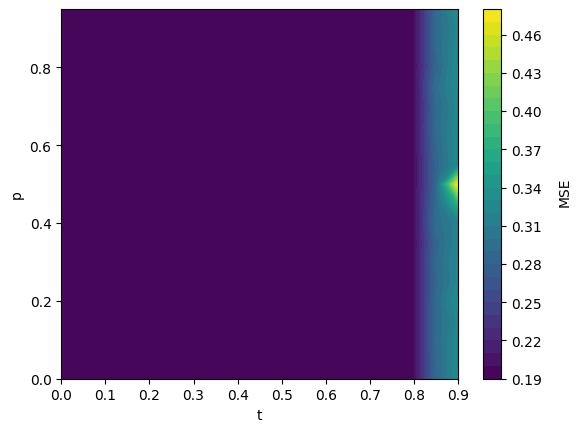

In [ ]:
plt.contourf(np.arange(0, 0.95, 0.05), np.arange(0, 1, 0.05), error_pt, cmap='viridis', levels=30)
plt.colorbar()
plt.xlabel('t')
plt.ylabel('p')
plt.text(0.9, 0.5, 'MSE', rotation=90, va='center', ha='left', fontsize=10, transform=plt.gcf().transFigure)
plt.show()

Variação do erro MSE em função do hiperparâmetro p, para diferentes valores de t

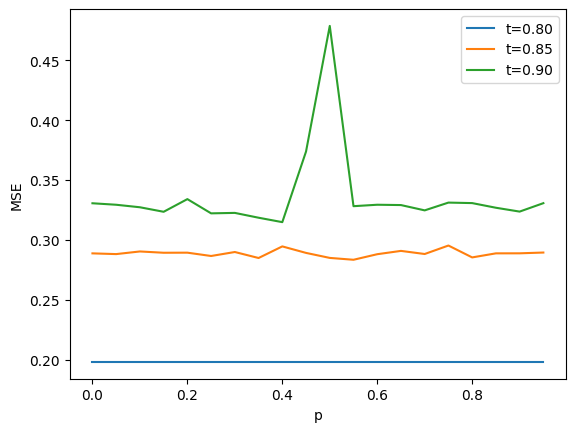

In [ ]:
t_80 = error_pt[:,-3]
t_85 = error_pt[:,-2]
t_90 = error_pt[:,-1]
x = np.arange(0, 1, 0.05)

plt.xlabel('p')
plt.ylabel('MSE')
plt.plot(x, t_80, label='t=0.80')
plt.plot(x, t_85, label='t=0.85')
plt.plot(x, t_90, label='t=0.90')
plt.legend()

#### Comparação de métodos

In [ ]:
def get_resp(part, len):
    if part == 1:
        return np.array(resp_p1)[:len]

    return np.array(resp_p2)[:len]

In [ ]:
# retorna o erro médio do modelo no dataset
def validate_model(ws, p, t, begin_video=1, begin_part=1):
    errors_array = []

    for video in range(begin_video, 25):
        i = begin_part if video == begin_video else 1
        for part in range(i, 3):
            # ajustes de acordo com o vídeo e a parte
            filename_video = f'midia/0{video}-0{part}.mp4'
            if video > 9:
                filename_video = f'midia/{video}-0{part}.mp4'

            min_len = 23 if part == 1 else 27
            max_len = 28 if part == 1 else 32

            # faz a segmentação do vídeo com o modelo
            seg_model = SegVideo(model_type='tiny')
            video_path = seg_model.get_video(path_project + filename_video)

            # repete a transcrição do vídeo até obter um mínimo de segmentos
            video_transcription, texts_str = None, None
            for temp_test in np.arange(-0.2, 0.5, 0.1):
                for temp_incr_test in np.arange(0.6, 1.1, 0.1):
                    video_transcription = seg_model.transcript(video_path, language='English', verbose='None', temperature=temp_test, temperature_increment_on_fallback=temp_incr_test)
                    texts_str = seg_model.get_text_channel(video_transcription)
                    if len(texts_str) > min_len and len(texts_str) < max_len:
                        break
            print(f'\n {video}-{part} com {len(texts_str)} segmentos!\n')

            audio_files = seg_model.get_audio_channel(video_path, video_transcription)
            face_files = seg_model.get_face_channel(video_path, video_transcription, padding=1.2)

            # utiliza do modelo multimodal para a construção do grafo
            mver = MVER()

            # cálculo das embeddings e coordenadas dos segmentos dos canais do vídeo
            text_embeddings, text_coord = mver.process_text(texts_str)
            audio_embeddings, audio_coord = mver.process_audio(audio_files)
            face_embeddings, face_coord = mver.process_face(face_files)

            embeddings = [text_embeddings, audio_embeddings, face_embeddings]
            coordnates = [text_coord, audio_coord, face_coord]

            # construção e ajuste do grafo multimodal
            graph_multimodal, train_mask = mver.consensus_graph(3, embeddings, coordnates, ws=ws, p=p, t=t)
            mver.train_gcn(graph_multimodal, train_mask, num_epochs=200, verbose=True)
            final_graph = mver.gcn_adjust_coordnates(graph_multimodal, ~train_mask)

            # cálculo do erro
            error = mse(final_graph.y.to('cpu').numpy(), get_resp(part, len(texts_str)))
            errors_array.append(error)

    return np.array(errors_array)

In [ ]:
mse_mgcp = validate_model(ws=[0.1, 0.7, 0.2], p=0.93, t=0.80)
mse_text = validate_model(ws=[1, 0, 0], p=0.50, t=0.30)
mse_audio = validate_model(ws=[0, 1, 0], p=0.50, t=0.30)
mse_face = validate_model(ws=[0, 0, 1], p=0.50, t=0.30)

In [ ]:
# # salva os arrays de erros calculados
# np.save(path_project + 'matrizes/error_text.npy', mse_text)
# np.save(path_project + 'matrizes/error_audio.npy', mse_audio)
# np.save(path_project + 'matrizes/error_image.npy', mse_face)
# np.save(path_project + 'matrizes/error_mgcp082.npy', mse_mgcp)

# carrega os arrays de erros
mse_text = np.load(path_project + 'matrizes/error_text.npy')
mse_audio = np.load(path_project + 'matrizes/error_audio.npy')
mse_face = np.load(path_project + 'matrizes/error_image.npy')
mse_mgcp = np.load(path_project + 'matrizes/error_mgcp082.npy')

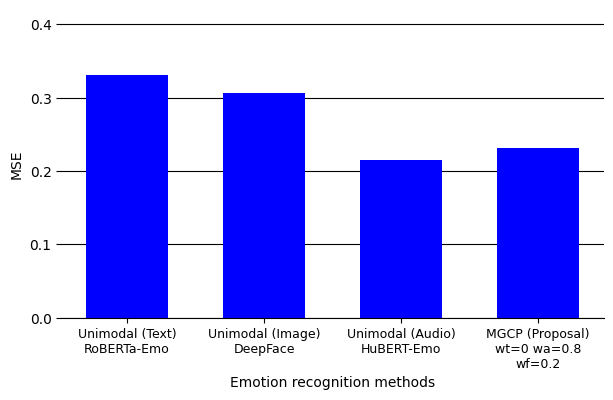

In [ ]:
categories = ['Unimodal (Text)\nRoBERTa-Emo', 'Unimodal (Image)\nDeepFace', 'Unimodal (Audio)\nHuBERT-Emo', 'MGCP (Proposal)\nwt=0 wa=0.8\nwf=0.2']
values = [mse_text.mean(), mse_face.mean(), mse_audio.mean(), mse_mgcp.mean()]

# cria o gráfico de barras
fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar(categories, values, color='blue', edgecolor='none', width=0.6)

# Ocultar as bordas superior e direita do gráfico
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# adiciona rótulos e título
y_values = [0, 0.1, 0.2, 0.3, 0.4]
for y in y_values:
    plt.axhline(y=y, color='black', linewidth=0.8, zorder=0)

plt.yticks(y_values)
plt.xticks(range(len(categories)), categories, fontsize=9)
plt.xlabel('Emotion recognition methods')
plt.ylabel('MSE')

plt.show()

##### Plots de exemplo

In [ ]:
# faz a segmentação do vídeo com o modelo
seg_model = SegVideo(model_type='tiny')
video_path = seg_model.get_video(path_project + 'midia/07-02.mp4')

min_len = 23
max_len = 28

# repete a transcrição do vídeo até obter um mínimo de segmentos
video_transcription, texts_str = None, None
for temp_test in np.arange(-0.2, 0.5, 0.1):
    for temp_incr_test in np.arange(0.6, 1.1, 0.1):
        video_transcription = seg_model.transcript(video_path, language='English', verbose='None', temperature=temp_test, temperature_increment_on_fallback=temp_incr_test)
        texts_str = seg_model.get_text_channel(video_transcription)
        if len(texts_str) > min_len and len(texts_str) < max_len:
            break
print(f'\n{len(texts_str)} segmentos!\n')

audio_files = seg_model.get_audio_channel(video_path, video_transcription)
face_files = seg_model.get_face_channel(video_path, video_transcription, padding=1.2)


32 segmentos!

MoviePy - Writing audio in /content/drive/MyDrive/Colab Notebooks/IC Multimodal/Projeto final/midia/07-02.mp3


MoviePy - Done.
[[438 213 434 434]]
ok
face_0.png
[[425 211 432 432]]
ok
face_1.png
[[431 207 419 419]]
ok
face_2.png
[[427 157 437 437]]
ok
face_3.png
[[416 158 435 435]]
ok
face_4.png
[[407 182 432 432]]
ok
face_5.png
[[422 186 441 441]]
ok
face_6.png
[[427 226 422 422]]
ok
face_7.png
[[413 169 418 418]]
ok
face_8.png
[[399 135 420 420]]
ok
face_9.png
[[398 138 434 434]]
ok
face_10.png
[[416 142 420 420]]
ok
face_11.png
[[422 165 405 405]]
ok
face_12.png
[[414 162 425 425]]
ok
face_13.png
[[384 160 417 417]]
ok
face_14.png
[[407 157 422 422]]
ok
face_15.png
[[443 147 415 415]]
ok
face_16.png
[[415 142 409 409]]
ok
face_17.png
[[471 151 408 408]]
ok
face_18.png
[[407 150 418 418]]
ok
face_19.png
[[432 175 401 401]]
ok
face_20.png
[[413 161 414 414]]
ok
face_21.png
[[437 185 385 385]]
ok
face_22.png
[[428 157 419 419]]
ok
face_23.png
[[426 151 431 431]]
ok
face_24.png
[[412 110 437 437]]
ok
face_25.png
[[443 130 416 416]]
ok
face_26.png
[[426 140 437 437]]
ok
face_27.png
[[433 156 426 

In [ ]:
# utiliza do modelo multimodal para a construção do grafo
mver = MVER()

# cálculo das embeddings e coordenadas dos segmentos dos canais do vídeo
text_embeddings, text_coord = mver.process_text(texts_str)
audio_embeddings, audio_coord = mver.process_audio(audio_files)
face_embeddings, face_coord = mver.process_face(face_files)

embeddings = [text_embeddings, audio_embeddings, face_embeddings]
coordnates = [text_coord, audio_coord, face_coord]

Some weights of the model checkpoint at Rajaram1996/Hubert_emotion were not used when initializing HubertForSpeechClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSpeechClassification were not initialized from the model checkpoint at Rajaram1996/Hubert_emotion and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight

Modelo unimodal de texto

  0%|          | 0/150 [00:00<?, ?it/s]

0.2812875


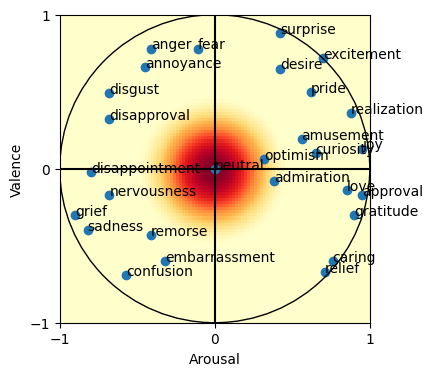

In [ ]:
graph_multimodal, train_mask = mver.consensus_graph(3, embeddings, coordnates, ws=[1, 0, 0], p=0.5, t=0.5)
predictions = graph_multimodal.y.to('cpu').numpy()
plot_emotion_occurences(list(predictions), df_emotion_coords, grid_size=0.02, h=0.5)
print(mse(predictions, get_resp(2, len(texts_str))))

Modelo unimodal de áudio

  0%|          | 0/150 [00:00<?, ?it/s]

0.15300295372333175


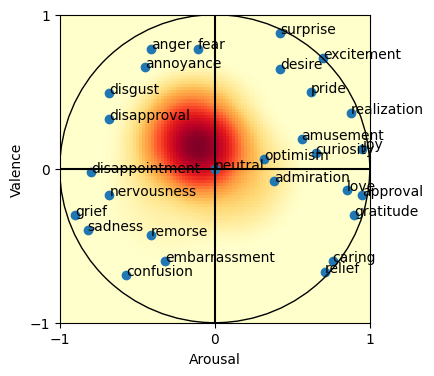

In [ ]:
graph_multimodal, train_mask = mver.consensus_graph(3, embeddings, coordnates, ws=[0, 1, 0], p=0.5, t=0.5)
predictions = graph_multimodal.y.to('cpu').numpy()
plot_emotion_occurences(list(predictions), df_emotion_coords, grid_size=0.02, h=0.5)
print(mse(predictions, get_resp(2, len(texts_str))))

Modelo unimodal de imagem

  0%|          | 0/150 [00:00<?, ?it/s]

0.19960312739145017


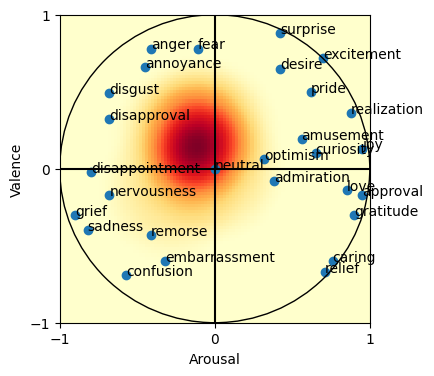

In [ ]:
graph_multimodal, train_mask = mver.consensus_graph(3, embeddings, coordnates, ws=[0, 0, 1], p=0.5, t=0.5)
predictions = graph_multimodal.y.to('cpu').numpy()
plot_emotion_occurences(list(predictions), df_emotion_coords, grid_size=0.02, h=0.5)
print(mse(predictions, get_resp(2, len(texts_str))))

Modelo multimodal proposto

  0%|          | 0/150 [00:00<?, ?it/s]

0.15059974131139306


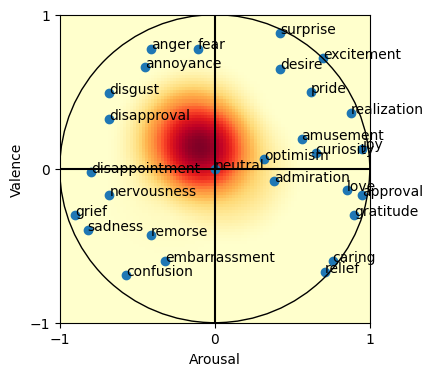

In [ ]:
graph_multimodal, train_mask = mver.consensus_graph(3, embeddings, coordnates, ws=[0, 0.8, 0.2], p=0.93, t=0.82)
mver.train_gcn(graph_multimodal, train_mask, num_epochs=200, verbose=False)
final_graph = mver.gcn_adjust_coordnates(graph_multimodal, ~train_mask)

predictions = final_graph.y.to('cpu').numpy()
plot_emotion_occurences(list(predictions), df_emotion_coords, grid_size=0.02, h=0.5)
print(mse(predictions, get_resp(2, len(texts_str))))

Saída esperada

  0%|          | 0/150 [00:00<?, ?it/s]

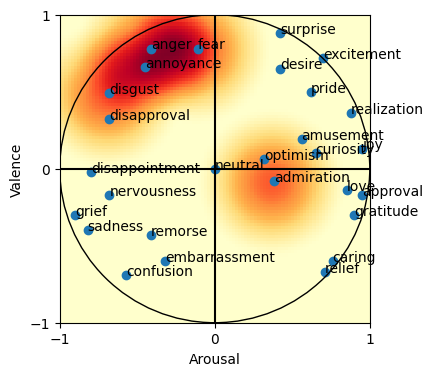

In [ ]:
plot_emotion_occurences(resp_p2, df_emotion_coords, grid_size=0.02, h=0.5)